In [1]:
# Package import
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN , gradient
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data
import time

/home/guillaume/temp/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/guillaume/temp/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold,Ridge,ProximityParent,ProximityCombo

import numpy as np
import matplotlib.pyplot as plt

## Data and operators

In [3]:
u0 = get_sample_data('2d-mri')
u0_mat = u0.data

n=u0_mat.shape[0]
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')

# Adding noise
(n1,n2) = u0.shape
s = 1e-6
# Computing y with non-cartesian Fourier transform
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')
y = (1+0j)*fourier_op.op(np.real(u0.data))+s*np.random.randn(2*n*n).view(np.complex128)
u0_mat = np.asarray(u0)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [4]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data

p = np.zeros((n*n,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
p[n*ind1+ind2]=1

new_loc = kspace_loc[np.where(p)]
#pysap.Image(data = convert_locations_to_mask(np.array(new_loc),u0.shape)).show()

#Wavelet
linear_op = WaveletN(wavelet_name="db8",nb_scale=4,padding_mode = "periodization")

In [5]:
#ifft on noised data = base result
uk = fourier_op.adj_op(p*y)
print(ssim(uk,u0_mat))
pysap.Image(data = np.abs(uk)).show()

0.6718984766706977


## CondatVu
### Regularizers
See modopt/opt/agorithms.py: Condat uses Moreau identity for prox_dual: we need to define the proximal operator and not the proximal dual.

In [6]:
class RegularizerG(ProximityParent):
    r"""negative values penalisation and L2 norm

    Parameters
    ----------
    linear : class
        Linear operator class
    weights : np.ndarray
        Input array of weights
    """

    def __init__(self, zeta, eps):
        self.weights = [eps,zeta]
        self.eps = eps
        self.zeta=zeta
        self.op = self._op_method
        self.cost = self._cost_method

        
    def _op_method(self, data, extra_factor=1.0):  
        thresh = self.eps*extra_factor
        
        return np.where(data>=0,data/(1+thresh),
                 data/(0.5+np.sqrt(0.25-3*self.zeta*extra_factor*data/(1+thresh)**2)))

    
    def _cost_method(self, *args, **kwargs):
        
        cost_val = np.abs(self.zeta*np.sum(np.where(args[0]<=0,-args[0]**3,0))
                           +self.eps*np.linalg.norm(args[0])**2/2)

        if 'verbose' in kwargs and kwargs['verbose']:
            print(' - G (X):', cost_val)

        return cost_val

In [7]:
class RegularizerF2(ProximityParent):
    r"""C2 approximation of an L1 norm

    Parameters
    ----------
    linear : class
        Linear operator class
    weights : np.ndarray
        Input array of weights
    """

    def __init__(self, linear, gamma, pn1):
        self.linear = linear
        self.weights = [gamma,pn1]
        self.gamma = gamma
        self.pn1=pn1
        self.op = self._op_method
        self.cost = self._cost_method
    
    def rho(self, x):
        m = np.abs(x)
        return np.where(m<self.gamma,-m**3/3/self.gamma**2+m**2/self.gamma,m-self.gamma/3)    
    
    def prox_J(self,x,c,gamma):
        return np.where(np.abs(x)>gamma+c,x*(1-c/np.abs(x)),
                    gamma*x/(c+0.5*gamma+np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))

        
    def _op_method(self, data, extra_factor=1.0):  
        return self.prox_J(data,self.pn1*extra_factor,self.gamma)
        
    
    def _cost_method(self, *args, **kwargs):
        
        cost_val = self.pn1*np.sum(self.rho(self.linear.op(args[0])))

        if 'verbose' in kwargs and kwargs['verbose']:
            print(' - F2 (X):', cost_val)

        return cost_val

In [8]:
zeta,epsilon,gamma,pn1 = 1e15,2.15e-5,1e-10,4.6e-7
regularizer_G = RegularizerG(zeta,epsilon)
regularizer_F2 = RegularizerF2(linear_op,gamma,pn1)

In [9]:
print(regularizer_G.cost(u0_mat),regularizer_F2.cost(u0_mat))

4.100799071693488e-11 5.283098950982094e-08


### Reconstruction

In [10]:
from modopt.opt.algorithms import Condat
from mri.operators import GradAnalysis
from modopt.opt.gradient import GradParent,GradBasic

Definition of gradient op: see https://cea-cosmic.github.io/ModOpt/_modules/modopt/opt/gradient.html

In [11]:
real_fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')
real_fourier_op.op = lambda x:fourier_op.op(np.real(x))
real_fourier_op.adj_op = lambda x:np.real(fourier_op.adj_op(x))
gradient_op = GradBasic(p*y,real_fourier_op.op,real_fourier_op.adj_op)

In [12]:
metrics = {
        'ssim': {
            'metric': ssim,
            'mapping': {'x_new': 'test', 'y_new': None},
            'cst_kwargs': {'ref': u0_mat, 'mask': None},
            'early_stopping': True,
        },
    }

In [13]:
#Initialisation
gradient_op.fourier_op = real_fourier_op
norm = linear_op.l2norm(gradient_op.fourier_op.shape)
x_init = fourier_op.adj_op(p*y)

In [15]:
opt = Condat(x=fourier_op.adj_op(p*y),
    y=p*y,
    grad = gradient_op,
    prox = regularizer_G,
    prox_dual = regularizer_F2,
    linear = linear_op,
    max_iter=200,
    metrics=metrics,
    verbose=0)

/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


 - ITERATION: 1
 - DATA FIDELITY (X): 2.615377494972373e-07
 - G (X): 0.6889691412026456


N/A% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 8.940003779760927e-08
 - COST: 0.6889694921404329



N/A% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.602424093304784e-07


  0% (1 of 200) |                        | Elapsed Time: 0:00:01 ETA:   0:03:59

 - G (X): 0.11329509863354488
 - F2 (X): 8.481381009644876e-08
 - COST: 0.11329544368976431

 - ITERATION: 3
 - DATA FIDELITY (X): 1.6002718182801555e-07


  1% (3 of 200) |                        | Elapsed Time: 0:00:01 ETA:   0:03:01

 - G (X): 0.02427977765254582
 - F2 (X): 7.591499381445154e-08
 - COST: 0.024280013594721463

 - ITERATION: 4
 - DATA FIDELITY (X): 8.978386707814559e-08
 - G (X): 0.0024547784306349144
 - F2 (X): 6.690999884326525e-08
 - COST: 0.0024549351245008355

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 29.008097051384002



  1% (3 of 200) |                        | Elapsed Time: 0:00:02 ETA:   0:02:13

 - ITERATION: 5
 - DATA FIDELITY (X): 5.62514257189663e-08


  1% (3 of 200) |                        | Elapsed Time: 0:00:02 ETA:   0:02:13

 - G (X): 0.00021682930051277995
 - F2 (X): 5.9351711605324676e-08


  2% (4 of 200) |                        | Elapsed Time: 0:00:03 ETA:   0:02:04

 - COST: 0.00021694490365010424

 - ITERATION: 6
 - DATA FIDELITY (X): 4.28996473136252e-08
 - G (X): 0.0001508123024705416


  2% (5 of 200) |                        | Elapsed Time: 0:00:03 ETA:   0:01:39

 - F2 (X): 5.333484567357002e-08
 - COST: 0.0001509085369635288



  3% (6 of 200) |                        | Elapsed Time: 0:00:03 ETA:   0:02:11

 - ITERATION: 7
 - DATA FIDELITY (X): 3.828456227393899e-08
 - G (X): 3.76770107409493e-05
 - F2 (X): 4.868050608352255e-08
 - COST: 3.776397580930676e-05



  3% (6 of 200) |                        | Elapsed Time: 0:00:04 ETA:   0:02:16

 - ITERATION: 8
 - DATA FIDELITY (X): 3.700250405852185e-08
 - G (X): 0.00015480025497472313
 - F2 (X): 4.508666667069738e-08


  4% (8 of 200) |                        | Elapsed Time: 0:00:05 ETA:   0:02:08

 - COST: 0.00015488234414545236

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9094755648590609

 - ITERATION: 9
 - DATA FIDELITY (X): 3.686796531197399e-08
 - G (X): 2.1774680227830655e-05
 - F2 (X): 4.231344334022278e-08
 - COST: 2.185386163648285e-05



 - ITERATION: 10
 - DATA FIDELITY (X): 3.708185088464941e-08


  4% (8 of 200) |                        | Elapsed Time: 0:00:05 ETA:   0:02:32

 - G (X): 3.853562546182004e-06
 - F2 (X): 4.0127331170224667e-08


  4% (9 of 200) |#                       | Elapsed Time: 0:00:06 ETA:   0:02:09

 - COST: 3.930771728236878e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.7369263589192104e-08
 - G (X): 5.412939474595411e-06
 - F2 (X): 3.838562188279379e-08


  5% (11 of 200) |#                      | Elapsed Time: 0:00:06 ETA:   0:01:53

 - COST: 5.488694360067396e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 3.7642956032884685e-08
 - G (X): 3.768710319163205e-06
 - F2 (X): 3.698547298059258e-08
 - COST: 3.843338748176682e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.7630242055122096



  5% (11 of 200) |#                      | Elapsed Time: 0:00:07 ETA:   0:02:09

 - ITERATION: 13
 - DATA FIDELITY (X): 3.78800324359184e-08
 - G (X): 4.051553704173097e-06
 - F2 (X): 3.5865620890314646e-08


  6% (13 of 200) |#                      | Elapsed Time: 0:00:08 ETA:   0:01:55

 - COST: 4.12529935749933e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 3.8078288522865376e-08
 - G (X): 3.795750146030198e-11
 - F2 (X): 3.4900292493860206e-08
 - COST: 7.301653851818588e-08



  6% (13 of 200) |#                      | Elapsed Time: 0:00:08 ETA:   0:02:05

 - ITERATION: 15
 - DATA FIDELITY (X): 3.824189309298416e-08
 - G (X): 3.8888707444291087e-11
 - F2 (X): 3.4147948443516105e-08


  7% (14 of 200) |#                      | Elapsed Time: 0:00:09 ETA:   0:02:05

 - COST: 7.242873024394456e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.83761565525384e-08
 - G (X): 3.9188013649442924e-11
 - F2 (X): 3.354034529556115e-08


  8% (16 of 200) |#                      | Elapsed Time: 0:00:10 ETA:   0:01:50

 - COST: 7.1955689861749e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 28.077347077643335

 - ITERATION: 17
 - DATA FIDELITY (X): 3.848567539799215e-08
 - G (X): 3.9308877467445066e-11
 - F2 (X): 3.304016424808816e-08
 - COST: 7.156514852354776e-08



  8% (16 of 200) |#                      | Elapsed Time: 0:00:10 ETA:   0:02:11

 - ITERATION: 18
 - DATA FIDELITY (X): 3.8575821362606745e-08
 - G (X): 3.902797777888974e-11
 - F2 (X): 3.260850521402573e-08


  8% (17 of 200) |#                      | Elapsed Time: 0:00:11 ETA:   0:02:09

 - COST: 7.122335455441138e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.864940624696308e-08
 - G (X): 3.8987442033771635e-11
 - F2 (X): 3.226214118067994e-08


  9% (18 of 200) |##                     | Elapsed Time: 0:00:11 ETA:   0:02:06

 - COST: 7.095053486967679e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.871005443106565e-08
 - G (X): 3.9100197027103035e-11
 - F2 (X): 3.196290631439327e-08


  9% (19 of 200) |##                     | Elapsed Time: 0:00:12 ETA:   0:01:53

 - COST: 7.071206094248603e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007947809083557942

 - ITERATION: 21
 - DATA FIDELITY (X): 3.876039571523481e-08
 - G (X): 3.8944036902167476e-11


 10% (20 of 200) |##                     | Elapsed Time: 0:00:12 ETA:   0:01:32

 - F2 (X): 3.170718353298046e-08
 - COST: 7.050652328511743e-08



 10% (21 of 200) |##                     | Elapsed Time: 0:00:13 ETA:   0:01:47

 - ITERATION: 22
 - DATA FIDELITY (X): 3.880210928065824e-08
 - G (X): 9.946269150701612e-06
 - F2 (X): 3.148777300961696e-08
 - COST: 1.0016559032991887e-05



 10% (21 of 200) |##                     | Elapsed Time: 0:00:13 ETA:   0:02:04

 - ITERATION: 23
 - DATA FIDELITY (X): 3.88367729657064e-08
 - G (X): 4.5866178245553175e-11
 - F2 (X): 3.129569032130264e-08


 11% (23 of 200) |##                     | Elapsed Time: 0:00:14 ETA:   0:01:58

 - COST: 7.017832946525459e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.886583010417682e-08
 - G (X): 3.896513188533109e-11
 - F2 (X): 3.112265923671118e-08
 - COST: 7.002745447277332e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 70.94471777808802



 11% (23 of 200) |##                     | Elapsed Time: 0:00:15 ETA:   0:02:00

 - ITERATION: 25
 - DATA FIDELITY (X): 3.88900853411625e-08
 - G (X): 3.889188755425156e-11
 - F2 (X): 3.097700470051157e-08


 12% (24 of 200) |##                     | Elapsed Time: 0:00:15 ETA:   0:01:49

 - COST: 6.990598192922831e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.89106048827123e-08
 - G (X): 3.888676861819179e-11


 12% (25 of 200) |##                     | Elapsed Time: 0:00:15 ETA:   0:01:32

 - F2 (X): 3.084920968711882e-08
 - COST: 6.979870133844931e-08



 13% (26 of 200) |##                     | Elapsed Time: 0:00:16 ETA:   0:01:56

 - ITERATION: 27
 - DATA FIDELITY (X): 3.8927947320849174e-08
 - G (X): 3.891432561773875e-11
 - F2 (X): 3.073381888075421e-08
 - COST: 6.970068052722113e-08



 13% (26 of 200) |##                     | Elapsed Time: 0:00:16 ETA:   0:02:00

 - ITERATION: 28
 - DATA FIDELITY (X): 3.89426149142501e-08


 13% (26 of 200) |##                     | Elapsed Time: 0:00:17 ETA:   0:02:00

 - G (X): 6.424229845858381e-11
 - F2 (X): 3.0632568877795114e-08


 14% (28 of 200) |###                    | Elapsed Time: 0:00:17 ETA:   0:01:59

 - COST: 6.963942609050379e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0026164516362320433

 - ITERATION: 29
 - DATA FIDELITY (X): 3.895515881315905e-08
 - G (X): 3.882845178402408e-11
 - F2 (X): 3.054371972960207e-08
 - COST: 6.953770699454515e-08



 14% (28 of 200) |###                    | Elapsed Time: 0:00:18 ETA:   0:01:55

 - ITERATION: 30
 - DATA FIDELITY (X): 3.8965721645450203e-08
 - G (X): 3.884834595564688e-11
 - F2 (X): 3.046409752021749e-08


 14% (29 of 200) |###                    | Elapsed Time: 0:00:18 ETA:   0:01:54

 - COST: 6.946866751162334e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.8974843018962007e-08
 - G (X): 3.8878809054831253e-11


 15% (30 of 200) |###                    | Elapsed Time: 0:00:18 ETA:   0:01:25

 - F2 (X): 3.039743406541179e-08
 - COST: 6.941115589342864e-08



 15% (31 of 200) |###                    | Elapsed Time: 0:00:19 ETA:   0:01:55

 - ITERATION: 32
 - DATA FIDELITY (X): 3.898267496395656e-08
 - G (X): 3.90817832533187e-11
 - F2 (X): 3.034275448581751e-08
 - COST: 6.936451123302739e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001662448356326394



 15% (31 of 200) |###                    | Elapsed Time: 0:00:20 ETA:   0:01:56

 - ITERATION: 33
 - DATA FIDELITY (X): 3.898950509060063e-08


 15% (31 of 200) |###                    | Elapsed Time: 0:00:20 ETA:   0:01:53

 - G (X): 1.629150371076663e-10
 - F2 (X): 3.0287342762134764e-08


 16% (32 of 200) |###                    | Elapsed Time: 0:00:20 ETA:   0:01:58

 - COST: 6.943976288984305e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.8995453876041624e-08
 - G (X): 4.331368367794697e-11
 - F2 (X): 3.023676107509405e-08


 16% (33 of 200) |###                    | Elapsed Time: 0:00:21 ETA:   0:02:01

 - COST: 6.927552863481362e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.9000682256119236e-08


 16% (33 of 200) |###                    | Elapsed Time: 0:00:21 ETA:   0:02:07

 - G (X): 9.263905999378134e-07
 - F2 (X): 3.0192699790429604e-08


 17% (34 of 200) |###                    | Elapsed Time: 0:00:22 ETA:   0:02:10

 - COST: 9.955839819843623e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 3.9005242443159567e-08


 17% (34 of 200) |###                    | Elapsed Time: 0:00:22 ETA:   0:02:48

 - G (X): 1.0647621329256235e-10
 - F2 (X): 3.015430330897424e-08


 18% (36 of 200) |####                   | Elapsed Time: 0:00:23 ETA:   0:02:11

 - COST: 6.926602196542637e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8697325529322179

 - ITERATION: 37
 - DATA FIDELITY (X): 3.9009160266742865e-08
 - G (X): 4.089584911448581e-11
 - F2 (X): 3.011947159186873e-08
 - COST: 6.916952770772608e-08



 18% (36 of 200) |####                   | Elapsed Time: 0:00:24 ETA:   0:02:00

 - ITERATION: 38
 - DATA FIDELITY (X): 3.901263702120133e-08
 - G (X): 3.8844101848449785e-11
 - F2 (X): 3.008559863176144e-08


 19% (38 of 200) |####                   | Elapsed Time: 0:00:24 ETA:   0:01:50

 - COST: 6.913707975481122e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.901572132093202e-08
 - G (X): 3.883833028289735e-11
 - F2 (X): 3.005402179378271e-08
 - COST: 6.910858144499763e-08



 19% (38 of 200) |####                   | Elapsed Time: 0:00:25 ETA:   0:01:49

 - ITERATION: 40
 - DATA FIDELITY (X): 3.901843343266931e-08
 - G (X): 2.133871708513212e-08
 - F2 (X): 3.002688596067396e-08


 19% (39 of 200) |####                   | Elapsed Time: 0:00:26 ETA:   0:01:55

 - COST: 9.03840364784754e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1328337996878395

 - ITERATION: 41
 - DATA FIDELITY (X): 3.9020786156715336e-08
 - G (X): 2.6689169037256514e-09
 - F2 (X): 3.00029025708549e-08


 20% (41 of 200) |####                   | Elapsed Time: 0:00:26 ETA:   0:01:22

 - COST: 7.169260563129588e-08



 20% (41 of 200) |####                   | Elapsed Time: 0:00:27 ETA:   0:01:51

 - ITERATION: 42
 - DATA FIDELITY (X): 3.9024812290332117e-08
 - G (X): 3.8838914549395965e-11
 - F2 (X): 2.996029494263745e-08


 21% (42 of 200) |####                   | Elapsed Time: 0:00:27 ETA:   0:01:48

 - COST: 6.902394614751895e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.9026553190602314e-08
 - G (X): 3.889043306318045e-11


 21% (43 of 200) |####                   | Elapsed Time: 0:00:28 ETA:   0:01:42

 - F2 (X): 2.9944258632269156e-08
 - COST: 6.900970225593464e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.902812536795567e-08
 - G (X): 3.883596578037548e-11
 - F2 (X): 2.992637812686519e-08


 22% (44 of 200) |#####                  | Elapsed Time: 0:00:29 ETA:   0:01:51

 - COST: 6.899333946060124e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01966268299978933

 - ITERATION: 45
 - DATA FIDELITY (X): 3.9029583359628586e-08
 - G (X): 1.2583255499395675e-10
 - F2 (X): 2.991216961628733e-08


 22% (45 of 200) |#####                  | Elapsed Time: 0:00:29 ETA:   0:01:43

 - COST: 6.906758553090987e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 3.903090590167715e-08
 - G (X): 9.62429118802115e-09
 - F2 (X): 2.989842157394295e-08


 23% (46 of 200) |#####                  | Elapsed Time: 0:00:30 ETA:   0:01:49

 - COST: 7.855361866364126e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.9032090146796134e-08
 - G (X): 3.8832260090234835e-11
 - F2 (X): 2.9885355980509885e-08


 23% (47 of 200) |#####                  | Elapsed Time: 0:00:31 ETA:   0:01:46

 - COST: 6.895627838739625e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.90331748869185e-08
 - G (X): 3.883123775714894e-11
 - F2 (X): 2.987087987950114e-08


 24% (48 of 200) |#####                  | Elapsed Time: 0:00:31 ETA:   0:01:42

 - COST: 6.894288600417679e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.07050107842112645

 - ITERATION: 49
 - DATA FIDELITY (X): 3.903416915144243e-08
 - G (X): 3.883011571931194e-11
 - F2 (X): 2.985887503281916e-08


 24% (49 of 200) |#####                  | Elapsed Time: 0:00:32 ETA:   0:01:31

 - COST: 6.89318742999809e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.903505808194506e-08
 - G (X): 3.882896608274029e-11
 - F2 (X): 2.9850147626076816e-08


 25% (50 of 200) |#####                  | Elapsed Time: 0:00:32 ETA:   0:01:29

 - COST: 6.892403467410461e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 3.903585079636578e-08
 - G (X): 3.882790385648815e-11
 - F2 (X): 2.9840164193567424e-08


 25% (51 of 200) |#####                  | Elapsed Time: 0:00:33 ETA:   0:01:40

 - COST: 6.891484289378968e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.903658950533633e-08
 - G (X): 3.882648616650267e-11
 - F2 (X): 2.982889764635194e-08


 26% (52 of 200) |#####                  | Elapsed Time: 0:00:34 ETA:   0:01:40

 - COST: 6.890431363785476e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002666715089977074

 - ITERATION: 53
 - DATA FIDELITY (X): 3.9037241309394e-08
 - G (X): 3.8825818784864275e-11
 - F2 (X): 2.9820630381338733e-08


 27% (54 of 200) |######                 | Elapsed Time: 0:00:34 ETA:   0:01:27

 - COST: 6.88966975095176e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.90378474676979e-08
 - G (X): 3.882477367703231e-11
 - F2 (X): 2.981326306995653e-08
 - COST: 6.888993531133147e-08



 27% (54 of 200) |######                 | Elapsed Time: 0:00:35 ETA:   0:01:41

 - ITERATION: 55
 - DATA FIDELITY (X): 3.9038375447589003e-08
 - G (X): 3.882306648994094e-11
 - F2 (X): 2.980587961724161e-08


 28% (56 of 200) |######                 | Elapsed Time: 0:00:36 ETA:   0:01:38

 - COST: 6.888307813132056e-08

 - ITERATION: 56
 - DATA FIDELITY (X): 3.903886172733472e-08
 - G (X): 3.882231843560484e-11
 - F2 (X): 2.9798092586030792e-08
 - COST: 6.887577663180112e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002016426296164069



 28% (56 of 200) |######                 | Elapsed Time: 0:00:36 ETA:   0:01:39

 - ITERATION: 57
 - DATA FIDELITY (X): 3.903933458408496e-08
 - G (X): 4.4427725061728056e-11
 - F2 (X): 2.9792471749061217e-08


 28% (57 of 200) |######                 | Elapsed Time: 0:00:37 ETA:   0:01:36

 - COST: 6.887623405820791e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.9039758187286006e-08
 - G (X): 3.8911737677075235e-11


 28% (58 of 200) |######                 | Elapsed Time: 0:00:37 ETA:   0:01:36

 - F2 (X): 2.9787169784318355e-08
 - COST: 6.886583970928144e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.9040160684463676e-08


 28% (58 of 200) |######                 | Elapsed Time: 0:00:38 ETA:   0:01:36

 - G (X): 3.881302528145099e-11
 - F2 (X): 2.9782158461215047e-08


 29% (59 of 200) |######                 | Elapsed Time: 0:00:38 ETA:   0:01:41

 - COST: 6.886113217096018e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.904052536608085e-08


 29% (59 of 200) |######                 | Elapsed Time: 0:00:38 ETA:   0:01:41

 - G (X): 3.881784244250391e-11
 - F2 (X): 2.97749309102791e-08


 30% (60 of 200) |######                 | Elapsed Time: 0:00:39 ETA:   0:01:48

 - COST: 6.885427411880245e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001936419348073389

 - ITERATION: 61
 - DATA FIDELITY (X): 3.904088401575133e-08
 - G (X): 3.8819450281185535e-11
 - F2 (X): 2.9770680035318815e-08


 30% (61 of 200) |#######                | Elapsed Time: 0:00:40 ETA:   0:01:47

 - COST: 6.885038350135132e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.9041204806508976e-08


 30% (61 of 200) |#######                | Elapsed Time: 0:00:40 ETA:   0:01:47

 - G (X): 3.88195453327423e-11
 - F2 (X): 2.9766266252292107e-08


 31% (62 of 200) |#######                | Elapsed Time: 0:00:41 ETA:   0:01:52

 - COST: 6.884629060413383e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.904149334031713e-08


 31% (63 of 200) |#######                | Elapsed Time: 0:00:42 ETA:   0:01:47

 - G (X): 3.881922924874279e-11
 - F2 (X): 2.9762084639164225e-08
 - COST: 6.884239720873011e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.9041768598435764e-08


 32% (64 of 200) |#######                | Elapsed Time: 0:00:42 ETA:   0:01:46

 - G (X): 3.881874522517259e-11
 - F2 (X): 2.975770723099468e-08
 - COST: 6.883829457465561e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00011608252320954559



 32% (64 of 200) |#######                | Elapsed Time: 0:00:42 ETA:   0:01:47

 - ITERATION: 65
 - DATA FIDELITY (X): 3.904203701111847e-08


 32% (64 of 200) |#######                | Elapsed Time: 0:00:42 ETA:   0:01:47

 - G (X): 7.688764014776377e-10
 - F2 (X): 2.9754726595561603e-08


 33% (66 of 200) |#######                | Elapsed Time: 0:00:43 ETA:   0:01:16

 - COST: 6.95656400081577e-08



 33% (66 of 200) |#######                | Elapsed Time: 0:00:44 ETA:   0:01:37

 - ITERATION: 66
 - DATA FIDELITY (X): 3.9042541738798624e-08


 33% (66 of 200) |#######                | Elapsed Time: 0:00:44 ETA:   0:01:37

 - G (X): 3.8817619669715283e-11
 - F2 (X): 2.97474028933354e-08


 33% (67 of 200) |#######                | Elapsed Time: 0:00:45 ETA:   0:01:43

 - COST: 6.882876225180373e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.904277455535576e-08


 34% (68 of 200) |#######                | Elapsed Time: 0:00:45 ETA:   0:02:36

 - G (X): 3.881054964590519e-11
 - F2 (X): 2.9745147280545954e-08
 - COST: 6.882673238554762e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.9042999366268115e-08
 - G (X): 3.881875085568873e-11
 - F2 (X): 2.9742419563816848e-08


 34% (69 of 200) |#######                | Elapsed Time: 0:00:46 ETA:   0:01:43

 - COST: 6.882423768094066e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005400849649763351

 - ITERATION: 69
 - DATA FIDELITY (X): 3.904321529827207e-08


 34% (69 of 200) |#######                | Elapsed Time: 0:00:46 ETA:   0:01:43

 - G (X): 3.8815772136317656e-11
 - F2 (X): 2.974030452710366e-08


 35% (71 of 200) |########               | Elapsed Time: 0:00:47 ETA:   0:01:11

 - COST: 6.882233559751205e-08



100% (200 of 200) |######################| Elapsed Time: 0:01:50 Time:  0:01:50


In [16]:
uk = opt.x_final
print(ssim(uk,u0_mat))
pysap.Image(data = uk).show()

0.8127014105872659


Text(0, 0.5, 'SSIM')

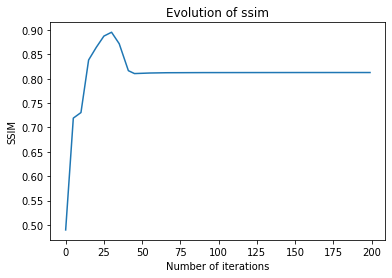

In [17]:
plt.plot(opt.metrics['ssim']['index'],opt.metrics['ssim']['values'])
plt.title("Evolution of ssim")
plt.xlabel("Number of iterations")
plt.ylabel("SSIM")
#plt.savefig("Comparisons/db8/Condat/ssim_evolution.png")

In [18]:
print(regularizer_G.cost(uk),regularizer_F2.cost(uk))

3.880557396272558e-11 2.9685524389550713e-08


# Grid search: $\epsilon$ and $\alpha(p)$

In [105]:
n=7
zeta,gamma=1e15,1e-10
alphas = 1e-5*np.logspace(-2,2,n)
eps = 1e-4*np.logspace(-2,2,n)
ssims = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        regularizer_G = RegularizerG(zeta,eps[i])
        regularizer_F2 = RegularizerF2(linear_op,gamma,alphas[j])
        
        eta = alphas[j]*5/2/gamma
        mu = 2*np.sqrt(eps[i]/2/eta)
        theta = 1/(1+mu)
        tau = mu/2/eps[i]
        sigma = mu*eta/2
        
        opt = Condat(x=fourier_op.adj_op(p*y),
            y=p*y,
            grad = gradient_op,
            prox = regularizer_G,
            prox_dual = regularizer_F2,
            linear = linear_op,
            max_iter=100,
            verbose=0)
        
        uk = opt.x_final
        
        ssims[i,j] = ssim(uk,u0_mat)
        print(f"(epsilon,alpha)=({eps[i]},{alphas[j]}), ssim={ssims[i,j]}")

/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 4.649144645298336e-05
 - G (X): 39.705341182873234
 - F2 (X): 8.952254889763376e-08
 - COST: 39.70538776384224



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 1.3699038630349232e-05


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:55

 - G (X): 4.965119604931684
 - F2 (X): 8.80687044481211e-08
 - COST: 4.965133392039019

 - ITERATION: 3
 - DATA FIDELITY (X): 6.846534633945088e-06
 - G (X): 0.6210664448881416
 - F2 (X): 8.69836209380215e-08
 - COST: 0.6210733784063964



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:27

 - ITERATION: 4
 - DATA FIDELITY (X): 2.7438357111907365e-06
 - G (X): 0.07763768783056672
 - F2 (X): 6.689429692773766e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:18

 - COST: 0.07764049856057484

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 62.93249458532347

 - ITERATION: 5
 - DATA FIDELITY (X): 1.9023950365009583e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - G (X): 0.00971633950030732
 - F2 (X): 6.259249743476503e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.009718304487841257

 - ITERATION: 6
 - DATA FIDELITY (X): 2.006146679603096e-06
 - G (X): 0.0008048791279239315
 - F2 (X): 5.991444072250685e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.0008069451890442571

 - ITERATION: 7
 - DATA FIDELITY (X): 1.7691874344180972e-06
 - G (X): 0.00014915188383913514
 - F2 (X): 5.8898859072265504e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - COST: 0.0001509799701326255

 - ITERATION: 8
 - DATA FIDELITY (X): 2.0642495320971993e-06
 - G (X): 1.862995165974169e-05
 - F2 (X): 6.092608251534363e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 2.0755127274354234e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 60.2877031882578

 - ITERATION: 9
 - DATA FIDELITY (X): 2.172816333330553e-06
 - G (X): 2.606811920643658e-06
 - F2 (X): 6.078734257952934e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 4.84041559655374e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 2.150050837180646e-06
 - G (X): 3.3677796158984345e-07
 - F2 (X): 6.06553310334739e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:00:56

 - COST: 2.5474841298039635e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 2.27165440845563e-06
 - G (X): 7.96309217155142e-08
 - F2 (X): 6.09881975108899e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:56

 - COST: 2.412273527682034e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 2.0213593563109883e-06
 - G (X): 5.740498968830748e-09
 - F2 (X): 5.830053976574168e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 2.085400395045561e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6426045670019012

 - ITERATION: 13
 - DATA FIDELITY (X): 2.079842106943504e-06
 - G (X): 1.5605157071586323e-09
 - F2 (X): 5.975105419399024e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:52

 - COST: 2.1411536768446532e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 2.2521396739791034e-06
 - G (X): 1.7988851457622074e-09
 - F2 (X): 6.010215079755064e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 2.3140407099224163e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 2.0147669504736057e-06
 - G (X): 1.904182741646178e-10
 - F2 (X): 5.830427601609664e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 2.073261644763867e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 2.070750240437451e-06
 - G (X): 3.06281425094588e-11


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:51

 - F2 (X): 5.909540152302812e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - COST: 2.129876270102989e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0599686417637329

 - ITERATION: 17
 - DATA FIDELITY (X): 2.17397883747585e-06
 - G (X): 8.115227567531506e-11
 - F2 (X): 5.950376100430517e-08
 - COST: 2.2335637507558305e-06



 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - ITERATION: 18
 - DATA FIDELITY (X): 2.0432267774390276e-06
 - G (X): 1.2748923432897406e-11
 - F2 (X): 5.835294880294714e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - COST: 2.1015924751654076e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 2.10977196606078e-06
 - G (X): 7.041139722401343e-12
 - F2 (X): 5.930604259901647e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:51

 - COST: 2.1690850497995186e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 2.1528480932594727e-06
 - G (X): 8.504726741671772e-12
 - F2 (X): 5.926248476340372e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:50

 - COST: 2.2121190827496177e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01051033123195437

 - ITERATION: 21
 - DATA FIDELITY (X): 2.0506207031606624e-06
 - G (X): 1.4377747145801136e-11
 - F2 (X): 5.83906169114489e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 2.109025697819257e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 2.0996581805592534e-06
 - G (X): 7.286326705274897e-12
 - F2 (X): 5.897774699542868e-08
 - COST: 2.1586432138813872e-06



 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:46

 - ITERATION: 23
 - DATA FIDELITY (X): 2.158151400123732e-06
 - G (X): 7.521499646429467e-12
 - F2 (X): 5.921287270090096e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:52

 - COST: 2.2173717943242795e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 2.090615698955361e-06


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:53

 - G (X): 7.438425444777398e-12
 - F2 (X): 5.8707265517489756e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:58

 - COST: 2.1493304028982957e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.022679193828450458

 - ITERATION: 25
 - DATA FIDELITY (X): 2.1050256849342165e-06


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:01:01

 - G (X): 7.55606051094759e-12
 - F2 (X): 5.8941455982424865e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:01:00

 - COST: 2.1639746969771525e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 2.1109902375581344e-06
 - G (X): 7.66970682619373e-12
 - F2 (X): 5.8803991094298466e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - COST: 2.169801898359259e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 2.0570512845910567e-06
 - G (X): 4.27879667815695e-11
 - F2 (X): 5.854463468594686e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - COST: 2.1156387072437854e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 2.1053553985032235e-06
 - G (X): 3.901661439973832e-09
 - F2 (X): 5.88946721922648e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - COST: 2.1681517321354623e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011668674428529445

 - ITERATION: 29
 - DATA FIDELITY (X): 2.127293905221661e-06


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - G (X): 6.257460866559752e-10
 - F2 (X): 5.8932597327832717e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:49

 - COST: 2.18685224863615e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 2.0875887224156586e-06
 - G (X): 7.907355538647654e-11
 - F2 (X): 5.870907081615106e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:40

 - COST: 2.146376866787196e-06

 - ITERATION: 31


 28% (29 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:47

 - DATA FIDELITY (X): 2.099988716004265e-06
 - G (X): 1.0430111185520828e-11
 - F2 (X): 5.8841409986233275e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:47

 - COST: 2.1588405561016843e-06

 - ITERATION: 32
 - DATA FIDELITY (X): 2.106282857747915e-06
 - G (X): 9.756283490722525e-12
 - F2 (X): 5.883693252018156e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:47

 - COST: 2.165129546551587e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002141322106827843

 - ITERATION: 33
 - DATA FIDELITY (X): 2.0975548381510526e-06
 - G (X): 8.139326782555358e-12
 - F2 (X): 5.880655095504976e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:48

 - COST: 2.156369528432885e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 2.108458631677201e-06
 - G (X): 4.1549133609942335e-11
 - F2 (X): 5.887975639082669e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 2.1673799372016376e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 2.1287446156005453e-06


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:51

 - G (X): 1.202019385418906e-08
 - F2 (X): 5.892037214099417e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:54

 - COST: 2.1996851815957287e-06

 - ITERATION: 36


 34% (34 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:01:11

 - DATA FIDELITY (X): 2.0915111074028823e-06
 - G (X): 7.53458040250231e-12
 - F2 (X): 5.879848793908359e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:01:10

 - COST: 2.1503171299223687e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006035133777759508

 - ITERATION: 37
 - DATA FIDELITY (X): 2.082046853008114e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:01:07

 - G (X): 7.445794086396236e-12
 - F2 (X): 5.867663276983069e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:56

 - COST: 2.140730931572031e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 2.130139063708051e-06


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:01:04

 - G (X): 7.542478456702237e-12
 - F2 (X): 5.889297458636343e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:49

 - COST: 2.189039580772871e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 2.0986542784674985e-06


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:51

 - G (X): 7.484969686344099e-12
 - F2 (X): 5.885381714391194e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:46

 - COST: 2.1575155805810966e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 2.1094782501167715e-06


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:46

 - G (X): 7.490787409330509e-12
 - F2 (X): 5.8881125022609486e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:45

 - COST: 2.1683668659267902e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008987913761165826

 - ITERATION: 41
 - DATA FIDELITY (X): 2.1268205904951205e-06


 39% (39 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:47

 - G (X): 3.842077816432216e-11
 - F2 (X): 5.890826298426733e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:44

 - COST: 2.1857672742575518e-06

 - ITERATION: 42
 - DATA FIDELITY (X): 2.1032767380058076e-06
 - G (X): 2.1131210817339628e-11
 - F2 (X): 5.888883797436141e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:45

 - COST: 2.1621867071909864e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 2.0977508953624e-06
 - G (X): 7.83636904973031e-12
 - F2 (X): 5.880439145287773e-08


 - COST: 2.1565631231843275e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 2.104668976442127e-06


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:38

 - G (X): 7.510345559771196e-12
 - F2 (X): 5.8683463199818006e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:40

 - COST: 2.1633599499875047e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006488751721248683

 - ITERATION: 45
 - DATA FIDELITY (X): 2.0981649366500473e-06


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:42

 - G (X): 7.510526172270953e-12
 - F2 (X): 5.872686560747123e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:41

 - COST: 2.1568993127836906e-06

 - ITERATION: 46
 - DATA FIDELITY (X): 2.1024228046043543e-06


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:43

 - G (X): 3.663728258663925e-11
 - F2 (X): 5.88431586458657e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:56

 - COST: 2.1613026005328067e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 2.108429766254482e-06


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:59

 - G (X): 7.55694932864883e-12
 - F2 (X): 5.885622210379221e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:46

 - COST: 2.1672935453076027e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 2.1167957990004116e-06


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:56

 - G (X): 7.556998835732708e-12
 - F2 (X): 5.8921256621308776e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:43

 - COST: 2.175724612620556e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005714054997987843

 - ITERATION: 49
 - DATA FIDELITY (X): 2.080480085012353e-06


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:43

 - G (X): 7.454511966175137e-12
 - F2 (X): 5.8738945775607847e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:38

 - COST: 2.139226485299927e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 2.0947582426094205e-06


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:37

 - G (X): 7.475103458329546e-12
 - F2 (X): 5.870062859560649e-08
 - COST: 2.1534663463084855e-06



 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:36

 - ITERATION: 51
 - DATA FIDELITY (X): 2.1196819907159837e-06


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - G (X): 7.525665539665964e-12
 - F2 (X): 5.891293767910209e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - COST: 2.1786024540606255e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 2.106686802019839e-06


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - G (X): 7.914606167418464e-12
 - F2 (X): 5.8778507906209704e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 2.1654732245322163e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011828257789715442

 - ITERATION: 53
 - DATA FIDELITY (X): 2.1200407710675304e-06
 - G (X): 7.529646020640618e-12
 - F2 (X): 5.896194235947227e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:32

 - COST: 2.1790102430730234e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 2.0984503131265975e-06
 - G (X): 7.492546566407371e-12
 - F2 (X): 5.8746352706772035e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:32

 - COST: 2.1572041583799357e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 2.088748587497177e-06


 53% (53 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:34

 - G (X): 7.474199429730054e-12
 - F2 (X): 5.877268752827332e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:33

 - COST: 2.1475287492248802e-06

 - ITERATION: 56
 - DATA FIDELITY (X): 2.086099413851915e-06


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:33

 - G (X): 7.463995730760959e-12
 - F2 (X): 5.860825663637602e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:33

 - COST: 2.1447151344840218e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0102441797193645

 - ITERATION: 57
 - DATA FIDELITY (X): 2.1135615829393106e-06


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:35

 - G (X): 7.555866915055062e-12
 - F2 (X): 5.887183088264668e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:30

 - COST: 2.172440969688872e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 2.111281610044056e-06
 - G (X): 7.512199443436516e-12
 - F2 (X): 5.8869302427267115e-08


 - COST: 2.170158424670766e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 2.0958075375098224e-06


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:30

 - G (X): 7.475850514618057e-12
 - F2 (X): 5.874216481286013e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:27

 - COST: 2.1545571781731975e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 2.105446720729045e-06
 - G (X): 7.49312959556357e-12
 - F2 (X): 5.8760271449891705e-08
 - COST: 2.164214485308532e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005517247202344261



 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - ITERATION: 61
 - DATA FIDELITY (X): 2.1226076299067516e-06


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - G (X): 7.529905599871352e-12
 - F2 (X): 5.900252050408253e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:29

 - COST: 2.181617680316434e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 2.102326077237642e-06
 - G (X): 7.501549341206006e-12
 - F2 (X): 5.8799071968491485e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:27

 - COST: 2.1611326507554746e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 2.092166126907661e-06


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:28

 - G (X): 7.476021963796199e-12
 - F2 (X): 5.87543387771313e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - COST: 2.1509279417067563e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 2.0825934095315347e-06
 - G (X): 7.454501562699392e-12
 - F2 (X): 5.8749572669426936e-08
 - COST: 2.141350436702524e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011758778954438037



 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - ITERATION: 65
 - DATA FIDELITY (X): 2.1125264309038223e-06


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - G (X): 9.521553202132058e-10
 - F2 (X): 5.8846465831303846e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - COST: 2.1723250520553394e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 2.1165664849523185e-06


 64% (64 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - G (X): 1.1938766399421597e-10
 - F2 (X): 5.880578287220594e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:24

 - COST: 2.1754916554885187e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 2.0951809275493426e-06


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:25

 - G (X): 7.567488563558176e-12
 - F2 (X): 5.873357395757223e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:23

 - COST: 2.1539220689954783e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 2.1079313913926474e-06


 66% (66 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:24

 - G (X): 7.505186951926504e-12
 - F2 (X): 5.8780941211387435e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:22

 - COST: 2.166719837790987e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006289528580164951

 - ITERATION: 69
 - DATA FIDELITY (X): 2.0993787248305426e-06
 - G (X): 2.8932862276726697e-11
 - F2 (X): 5.878153900891298e-08
 - COST: 2.1581891967017326e-06



 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 2.0985121416985525e-06
 - G (X): 8.2328671712725e-12
 - F2 (X): 5.878830529869156e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - COST: 2.1573086798644152e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 2.091777585061789e-06


 69% (69 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - G (X): 7.483293408315155e-12
 - F2 (X): 5.880690117548813e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - COST: 2.150591969530685e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 2.1162676713104656e-06


 70% (70 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:21

 - G (X): 7.509446828254511e-12
 - F2 (X): 5.8794525136055536e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:20

 - COST: 2.1750697058933494e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002349651826824891

 - ITERATION: 73
 - DATA FIDELITY (X): 2.1099378354763527e-06
 - G (X): 7.508511831985049e-12
 - F2 (X): 5.888551122869932e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:18

 - COST: 2.168830855216884e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 2.0961990602833646e-06
 - G (X): 7.478639098439691e-12
 - F2 (X): 5.8821668690398525e-08
 - COST: 2.1550282076128614e-06



 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 2.1184678120183445e-06
 - G (X): 7.524632176129164e-12
 - F2 (X): 5.884823140217081e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:18

 - COST: 2.177323568052691e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 2.092083235306256e-06
 - G (X): 7.478730430985473e-12
 - F2 (X): 5.873621959386237e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:16

 - COST: 2.150826933630549e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009915179363163557

 - ITERATION: 77
 - DATA FIDELITY (X): 2.1070977531373865e-06
 - G (X): 7.494766892804102e-12
 - F2 (X): 5.891718258883687e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:17

 - COST: 2.1660224304931163e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 2.114743993800311e-06
 - G (X): 7.514331811297028e-12
 - F2 (X): 5.8832959974608317e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - COST: 2.1735844681067306e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 2.1061341949640368e-06


 77% (77 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:15

 - G (X): 7.492103037717863e-12
 - F2 (X): 5.891240002941815e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:15

 - COST: 2.1650540870964925e-06

 - ITERATION: 80
 - DATA FIDELITY (X): 2.1158488538343577e-06


 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:15

 - G (X): 7.549264951555258e-12
 - F2 (X): 5.884003467650056e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:14

 - COST: 2.17469643777581e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.309551358597103e-05

 - ITERATION: 81
 - DATA FIDELITY (X): 2.104311757509591e-06


 79% (79 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:14

 - G (X): 7.49428178955991e-12
 - F2 (X): 5.879358491869202e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:13

 - COST: 2.1631128367100724e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 2.1079359489665524e-06


 80% (80 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:13

 - G (X): 7.496689548194187e-12
 - F2 (X): 5.89327469995944e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:12

 - COST: 2.166876192655695e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 2.110525136674164e-06
 - G (X): 7.512202744713576e-12
 - F2 (X): 5.8830852295223154e-08
 - COST: 2.169363501172132e-06



 82% (82 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 2.0923117501309944e-06
 - G (X): 7.474442236663202e-12
 - F2 (X): 5.8754560006638863e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:11

 - COST: 2.1510737845798697e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0022108279745815815

 - ITERATION: 85
 - DATA FIDELITY (X): 2.093648494103723e-06
 - G (X): 7.476816691576673e-12
 - F2 (X): 5.8708112087857025e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:10

 - COST: 2.1523640830082715e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 2.1035733112767345e-06
 - G (X): 7.497219666094039e-12
 - F2 (X): 5.875115966013971e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:10

 - COST: 2.16233196815654e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 2.096641879578959e-06


 85% (85 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:10

 - G (X): 7.48200127561103e-12
 - F2 (X): 5.8711342671221464e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:09

 - COST: 2.1553607042514556e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 2.097224056842496e-06


 87% (87 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:08

 - G (X): 7.480238788579311e-12
 - F2 (X): 5.8754475189273e-08
 - COST: 2.1559860122705574e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007768650639865239



 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:09

 - ITERATION: 89
 - DATA FIDELITY (X): 2.1114285123124174e-06


 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:09

 - G (X): 7.511650033516387e-12
 - F2 (X): 5.886147515605856e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - COST: 2.1702974991185098e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 2.0978117548674296e-06


 88% (88 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - G (X): 7.485741720506373e-12
 - F2 (X): 5.876446098688855e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:07

 - COST: 2.1565837015960388e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 2.1029351871163722e-06
 - G (X): 7.483306264823511e-12
 - F2 (X): 5.878672548290883e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - COST: 2.161729395905546e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 2.115131871437372e-06
 - G (X): 7.514357353380083e-12
 - F2 (X): 5.895537227292285e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - COST: 2.1740947580676486e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00206257286759432

 - ITERATION: 93
 - DATA FIDELITY (X): 2.121047251047e-06


 91% (91 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - G (X): 9.768113178801355e-11
 - F2 (X): 5.900889129683512e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:05

 - COST: 2.1801538234756228e-06

 - ITERATION: 94
 - DATA FIDELITY (X): 2.0977758558030764e-06
 - G (X): 1.4238191552321344e-11
 - F2 (X): 5.8782745096154445e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - COST: 2.1565728390907834e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 2.1113419692034002e-06


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:04

 - G (X): 7.622875941879564e-12
 - F2 (X): 5.8806989569131514e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - COST: 2.170156581648474e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 2.0952764554677095e-06
 - G (X): 7.477053534758197e-12
 - F2 (X): 5.8770217113855134e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:03

 - COST: 2.1540541496350997e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002894385139994835

 - ITERATION: 97
 - DATA FIDELITY (X): 2.1021452041726264e-06


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:03

 - G (X): 7.48316711471794e-12
 - F2 (X): 5.878685284958887e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:07 ETA:   0:00:02

 - COST: 2.16093954018933e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 2.1163221461974845e-06


 96% (96 of 100) |###################### | Elapsed Time: 0:01:07 ETA:   0:00:02

 - G (X): 7.522291928411224e-12
 - F2 (X): 5.885130004287447e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - COST: 2.1751809685322877e-06

 - ITERATION: 99
 - DATA FIDELITY (X): 2.098763003638372e-06


 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - G (X): 7.482584625967111e-12
 - F2 (X): 5.88240465314537e-08


 98% (98 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:01

 - COST: 2.1575945327544518e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 2.115252569291182e-06


100% (100 of 100) |######################| Elapsed Time: 0:01:08 Time:  0:01:08


 - G (X): 7.746542083930876e-12
 - F2 (X): 5.881882900784395e-08
 - COST: 2.1740791448411103e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001026584977777791

(epsilon,alpha)=(1.0000000000000002e-06,1.0000000000000001e-07), ssim=0.6769564878437982
 - ITERATION: 1
 - DATA FIDELITY (X): 1.0052983182382416e-05
 - G (X): 6.510520294456079


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 2.1797484359454797e-07
 - COST: 6.510530565414105



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.6291818842887596e-06


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 1.960975576498629
 - F2 (X): 1.7742507301372055e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:08

 - COST: 1.9609783831055863

 - ITERATION: 3
 - DATA FIDELITY (X): 9.771367108823823e-07
 - G (X): 0.2580369020244432
 - F2 (X): 1.8270215251320502e-07
 - COST: 0.2580380618633066



  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:38

 - ITERATION: 4
 - DATA FIDELITY (X): 5.919991519799913e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:38

 - G (X): 0.03615905471038445
 - F2 (X): 1.8500821861931148e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - COST: 0.036159831717755046

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 27.795273974949446

 - ITERATION: 5
 - DATA FIDELITY (X): 4.6668265778576774e-07
 - G (X): 0.0050108163020893435
 - F2 (X): 1.7815713385232484e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:08

 - COST: 0.005011461141880981

 - ITERATION: 6
 - DATA FIDELITY (X): 3.540837374065817e-07
 - G (X): 0.0015145351350721412
 - F2 (X): 1.6090185086383544e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - COST: 0.0015150501206604116

 - ITERATION: 7
 - DATA FIDELITY (X): 3.694043889050422e-07
 - G (X): 0.0002277557775627904
 - F2 (X): 1.597307655483339e-07
 - COST: 0.00022828491271724378



 - ITERATION: 8
 - DATA FIDELITY (X): 4.044489553934306e-07
 - G (X): 0.00045102667889375484
 - F2 (X): 1.607999207001292e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - COST: 0.0004515919277698484

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.599549321117523

 - ITERATION: 9
 - DATA FIDELITY (X): 4.185495356174747e-07
 - G (X): 1.0053648488612143e-06
 - F2 (X): 1.5919938717210002e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 1.583113771650789e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 3.8339683737752107e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - G (X): 1.3197674027041866e-07
 - F2 (X): 1.5100000121434496e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 6.663735788622847e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 3.891081445214122e-07
 - G (X): 2.8598221434413083e-08
 - F2 (X): 1.4961819722713462e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - COST: 5.673245631829599e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 3.9476772012432265e-07
 - G (X): 9.320257117886855e-09
 - F2 (X): 1.4811454238009995e-07
 - COST: 5.522025196223094e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.0093192787050687



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - ITERATION: 13
 - DATA FIDELITY (X): 4.098311316598131e-07
 - G (X): 1.1767852343922874e-09
 - F2 (X): 1.4847405686197858e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:59

 - COST: 5.594819737561839e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.911785045668054e-07
 - G (X): 1.0209762808500256e-10
 - F2 (X): 1.4448488172841176e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:02

 - COST: 5.357654839233022e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.9857903719759057e-07
 - G (X): 2.3234980965788485e-11
 - F2 (X): 1.4451070060407535e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:01

 - COST: 5.431129727826317e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 3.9451831642273757e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:01

 - G (X): 3.5192411000236377e-12
 - F2 (X): 1.4283793865469573e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:01

 - COST: 5.373597743185333e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013674301936777974

 - ITERATION: 17
 - DATA FIDELITY (X): 4.031376528728776e-07
 - G (X): 2.01196397632682e-06
 - F2 (X): 1.4342249041441505e-07
 - COST: 2.558524119614113e-06



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:00

 - ITERATION: 18
 - DATA FIDELITY (X): 3.9246530598870586e-07
 - G (X): 2.757472336976401e-12
 - F2 (X): 1.4133366486107065e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 5.338017283221135e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.0260325117531587e-07
 - G (X): 2.9796224697025528e-12
 - F2 (X): 1.4234260808291137e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - COST: 5.44948838880697e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 3.949639944937192e-07
 - G (X): 1.6080006051123565e-08
 - F2 (X): 1.4069574174217675e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - COST: 5.517397422870196e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.819693667862962

 - ITERATION: 21
 - DATA FIDELITY (X): 4.0257796801564886e-07
 - G (X): 3.621097031423217e-12
 - F2 (X): 1.4168908440331151e-07


 - COST: 5.442706735159918e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 3.952627123932342e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - G (X): 3.0153304279375527e-12
 - F2 (X): 1.402296269855862e-07
 - COST: 5.354953547092483e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - ITERATION: 23
 - DATA FIDELITY (X): 4.0320095552351097e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - G (X): 3.131536865069606e-12
 - F2 (X): 1.4128239917114396e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:54

 - COST: 5.4448648623152e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 3.9584956466327184e-07
 - G (X): 4.311567342361939e-12
 - F2 (X): 1.4002906088013123e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 5.358829371107454e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005585081398902564

 - ITERATION: 25
 - DATA FIDELITY (X): 4.039477258676856e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - G (X): 3.100980388795299e-12
 - F2 (X): 1.4053939825010543e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - COST: 5.444902250981798e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 3.960465448300935e-07
 - G (X): 1.1368938142511598e-11
 - F2 (X): 1.3960792320584825e-07
 - COST: 5.356658369740843e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:55

 - ITERATION: 27
 - DATA FIDELITY (X): 4.052398836232279e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:55

 - G (X): 3.3715620862332394e-12
 - F2 (X): 1.4069820271598766e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:55

 - COST: 5.459414579013018e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 3.9486906366153403e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:55

 - G (X): 3.0315414485542432e-12
 - F2 (X): 1.3913687053348487e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:56

 - COST: 5.340089657364674e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00019041469866932335

 - ITERATION: 29
 - DATA FIDELITY (X): 4.044351308931907e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:56

 - G (X): 3.0919529027931393e-12
 - F2 (X): 1.4017957117031515e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51

 - COST: 5.446177940164086e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 3.9803856005499017e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51

 - G (X): 5.808372547791436e-11
 - F2 (X): 1.3921824889671458e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 5.373148926771827e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.051607996629063e-07
 - G (X): 6.53495461868948e-11
 - F2 (X): 1.4007926306635079e-07
 - COST: 5.453054122754439e-07



 - ITERATION: 32
 - DATA FIDELITY (X): 3.9491192755863155e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - G (X): 4.94586803115476e-12
 - F2 (X): 1.3856408090144764e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - COST: 5.334809543281103e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002916536755968497

 - ITERATION: 33
 - DATA FIDELITY (X): 4.0321341567901096e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - G (X): 3.133780422807096e-12
 - F2 (X): 1.397030108552483e-07


 - COST: 5.42919560314682e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 3.9853512176007125e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - G (X): 6.292748479791942e-12
 - F2 (X): 1.388948133604414e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - COST: 5.374362278689924e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.045368205878189e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:49

 - G (X): 3.1465878792869772e-12
 - F2 (X): 1.3955950343245641e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:46

 - COST: 5.440994706081546e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 3.9497311334361894e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:48

 - G (X): 3.0162948519437693e-12
 - F2 (X): 1.3826841625513543e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:48

 - COST: 5.332445458936064e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002795552428733913

 - ITERATION: 37
 - DATA FIDELITY (X): 4.032425103476527e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:50

 - G (X): 3.0693734991172548e-12
 - F2 (X): 1.3928199630016786e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 5.425275760213197e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 3.9904681277637684e-07
 - G (X): 3.0319663829644245e-12
 - F2 (X): 1.3853756466382216e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 5.37587409406582e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.051238183372616e-07
 - G (X): 3.4997430803420814e-12
 - F2 (X): 1.39365710457702e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 5.44493028538044e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 3.946986760138337e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - G (X): 1.3184069254765173e-09
 - F2 (X): 1.3805379772472375e-07


 - COST: 5.34070880664034e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0014380939437990572

 - ITERATION: 41
 - DATA FIDELITY (X): 4.0314290633191193e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:41

 - G (X): 1.651601912084148e-10
 - F2 (X): 1.3897256924057618e-07
 - COST: 5.422806357636966e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:42

 - ITERATION: 42
 - DATA FIDELITY (X): 4.0037813973715315e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:44

 - G (X): 2.2695906101263304e-11
 - F2 (X): 1.384356072267422e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:41

 - COST: 5.388364428699966e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.044042272498268e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:41

 - G (X): 1.1832996021947742e-11
 - F2 (X): 1.3901656207390998e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:40

 - COST: 5.434326223197587e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 3.9491281758210437e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:40

 - G (X): 2.986528504777026e-12
 - F2 (X): 1.3764241896603432e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:39

 - COST: 5.325582230766434e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004764197817503358

 - ITERATION: 45
 - DATA FIDELITY (X): 4.0348385292682145e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:38

 - G (X): 3.947011361605261e-11
 - F2 (X): 1.38707312295003e-07
 - COST: 5.422306353354405e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:40

 - ITERATION: 46
 - DATA FIDELITY (X): 4.0113927444798023e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:40

 - G (X): 3.910784652288506e-12
 - F2 (X): 1.3818082209606847e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:41

 - COST: 5.39324007328701e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.041097446078335e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:43

 - G (X): 3.475671534505974e-12
 - F2 (X): 1.3877882188547298e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:39

 - COST: 5.428920421648409e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 3.9624916324225995e-07
 - G (X): 3.0159178772269353e-12
 - F2 (X): 1.3780131470452853e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - COST: 5.340534938646657e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00427979547752044

 - ITERATION: 49
 - DATA FIDELITY (X): 4.0421826517381503e-07
 - G (X): 6.662536133480095e-09
 - F2 (X): 1.3864922584240006e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:36

 - COST: 5.495300271496951e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 3.9994343259506005e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:36

 - G (X): 8.349501317528511e-10
 - F2 (X): 1.381804452640682e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:35

 - COST: 5.38958827990881e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 4.0658953905390884e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:35

 - G (X): 1.0491702327508895e-10
 - F2 (X): 1.3881867050122358e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 5.455131265784075e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 3.9659561186148106e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - G (X): 1.352169368737388e-11
 - F2 (X): 1.3770563137704733e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:33

 - COST: 5.343147649322158e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008020688943158105

 - ITERATION: 53
 - DATA FIDELITY (X): 4.0291344369073233e-07
 - G (X): 4.667458513792643e-12
 - F2 (X): 1.3834504140974372e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:32

 - COST: 5.412631525589898e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.001712114964764e-07
 - G (X): 3.0241516841506814e-12
 - F2 (X): 1.3807290455264918e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:30

 - COST: 5.382471402008097e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.071379956629379e-07
 - G (X): 9.057360208445144e-09
 - F2 (X): 1.3896920223344604e-07
 - COST: 5.551645581048291e-07



 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:30

 - ITERATION: 56
 - DATA FIDELITY (X): 3.9569542930619856e-07
 - G (X): 1.1519226734409344e-09
 - F2 (X): 1.3757138773845387e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:30

 - COST: 5.344187397180934e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00924482330378011

 - ITERATION: 57
 - DATA FIDELITY (X): 4.0141231627792774e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:30

 - G (X): 2.5743265608403425e-06
 - F2 (X): 1.3806556827225016e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:29

 - COST: 3.1138044453905204e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 4.0082557627709414e-07
 - G (X): 3.219269474019784e-07
 - F2 (X): 1.3796341148610118e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:28

 - COST: 8.607159351651737e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.067169655898953e-07
 - G (X): 4.826048463796724e-12
 - F2 (X): 1.388351025827917e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - COST: 5.455568942211508e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 3.9656010042625487e-07
 - G (X): 2.9589754947597565e-12
 - F2 (X): 1.3771682523997112e-07
 - COST: 5.342798846417207e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.6806677253029716



 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - ITERATION: 61
 - DATA FIDELITY (X): 4.0256565646489176e-07
 - G (X): 3.0205691879991844e-12
 - F2 (X): 1.3825220806238167e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:27

 - COST: 5.408208850964614e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 3.984988114460269e-07
 - G (X): 3.0350513163290982e-12
 - F2 (X): 1.3775497518672534e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:27

 - COST: 5.362568216840686e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 4.048417801638257e-07
 - G (X): 3.102542406968179e-12
 - F2 (X): 1.384426819647127e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:25

 - COST: 5.432875646709453e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 3.994479774379246e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:24

 - G (X): 3.0091585619304785e-12
 - F2 (X): 1.3802159946812305e-07
 - COST: 5.374725860646096e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0034072721431473627



 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - ITERATION: 65
 - DATA FIDELITY (X): 4.0673151004562666e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - G (X): 3.0525204384909045e-12
 - F2 (X): 1.385966033225091e-07


 - COST: 5.453311658885743e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 3.979989846499985e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:24

 - G (X): 3.2197430157116688e-12
 - F2 (X): 1.373786206976967e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:23

 - COST: 5.353808250907109e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 4.016222524000723e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:23

 - G (X): 1.8183905621354254e-11
 - F2 (X): 1.3813563051406262e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:23

 - COST: 5.397760668197563e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 4.0156791018249203e-07
 - G (X): 1.3725615994374178e-11
 - F2 (X): 1.3819963643915647e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:23

 - COST: 5.397812722376429e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010695605319992266

 - ITERATION: 69
 - DATA FIDELITY (X): 4.077914092754958e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:22

 - G (X): 3.3963830096736877e-12
 - F2 (X): 1.3881724502252928e-07
 - COST: 5.466120506810347e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 3.9803829846830276e-07
 - G (X): 3.005632481936431e-12
 - F2 (X): 1.3747379807674162e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - COST: 5.355151021775263e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 4.001017351532507e-07
 - G (X): 3.124030959128046e-12
 - F2 (X): 1.378572455944862e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - COST: 5.37962104778696e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 4.0135693823564584e-07
 - G (X): 3.0077722791891123e-12
 - F2 (X): 1.380124230037933e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:19

 - COST: 5.393723690117183e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004448645415833325

 - ITERATION: 73
 - DATA FIDELITY (X): 4.0755598835356435e-07
 - G (X): 3.0539871407273202e-12
 - F2 (X): 1.387458941130368e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:18

 - COST: 5.463049364537419e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 3.9760814478664115e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:18

 - G (X): 3.0144500296463066e-12
 - F2 (X): 1.375605963650562e-07
 - COST: 5.35171755601727e-07



 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 4.0312686184253973e-07
 - G (X): 3.03777173253925e-12
 - F2 (X): 1.3820713276671608e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:17

 - COST: 5.413370323809883e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 4.0181514579137743e-07
 - G (X): 3.0409050360872278e-12
 - F2 (X): 1.3786856472755832e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:16

 - COST: 5.396867514239719e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00041896233671610567

 - ITERATION: 77
 - DATA FIDELITY (X): 4.057018660224499e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:16

 - G (X): 3.0413445662330054e-12
 - F2 (X): 1.383915967086776e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:16

 - COST: 5.440965040756938e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 3.9681691205835316e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:16

 - G (X): 9.157046851326605e-07
 - F2 (X): 1.3732862482701114e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - COST: 1.4498502220180248e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 4.03204358064333e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:15

 - G (X): 1.1451320680811759e-07
 - F2 (X): 1.3816167631932015e-07
 - COST: 6.558792411917707e-07



 78% (78 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - ITERATION: 80
 - DATA FIDELITY (X): 4.011776883651738e-07
 - G (X): 1.4327323688076501e-08
 - F2 (X): 1.3785444274860182e-07


 - COST: 5.533594548018522e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6489273231992521

 - ITERATION: 81
 - DATA FIDELITY (X): 4.083859784614605e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:14

 - G (X): 1.8041267515795178e-09
 - F2 (X): 1.387324727198351e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:13

 - COST: 5.489225779328751e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 3.984109847437946e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:13

 - G (X): 2.2688803658047444e-10
 - F2 (X): 1.3749423341856e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:12

 - COST: 5.36132106198935e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 4.034034260484131e-07
 - G (X): 2.6763589121808798e-11
 - F2 (X): 1.3823514893036466e-07
 - COST: 5.416653385678995e-07



 82% (82 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 4.014575004278298e-07
 - G (X): 4.579619048310193e-12
 - F2 (X): 1.3781220403698566e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:11

 - COST: 5.392742840838637e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003806930002206731

 - ITERATION: 85
 - DATA FIDELITY (X): 4.0428916806278576e-07
 - G (X): 3.0341562566785807e-12
 - F2 (X): 1.3797593253032744e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:10

 - COST: 5.422681347493698e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 3.993738289399269e-07
 - G (X): 3.3458523394934864e-11
 - F2 (X): 1.3751602460608514e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:10

 - COST: 5.36923312069407e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 4.02947450538611e-07
 - G (X): 1.2447532569956985e-11
 - F2 (X): 1.3815676513244054e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:09

 - COST: 5.411166632036215e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 4.0217464233262736e-07
 - G (X): 3.6354911941252516e-12
 - F2 (X): 1.3805485314750565e-07
 - COST: 5.402331309713271e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0019959751856415504



 87% (87 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:09

 - ITERATION: 89
 - DATA FIDELITY (X): 4.051462480825112e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:09

 - G (X): 3.0342212859653545e-12
 - F2 (X): 1.3809125503424908e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - COST: 5.432405373380463e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 3.969718136795114e-07
 - G (X): 3.297676244947001e-12
 - F2 (X): 1.372422070510042e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:07

 - COST: 5.342173184067605e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 4.033495005010716e-07
 - G (X): 3.021412204453815e-12
 - F2 (X): 1.3813000016977378e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:06

 - COST: 5.414825220830498e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 4.012283556912025e-07
 - G (X): 3.0074887967789226e-12
 - F2 (X): 1.3788565224589568e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:03 ETA:   0:00:05

 - COST: 5.39117015425895e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0029073506466422857

 - ITERATION: 93
 - DATA FIDELITY (X): 4.0456568941791034e-07
 - G (X): 6.039092110892198e-07
 - F2 (X): 1.381674043329137e-07
 - COST: 1.146642304840044e-06



 92% (92 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:05

 - ITERATION: 94
 - DATA FIDELITY (X): 4.003141812343949e-07
 - G (X): 7.551045404746338e-08
 - F2 (X): 1.3786101060930913e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:04

 - COST: 6.136856458911675e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 4.0559050185996586e-07
 - G (X): 9.47857717442221e-09
 - F2 (X): 1.3822032515859357e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:04

 - COST: 5.532894041929816e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 3.981346059115629e-07
 - G (X): 5.01373132718849e-06
 - F2 (X): 1.3738295467193048e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:03

 - COST: 5.5492488877719834e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.711541678804542

 - ITERATION: 97
 - DATA FIDELITY (X): 4.034894579072462e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:03

 - G (X): 1.491898559120586e-10
 - F2 (X): 1.381332812308993e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:06 ETA:   0:00:02

 - COST: 5.417719289940576e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 4.0255543250353507e-07
 - G (X): 1.8982689494802702e-11
 - F2 (X): 1.3805254912133313e-07
 - COST: 5.40626964314363e-07



 97% (97 of 100) |###################### | Elapsed Time: 0:01:07 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 4.056187346015106e-07
 - G (X): 2.970065602205427e-12
 - F2 (X): 1.3820914747929436e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:08 Time:  0:01:08


 - COST: 5.438308521464072e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 3.995191250335691e-07
 - G (X): 3.009187004548358e-12
 - F2 (X): 1.3758681157650397e-07
 - COST: 5.371089457970777e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0013498396189237324

(epsilon,alpha)=(1.0000000000000002e-06,4.641588833612778e-07), ssim=0.6994411223156503
 - ITERATION: 1
 - DATA FIDELITY (X): 2.1910007875385366e-06
 - G (X): 1.1042464975669504


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 6.204962087876479e-07
 - COST: 1.1042493090639467



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 5.644230356786306e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:02

 - G (X): 0.6845344648329412
 - F2 (X): 5.056417153714104e-07
 - COST: 0.6845355348976923

 - ITERATION: 3
 - DATA FIDELITY (X): 1.8012656223186527e-07
 - G (X): 0.027950262227897166
 - F2 (X): 4.986695399042661e-07
 - COST: 0.027950941023999303



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:37

 - ITERATION: 4
 - DATA FIDELITY (X): 7.041358246039159e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:37

 - G (X): 0.0038954268358816087
 - F2 (X): 4.4352199150537396e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:09

 - COST: 0.0038959407714555744

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 55.16828848270259

 - ITERATION: 5
 - DATA FIDELITY (X): 5.6960561218376845e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:12

 - G (X): 0.025574101613878502
 - F2 (X): 4.2588591373884467e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:09

 - COST: 0.02557458446035346

 - ITERATION: 6
 - DATA FIDELITY (X): 4.2033192603098706e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:12

 - G (X): 0.003093294887113301
 - F2 (X): 3.625722766503258e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - COST: 0.0030936994925825547

 - ITERATION: 7
 - DATA FIDELITY (X): 4.889387968259251e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:09

 - G (X): 0.0015607296359243285
 - F2 (X): 3.4462233758362066e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - COST: 0.0015611231521415947

 - ITERATION: 8
 - DATA FIDELITY (X): 4.150724124274896e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - G (X): 1.0105952152459071e-05
 - F2 (X): 2.8805403311550115e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 1.0435513426817321e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 17.24194322556013

 - ITERATION: 9
 - DATA FIDELITY (X): 4.7876780835398674e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - G (X): 0.0010219601261164345
 - F2 (X): 2.846555741501167e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 0.0010222926584714201

 - ITERATION: 10
 - DATA FIDELITY (X): 4.2395402559920885e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:07

 - G (X): 9.715652954306027e-06
 - F2 (X): 2.4076291955139515e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 9.998811276417344e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 4.7550192850863615e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:04

 - G (X): 1.4267113439002894e-08
 - F2 (X): 2.525849647350361e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:04

 - COST: 3.144022710249026e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 4.3440879509318016e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:07

 - G (X): 7.461070051607885e-09
 - F2 (X): 2.22051865164273e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - COST: 2.729538147251989e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1756.522386832031

 - ITERATION: 13
 - DATA FIDELITY (X): 4.755837834591542e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - G (X): 1.7336450824921696e-06
 - F2 (X): 2.3461908526783844e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:04

 - COST: 2.0158225461059237e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 4.451397215514231e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:08

 - G (X): 1.2330781830597236e-10
 - F2 (X): 2.0852768835191477e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 2.531649683253631e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.778495855757773e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:02

 - G (X): 2.3159575534987093e-05
 - F2 (X): 2.1961621840003325e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:57

 - COST: 2.3426976711944703e-05

 - ITERATION: 16
 - DATA FIDELITY (X): 4.557086713551109e-08
 - G (X): 1.9682861285670032e-12
 - F2 (X): 1.957744379123953e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - COST: 2.4134727333403494e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9041340013833444

 - ITERATION: 17
 - DATA FIDELITY (X): 4.815225686800505e-08
 - G (X): 3.980474335567144e-12


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - F2 (X): 2.0623114776584758e-07
 - COST: 2.543873851081882e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - ITERATION: 18
 - DATA FIDELITY (X): 4.658623876461895e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - G (X): 1.993504034830357e-12
 - F2 (X): 1.8480404576247055e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:00

 - COST: 2.3139227803112435e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.860726063531043e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:03

 - G (X): 1.8729320558225455e-12
 - F2 (X): 1.9565092675089254e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:03

 - COST: 2.442600603182588e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.754036354362494e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:07

 - G (X): 1.827138698425439e-12
 - F2 (X): 1.767380091032458e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:06

 - COST: 2.2428019978556917e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03679385637354691

 - ITERATION: 21
 - DATA FIDELITY (X): 4.9110405108334324e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:10

 - G (X): 1.838606186973647e-12
 - F2 (X): 1.8667139783135347e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:03

 - COST: 2.3578364154587476e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.842754551427249e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:06

 - G (X): 1.8410002363771973e-12
 - F2 (X): 1.7001933189791132e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:01

 - COST: 2.184487184124202e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.9635320713041934e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:04

 - G (X): 1.838267309187336e-12
 - F2 (X): 1.7868768290309173e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:59

 - COST: 2.2832484188344285e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.92449167101622e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:59

 - G (X): 1.8322645908529814e-12
 - F2 (X): 1.6376805654596886e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:55

 - COST: 2.130148055207219e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.029212676971039114

 - ITERATION: 25
 - DATA FIDELITY (X): 5.016203578509937e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:57

 - G (X): 0.0013240117449518584
 - F2 (X): 1.7165183757941829e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:51

 - COST: 0.0013242335588252228

 - ITERATION: 26
 - DATA FIDELITY (X): 4.9991809816618056e-08
 - G (X): 1.8248787866786483e-12
 - F2 (X): 1.5841151329866534e-07
 - COST: 2.0840514799407005e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - ITERATION: 27
 - DATA FIDELITY (X): 5.0677224679606955e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - G (X): 1.8224814691832928e-12
 - F2 (X): 1.6545295662593047e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 2.161320037870066e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 5.067071527160802e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - G (X): 1.8178873877015858e-12
 - F2 (X): 1.537541051573504e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:54

 - COST: 2.0442663831634612e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3148.244436754991

 - ITERATION: 29
 - DATA FIDELITY (X): 5.117206631269253e-08
 - G (X): 1.8162030909381003e-12
 - F2 (X): 1.6023539848340508e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:52

 - COST: 2.1140928099918854e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 5.128490393365886e-08
 - G (X): 0.0002534802998306476
 - F2 (X): 1.4979644646709614e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - COST: 0.0002536813811810484

 - ITERATION: 31
 - DATA FIDELITY (X): 5.164071047546533e-08
 - G (X): 1.8091276270018139e-12
 - F2 (X): 1.5514032541331e-07
 - COST: 2.0678284501640234e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:47

 - ITERATION: 32
 - DATA FIDELITY (X): 5.183844257823239e-08
 - G (X): 3.00086893196956e-09
 - F2 (X): 1.455340712961227e-07


 - COST: 2.0037338280632465e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 622.5758490536726

 - ITERATION: 33
 - DATA FIDELITY (X): 5.207965868112106e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - G (X): 3.756749990404277e-10
 - F2 (X): 1.501499140118315e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - COST: 2.02605247691993e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 5.23360493635825e-08
 - G (X): 1.8003377648388196e-12
 - F2 (X): 1.4179765839510605e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 1.941355080964534e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 5.24880346672934e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:45

 - G (X): 1.7988844585191996e-12
 - F2 (X): 1.4618966430440282e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 1.9867949785615476e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 5.278264963102901e-08
 - G (X): 1.7964828524761176e-12
 - F2 (X): 1.38944297856636e-07
 - COST: 1.917287439705175e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01622023636628452



 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - ITERATION: 37
 - DATA FIDELITY (X): 5.2866016247934395e-08
 - G (X): 1.7954516072824481e-12
 - F2 (X): 1.4301666862572121e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 1.958844803252629e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 5.3182798056052156e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:45

 - G (X): 9.75493232513338e-10
 - F2 (X): 1.3659828614811938e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:44

 - COST: 1.9075657743668486e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 5.321306652818431e-08
 - G (X): 1.22172208979034e-10
 - F2 (X): 1.3990126469016383e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:41

 - COST: 1.932365034273272e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 5.354123370773176e-08
 - G (X): 1.3364701286979086e-11
 - F2 (X): 1.338776799054322e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:41

 - COST: 1.8743227831445093e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.015688904125111078

 - ITERATION: 41
 - DATA FIDELITY (X): 5.353088872790064e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - G (X): 2.4334447559394364e-12
 - F2 (X): 1.366113326732431e-07
 - COST: 1.901446548458997e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 5.3862401882570435e-08
 - G (X): 1.79196769084619e-12
 - F2 (X): 1.3107597202479443e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:40

 - COST: 1.849401658750557e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 5.382059586529621e-08
 - G (X): 1.783699533085602e-12
 - F2 (X): 1.3356636961410003e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:40

 - COST: 1.8738874917892933e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 5.4149212788626365e-08
 - G (X): 1.7839467788372974e-12
 - F2 (X): 1.2900111103317538e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:39

 - COST: 1.8315210776858059e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012263057334293248

 - ITERATION: 45
 - DATA FIDELITY (X): 5.408441266160846e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:39

 - G (X): 1.7832723717743818e-12
 - F2 (X): 1.3139424228885546e-07
 - COST: 1.854804382228357e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:39

 - ITERATION: 46
 - DATA FIDELITY (X): 5.440493582625201e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:39

 - G (X): 1.78211343146899e-12
 - F2 (X): 1.2713707981383747e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:37

 - COST: 1.8154379775352094e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 5.4323427294735136e-08
 - G (X): 1.7808345127114436e-12
 - F2 (X): 1.2895851087371232e-07


 - COST: 1.8328371900296017e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 5.463278698289143e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - G (X): 1.7796456167813395e-12
 - F2 (X): 1.2493291263687676e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - COST: 1.7956747926538498e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011500686033081004

 - ITERATION: 49
 - DATA FIDELITY (X): 5.4539932770899775e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - G (X): 1.7782794481790704e-12
 - F2 (X): 1.2639950001938695e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:34

 - COST: 1.809412110697349e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 5.4836001865509614e-08
 - G (X): 0.0004717215232677574
 - F2 (X): 1.228223313950615e-07
 - COST: 0.000471899181601018



 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - ITERATION: 51
 - DATA FIDELITY (X): 5.4736062729793464e-08
 - G (X): 5.502246069614371e-05
 - F2 (X): 1.2429964978280733e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:35

 - COST: 5.520149640865631e-05

 - ITERATION: 52
 - DATA FIDELITY (X): 5.5016912540703985e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:35

 - G (X): 1.7755320850300353e-12
 - F2 (X): 1.2116034514164388e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - COST: 1.761790332144329e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.524737072209257

 - ITERATION: 53
 - DATA FIDELITY (X): 5.491304933213441e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - G (X): 1.7752711983986262e-12
 - F2 (X): 1.227328425497793e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:35

 - COST: 1.7764766715311212e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 5.517798722067886e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:36

 - G (X): 1.774234199659737e-12
 - F2 (X): 1.2004562204428814e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:33

 - COST: 1.7522538349916668e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 5.5072771296928435e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:34

 - G (X): 1.7736541305347458e-12
 - F2 (X): 1.2124775466624209e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:33

 - COST: 1.7632229961730105e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 5.532157205207826e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:33

 - G (X): 1.7726960458169725e-12
 - F2 (X): 1.1865778466120343e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:30

 - COST: 1.739811294093275e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007335416706568745

 - ITERATION: 57
 - DATA FIDELITY (X): 5.5216327966688604e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:30

 - G (X): 0.0012873984627326544
 - F2 (X): 1.1953885677612854e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:29

 - COST: 0.0012875732179173972

 - ITERATION: 58
 - DATA FIDELITY (X): 5.5449306111882545e-08
 - G (X): 1.771365841798894e-12
 - F2 (X): 1.1727447587028605e-07


 - COST: 1.727255533480104e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 5.534558492540241e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:28

 - G (X): 1.7706960542950193e-12
 - F2 (X): 1.1813054394087749e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:30

 - COST: 1.734778995623342e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 5.556334597056917e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:31

 - G (X): 1.7699850220573746e-12
 - F2 (X): 1.1607162622284619e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:30

 - COST: 1.7163674217843742e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3730.357026683379

 - ITERATION: 61
 - DATA FIDELITY (X): 5.546226570379817e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:32

 - G (X): 1.769448236068882e-12
 - F2 (X): 1.1681343364311102e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:30

 - COST: 1.7227746879514528e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 5.566511427204891e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:30

 - G (X): 1.7690562126207304e-12
 - F2 (X): 1.1514471772588639e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:27

 - COST: 1.7081160105414792e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 5.556752179494237e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:28

 - G (X): 1.7686864516247873e-12
 - F2 (X): 1.1595673573511843e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - COST: 1.715260262165124e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 5.575604968001852e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - G (X): 1.7683951442428733e-12
 - F2 (X): 1.1445529907902489e-07
 - COST: 1.7021311715418765e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003950166390886088



 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:26

 - ITERATION: 65
 - DATA FIDELITY (X): 5.566244167942243e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:26

 - G (X): 1.7681603280867252e-12
 - F2 (X): 1.1516011435885155e-07


 - COST: 1.7082432419860207e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 5.583724204172076e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:24

 - G (X): 1.767402633346627e-12
 - F2 (X): 1.1360180988663389e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:24

 - COST: 1.69440819330988e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 5.574760723879827e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:24

 - G (X): 4.779538454256655e-10
 - F2 (X): 1.1396093975034586e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:23

 - COST: 1.7018650083456978e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 5.5909493817840284e-08
 - G (X): 5.987811411273769e-11
 - F2 (X): 1.1275677063509373e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:22

 - COST: 1.6872614256704675e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00399070425463835

 - ITERATION: 69
 - DATA FIDELITY (X): 5.5824409872491044e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - G (X): 7.7046926941125e-12
 - F2 (X): 1.1336665890896331e-07
 - COST: 1.6919877347414848e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 5.5974067152087115e-08
 - G (X): 1.991649421964807e-12
 - F2 (X): 1.1221093285841844e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:22

 - COST: 1.6818699165992751e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 5.5893359309345037e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:23

 - G (X): 1.7667139587856589e-12
 - F2 (X): 1.1262319002603556e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:21

 - COST: 1.6851831604933939e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 5.60315096665521e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:22

 - G (X): 1.764932036281012e-12
 - F2 (X): 1.1152786655924014e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:21

 - COST: 1.6756114115782853e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0038869020372846157

 - ITERATION: 73
 - DATA FIDELITY (X): 5.5955390527497205e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:21

 - G (X): 1.765304185307813e-12
 - F2 (X): 1.1177604710710736e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:19

 - COST: 1.6773320293878988e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 5.608288722770182e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:20

 - G (X): 1.7652093699289821e-12
 - F2 (X): 1.1073839134183446e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:18

 - COST: 1.6682304377890623e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 5.601141567190171e-08
 - G (X): 1.764914004793435e-12
 - F2 (X): 1.1096018549681303e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:18

 - COST: 1.6697336608271954e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 5.612906737124968e-08
 - G (X): 1.7646070642419923e-12
 - F2 (X): 1.0993320299204758e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:17

 - COST: 1.6606403497036151e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00456058586757039

 - ITERATION: 77
 - DATA FIDELITY (X): 5.606196589224088e-08
 - G (X): 1.7644011351196075e-12
 - F2 (X): 1.1006299249943312e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - COST: 1.6612672279280911e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 5.61704957836792e-08
 - G (X): 1.7641457894852408e-12
 - F2 (X): 1.0928636778833089e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:14

 - COST: 1.6545862771779957e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 5.610761103796419e-08
 - G (X): 1.76407521031995e-12
 - F2 (X): 1.095609981439476e-07
 - COST: 1.656703732571221e-07



 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 5.620744633098558e-08
 - G (X): 1.7640967079686507e-12
 - F2 (X): 1.0905432340505662e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:14

 - COST: 1.6526353383275016e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001968500074425681

 - ITERATION: 81
 - DATA FIDELITY (X): 5.614861626079963e-08
 - G (X): 1.7638894662317027e-12
 - F2 (X): 1.0941314695485843e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:13

 - COST: 1.655635271051243e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 5.624058984735146e-08
 - G (X): 1.7636743422528085e-12
 - F2 (X): 1.0880386144342323e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:13

 - COST: 1.6504621496511695e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 5.618571717225325e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:12

 - G (X): 1.763538321904434e-12
 - F2 (X): 1.0891503397735801e-07
 - COST: 1.6510251468793316e-07



 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 5.6270350595802544e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:13

 - G (X): 1.7632360060627502e-12
 - F2 (X): 1.0825302213588808e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:12

 - COST: 1.645251359676967e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0029793963360112067

 - ITERATION: 85
 - DATA FIDELITY (X): 5.621922181396937e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:12

 - G (X): 1.7630045814609746e-12
 - F2 (X): 1.0821488444369085e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:12

 - COST: 1.6443586926224167e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 5.6297335197593545e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:12

 - G (X): 1.7628881258761526e-12
 - F2 (X): 1.0754341250997287e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - COST: 1.638425105956923e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 5.624970712864577e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - G (X): 1.970236196449902e-12
 - F2 (X): 1.0748896221033126e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:09

 - COST: 1.6374063957517349e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 5.632163776776183e-08
 - G (X): 1.7637268356390223e-12
 - F2 (X): 1.0704864868162919e-07
 - COST: 1.6337205017622665e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003563573481113532



 87% (87 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - ITERATION: 89
 - DATA FIDELITY (X): 5.6277487072527105e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - G (X): 1.7617042040800309e-12
 - F2 (X): 1.0723891859410434e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - COST: 1.6351816737083552e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 5.634374120554962e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - G (X): 1.7624101148495185e-12
 - F2 (X): 1.0697140959419138e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - COST: 1.6331691320985584e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 5.6302865053956844e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - G (X): 1.7628216391597533e-12
 - F2 (X): 1.0725281665904355e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - COST: 1.6355744453463956e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 5.636388437376135e-08
 - G (X): 1.7628156487003668e-12
 - F2 (X): 1.0694722668941209e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - COST: 1.6331287387882214e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00010780370925494083

 - ITERATION: 93
 - DATA FIDELITY (X): 5.632580484281326e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - G (X): 1.7627165096015854e-12
 - F2 (X): 1.0699776343474314e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - COST: 1.63325330994066e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 5.638192920718578e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - G (X): 1.7625942639289094e-12
 - F2 (X): 1.0651910543181779e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - COST: 1.6290279723326752e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 5.6346738653947675e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - G (X): 1.7625725208575414e-12
 - F2 (X): 1.0645867882074288e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:04

 - COST: 1.6280718004721142e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 5.639839611184122e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:04

 - G (X): 1.7625043058890498e-12
 - F2 (X): 1.060593801209769e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:03

 - COST: 1.62459538737124e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0029557571908718104

 - ITERATION: 97
 - DATA FIDELITY (X): 5.6365755295887734e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:03

 - G (X): 1.7623654552536215e-12
 - F2 (X): 1.0601255839869684e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - COST: 1.6238007606003983e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 5.6413270255230804e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - G (X): 1.7622216589176224e-12
 - F2 (X): 1.0566711062562698e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:02

 - COST: 1.620821431025167e-07

 - ITERATION: 99
 - DATA FIDELITY (X): 5.638300569059714e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:02

 - G (X): 1.762035780156213e-12
 - F2 (X): 1.0557446791714342e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:01

 - COST: 1.6195923564352072e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 5.6426733347602056e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:10 Time:  0:01:10


 - G (X): 1.7622753099322338e-12
 - F2 (X): 1.0538431917007018e-07
 - COST: 1.6181281479298217e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0021316501072997426

(epsilon,alpha)=(1.0000000000000002e-06,2.1544346900318835e-06), ssim=0.8380303168332274
 - ITERATION: 1
 - DATA FIDELITY (X): 4.951106287452347e-07
 - G (X): 0.9034872238193851


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 2.1191559763086736e-06
 - COST: 0.90348983808599



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.1639460158851283e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.5512105995712784
 - F2 (X): 2.037263549417696e-06


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:08

 - COST: 0.5512129532294294

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5345001021241797e-07
 - G (X): 0.33094056292459995
 - F2 (X): 1.8750786811051474e-06
 - COST: 0.33094259145329125



  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:38

 - ITERATION: 4
 - DATA FIDELITY (X): 9.866588824360208e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:42

 - G (X): 0.036131081721640305
 - F2 (X): 1.6579057957178547e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - COST: 0.03613283829332427

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.9629533153977934

 - ITERATION: 5
 - DATA FIDELITY (X): 8.4326947844738e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - G (X): 0.011911090385608784
 - F2 (X): 1.4259728726645717e-06


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.011912600685429292

 - ITERATION: 6
 - DATA FIDELITY (X): 8.234178513070618e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - G (X): 0.00023093112938119201
 - F2 (X): 1.2098596917438373e-06


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - COST: 0.00023222333085806655

 - ITERATION: 7
 - DATA FIDELITY (X): 8.387758811844606e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - G (X): 2.03098625757948e-05
 - F2 (X): 1.0310099660288649e-06
 - COST: 2.142475012994211e-05



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - ITERATION: 8
 - DATA FIDELITY (X): 8.63176431670123e-08
 - G (X): 0.0007762020912331971
 - F2 (X): 8.999551030410532e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 0.0007771883639794053

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 14.207393670002357

 - ITERATION: 9
 - DATA FIDELITY (X): 8.885631057761065e-08
 - G (X): 4.2232249122892185e-07
 - F2 (X): 8.102454924252386e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 1.321424294231771e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 9.13101927128718e-08
 - G (X): 1.4210552929796478e-05
 - F2 (X): 7.54812210218227e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 1.5056675332727577e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 9.359231369341412e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:01

 - G (X): 6.495952728241864e-09
 - F2 (X): 7.21417327991122e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 8.21505594412778e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 9.568804056666078e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - G (X): 8.071176909231136e-10
 - F2 (X): 6.89956694096178e-07
 - COST: 7.864518523537619e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.185654887754808



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - ITERATION: 13
 - DATA FIDELITY (X): 9.760628468650944e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - G (X): 7.503348272112046e-11
 - F2 (X): 6.567726261345413e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - COST: 7.544539443037718e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 9.935679920751935e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:06

 - G (X): 1.409497516869325e-11
 - F2 (X): 6.229100999878527e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:02

 - COST: 7.222809941705407e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 1.0095002544938916e-07
 - G (X): 7.736708360749447e-12
 - F2 (X): 5.899580005136544e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:59

 - COST: 6.909157626714043e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 1.0239717167220131e-07
 - G (X): 2.318482783574458e-12
 - F2 (X): 5.604596810284649e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 6.628591711834498e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.09082750872726797

 - ITERATION: 17
 - DATA FIDELITY (X): 1.0370806567406206e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - G (X): 1.9287970250503102e-11
 - F2 (X): 5.356439315104548e-07
 - COST: 6.393712851547673e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:03

 - ITERATION: 18
 - DATA FIDELITY (X): 1.0489453764935315e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:03

 - G (X): 4.419666792814465e-09
 - F2 (X): 5.158579036879166e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:04

 - COST: 6.251721081300843e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 1.0596392527384502e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:04

 - G (X): 5.217842431104488e-10
 - F2 (X): 5.004377011922142e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:03

 - COST: 6.069234107091697e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 1.0692498005971245e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:03

 - G (X): 5.6735663785390905e-11
 - F2 (X): 4.880920011326581e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - COST: 5.950737168561559e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.052035287177611585

 - ITERATION: 21
 - DATA FIDELITY (X): 1.0778697380412373e-07
 - G (X): 1.8545990995043744e-10
 - F2 (X): 4.782480451116137e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:57

 - COST: 5.862204788256879e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 1.0855763486081317e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:01

 - G (X): 0.0023790414400104718
 - F2 (X): 4.694972884547877e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:59

 - COST: 0.0023796194949337874

 - ITERATION: 23
 - DATA FIDELITY (X): 1.0924493064721195e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:59

 - G (X): 1.2862172609622144e-10
 - F2 (X): 4.611271792114997e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:01:00

 - COST: 5.705007315848079e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 1.098574018817183e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:01:00

 - G (X): 2.070440625910224e-05
 - F2 (X): 4.532062066072512e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:55

 - COST: 2.1267469867591207e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 107.99390603183716

 - ITERATION: 25
 - DATA FIDELITY (X): 1.1040392400797172e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:58

 - G (X): 5.186585824727433e-12
 - F2 (X): 4.460634934768933e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:56

 - COST: 5.564726040706898e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 1.1089211358868914e-07
 - G (X): 1.7705821436076817e-12
 - F2 (X): 4.401713703024236e-07
 - COST: 5.510652544732563e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:54

 - ITERATION: 27
 - DATA FIDELITY (X): 1.1132830677381567e-07
 - G (X): 5.020338649302848e-11
 - F2 (X): 4.3502084386627677e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 5.463993540265855e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 1.1171812069467584e-07
 - G (X): 3.9864669246938276e-12
 - F2 (X): 4.293387261560493e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 5.410608333176499e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.018462902305181432

 - ITERATION: 29
 - DATA FIDELITY (X): 1.1206587259578171e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:52

 - G (X): 1.6035305415489163e-12
 - F2 (X): 4.234237660063871e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 5.354912421327104e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 1.1237590303720693e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - G (X): 1.591724561658075e-12
 - F2 (X): 4.182577605020215e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - COST: 5.306352552637901e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 1.1265229711405185e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:47

 - G (X): 2.5780289637301845e-07
 - F2 (X): 4.1406061073362226e-07
 - COST: 7.845158042206925e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - ITERATION: 32
 - DATA FIDELITY (X): 1.128994886160781e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:48

 - G (X): 1.6118782434313624e-12
 - F2 (X): 4.1052913374235136e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 5.234302342366729e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.18488495239916378

 - ITERATION: 33
 - DATA FIDELITY (X): 1.1312074145253337e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - G (X): 2.216429476870265e-12
 - F2 (X): 4.0715164849510853e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 5.202746063771188e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 1.1331926492497659e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - G (X): 1.61806368507851e-12
 - F2 (X): 4.036016658716608e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:46

 - COST: 5.169225488603225e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 1.134975575459087e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:48

 - G (X): 1.6095636968061108e-12
 - F2 (X): 4.0021513373378924e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 5.137143008433948e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 1.1365772249495817e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:48

 - G (X): 1.6854491992489004e-12
 - F2 (X): 3.980586719615335e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - COST: 5.117180799056909e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011472989062195875

 - ITERATION: 37
 - DATA FIDELITY (X): 1.1380174637466828e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:47

 - G (X): 1.61059055634732e-12
 - F2 (X): 3.958882354092344e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:46

 - COST: 5.09691592374459e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 1.1393104417685966e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:46

 - G (X): 1.6098832767629667e-12
 - F2 (X): 3.938341199974663e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 5.077667740576027e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 1.1404721905508559e-07
 - G (X): 1.6094350270541762e-12
 - F2 (X): 3.9146915684953885e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:41

 - COST: 5.055179853396515e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 1.1415207499789642e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:41

 - G (X): 1.609198479155844e-12
 - F2 (X): 3.894855745746434e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - COST: 5.03639258771019e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008225796693068058

 - ITERATION: 41
 - DATA FIDELITY (X): 1.1424664762672608e-07
 - G (X): 1.6116926405309136e-12
 - F2 (X): 3.877518981937641e-07
 - COST: 5.020001575131307e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - ITERATION: 42
 - DATA FIDELITY (X): 1.1433211787695412e-07
 - G (X): 1.6081447499657836e-12
 - F2 (X): 3.861779479809306e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:41

 - COST: 5.005116740026347e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 1.1440947955250079e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:43

 - G (X): 1.6079260500562585e-12
 - F2 (X): 3.8473208651170904e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:43

 - COST: 4.991431739902599e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 1.1447947745337475e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:45

 - G (X): 3.0591834915188507e-11
 - F2 (X): 3.839217315517933e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:43

 - COST: 4.984318008400833e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004948857790124574

 - ITERATION: 45
 - DATA FIDELITY (X): 1.1454277952589326e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:42

 - G (X): 1.608014501638131e-12
 - F2 (X): 3.832875592932442e-07
 - COST: 4.978319468336391e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:40

 - ITERATION: 46
 - DATA FIDELITY (X): 1.1460039681260791e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:42

 - G (X): 1.6077376247215726e-12
 - F2 (X): 3.8251391537032457e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - COST: 4.971159199205572e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 1.1465294556267585e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:40

 - G (X): 1.6073338211418929e-12
 - F2 (X): 3.813275906474493e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:41

 - COST: 4.959821435439463e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 1.1470101151770084e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:41

 - G (X): 1.6069302876242318e-12
 - F2 (X): 3.796469144744259e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - COST: 4.943495329224144e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004661256826911519

 - ITERATION: 49
 - DATA FIDELITY (X): 1.1474521635025661e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - G (X): 1.6070557256672982e-12
 - F2 (X): 3.7881343648781523e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:34

 - COST: 4.935602598937975e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 1.1478568411238351e-07
 - G (X): 1.6067998383907686e-12
 - F2 (X): 3.7796766468097874e-07
 - COST: 4.927549555932006e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:35

 - ITERATION: 51
 - DATA FIDELITY (X): 1.1482305402774472e-07
 - G (X): 1.6065898227668874e-12
 - F2 (X): 3.767669659096713e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - COST: 4.915916265272388e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 1.1485763564692686e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - G (X): 2.315991968246389e-12
 - F2 (X): 3.7562929619038375e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - COST: 4.904892478292789e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004311601255095259

 - ITERATION: 53
 - DATA FIDELITY (X): 1.1488954092755537e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - G (X): 1.616393570871258e-12
 - F2 (X): 3.7428630405424244e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - COST: 4.891774613753687e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 1.1491885277082464e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - G (X): 1.2253399787906564e-05
 - F2 (X): 3.733098009404318e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:36

 - COST: 1.274162844161782e-05

 - ITERATION: 55
 - DATA FIDELITY (X): 1.1494610076765079e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:38

 - G (X): 0.0008564930239178266
 - F2 (X): 3.7228312760806786e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:36

 - COST: 0.0008569802531462024

 - ITERATION: 56
 - DATA FIDELITY (X): 1.1497124802992655e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:38

 - G (X): 1.6056964343166577e-12
 - F2 (X): 3.708498077542299e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:36

 - COST: 4.858226614805907e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9845698783003974

 - ITERATION: 57
 - DATA FIDELITY (X): 1.1499445546660888e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:37

 - G (X): 1.645957824868681e-12
 - F2 (X): 3.69973950499634e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:32

 - COST: 4.849700519240677e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 1.1501606967475279e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:33

 - G (X): 0.00011209185271044001
 - F2 (X): 3.69051679794301e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:30

 - COST: 0.00011257592045990906

 - ITERATION: 59
 - DATA FIDELITY (X): 1.150361272376851e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:32

 - G (X): 1.605636138839233e-12
 - F2 (X): 3.6920283503053507e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:29

 - COST: 4.84240567904359e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 1.1505465244695303e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:30

 - G (X): 0.0278957952460681
 - F2 (X): 3.699324181346885e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:29

 - COST: 0.027896280233138684

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9959471683313527

 - ITERATION: 61
 - DATA FIDELITY (X): 1.1507192448800624e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:29

 - G (X): 1.61668955396725e-12
 - F2 (X): 3.7036702062936956e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:28

 - COST: 4.854405618069298e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 1.1508806178376763e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:28

 - G (X): 1.6057354736538898e-12
 - F2 (X): 3.702807878449781e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:27

 - COST: 4.853704553642194e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 1.1510323523780778e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:29

 - G (X): 1.606442814774098e-12
 - F2 (X): 3.705659346596817e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:27

 - COST: 4.856707763403042e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 1.1511755268727368e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:27

 - G (X): 1.640440889596563e-12
 - F2 (X): 3.7063537126938457e-07
 - COST: 4.857545643975478e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006323940100598449



 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:27

 - ITERATION: 65
 - DATA FIDELITY (X): 1.151311395983961e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - G (X): 3.504011676403579e-05
 - F2 (X): 3.7032989850670465e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:25

 - COST: 3.552557780214089e-05

 - ITERATION: 66
 - DATA FIDELITY (X): 1.151440718904422e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:26

 - G (X): 1.6070533614332183e-12
 - F2 (X): 3.6970188866337053e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:25

 - COST: 4.848475676071741e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 1.151562929114474e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:26

 - G (X): 1.6123372721469065e-12
 - F2 (X): 3.688974398705878e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:24

 - COST: 4.840553451193074e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 1.151677597123205e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:24

 - G (X): 1.6071322786218486e-12
 - F2 (X): 3.67964473486193e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:22

 - COST: 4.831338403307921e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 36.2320388931871

 - ITERATION: 69
 - DATA FIDELITY (X): 1.1517845496104068e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - G (X): 1.6081261945353383e-12
 - F2 (X): 3.673726147967099e-07
 - COST: 4.825526778839452e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:21

 - ITERATION: 70
 - DATA FIDELITY (X): 1.1518818767130028e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:22

 - G (X): 0.0008554465836970946
 - F2 (X): 3.6717302395306917e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:21

 - COST: 0.0008559289449087189

 - ITERATION: 71
 - DATA FIDELITY (X): 1.151973309515935e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:21

 - G (X): 9.253261387359518e-12
 - F2 (X): 3.6641670163622277e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:20

 - COST: 4.816232858492036e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 1.1520615421229775e-07
 - G (X): 1.6076586161294373e-12
 - F2 (X): 3.6533365612947346e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:19

 - COST: 4.805414180003873e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 889.0882501302815

 - ITERATION: 73
 - DATA FIDELITY (X): 1.1521472572141777e-07
 - G (X): 0.00022526749220625603
 - F2 (X): 3.646096933721671e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:19

 - COST: 0.0002257473166253496

 - ITERATION: 74
 - DATA FIDELITY (X): 1.1522299882310552e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:19

 - G (X): 1.6078310931393907e-12
 - F2 (X): 3.6392130126708966e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:18

 - COST: 4.791459079212883e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 1.1523086600577496e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:18

 - G (X): 1.608501038759334e-12
 - F2 (X): 3.641726989102149e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:17

 - COST: 4.794051734170287e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 1.152384711816667e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:18

 - G (X): 1.6086418672583221e-12
 - F2 (X): 3.636229199245932e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:17

 - COST: 4.788629997481271e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 235.07844742046038

 - ITERATION: 77
 - DATA FIDELITY (X): 1.1524562891621336e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:17

 - G (X): 2.4724551581602867e-11
 - F2 (X): 3.6310245405609954e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:16

 - COST: 4.783728075238945e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 1.1525233692416487e-07
 - G (X): 0.0005224503159688353
 - F2 (X): 3.6253739006802545e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:16

 - COST: 0.0005229281056958276

 - ITERATION: 79
 - DATA FIDELITY (X): 1.1525874134032775e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:15

 - G (X): 6.531625306909233e-05
 - F2 (X): 3.621590443598407e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:15

 - COST: 6.57936708547925e-05

 - ITERATION: 80
 - DATA FIDELITY (X): 1.1526500038241444e-07
 - G (X): 8.166998038435807e-06
 - F2 (X): 3.619142307914703e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:14

 - COST: 8.644177269609692e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.03145633157776

 - ITERATION: 81
 - DATA FIDELITY (X): 1.1527102651666649e-07
 - G (X): 1.0214885733440318e-06
 - F2 (X): 3.617136424256016e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:13

 - COST: 1.4984732422863e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 1.1527664255636179e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:13

 - G (X): 1.2783923449148532e-07
 - F2 (X): 3.61204584375689e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - COST: 6.043204614235361e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 1.1528199052369414e-07
 - G (X): 1.6018203966651082e-08
 - F2 (X): 3.608418946522637e-07
 - COST: 4.921420891426089e-07



 82% (82 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 1.1528707820941939e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:12

 - G (X): 2.0118628121938633e-09
 - F2 (X): 3.6087584359208084e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - COST: 4.781747846136942e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.1671206186175807

 - ITERATION: 85
 - DATA FIDELITY (X): 1.1529201114022302e-07
 - G (X): 2.4964492597976116e-10
 - F2 (X): 3.6101529380764196e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:11

 - COST: 4.7655694987384474e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 1.1529680074856143e-07
 - G (X): 3.179815366847445e-11
 - F2 (X): 3.6077161761763754e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:10

 - COST: 4.7610021651986745e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 1.1530147717304059e-07
 - G (X): 2.5453652080148284e-10
 - F2 (X): 3.605234839964419e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - COST: 4.76079497690284e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 1.1530582900480173e-07
 - G (X): 3.188877786192366e-11
 - F2 (X): 3.601156614883078e-07
 - COST: 4.754533792709714e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011815560551593773



 87% (87 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:09

 - ITERATION: 89
 - DATA FIDELITY (X): 1.1531011282799219e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:09

 - G (X): 4.288125292296373e-12
 - F2 (X): 3.600885721180614e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:08

 - COST: 4.754029730713459e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 1.1531455259021421e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:08

 - G (X): 1.6741665452958781e-12
 - F2 (X): 3.599433447070403e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - COST: 4.752595714637998e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 1.1531894885013984e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - G (X): 2.1423823591923382e-11
 - F2 (X): 3.5965891154430507e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - COST: 4.749992842180368e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 1.1532326492032792e-07
 - G (X): 3.123535534677309e-12
 - F2 (X): 3.594031930436634e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - COST: 4.7472958149952596e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000983100389264778

 - ITERATION: 93
 - DATA FIDELITY (X): 1.153274509472708e-07
 - G (X): 1.2170026131069556e-05
 - F2 (X): 3.589957789738686e-07
 - COST: 1.2644349360990696e-05



 92% (92 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - ITERATION: 94
 - DATA FIDELITY (X): 1.153314966857429e-07
 - G (X): 1.6116346631252633e-12
 - F2 (X): 3.5885625922275305e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - COST: 4.7418936754315905e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 1.1533528923889476e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - G (X): 1.6115965109317988e-12
 - F2 (X): 3.589208990364168e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:04

 - COST: 4.742577998718225e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 1.1533883735400345e-07
 - G (X): 1.6119670280535909e-12
 - F2 (X): 3.5912903638984523e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:03

 - COST: 4.744694857108767e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 12.827512845776932

 - ITERATION: 97
 - DATA FIDELITY (X): 1.1534222183228099e-07
 - G (X): 1.612138121099869e-12
 - F2 (X): 3.589436482121514e-07


 - COST: 4.7428748218255346e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 1.1534547435224367e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - G (X): 1.6122456134476905e-12
 - F2 (X): 3.5834483426553914e-07
 - COST: 4.736919208633963e-07



 97% (97 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 1.1534866804381009e-07
 - G (X): 1.6123460955446433e-12
 - F2 (X): 3.5764942135896605e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:01

 - COST: 4.7299970174887166e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 1.153518291762396e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:09 Time:  0:01:09


 - G (X): 1.6124968361399144e-12
 - F2 (X): 3.5721661578949333e-07
 - COST: 4.725700574625691e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00254835120416548

(epsilon,alpha)=(1.0000000000000002e-06,1e-05), ssim=0.7755999008032975


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 1.2923348470005223e-07
 - G (X): 0.48829023172979924
 - F2 (X): 8.409123349539875e-06
 - COST: 0.48829877008663347



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 1.6918078600653187e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:01

 - G (X): 0.14356274252505502
 - F2 (X): 7.911949186599131e-06
 - COST: 0.14357082365502763

 - ITERATION: 3
 - DATA FIDELITY (X): 1.829635764229383e-07
 - G (X): 0.07908153943128378
 - F2 (X): 6.85331377244213e-06
 - COST: 0.07908857570863265



  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:38

 - ITERATION: 4
 - DATA FIDELITY (X): 2.1965177891822832e-07
 - G (X): 0.03894082006823344
 - F2 (X): 5.6464628865326545e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - COST: 0.03894668618289889

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.353227362873286

 - ITERATION: 5
 - DATA FIDELITY (X): 2.7607765279109926e-07
 - G (X): 0.02215611441591106
 - F2 (X): 4.504036123413111e-06


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:07

 - COST: 0.022160894529687263

 - ITERATION: 6
 - DATA FIDELITY (X): 3.369371076057365e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:07

 - G (X): 0.004172381350356945
 - F2 (X): 3.535901004678975e-06


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.00417625418846923

 - ITERATION: 7
 - DATA FIDELITY (X): 3.9193401304832984e-07
 - G (X): 0.00031810758189197344
 - F2 (X): 2.7956970096577336e-06
 - COST: 0.00032129521291467946



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.370874582251077e-07
 - G (X): 0.033116033074152854
 - F2 (X): 2.313872852469919e-06


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 0.03311878403446355

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.2124077062340879

 - ITERATION: 9
 - DATA FIDELITY (X): 4.7214403917484457e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - G (X): 1.319882900607829e-05
 - F2 (X): 2.0089415213427105e-06


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:06

 - COST: 1.5679914566595846e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 4.985708518250605e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:06

 - G (X): 9.525582800959168e-06
 - F2 (X): 1.8128055722308643e-06


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:06

 - COST: 1.1836959225015092e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 5.182024288477687e-07
 - G (X): 1.4047971449801532e-07
 - F2 (X): 1.6760075079319532e-06


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 2.334689651277737e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 5.327020202391751e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - G (X): 3.928627299842807e-08
 - F2 (X): 1.5469760070967139e-06
 - COST: 2.118964300334317e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.178493904235841



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - ITERATION: 13
 - DATA FIDELITY (X): 5.434096921659134e-07
 - G (X): 7.393224215708555e-08
 - F2 (X): 1.4210536156554758e-06


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:59

 - COST: 2.0383955499784748e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 5.513355972454964e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:59

 - G (X): 3.5183429349497076e-08
 - F2 (X): 1.3011611112132473e-06


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 1.8876801378082407e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 5.572317262145667e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - G (X): 7.84668938516474e-07
 - F2 (X): 1.1954256546788667e-06


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 2.5373263194099077e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 5.616524111023745e-07
 - G (X): 3.5326042628999124e-07
 - F2 (X): 1.1095546784114296e-06


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - COST: 2.024467515803795e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.13935705347306784

 - ITERATION: 17
 - DATA FIDELITY (X): 5.649992255147132e-07
 - G (X): 3.9985521419659126e-08
 - F2 (X): 1.0449810800501608e-06
 - COST: 1.649965826984533e-06



 - ITERATION: 18
 - DATA FIDELITY (X): 5.675571536175864e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - G (X): 5.0040639469231505e-09
 - F2 (X): 1.0021772402171658e-06


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:55

 - COST: 1.5747384577816755e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 5.695317165871181e-07
 - G (X): 6.582841119011724e-10
 - F2 (X): 9.72782793799018e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:54

 - COST: 1.5429727944980372e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 5.710714806628872e-07
 - G (X): 5.091971644609971e-08
 - F2 (X): 9.511661632454568e-07


 - COST: 1.5731573603544436e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.034842617130306626

 - ITERATION: 21
 - DATA FIDELITY (X): 5.722867288394201e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - G (X): 1.7212359292969343e-07
 - F2 (X): 9.332709809463626e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 1.6776813027154762e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 5.732589613402655e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:53

 - G (X): 2.1886339231695686e-07
 - F2 (X): 9.172293838193259e-07
 - COST: 1.7093517374765482e-06



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - ITERATION: 23
 - DATA FIDELITY (X): 5.74047111349317e-07
 - G (X): 1.7215345467575767e-07
 - F2 (X): 9.03399211188694e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:54

 - COST: 1.6495997772137684e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 5.746947585250114e-07
 - G (X): 8.782187374775649e-13
 - F2 (X): 8.920711748206912e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 1.46676681156444e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.08685321309388461

 - ITERATION: 25
 - DATA FIDELITY (X): 5.752322399573861e-07
 - G (X): 1.593979203720881e-12
 - F2 (X): 8.819391972592798e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - COST: 1.4571730311958695e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 5.756809985039861e-07
 - G (X): 1.3990181025889667e-05
 - F2 (X): 8.725082572760659e-07
 - COST: 1.543837028166972e-05



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:54

 - ITERATION: 27
 - DATA FIDELITY (X): 5.760592535479592e-07
 - G (X): 7.272716417194929e-13
 - F2 (X): 8.654998330760585e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:51

 - COST: 1.4415598138956595e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 5.763807127048245e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:51

 - G (X): 4.850625159511134e-07
 - F2 (X): 8.598773840295882e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:48

 - COST: 1.921320612685526e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.024128476088028

 - ITERATION: 29
 - DATA FIDELITY (X): 5.766567925397029e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:48

 - G (X): 7.343634220477345e-13
 - F2 (X): 8.542203292042912e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:48

 - COST: 1.4308778561074161e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 5.768966504374933e-07
 - G (X): 7.373350642037046e-13
 - F2 (X): 8.504767924735376e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:47

 - COST: 1.4273741802460953e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 5.771080093837075e-07
 - G (X): 7.750939122547299e-13
 - F2 (X): 8.479122539500827e-07
 - COST: 1.4250210384277025e-06



 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:48

 - ITERATION: 32
 - DATA FIDELITY (X): 5.772969151913069e-07
 - G (X): 7.346592226150813e-05
 - F2 (X): 8.461498170583112e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 7.488936899375774e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9625463554757097

 - ITERATION: 33
 - DATA FIDELITY (X): 5.774670955226926e-07
 - G (X): 7.447972936797556e-13
 - F2 (X): 8.446133587451224e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 1.4220811990651087e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 5.776209845682555e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - G (X): 7.471367869138596e-13
 - F2 (X): 8.423876067027237e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 1.420009338407766e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 5.777608250913173e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - G (X): 8.043596979508837e-09
 - F2 (X): 8.394231487590725e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:43

 - COST: 1.4252275708298985e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 5.778879928702096e-07
 - G (X): 1.0058865919596877e-09
 - F2 (X): 8.364258991466436e-07
 - COST: 1.415319778608813e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005432713643969355



 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - ITERATION: 37
 - DATA FIDELITY (X): 5.780038904228855e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - G (X): 1.1451175655550473e-08
 - F2 (X): 8.339623781020824e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - COST: 1.4234174441805184e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 5.78110043475018e-07
 - G (X): 1.431837742586181e-09
 - F2 (X): 8.318397042138939e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:42

 - COST: 1.411381585431498e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 5.782081095939764e-07
 - G (X): 6.963112793240548e-09
 - F2 (X): 8.298702768895254e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 1.4150414992767423e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 5.782994907413018e-07
 - G (X): 1.007646479454217e-08
 - F2 (X): 8.286961796186856e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:42

 - COST: 1.4170721351545295e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009481947151050213

 - ITERATION: 41
 - DATA FIDELITY (X): 5.783853904610619e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:42

 - G (X): 1.2598689244339599e-09
 - F2 (X): 8.282893049243958e-07
 - COST: 1.4079345643098918e-06



 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 5.784664257413177e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:43

 - G (X): 1.8900865762266003e-09
 - F2 (X): 8.278994228916398e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:44

 - COST: 1.4082559352091842e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 5.7854332612079e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:46

 - G (X): 1.6381711391412433e-09
 - F2 (X): 8.274632308553936e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:44

 - COST: 1.4076447281153247e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 5.78616676072517e-07
 - G (X): 2.0482672282103116e-10
 - F2 (X): 8.267957985504637e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:40

 - COST: 1.4056173013458017e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010409517589481103

 - ITERATION: 45
 - DATA FIDELITY (X): 5.786867755396132e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:42

 - G (X): 1.7031574001760632e-10
 - F2 (X): 8.258513123295066e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:38

 - COST: 1.4047084036091374e-06

 - ITERATION: 46
 - DATA FIDELITY (X): 5.787536998786756e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:38

 - G (X): 1.674744635367635e-07
 - F2 (X): 8.246222955650441e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - COST: 1.5708504589804831e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 5.788175180492354e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:39

 - G (X): 4.196039064656724e-11
 - F2 (X): 8.233107040462656e-07


 - COST: 1.4021701824861475e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 5.78878256046291e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:37

 - G (X): 2.69460402900414e-07
 - F2 (X): 8.226574581503018e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:35

 - COST: 1.6709961170970068e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03176119593878587

 - ITERATION: 49
 - DATA FIDELITY (X): 5.789360297719064e-07
 - G (X): 1.3116426742219546e-12
 - F2 (X): 8.22041989289409e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:34

 - COST: 1.4009793307039896e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 5.789908500035093e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:34

 - G (X): 7.901679067649516e-13
 - F2 (X): 8.216239260311696e-07
 - COST: 1.4006155662025856e-06



 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:34

 - ITERATION: 51
 - DATA FIDELITY (X): 5.79043149988086e-07
 - G (X): 7.821781771137749e-13
 - F2 (X): 8.222331921948681e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:33

 - COST: 1.4012771243611313e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 5.790933938225444e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:33

 - G (X): 8.152207883928881e-13
 - F2 (X): 8.222347809163066e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:33

 - COST: 1.4013289899596393e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00036081324772260255

 - ITERATION: 53
 - DATA FIDELITY (X): 5.791419749632821e-07
 - G (X): 7.951589206655572e-13
 - F2 (X): 8.222808108843574e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:32

 - COST: 1.40142358100656e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 5.791891312990898e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:32

 - G (X): 7.88271951885443e-13
 - F2 (X): 8.22246090640779e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:31

 - COST: 1.4014360102118207e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 5.792350969432065e-07
 - G (X): 7.904992511373303e-13
 - F2 (X): 8.215673776662118e-07
 - COST: 1.4008032651086693e-06



 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - ITERATION: 56
 - DATA FIDELITY (X): 5.792799938206353e-07
 - G (X): 7.94157775635874e-13
 - F2 (X): 8.20687735764414e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:30

 - COST: 1.399968523742825e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007454382307037187

 - ITERATION: 57
 - DATA FIDELITY (X): 5.793240509506511e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:30

 - G (X): 7.94257877529366e-13
 - F2 (X): 8.19986177800354e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:30

 - COST: 1.3993110230088826e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 5.793673887591634e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:30

 - G (X): 7.963312115393666e-13
 - F2 (X): 8.191230291776419e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:28

 - COST: 1.3984912142680168e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 5.794100150451778e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:28

 - G (X): 7.983038150585722e-13
 - F2 (X): 8.182417607281302e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:27

 - COST: 1.397652574077123e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 5.794514195055907e-07
 - G (X): 0.00021895531094582598
 - F2 (X): 8.178385688217717e-07
 - COST: 0.00022035260093415334

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9873830933989302



 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:27

 - ITERATION: 61
 - DATA FIDELITY (X): 5.794910987629232e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:27

 - G (X): 0.0007389524598079995
 - F2 (X): 8.177752115842469e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:26

 - COST: 0.0007403497261183466

 - ITERATION: 62
 - DATA FIDELITY (X): 5.795287972433441e-07
 - G (X): 0.0009395028406995331
 - F2 (X): 8.177058508775552e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:27

 - COST: 0.000940900075347654

 - ITERATION: 63
 - DATA FIDELITY (X): 5.795645275586969e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:27

 - G (X): 0.0007389399244455107
 - F2 (X): 8.174941748946135e-07


 - COST: 0.000740336983147964

 - ITERATION: 64
 - DATA FIDELITY (X): 5.795982210178865e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:26

 - G (X): 0.00042782675076785535
 - F2 (X): 8.17484007185371e-07
 - COST: 0.0004292238329960586

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.437505239795044



 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:26

 - ITERATION: 65
 - DATA FIDELITY (X): 5.7963018667979e-07
 - G (X): 0.0001692140213586574
 - F2 (X): 8.173519070602953e-07


 - COST: 0.00017061100345239748

 - ITERATION: 66
 - DATA FIDELITY (X): 5.79660908245643e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:24

 - G (X): 4.7450058265104155e-05
 - F2 (X): 8.168815202051922e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:23

 - COST: 4.884660069355499e-05

 - ITERATION: 67
 - DATA FIDELITY (X): 5.796906006988934e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - G (X): 1.3214030397313067e-05
 - F2 (X): 8.165266675649609e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:23

 - COST: 1.461024766557692e-05

 - ITERATION: 68
 - DATA FIDELITY (X): 5.797195222898871e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:24

 - G (X): 1.6519236673149148e-06
 - F2 (X): 8.161558862861088e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:22

 - COST: 3.0477990758909105e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 11.428192503907143

 - ITERATION: 69
 - DATA FIDELITY (X): 5.79747832563196e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:22

 - G (X): 1.1629740261245357e-05
 - F2 (X): 8.156359725845535e-07
 - COST: 1.3025124066393106e-05



 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 5.797755628642363e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:22

 - G (X): 1.4538548716098858e-06
 - F2 (X): 8.149042514369773e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:20

 - COST: 2.8485346859110994e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 5.798027681251854e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:20

 - G (X): 2.2126108592428135e-07
 - F2 (X): 8.146734729679548e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:21

 - COST: 1.6157373270174214e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 5.798294840956978e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:21

 - G (X): 2.662978658950446e-06
 - F2 (X): 8.15322377618554e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - COST: 4.058130520664698e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.7976786168519752

 - ITERATION: 73
 - DATA FIDELITY (X): 5.798557163780919e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:21

 - G (X): 3.885302950839843e-07
 - F2 (X): 8.164417605439656e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:19

 - COST: 1.7848277720060419e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 5.798809903260673e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:18

 - G (X): 1.4420734338651947e-07
 - F2 (X): 8.168534861573439e-07
 - COST: 1.5409418198699305e-06



 73% (73 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 5.799049504310129e-07
 - G (X): 5.1956240877923915e-09
 - F2 (X): 8.167919970709064e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:17

 - COST: 1.4018925715897119e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 5.799277562075951e-07
 - G (X): 5.408673705466601e-07
 - F2 (X): 8.161395080196445e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:16

 - COST: 1.9369346347738994e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003910838650994464

 - ITERATION: 77
 - DATA FIDELITY (X): 5.799496421869442e-07
 - G (X): 6.762143599863777e-08
 - F2 (X): 8.156031237679059e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:16

 - COST: 1.4631742019534878e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 5.799705620819729e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:16

 - G (X): 2.0996429516966458e-05
 - F2 (X): 8.148920861540728e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:14

 - COST: 2.2391292165202502e-05

 - ITERATION: 79
 - DATA FIDELITY (X): 5.799906578958994e-07
 - G (X): 1.057584624745139e-09
 - F2 (X): 8.140696252537064e-07
 - COST: 1.3951178677743509e-06



 78% (78 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 5.800098752475938e-07
 - G (X): 1.3265589625020176e-10
 - F2 (X): 8.132593264481531e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:14

 - COST: 1.3934018575919972e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.5545266723985804

 - ITERATION: 81
 - DATA FIDELITY (X): 5.800283116800239e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:14

 - G (X): 1.759869978606612e-11
 - F2 (X): 8.130315907547797e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:13

 - COST: 1.3930775011345898e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 5.800462490107283e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:13

 - G (X): 4.7472439772201384e-05
 - F2 (X): 8.130699296809141e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:12

 - COST: 4.886555595089303e-05

 - ITERATION: 83
 - DATA FIDELITY (X): 5.800638215511501e-07
 - G (X): 0.00016021341194761993
 - F2 (X): 8.131331309597826e-07
 - COST: 0.00016160660890013088



 82% (82 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 5.800811515095309e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:12

 - G (X): 8.413591513440996e-13
 - F2 (X): 8.129263537912852e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:12

 - COST: 1.3930083466599675e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6916641014197406

 - ITERATION: 85
 - DATA FIDELITY (X): 5.800983094919448e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:12

 - G (X): 8.433182503950443e-13
 - F2 (X): 8.126447290307082e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:12

 - COST: 1.3927438818409035e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 5.801153524783053e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:12

 - G (X): 8.450907990223797e-13
 - F2 (X): 8.122995732810875e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:11

 - COST: 1.3924157708501918e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 5.801323184731711e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:12

 - G (X): 0.0005878390630872158
 - F2 (X): 8.123660353656449e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:10

 - COST: 0.0005892315614410546

 - ITERATION: 88
 - DATA FIDELITY (X): 5.801490866990158e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:10

 - G (X): 8.482197467647493e-13
 - F2 (X): 8.125602118854849e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:09

 - COST: 1.3927101468042474e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9952843799574925

 - ITERATION: 89
 - DATA FIDELITY (X): 5.801654983182912e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:09

 - G (X): 8.497251548371597e-13
 - F2 (X): 8.125066051759287e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - COST: 1.3926729532193748e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 5.801813090249601e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:09

 - G (X): 8.512288819143467e-13
 - F2 (X): 8.125936905541993e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - COST: 1.3927758508080414e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 5.801964551169788e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - G (X): 8.527074899987675e-13
 - F2 (X): 8.12613248483847e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:07

 - COST: 1.3928105563083158e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 5.802109289761282e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:07

 - G (X): 8.494689242632237e-08
 - F2 (X): 8.124413535555487e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:06

 - COST: 1.4775991749579992e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.029598884895578177

 - ITERATION: 93
 - DATA FIDELITY (X): 5.802249459974199e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - G (X): 2.866646000602952e-07
 - F2 (X): 8.120723500317718e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:06

 - COST: 1.6789618960894867e-06

 - ITERATION: 94
 - DATA FIDELITY (X): 5.802385631654429e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:06

 - G (X): 8.570214510031986e-13
 - F2 (X): 8.115212441409243e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - COST: 1.3917606643278183e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 5.80251827316658e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - G (X): 2.4715700810246074e-05
 - F2 (X): 8.110114563233605e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:04

 - COST: 2.610696409388609e-05

 - ITERATION: 96
 - DATA FIDELITY (X): 5.802648983038602e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - G (X): 8.598753358085127e-13
 - F2 (X): 8.106497851337761e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:03

 - COST: 1.3909155433129722e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8883287511280238

 - ITERATION: 97
 - DATA FIDELITY (X): 5.802779727518111e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:03

 - G (X): 8.612913511870199e-13
 - F2 (X): 8.104699879260422e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:07 ETA:   0:00:02

 - COST: 1.3907488219692044e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 5.802912766226356e-07
 - G (X): 8.62677493903971e-13
 - F2 (X): 8.103519968642123e-07
 - COST: 1.3906441361643416e-06



 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 5.803042917222506e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - G (X): 8.640311941620776e-13
 - F2 (X): 8.103325674019472e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:01

 - COST: 1.390637723155392e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 5.803167835015451e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:08 Time:  0:01:08


 - G (X): 8.653609964842099e-13
 - F2 (X): 8.104345342547251e-07
 - COST: 1.3907521831172668e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.0972431014786679e-06

(epsilon,alpha)=(1.0000000000000002e-06,4.641588833612778e-05), ssim=0.6844033357807392
 - ITERATION: 1
 - DATA FIDELITY (X): 5.02369891326898e-08
 - G (X): 0.4178283984520739


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 3.6502965214667406e-05
 - COST: 0.4178649516542777



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 9.184894040986701e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.06111802989746795
 - F2 (X): 3.2876291461466454e-05


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:13

 - COST: 0.06115099803786983

 - ITERATION: 3
 - DATA FIDELITY (X): 2.1248907677060292e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:11

 - G (X): 0.02538686843973364
 - F2 (X): 2.7066756593258908e-05
 - COST: 0.02541414768540367



  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:40

 - ITERATION: 4
 - DATA FIDELITY (X): 4.267706717788317e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:45

 - G (X): 0.0068866018137269
 - F2 (X): 2.0704200489291076e-05


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:04

 - COST: 0.0069077327848879695

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 13.820175767076138

 - ITERATION: 5
 - DATA FIDELITY (X): 6.978268891917684e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:08

 - G (X): 0.005378328433434296
 - F2 (X): 1.4802273314218022e-05


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:07

 - COST: 0.005393828533637706

 - ITERATION: 6
 - DATA FIDELITY (X): 9.774981042166404e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:10

 - G (X): 0.014251246721899707
 - F2 (X): 9.898013355658765e-06


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - COST: 0.014262122233359582

 - ITERATION: 7
 - DATA FIDELITY (X): 1.2299647777965776e-06


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:02

 - G (X): 0.0005403687865599031
 - F2 (X): 6.248697901042404e-06
 - COST: 0.0005478474492387421



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - ITERATION: 8
 - DATA FIDELITY (X): 1.436769843898937e-06


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - G (X): 0.00035098142438217496
 - F2 (X): 4.173680539955954e-06


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 0.0003565918747660298

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 20.732746736356614

 - ITERATION: 9
 - DATA FIDELITY (X): 1.5936270787037646e-06


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - G (X): 2.0956642241690365e-05
 - F2 (X): 3.116812447642925e-06


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 2.5667081768037057e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 1.705227746814099e-06


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - G (X): 1.8110386018572342e-06
 - F2 (X): 2.47359526240472e-06


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 5.989861611076053e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 1.780138529266138e-06


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:04

 - G (X): 2.5709960092522573e-06
 - F2 (X): 1.9748181896714595e-06


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:03

 - COST: 6.3259527281898545e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 1.824693518721193e-06


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - G (X): 7.11725056712862e-11
 - F2 (X): 1.1673120851918165e-06
 - COST: 2.992076776418681e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.3973860421300595



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:04

 - ITERATION: 13
 - DATA FIDELITY (X): 1.8485775598134748e-06


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:04

 - G (X): 2.3811304548851237e-06
 - F2 (X): 6.60547226340007e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:02

 - COST: 4.890255241038605e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 1.8609782019401435e-06


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:02

 - G (X): 8.029249637650448e-06
 - F2 (X): 3.564556801175159e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:06

 - COST: 1.0246683519708108e-05

 - ITERATION: 15
 - DATA FIDELITY (X): 1.8672571995089793e-06


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:10

 - G (X): 1.1208385293787637e-11
 - F2 (X): 1.8911369941462152e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:12

 - COST: 2.0563821073088946e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 1.870405698607392e-06


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:28

 - G (X): 1.7384225311081022e-12
 - F2 (X): 1.0051079090632504e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:10

 - COST: 1.970918227936248e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.758582052665641

 - ITERATION: 17


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:30

 - DATA FIDELITY (X): 1.8719817338320734e-06
 - G (X): 1.3367612938282576e-12
 - F2 (X): 5.434399070635462e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:08

 - COST: 1.926327061299722e-06

 - ITERATION: 18


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:27

 - DATA FIDELITY (X): 1.8727701968018884e-06
 - G (X): 7.745497044841684e-13
 - F2 (X): 2.9598249456688945e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:30

 - COST: 1.902369220808282e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 1.8731645513793108e-06


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:27

 - G (X): 8.934490831046439e-13
 - F2 (X): 1.582912693584259e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:31

 - COST: 1.8889945717642365e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 1.8733617631637906e-06


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:26

 - G (X): 9.19636330789643e-12
 - F2 (X): 7.903998448598024e-09


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:12

 - COST: 1.8812749579756966e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.015496704388691636

 - ITERATION: 21
 - DATA FIDELITY (X): 1.8734603789998038e-06


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:23

 - G (X): 5.476163960419302e-13
 - F2 (X): 3.750331831558563e-09


 20% (20 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:03

 - COST: 1.8772112584477583e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 1.8735096900128236e-06


 20% (20 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:07

 - G (X): 7.065014488900966e-10
 - F2 (X): 1.722498353813574e-09


 21% (21 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:58

 - COST: 1.875938689815527e-06

 - ITERATION: 23
 - DATA FIDELITY (X): 1.8735343468664082e-06


 21% (21 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:01:01

 - G (X): 1.0633124399185986e-10
 - F2 (X): 7.829300118824949e-10


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:54

 - COST: 1.8744236081222826e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 1.8735466756843393e-06


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:57

 - G (X): 7.473765352816835e-11
 - F2 (X): 3.6595313034710354e-10


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - COST: 1.8739873664682145e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0012642620312747867

 - ITERATION: 25
 - DATA FIDELITY (X): 1.8735528401649186e-06


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:54

 - G (X): 2.4849216913689753e-06
 - F2 (X): 3.9599549463348673e-10


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 4.3588705270285275e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 1.8735559224104424e-06


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:53

 - G (X): 8.386017247616383e-06
 - F2 (X): 4.2283902516881206e-10


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 1.0259996009051993e-05

 - ITERATION: 27
 - DATA FIDELITY (X): 1.873557463520328e-06
 - G (X): 1.1420058350292512e-12
 - F2 (X): 4.139961510244132e-10


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:51

 - COST: 1.8739726016771876e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 1.8735582340622013e-06


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:51

 - G (X): 4.739892634299487e-10
 - F2 (X): 3.647198668277637e-10


 - COST: 1.874396943192459e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.9000601090917533

 - ITERATION: 29
 - DATA FIDELITY (X): 1.873558619317076e-06


 27% (27 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - G (X): 1.4514242784351367e-10
 - F2 (X): 2.992960789712196e-10


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 1.8740030578238909e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 1.8735588119266618e-06


 28% (28 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:51

 - G (X): 8.28013458109239e-11
 - F2 (X): 2.2911413012941653e-10


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:48

 - COST: 1.8738707274026021e-06

 - ITERATION: 31


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:54

 - DATA FIDELITY (X): 1.8735589082128636e-06
 - G (X): 1.7432440292914364e-10
 - F2 (X): 1.5965446777178349e-10


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:50

 - COST: 1.8738928870835646e-06

 - ITERATION: 32
 - DATA FIDELITY (X): 1.873558956336961e-06


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:53

 - G (X): 2.6544459203761023e-10
 - F2 (X): 1.0791904960699811e-10


 31% (31 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:49

 - COST: 1.8739323199786055e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.2961694219731834e-05

 - ITERATION: 33
 - DATA FIDELITY (X): 1.8735589803797986e-06
 - G (X): 8.16640934725841e-09
 - F2 (X): 9.834017339676984e-11


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:47

 - COST: 1.8818237299004535e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 1.8735589923819276e-06


 32% (32 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:46

 - G (X): 3.060106457588847e-08
 - F2 (X): 9.780174292118173e-11


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:46

 - COST: 1.9042578587007372e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 1.8735589983637514e-06


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:46

 - G (X): 2.8789808934764896e-11
 - F2 (X): 1.204419724123664e-10


 34% (34 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:46

 - COST: 1.8737082301450986e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 1.8735590013353454e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:45

 - G (X): 1.5821410752553282e-11
 - F2 (X): 1.245240363321545e-10
 - COST: 1.8736993467824303e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010320204269152478



 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - ITERATION: 37
 - DATA FIDELITY (X): 1.873559002801889e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:44

 - G (X): 6.418386719185654e-11
 - F2 (X): 1.1808538463549267e-10


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - COST: 1.8737412720537162e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 1.8735590035157884e-06


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - G (X): 1.4325754116855232e-10
 - F2 (X): 1.0129014674982808e-10


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:42

 - COST: 1.8738035512037068e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 1.873559003853305e-06


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:42

 - G (X): 8.684893423215613e-10
 - F2 (X): 7.07171252018316e-11


 38% (38 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:42

 - COST: 1.8744982103208284e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 1.87355900400274e-06
 - G (X): 6.014194628229208e-10
 - F2 (X): 5.464582847098815e-11


 - COST: 1.8742150692940338e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00031169531257377715

 - ITERATION: 41
 - DATA FIDELITY (X): 1.8735590040583088e-06


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:40

 - G (X): 2.472279961690096e-10
 - F2 (X): 5.584315586734638e-11
 - COST: 1.8738620752103453e-06



 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:40

 - ITERATION: 42
 - DATA FIDELITY (X): 1.8735590040666787e-06
 - G (X): 8.340493793188654e-10
 - F2 (X): 5.58071292210711e-11


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:39

 - COST: 1.8744488605752188e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 1.8735590040515274e-06
 - G (X): 1.119062287993315e-10
 - F2 (X): 6.240885612800131e-11


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:40

 - COST: 1.8737333191364547e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 1.8735590040245522e-06
 - G (X): 1.5021617769506713e-10
 - F2 (X): 6.87974954642935e-11


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:38

 - COST: 1.8737780176977116e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00021336798731970376

 - ITERATION: 45
 - DATA FIDELITY (X): 1.8735590039916284e-06


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:37

 - G (X): 3.742643697133618e-10
 - F2 (X): 6.785070192386986e-11
 - COST: 1.8740011190632656e-06



 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - ITERATION: 46
 - DATA FIDELITY (X): 1.8735590039559603e-06


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:39

 - G (X): 3.624757305278097e-09
 - F2 (X): 8.807901220661876e-11


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 1.877271840273445e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 1.8735590039187766e-06
 - G (X): 1.3825092410347165e-08
 - F2 (X): 9.360602391008821e-11


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:36

 - COST: 1.887477702353034e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 1.8735590038808132e-06
 - G (X): 1.762598796115185e-08
 - F2 (X): 8.806384654284445e-11


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:36

 - COST: 1.891273055688508e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007271662108530409

 - ITERATION: 49
 - DATA FIDELITY (X): 1.873559003842586e-06


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:36

 - G (X): 7.388186024135522e-11
 - F2 (X): 8.068366923768876e-11


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 1.873713569372065e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 1.8735590038041055e-06
 - G (X): 6.169515000341533e-10
 - F2 (X): 8.320075265008609e-11
 - COST: 1.8742591560567896e-06



 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - ITERATION: 51
 - DATA FIDELITY (X): 1.8735590037654988e-06


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:36

 - G (X): 3.1047781229902434e-09
 - F2 (X): 8.574397781826802e-11


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:33

 - COST: 1.8767495258663073e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 1.8735590037267854e-06


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:33

 - G (X): 5.75706294497325e-10
 - F2 (X): 7.955170639888912e-11


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:33

 - COST: 1.8742142617276815e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007974116345848582

 - ITERATION: 53
 - DATA FIDELITY (X): 1.8735590036881048e-06


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:33

 - G (X): 7.791728061550681e-10
 - F2 (X): 7.481920830330547e-11


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:33

 - COST: 1.874412995702563e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 1.8735590036499072e-06


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:33

 - G (X): 4.6474876623791996e-07
 - F2 (X): 1.974146987784963e-10


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - COST: 2.3385051845866058e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 1.8735590036114445e-06
 - G (X): 1.5689365162895758e-06
 - F2 (X): 2.549434176836093e-10
 - COST: 3.442750463318704e-06



 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - ITERATION: 56
 - DATA FIDELITY (X): 1.873559003572849e-06
 - G (X): 5.638076925996618e-10
 - F2 (X): 2.687130980653928e-10


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:30

 - COST: 1.874391524363514e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.20767243191005869

 - ITERATION: 57
 - DATA FIDELITY (X): 1.873559003534063e-06
 - G (X): 1.9449376982666656e-10
 - F2 (X): 2.494862915589814e-10


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:30

 - COST: 1.8740029835954486e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 1.8735590034948233e-06


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:30

 - G (X): 4.905079523704969e-10
 - F2 (X): 2.3218323940111514e-10


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - COST: 1.8742816946865948e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 1.8735590034556724e-06


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - G (X): 2.3007081985862702e-10
 - F2 (X): 1.9747179466069493e-10


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:29

 - COST: 1.8739865460701918e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.8735590034164306e-06


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:29

 - G (X): 1.9042319441072844e-10
 - F2 (X): 1.609656551664451e-10


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:27

 - COST: 1.8739103922660077e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001034553383465857

 - ITERATION: 61
 - DATA FIDELITY (X): 1.8735590033775497e-06


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:27

 - G (X): 1.1625523743733364e-10
 - F2 (X): 1.3834385963036958e-10


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:27

 - COST: 1.8738136024746173e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 1.8735590033387469e-06


 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:27

 - G (X): 1.778422569263402e-09
 - F2 (X): 1.1670947616645121e-10


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:27

 - COST: 1.8754541353841767e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 1.873559003300076e-06


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:27

 - G (X): 3.286104749610879e-10
 - F2 (X): 1.0629149565314443e-10


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - COST: 1.8739939052706901e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 1.8735590032614426e-06


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:27

 - G (X): 3.955501118164538e-10
 - F2 (X): 1.1369368002651743e-10


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - COST: 1.8740682470532855e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00032165569454901266

 - ITERATION: 65
 - DATA FIDELITY (X): 1.8735590032227042e-06


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:26

 - G (X): 4.815379294251777e-10
 - F2 (X): 1.1564475998762478e-10


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:25

 - COST: 1.874156185912117e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 1.8735590031839967e-06


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:25

 - G (X): 2.713952994014531e-10
 - F2 (X): 1.0242275533062824e-10


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:24

 - COST: 1.873932821238729e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 1.8735590031454582e-06


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:24

 - G (X): 1.771868895974225e-10
 - F2 (X): 9.970814609044856e-11


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:23

 - COST: 1.8738358981811462e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 1.8735590031069267e-06


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:23

 - G (X): 6.687428499971806e-10
 - F2 (X): 9.819380446277082e-11


 67% (67 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:22

 - COST: 1.8743259397613864e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.943106910428235e-05

 - ITERATION: 69
 - DATA FIDELITY (X): 1.8735590030683526e-06


 67% (67 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:23

 - G (X): 5.031015954245329e-10
 - F2 (X): 9.324932287968313e-11


 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:22

 - COST: 1.8741553539866567e-06

 - ITERATION: 70
 - DATA FIDELITY (X): 1.873559003029714e-06


 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:23

 - G (X): 1.5299270982109588e-10
 - F2 (X): 8.877440156430497e-11


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:21

 - COST: 1.8738007701410994e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 1.873559002990977e-06


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:22

 - G (X): 2.2615648607731626e-10
 - F2 (X): 9.529579016452712e-11


 70% (70 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:20

 - COST: 1.8738804552672189e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 1.8735590029514728e-06


 70% (70 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:21

 - G (X): 1.389796135061451e-08
 - F2 (X): 1.3642007108649874e-10


 71% (71 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:19

 - COST: 1.887593384373174e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0035937284396822763

 - ITERATION: 73
 - DATA FIDELITY (X): 1.8735590029123098e-06
 - G (X): 4.825875276284864e-08
 - F2 (X): 1.6250615780228368e-10


 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:18

 - COST: 1.921980261832961e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 1.8735590028733834e-06
 - G (X): 3.7299885363519616e-10
 - F2 (X): 1.6243596104082377e-10
 - COST: 1.8740944376880595e-06



 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 1.8735590028345679e-06


 73% (73 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:18

 - G (X): 1.3012208377160243e-10
 - F2 (X): 1.4852269174216925e-10


 74% (74 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:18

 - COST: 1.8738376476100817e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 1.8735590027959163e-06
 - G (X): 1.4413417746129234e-09
 - F2 (X): 1.6369364199691725e-10


 75% (75 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - COST: 1.8751640382125261e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012556146313944362

 - ITERATION: 77
 - DATA FIDELITY (X): 1.8735590027571883e-06


 75% (75 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - G (X): 4.107580668250616e-08
 - F2 (X): 2.1571141631107056e-10


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - COST: 1.9148505208560057e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 1.8735590027185335e-06


 76% (76 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:16

 - G (X): 1.47575201049128e-07
 - F2 (X): 2.2603650413636574e-10


 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:15

 - COST: 2.0213602402717976e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 1.873559002679834e-06
 - G (X): 4.80909809129273e-08
 - F2 (X): 2.7286390612490546e-10
 - COST: 1.9219228474988865e-06



 78% (78 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:14

 - ITERATION: 80
 - DATA FIDELITY (X): 1.873559002641127e-06
 - G (X): 1.6230109173394193e-07
 - F2 (X): 2.757552765014776e-10


 - COST: 2.0361358496515706e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005519861551922812

 - ITERATION: 81
 - DATA FIDELITY (X): 1.8735590026023345e-06


 79% (79 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:14

 - G (X): 2.055562583095025e-11
 - F2 (X): 2.4771506685612e-10


 80% (80 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:13

 - COST: 1.8738272732950215e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 1.8735590025636188e-06


 80% (80 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:13

 - G (X): 6.714819057973395e-12
 - F2 (X): 2.1062578324522e-10


 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - COST: 1.873776343165922e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 1.873559002524842e-06
 - G (X): 6.788149905099374e-11
 - F2 (X): 1.6323435758315578e-10
 - COST: 1.873790118381476e-06



 82% (82 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 1.8735590024861743e-06
 - G (X): 1.5027927795058583e-09
 - F2 (X): 1.550040219134727e-10


 83% (83 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - COST: 1.8752167992875936e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00037431278174295066

 - ITERATION: 85
 - DATA FIDELITY (X): 1.87355900244754e-06


 83% (83 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - G (X): 5.653033092259686e-09
 - F2 (X): 1.538005610361275e-10


 84% (84 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - COST: 1.8793658361008358e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 1.8735590024088453e-06
 - G (X): 6.472310956111608e-09
 - F2 (X): 1.4530621765164763e-10


 85% (85 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:10

 - COST: 1.8801766195826085e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 1.8735590023701404e-06
 - G (X): 4.21112877793388e-12
 - F2 (X): 1.3379626771832867e-10


 86% (86 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:10

 - COST: 1.8736970097666366e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 1.8735590023315e-06


 86% (86 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:10

 - G (X): 3.6533352836469306e-10
 - F2 (X): 1.3081886239721942e-10


 87% (87 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:09

 - COST: 1.874055154722262e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0031459634140865514

 - ITERATION: 89
 - DATA FIDELITY (X): 1.8735590022928232e-06


 87% (87 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:10

 - G (X): 8.491207692168531e-10
 - F2 (X): 1.29903689328323e-10


 88% (88 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:09

 - COST: 1.8745380267513683e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 1.8735590022541907e-06


 88% (88 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:10

 - G (X): 5.213796810988005e-10
 - F2 (X): 1.1771129181755278e-10


 89% (89 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:08

 - COST: 1.8741980932271068e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 1.8735590022155429e-06


 89% (89 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:08

 - G (X): 1.1502652435901088e-11
 - F2 (X): 1.010142320052962e-10


 90% (90 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:07

 - COST: 1.873671519099984e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 1.8735590021768936e-06


 90% (90 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:07

 - G (X): 1.407853092279969e-10
 - F2 (X): 9.03390033639237e-11


 91% (91 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:06

 - COST: 1.8737901264894857e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003400900421504291

 - ITERATION: 93
 - DATA FIDELITY (X): 1.8735590021383193e-06


 91% (91 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:06

 - G (X): 4.642268131922869e-10
 - F2 (X): 7.980523960713972e-11


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - COST: 1.8741030341911188e-06

 - ITERATION: 94
 - DATA FIDELITY (X): 1.8735590020996508e-06


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - G (X): 1.671812929842542e-10
 - F2 (X): 7.682278614723536e-11


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:05

 - COST: 1.8738030061787822e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 1.8735590020609907e-06


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:05

 - G (X): 6.224242940033445e-10
 - F2 (X): 7.846056475959089e-11


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:04

 - COST: 1.8742598869197536e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 1.873559002022276e-06


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - G (X): 3.2552736830223643e-10
 - F2 (X): 7.431387697949675e-11


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:03

 - COST: 1.8739588432675577e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.342357794964003e-05

 - ITERATION: 97
 - DATA FIDELITY (X): 1.8735590019836428e-06


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:03

 - G (X): 2.5320591178530844e-10
 - F2 (X): 8.183400520729349e-11


 96% (96 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:02

 - COST: 1.8738940419006354e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 1.8735590019449584e-06


 97% (97 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:02

 - G (X): 7.937379125150982e-10
 - F2 (X): 8.221112536862907e-11
 - COST: 1.8744349509828421e-06



 97% (97 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 1.8735590019061812e-06


 97% (97 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - G (X): 8.009113300455354e-12
 - F2 (X): 7.467623655265618e-11


 98% (98 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:01

 - COST: 1.8736416872560344e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 1.8735590018673823e-06
 - G (X): 5.786202133802495e-11
 - F2 (X): 6.626710004585194e-11


100% (100 of 100) |######################| Elapsed Time: 0:01:10 Time:  0:01:10


 - COST: 1.8736831309887663e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000267971069331359

(epsilon,alpha)=(1.0000000000000002e-06,0.00021544346900318823), ssim=0.39599109469595734
 - ITERATION: 1
 - DATA FIDELITY (X): 3.316524698731629e-08
 - G (X): 0.39916280526347286


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 0.00016529437784665888
 - COST: 0.39932813280656654



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 6.739267087206704e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.05474989994906508
 - F2 (X): 0.00014563107288685192


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:09

 - COST: 0.054895598414622805

 - ITERATION: 3
 - DATA FIDELITY (X): 2.0967147802033272e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:09

 - G (X): 0.010380789836365294
 - F2 (X): 0.00011673207264547607
 - COST: 0.01049773158048879



  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:38

 - ITERATION: 4
 - DATA FIDELITY (X): 4.799400785688859e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:38

 - G (X): 0.0013658503270084252
 - F2 (X): 8.565779786193396e-05


 - COST: 0.001451988064948928

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 37.01124584496904

 - ITERATION: 5
 - DATA FIDELITY (X): 8.299532295034489e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - G (X): 0.0021188686037622332
 - F2 (X): 5.7106576387945685e-05


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.0021768051333796823

 - ITERATION: 6
 - DATA FIDELITY (X): 1.1893437613253333e-06
 - G (X): 0.00015287381896736936
 - F2 (X): 3.366660927377816e-05


 - COST: 0.00018772977200247283

 - ITERATION: 7
 - DATA FIDELITY (X): 1.501739040252642e-06


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - G (X): 7.723464100204372e-05
 - F2 (X): 1.6737143894398044e-05
 - COST: 9.54735239366944e-05



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - ITERATION: 8
 - DATA FIDELITY (X): 1.6821898558243925e-06


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - G (X): 0.0005738828561091903
 - F2 (X): 8.732666918810947e-06


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 0.0005842977128838257

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.478427413966124

 - ITERATION: 9
 - DATA FIDELITY (X): 1.776443669481542e-06


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:06

 - G (X): 0.00013098654080861635
 - F2 (X): 4.595968777169222e-06


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:05

 - COST: 0.00013735895325526712

 - ITERATION: 10
 - DATA FIDELITY (X): 1.8246365016692344e-06


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:05

 - G (X): 3.6182720908202505e-05
 - F2 (X): 2.4466094364933034e-06


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:08

 - COST: 4.045396684636505e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 1.8490085481715952e-06
 - G (X): 2.886635590120343e-06
 - F2 (X): 1.3088770737284592e-06


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 6.044521212020397e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 1.86126339405859e-06
 - G (X): 2.9985689807057336e-06
 - F2 (X): 6.988152064993395e-07
 - COST: 5.558647581263663e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 14.324513783213312



 - ITERATION: 13
 - DATA FIDELITY (X): 1.8674080002882956e-06


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - G (X): 6.9303767406180245e-12
 - F2 (X): 3.70247893729864e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - COST: 2.2376628243949003e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 1.8704845992879083e-06


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:03

 - G (X): 1.0579917258127786e-07
 - F2 (X): 1.95105201841317e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 2.171388973710503e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 1.8720239755320253e-06


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:02

 - G (X): 3.570579684763878e-07
 - F2 (X): 9.993978194121698e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 2.32902172594963e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 1.8727939344299644e-06


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - G (X): 7.640717978797141e-08
 - F2 (X): 5.017743634659349e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - COST: 1.9993785505645294e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01863310147835865

 - ITERATION: 17
 - DATA FIDELITY (X): 1.8731789823623045e-06


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:45

 - G (X): 2.5773168421339014e-07
 - F2 (X): 2.4996471797771962e-08
 - COST: 2.1559071383734664e-06



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - ITERATION: 18
 - DATA FIDELITY (X): 1.8733715238317458e-06


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - G (X): 6.479244167089552e-06
 - F2 (X): 1.3880818947689021e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:58

 - COST: 8.366496509868988e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 1.8734677991813151e-06


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:01

 - G (X): 2.1865437504252368e-05
 - F2 (X): 8.348049869200879e-09


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:22

 - COST: 2.3747253353302884e-05

 - ITERATION: 20
 - DATA FIDELITY (X): 1.8735159381323344e-06


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:27

 - G (X): 9.575128482278633e-11
 - F2 (X): 5.212003977279809e-09


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 1.878823693394437e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5893868722447092

 - ITERATION: 21
 - DATA FIDELITY (X): 1.8735400079781904e-06


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - G (X): 2.815238751460022e-10
 - F2 (X): 3.474328650487202e-09


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:53

 - COST: 1.8772958605038235e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 1.8735520430133494e-06
 - G (X): 2.1336556233137697e-10
 - F2 (X): 2.3064841713523827e-09
 - COST: 1.8760718927470331e-06



 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:53

 - ITERATION: 23
 - DATA FIDELITY (X): 1.8735580605634608e-06
 - G (X): 2.921287513031612e-11
 - F2 (X): 1.526242361008065e-09


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 1.8751135157995992e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 1.873561069343561e-06


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - G (X): 4.2476683564944864e-10
 - F2 (X): 1.0517203458750342e-09


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - COST: 1.8750375565250856e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008577470251559364

 - ITERATION: 25
 - DATA FIDELITY (X): 1.8735625737280162e-06


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:55

 - G (X): 9.881561275150166e-10
 - F2 (X): 6.957270220983457e-10


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 1.8752464568776295e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 1.8735633259101246e-06


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:41

 - G (X): 1.2245587005915396e-09
 - F2 (X): 4.5001221143391615e-10
 - COST: 1.8752378968221502e-06



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - ITERATION: 27
 - DATA FIDELITY (X): 1.8735637019890288e-06


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:56

 - G (X): 6.058818505902207e-09
 - F2 (X): 4.597749626352347e-10


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:51

 - COST: 1.8800822954575662e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 1.8735638900154158e-06


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:51

 - G (X): 1.6167489527319804e-08
 - F2 (X): 7.946506826731047e-10


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:01:17

 - COST: 1.8905260302254087e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005337062416725543

 - ITERATION: 29
 - DATA FIDELITY (X): 1.8735639840149041e-06


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:01:21

 - G (X): 3.23870593534431e-08
 - F2 (X): 9.717942011928049e-10


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 1.9069228375695401e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 1.8735640310008384e-06


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:53

 - G (X): 6.468589200050869e-08
 - F2 (X): 1.2101864261239743e-09


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:51

 - COST: 1.939460109427471e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 1.8735640544798926e-06


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:53

 - G (X): 5.016853716508956e-07
 - F2 (X): 1.8353919534882624e-09


 - COST: 2.3770848180842767e-06

 - ITERATION: 32
 - DATA FIDELITY (X): 1.8735640662053617e-06


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - G (X): 1.6763144389826285e-06
 - F2 (X): 2.109332199446442e-09


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 3.551987837387437e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3512673616088459

 - ITERATION: 33
 - DATA FIDELITY (X): 1.873564072053999e-06


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - G (X): 6.717532165863621e-09
 - F2 (X): 2.211248638093599e-09


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 1.8824928528579562e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 1.8735640749642073e-06


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - G (X): 5.723088085155525e-08
 - F2 (X): 2.0393636575000286e-09


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:48

 - COST: 1.9328343194732623e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 1.8735640764051658e-06


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:48

 - G (X): 1.9220080264441806e-10
 - F2 (X): 1.6883091175851243e-09


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 1.8754445863253954e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 1.873564077111484e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - G (X): 5.691196570728677e-13
 - F2 (X): 1.2791089342669332e-09
 - COST: 1.8748437551654078e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.017342354751997784



 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - ITERATION: 37
 - DATA FIDELITY (X): 1.8735640774504997e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - G (X): 5.614490947391651e-13
 - F2 (X): 9.068484033306807e-10


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:45

 - COST: 1.8744714873029253e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 1.8735640776058454e-06


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:47

 - G (X): 7.458724275456662e-13
 - F2 (X): 6.035348469917401e-10


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:45

 - COST: 1.8741683583252647e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 1.873564077669342e-06


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:45

 - G (X): 2.1415834410637096e-12
 - F2 (X): 3.754943263303891e-10


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:44

 - COST: 1.8739417135791132e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 1.8735640776870252e-06


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:44

 - G (X): 5.257688259833326e-10
 - F2 (X): 3.2873152825849623e-10


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:41

 - COST: 1.8744185780412669e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.458034608747962e-05

 - ITERATION: 41
 - DATA FIDELITY (X): 1.8735640776821188e-06


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - G (X): 1.0665803051113404e-05
 - F2 (X): 2.0303501996330414e-09


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:42

 - COST: 1.2541397478995155e-05

 - ITERATION: 42
 - DATA FIDELITY (X): 1.8735640776655923e-06


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:44

 - G (X): 3.600124718800245e-05
 - F2 (X): 2.8436423877228446e-09


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:41

 - COST: 3.787765490805577e-05

 - ITERATION: 43
 - DATA FIDELITY (X): 1.8735640776432965e-06


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:43

 - G (X): 7.310940079346527e-10
 - F2 (X): 3.090149613300975e-09


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:40

 - COST: 1.877385321264532e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 1.8735640776180575e-06


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:40

 - G (X): 9.33988220742462e-10
 - F2 (X): 2.9039229266077282e-09


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:39

 - COST: 1.8774019887654076e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 12.427938315539075

 - ITERATION: 45
 - DATA FIDELITY (X): 1.8735640775914954e-06


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:29

 - G (X): 2.3700135192574734e-07
 - F2 (X): 3.1404622376004907e-09
 - COST: 2.1137058917548432e-06



 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 1.8735640775640974e-06
 - G (X): 8.029963811055758e-07
 - F2 (X): 2.921723402712624e-09


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:37

 - COST: 2.6794821820723856e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 1.8735640775362362e-06


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - G (X): 2.526120849103684e-13
 - F2 (X): 2.427138493534051e-09


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 1.8759914686418552e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 1.8735640775081382e-06


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:56

 - G (X): 2.1426814755873843e-13
 - F2 (X): 1.8242509101483194e-09


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - COST: 1.875388542686434e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.27771328400559875

 - ITERATION: 49
 - DATA FIDELITY (X): 1.8735640774799072e-06


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - G (X): 2.142655840168105e-13
 - F2 (X): 1.236077618109244e-09


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:35

 - COST: 1.8748003693636003e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 1.8735640774516597e-06


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:35

 - G (X): 1.0331731868457307e-11
 - F2 (X): 8.436767557087895e-10


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 1.874418085939237e-06

 - ITERATION: 51
 - DATA FIDELITY (X): 1.8735640774233663e-06


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - G (X): 3.4738037443632426e-11
 - F2 (X): 7.423636547807003e-10


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:35

 - COST: 1.8743411791155905e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 1.8735640773949405e-06
 - G (X): 2.124036572668465e-09
 - F2 (X): 4.493837306467376e-10


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:33

 - COST: 1.8761374976982557e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00033601617809477804

 - ITERATION: 53
 - DATA FIDELITY (X): 1.8735640773667148e-06
 - G (X): 1.551721450875763e-08
 - F2 (X): 3.9354544579546323e-10


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - COST: 1.889474837321268e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 1.8735640773387676e-06
 - G (X): 4.2530302919243015e-06
 - F2 (X): 1.6023617641662414e-09


 - COST: 6.128196731027236e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 1.8735640773106997e-06


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:33

 - G (X): 3.8019296240818074e-13
 - F2 (X): 2.2706082699182574e-09
 - COST: 1.8758350657735805e-06



 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - ITERATION: 56
 - DATA FIDELITY (X): 1.8735640772824863e-06


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:33

 - G (X): 4.7465303683488e-11
 - F2 (X): 2.3549255665450235e-09


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - COST: 1.8759664681527148e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.1370191082463614

 - ITERATION: 57
 - DATA FIDELITY (X): 1.8735640772542843e-06


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:33

 - G (X): 3.454715476435399e-10
 - F2 (X): 2.186996322206733e-09


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:36

 - COST: 1.8760965451241346e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 1.8735640772260284e-06


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:44

 - G (X): 5.656065825124096e-10
 - F2 (X): 1.8200144459245752e-09


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:45

 - COST: 1.8759496982544654e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 1.8735640771982103e-06


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:43

 - G (X): 7.0205040449750006e-09
 - F2 (X): 1.5064558167101685e-09


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:35

 - COST: 1.8820910370598955e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.8735640771701994e-06
 - G (X): 2.1423944399664612e-13


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:37

 - F2 (X): 1.1405795591860693e-09


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:31

 - COST: 1.8747048709688296e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0012642860475796914

 - ITERATION: 61
 - DATA FIDELITY (X): 1.8735640771420379e-06


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:31

 - G (X): 6.970422507297016e-09
 - F2 (X): 9.18468340031489e-10


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:27

 - COST: 1.8814529679893665e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 1.8735640771140326e-06


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:28

 - G (X): 1.6276158365370224e-06
 - F2 (X): 1.7361413991759732e-09


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - COST: 3.502916055050231e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 1.8735640770858836e-06
 - G (X): 2.4816610803356532e-08
 - F2 (X): 2.1344594266437017e-09


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - COST: 1.9005151473158838e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 1.8735640770576024e-06
 - G (X): 2.416839842921334e-12
 - F2 (X): 2.2911005455077465e-09
 - COST: 1.8758575944429532e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.425804440197246



 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - ITERATION: 65
 - DATA FIDELITY (X): 1.8735640770292385e-06
 - G (X): 8.498255295345085e-10
 - F2 (X): 2.004115309043871e-09


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:24

 - COST: 1.876418017867817e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 1.8735640770009542e-06


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:24

 - G (X): 6.159724504684055e-09
 - F2 (X): 1.7073494934498772e-09


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:23

 - COST: 1.881431150999088e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 1.8735640769726508e-06


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:25

 - G (X): 1.005001149841807e-08
 - F2 (X): 1.3207810543175587e-09


 66% (66 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:23

 - COST: 1.8849348695253863e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 1.8735640769445667e-06


 66% (66 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:23

 - G (X): 7.525719247243955e-06
 - F2 (X): 2.4581035536210347e-09


 67% (67 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:22

 - COST: 9.401741427742142e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6670544038038312

 - ITERATION: 69
 - DATA FIDELITY (X): 1.8735640769162852e-06


 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:22

 - G (X): 2.5397992996770962e-05
 - F2 (X): 2.8947341995854445e-09
 - COST: 2.7274451807886832e-05



 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 1.8735640768881315e-06


 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:22

 - G (X): 8.136031550968518e-12
 - F2 (X): 2.836592602080317e-09


 69% (69 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:21

 - COST: 1.8764088055217628e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 1.8735640768599117e-06


 69% (69 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:22

 - G (X): 2.362831519012337e-11
 - F2 (X): 2.537529458781781e-09


 70% (70 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:20

 - COST: 1.8761252346338836e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 1.8735640768316337e-06


 70% (70 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:20

 - G (X): 1.4041284560575528e-12
 - F2 (X): 2.1753377093061568e-09


 71% (71 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:19

 - COST: 1.875740818669396e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.769696518814448

 - ITERATION: 73
 - DATA FIDELITY (X): 1.873564076803283e-06


 71% (71 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:19

 - G (X): 3.187757374611857e-10
 - F2 (X): 1.602817843838941e-09


 72% (72 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:19

 - COST: 1.875485670384583e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 1.8735640767750113e-06


 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:18

 - G (X): 2.3854036432826817e-09
 - F2 (X): 1.1563836686420067e-09
 - COST: 1.877105864086936e-06



 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:19

 - ITERATION: 75
 - DATA FIDELITY (X): 1.8735640767467126e-06


 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:19

 - G (X): 3.925029471212387e-09
 - F2 (X): 7.585787992357861e-10


 74% (74 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:18

 - COST: 1.8782476850171608e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 1.8735640767184509e-06


 74% (74 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:18

 - G (X): 1.2581785291662499e-09
 - F2 (X): 5.047156440781031e-10


 75% (75 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:17

 - COST: 1.8753269708916952e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00026191604735758037

 - ITERATION: 77
 - DATA FIDELITY (X): 1.873564076690158e-06


 75% (75 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:17

 - G (X): 4.249311581651196e-09
 - F2 (X): 3.901699698957148e-10


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - COST: 1.878203558241705e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 1.8735640766619553e-06


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - G (X): 2.908674352812131e-08
 - F2 (X): 7.26358287174612e-10


 77% (77 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:15

 - COST: 1.9033771784772513e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 1.873564076633686e-06


 77% (77 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:16

 - G (X): 1.0198331361451373e-07
 - F2 (X): 8.094510954599834e-10


 78% (78 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:15

 - COST: 1.9763568413436598e-06

 - ITERATION: 80
 - DATA FIDELITY (X): 1.8735640766055367e-06
 - G (X): 1.7968643203662285e-08
 - F2 (X): 9.887139973728498e-10


 79% (79 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:14

 - COST: 1.892521433806572e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.022564043689869157

 - ITERATION: 81
 - DATA FIDELITY (X): 1.8735640765773297e-06


 79% (79 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:15

 - G (X): 1.4603031368046587e-08
 - F2 (X): 9.925617209269555e-10


 80% (80 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:13

 - COST: 1.8891596696663032e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 1.8735640765494032e-06
 - G (X): 6.823946472505038e-09
 - F2 (X): 1.0099283600094575e-09


 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - COST: 1.8813979513819176e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 1.8735640765213385e-06
 - G (X): 2.3026999972375627e-08
 - F2 (X): 9.206068457562477e-10
 - COST: 1.8975116833394704e-06



 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 1.8735640764931797e-06


 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - G (X): 1.12428885142393e-09
 - F2 (X): 8.274403268040622e-10


 83% (83 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - COST: 1.8755158056714076e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006546117063420307

 - ITERATION: 85
 - DATA FIDELITY (X): 1.8735640764649775e-06


 83% (83 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - G (X): 3.875063036546132e-09
 - F2 (X): 7.054224472936456e-10


 84% (84 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:10

 - COST: 1.8781445619488173e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 1.8735640764367222e-06


 84% (84 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:11

 - G (X): 2.7484587362633684e-10
 - F2 (X): 5.698999246804403e-10


 85% (85 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - COST: 1.874408822235029e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 1.873564076408484e-06


 85% (85 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - G (X): 2.0931867314937385e-09
 - F2 (X): 5.241699969390794e-10


 86% (86 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:09

 - COST: 1.8761814331369168e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 1.8735640763802232e-06
 - G (X): 7.067078923800161e-09


 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - F2 (X): 4.885627692930325e-10
 - COST: 1.8811197180733162e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0012636109897278165



 - ITERATION: 89
 - DATA FIDELITY (X): 1.8735640763522296e-06


 87% (87 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - G (X): 6.185203522450945e-10
 - F2 (X): 4.849480728409936e-10


 88% (88 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - COST: 1.8746675447773158e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 1.873564076324153e-06
 - G (X): 2.0743666812155074e-09
 - F2 (X): 4.630769252663865e-10


 89% (89 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - COST: 1.876101519930635e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 1.8735640762959799e-06


 89% (89 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - G (X): 7.238086340366871e-11
 - F2 (X): 4.059152683930757e-10


 90% (90 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:07

 - COST: 1.8740423724277766e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 1.8735640762677603e-06


 90% (90 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:07

 - G (X): 9.651231708660594e-12
 - F2 (X): 3.6119094879714085e-10


 91% (91 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - COST: 1.8739349184482661e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007448747991894232

 - ITERATION: 93
 - DATA FIDELITY (X): 1.873564076239394e-06


 91% (91 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - G (X): 5.815160701402883e-12
 - F2 (X): 2.947977284815909e-10


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - COST: 1.8738646891285772e-06

 - ITERATION: 94
 - DATA FIDELITY (X): 1.8735640762111662e-06


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - G (X): 1.0993650056758128e-09
 - F2 (X): 3.1555296577782537e-10


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - COST: 1.8749789941826197e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 1.8735640761828832e-06


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - G (X): 3.692472272689028e-09
 - F2 (X): 3.056952142648131e-10


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - COST: 1.877562243669837e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 1.8735640761552834e-06


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:04

 - G (X): 9.945238910376723e-08
 - F2 (X): 1.22860471293859e-09


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:03

 - COST: 1.974245069971989e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02673125157791932

 - ITERATION: 97
 - DATA FIDELITY (X): 1.8735640761274482e-06


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:03

 - G (X): 3.3562373801248277e-07
 - F2 (X): 1.6924448323692953e-09


 96% (96 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - COST: 2.2108802589723003e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 1.8735640760999724e-06


 96% (96 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - G (X): 1.3473608882922082e-07
 - F2 (X): 2.234572802321549e-09


 97% (97 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:02

 - COST: 2.0105347377315148e-06

 - ITERATION: 99
 - DATA FIDELITY (X): 1.8735640760721908e-06


 97% (97 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:02

 - G (X): 4.5468816547349186e-07
 - F2 (X): 2.3299978577663307e-09


100% (100 of 100) |######################| Elapsed Time: 0:01:09 Time:  0:01:09

 - COST: 2.330582239403449e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 1.8735640760440625e-06
 - G (X): 5.106244050363354e-12
 - F2 (X): 2.1040007157046997e-09
 - COST: 1.8756731830038177e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00360405462202588



(epsilon,alpha)=(1.0000000000000002e-06,0.001), ssim=0.38864154041232984
 - ITERATION: 1
 - DATA FIDELITY (X): 1.0052910063865028e-05
 - G (X): 6.510451628475605


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 4.6961107420815594e-08
 - COST: 6.510461728346775



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.630765459767239e-06


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:16

 - G (X): 0.8072988455241455
 - F2 (X): 3.782972818652223e-08
 - COST: 0.8073015141193336

 - ITERATION: 3
 - DATA FIDELITY (X): 9.460267246489946e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:15

 - G (X): 0.10093765884173164
 - F2 (X): 3.8111850548844186e-08
 - COST: 0.10093864298030684



  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:42

 - ITERATION: 4
 - DATA FIDELITY (X): 5.551245487153264e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:42

 - G (X): 0.012501725268160036
 - F2 (X): 3.8407044525478067e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:10

 - COST: 0.012502318799753278

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 63.507239075192466

 - ITERATION: 5
 - DATA FIDELITY (X): 4.243045504036849e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:14

 - G (X): 0.0016352580981740385
 - F2 (X): 3.632075581594651e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:11

 - COST: 0.001635718723480258

 - ITERATION: 6
 - DATA FIDELITY (X): 3.4953382520841244e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:15

 - G (X): 0.0002054022855891669
 - F2 (X): 3.323288763511061e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:11

 - COST: 0.00020578505230201043

 - ITERATION: 7
 - DATA FIDELITY (X): 3.745790763083294e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:15

 - G (X): 7.304221634592523e-05
 - F2 (X): 3.226600828827674e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:08

 - COST: 7.344906143052184e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.064195354041372e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:11

 - G (X): 3.072265334130529e-06
 - F2 (X): 3.230893879695578e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - COST: 3.5109938083316218e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 22.92804644002622

 - ITERATION: 9
 - DATA FIDELITY (X): 4.0108339799667204e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:08

 - G (X): 3.8808326409312735e-07
 - F2 (X): 3.172556765366366e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 8.208922297434631e-07

 - ITERATION: 10
 - DATA FIDELITY (X): 3.697217842151321e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:07

 - G (X): 3.8826139343065557e-08
 - F2 (X): 3.0308264987521945e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:03

 - COST: 4.388561885457196e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 3.812021603113509e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:03

 - G (X): 7.33983529043417e-09
 - F2 (X): 2.990909158409759e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - COST: 4.184510871858826e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 3.950263834735589e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - G (X): 1.0079446728549848e-09
 - F2 (X): 3.0059329906160625e-08
 - COST: 4.260936580525745e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.4916301657095657



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - ITERATION: 13
 - DATA FIDELITY (X): 3.968609107292278e-07
 - G (X): 1.3221157074491514e-10
 - F2 (X): 3.013680269189589e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 4.2712992499186857e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.781074123592663e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:03

 - G (X): 1.0203810372522038e-11
 - F2 (X): 2.9497420092973378e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:00

 - COST: 4.076150362626122e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.829036629706429e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:03

 - G (X): 1.1446250136864462e-11
 - F2 (X): 2.928743907962139e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:03

 - COST: 4.1220254830040116e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 3.8919152471116307e-07
 - G (X): 1.2125458212221385e-11
 - F2 (X): 2.9441576997123662e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - COST: 4.1864522716649894e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004690613494620645

 - ITERATION: 17
 - DATA FIDELITY (X): 3.9458535431407846e-07
 - G (X): 1.2872421198235424e-11
 - F2 (X): 2.96452884158149e-08
 - COST: 4.242435151510916e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:57

 - ITERATION: 18
 - DATA FIDELITY (X): 3.804859304777101e-07
 - G (X): 1.2820582948299095e-11
 - F2 (X): 2.9242750822055278e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - COST: 4.097415018827137e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 3.8585587385561567e-07
 - G (X): 1.305805622179797e-11
 - F2 (X): 2.9257998686006888e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 4.1512693059784434e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 3.8851242197245573e-07
 - G (X): 1.3051701620072718e-11
 - F2 (X): 2.928536907696347e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - COST: 4.178108427510393e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0012572892218720687

 - ITERATION: 21
 - DATA FIDELITY (X): 3.945706307969852e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:59

 - G (X): 1.3275843403759495e-11
 - F2 (X): 2.9567103529119462e-08


 - COST: 4.241510101695084e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 3.835469531370505e-07
 - G (X): 1.3075104136920991e-11


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - F2 (X): 2.924843182719787e-08
 - COST: 4.128084600683853e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:57

 - ITERATION: 23
 - DATA FIDELITY (X): 3.867748687190918e-07
 - G (X): 1.360468634312643e-11
 - F2 (X): 2.9307974219269575e-08


 - COST: 4.160964476247045e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 3.8591447427600364e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - G (X): 1.3088539845329771e-11
 - F2 (X): 2.918514892965066e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 4.1511271174549964e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006918007101902663

 - ITERATION: 25
 - DATA FIDELITY (X): 3.923197955229958e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - G (X): 5.5161626434073e-11
 - F2 (X): 2.9488991275780892e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:54

 - COST: 4.218639484252107e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 3.838954780549066e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - G (X): 2.0061033114407326e-11
 - F2 (X): 2.922599662614322e-08
 - COST: 4.131415357141642e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:54


 - ITERATION: 27
 - DATA FIDELITY (X): 3.8655416020351076e-07
 - G (X): 1.3376298687563932e-11
 - F2 (X): 2.932267471462652e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - COST: 4.1589021121682484e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 3.8694049807840015e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:55

 - G (X): 1.3156772739030696e-11
 - F2 (X): 2.9241120109341133e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 4.1619477496048033e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003509855376055749

 - ITERATION: 29
 - DATA FIDELITY (X): 3.931989764104042e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:52

 - G (X): 1.3302536977120584e-11
 - F2 (X): 2.9467120934256744e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 4.2267939988163807e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 3.829639273457423e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - G (X): 1.3096350367798727e-11
 - F2 (X): 2.9209450994985233e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 4.1218647469109535e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 3.8785353930793517e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:46

 - G (X): 1.3202420986332346e-11
 - F2 (X): 2.9398656114113417e-08
 - COST: 4.172653978430349e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - ITERATION: 32
 - DATA FIDELITY (X): 3.875593450252448e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:48

 - G (X): 1.3116625637674214e-11
 - F2 (X): 2.9264766235185592e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 4.1683722788606806e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009150538795670277

 - ITERATION: 33
 - DATA FIDELITY (X): 3.918221374709598e-07
 - G (X): 1.9139784050035392e-11
 - F2 (X): 2.9461513502001034e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - COST: 4.2130279075701087e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 3.8344612700753477e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:49

 - G (X): 1.504533427850726e-11
 - F2 (X): 2.919318589244994e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:48

 - COST: 4.126543582342632e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 3.8958154997063684e-07
 - G (X): 1.323966293199167e-11
 - F2 (X): 2.946009689041071e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - COST: 4.1905488652397953e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 3.875484643958266e-07
 - G (X): 1.31062868292654e-11
 - F2 (X): 2.9257263737542983e-08
 - COST: 4.1681883442019886e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002292896528364758



 - ITERATION: 37
 - DATA FIDELITY (X): 3.917676881072176e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - G (X): 1.374417065672068e-06
 - F2 (X): 2.944722659423317e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:42

 - COST: 1.7956319803735186e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 3.831313862104653e-07
 - G (X): 1.7184865298775154e-07
 - F2 (X): 2.9183898261449358e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 5.841639374596661e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 3.8995975768766655e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - G (X): 2.1493111516498538e-08
 - F2 (X): 2.9435418546853566e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 4.4088828775101865e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 3.881895223429406e-07
 - G (X): 2.6896254946501223e-09
 - F2 (X): 2.928420254740656e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - COST: 4.201633503849973e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.7638248537392138

 - ITERATION: 41
 - DATA FIDELITY (X): 3.893253131274734e-07
 - G (X): 3.437849267421728e-10
 - F2 (X): 2.9415650313247012e-08
 - COST: 4.1908474836746257e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - ITERATION: 42
 - DATA FIDELITY (X): 3.818821376126697e-07
 - G (X): 4.494430459735289e-11
 - F2 (X): 2.9177886982263966e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:40

 - COST: 4.1110496889953103e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 3.9158470093131603e-07
 - G (X): 1.4234164008373992e-11
 - F2 (X): 2.9495997521575043e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:39

 - COST: 4.210949326168994e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 3.869530563044893e-07
 - G (X): 1.3120176813722811e-11
 - F2 (X): 2.9232511381512852e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:39

 - COST: 4.161986878628159e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008484363237655664

 - ITERATION: 45
 - DATA FIDELITY (X): 3.8953656109350264e-07
 - G (X): 1.3240189696670954e-11
 - F2 (X): 2.9436432479925915e-08
 - COST: 4.1898623376312524e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:39

 - ITERATION: 46
 - DATA FIDELITY (X): 3.836153163064042e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:41

 - G (X): 1.3070749114672088e-11
 - F2 (X): 2.9225464290690985e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:39

 - COST: 4.128538513462099e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 3.909714231343644e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:39

 - G (X): 1.3249407347627237e-11
 - F2 (X): 2.948285976256036e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 4.204675323042724e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 3.871784897097156e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - G (X): 1.3118689468450188e-11
 - F2 (X): 2.92468759677987e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - COST: 4.1643848436698274e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006053166617285842

 - ITERATION: 49
 - DATA FIDELITY (X): 3.9163922549454704e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - G (X): 1.3266954459220653e-11
 - F2 (X): 2.948414649293379e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:34

 - COST: 4.2113663894194003e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 3.851958210931814e-07
 - G (X): 2.6635791260395464e-10
 - F2 (X): 2.9246932292864926e-08
 - COST: 4.147091112986503e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - ITERATION: 51
 - DATA FIDELITY (X): 3.900096648566807e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - G (X): 3.611560984584001e-11
 - F2 (X): 2.9484157613887054e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 4.195299380804136e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 3.863081404392873e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - G (X): 1.3734325424455338e-11
 - F2 (X): 2.924769949903224e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 4.1556957426374404e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008935915844783514

 - ITERATION: 53
 - DATA FIDELITY (X): 3.91234032347629e-07
 - G (X): 1.326548069570379e-11
 - F2 (X): 2.9467965285623912e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:32

 - COST: 4.207152631139486e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 3.845316739970618e-07
 - G (X): 1.3172298806859787e-11
 - F2 (X): 2.9198618082815582e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:30

 - COST: 4.137434643786842e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 3.8913101057853933e-07
 - G (X): 1.3234670714526753e-11
 - F2 (X): 2.9434479095207762e-08
 - COST: 4.1857872434446163e-07



 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:32

 - ITERATION: 56
 - DATA FIDELITY (X): 3.8518032601493253e-07
 - G (X): 1.320298539623666e-11
 - F2 (X): 2.9238765768557653e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:30

 - COST: 4.144322947688864e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001737922243604552

 - ITERATION: 57
 - DATA FIDELITY (X): 3.912380911995659e-07
 - G (X): 1.3259118542348994e-11
 - F2 (X): 2.9474505470297864e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:30

 - COST: 4.207258557884061e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 3.845174901925159e-07
 - G (X): 1.3089688748770961e-11
 - F2 (X): 2.9198165568775293e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:30

 - COST: 4.1372874545004e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 3.8981507981327294e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:30

 - G (X): 1.3423264260626493e-11
 - F2 (X): 2.947344146287619e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - COST: 4.1930194454040973e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 3.866881538047584e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:30

 - G (X): 1.3105940464230154e-11
 - F2 (X): 2.9263768387851515e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - COST: 4.159650281330741e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009725889585189177

 - ITERATION: 61
 - DATA FIDELITY (X): 3.9084377938080846e-07
 - G (X): 1.3265131171833013e-11
 - F2 (X): 2.9483637025227068e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:27

 - COST: 4.2034068153720735e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 3.838784387533491e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:27

 - G (X): 1.3689586422453937e-09
 - F2 (X): 2.920900624137894e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:26

 - COST: 4.144564036369735e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 3.902794830903073e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:26

 - G (X): 1.7166560570289324e-10
 - F2 (X): 2.9481532457623346e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:27

 - COST: 4.199326811536335e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 3.8615192370279e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - G (X): 2.504935937782419e-11
 - F2 (X): 2.920984352264351e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - COST: 4.1538681658481135e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006254044897532375

 - ITERATION: 65
 - DATA FIDELITY (X): 3.9074346363023225e-07
 - G (X): 1.341633064149368e-11
 - F2 (X): 2.9514132998004197e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:24

 - COST: 4.2027101295887794e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 3.8492855448592866e-07
 - G (X): 1.3079330166602283e-11
 - F2 (X): 2.9282414076926497e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:23

 - COST: 4.142240478930218e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 3.912612225860853e-07
 - G (X): 1.327254409307278e-11
 - F2 (X): 2.949730590521983e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:23

 - COST: 4.207718010353982e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 3.8587526507209107e-07
 - G (X): 1.310495392668426e-11
 - F2 (X): 2.9213767238827194e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - COST: 4.1510213726484494e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0016496236874515124

 - ITERATION: 69
 - DATA FIDELITY (X): 3.8901080103465726e-07
 - G (X): 1.3244659038647152e-11
 - F2 (X): 2.947381482868697e-08
 - COST: 4.184978605223829e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 3.836666508043266e-07
 - G (X): 1.3067313175013567e-11
 - F2 (X): 2.9251746321556042e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:20

 - COST: 4.1293146443905767e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 3.9205140886608435e-07
 - G (X): 1.326980894370226e-11
 - F2 (X): 2.9533074232702203e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - COST: 4.2159775290773023e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 3.8577599355400473e-07
 - G (X): 1.3114517808742229e-11
 - F2 (X): 2.921550637368234e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:19

 - COST: 4.150046144454958e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006183394398167329

 - ITERATION: 73
 - DATA FIDELITY (X): 3.8859636474382894e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:20

 - G (X): 1.3235694163942693e-11
 - F2 (X): 2.947155735348497e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:19

 - COST: 4.180811577914778e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 3.849554111552244e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:18

 - G (X): 1.3079156854349546e-11
 - F2 (X): 2.92414050203235e-08
 - COST: 4.142098953324023e-07



 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 3.928898573519978e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:19

 - G (X): 1.3285332549016956e-11
 - F2 (X): 2.953642099471652e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:17

 - COST: 4.224395636792633e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 3.854713426072699e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:18

 - G (X): 1.3110742231539819e-11
 - F2 (X): 2.92518833864828e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:17

 - COST: 4.1473633673598424e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005834911503000111

 - ITERATION: 77
 - DATA FIDELITY (X): 3.8833196466713984e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:17

 - G (X): 1.3229792997892818e-11
 - F2 (X): 2.9460710452661562e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:16

 - COST: 4.178059049127993e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 3.8536370146681043e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:16

 - G (X): 1.3085960382354507e-11
 - F2 (X): 2.926041654242017e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:14

 - COST: 4.1463720396961294e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 3.9227479375443464e-07
 - G (X): 1.3279220284483556e-11
 - F2 (X): 2.9527778870168167e-08
 - COST: 4.218158518448873e-07



 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:14

 - ITERATION: 80
 - DATA FIDELITY (X): 3.8531996091740616e-07
 - G (X): 1.3101573204103188e-11
 - F2 (X): 2.9233068654528735e-08


 - COST: 4.14566131145139e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004709420082834435

 - ITERATION: 81
 - DATA FIDELITY (X): 3.8950980936949054e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:14

 - G (X): 1.324253972078822e-11
 - F2 (X): 2.9498923767968775e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:13

 - COST: 4.190219756771801e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 3.8562902769560697e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:14

 - G (X): 1.3094153482341664e-11
 - F2 (X): 2.925407341420572e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:13

 - COST: 4.14896195263295e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 3.912730982371802e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:13

 - G (X): 1.3270316323120464e-11
 - F2 (X): 2.9539828212440753e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:12

 - COST: 4.2082619676594406e-07

 - ITERATION: 84
 - DATA FIDELITY (X): 3.847664241125074e-07
 - G (X): 1.309328147186953e-11
 - F2 (X): 2.9247279094123337e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:11

 - COST: 4.140267964881026e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00111974481869899

 - ITERATION: 85
 - DATA FIDELITY (X): 3.8952266773716875e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:12

 - G (X): 1.3246387946331021e-11
 - F2 (X): 2.950503963504458e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:10

 - COST: 4.1904095376015965e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 3.8469102400106736e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:10

 - G (X): 1.308571909762113e-11
 - F2 (X): 2.9264334803532985e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:11

 - COST: 4.1396844452369793e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 3.915145716696464e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:11

 - G (X): 1.3262911392771516e-11
 - F2 (X): 2.9519890069902953e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - COST: 4.2104772465094215e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 3.871706569995885e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:09

 - G (X): 1.3115899327100051e-11
 - F2 (X): 2.92971113693913e-08
 - COST: 4.164808842683069e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00539588807745104



 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:10

 - ITERATION: 89
 - DATA FIDELITY (X): 3.9136428036599097e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:10

 - G (X): 1.3275290747543744e-11
 - F2 (X): 2.9557771464619732e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:09

 - COST: 4.209353271213582e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 3.8327588085829124e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:09

 - G (X): 1.3074144843339113e-11
 - F2 (X): 2.9241399161371408e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:08

 - COST: 4.12530354164506e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 3.900898769922927e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:08

 - G (X): 1.3243200613888453e-11
 - F2 (X): 2.950386097242653e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - COST: 4.196069811653331e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 3.8600406860034024e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - G (X): 1.3103974076032016e-11
 - F2 (X): 2.9251235751335284e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - COST: 4.1526840832575154e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0016885252852881347

 - ITERATION: 93
 - DATA FIDELITY (X): 3.916550583056222e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - G (X): 1.3270686803628404e-11
 - F2 (X): 2.957067461591187e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - COST: 4.212390036083377e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 3.849388809034987e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - G (X): 1.309249165546804e-11
 - F2 (X): 2.9265296363456232e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - COST: 4.142172697586104e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 3.9040799513965804e-07
 - G (X): 1.325187500273684e-11
 - F2 (X): 2.9505197178587786e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - COST: 4.1992644419324855e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 3.8483951313006956e-07
 - G (X): 1.3094577553239775e-11
 - F2 (X): 2.9210552571678903e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:03

 - COST: 4.140631602793017e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001758617717214054

 - ITERATION: 97
 - DATA FIDELITY (X): 3.899957184331881e-07
 - G (X): 1.3248418811310232e-11
 - F2 (X): 2.9540318111361232e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - COST: 4.1954928496336066e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 3.8582622548062404e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - G (X): 1.3096791596876322e-11
 - F2 (X): 2.924871246140942e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - COST: 4.1508803473363033e-07

 - ITERATION: 99
 - DATA FIDELITY (X): 3.916162581332409e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - G (X): 1.3276071952590356e-11
 - F2 (X): 2.9532231663768174e-08


 98% (98 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:01

 - COST: 4.2116176586896167e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 3.8441815439921597e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:09 Time:  0:01:09


 - G (X): 1.30887648164441e-11
 - F2 (X): 2.92458142087573e-08
 - COST: 4.136770573727897e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00024136820084379615

(epsilon,alpha)=(4.641588833612778e-06,1.0000000000000001e-07), ssim=0.6954270827781808
 - ITERATION: 1
 - DATA FIDELITY (X): 2.1909850026842034e-06
 - G (X): 1.1042392527638174
 - F2 (X):

N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 1.33681486908188e-07
 - COST: 1.1042415774303072



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 5.625681836797394e-07


 - G (X): 0.18668607264352774
 - F2 (X): 1.085022458103775e-07
 - COST: 0.18668674371395722

 - ITERATION: 3
 - DATA FIDELITY (X): 1.668587912193134e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:04

 - G (X): 0.01657085860204501
 - F2 (X): 1.0154314929579433e-07
 - COST: 0.01657112700398552



  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:39

 - ITERATION: 4
 - DATA FIDELITY (X): 6.476021482907682e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:44

 - G (X): 0.0016008029150360874
 - F2 (X): 9.153984023909858e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:10

 - COST: 0.0016009592150911557

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 70.03908189633586

 - ITERATION: 5
 - DATA FIDELITY (X): 4.169897068847907e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:14

 - G (X): 0.00041792856072264575
 - F2 (X): 8.535945761085163e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:10

 - COST: 0.00041805561915094505

 - ITERATION: 6
 - DATA FIDELITY (X): 3.4756810974507777e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:14

 - G (X): 4.159812470510746e-05
 - F2 (X): 7.628994188274313e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - COST: 4.1709171457964705e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.4125191483709104e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:08

 - G (X): 0.00042152692974327486
 - F2 (X): 7.113820248922328e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - COST: 0.00042163219313724775

 - ITERATION: 8
 - DATA FIDELITY (X): 3.347498295972362e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:07

 - G (X): 0.00016085195575858861
 - F2 (X): 6.376519046246948e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 0.00016094919593201082

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.21081449006904013

 - ITERATION: 9
 - DATA FIDELITY (X): 3.4024636339419256e-08
 - G (X): 3.8410219460258736e-07
 - F2 (X): 6.021049827876085e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 4.783373292207674e-07

 - ITERATION: 10
 - DATA FIDELITY (X): 3.396945494617721e-08
 - G (X): 8.69797605717741e-09
 - F2 (X): 5.416590895954042e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 9.683333996289505e-08

 - ITERATION: 11
 - DATA FIDELITY (X): 3.4442610912005656e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:02

 - G (X): 1.213784062689681e-09
 - F2 (X): 5.240012047715398e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - COST: 8.805651545184932e-08

 - ITERATION: 12
 - DATA FIDELITY (X): 3.45446572465819e-08
 - G (X): 2.017809951980493e-10
 - F2 (X): 4.826599927204146e-08
 - COST: 8.301243751382141e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.36221540619989



 - ITERATION: 13
 - DATA FIDELITY (X): 3.4899315023265995e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - G (X): 1.6761459318779793e-11
 - F2 (X): 4.775225127850919e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 8.266832776109397e-08

 - ITERATION: 14
 - DATA FIDELITY (X): 3.508941395257943e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - G (X): 1.2249269773652178e-11
 - F2 (X): 4.480487814629154e-08


 - COST: 7.990654136864463e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.534443004364837e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - G (X): 7.902892014508063e-12
 - F2 (X): 4.468045058809863e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:01

 - COST: 8.003278352376152e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.558497446039847e-08
 - G (X): 8.400301498359867e-12
 - F2 (X): 4.222157256478931e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - COST: 7.781494732668613e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.029947457931908145

 - ITERATION: 17
 - DATA FIDELITY (X): 3.5761762778678014e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:00

 - G (X): 8.4103972494861e-12
 - F2 (X): 4.225893246369013e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - COST: 7.802910563961763e-08

 - ITERATION: 18
 - DATA FIDELITY (X): 3.602831185967622e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - G (X): 1.6774003391723145e-11
 - F2 (X): 4.0110037717073915e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:55

 - COST: 7.615512358014186e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.6145319050251814e-08
 - G (X): 9.122296189335715e-12
 - F2 (X): 4.031853874228439e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - COST: 7.647298008872554e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.642174666256626e-08
 - G (X): 8.470164854916772e-12
 - F2 (X): 3.8462904712268894e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - COST: 7.489312153969008e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.018617957131921086

 - ITERATION: 21
 - DATA FIDELITY (X): 3.649458022561694e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - G (X): 8.48228329329597e-12
 - F2 (X): 3.877143273646036e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 7.527449524537061e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.676896930372604e-08
 - G (X): 1.0330445682224023e-11
 - F2 (X): 3.7196316872929946e-08
 - COST: 7.397561662233821e-08



 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - ITERATION: 23
 - DATA FIDELITY (X): 3.680949835861785e-08
 - G (X): 2.046725832663889e-06
 - F2 (X): 3.755078404372892e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 2.121086115066236e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 3.707490086489355e-08
 - G (X): 8.471083715898238e-12
 - F2 (X): 3.6205612510915155e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - COST: 7.32889844595246e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9319851415102348

 - ITERATION: 25
 - DATA FIDELITY (X): 3.709124660431504e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - G (X): 8.472938982036698e-12
 - F2 (X): 3.655234589562052e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 7.36520654389176e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.734389756393518e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:54

 - G (X): 8.647654559750692e-12
 - F2 (X): 3.540272258022042e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - COST: 7.275526779871535e-08

 - ITERATION: 27
 - DATA FIDELITY (X): 3.7342364123991966e-08
 - G (X): 2.4196364922969905e-08
 - F2 (X): 3.575155691417793e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 9.72902859611398e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.7579745237621115e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - G (X): 3.0277565270161663e-09
 - F2 (X): 3.473977218526603e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 7.53472739499033e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.15193812219615538

 - ITERATION: 29
 - DATA FIDELITY (X): 3.7564912127950095e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - G (X): 3.7144529386891936e-10
 - F2 (X): 3.5066937248114104e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:57

 - COST: 7.300329466993312e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.7786432244646386e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:57

 - G (X): 4.729799461837341e-11
 - F2 (X): 3.4177544977766306e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:01:02

 - COST: 7.201127521703106e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.776195811000972e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:01:01

 - G (X): 1.0208721346762022e-11
 - F2 (X): 3.447018641206586e-08
 - COST: 7.224235324342234e-08



 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:58

 - ITERATION: 32
 - DATA FIDELITY (X): 3.796743083377597e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:58

 - G (X): 8.447308632412847e-12
 - F2 (X): 3.3688045850186525e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:52

 - COST: 7.166392399259491e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007701489276449279

 - ITERATION: 33
 - DATA FIDELITY (X): 3.793645355900563e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:54

 - G (X): 8.45855218501128e-12
 - F2 (X): 3.3954417947427115e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 7.189933005861776e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.812607796487454e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - G (X): 8.464487276799664e-12
 - F2 (X): 3.326750367951263e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 7.140204613166397e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.809066469150025e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:48

 - G (X): 8.465267810732668e-12
 - F2 (X): 3.3505826603862943e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:46

 - COST: 7.160495656317393e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.826510847861191e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:46

 - G (X): 8.46466277126701e-12
 - F2 (X): 3.2896568691098855e-08


 - COST: 7.117014183248204e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003686061508900867

 - ITERATION: 37
 - DATA FIDELITY (X): 3.822673295164485e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - G (X): 8.465338793397406e-12
 - F2 (X): 3.31161060102937e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 7.135130430073193e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.8386909722286156e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - G (X): 8.465040821167356e-12
 - F2 (X): 3.257894540566945e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:42

 - COST: 7.097432016877677e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.834674906670361e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:42

 - G (X): 3.111647981276518e-05
 - F2 (X): 3.2774753968149975e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:44

 - COST: 3.1187601315800034e-05

 - ITERATION: 40
 - DATA FIDELITY (X): 3.849364419885893e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:47

 - G (X): 8.463111727870465e-12
 - F2 (X): 3.2294488232400755e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:41

 - COST: 7.079659554298755e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9954468036118428

 - ITERATION: 41
 - DATA FIDELITY (X): 3.845264889988847e-08
 - G (X): 8.463542685629657e-12
 - F2 (X): 3.2477199378383065e-08
 - COST: 7.093831182095717e-08



 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 3.85873268196068e-08
 - G (X): 8.508986232734094e-12
 - F2 (X): 3.205659806982011e-08


 - COST: 7.065243387565964e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.854631521225869e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:40

 - G (X): 8.462000531893547e-12
 - F2 (X): 3.222000268473053e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:39

 - COST: 7.077477989752112e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.866947273189456e-08
 - G (X): 8.461929332553321e-12
 - F2 (X): 3.184330429702063e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:39

 - COST: 7.052123895824775e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002085882130541959

 - ITERATION: 45
 - DATA FIDELITY (X): 3.862904828583968e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - G (X): 8.462481682180998e-12
 - F2 (X): 3.197784489256775e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:38

 - COST: 7.061535566008962e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 3.8741571596132566e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:40

 - G (X): 8.462390495036067e-12
 - F2 (X): 3.1649466476410343e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:39

 - COST: 7.039950046303795e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.8702245833129636e-08
 - G (X): 8.774003867940189e-12
 - F2 (X): 3.178319339723193e-08


 - COST: 7.04942132342295e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.8804880574089197e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - G (X): 8.463469587586784e-12
 - F2 (X): 3.149405716767991e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - COST: 7.03074012113567e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0015144831853030787

 - ITERATION: 49
 - DATA FIDELITY (X): 3.8766813652061873e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - G (X): 8.460693874532686e-12
 - F2 (X): 3.161160673786663e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:36

 - COST: 7.038688108380303e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.886044325785767e-08
 - G (X): 8.461309505426525e-12
 - F2 (X): 3.1350237810128164e-08
 - COST: 7.021914237749126e-08



 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - ITERATION: 51
 - DATA FIDELITY (X): 3.8823834944028335e-08
 - G (X): 8.461378525674088e-12
 - F2 (X): 3.1453818475314874e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 7.028611479786889e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.890924929691233e-08
 - G (X): 8.461141691185435e-12
 - F2 (X): 3.1219492446948874e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 7.013720288555239e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0013011071158773788

 - ITERATION: 53
 - DATA FIDELITY (X): 3.887425099855722e-08
 - G (X): 8.461064478466661e-12
 - F2 (X): 3.131087315364836e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:32

 - COST: 7.019358521668404e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.8952128241160846e-08
 - G (X): 8.460696089729834e-12
 - F2 (X): 3.1094572177629497e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - COST: 7.005516111488006e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.8918774849334415e-08
 - G (X): 8.46069393723797e-12
 - F2 (X): 3.116482678950666e-08
 - COST: 7.009206233277831e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - ITERATION: 56
 - DATA FIDELITY (X): 3.8989839947211486e-08
 - G (X): 8.460662049262213e-12
 - F2 (X): 3.097088959635527e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:32

 - COST: 6.996919020561601e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001338655693646581

 - ITERATION: 57
 - DATA FIDELITY (X): 3.895825280958397e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:32

 - G (X): 8.46042191314468e-12
 - F2 (X): 3.103918804249574e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:30

 - COST: 7.000590127399285e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.902309076419638e-08
 - G (X): 8.460299502459868e-12
 - F2 (X): 3.0874988931066424e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:29

 - COST: 6.990653999476527e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.899321074730633e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:31

 - G (X): 8.46038408916274e-12
 - F2 (X): 3.094705206116674e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - COST: 6.994872319256223e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.905240439192728e-08
 - G (X): 8.606504628817394e-12
 - F2 (X): 3.080259869987751e-08
 - COST: 6.98636095964336e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007160203807870019



 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:26

 - ITERATION: 61
 - DATA FIDELITY (X): 3.9024168057015257e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - G (X): 8.460347274274138e-12
 - F2 (X): 3.0864391006777005e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:27

 - COST: 6.989701941106654e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.9078229539072776e-08
 - G (X): 8.45932401282975e-12
 - F2 (X): 3.073735831388974e-08


 - COST: 6.982404717697535e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.905163825735648e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:26

 - G (X): 8.459792395460344e-12
 - F2 (X): 3.079318704953541e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:27

 - COST: 6.985328509928735e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.910098602353403e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:25

 - G (X): 2.1925927970464197e-07
 - F2 (X): 3.067939513154049e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - COST: 2.890396608597165e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6106887355651672

 - ITERATION: 65
 - DATA FIDELITY (X): 3.907601153024401e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - G (X): 8.460107894417608e-12
 - F2 (X): 3.072662510164412e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - COST: 6.981109673978256e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.912104178054914e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:26

 - G (X): 8.460140615047575e-12
 - F2 (X): 3.062054570687404e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:23

 - COST: 6.975004762803823e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.909768825950792e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:25

 - G (X): 8.460230662130413e-12
 - F2 (X): 3.06679983854594e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:24

 - COST: 6.977414687562945e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.9138797456429986e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:26

 - G (X): 8.46240796680874e-12
 - F2 (X): 3.057629752043344e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:22

 - COST: 6.972355738483023e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00045477527890087183

 - ITERATION: 69
 - DATA FIDELITY (X): 3.91169410314542e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:23

 - G (X): 8.458863363139705e-12
 - F2 (X): 3.061184364096983e-08


 - COST: 6.973724353578716e-08

 - ITERATION: 70
 - DATA FIDELITY (X): 3.915448328676615e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - G (X): 8.459488640504165e-12
 - F2 (X): 3.052361182839316e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - COST: 6.968655460379982e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.913406369480554e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - G (X): 8.45986854589731e-12
 - F2 (X): 3.0552181153902594e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - COST: 6.969470471725403e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.916838136723889e-08
 - G (X): 8.460036305457948e-12
 - F2 (X): 3.0476967395804654e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:19

 - COST: 6.9653808799349e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005402613998819462

 - ITERATION: 73
 - DATA FIDELITY (X): 3.9149331430544284e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:20

 - G (X): 8.460164304660198e-12
 - F2 (X): 3.0507255585972934e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:18

 - COST: 6.966504718082189e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.918069628264988e-08
 - G (X): 8.460243361074993e-12
 - F2 (X): 3.0445094752137625e-08
 - COST: 6.963425127814858e-08



 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:19

 - ITERATION: 75
 - DATA FIDELITY (X): 3.916289170018665e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:18

 - G (X): 8.460236960925087e-12
 - F2 (X): 3.0468303129864536e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:17

 - COST: 6.963965506701211e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.9191512595064185e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:17

 - G (X): 3.305249844510793e-11
 - F2 (X): 3.040304327853785e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:17

 - COST: 6.962760837204715e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00023002548567507283

 - ITERATION: 77
 - DATA FIDELITY (X): 3.9174907929969786e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:18

 - G (X): 6.251313229267378e-11
 - F2 (X): 3.041914897166476e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:16

 - COST: 6.965657003392722e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 3.920111266353862e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:16

 - G (X): 1.1448056449634744e-11
 - F2 (X): 3.035931747802277e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:15

 - COST: 6.957187819801103e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 3.918566365904813e-08
 - G (X): 8.501145951193213e-12
 - F2 (X): 3.037487930631296e-08
 - COST: 6.956904411131229e-08



 78% (78 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 3.920966047468926e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:15

 - G (X): 8.456824974873995e-12
 - F2 (X): 3.0320212617891084e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:14

 - COST: 6.953832991755522e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008703650968613109

 - ITERATION: 81
 - DATA FIDELITY (X): 3.919525557689084e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:14

 - G (X): 8.45907434800529e-12
 - F2 (X): 3.033710056017097e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:16

 - COST: 6.95408152114098e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 3.9217167591891354e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:17

 - G (X): 6.33745402345612e-11
 - F2 (X): 3.029436283634301e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:15

 - COST: 6.957490496846892e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 3.920381220821762e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:20

 - G (X): 1.1513549610641349e-11
 - F2 (X): 3.0321537231392996e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:15

 - COST: 6.953686298922126e-08

 - ITERATION: 84
 - DATA FIDELITY (X): 3.922390166456056e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:16

 - G (X): 8.488972516379172e-12
 - F2 (X): 3.028731985741709e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:12

 - COST: 6.951971049449403e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00042534268378438013

 - ITERATION: 85
 - DATA FIDELITY (X): 3.921148074953731e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:13

 - G (X): 8.460147546885108e-12
 - F2 (X): 3.030274930105577e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - COST: 6.952269019813997e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 3.922986651206079e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - G (X): 8.460360854382424e-12
 - F2 (X): 3.026826050781832e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - COST: 6.95065873807335e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 3.921834843081963e-08
 - G (X): 8.460422253037396e-12
 - F2 (X): 3.0276941245360674e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - COST: 6.950375009843333e-08

 - ITERATION: 88
 - DATA FIDELITY (X): 3.923516262369804e-08
 - G (X): 1.0840341210347181e-09
 - F2 (X): 3.023688679688715e-08
 - COST: 7.055608354161992e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00735797005034486



 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - ITERATION: 89
 - DATA FIDELITY (X): 3.922449116209149e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:09

 - G (X): 8.4604385619116e-12
 - F2 (X): 3.0238621303533594e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - COST: 6.9471572904187e-08

 - ITERATION: 90
 - DATA FIDELITY (X): 3.923988070686956e-08
 - G (X): 1.5413011224911662e-05
 - F2 (X): 3.020425315100387e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - COST: 1.5482455358769536e-05

 - ITERATION: 91
 - DATA FIDELITY (X): 3.922998227209785e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - G (X): 3.978970365691108e-09
 - F2 (X): 3.020933218190348e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - COST: 7.341828481969243e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 3.9244087529668563e-08
 - G (X): 2.0725878779038357e-05
 - F2 (X): 3.01819947865142e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - COST: 2.079530486135454e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.2547734318606462

 - ITERATION: 93
 - DATA FIDELITY (X): 3.923493388173932e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - G (X): 9.700283469661245e-09
 - F2 (X): 3.019163651476697e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - COST: 7.912685386616754e-08

 - ITERATION: 94
 - DATA FIDELITY (X): 3.9247855971324225e-08
 - G (X): 1.214056590530324e-09
 - F2 (X): 3.0170146397554753e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - COST: 7.06320589594093e-08

 - ITERATION: 95
 - DATA FIDELITY (X): 3.923938996299536e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - G (X): 1.5233120955994756e-10
 - F2 (X): 3.018475002110652e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - COST: 6.957647119366183e-08

 - ITERATION: 96
 - DATA FIDELITY (X): 3.925125108727402e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - G (X): 2.0829114211925166e-11
 - F2 (X): 3.016513140567441e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:03

 - COST: 6.943721160716035e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.07729620428911559

 - ITERATION: 97
 - DATA FIDELITY (X): 3.924343991548573e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:03

 - G (X): 8.753654440140576e-12
 - F2 (X): 3.0180562437712974e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - COST: 6.943275600763885e-08

 - ITERATION: 98
 - DATA FIDELITY (X): 3.92543155735113e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - G (X): 8.454449547040796e-12
 - F2 (X): 3.016250071754196e-08
 - COST: 6.94252707406003e-08



 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 3.924708545529667e-08
 - G (X): 8.45805930508367e-12
 - F2 (X): 3.0163981483934555e-08


 - COST: 6.941952499853631e-08

 - ITERATION: 100
 - DATA FIDELITY (X): 3.925709044288998e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:09 Time:  0:01:09


 - G (X): 8.45979541569237e-12
 - F2 (X): 3.0144588420250596e-08
 - COST: 6.941013865855627e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00020430137478867614

(epsilon,alpha)=(4.641588833612778e-06,4.641588833612778e-07), ssim=0.8142060694238492


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 4.951072178910534e-07
 - G (X): 0.9034818829457272
 - F2 (X): 4.565572471903918e-07
 - COST: 0.9034828346101923



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.2028556875735564e-07
 - G (X): 0.38010214722452157


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:03

 - F2 (X): 4.428692482763229e-07
 - COST: 0.3801029103793386

 - ITERATION: 3
 - DATA FIDELITY (X): 1.424114424185311e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:02

 - G (X): 0.10922539278151452
 - F2 (X): 4.072804862610739e-07
 - COST: 0.10922594247344321



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:33

 - ITERATION: 4
 - DATA FIDELITY (X): 7.313059336732598e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:39

 - G (X): 0.02118986708618328
 - F2 (X): 3.627352202002163e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:08

 - COST: 0.021190302951996847

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.842222805926172

 - ITERATION: 5
 - DATA FIDELITY (X): 5.1409431069250935e-08
 - G (X): 0.0017514304650505465
 - F2 (X): 3.173039630433407e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.001751799178444659

 - ITERATION: 6
 - DATA FIDELITY (X): 4.543185234648988e-08
 - G (X): 0.0027904716928151994
 - F2 (X): 2.768479722698029e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.0027907939726398157

 - ITERATION: 7
 - DATA FIDELITY (X): 4.423587492117323e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - G (X): 0.030877697849126775
 - F2 (X): 2.451009037637239e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - COST: 0.03087798718590546

 - ITERATION: 8
 - DATA FIDELITY (X): 4.4477238444487856e-08
 - G (X): 0.007947030712128359
 - F2 (X): 2.230625026833672e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 0.007947298251869487

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8829991048394258

 - ITERATION: 9
 - DATA FIDELITY (X): 4.515698909933987e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - G (X): 0.0005813154442123593
 - F2 (X): 2.0774306441397274e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 0.0005815683442658725

 - ITERATION: 10
 - DATA FIDELITY (X): 4.596093942557651e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - G (X): 0.00022262977867616108
 - F2 (X): 1.9701725787043112e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 0.0002228727568734571

 - ITERATION: 11
 - DATA FIDELITY (X): 4.6784665341469025e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:03

 - G (X): 3.5689851444067473e-06
 - F2 (X): 1.8907765716869436e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 3.8048474669169106e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 4.758954102649895e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:05

 - G (X): 7.601912498387735e-11
 - F2 (X): 1.8153252875243252e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - COST: 2.2919808890391535e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 198.41299373245334

 - ITERATION: 13
 - DATA FIDELITY (X): 4.8358811842440645e-08
 - G (X): 0.0012612779386364402
 - F2 (X): 1.7388897536979544e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - COST: 0.0012615001864236526

 - ITERATION: 14
 - DATA FIDELITY (X): 4.908346826791828e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - G (X): 6.67913340035767e-12
 - F2 (X): 1.6641907938816333e-07


 - COST: 2.1550922678948198e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.975956836130866e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:58

 - G (X): 8.239598694762864e-12
 - F2 (X): 1.5955481890776212e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 2.0932262686776553e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 5.0386671329152825e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:01

 - G (X): 7.985611776079864e-12
 - F2 (X): 1.53392213008248e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:00

 - COST: 2.037868699491769e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3053.1919403260176

 - ITERATION: 17
 - DATA FIDELITY (X): 5.096464599114677e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:59

 - G (X): 0.000977837384539258
 - F2 (X): 1.4803553774228433e-07
 - COST: 0.0009780363847229911



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:00

 - ITERATION: 18
 - DATA FIDELITY (X): 5.149454563631346e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:00

 - G (X): 8.022350753367658e-12
 - F2 (X): 1.434984849484033e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:55

 - COST: 1.950010529354701e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 5.1978176501902756e-08
 - G (X): 8.017025991986701e-12
 - F2 (X): 1.3967763226981076e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:58

 - COST: 1.916638257977055e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 5.241791539071581e-08
 - G (X): 6.743864017296467e-10
 - F2 (X): 1.3641131614244516e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 1.895036179348906e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2565.4085478984252

 - ITERATION: 21
 - DATA FIDELITY (X): 5.2817258869665904e-08
 - G (X): 0.00044471955167735917
 - F2 (X): 1.3369887976951154e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 0.0004449060678159984

 - ITERATION: 22
 - DATA FIDELITY (X): 5.3179118060006726e-08
 - G (X): 0.00015148592179897247
 - F2 (X): 1.3137769308607858e-07
 - COST: 0.00015167047861011857



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - ITERATION: 23
 - DATA FIDELITY (X): 5.350670417818014e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - G (X): 6.774909254056777e-11
 - F2 (X): 1.2922149353116367e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:54

 - COST: 1.8279594680188438e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 5.380301637385351e-08
 - G (X): 3.301944626179137e-11
 - F2 (X): 1.2720918623948978e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 1.8104522205960508e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1638.6620214608738

 - ITERATION: 25
 - DATA FIDELITY (X): 5.407068608471995e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - G (X): 8.887560005964744e-12
 - F2 (X): 1.252097178035319e-07


 - COST: 1.792892914482578e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 5.4312444524639786e-08
 - G (X): 7.992902501691301e-12


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - F2 (X): 1.232452620862804e-07
 - COST: 1.7756569951342188e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - ITERATION: 27
 - DATA FIDELITY (X): 5.453068530556663e-08
 - G (X): 7.99825460723067e-12
 - F2 (X): 1.2140983552782142e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:51

 - COST: 1.7594851908799527e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 5.4727276261350454e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:51

 - G (X): 8.039285078593929e-12
 - F2 (X): 1.1986281350950324e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 1.745981290559323e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.017995729958205385

 - ITERATION: 29
 - DATA FIDELITY (X): 5.490437135305705e-08
 - G (X): 7.993371736885362e-12
 - F2 (X): 1.1848023626085054e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 1.733926009856445e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 5.50635408963555e-08
 - G (X): 7.99457296414068e-12
 - F2 (X): 1.1721560599863901e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:46

 - COST: 1.7228714146795865e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 5.520684601109305e-08
 - G (X): 1.813988365741708e-07
 - F2 (X): 1.1601874288610083e-07
 - COST: 3.526244254713647e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - ITERATION: 32
 - DATA FIDELITY (X): 5.533596383482606e-08
 - G (X): 7.99368050270713e-12
 - F2 (X): 1.1497004971769701e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:46

 - COST: 1.7031400723302578e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3389666529845381

 - ITERATION: 33
 - DATA FIDELITY (X): 5.545212446150464e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:46

 - G (X): 7.992516519097274e-12
 - F2 (X): 1.1403936436725726e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:45

 - COST: 1.6949948134528102e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 5.555653980591053e-08
 - G (X): 0.0010305234102481954
 - F2 (X): 1.1324519641603887e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:45

 - COST: 0.0010306922119844174

 - ITERATION: 35
 - DATA FIDELITY (X): 5.5650569181664855e-08
 - G (X): 1.3888868706753672e-08
 - F2 (X): 1.1251395080281991e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - COST: 1.8205338869123842e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 5.573532724475395e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:46

 - G (X): 1.7391162371088155e-09
 - F2 (X): 1.1181878787283456e-07
 - COST: 1.6929323135469735e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2933.03053466399



 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - ITERATION: 37
 - DATA FIDELITY (X): 5.5811767743277095e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:46

 - G (X): 2.1824086627260751e-10
 - F2 (X): 1.1118831710861709e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - COST: 1.6721832571816678e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 5.5880718733562156e-08
 - G (X): 2.8462352108025576e-11
 - F2 (X): 1.1059763028838533e-07


 - COST: 1.6650681137405552e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 5.594315235706668e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:42

 - G (X): 0.00022655478119869328
 - F2 (X): 1.1004499480961764e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:42

 - COST: 0.00022672076934585997

 - ITERATION: 40
 - DATA FIDELITY (X): 5.5999417679057626e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:42

 - G (X): 7.975197135714653e-12
 - F2 (X): 1.0955676821494907e-07


 - COST: 1.655641610911424e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9985291086865662

 - ITERATION: 41
 - DATA FIDELITY (X): 5.605034452798299e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:43

 - G (X): 1.4054766839794587e-06
 - F2 (X): 1.0909490200049364e-07
 - COST: 1.5706219305079354e-06



 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:42

 - ITERATION: 42
 - DATA FIDELITY (X): 5.609626092406933e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:42

 - G (X): 7.985601220875165e-12
 - F2 (X): 1.0863600188780682e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:41

 - COST: 1.6474024841309702e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 5.6137838896630224e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:41

 - G (X): 7.986913700577458e-12
 - F2 (X): 1.0825580236486477e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:40

 - COST: 1.6440162817519558e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 5.6175563875425355e-08
 - G (X): 7.98717417859964e-12
 - F2 (X): 1.0789496798694484e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:37

 - COST: 1.640785190365488e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.2830047528028725

 - ITERATION: 45
 - DATA FIDELITY (X): 5.620983760277783e-08
 - G (X): 7.987009262563066e-12
 - F2 (X): 1.075115654232487e-07
 - COST: 1.637293900352891e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:37

 - ITERATION: 46
 - DATA FIDELITY (X): 5.624099279108449e-08
 - G (X): 7.986846697864459e-12
 - F2 (X): 1.0715157236510982e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - COST: 1.6340055200289218e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 5.6269301216827616e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - G (X): 7.986619489120512e-12
 - F2 (X): 1.0677594069121867e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:36

 - COST: 1.630532285275354e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 5.629498122769024e-08
 - G (X): 7.986271238334129e-12
 - F2 (X): 1.0642474705812774e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:36

 - COST: 1.627277145570563e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004140816036741805

 - ITERATION: 49
 - DATA FIDELITY (X): 5.631842848002931e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:36

 - G (X): 7.986175371247984e-12
 - F2 (X): 1.0619005180741554e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:36

 - COST: 1.625164664628161e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 5.6339732601804555e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:38

 - G (X): 7.98602610610158e-12
 - F2 (X): 1.0586832353927178e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:35

 - COST: 1.6221604216718243e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 5.635908445484915e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:37

 - G (X): 7.985992730088412e-12
 - F2 (X): 1.0553272427574465e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:35

 - COST: 1.618997947233239e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 5.637661854226631e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:36

 - G (X): 7.986095978162218e-12
 - F2 (X): 1.0533775851317693e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:33

 - COST: 1.617223631514214e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003431009676670569

 - ITERATION: 53
 - DATA FIDELITY (X): 5.639266346517243e-08
 - G (X): 7.986061031045343e-12
 - F2 (X): 1.0520499562463374e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:33

 - COST: 1.6160564515083723e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 5.640736610172728e-08
 - G (X): 7.98601558466518e-12
 - F2 (X): 1.049786507757168e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:30

 - COST: 1.6139400289302875e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 5.642086770716821e-08
 - G (X): 7.985961167981468e-12
 - F2 (X): 1.0472017536088605e-07
 - COST: 1.6114902902922225e-07



 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:32

 - ITERATION: 56
 - DATA FIDELITY (X): 5.643326680371275e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:32

 - G (X): 7.985953915752623e-12
 - F2 (X): 1.0451561218671044e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - COST: 1.6095686494433894e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0027747212547998773

 - ITERATION: 57
 - DATA FIDELITY (X): 5.644463884406079e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:30

 - G (X): 7.985903923762088e-12
 - F2 (X): 1.0434476437175777e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:29

 - COST: 1.6079738911974234e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 5.645511542617503e-08
 - G (X): 7.985896711544025e-12
 - F2 (X): 1.0415598838409333e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:29

 - COST: 1.606190897069799e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 5.646473607148974e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:31

 - G (X): 7.985906829820277e-12
 - F2 (X): 1.0398732670382799e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:29

 - COST: 1.6046004868214757e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 5.6473567740224605e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:29

 - G (X): 7.985817392500565e-12
 - F2 (X): 1.0380580124734434e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:28

 - COST: 1.6028735480496145e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002085988327073364

 - ITERATION: 61
 - DATA FIDELITY (X): 5.6481695689172067e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:30

 - G (X): 7.98552642731853e-12
 - F2 (X): 1.0360017761352927e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:26

 - COST: 1.6008985882912864e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 5.6489268277341096e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:26

 - G (X): 7.985530971181202e-12
 - F2 (X): 1.0344117055223232e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:27

 - COST: 1.599384243605446e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 5.6496245032105845e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:27

 - G (X): 7.985553956303541e-12
 - F2 (X): 1.0330891423400242e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:25

 - COST: 1.5981314482006455e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 5.6502716674216986e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:25

 - G (X): 7.98552470452943e-12
 - F2 (X): 1.0315055545225681e-07
 - COST: 1.5966125765117833e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001733724874812805



 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:25

 - ITERATION: 65
 - DATA FIDELITY (X): 5.6508781124332995e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:27

 - G (X): 7.985511345604422e-12
 - F2 (X): 1.0302272699097536e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - COST: 1.5953949362665395e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 5.6514382606765674e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - G (X): 7.985462633286382e-12
 - F2 (X): 1.0288174111940693e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:23

 - COST: 1.5940410918880588e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 5.6519581384540704e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:23

 - G (X): 7.98550624100696e-12
 - F2 (X): 1.0281439342106293e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:23

 - COST: 1.5934196031184464e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 5.652450587119037e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:23

 - G (X): 7.985505549066504e-12
 - F2 (X): 1.0274242797356967e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:22

 - COST: 1.592749193503091e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010254420721604513

 - ITERATION: 69
 - DATA FIDELITY (X): 5.6529052688750745e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:21

 - G (X): 7.985505949881529e-12
 - F2 (X): 1.0269893936268596e-07
 - COST: 1.592359775573866e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 5.6533390835999674e-08
 - G (X): 7.98552930882285e-12
 - F2 (X): 1.0264219755968378e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - COST: 1.591835739249923e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 5.6537434006275606e-08
 - G (X): 7.985625486430942e-12
 - F2 (X): 1.026256975799898e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:20

 - COST: 1.5917111721175185e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 5.65412828643929e-08
 - G (X): 7.985673865985015e-12
 - F2 (X): 1.0255238439789894e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:20

 - COST: 1.591016529361578e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00046118093734831377

 - ITERATION: 73
 - DATA FIDELITY (X): 5.654491898838404e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:20

 - G (X): 7.985695347360505e-12
 - F2 (X): 1.0244562168171732e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:19

 - COST: 1.5899852636544872e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 5.654840365857556e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:19

 - G (X): 7.985665681367361e-12
 - F2 (X): 1.0232324667191819e-07


 - COST: 1.5887963599617512e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 5.6551648022961206e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:19

 - G (X): 7.985588179226676e-12
 - F2 (X): 1.0214925409572856e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:18

 - COST: 1.58708887706869e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 5.655465190104483e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:18

 - G (X): 7.98561374493313e-12
 - F2 (X): 1.0205250954029533e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:16

 - COST: 1.586151470550851e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0017462515881768983

 - ITERATION: 77
 - DATA FIDELITY (X): 5.655747179115842e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:17

 - G (X): 7.98578296639373e-12
 - F2 (X): 1.0206323695108548e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:16

 - COST: 1.586286945252103e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 5.656013731234033e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:17

 - G (X): 7.985850877726708e-12
 - F2 (X): 1.0207287806625781e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:15

 - COST: 1.5864100122947586e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 5.656268107905504e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:14

 - G (X): 7.985947095994972e-12
 - F2 (X): 1.0207761983044851e-07
 - COST: 1.5864828685659953e-07



 - ITERATION: 80
 - DATA FIDELITY (X): 5.656509793545104e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:15

 - G (X): 7.986022327001443e-12
 - F2 (X): 1.0208403467985709e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:14

 - COST: 1.5865711863763512e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00011254059631558833

 - ITERATION: 81
 - DATA FIDELITY (X): 5.656741143551026e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:14

 - G (X): 7.986056801742365e-12
 - F2 (X): 1.0207443435423755e-07


 - COST: 1.5864983184654956e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 5.6569669982030895e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:14

 - G (X): 7.98601410154852e-12
 - F2 (X): 1.0200960487926796e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:12

 - COST: 1.585872608754004e-07

 - ITERATION: 83


 81% (81 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:14

 - DATA FIDELITY (X): 5.657181879496533e-08
 - G (X): 7.986035327089454e-12
 - F2 (X): 1.0192945706559104e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:13

 - COST: 1.5850926189588346e-07

 - ITERATION: 84
 - DATA FIDELITY (X): 5.657389271227581e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:13

 - G (X): 7.98608782935348e-12
 - F2 (X): 1.0184393468498405e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:12

 - COST: 1.584258134850892e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009529312608088199

 - ITERATION: 85
 - DATA FIDELITY (X): 5.6575863714150805e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:12

 - G (X): 7.986115897455125e-12
 - F2 (X): 1.017595413875056e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:10

 - COST: 1.5834339121755387e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 5.657767476355246e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:11

 - G (X): 7.986187237704236e-12
 - F2 (X): 1.0172199589543626e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:10

 - COST: 1.5830765684622643e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 5.657949059665144e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:10

 - G (X): 7.986216835048098e-12
 - F2 (X): 1.0166596291019737e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:09

 - COST: 1.5825343972368387e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 5.658118699869747e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:10

 - G (X): 7.986289881978783e-12
 - F2 (X): 1.0161473161690633e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:08

 - COST: 1.5820390490548577e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000612099664925209

 - ITERATION: 89
 - DATA FIDELITY (X): 5.658279263238019e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:09

 - G (X): 7.986302086961316e-12
 - F2 (X): 1.015572435001514e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:08

 - COST: 1.5814802243461856e-07

 - ITERATION: 90


 88% (88 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:09

 - DATA FIDELITY (X): 5.6584276163567245e-08
 - G (X): 1.0746251949841199e-05
 - F2 (X): 1.014962651757438e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - COST: 1.090433249118051e-05

 - ITERATION: 91
 - DATA FIDELITY (X): 5.6585684629546796e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:11

 - G (X): 7.986262472399039e-12
 - F2 (X): 1.0136919632701123e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - COST: 1.5796286721903043e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 5.6587024625644e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - G (X): 7.986215662309565e-12
 - F2 (X): 1.0123911708944553e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:06

 - COST: 1.5783412793075185e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 34.03035394104432

 - ITERATION: 93
 - DATA FIDELITY (X): 5.658833177401735e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - G (X): 7.986251826921116e-12
 - F2 (X): 1.0116287154585874e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:05

 - COST: 1.57759189571703e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 5.658961431204382e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:05

 - G (X): 7.986301000804427e-12
 - F2 (X): 1.011393660139306e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:05

 - COST: 1.5773696662697523e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 5.6590865398885206e-08
 - G (X): 7.986326289185984e-12
 - F2 (X): 1.0114170336091973e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:04

 - COST: 1.5774055508609413e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 5.659209712649264e-08
 - G (X): 7.986324237341745e-12
 - F2 (X): 1.0110999945366989e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:03

 - COST: 1.5771008290439988e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001442958190675895

 - ITERATION: 97
 - DATA FIDELITY (X): 5.659329878087697e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:03

 - G (X): 7.98636903718595e-12
 - F2 (X): 1.0109593786816564e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:06 ETA:   0:00:02

 - COST: 1.5769722301807979e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 5.659444646471957e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:06 ETA:   0:00:02

 - G (X): 0.0002837163137687392
 - F2 (X): 1.0106692785137791e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:07 ETA:   0:00:02

 - COST: 0.00028387397514305525

 - ITERATION: 99
 - DATA FIDELITY (X): 5.659555203436185e-08
 - G (X): 7.986380170587293e-12
 - F2 (X): 1.0102788555817312e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:08 Time:  0:01:08


 - COST: 1.5763142397270555e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 5.6596643546757606e-08
 - G (X): 7.986358856380622e-12
 - F2 (X): 1.009634971791826e-07
 - COST: 1.5756812708479658e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 900.1169952912057

(epsilon,alpha)=(4.641588833612778e-06,2.1544346900318835e-06), ssim=0.8406074046696027
 - ITERATION: 1
 - DATA FIDELITY (X): 1.2923274637752876e-07
 - G (X): 0.48828967569049486


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 1.811687007208843e-06
 - COST: 0.48829161661024845



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 1.6563824442831367e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.1658336930092517
 - F2 (X): 1.7322077601335516e-06


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:44

 - COST: 0.16583559085525626

 - ITERATION: 3
 - DATA FIDELITY (X): 1.4088975090272473e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:42

 - G (X): 0.015526751074324026
 - F2 (X): 1.536212102375356e-06
 - COST: 0.015528428176177304



  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:02:07

 - ITERATION: 4
 - DATA FIDELITY (X): 1.1172338227779787e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:44

 - G (X): 0.04759195322030058
 - F2 (X): 1.3052706508799174e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:38

 - COST: 0.047593370214333734

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.362936800670088

 - ITERATION: 5
 - DATA FIDELITY (X): 9.497436478736788e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:43

 - G (X): 0.0024869633992299946
 - F2 (X): 1.083770927719741e-06


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:22

 - COST: 0.0024881421445225016

 - ITERATION: 6
 - DATA FIDELITY (X): 8.926501165987129e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:26

 - G (X): 0.0009405696047071587
 - F2 (X): 8.9599321214334e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:11

 - COST: 0.000941554862930962

 - ITERATION: 7
 - DATA FIDELITY (X): 8.971879200018126e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:14

 - G (X): 0.0006461277733191554
 - F2 (X): 7.539432671300724e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:07

 - COST: 0.0006469714353782856

 - ITERATION: 8
 - DATA FIDELITY (X): 9.272807109643949e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:11

 - G (X): 0.001203957476684824
 - F2 (X): 6.644563514065714e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:05

 - COST: 0.001204714661107327

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8522021707474176

 - ITERATION: 9
 - DATA FIDELITY (X): 9.637593370352868e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:09

 - G (X): 6.236188488249702e-05
 - F2 (X): 6.097607448959534e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:03

 - COST: 6.306802156109651e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 9.982636100810881e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:03

 - G (X): 8.267656106403258e-07
 - F2 (X): 5.738365668925882e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:03

 - COST: 1.5004285385410229e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 1.0279268241398036e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:03

 - G (X): 6.0284699570039526e-05
 - F2 (X): 5.469767318095964e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - COST: 6.09344689842631e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 1.0523313020932168e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - G (X): 2.009182349648138e-05
 - F2 (X): 5.207281540561331e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 2.0717784780746832e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.20922635784847438

 - ITERATION: 13
 - DATA FIDELITY (X): 1.0719863518111963e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:05

 - G (X): 1.7192502575821505e-08
 - F2 (X): 4.944046686367732e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 6.187958063937143e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 1.0876749100492292e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:00

 - G (X): 2.1498213923223974e-09
 - F2 (X): 4.6929714786022e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:00:59

 - COST: 5.802144602574653e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 1.1001492901083993e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:00:59

 - G (X): 2.6792422607178045e-10
 - F2 (X): 4.471690065306613e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - COST: 5.57451859767573e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 1.1100764853519424e-07
 - G (X): 1.6643027929170324e-11
 - F2 (X): 4.291368973633425e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - COST: 5.40161188926466e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.09237974901791188

 - ITERATION: 17
 - DATA FIDELITY (X): 1.1179928901210676e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:58

 - G (X): 6.9250147013115935e-12
 - F2 (X): 4.156168296047903e-07
 - COST: 5.274230436315983e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:58

 - ITERATION: 18
 - DATA FIDELITY (X): 1.1243231332007631e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:01

 - G (X): 0.00027218142386956567
 - F2 (X): 4.0713651943508467e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:57

 - COST: 0.00027270099270232086

 - ITERATION: 19
 - DATA FIDELITY (X): 1.1293997039831403e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:57

 - G (X): 3.850105631208943e-05
 - F2 (X): 4.013512967356233e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - COST: 3.901534757922336e-05

 - ITERATION: 20
 - DATA FIDELITY (X): 1.1334853702084648e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - G (X): 8.536898847182037e-12
 - F2 (X): 3.9693405940696095e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 5.102911333266546e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.912688185332173

 - ITERATION: 21
 - DATA FIDELITY (X): 1.1367866256716384e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - G (X): 6.6439006018398794e-12
 - F2 (X): 3.9278979109339014e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - COST: 5.064750975611559e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 1.1394657893777273e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:54

 - G (X): 6.620481919657418e-12
 - F2 (X): 3.8869824288821654e-07
 - COST: 5.026514423079089e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:53

 - ITERATION: 23
 - DATA FIDELITY (X): 1.1416486113748913e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:56

 - G (X): 6.616537140623713e-12
 - F2 (X): 3.8482350373234154e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - COST: 4.989949814069713e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 1.1434354587783404e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:55

 - G (X): 8.790498439048221e-11
 - F2 (X): 3.8150616104636995e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - COST: 4.959376119085945e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.014266239390347215

 - ITERATION: 25
 - DATA FIDELITY (X): 1.1449047360667923e-07
 - G (X): 2.500895779985917e-09
 - F2 (X): 3.7853098834873413e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:51

 - COST: 4.955223577353993e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 1.1461171205502679e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - G (X): 3.13023644467796e-10
 - F2 (X): 3.75952828409623e-07
 - COST: 4.908775641091176e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:53

 - ITERATION: 27
 - DATA FIDELITY (X): 1.1471234377443751e-07
 - G (X): 4.020478456721035e-11
 - F2 (X): 3.737796670845078e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 4.885322156435126e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 1.1479647127795915e-07
 - G (X): 8.24750760964244e-12
 - F2 (X): 3.7223775858164945e-07


 - COST: 4.870424773672182e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011096258350427636

 - ITERATION: 29
 - DATA FIDELITY (X): 1.1486721628654311e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:52

 - G (X): 6.637524562727277e-12
 - F2 (X): 3.708117256525879e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 4.856855794636937e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 1.1492696126263703e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:52

 - G (X): 6.616324871416397e-12
 - F2 (X): 3.6950332850790247e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - COST: 4.844369060954109e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 1.1497785609781811e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:50

 - G (X): 6.617991474449628e-12
 - F2 (X): 3.6843929127052666e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:49

 - COST: 4.834237653598192e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 1.1502156235391327e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:47

 - G (X): 6.618500593162039e-12
 - F2 (X): 3.6751471120147814e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:48

 - COST: 4.825428920559846e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004302248024190229

 - ITERATION: 33
 - DATA FIDELITY (X): 1.1505936697148364e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - G (X): 2.6079933154758866e-08
 - F2 (X): 3.6634078146352005e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 5.074800815897625e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 1.1509234843610349e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - G (X): 1.7476522978461887e-05
 - F2 (X): 3.6514042281559574e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 1.7956755749713586e-05

 - ITERATION: 35
 - DATA FIDELITY (X): 1.1512128978483e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:45

 - G (X): 3.683981279840801e-08
 - F2 (X): 3.641540458315143e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 5.161151484147523e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 1.1514672360371999e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - G (X): 1.3242551947520105e-05
 - F2 (X): 3.631321781465774e-07
 - COST: 1.3720830849270403e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.2969239213455978



 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - ITERATION: 37
 - DATA FIDELITY (X): 1.1516911987937601e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:46

 - G (X): 5.764581700810004e-10
 - F2 (X): 3.624079294375092e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:45

 - COST: 4.781535074869663e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 1.1518901911802883e-07
 - G (X): 7.251390344637935e-11
 - F2 (X): 3.6253878628193386e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - COST: 4.778003193034091e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 1.1520694105587351e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:45

 - G (X): 2.6757850031894743e-07
 - F2 (X): 3.6255266673984824e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 7.453381081146693e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 1.1522323351954182e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - G (X): 6.6980464938165665e-12
 - F2 (X): 3.6219655932189186e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - COST: 4.774264908879275e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.21820289238816504

 - ITERATION: 41
 - DATA FIDELITY (X): 1.1523805380098201e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:41

 - G (X): 6.683014942028724e-06
 - F2 (X): 3.6167885322370936e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:40

 - COST: 7.159931849053416e-06

 - ITERATION: 42
 - DATA FIDELITY (X): 1.1525159139425101e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:40

 - G (X): 2.0801308145445593e-09
 - F2 (X): 3.6116193522423007e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:40

 - COST: 4.784936574330256e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 1.1526398710582524e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:40

 - G (X): 6.618064466955712e-12
 - F2 (X): 3.606131645605602e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:39

 - COST: 4.758837697308524e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 1.1527544576627532e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:39

 - G (X): 6.61825595210461e-12
 - F2 (X): 3.598679741751794e-07


 - COST: 4.751500381974068e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.0317076457313945

 - ITERATION: 45
 - DATA FIDELITY (X): 1.1528606538166863e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:38

 - G (X): 6.6182640264305014e-12
 - F2 (X): 3.591246761801152e-07
 - COST: 4.7441735982581026e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 1.1529596488769637e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - G (X): 6.618421650533231e-12
 - F2 (X): 3.5869846305382623e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - COST: 4.740010463631731e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 1.1530512429448115e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - G (X): 1.1548842486860852e-05
 - F2 (X): 3.583075592207283e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 1.2022455170376062e-05

 - ITERATION: 48
 - DATA FIDELITY (X): 1.1531366725576785e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - G (X): 1.4438253335059378e-06
 - F2 (X): 3.581328995387927e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:36

 - COST: 1.9172719003004985e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9319629142392561

 - ITERATION: 49
 - DATA FIDELITY (X): 1.1532169736252403e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:38

 - G (X): 1.804608651298907e-07
 - F2 (X): 3.577908848303245e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:35

 - COST: 6.535734473227391e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 1.1532922230023702e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:37

 - G (X): 2.257939610851663e-08
 - F2 (X): 3.575065479037294e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - COST: 4.954151663124831e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 1.1533628929525825e-07
 - G (X): 2.8256408096541002e-09
 - F2 (X): 3.5733600190530177e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:33

 - COST: 4.754979320102141e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 1.1534302576160957e-07
 - G (X): 7.388551151809601e-06
 - F2 (X): 3.5704950889562834e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:33

 - COST: 7.86094368646684e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8621727751216322

 - ITERATION: 53
 - DATA FIDELITY (X): 1.1534944887732354e-07
 - G (X): 4.488542262742242e-11
 - F2 (X): 3.567706641252049e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - COST: 4.7216499842515584e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 1.1535557201670582e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - G (X): 8.598724328803141e-12
 - F2 (X): 3.5652332051022553e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:34

 - COST: 4.718874912512602e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 1.153614010691386e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:33

 - G (X): 6.619044651929189e-12
 - F2 (X): 3.563243457661412e-07
 - COST: 4.716923658799317e-07



 - ITERATION: 56
 - DATA FIDELITY (X): 1.1536691085032235e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - G (X): 4.932593663046086e-06
 - F2 (X): 3.563020331152949e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - COST: 5.404262607011703e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8393363301741172

 - ITERATION: 57
 - DATA FIDELITY (X): 1.1537214168923688e-07
 - G (X): 0.0004260966178125325
 - F2 (X): 3.5625960869430777e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:31

 - COST: 0.00042656824956291607

 - ITERATION: 58
 - DATA FIDELITY (X): 1.1537717408668927e-07
 - G (X): 6.956461792203597e-06
 - F2 (X): 3.5602474960644023e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:29

 - COST: 7.427863715896726e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 1.153820142801302e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - G (X): 8.696838241345371e-07
 - F2 (X): 3.5563793949535166e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - COST: 1.340703777910019e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.153866467936691e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - G (X): 1.0873780169849751e-07
 - F2 (X): 3.5528673525280743e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:27

 - COST: 5.794111837449741e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 225.02610882462017

 - ITERATION: 61
 - DATA FIDELITY (X): 1.1539105223113469e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:27

 - G (X): 1.3599057471341815e-08
 - F2 (X): 3.5491086471996165e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:28

 - COST: 4.839009744224382e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 1.1539523740345543e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:28

 - G (X): 1.7015674445397803e-09
 - F2 (X): 3.5461535410404187e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:27

 - COST: 4.717121589520371e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 1.1539920930616037e-07
 - G (X): 2.131924780162118e-10
 - F2 (X): 3.54427948852107e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - COST: 4.7004035063628357e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 1.1540300999608895e-07
 - G (X): 2.750230242854344e-11
 - F2 (X): 3.542033651761978e-07
 - COST: 4.6963387747471526e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.016962160700648397



 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - ITERATION: 65
 - DATA FIDELITY (X): 1.1540663946829534e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:26

 - G (X): 7.381967164567196e-12
 - F2 (X): 3.539309038195815e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:26

 - COST: 4.693449252550414e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 1.1541008535148462e-07
 - G (X): 3.6404503841079397e-06
 - F2 (X): 3.5388222251650677e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:24

 - COST: 4.109742691975931e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 1.1541341756181928e-07
 - G (X): 6.617071062729217e-12
 - F2 (X): 3.5389634342139633e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:23

 - COST: 4.693163780542783e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 1.1541661980346839e-07
 - G (X): 6.6194492011440546e-12
 - F2 (X): 3.5392132557559216e-07


 - COST: 4.693445648282617e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.878319111871239

 - ITERATION: 69
 - DATA FIDELITY (X): 1.1541966801942743e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - G (X): 6.6202781100132195e-12
 - F2 (X): 3.542088469305379e-07
 - COST: 4.696351352280753e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - ITERATION: 70
 - DATA FIDELITY (X): 1.1542253753531653e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:22

 - G (X): 6.620559434109884e-12
 - F2 (X): 3.542311573624655e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:21

 - COST: 4.696603154572161e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 1.1542524357994034e-07
 - G (X): 6.6207439404411156e-12
 - F2 (X): 3.541987287730538e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - COST: 4.696305930969346e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 1.1542785271289695e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:20

 - G (X): 6.620871151139757e-12
 - F2 (X): 3.540547064122977e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:19

 - COST: 4.694891799963458e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00018706622631568372

 - ITERATION: 73
 - DATA FIDELITY (X): 1.1543036290023461e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:19

 - G (X): 6.6209714322398044e-12
 - F2 (X): 3.537877210448138e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:19

 - COST: 4.6922470491648063e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 1.1543275026704637e-07
 - G (X): 6.673379447193918e-12
 - F2 (X): 3.5351940761013093e-07
 - COST: 4.689588312566245e-07



 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 1.1543501899099219e-07
 - G (X): 6.6211733136452885e-12
 - F2 (X): 3.532701406510759e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:18

 - COST: 4.687117808153818e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 1.1543720427930078e-07
 - G (X): 6.621276841320489e-12
 - F2 (X): 3.5305841333275417e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:16

 - COST: 4.685022388888963e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010344664595744798

 - ITERATION: 77
 - DATA FIDELITY (X): 1.154392817326923e-07
 - G (X): 3.9191838985298194e-07
 - F2 (X): 3.5310370873859426e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - COST: 8.604613803242685e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 1.1544128155596227e-07
 - G (X): 4.301360948481218e-05
 - F2 (X): 3.531295951263977e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:15

 - COST: 4.348218036149454e-05

 - ITERATION: 79
 - DATA FIDELITY (X): 1.1544317593373043e-07
 - G (X): 2.701927184679972e-11
 - F2 (X): 3.531582431012923e-07
 - COST: 4.6862843830686953e-07



 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:16

 - ITERATION: 80
 - DATA FIDELITY (X): 1.154449885348209e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:16

 - G (X): 6.621965528461367e-12
 - F2 (X): 3.5298470552518763e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:15

 - COST: 4.68436316025537e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 46.32078710335217

 - ITERATION: 81
 - DATA FIDELITY (X): 1.1544671187689211e-07
 - G (X): 6.621869094803269e-12
 - F2 (X): 3.5302295141763635e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:14

 - COST: 4.6847628516362325e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 1.1544837977863802e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:14

 - G (X): 6.6219947903051234e-12
 - F2 (X): 3.528455929422595e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:12

 - COST: 4.6830059471568785e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 1.1544999892749697e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:12

 - G (X): 0.00016750361728662557
 - F2 (X): 3.530596281826172e-07
 - COST: 0.0001679721269137357



 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 1.1545156408226295e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - G (X): 6.622324955025903e-12
 - F2 (X): 3.5319267379926083e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:11

 - COST: 4.686508602064788e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9944385386231324

 - ITERATION: 85
 - DATA FIDELITY (X): 1.1545306750242862e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - G (X): 6.622457449369313e-12
 - F2 (X): 3.5324038347702303e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:10

 - COST: 4.6870007343690103e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 1.1545451137935465e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - G (X): 6.622578437272522e-12
 - F2 (X): 3.532148694295265e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - COST: 4.686760033873184e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 1.1545595457546802e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - G (X): 6.622669502215331e-12
 - F2 (X): 3.531755919870664e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - COST: 4.686381692320366e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 1.1545740065527716e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:09

 - G (X): 6.6235007990784645e-12
 - F2 (X): 3.5312801843577537e-07
 - COST: 4.685920425918516e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00015563412114871655



 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:09

 - ITERATION: 89
 - DATA FIDELITY (X): 1.154588305047087e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - G (X): 6.62285363711255e-12
 - F2 (X): 3.5291831055876685e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - COST: 4.6838376391711265e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 1.1546023276405064e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - G (X): 0.00014129730932464248
 - F2 (X): 3.5269635432806675e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - COST: 0.0001417654659117346

 - ITERATION: 91
 - DATA FIDELITY (X): 1.1546161188614899e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - G (X): 6.6230711227254046e-12
 - F2 (X): 3.524312787488285e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:06

 - COST: 4.678995137061002e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 1.154629700907064e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:06

 - G (X): 6.623151580303908e-12
 - F2 (X): 3.521758366000448e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - COST: 4.676454298423315e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 151.03315528185365

 - ITERATION: 93
 - DATA FIDELITY (X): 1.1546431978395657e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - G (X): 6.623247998575366e-12
 - F2 (X): 3.519812014417355e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - COST: 4.6745214447369064e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 1.1546564146542993e-07
 - G (X): 1.2023217753006404e-06
 - F2 (X): 3.517669707460612e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:04

 - COST: 1.6695543875121317e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 1.154669109338948e-07
 - G (X): 1.5031056302174506e-07
 - F2 (X): 3.5158701328727155e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - COST: 6.173644872429114e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 1.1546814452218025e-07
 - G (X): 1.879338898633778e-08
 - F2 (X): 3.5151827343058655e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:03

 - COST: 4.857798069391046e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9371958349024664

 - ITERATION: 97
 - DATA FIDELITY (X): 1.1546936174313704e-07
 - G (X): 2.3502929696983913e-09
 - F2 (X): 3.5146625172654586e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:07 ETA:   0:00:02

 - COST: 4.692859064393813e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 1.1547055001529216e-07
 - G (X): 2.9410134400379257e-10


 97% (97 of 100) |###################### | Elapsed Time: 0:01:07 ETA:   0:00:02

 - F2 (X): 3.514405566351276e-07
 - COST: 4.6720520799442355e-07



 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 1.1547171685227584e-07
 - G (X): 3.738534228560789e-11
 - F2 (X): 3.514876814130809e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:09 Time:  0:01:09


 - COST: 4.6699678360764234e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 1.1547287027372777e-07
 - G (X): 0.0010891239308905452
 - F2 (X): 3.515882307917205e-07
 - COST: 0.0010895909919916107

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9991408795457881

(epsilon,alpha)=(4.641588833612778e-06,1e-05), ssim=0.7759842610288291
 - ITERATION: 1
 - DATA FIDELITY (X): 5.023682885844185e-08
 - G (X): 0.4178282347450537


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 7.864310639242812e-06
 - COST: 0.41783614929252183



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 6.988588128221718e-08
 - G (X): 0.06280200231343666


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:06

 - F2 (X): 7.217337599993018e-06
 - COST: 0.06280928953691793

 - ITERATION: 3
 - DATA FIDELITY (X): 8.800657734906515e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:16

 - G (X): 0.0099358754237009
 - F2 (X): 6.14819350756359e-06


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:36

 - COST: 0.009942111623785811

 - ITERATION: 4
 - DATA FIDELITY (X): 1.1534492352671378e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:41

 - G (X): 0.02082927073555917
 - F2 (X): 4.960739830979225e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - COST: 0.020834346820313675

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 14.617308265096693

 - ITERATION: 5
 - DATA FIDELITY (X): 1.5284925228159728e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:10

 - G (X): 0.010950770739150021
 - F2 (X): 3.851973093857604e-06


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:07

 - COST: 0.01095477556149616

 - ITERATION: 6
 - DATA FIDELITY (X): 1.9652213763110044e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:07

 - G (X): 0.0005933625909303452
 - F2 (X): 2.9306882774244117e-06


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - COST: 0.0005964898013454007

 - ITERATION: 7
 - DATA FIDELITY (X): 2.418510395968385e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - G (X): 0.00036021759150701044
 - F2 (X): 2.2500719131431396e-06
 - COST: 0.0003627095144597504



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - ITERATION: 8
 - DATA FIDELITY (X): 2.855343227563109e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:08

 - G (X): 0.0008790806864761565
 - F2 (X): 1.8680689133948494e-06


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 0.0008812342897123077

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.28600257029282

 - ITERATION: 9
 - DATA FIDELITY (X): 3.2570222540409854e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:07

 - G (X): 5.0117332699870855e-05
 - F2 (X): 1.670853525573595e-06


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 5.211388845084855e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 3.6156993397611626e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:07

 - G (X): 1.9203062340055854e-06
 - F2 (X): 1.5384176865179494e-06


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:00

 - COST: 3.820293854499651e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.9296049962018323e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:03

 - G (X): 4.82921843888822e-08
 - F2 (X): 1.4245176796935274e-06


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 1.8657703637025928e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 4.2009469552697904e-07
 - G (X): 5.562817240496459e-06


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - F2 (X): 1.3017310027347924e-06


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - COST: 7.284642938758231e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.112749277708123

 - ITERATION: 13
 - DATA FIDELITY (X): 4.434193915284686e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - G (X): 2.5624858100169996e-07
 - F2 (X): 1.1908700486237463e-06


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:59

 - COST: 1.8905380211539149e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 4.634367379836562e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - G (X): 1.0957457122144349e-10
 - F2 (X): 1.0986019822442065e-06


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:58

 - COST: 1.5621482947990842e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 4.806022037697444e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:58

 - G (X): 1.185992731059738e-11
 - F2 (X): 1.0259690775222356e-06


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 1.5065831412192907e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 4.953110374866564e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - G (X): 1.2647528494805874e-10
 - F2 (X): 9.70959217547741e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - COST: 1.4663967303193452e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1613554296168496

 - ITERATION: 17
 - DATA FIDELITY (X): 5.079048339910117e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:01

 - G (X): 1.5513770938321406e-11
 - F2 (X): 9.320652484359624e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - COST: 1.4399855961979125e-06

 - ITERATION: 18
 - DATA FIDELITY (X): 5.186775246678245e-07
 - G (X): 2.7912940728824235e-12
 - F2 (X): 9.163406004784286e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 1.435020916440326e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 5.27882316836504e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - G (X): 2.668161349366346e-12
 - F2 (X): 9.048983023350714e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 1.4327832873329247e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 5.357377885172127e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - G (X): 2.6077750271953163e-12
 - F2 (X): 8.938412254906064e-07


 - COST: 1.4295816217828465e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004416489135332643

 - ITERATION: 21
 - DATA FIDELITY (X): 5.42434567000937e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - G (X): 2.583349235559919e-12
 - F2 (X): 8.82926938472049e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:53

 - COST: 1.4253640888222216e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 5.481382358577426e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:53

 - G (X): 6.418995463547882e-12
 - F2 (X): 8.723673864775273e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 1.4205120413307335e-06

 - ITERATION: 23
 - DATA FIDELITY (X): 5.529921802680759e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:52

 - G (X): 4.562876464059303e-08
 - F2 (X): 8.623507418704407e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 1.4609716867791097e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 5.571204740279668e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - G (X): 5.245421209170871e-12
 - F2 (X): 8.532184332032612e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 1.4103441526524372e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008859948086946743

 - ITERATION: 25
 - DATA FIDELITY (X): 5.60630142448148e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - G (X): 7.519928265639348e-11
 - F2 (X): 8.456434693748342e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:53

 - COST: 1.4063488111056387e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 5.636131466299722e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:53

 - G (X): 1.6461583994581292e-11
 - F2 (X): 8.396692016093867e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - COST: 1.4032988098233535e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 5.661485500825608e-07
 - G (X): 3.509825945393626e-09
 - F2 (X): 8.353104923007511e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:51

 - COST: 1.4049688683287056e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 5.683035482477102e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:51

 - G (X): 3.2700864265587804e-09
 - F2 (X): 8.327989817640633e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 1.4043726164383322e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00010897079034869478

 - ITERATION: 29
 - DATA FIDELITY (X): 5.701354540820253e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - G (X): 6.738276040107763e-12
 - F2 (X): 8.304844230477899e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - COST: 1.4006266154058553e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 5.716930511631077e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - G (X): 5.374637531118643e-11
 - F2 (X): 8.284521150903463e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:47

 - COST: 1.4001989126287653e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 5.730180028342963e-07
 - G (X): 2.779676539525348e-10
 - F2 (X): 8.262946333109707e-07
 - COST: 1.3995906037992196e-06



 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - ITERATION: 32
 - DATA FIDELITY (X): 5.741453213520017e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - G (X): 2.6252387893470063e-08
 - F2 (X): 8.244230515076361e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 1.4248207607531078e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008350708687027709

 - ITERATION: 33
 - DATA FIDELITY (X): 5.751045594450574e-07
 - G (X): 2.2586284209371631e-10
 - F2 (X): 8.227454728245374e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 1.3980758951116886e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 5.759209058836554e-07
 - G (X): 4.646497894933571e-09
 - F2 (X): 8.212029771959876e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 1.4017703809745766e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 5.766160062190004e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - G (X): 7.971268701167556e-11
 - F2 (X): 8.197815559101271e-07


 - COST: 1.3964772748161391e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 5.772083229488127e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - G (X): 4.736133787932067e-11
 - F2 (X): 8.185003155915468e-07
 - COST: 1.395755999878239e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002726491894815078



 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - ITERATION: 37
 - DATA FIDELITY (X): 5.777132271229185e-07
 - G (X): 2.3303518254487448e-07
 - F2 (X): 8.176222204502377e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 1.6283706301180306e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 5.781434277810658e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - G (X): 2.3279122773414156e-08
 - F2 (X): 8.16775397895708e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 1.4181979484501878e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 5.785100497010391e-07
 - G (X): 0.0005864065196702398
 - F2 (X): 8.164842371855487e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:42

 - COST: 0.0005878015139571264

 - ITERATION: 40
 - DATA FIDELITY (X): 5.788226486521426e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - G (X): 0.0019777983637879718
 - F2 (X): 8.160198111061349e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:41

 - COST: 0.00197919320624773

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9988131769206268

 - ITERATION: 41
 - DATA FIDELITY (X): 5.790893916690914e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:41

 - G (X): 1.3956466095912607e-09
 - F2 (X): 8.154971582766882e-07
 - COST: 1.3959821965553708e-06



 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 5.793171383618341e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:41

 - G (X): 1.29095303753661e-09
 - F2 (X): 8.150153517250291e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - COST: 1.3956234431243998e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 5.79511906360623e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - G (X): 3.37640493999445e-09
 - F2 (X): 8.145136053321736e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:39

 - COST: 1.3974019166327911e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 5.796788318656058e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:39

 - G (X): 1.944780656687922e-09
 - F2 (X): 8.140309042750329e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:39

 - COST: 1.3956545167973267e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000519428727963588

 - ITERATION: 45
 - DATA FIDELITY (X): 5.798226408964512e-07
 - G (X): 1.1819554138665718e-09


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:38

 - F2 (X): 8.135651175972312e-07
 - COST: 1.394569713907549e-06



 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 5.799471728784774e-07
 - G (X): 3.972079196359554e-09
 - F2 (X): 8.131488624481822e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - COST: 1.397068114523019e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 5.800555532449531e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:39

 - G (X): 1.9595405516270102e-10
 - F2 (X): 8.128122198152911e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:37

 - COST: 1.3930637271154068e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 5.801501720161682e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:37

 - G (X): 1.4241732063889555e-10
 - F2 (X): 8.126122754192585e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - COST: 1.3929048647560655e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0020349247926327954

 - ITERATION: 49
 - DATA FIDELITY (X): 5.802330813790159e-07
 - G (X): 6.405200271921565e-12
 - F2 (X): 8.124272257491477e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:36

 - COST: 1.3926667123284355e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 5.803057855001899e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:35

 - G (X): 5.2973611503266193e-11
 - F2 (X): 8.121172227332812e-07
 - COST: 1.3924759818449745e-06



 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:36

 - ITERATION: 51
 - DATA FIDELITY (X): 5.803695414672407e-07
 - G (X): 6.953008858636602e-10
 - F2 (X): 8.117132898077784e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 1.3927781321608828e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 5.804255064127322e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - G (X): 9.271267044553375e-10
 - F2 (X): 8.113550132755214e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:33

 - COST: 1.392707646392709e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001231685987497006

 - ITERATION: 53
 - DATA FIDELITY (X): 5.804748087234353e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:33

 - G (X): 1.1377649700677997e-05
 - F2 (X): 8.112113364417824e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 1.2769335845843216e-05

 - ITERATION: 54
 - DATA FIDELITY (X): 5.805184123420794e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:33

 - G (X): 2.565107665765237e-09
 - F2 (X): 8.110567824160793e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:32

 - COST: 1.394140302423924e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 5.805571413959277e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - G (X): 3.9086668148494943e-10
 - F2 (X): 8.10910401267653e-07
 - COST: 1.3918584093450655e-06



 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:32

 - ITERATION: 56
 - DATA FIDELITY (X): 5.805918036806911e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:33

 - G (X): 6.775302670709206e-07
 - F2 (X): 8.108248134321365e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:30

 - COST: 2.068946884183748e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.0925377035081154

 - ITERATION: 57
 - DATA FIDELITY (X): 5.80622900036197e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - G (X): 1.4524655437923778e-10
 - F2 (X): 8.107718453655852e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:30

 - COST: 1.3915399919561613e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 5.806509620747959e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:32

 - G (X): 5.895515780758381e-10
 - F2 (X): 8.108196120175771e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:28

 - COST: 1.3920601256704489e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 5.806764771690575e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:30

 - G (X): 3.323332057052238e-07
 - F2 (X): 8.107339486007076e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:28

 - COST: 1.723743631474989e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 5.806998880295424e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:21

 - G (X): 7.090938646701343e-06
 - F2 (X): 8.106771610439926e-07
 - COST: 8.482315695774878e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7272600493126194



 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:27

 - ITERATION: 61
 - DATA FIDELITY (X): 5.807213968015236e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - G (X): 2.6583825629634217e-10
 - F2 (X): 8.104364619799129e-07


 - COST: 1.3914236970377328e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 5.807412345863219e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:26

 - G (X): 2.0530519059578846e-10
 - F2 (X): 8.100914168697525e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:26

 - COST: 1.3910379566466702e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 5.807595948260622e-07
 - G (X): 5.261127533532504e-09
 - F2 (X): 8.09794334729467e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:26

 - COST: 1.3958150570890618e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 5.80776627055939e-07
 - G (X): 1.2005613433675424e-09


 62% (62 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:25

 - F2 (X): 8.094639690989021e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - COST: 1.3914411574982087e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0017201722890686302

 - ITERATION: 65
 - DATA FIDELITY (X): 5.807924264237293e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - G (X): 5.360571452742794e-09
 - F2 (X): 8.092093019943385e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - COST: 1.3953622998708106e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 5.808070545892627e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - G (X): 1.36249326281668e-08
 - F2 (X): 8.089751579730277e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:24

 - COST: 1.4034071451904572e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 5.808205045005468e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:26

 - G (X): 4.9151803602162115e-11
 - F2 (X): 8.087952232886912e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:23

 - COST: 1.3896648795928402e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 5.808328649330553e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:25

 - G (X): 3.642050163234194e-09
 - F2 (X): 8.085896346411316e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:23

 - COST: 1.393064549737421e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005764130555397614

 - ITERATION: 69
 - DATA FIDELITY (X): 5.808443078916643e-07
 - G (X): 2.2035145831425556e-11
 - F2 (X): 8.083892402405104e-07
 - COST: 1.3892555832780063e-06



 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - ITERATION: 70
 - DATA FIDELITY (X): 5.80855041091174e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - G (X): 1.0529823795322307e-09
 - F2 (X): 8.082773959214186e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:20

 - COST: 1.390185419392125e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 5.808649691550114e-07
 - G (X): 9.777237515967344e-12
 - F2 (X): 8.082063988996084e-07


 - COST: 1.3890811452921358e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 5.80874174608188e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - G (X): 1.7575961107030155e-10
 - F2 (X): 8.081661272167078e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - COST: 1.389216061435966e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004116895554800693

 - ITERATION: 73
 - DATA FIDELITY (X): 5.808828541959963e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:21

 - G (X): 2.2716020903328063e-08
 - F2 (X): 8.083004850575444e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:21

 - COST: 1.4118993601568686e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 5.808911403634116e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:21

 - G (X): 1.2950478971531474e-11
 - F2 (X): 8.084772348108079e-07
 - COST: 1.389381325653191e-06



 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:27

 - ITERATION: 75
 - DATA FIDELITY (X): 5.808991361778052e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:28

 - G (X): 5.608986267542448e-10
 - F2 (X): 8.085040811306252e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:23

 - COST: 1.3899641159351847e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 5.809069124889438e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:23

 - G (X): 3.282518361286671e-10
 - F2 (X): 8.085698686616011e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:22

 - COST: 1.3898050329866736e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00773860552288835

 - ITERATION: 77
 - DATA FIDELITY (X): 5.809144666529027e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:22

 - G (X): 1.8940054138909548e-10
 - F2 (X): 8.084275835199338e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:19

 - COST: 1.3895314507142255e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 5.809218073838059e-07
 - G (X): 5.045621853349154e-07
 - F2 (X): 8.081776304335949e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - COST: 1.8936616231523164e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 5.809288904261639e-07
 - G (X): 1.5994577071331323e-06
 - F2 (X): 8.079020516491601e-07
 - COST: 2.988288649208456e-06



 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 5.80935677862678e-07
 - G (X): 1.6522236012661063e-05
 - F2 (X): 8.077026431444634e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:15

 - COST: 1.7910874333668206e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8429031307829618

 - ITERATION: 81
 - DATA FIDELITY (X): 5.809421024084167e-07
 - G (X): 4.648475157210707e-09
 - F2 (X): 8.075744688789715e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:13

 - COST: 1.3931650464445988e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 5.809482053161516e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:13

 - G (X): 5.925640151608756e-11
 - F2 (X): 8.072825107803497e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:12

 - COST: 1.3882899724980174e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 5.809540176499383e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:13

 - G (X): 9.66664350802713e-10
 - F2 (X): 8.07184099724863e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - COST: 1.3891047817256038e-06

 - ITERATION: 84
 - DATA FIDELITY (X): 5.809596526922818e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - G (X): 3.805110010233263e-09
 - F2 (X): 8.072171551822867e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:12

 - COST: 1.3919819178848018e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00013243719883387315

 - ITERATION: 85
 - DATA FIDELITY (X): 5.809652429950326e-07
 - G (X): 9.397290292847146e-10
 - F2 (X): 8.073004075666756e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:10

 - COST: 1.389205379590993e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 5.80970872513735e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:10

 - G (X): 1.9510848433974015e-09
 - F2 (X): 8.07314436453305e-07


 - COST: 1.3902363938104373e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 5.809765607986531e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - G (X): 6.883638957932597e-10
 - F2 (X): 8.071253826893131e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:09

 - COST: 1.3887903073837595e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 5.809822228618146e-07
 - G (X): 3.6400102125020626e-09
 - F2 (X): 8.069641658497747e-07
 - COST: 1.3915863989240913e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003362612355007144



 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - ITERATION: 89
 - DATA FIDELITY (X): 5.80987909592039e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - G (X): 3.480602313252298e-11
 - F2 (X): 8.067241913919049e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - COST: 1.3877469070070764e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 5.809937177541629e-07
 - G (X): 3.126139779003812e-07
 - F2 (X): 8.065897794858696e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:07

 - COST: 1.7001974751404136e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 5.809997117129697e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - G (X): 3.24377622508044e-08
 - F2 (X): 8.066085603761641e-07


 - COST: 1.4200460343399383e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 5.810058542533767e-07
 - G (X): 8.519091426420925e-10
 - F2 (X): 8.065152126665327e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - COST: 1.3883729760625514e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.09953122048726616

 - ITERATION: 93
 - DATA FIDELITY (X): 5.810121121702782e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:05

 - G (X): 7.347648943617806e-10
 - F2 (X): 8.064765087116148e-07
 - COST: 1.3882233857762548e-06



 - ITERATION: 94
 - DATA FIDELITY (X): 5.81018481769176e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - G (X): 2.4457021276025213e-09
 - F2 (X): 8.066098292992879e-07


 - COST: 1.3900740131960662e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 5.810249604182141e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:04

 - G (X): 2.3136511309321743e-10
 - F2 (X): 8.065680144224201e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - COST: 1.3878243399537275e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 5.810315748976364e-07
 - G (X): 9.66640995359594e-10
 - F2 (X): 8.063892460789915e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:03

 - COST: 1.3883874619719875e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007512384484351332

 - ITERATION: 97
 - DATA FIDELITY (X): 5.810382435211172e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:03

 - G (X): 1.1672843622039387e-10
 - F2 (X): 8.062445383032697e-07


 - COST: 1.3873995102606072e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 5.810449722596593e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:07 ETA:   0:00:02

 - G (X): 7.347540254685267e-11
 - F2 (X): 8.062191190334006e-07
 - COST: 1.3873375666956067e-06



 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 5.810516942051992e-07
 - G (X): 0.0001347940494890519
 - F2 (X): 8.064154474843756e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:01

 - COST: 0.00013618151663074145

 - ITERATION: 100
 - DATA FIDELITY (X): 5.810582617128813e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:09 Time:  0:01:09


 - G (X): 0.0004547973937104232
 - F2 (X): 8.065872509192548e-07
 - COST: 0.0004561850392230553

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9953158444724198

(epsilon,alpha)=(4.641588833612778e-06,4.641588833612778e-05), ssim=0.6856441867562415


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 3.3165212023941e-08
 - G (X): 0.39916268448658576
 - F2 (X): 3.5611529449774165e-05
 - COST: 0.39919832918124754



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 5.088772245648566e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.054656086905099134
 - F2 (X): 3.165775327159657e-05


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:06

 - COST: 0.05468779554609319

 - ITERATION: 3
 - DATA FIDELITY (X): 1.1599139617766097e-07
 - G (X): 0.011682788002601842


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:05

 - F2 (X): 2.584054019651908e-05
 - COST: 0.011708744534194538



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:36

 - ITERATION: 4
 - DATA FIDELITY (X): 2.45475001268877e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:36

 - G (X): 0.001622569123840305
 - F2 (X): 1.9535579621506043e-05


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - COST: 0.0016423501784630797

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 32.99617293531969

 - ITERATION: 5
 - DATA FIDELITY (X): 4.312776144825045e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - G (X): 0.0014091154425676553
 - F2 (X): 1.3683792962092265e-05


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.0014232305131442302

 - ITERATION: 6
 - DATA FIDELITY (X): 6.514280693042567e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - G (X): 5.9011508239511574e-05
 - F2 (X): 8.82683882235255e-06


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - COST: 6.848977513116839e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 8.804617312963477e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:09

 - G (X): 2.1481811366043362e-05
 - F2 (X): 5.279780020287602e-06


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - COST: 2.7642053117627312e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 1.0928902934305642e-06


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - G (X): 0.0004194156488764002
 - F2 (X): 3.4077794982340866e-06


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 0.0004239163186680649

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.3034938149333284

 - ITERATION: 9
 - DATA FIDELITY (X): 1.2755431649362297e-06


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:07

 - G (X): 9.284306004947963e-06
 - F2 (X): 2.4622938570919744e-06


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 1.3022143026976168e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 1.4257335287575194e-06


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:03

 - G (X): 0.00023831035862314554
 - F2 (X): 1.8574049481990777e-06


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:03

 - COST: 0.00024159349710010215

 - ITERATION: 11
 - DATA FIDELITY (X): 1.5437026054779853e-06


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:03

 - G (X): 1.8127902247088073e-06
 - F2 (X): 1.3612789964232776e-06


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 4.71777182661007e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 1.633311795711484e-06


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - G (X): 7.915698636423738e-06
 - F2 (X): 9.610790080667442e-07
 - COST: 1.0510089440201967e-05

 - CONVERGENCE TEST - 


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - CHANGE IN COST: 15.720380864120015

 - ITERATION: 13
 - DATA FIDELITY (X): 1.700190458158114e-06


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - G (X): 3.5303405102447244e-05
 - F2 (X): 6.609373574759454e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - COST: 3.7664532918081304e-05

 - ITERATION: 14
 - DATA FIDELITY (X): 1.7501420751081187e-06


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - G (X): 7.038493169451766e-05
 - F2 (X): 4.4496019023841953e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:58

 - COST: 7.25800339598642e-05

 - ITERATION: 15
 - DATA FIDELITY (X): 1.7873734612368285e-06


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:01

 - G (X): 3.5706940507987263e-07
 - F2 (X): 2.9500484557278923e-07


 - COST: 2.4394477118894903e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 1.8149944298135525e-06


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:59

 - G (X): 2.6388076023008095e-14
 - F2 (X): 1.9180142515510292e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - COST: 2.0067958813567315e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 23.794990325182667

 - ITERATION: 17
 - DATA FIDELITY (X): 1.835263032923623e-06
 - G (X): 4.71940490391967e-12
 - F2 (X): 1.2208706839717879e-07
 - COST: 1.9573548207257057e-06



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - ITERATION: 18
 - DATA FIDELITY (X): 1.8497331403119205e-06
 - G (X): 5.689445965327076e-13
 - F2 (X): 7.64489641259269e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 1.926182673382444e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 1.8595544789579282e-06
 - G (X): 2.225855472431309e-12
 - F2 (X): 4.615148194254081e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:54

 - COST: 1.9057081867559414e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 1.8657981243904917e-06


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - G (X): 9.157978835843237e-12
 - F2 (X): 2.640544774060853e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - COST: 1.892212730109936e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.022543012115408732

 - ITERATION: 21
 - DATA FIDELITY (X): 1.869543291196482e-06


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - G (X): 2.113883313970834e-12
 - F2 (X): 1.4247133460550946e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 1.883792538540347e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 1.8715463796490271e-06


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:58

 - G (X): 1.887220497962923e-10
 - F2 (X): 7.12921724491676e-09


 - COST: 1.87886431894374e-06

 - ITERATION: 23
 - DATA FIDELITY (X): 1.8725528327882547e-06
 - G (X): 3.6367511552437584e-11
 - F2 (X): 3.605231631756841e-09


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:54

 - COST: 1.876194431931564e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 1.8730573047817625e-06


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:54

 - G (X): 3.1857888773539824e-09
 - F2 (X): 1.7924581519346529e-09


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - COST: 1.8780355518110512e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00224463439319475

 - ITERATION: 25
 - DATA FIDELITY (X): 1.8733098624584095e-06


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - G (X): 2.1818242233542004e-09
 - F2 (X): 8.718185483697321e-10


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 1.8763635052301334e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 1.8734362153944064e-06


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:54

 - G (X): 1.6388404166122273e-09
 - F2 (X): 4.477214556639329e-10


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - COST: 1.8755227772666826e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 1.8734994102174648e-06


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - G (X): 4.036216287519743e-09
 - F2 (X): 2.6838594037802324e-10


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 1.8778040124453627e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 1.8735310123517527e-06


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - G (X): 1.1580080996004923e-09
 - F2 (X): 1.7965151347171614e-10


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 1.874868671964825e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00020955782171966746

 - ITERATION: 29
 - DATA FIDELITY (X): 1.8735468146602104e-06


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - G (X): 2.4355271022714083e-13
 - F2 (X): 1.2959489167927847e-10


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 1.8736766531046e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 1.8735547161495805e-06


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - G (X): 6.785551884123858e-09
 - F2 (X): 1.2391654417056453e-10


 28% (29 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 1.8804641845778748e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 1.8735586669835312e-06


 28% (29 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - G (X): 2.2168468369600716e-08
 - F2 (X): 1.1346339898857823e-10


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - COST: 1.8958405987521204e-06

 - ITERATION: 32
 - DATA FIDELITY (X): 1.8735606424192401e-06


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - G (X): 1.7088678511596764e-13
 - F2 (X): 9.764411444314249e-11


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:50

 - COST: 1.8736584574204683e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004074339391321759

 - ITERATION: 33
 - DATA FIDELITY (X): 1.8735616301335865e-06


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - G (X): 1.729475965627429e-13
 - F2 (X): 8.022029015618466e-11


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 1.8736420233713393e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 1.873562123979442e-06


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - G (X): 2.0460810078123543e-11
 - F2 (X): 6.670381202830708e-11


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 1.8736492886015484e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 1.873562370887889e-06


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - G (X): 6.909954741995502e-11
 - F2 (X): 5.4918726720971046e-11


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - COST: 1.8736863891620298e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 1.8735624943263934e-06
 - G (X): 1.1469329762004572e-09
 - F2 (X): 6.151988051638542e-11
 - COST: 1.8747709471831103e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00031106779873059473



 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - ITERATION: 37
 - DATA FIDELITY (X): 1.8735625560291958e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - G (X): 3.869887074324159e-09
 - F2 (X): 6.183130596879073e-11


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - COST: 1.8774942744094888e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 1.8735625868639287e-06


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - G (X): 3.099986168366838e-12
 - F2 (X): 5.90066592944077e-11


 - COST: 1.8736246935093915e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 1.8735626022642347e-06


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - G (X): 2.1347080819501533e-13
 - F2 (X): 5.500634149602103e-11


 - COST: 1.873617822076539e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 1.8735626099474645e-06


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:42

 - G (X): 3.186953167405466e-11
 - F2 (X): 5.226929568834498e-11


 39% (39 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - COST: 1.8736467487748269e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001028589520338691

 - ITERATION: 41
 - DATA FIDELITY (X): 1.8735626137723727e-06


 39% (39 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:41

 - G (X): 1.0139592122642018e-10
 - F2 (X): 4.900443759862066e-11


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:41

 - COST: 1.8737130141311977e-06

 - ITERATION: 42
 - DATA FIDELITY (X): 1.8735626156685707e-06
 - G (X): 1.0674265289657902e-05
 - F2 (X): 4.3087327149351913e-10


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - COST: 1.2548258778597965e-05

 - ITERATION: 43
 - DATA FIDELITY (X): 1.8735626165997816e-06


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - G (X): 4.825939691071918e-07
 - F2 (X): 7.440991096463012e-10


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:40

 - COST: 2.3569006848166196e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 1.8735626170484136e-06
 - G (X): 1.5443902048363326e-06
 - F2 (X): 8.509447781245952e-10


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:41

 - COST: 3.4188037666628707e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.4970065407406479

 - ITERATION: 45
 - DATA FIDELITY (X): 1.8735626172557173e-06


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:40

 - G (X): 1.771443819075331e-13
 - F2 (X): 8.141201984775794e-10
 - COST: 1.874376914598577e-06



 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 1.8735626173421566e-06


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:40

 - G (X): 2.430001788372681e-12
 - F2 (X): 6.909941124633056e-10


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - COST: 1.8742560414564083e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 1.8735626173684362e-06


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - G (X): 1.6161692107759239e-12
 - F2 (X): 5.312015164657683e-10


 - COST: 1.8740954350541127e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 1.8735626173646826e-06


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - G (X): 4.00434020619534e-12
 - F2 (X): 3.676458328725587e-10


 47% (47 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:36

 - COST: 1.8739342675377614e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00016095215646069774

 - ITERATION: 49
 - DATA FIDELITY (X): 1.8735626173457993e-06


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - G (X): 1.8233854274896553e-13
 - F2 (X): 2.220694777221988e-10


 48% (48 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:35

 - COST: 1.8737848691620643e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 1.8735626173193752e-06


 48% (48 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:37

 - G (X): 1.034063604573934e-11
 - F2 (X): 1.0892703582754144e-10


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:37

 - COST: 1.8736818849912484e-06

 - ITERATION: 51
 - DATA FIDELITY (X): 1.8735626172893083e-06
 - G (X): 2.9029353468380157e-09
 - F2 (X): 7.139216973346189e-11


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 1.8765369448058798e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 1.8735626172572172e-06


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - G (X): 9.913056983263523e-09
 - F2 (X): 1.0301109222170212e-10


 51% (51 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:33

 - COST: 1.8835786853327026e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0033639593112202862

 - ITERATION: 53
 - DATA FIDELITY (X): 1.8735626172241372e-06


 51% (51 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:33

 - G (X): 2.1580425010120932e-09
 - F2 (X): 1.0009906517152796e-10


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:32

 - COST: 1.875820758790321e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 1.8735626171907463e-06


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - G (X): 1.5716380884524474e-08
 - F2 (X): 1.1197085038531011e-10


 53% (53 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - COST: 1.8893909689256562e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 1.8735626171570672e-06


 53% (53 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:32

 - G (X): 2.6022877379713562e-08
 - F2 (X): 1.1921996274031183e-10


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:32

 - COST: 1.8997047144995211e-06

 - ITERATION: 56
 - DATA FIDELITY (X): 1.8735626171232926e-06


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:32

 - G (X): 7.137705109486253e-09
 - F2 (X): 1.4003746612292717e-10


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - COST: 1.8808403596989017e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0040558560158674

 - ITERATION: 57
 - DATA FIDELITY (X): 1.8735626170889302e-06


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:33

 - G (X): 2.8638926512854172e-08
 - F2 (X): 1.5238040883979545e-10


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:32

 - COST: 1.902353924010624e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 1.8735626170548659e-06


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:35

 - G (X): 2.0641765336884e-08
 - F2 (X): 1.8401311410827483e-10


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:35

 - COST: 1.894388395505858e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 1.8735626170210045e-06


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:43

 - G (X): 1.6033028541935313e-10
 - F2 (X): 1.9145575814030746e-10


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:35

 - COST: 1.873914403064564e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.8735626169870992e-06


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:43

 - G (X): 5.409431911278133e-10
 - F2 (X): 1.7616305954205278e-10


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:35

 - COST: 1.8742797232377692e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012952422307443978

 - ITERATION: 61
 - DATA FIDELITY (X): 1.8735626169531751e-06


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:41

 - G (X): 5.469257056220868e-10
 - F2 (X): 1.5914377143826215e-10


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:33

 - COST: 1.8742686864302357e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 1.8735626169193614e-06


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:41

 - G (X): 1.7850380284845116e-09
 - F2 (X): 1.3875979617935088e-10


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:33

 - COST: 1.8754864147440252e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 1.8735626168856393e-06


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:39

 - G (X): 2.1644014778145044e-08
 - F2 (X): 1.559963983727638e-10


 62% (62 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:32

 - COST: 1.895362628062157e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 1.8735626168517844e-06


 62% (62 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:38

 - G (X): 7.23466033652501e-08
 - F2 (X): 1.5161549125834063e-10


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:31

 - COST: 1.946060835708293e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02386312351677444

 - ITERATION: 65
 - DATA FIDELITY (X): 1.873562616817919e-06


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:37

 - G (X): 8.731202839239067e-12
 - F2 (X): 1.3709109832626934e-10


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:30

 - COST: 1.8737084391190845e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 1.8735626167839632e-06


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:36

 - G (X): 1.2569333112236718e-11
 - F2 (X): 1.1530268064039796e-10


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:30

 - COST: 1.8736904887977157e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 1.8735626167500293e-06


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:36

 - G (X): 4.389843409410528e-13
 - F2 (X): 9.393152903644106e-11


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:29

 - COST: 1.8736569872634066e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 1.8735626167162111e-06


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:35

 - G (X): 7.5250461204366755e-06
 - F2 (X): 3.9900809929825426e-10


 67% (67 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:27

 - COST: 9.399007745252184e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.667567605633869

 - ITERATION: 69
 - DATA FIDELITY (X): 1.8735626166823374e-06


 67% (67 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:29

 - G (X): 2.539572366991315e-05
 - F2 (X): 5.450844738683186e-10


 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:32

 - COST: 2.7269831371069358e-05

 - ITERATION: 70
 - DATA FIDELITY (X): 1.8735626166484686e-06


 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:32

 - G (X): 1.7954576763364364e-11
 - F2 (X): 5.743568750836462e-10


 69% (69 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:32

 - COST: 1.8741549281003156e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 1.8735626166145987e-06


 69% (69 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:31

 - G (X): 5.505414818332894e-11
 - F2 (X): 5.2557574874885e-10


 70% (70 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:26

 - COST: 1.874143246511531e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 1.8735626165808682e-06


 70% (70 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:27

 - G (X): 2.7012127375623935e-06
 - F2 (X): 6.635029981076002e-10


 71% (71 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:25

 - COST: 4.575438857141369e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.5187402580181386

 - ITERATION: 73
 - DATA FIDELITY (X): 1.8735626165470233e-06


 71% (71 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:30

 - G (X): 9.116036573451038e-06
 - F2 (X): 6.775058251471599e-10


 72% (72 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:28

 - COST: 1.0990276695823209e-05

 - ITERATION: 74
 - DATA FIDELITY (X): 1.8735626165130397e-06


 72% (72 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:30

 - G (X): 2.9292219899289087e-12
 - F2 (X): 5.996059685420474e-10


 73% (73 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:23

 - COST: 1.8741651517035717e-06

 - ITERATION: 75
 - DATA FIDELITY (X): 1.873562616479095e-06


 73% (73 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:24

 - G (X): 3.150475326407312e-11
 - F2 (X): 4.818782033875916e-10


 74% (74 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:21

 - COST: 1.8740759994357466e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 1.8735626164453245e-06


 74% (74 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:22

 - G (X): 2.292904119248336e-09
 - F2 (X): 3.804757638465899e-10


 75% (75 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:18

 - COST: 1.8762359963284193e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.430232434543226

 - ITERATION: 77


 75% (75 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:21

 - DATA FIDELITY (X): 1.873562616411466e-06
 - G (X): 7.567872416200553e-09
 - F2 (X): 2.943436367642445e-10


 76% (76 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:19

 - COST: 1.8814248324644307e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 1.8735626163775625e-06


 76% (76 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:20

 - G (X): 1.83334253369198e-08
 - F2 (X): 3.0747713882879263e-10


 77% (77 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:16

 - COST: 1.892203518853311e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 1.8735626163439247e-06


 77% (77 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:17

 - G (X): 1.406126119146654e-06
 - F2 (X): 4.535114244743193e-10


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:15

 - COST: 3.280142246915053e-06

 - ITERATION: 80
 - DATA FIDELITY (X): 1.8735626163103464e-06


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:15

 - G (X): 4.53910739827089e-06
 - F2 (X): 5.599353617759667e-10


 79% (79 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:14

 - COST: 6.413229949943012e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6107001490625835

 - ITERATION: 81
 - DATA FIDELITY (X): 1.8735626162767522e-06


 79% (79 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:14

 - G (X): 1.4817871059608975e-08
 - F2 (X): 6.173062089293645e-10


 80% (80 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:13

 - COST: 1.8889977935452906e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 1.873562616243166e-06


 80% (80 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:13

 - G (X): 2.43714129951535e-06
 - F2 (X): 8.378354835028852e-10


 81% (81 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:12

 - COST: 4.311541751242019e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 1.8735626162093275e-06


 82% (82 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:12

 - G (X): 8.357390103558526e-06
 - F2 (X): 8.526425706471704e-10
 - COST: 1.0231805362338502e-05



 82% (82 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 1.873562616175479e-06
 - G (X): 2.805202920801234e-09
 - F2 (X): 7.919944836547111e-10


 83% (83 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - COST: 1.877159813579935e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.4879381140579576

 - ITERATION: 85
 - DATA FIDELITY (X): 1.8735626161415418e-06
 - G (X): 2.6278360873916113e-09
 - F2 (X): 6.586650094552108e-10


 84% (84 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:10

 - COST: 1.8768491172383885e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 1.8735626161075224e-06


 84% (84 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - G (X): 1.8229338943542172e-13
 - F2 (X): 4.968190968372872e-10


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:10

 - COST: 1.874059617497749e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 1.8735626160735615e-06


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:11

 - G (X): 2.0940874770543822e-09
 - F2 (X): 3.570374370123713e-10


 86% (86 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:11

 - COST: 1.8760137409876283e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 1.873562616039631e-06


 86% (86 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:11

 - G (X): 7.0655122703777435e-09
 - F2 (X): 2.504400086746086e-10


 87% (87 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:10

 - COST: 1.8808785683186835e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0015926925973769794

 - ITERATION: 89
 - DATA FIDELITY (X): 1.8735626160055924e-06


 87% (87 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:10

 - G (X): 1.8528507803616018e-10
 - F2 (X): 1.8936760642616582e-10


 88% (88 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:09

 - COST: 1.8739372686900547e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 1.8735626159715379e-06


 88% (88 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:10

 - G (X): 3.2017674748206787e-10
 - F2 (X): 1.2481525919250124e-10


 89% (89 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:09

 - COST: 1.8740076079782124e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 1.8735626159375903e-06


 89% (89 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:09

 - G (X): 2.0068085319205127e-09
 - F2 (X): 1.0532242499535251e-10


 90% (90 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:08

 - COST: 1.8756747468945062e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 1.8735626159055402e-06


 90% (90 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:08

 - G (X): 1.8933636593496457e-08
 - F2 (X): 1.8060823536085065e-10


 91% (91 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:07

 - COST: 1.8926768607343975e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0054152937638100775

 - ITERATION: 93
 - DATA FIDELITY (X): 1.8735626158727092e-06


 91% (91 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:07

 - G (X): 7.506329761943401e-08
 - F2 (X): 2.0124931841791807e-10


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:05

 - COST: 1.9488271628105613e-06

 - ITERATION: 94
 - DATA FIDELITY (X): 1.8735626158394513e-06


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:05

 - G (X): 4.326583895203737e-09
 - F2 (X): 2.2920006509770277e-10


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:04

 - COST: 1.8781183997997528e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 1.8735626158057862e-06
 - G (X): 5.88666368868804e-09
 - F2 (X): 2.1817132450608523e-10


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:04

 - COST: 1.8796674508189803e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 1.8735626157719083e-06


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:04

 - G (X): 3.7281389686610734e-13
 - F2 (X): 1.887196135436901e-10


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:03

 - COST: 1.873751708199349e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.019589180018789874

 - ITERATION: 97
 - DATA FIDELITY (X): 1.8735626157378527e-06


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:03

 - G (X): 2.978719208092385e-13
 - F2 (X): 1.5061538815953806e-10


 97% (97 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - COST: 1.873713528997933e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 1.8735626157036889e-06
 - G (X): 4.5169555950748294e-13
 - F2 (X): 1.0932551282136174e-10
 - COST: 1.8736723929120698e-06



 - ITERATION: 99
 - DATA FIDELITY (X): 1.8735626156694967e-06


 97% (97 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - G (X): 3.0701585727697033e-12
 - F2 (X): 7.541657583461782e-11


 98% (98 of 100) |###################### | Elapsed Time: 0:01:13 ETA:   0:00:01

 - COST: 1.873641102403904e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 1.8735626156353132e-06


100% (100 of 100) |######################| Elapsed Time: 0:01:13 Time:  0:01:13


 - G (X): 4.936533201811304e-12
 - F2 (X): 4.9585077624953844e-11
 - COST: 1.8736171372461401e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.407351503243204e-05

(epsilon,alpha)=(4.641588833612778e-06,0.00021544346900318823), ssim=0.4121488173261699
 - ITERATION: 1
 - DATA FIDELITY (X): 2.9470136482011856e-08
 - G (X): 0.38197817923578636
 - F2 (X): 

N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

0.00016393438306198046
 - COST: 0.38214214308898486



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 5.857916469311715e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:01

 - G (X): 0.049214302493885725
 - F2 (X): 0.0001431510736884091
 - COST: 0.04935751214673883

 - ITERATION: 3
 - DATA FIDELITY (X): 1.98505514747876e-07
 - G (X): 0.006943644302219544
 - F2 (X): 0.00011334790664351996
 - COST: 0.007057190714377812



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:32

 - ITERATION: 4
 - DATA FIDELITY (X): 4.788559329201198e-07
 - G (X): 0.0015692983677474206
 - F2 (X): 8.14139175842628e-05


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - COST: 0.0016511911412646035

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 48.54992355510254

 - ITERATION: 5
 - DATA FIDELITY (X): 8.569581721156603e-07
 - G (X): 0.00016386369345642673
 - F2 (X): 5.207600078108963e-05


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.00021679665240963202

 - ITERATION: 6
 - DATA FIDELITY (X): 1.255572007449411e-06


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - G (X): 0.0002714945381566058
 - F2 (X): 2.8039882846253118e-05


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:02

 - COST: 0.00030078999301030835

 - ITERATION: 7
 - DATA FIDELITY (X): 1.54638885134447e-06
 - G (X): 0.0003605810719486532
 - F2 (X): 1.4204397820170616e-05
 - COST: 0.0003763318586201683



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - ITERATION: 8
 - DATA FIDELITY (X): 1.7057928726915184e-06


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - G (X): 2.69377170334785e-05
 - F2 (X): 7.277024858249934e-06


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 3.5920534764419956e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.255509134029663

 - ITERATION: 9
 - DATA FIDELITY (X): 1.78862208300082e-06


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:06

 - G (X): 2.7092654019978817e-05
 - F2 (X): 3.7692876594270468e-06


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 3.2650563762406686e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 1.8308298230537698e-06


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:03

 - G (X): 8.79228188812568e-05
 - F2 (X): 1.9728300752374406e-06


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:00

 - COST: 9.172647877954801e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 1.8521318960117599e-06


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:03

 - G (X): 3.9445017159963815e-07
 - F2 (X): 1.0278948262140715e-06


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - COST: 3.2744768938254697e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 1.8628324735434986e-06


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:03

 - G (X): 2.2038490127299337e-08
 - F2 (X): 5.315599734329167e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:59

 - COST: 2.4164309371037147e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 20.855395700837942

 - ITERATION: 13
 - DATA FIDELITY (X): 1.8681951483851717e-06


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:05

 - G (X): 9.929130702241544e-07
 - F2 (X): 2.7178075953409807e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - COST: 3.1328889781434244e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 1.8708795863719326e-06


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - G (X): 3.1008243550439233e-06
 - F2 (X): 1.3612870648744274e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:58

 - COST: 5.107832647903299e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 1.872222583090398e-06


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:58

 - G (X): 1.4208144727103124e-10
 - F2 (X): 6.737464091654543e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:01

 - COST: 1.9397393054542142e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 1.8728942775016373e-06


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - G (X): 1.7506616276206235e-11
 - F2 (X): 3.184345890472297e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:00

 - COST: 1.9047552430226364e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.143512371297707

 - ITERATION: 17
 - DATA FIDELITY (X): 1.8732301744411615e-06


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:59

 - G (X): 7.374410356838285e-12
 - F2 (X): 1.3913175276087552e-08
 - COST: 1.8871507241276058e-06



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - ITERATION: 18
 - DATA FIDELITY (X): 1.8733981357104496e-06


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - G (X): 9.935915163725846e-13
 - F2 (X): 5.953650689279819e-09


 - COST: 1.8793527799912459e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 1.8734821197337332e-06


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:55

 - G (X): 5.108073838122662e-13
 - F2 (X): 2.494908912692237e-09


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:55

 - COST: 1.8759775394538094e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 1.8735241126862406e-06


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:58

 - G (X): 6.291448207592609e-14
 - F2 (X): 9.813117358631185e-10


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - COST: 1.8745054873365858e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004271577077944164

 - ITERATION: 21
 - DATA FIDELITY (X): 1.8735451094363217e-06


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - G (X): 1.682434710523914e-13
 - F2 (X): 3.29898899131644e-10


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 1.8738751765789245e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 1.873555607893668e-06


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:58

 - G (X): 2.9089417432011814e-14
 - F2 (X): 1.1941392343429128e-10


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 1.8736750509065197e-06

 - ITERATION: 23
 - DATA FIDELITY (X): 1.8735608571443994e-06


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - G (X): 4.41021280140933e-12
 - F2 (X): 1.7255991284713735e-10


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:54

 - COST: 1.873737827270048e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 1.873563481770545e-06


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:57

 - G (X): 1.8355408289029495e-10
 - F2 (X): 1.4853621046957147e-10


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 1.8738955720639048e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.2193165565106976e-05

 - ITERATION: 25
 - DATA FIDELITY (X): 1.8735647940761497e-06


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - G (X): 2.2965303349664556e-11
 - F2 (X): 1.4106303362131497e-10


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:51

 - COST: 1.8737288224131205e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 1.873565450217856e-06


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:53

 - G (X): 1.4315457623441648e-11
 - F2 (X): 1.4994541043351368e-10


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:50

 - COST: 1.873729711085913e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 1.8735657782759048e-06


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:50

 - G (X): 3.0853717543330376e-11
 - F2 (X): 1.5562540283484876e-10


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - COST: 1.873752257396283e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 1.8735659422913339e-06


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - G (X): 1.414267186524743e-08
 - F2 (X): 3.2506525156823015e-10


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 1.8880336794081494e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003808670548003022

 - ITERATION: 29
 - DATA FIDELITY (X): 1.8735660242852457e-06


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - G (X): 4.964059170853641e-08
 - F2 (X): 5.328168597141661e-10


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - COST: 1.9237394328534964e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 1.8735660652680406e-06


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - G (X): 6.406952334618511e-09
 - F2 (X): 6.179975890363009e-10


 28% (29 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 1.8805910151916954e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 1.8735660857452088e-06


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:48

 - G (X): 3.378227256675322e-10
 - F2 (X): 6.522242494918635e-10
 - COST: 1.8745561327203682e-06



 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - ITERATION: 32
 - DATA FIDELITY (X): 1.873566095969475e-06


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:51

 - G (X): 2.3599885920763875e-06
 - F2 (X): 1.6092084351431678e-09


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:48

 - COST: 4.235163896481006e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.37733146038404136

 - ITERATION: 33
 - DATA FIDELITY (X): 1.8735661010672363e-06
 - G (X): 3.7048602619965715e-13
 - F2 (X): 2.031521177640708e-09


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 1.875597992730903e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 1.8735661036017321e-06


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - G (X): 3.70772941229253e-13
 - F2 (X): 2.054828089733718e-09


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 1.875621302464407e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 1.8735661048545826e-06


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - G (X): 3.7091462938599406e-13
 - F2 (X): 1.827357932743359e-09


 34% (34 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:44

 - COST: 1.8753938337019553e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 1.873566105466605e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:44

 - G (X): 3.70982690857578e-13
 - F2 (X): 1.4724389903691864e-09
 - COST: 1.875038915439665e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002097214125142757



 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - ITERATION: 37
 - DATA FIDELITY (X): 1.8735661057583409e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - G (X): 4.822591518748588e-09
 - F2 (X): 1.2090792873759677e-09


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - COST: 1.8795977765644655e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 1.8735661058898303e-06
 - G (X): 1.6273393636930917e-08
 - F2 (X): 9.296687191475599e-10


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 1.8907691682459088e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 1.87356610594115e-06
 - G (X): 3.721783581323207e-13
 - F2 (X): 6.655119866720724e-10


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:45

 - COST: 1.8742319901061802e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 1.8735661059523957e-06


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:47

 - G (X): 1.4680419642974325e-11
 - F2 (X): 4.435151528038919e-10


 39% (39 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:46

 - COST: 1.8740243015248425e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005898917112130048

 - ITERATION: 41
 - DATA FIDELITY (X): 1.873566105943664e-06


 39% (39 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:49

 - G (X): 4.458861699963449e-11
 - F2 (X): 3.3482551049643056e-10


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:51

 - COST: 1.8739455200711602e-06

 - ITERATION: 42
 - DATA FIDELITY (X): 1.8735661059249436e-06


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:51

 - G (X): 1.6232595619277222e-09
 - F2 (X): 3.619349367935242e-10


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:51

 - COST: 1.8755513004236647e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 1.873566105901202e-06


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:01:01

 - G (X): 5.505498744362318e-09
 - F2 (X): 3.579252601425619e-10


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:49

 - COST: 1.8794295299057072e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 1.873566105874952e-06


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:59

 - G (X): 2.3959370106924077e-09
 - F2 (X): 4.2008033654317994e-10


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:47

 - COST: 1.8763821232221875e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001681349656554437

 - ITERATION: 45
 - DATA FIDELITY (X): 1.8735661058474314e-06


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:49

 - G (X): 7.37927408238889e-09
 - F2 (X): 4.2563863759239305e-10


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:42

 - COST: 1.8813710185674128e-06

 - ITERATION: 46
 - DATA FIDELITY (X): 1.8735661058193616e-06
 - G (X): 3.943611552798517e-09
 - F2 (X): 5.764639515738449e-10


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:36

 - COST: 1.878086181323734e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 1.8735661057909157e-06
 - G (X): 1.3423108867386027e-08
 - F2 (X): 6.2849808997486e-10


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 1.8876177127482766e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 1.8735661057623006e-06


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - G (X): 3.7099877502286766e-13
 - F2 (X): 5.96767298185245e-10


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:38

 - COST: 1.8741632440592608e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006177278642940393

 - ITERATION: 49
 - DATA FIDELITY (X): 1.8735661057336382e-06


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - G (X): 4.913201554648466e-12
 - F2 (X): 5.255485765574303e-10


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:34

 - COST: 1.8740965675117503e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 1.8735661057049073e-06
 - G (X): 1.5088202268409086e-11
 - F2 (X): 4.3189704593488216e-10
 - COST: 1.8740130909531105e-06



 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - ITERATION: 51
 - DATA FIDELITY (X): 1.8735661056762793e-06
 - G (X): 8.069512459960649e-09
 - F2 (X): 4.813657530190137e-10


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 1.8821169838892588e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 1.8735661056476553e-06
 - G (X): 1.709142261949542e-06
 - F2 (X): 1.3642772307499747e-09


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 3.584072644827947e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.31431034906404093

 - ITERATION: 53
 - DATA FIDELITY (X): 1.873566105618971e-06
 - G (X): 5.76797475412949e-06
 - F2 (X): 1.7740212909721643e-09


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - COST: 7.643314881039433e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 1.8735661055902546e-06


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - G (X): 2.785540689551308e-11
 - F2 (X): 1.8442338444721837e-09


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:33

 - COST: 1.8754381948416222e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 1.8735661055615152e-06
 - G (X): 9.281181180196602e-11
 - F2 (X): 1.6898566524819415e-09
 - COST: 1.8753487740257991e-06



 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - ITERATION: 56
 - DATA FIDELITY (X): 1.8735661055327224e-06


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - G (X): 7.163561397103125e-13
 - F2 (X): 1.4121553481185603e-09


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:30

 - COST: 1.8749789772369807e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.538112321696678

 - ITERATION: 57
 - DATA FIDELITY (X): 1.873566105503918e-06


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - G (X): 6.3153949351282e-12
 - F2 (X): 1.0729500154943236e-09


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:29

 - COST: 1.8746453709143476e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 1.8735661054753072e-06


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - G (X): 6.310321686072653e-06
 - F2 (X): 2.180580256618041e-09


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:31

 - COST: 8.186068371804579e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 1.873566105446646e-06


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:29

 - G (X): 2.1293398919365353e-05
 - F2 (X): 2.726402833195338e-09


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - COST: 2.3169691427645195e-05

 - ITERATION: 60
 - DATA FIDELITY (X): 1.8735661054180621e-06


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - G (X): 1.7644716743404832e-09
 - F2 (X): 2.9436698074933113e-09


 - COST: 1.878274246899896e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5983420820101534

 - ITERATION: 61
 - DATA FIDELITY (X): 1.8735661053893911e-06
 - G (X): 2.299882235779679e-08
 - F2 (X): 2.917160330050289e-09


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:27

 - COST: 1.8994820880772382e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 1.8735661053607807e-06


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - G (X): 1.5247879344869994e-07
 - F2 (X): 3.160828795206229e-09


 - COST: 2.029205727604687e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 1.8735661053322448e-06


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:27

 - G (X): 3.3905154162835746e-07
 - F2 (X): 3.2940847073685283e-09


 62% (62 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:27

 - COST: 2.2159117316679707e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 1.8735661053036288e-06
 - G (X): 1.658733760911074e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - F2 (X): 3.131964623898852e-09
 - COST: 2.0425714460186353e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.07744432659326357



 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:24

 - ITERATION: 65
 - DATA FIDELITY (X): 1.8735661052749415e-06


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:24

 - G (X): 8.815907486270451e-09
 - F2 (X): 2.659537186895417e-09


 64% (64 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:24

 - COST: 1.8850415499481073e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 1.8735661052461875e-06
 - G (X): 1.7358668199594816e-09
 - F2 (X): 2.122290480228272e-09


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:26

 - COST: 1.8774242625463751e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 1.8735661052173943e-06


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - G (X): 5.896890851101529e-09
 - F2 (X): 1.6208042908303271e-09


 66% (66 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:27

 - COST: 1.8810838003593262e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 1.8735661051887394e-06


 66% (66 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:34

 - G (X): 2.5244021311142973e-08
 - F2 (X): 1.5755495600857783e-09


 67% (67 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:34

 - COST: 1.9003856760599682e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005025470665125261

 - ITERATION: 69
 - DATA FIDELITY (X): 1.8735661051600373e-06


 67% (67 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:35

 - G (X): 7.894751868600184e-08
 - F2 (X): 1.4064630251921616e-09


 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:27

 - COST: 1.9539200868712313e-06

 - ITERATION: 70
 - DATA FIDELITY (X): 1.873566105131293e-06


 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:32

 - G (X): 6.408258906801995e-09
 - F2 (X): 1.276967666768739e-09


 69% (69 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:26

 - COST: 1.8812513317048638e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 1.8735661051025618e-06


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:27

 - G (X): 1.48294797020916e-08
 - F2 (X): 1.2137405865888696e-09


 70% (70 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:23

 - COST: 1.8896093253912423e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 1.8735661050737966e-06


 70% (70 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:24

 - G (X): 1.6563253841134897e-08
 - F2 (X): 1.1054185701425356e-09


 71% (71 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:21

 - COST: 1.891234777485074e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.014369097011550758

 - ITERATION: 73
 - DATA FIDELITY (X): 1.8735661050449774e-06
 - G (X): 1.6366272331704292e-11
 - F2 (X): 9.469231622521252e-10


 72% (72 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:19

 - COST: 1.8745293944795612e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 1.8735661050161977e-06


 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:19

 - G (X): 1.5414308022295906e-10
 - F2 (X): 7.962340440420519e-10
 - COST: 1.8745164821404627e-06



 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 1.8735661049874441e-06
 - G (X): 3.945124333597411e-10
 - F2 (X): 6.516123540004579e-10


 74% (74 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:18

 - COST: 1.8746122297748043e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 1.8735661049586672e-06


 74% (74 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:18

 - G (X): 1.5371712970422394e-10
 - F2 (X): 5.100323570900515e-10


 75% (75 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:18

 - COST: 1.8742298544454615e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.436142552273668e-05

 - ITERATION: 77
 - DATA FIDELITY (X): 1.873566104929888e-06


 75% (75 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:19

 - G (X): 7.885782988109078e-12
 - F2 (X): 3.988166310847199e-10


 76% (76 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:19

 - COST: 1.8739728073439607e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 1.8735661049010353e-06


 76% (76 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:20

 - G (X): 1.7285317737520905e-12
 - F2 (X): 3.1611153500150813e-10


 77% (77 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:18

 - COST: 1.8738839449678107e-06

 - ITERATION: 79


 78% (78 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:22

 - DATA FIDELITY (X): 1.873566104872216e-06
 - G (X): 5.46915458537237e-12
 - F2 (X): 2.5260989266023213e-10
 - COST: 1.8738241839194618e-06



 78% (78 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:17

 - ITERATION: 80
 - DATA FIDELITY (X): 1.8735661048434562e-06


 78% (78 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:17

 - G (X): 2.5654716303105254e-11
 - F2 (X): 2.3796674598502077e-10


 79% (79 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:15

 - COST: 1.8738297263057442e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.412508503306688e-05

 - ITERATION: 81
 - DATA FIDELITY (X): 1.8735661048147161e-06
 - G (X): 2.2831220694883923e-09
 - F2 (X): 3.1033505340544226e-10


 80% (80 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:14

 - COST: 1.8761595619376099e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 1.873566104785973e-06


 80% (80 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:14

 - G (X): 7.443532766994041e-09
 - F2 (X): 3.4851950673224397e-10


 81% (81 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - COST: 1.8813581570596994e-06

 - ITERATION: 83


 81% (81 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:15

 - DATA FIDELITY (X): 1.8735661047572242e-06
 - G (X): 1.2233473650620341e-11
 - F2 (X): 3.5749842255544525e-10


 82% (82 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:14

 - COST: 1.8739358366534304e-06

 - ITERATION: 84
 - DATA FIDELITY (X): 1.8735661047284543e-06


 82% (82 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:14

 - G (X): 1.5356568682799486e-11
 - F2 (X): 3.381649177653776e-10


 83% (83 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:13

 - COST: 1.8739196262149026e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002578075975635845

 - ITERATION: 85
 - DATA FIDELITY (X): 1.8735661046996683e-06
 - G (X): 3.711441091796342e-13
 - F2 (X): 3.0073874091776796e-10


 84% (84 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:11

 - COST: 1.8738672145846952e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 1.8735661046710032e-06
 - G (X): 7.631585944667168e-10
 - F2 (X): 3.185303561726461e-10


 85% (85 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:09

 - COST: 1.8746477936216426e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 1.8735661046423045e-06
 - G (X): 2.5749259269265837e-09
 - F2 (X): 3.117233483282097e-10


 86% (86 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:08

 - COST: 1.8764527539175592e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 1.8735661046136294e-06
 - G (X): 2.1928602171756063e-11
 - F2 (X): 3.0143214948004965e-10


 87% (87 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:07

 - COST: 1.8738894653652812e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004872118248590124

 - ITERATION: 89
 - DATA FIDELITY (X): 1.8735661045849932e-06
 - G (X): 6.5115173059192555e-09
 - F2 (X): 4.071199366103444e-10


 88% (88 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - COST: 1.8804847418275229e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 1.8735661045562707e-06
 - G (X): 2.222379662533959e-08
 - F2 (X): 4.497731115491723e-10


 89% (89 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - COST: 1.8962396742931595e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 1.8735661045282436e-06


 89% (89 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - G (X): 1.2649542817457014e-05
 - F2 (X): 2.2739020649667426e-09


 90% (90 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - COST: 1.4525382824050225e-05

 - ITERATION: 92
 - DATA FIDELITY (X): 1.8735661044999974e-06
 - G (X): 4.269018885491914e-05
 - F2 (X): 3.160448825066449e-09


 91% (91 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:06

 - COST: 4.45669154082442e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9360877046738948

 - ITERATION: 93
 - DATA FIDELITY (X): 1.8735661044715418e-06


 91% (91 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:06

 - G (X): 2.33809197113374e-12
 - F2 (X): 3.3382052180755937e-09


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - COST: 1.8769066477815885e-06

 - ITERATION: 94
 - DATA FIDELITY (X): 1.8735661044429186e-06


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - G (X): 6.909327090324697e-12
 - F2 (X): 3.0465918272172817e-09


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:05

 - COST: 1.8766196055972262e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 1.87356610441418e-06
 - G (X): 3.710094095767765e-13
 - F2 (X): 2.5013928234514094e-09


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:05

 - COST: 1.8760678682470412e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 1.8735661043853282e-06


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:05

 - G (X): 3.7112327395679303e-13
 - F2 (X): 1.8646538913596677e-09


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - COST: 1.8754311293999618e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000540385518717571

 - ITERATION: 97
 - DATA FIDELITY (X): 1.8735661043564867e-06


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:05

 - G (X): 8.950372687793169e-10
 - F2 (X): 1.3124152866200925e-09


 96% (96 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:03

 - COST: 1.8757735569118861e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 1.873566104327655e-06


 96% (96 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:04

 - G (X): 3.019272103915359e-09
 - F2 (X): 8.36012822998982e-10


 97% (97 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - COST: 1.8774213892545694e-06

 - ITERATION: 99
 - DATA FIDELITY (X): 1.8735661042988267e-06


 97% (97 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - G (X): 8.626905182685464e-10
 - F2 (X): 5.176875512665581e-10


 98% (98 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:01

 - COST: 1.8749464823683618e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 1.8735661042700184e-06


100% (100 of 100) |######################| Elapsed Time: 0:01:11 Time:  0:01:11


 - G (X): 2.9029366059075044e-09
 - F2 (X): 3.845573206958997e-10
 - COST: 1.8768535981966218e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003717856952714071

(epsilon,alpha)=(4.641588833612778e-06,0.001), ssim=0.3991982774173556
 - ITERATION: 1
 - DATA FIDELITY (X): 2.1909117383000357e-06
 - G (X): 1.1042056267441884


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 2.8800434472325585e-08
 - COST: 1.1042078464563612



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 5.619363237718364e-07
 - G (X): 0.13081872982339846


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:05

 - F2 (X): 2.3481683767395574e-08
 - COST: 0.130819315241406

 - ITERATION: 3
 - DATA FIDELITY (X): 1.6364102038241547e-07
 - G (X): 0.01543685685968625
 - F2 (X): 2.2411896437480155e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:33

 - COST: 0.01543704291260307

 - ITERATION: 4
 - DATA FIDELITY (X): 6.293465177091305e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:38

 - G (X): 0.0018725796104864338
 - F2 (X): 2.1213296407963315e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.0018726637584346127

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 70.34882093433707

 - ITERATION: 5
 - DATA FIDELITY (X): 3.8528262212464236e-08
 - G (X): 0.00022232085200319824
 - F2 (X): 2.039386085993673e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.00022237977412627063

 - ITERATION: 6
 - DATA FIDELITY (X): 3.2329592277906356e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - G (X): 6.765718878106398e-05
 - F2 (X): 1.9329085537199768e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:08

 - COST: 6.770884745887908e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.08591247444991e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:12

 - G (X): 2.091227938581233e-05
 - F2 (X): 1.8510156476386158e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:17

 - COST: 2.0961648667033212e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 3.051956878865961e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:34

 - G (X): 1.3281846179080595e-05
 - F2 (X): 1.7647469468678298e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:33

 - COST: 1.3330013217337933e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.459450654894076

 - ITERATION: 9
 - DATA FIDELITY (X): 3.043874564711278e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:34

 - G (X): 1.4966559458001434e-05
 - F2 (X): 1.7000353384769e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:34

 - COST: 1.5013998557033317e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 3.046135687361144e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:39

 - G (X): 1.3062552890867156e-07
 - F2 (X): 1.6315334084225705e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:35

 - COST: 1.774022198665087e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 3.0463807955786375e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:34

 - G (X): 5.561560542473129e-09
 - F2 (X): 1.5776963890647224e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:25

 - COST: 5.180233238890673e-08

 - ITERATION: 12
 - DATA FIDELITY (X): 3.0503933064167406e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:02

 - G (X): 6.637982694246077e-08
 - F2 (X): 1.521368577825565e-08
 - COST: 1.1209744578488382e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 91.68713445598246



 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:15

 - ITERATION: 13
 - DATA FIDELITY (X): 3.0510574591952334e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:19

 - G (X): 8.923041468683146e-11
 - F2 (X): 1.4768148187484135e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:08

 - COST: 4.53679531941233e-08

 - ITERATION: 14
 - DATA FIDELITY (X): 3.054605890756747e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:08

 - G (X): 3.896361031840576e-11
 - F2 (X): 1.4310755539689522e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:36

 - COST: 4.489577805757539e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.055252170447365e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:36

 - G (X): 4.052678558540281e-11
 - F2 (X): 1.3952452410353684e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:00

 - COST: 4.454550090041273e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.058195267861823e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:03

 - G (X): 4.0973292726950416e-11
 - F2 (X): 1.3588193735832264e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:05

 - COST: 4.4211119707177444e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.016980261684046472

 - ITERATION: 17
 - DATA FIDELITY (X): 3.058767224716824e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:08

 - G (X): 4.088514562809214e-11
 - F2 (X): 1.3302149822428634e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:04

 - COST: 4.3930707215224965e-08

 - ITERATION: 18
 - DATA FIDELITY (X): 3.0611829498730536e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:04

 - G (X): 4.0830058537438267e-11
 - F2 (X): 1.3009490756185128e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:00

 - COST: 4.3662150313453104e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.061669836406765e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:00

 - G (X): 4.0754608288574e-11
 - F2 (X): 1.2775226333683441e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - COST: 4.3432679306039664e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.063672198113742e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - G (X): 3.5872258619384973e-09
 - F2 (X): 1.253364682250656e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:57

 - COST: 4.675759466558247e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.028799296515734395

 - ITERATION: 21
 - DATA FIDELITY (X): 3.0640804705241035e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:57

 - G (X): 4.4879328724259176e-10
 - F2 (X): 1.2338008777019813e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:56

 - COST: 4.342760676950344e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.065766211162038e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:59

 - G (X): 6.645895030216749e-11
 - F2 (X): 1.2136636045518311e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:57

 - COST: 4.2860757107440856e-08

 - ITERATION: 23
 - DATA FIDELITY (X): 3.066102625127165e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:57

 - G (X): 4.075488469612233e-11
 - F2 (X): 1.1973375643078994e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:56

 - COST: 4.267515677904677e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.06753045722811e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:56

 - G (X): 4.0385534715407673e-11
 - F2 (X): 1.1804456131133876e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - COST: 4.252014623813038e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012830060121351744

 - ITERATION: 25
 - DATA FIDELITY (X): 3.067807558366085e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - G (X): 4.054496259303414e-11
 - F2 (X): 1.1667789088367628e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - COST: 4.238640963462152e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.069033124452147e-08
 - G (X): 4.037210846135364e-11
 - F2 (X): 1.1526718302240663e-08
 - COST: 4.225742165522349e-08



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:52

 - ITERATION: 27
 - DATA FIDELITY (X): 3.0692625766221754e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:52

 - G (X): 4.023609310598596e-11
 - F2 (X): 1.1412256138926167e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:54

 - COST: 4.214511799825391e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.070322366221528e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:00:57

 - G (X): 4.019955813574023e-11
 - F2 (X): 1.1292918232448986e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:55

 - COST: 4.2036341452800004e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005492561447689496

 - ITERATION: 29
 - DATA FIDELITY (X): 3.070511353238176e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:55

 - G (X): 4.016266712279952e-11
 - F2 (X): 1.1195916333473858e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:57

 - COST: 4.1941192532978415e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.071429764001681e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:57

 - G (X): 4.014528277378998e-11
 - F2 (X): 1.1094856321398042e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:52

 - COST: 4.1849299244188646e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.0715825260179625e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:55

 - G (X): 4.0811303748197487e-11
 - F2 (X): 1.1013090930489032e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:55

 - COST: 4.176972749441685e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 3.072378812146379e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:55

 - G (X): 4.0092000437779366e-11
 - F2 (X): 1.0927087193608378e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:54

 - COST: 4.169096731550995e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003951524343181505

 - ITERATION: 33
 - DATA FIDELITY (X): 3.0725057387508356e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:56

 - G (X): 4.002414961056628e-11
 - F2 (X): 1.0857664721502008e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:49

 - COST: 4.162274625862094e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.0731975883077556e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:51

 - G (X): 4.0002038706910475e-11
 - F2 (X): 1.0784558669961393e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:49

 - COST: 4.155653659174586e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.073302971955077e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:51

 - G (X): 3.9980196207067254e-11
 - F2 (X): 1.07263493742562e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:44

 - COST: 4.149935929001404e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.073902672261421e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - G (X): 3.9961428511011904e-11
 - F2 (X): 1.066504145148885e-08
 - COST: 4.1444029602614076e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0028440356837125674



 35% (35 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - ITERATION: 37
 - DATA FIDELITY (X): 3.073989070604026e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - G (X): 3.9966824182343514e-11
 - F2 (X): 1.0616435991719264e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - COST: 4.139629352194186e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.0745116929175826e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - G (X): 3.9914163216278223e-11
 - F2 (X): 1.0564495740151667e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:45

 - COST: 4.134952683254377e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.074582517995528e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:45

 - G (X): 4.066494683536908e-11
 - F2 (X): 1.0523110431469545e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:44

 - COST: 4.13096005582602e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.075040775737876e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:44

 - G (X): 3.988233068746777e-11
 - F2 (X): 1.0478908208505152e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:43

 - COST: 4.126919829657138e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0020225711922459582

 - ITERATION: 41
 - DATA FIDELITY (X): 3.075097334114883e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:45

 - G (X): 3.98654233117435e-11
 - F2 (X): 1.0443869653061875e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - COST: 4.123470841752244e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 3.0754992989330926e-08
 - G (X): 3.98525189905466e-11
 - F2 (X): 1.0406200052242926e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:40

 - COST: 4.1201045560564397e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.075543370236096e-08
 - G (X): 3.984020265959172e-11
 - F2 (X): 1.037644361063201e-08


 - COST: 4.117171751565256e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.075897992880201e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:39

 - G (X): 3.9907757599519207e-11
 - F2 (X): 1.0344393264314169e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:39

 - COST: 4.11432809507157e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0014669928198797289

 - ITERATION: 45
 - DATA FIDELITY (X): 3.075931741797709e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:38

 - G (X): 3.981240455911467e-11
 - F2 (X): 1.0319248492051666e-08
 - COST: 4.111837831458787e-08



 44% (44 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 3.076245230007952e-08
 - G (X): 3.980594775922779e-11
 - F2 (X): 1.029188967843069e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:38

 - COST: 4.109414792626944e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.0762711842405076e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:38

 - G (X): 3.9798131090431696e-11
 - F2 (X): 1.0270851699242038e-08


 - COST: 4.107336167273755e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.076548911084486e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:37

 - G (X): 7.792016171329186e-11
 - F2 (X): 1.024762245562697e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:37

 - COST: 4.109103172818512e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005858114195498029

 - ITERATION: 49
 - DATA FIDELITY (X): 3.0765673764399084e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:37

 - G (X): 4.1273882639738276e-11
 - F2 (X): 1.0229676705244971e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - COST: 4.1036624352283793e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.0768146204432006e-08
 - G (X): 3.978848660067197e-11
 - F2 (X): 1.0209679366665214e-08
 - COST: 4.101761405769789e-08



 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:36

 - ITERATION: 51
 - DATA FIDELITY (X): 3.076827309590051e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:38

 - G (X): 3.9750905918458026e-11
 - F2 (X): 1.0194327161406494e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - COST: 4.100235116322546e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.077047562271583e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - G (X): 5.803150576008493e-08
 - F2 (X): 1.0177123134105418e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - COST: 9.897910451690618e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.4138206520906461

 - ITERATION: 53
 - DATA FIDELITY (X): 3.0770541225007586e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - G (X): 7.257902664870175e-09
 - F2 (X): 1.0163967740132752e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:32

 - COST: 4.8192411630010514e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.077250627166821e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:34

 - G (X): 9.089680093081218e-10
 - F2 (X): 1.0149135609807608e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:33

 - COST: 4.1830609890783936e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.077251753090593e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:32

 - G (X): 1.4803298747850158e-10
 - F2 (X): 1.0138064540248544e-08
 - COST: 4.1058615058632974e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:32

 - ITERATION: 56
 - DATA FIDELITY (X): 3.077427190307243e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:32

 - G (X): 4.179011691847917e-11
 - F2 (X): 1.0125468110611961e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:30

 - COST: 4.094153013060287e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.09783978202774907

 - ITERATION: 57
 - DATA FIDELITY (X): 3.0774243311678746e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:30

 - G (X): 3.969795088445023e-11
 - F2 (X): 1.011609967407641e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:30

 - COST: 4.0930040936639606e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.077581405526243e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:30

 - G (X): 3.971409732151067e-11
 - F2 (X): 1.0105192365521021e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:29

 - COST: 4.0920720518104963e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.0775756240052934e-08
 - G (X): 3.9719713814683686e-11
 - F2 (X): 1.0097155640667674e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:29

 - COST: 4.0912631594535286e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.0777158895959895e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:28

 - G (X): 3.971882787093401e-11
 - F2 (X): 1.0087780322441395e-08
 - COST: 4.0904658046272224e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00040910440915361646



 59% (59 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:28

 - ITERATION: 61
 - DATA FIDELITY (X): 3.077707561332551e-08
 - G (X): 3.97159999158841e-11
 - F2 (X): 1.0080972738366035e-08


 - COST: 4.089776435160743e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.07783299246287e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:27

 - G (X): 3.971270845324758e-11
 - F2 (X): 1.0072825634793616e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:27

 - COST: 4.089086826787556e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.077823139897259e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:27

 - G (X): 3.970932963332757e-11
 - F2 (X): 1.0067015995545131e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:26

 - COST: 4.0884956724151056e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.077935758867344e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:25

 - G (X): 3.970639129324291e-11
 - F2 (X): 1.0059956499372964e-08
 - COST: 4.087902047933964e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00030154374622612005



 63% (63 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:25

 - ITERATION: 65
 - DATA FIDELITY (X): 3.07792479464744e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:25

 - G (X): 3.970353286067803e-11
 - F2 (X): 1.0054857904054564e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:25

 - COST: 4.0873809383389646e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.078025976977876e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:26

 - G (X): 3.9700633721205806e-11
 - F2 (X): 1.0048603652559311e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:25

 - COST: 4.086856405605928e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.0780143215026445e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:26

 - G (X): 3.9698070021857963e-11
 - F2 (X): 1.0044166888043907e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:24

 - COST: 4.086400817309221e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.078105651121844e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:24

 - G (X): 3.969538338473319e-11
 - F2 (X): 1.0038656887697132e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:22

 - COST: 4.08594087823003e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00023195902426287337

 - ITERATION: 69
 - DATA FIDELITY (X): 3.0780936024886214e-08
 - G (X): 3.9693276587988587e-11
 - F2 (X): 1.0034764105664693e-08
 - COST: 4.08553934071389e-08



 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:21

 - ITERATION: 70
 - DATA FIDELITY (X): 3.0781759077679396e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:21

 - G (X): 3.969122159837982e-11
 - F2 (X): 1.0029989356198546e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:21

 - COST: 4.0851439655476324e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.078163418359454e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:21

 - G (X): 3.968904294368643e-11
 - F2 (X): 1.002667216438227e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:21

 - COST: 4.08479953909205e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.078237710958731e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:21

 - G (X): 2.260809957132619e-08
 - F2 (X): 1.0022524904777232e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:20

 - COST: 6.341300158569074e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.21632407676914478

 - ITERATION: 73
 - DATA FIDELITY (X): 3.078224757448563e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:20

 - G (X): 3.968535529944313e-11
 - F2 (X): 1.001968326663727e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:19

 - COST: 4.084161619642235e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.078291742119684e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:18

 - G (X): 3.968352946162677e-11
 - F2 (X): 1.0016148678158696e-08
 - COST: 4.0838749628817165e-08



 73% (73 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:19

 - ITERATION: 75
 - DATA FIDELITY (X): 3.0782768982146293e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:19

 - G (X): 3.968189697127532e-11
 - F2 (X): 1.0013773797778848e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:18

 - COST: 4.0836224676896415e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.078337273184116e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:18

 - G (X): 7.913583486716195e-10
 - F2 (X): 1.0010588534450619e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:18

 - COST: 4.158531961496341e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008992533117260667

 - ITERATION: 77
 - DATA FIDELITY (X): 3.0783234220451495e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:18

 - G (X): 1.0647015038201088e-10
 - F2 (X): 1.0008464983139403e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:16

 - COST: 4.089816935397291e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 3.078377766414156e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:16

 - G (X): 3.9676999666364596e-11
 - F2 (X): 1.000554474241765e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:16

 - COST: 4.082899940622558e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 3.078364422120954e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:15

 - G (X): 3.9675755569268125e-11
 - F2 (X): 1.0003623076192416e-08
 - COST: 4.082694305297123e-08



 78% (78 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 3.0784137260159394e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:15

 - G (X): 4.565476110598652e-11
 - F2 (X): 1.0000983836101507e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:14

 - COST: 4.083077585736689e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008504995092581513

 - ITERATION: 81
 - DATA FIDELITY (X): 3.0784010551568145e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:14

 - G (X): 3.976890455707573e-11
 - F2 (X): 9.999235967542076e-09


 80% (80 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:14

 - COST: 4.0823015423667294e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 3.0784462119892975e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:14

 - G (X): 4.3394483571133964e-11
 - F2 (X): 9.996864775800416e-09


 81% (81 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:13

 - COST: 4.0824721379264525e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 3.0784343622502704e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:13

 - G (X): 3.97037034796369e-11
 - F2 (X): 9.995276601694455e-09
 - COST: 4.0819323927676794e-08



 82% (82 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 3.078475519747225e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:12

 - G (X): 3.966030932048696e-11
 - F2 (X): 9.993152979064553e-09


 83% (83 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:12

 - COST: 4.081756848585729e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00013283687162912725

 - ITERATION: 85
 - DATA FIDELITY (X): 3.0784643899729834e-08
 - G (X): 3.9665747260058584e-11
 - F2 (X): 9.991793446952955e-09


 84% (84 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - COST: 4.0816103093942845e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 3.078502035663483e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - G (X): 3.9666931334535785e-11
 - F2 (X): 9.989922880361123e-09


 85% (85 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:10

 - COST: 4.081461016833049e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 3.078491638345868e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:10

 - G (X): 3.966656154251262e-11
 - F2 (X): 9.988703469568016e-09


 86% (86 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:09

 - COST: 4.081328641456921e-08

 - ITERATION: 88
 - DATA FIDELITY (X): 3.078525783234309e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:09

 - G (X): 3.966579061172178e-11
 - F2 (X): 9.987076868339258e-09
 - COST: 4.081200049129407e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.647886477031014e-05



 87% (87 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:08

 - ITERATION: 89
 - DATA FIDELITY (X): 3.078516114429425e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:08

 - G (X): 3.966486547122251e-11
 - F2 (X): 9.986021683504657e-09


 88% (88 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - COST: 4.081084769327013e-08

 - ITERATION: 90
 - DATA FIDELITY (X): 3.078547350639785e-08
 - G (X): 3.966375508044841e-11
 - F2 (X): 9.984552826870649e-09


 89% (89 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:07

 - COST: 4.0809690088348944e-08

 - ITERATION: 91
 - DATA FIDELITY (X): 3.078538064696596e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:07

 - G (X): 4.443534107584988e-11
 - F2 (X): 9.983586920333022e-09


 90% (90 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:07

 - COST: 4.081340290837483e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 3.0785662426132925e-08
 - G (X): 3.97205390191944e-11
 - F2 (X): 9.982286288589796e-09


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:05

 - COST: 4.0807669253741915e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.5470899058868576e-06

 - ITERATION: 93
 - DATA FIDELITY (X): 3.078557526120761e-08
 - G (X): 3.965525096990113e-11
 - F2 (X): 9.981461642781591e-09
 - COST: 4.08066921549591e-08



 92% (92 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:05

 - ITERATION: 94
 - DATA FIDELITY (X): 3.078583217143152e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:05

 - G (X): 3.965872701476829e-11
 - F2 (X): 9.980318872234665e-09


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:05

 - COST: 4.080580977068096e-08

 - ITERATION: 95
 - DATA FIDELITY (X): 3.078575037504954e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:05

 - G (X): 3.9659583164222184e-11
 - F2 (X): 9.979604095131951e-09


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:04

 - COST: 4.0805014053345716e-08

 - ITERATION: 96
 - DATA FIDELITY (X): 3.078598338457711e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:04

 - G (X): 3.965932588941801e-11
 - F2 (X): 9.978583504385216e-09


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:03

 - COST: 4.0804226214851745e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.9966766408721266e-05

 - ITERATION: 97
 - DATA FIDELITY (X): 3.0785904860031466e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:03

 - G (X): 3.965876390671676e-11
 - F2 (X): 9.977937070288011e-09


 96% (96 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - COST: 4.08035006942262e-08

 - ITERATION: 98
 - DATA FIDELITY (X): 3.07861161481518e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - G (X): 3.96581331194692e-11
 - F2 (X): 9.976996190509884e-09
 - COST: 4.080277047178115e-08



 97% (97 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 3.078604226902651e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - G (X): 3.9657497218807455e-11
 - F2 (X): 9.976383775562287e-09


 98% (98 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:01

 - COST: 4.08020835418076e-08

 - ITERATION: 100
 - DATA FIDELITY (X): 3.078623430306633e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:12 Time:  0:01:12


 - G (X): 3.9656872318924674e-11
 - F2 (X): 9.97552468069777e-09
 - COST: 4.0801415856083024e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.396628989147112e-05

(epsilon,alpha)=(2.1544346900318833e-05,1.0000000000000001e-07), ssim=0.7849181632716687
 - ITERATION: 1
 - DATA FIDELITY (X): 4.9509138675687e-07
 - G (X): 0.9034570938803956


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 9.836120945110641e-08
 - COST: 0.9034576873329918



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.221660849835147e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.13118869222997662
 - F2 (X): 9.631805458864838e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:49

 - COST: 0.13118911071411618

 - ITERATION: 3
 - DATA FIDELITY (X): 1.4001488753955672e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:47

 - G (X): 0.019045859457774348
 - F2 (X): 8.921055909854546e-08
 - COST: 0.019046088683220986



  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:02:02

 - ITERATION: 4


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:41

 - DATA FIDELITY (X): 6.646116485348715e-08
 - G (X): 0.0025433568368352093
 - F2 (X): 8.104576140550235e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:38

 - COST: 0.0025435043437614683

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 46.92340442703189

 - ITERATION: 5
 - DATA FIDELITY (X): 4.3145633831148135e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:38

 - G (X): 0.00020380575324230923
 - F2 (X): 7.316853797326852e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:26

 - COST: 0.00020392206741411364

 - ITERATION: 6
 - DATA FIDELITY (X): 3.6594914217729776e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:26

 - G (X): 5.57158491893111e-05
 - F2 (X): 6.629458572000391e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:15

 - COST: 5.5818738689248834e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.503280438262122e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:15

 - G (X): 0.00011017072819503805
 - F2 (X): 6.069559035224041e-08
 - COST: 0.00011026645658977291



  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:09

 - ITERATION: 8
 - DATA FIDELITY (X): 3.489843680306357e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:09

 - G (X): 8.549286253016453e-05
 - F2 (X): 5.642552857942983e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:06

 - COST: 8.558418649554703e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.32621880639018175

 - ITERATION: 9
 - DATA FIDELITY (X): 3.5161288193001856e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:06

 - G (X): 7.79785973399554e-05
 - F2 (X): 5.297556682570083e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:06

 - COST: 7.806673419497411e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 3.552170325331176e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:09

 - G (X): 0.00012832631096533316
 - F2 (X): 4.9977514786709395e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:05

 - COST: 0.00012841181018337318

 - ITERATION: 11
 - DATA FIDELITY (X): 3.5889714304198927e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:05

 - G (X): 1.640865158140422e-05
 - F2 (X): 4.743483502264311e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:04

 - COST: 1.6491976130731063e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 3.623770281386548e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - G (X): 1.0698483347917448e-10
 - F2 (X): 4.525762115876588e-08
 - COST: 8.160230880611053e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 11.458295903423096



 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - ITERATION: 13
 - DATA FIDELITY (X): 3.6557089886228444e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - G (X): 5.896982704392541e-06
 - F2 (X): 4.337831534964097e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:03

 - COST: 5.976918109628411e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 3.6846147437729457e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:03

 - G (X): 4.354489416530546e-11
 - F2 (X): 4.1748553703560805e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:02

 - COST: 7.863824603545557e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.710608385947512e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:05

 - G (X): 3.9690308823818496e-11
 - F2 (X): 4.033242685305292e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:01

 - COST: 7.747820102135186e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.733874799669383e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:01

 - G (X): 3.973478195617238e-11
 - F2 (X): 3.912063079997255e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:00

 - COST: 7.649911357862255e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 38.32758777743272

 - ITERATION: 17
 - DATA FIDELITY (X): 3.7546562422848824e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:03

 - G (X): 6.681204120771913e-05
 - F2 (X): 3.8091993984167875e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 6.688767976412614e-05

 - ITERATION: 18
 - DATA FIDELITY (X): 3.7732005699248516e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:00

 - G (X): 7.139211954410472e-11
 - F2 (X): 3.721906908404155e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:00

 - COST: 7.502246690283417e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.789720107832887e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:00

 - G (X): 3.9846334397022706e-11
 - F2 (X): 3.6457961668495176e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - COST: 7.439500908122107e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.804428523228496e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - G (X): 3.955724739588611e-11
 - F2 (X): 3.579577765023536e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - COST: 7.387962012991621e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 450.6126770121725

 - ITERATION: 21
 - DATA FIDELITY (X): 3.817516458317203e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - G (X): 4.0436243819341145e-11
 - F2 (X): 3.521485252369746e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:57

 - COST: 7.343045335068884e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.829155702116599e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - G (X): 3.953421661453314e-11
 - F2 (X): 3.470102096395822e-08
 - COST: 7.303211220173873e-08



 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:57

 - ITERATION: 23
 - DATA FIDELITY (X): 3.8395084447581124e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:57

 - G (X): 3.929363878687515e-11
 - F2 (X): 3.424956125437264e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:56

 - COST: 7.268393934074064e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.848728499715939e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:56

 - G (X): 4.10887581821727e-11
 - F2 (X): 3.385881023507245e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:55

 - COST: 7.238718399041401e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009591448589645805

 - ITERATION: 25
 - DATA FIDELITY (X): 3.85694907349459e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:55

 - G (X): 3.9408861655721114e-11
 - F2 (X): 3.3514058132694656e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - COST: 7.212295772929629e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.864279006469695e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - G (X): 3.971746880837437e-11
 - F2 (X): 3.321289623539979e-08
 - COST: 7.189540376890512e-08



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - ITERATION: 27
 - DATA FIDELITY (X): 3.8708306283343734e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:55

 - G (X): 3.9353522820833135e-11
 - F2 (X): 3.29445162362798e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:52

 - COST: 7.169217604244437e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.876677998437128e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:52

 - G (X): 4.4195062192673325e-11
 - F2 (X): 3.269845525390019e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:52

 - COST: 7.150943030046414e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005703533473899197

 - ITERATION: 29
 - DATA FIDELITY (X): 3.881904365715269e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:52

 - G (X): 3.9376289348413115e-11
 - F2 (X): 3.2488135808300155e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 7.134655575480126e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.8865635555338945e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - G (X): 3.9286765621978164e-11
 - F2 (X): 3.22935718641567e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:51

 - COST: 7.119849418511763e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.890735961599646e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:50

 - G (X): 3.9291034247876215e-11
 - F2 (X): 3.2113562735022374e-08
 - COST: 7.106021338526672e-08



 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:50

 - ITERATION: 32
 - DATA FIDELITY (X): 3.894454990101086e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:50

 - G (X): 3.927313288717866e-11
 - F2 (X): 3.19505733909534e-08


 - COST: 7.093439642485144e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0038764860901186944

 - ITERATION: 33
 - DATA FIDELITY (X): 3.897786424971976e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:49

 - G (X): 3.925382936013285e-11
 - F2 (X): 3.1805541034981074e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:47

 - COST: 7.082265911406096e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.900766462492514e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:47

 - G (X): 7.215860935524467e-11
 - F2 (X): 3.167521206005803e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:47

 - COST: 7.075503529433841e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.90342753995061e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:47

 - G (X): 3.990916593628531e-11
 - F2 (X): 3.155823527078169e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:46

 - COST: 7.063241983622407e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.90580709017225e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:46

 - G (X): 3.932517554673506e-11
 - F2 (X): 3.1449456896231445e-08
 - COST: 7.054685297350068e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002822096974614659



 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:46

 - ITERATION: 37
 - DATA FIDELITY (X): 3.907935068756869e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:46

 - G (X): 6.941290550984336e-11
 - F2 (X): 3.13554755532893e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:46

 - COST: 7.050423914636784e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.9098372886954864e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:46

 - G (X): 4.742652915000039e-09
 - F2 (X): 3.126433762621783e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:45

 - COST: 7.510536342817272e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.911546620885338e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:47

 - G (X): 4.147339984662929e-08
 - F2 (X): 3.117891772988851e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:45

 - COST: 1.1176778378537118e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 3.913077497061671e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:47

 - G (X): 4.269056146112235e-11
 - F2 (X): 3.110284071571133e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:45

 - COST: 7.027630624778916e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.20014100678568053

 - ITERATION: 41
 - DATA FIDELITY (X): 3.914453870660243e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:44

 - G (X): 3.9159212645457195e-11
 - F2 (X): 3.103311746070128e-08
 - COST: 7.021681537994917e-08



 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:42

 - ITERATION: 42
 - DATA FIDELITY (X): 3.91569121806364e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:44

 - G (X): 3.9234342289326855e-11
 - F2 (X): 3.096669372406889e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - COST: 7.016284024699462e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.9168023860299304e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - G (X): 2.327241278714559e-10
 - F2 (X): 3.0906234997688114e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:42

 - COST: 7.030698298585888e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.917807256271944e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:44

 - G (X): 4.824631700304727e-11
 - F2 (X): 3.0848386777140795e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:39

 - COST: 7.007470565686329e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.4482058151908523e-05

 - ITERATION: 45
 - DATA FIDELITY (X): 3.9187103222833836e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:39

 - G (X): 3.9904066624076825e-11
 - F2 (X): 3.079380034343102e-08
 - COST: 7.002080763288894e-08



 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:41

 - ITERATION: 46
 - DATA FIDELITY (X): 3.919530713967642e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:41

 - G (X): 3.906854668240278e-11
 - F2 (X): 3.0747286958777354e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:38

 - COST: 6.998166264513617e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.920273717816344e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:38

 - G (X): 3.9097982390956116e-11
 - F2 (X): 3.070560822972221e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:39

 - COST: 6.99474433902766e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.9209418312378794e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:39

 - G (X): 3.9104873448481736e-11
 - F2 (X): 3.066410928794415e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:38

 - COST: 6.991263247377143e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010181205257996588

 - ITERATION: 49
 - DATA FIDELITY (X): 3.9215430735289915e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:38

 - G (X): 3.910242197235824e-11
 - F2 (X): 3.062583323151102e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:36

 - COST: 6.988036638877329e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.9220920745298763e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - G (X): 3.9089789526907425e-11
 - F2 (X): 3.0590143763368486e-08
 - COST: 6.985015429819415e-08



 - ITERATION: 51
 - DATA FIDELITY (X): 3.9225898569480484e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - G (X): 2.0297399299986964e-10
 - F2 (X): 3.055806292688023e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - COST: 6.998693548936059e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.923047338020806e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - G (X): 3.413102883266682e-09
 - F2 (X): 3.052956950435966e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:34

 - COST: 7.31731457678344e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.023956123383767517

 - ITERATION: 53
 - DATA FIDELITY (X): 3.923467109942113e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:36

 - G (X): 3.9213057527059266e-11
 - F2 (X): 3.0499709790898974e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:34

 - COST: 6.977359394784716e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.923849569085918e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:36

 - G (X): 3.906217605037842e-11
 - F2 (X): 3.0469689356740675e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:33

 - COST: 6.974724722365023e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.924195454185009e-08
 - G (X): 3.906499238134111e-11
 - F2 (X): 3.0441715696523584e-08
 - COST: 6.972273523075502e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:31

 - ITERATION: 56
 - DATA FIDELITY (X): 3.924517185423328e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:31

 - G (X): 3.9062236488859474e-11
 - F2 (X): 3.041851501738898e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:30

 - COST: 6.970274910811112e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006839268522783549

 - ITERATION: 57
 - DATA FIDELITY (X): 3.924814717077981e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:30

 - G (X): 3.905808146536623e-11
 - F2 (X): 3.039941678999865e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:30

 - COST: 6.968662204224382e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.9250902517572296e-08
 - G (X): 3.905509255109748e-11
 - F2 (X): 3.038095029082487e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:29

 - COST: 6.967090790094826e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.925347916487677e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:29

 - G (X): 3.905065186616269e-11
 - F2 (X): 3.03628223811172e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:28

 - COST: 6.965535219786012e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.92558449536415e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:27

 - G (X): 3.9045748545147836e-11
 - F2 (X): 3.034233512652279e-08
 - COST: 6.963722582870944e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004662984743531219



 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:27

 - ITERATION: 61
 - DATA FIDELITY (X): 3.925807043986265e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:27

 - G (X): 3.90425027387764e-11
 - F2 (X): 3.032275569251062e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:27

 - COST: 6.961986863511204e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.9260111287158246e-08
 - G (X): 3.037174397923789e-06
 - F2 (X): 3.0302554694147974e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:26

 - COST: 3.106737063905095e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 3.92619876888298e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:26

 - G (X): 3.797016699791354e-07
 - F2 (X): 3.028246587449969e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - COST: 4.4924612354246493e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 3.926367957486359e-08
 - G (X): 3.903266459510618e-11
 - F2 (X): 3.026229307072206e-08
 - COST: 6.956500531018076e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.122376248105435



 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:25

 - ITERATION: 65
 - DATA FIDELITY (X): 3.926527259349563e-08
 - G (X): 4.3713685330707536e-10
 - F2 (X): 3.024576208287392e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:24

 - COST: 6.994817152967662e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.926675448229799e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:24

 - G (X): 6.697313199568435e-11
 - F2 (X): 3.0234628705615813e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:24

 - COST: 6.95683563199095e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.926814608953547e-08
 - G (X): 3.958403415722864e-11
 - F2 (X): 3.022243625109775e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:23

 - COST: 6.953016637479046e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.926947318442704e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:23

 - G (X): 3.902061167079739e-11
 - F2 (X): 3.021245271637961e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:22

 - COST: 6.952094651247745e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0033470782984349194

 - ITERATION: 69
 - DATA FIDELITY (X): 3.927072158064556e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:22

 - G (X): 3.9376044489116305e-11
 - F2 (X): 3.0203336028091176e-08
 - COST: 6.951343365322586e-08



 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:21

 - ITERATION: 70
 - DATA FIDELITY (X): 3.92718898486697e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:22

 - G (X): 3.9010552069906234e-11
 - F2 (X): 3.0193622124872956e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:22

 - COST: 6.950452252561256e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.927296039394666e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:22

 - G (X): 3.9009017154186554e-11
 - F2 (X): 3.0184234395561954e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:21

 - COST: 6.94962038066628e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.927394740536776e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:21

 - G (X): 3.900931402561179e-11
 - F2 (X): 3.0176196926103434e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:19

 - COST: 6.94891536454968e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002345479212803608

 - ITERATION: 73
 - DATA FIDELITY (X): 3.927488907475467e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:19

 - G (X): 3.900782541889848e-11
 - F2 (X): 3.0168608737440884e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:20

 - COST: 6.948250563761445e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.927581282414587e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:19

 - G (X): 3.9005701642254676e-11
 - F2 (X): 3.016587580201832e-08
 - COST: 6.948069432780645e-08



 73% (73 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:19

 - ITERATION: 75
 - DATA FIDELITY (X): 3.927663775511178e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:19

 - G (X): 3.9002207763275904e-11
 - F2 (X): 3.015698908795968e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:18

 - COST: 6.947262905083474e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.927743815634159e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:18

 - G (X): 3.9000422185215134e-11
 - F2 (X): 3.014864199790489e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:17

 - COST: 6.94650805764317e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00018346594472329908

 - ITERATION: 77
 - DATA FIDELITY (X): 3.927820609172705e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:17

 - G (X): 3.8999086575920227e-11
 - F2 (X): 3.0138227195284284e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:16

 - COST: 6.945543237358726e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 3.9278962696494525e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:16

 - G (X): 3.899738102969444e-11
 - F2 (X): 3.013097976699997e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:16

 - COST: 6.944893984452419e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 3.927964906998355e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:16

 - G (X): 3.899438373648999e-11
 - F2 (X): 3.012278745690094e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:15

 - COST: 6.944143091062097e-08

 - ITERATION: 80
 - DATA FIDELITY (X): 3.9280293432602486e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:16

 - G (X): 3.899279598704684e-11
 - F2 (X): 3.011312579778548e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:15

 - COST: 6.943241202637501e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00021983463890539647

 - ITERATION: 81
 - DATA FIDELITY (X): 3.9280924453404284e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:15

 - G (X): 1.1466295647429202e-10
 - F2 (X): 3.010374795960013e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:13

 - COST: 6.949933536947871e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 3.928152825462876e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:13

 - G (X): 6.586533911635718e-10
 - F2 (X): 3.009731999311218e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:12

 - COST: 7.003750163890451e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 3.9282114324529984e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:13

 - G (X): 9.134800008780451e-11
 - F2 (X): 3.0090212402025754e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:13

 - COST: 6.946367472664355e-08

 - ITERATION: 84
 - DATA FIDELITY (X): 3.928266730149374e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:14

 - G (X): 4.025346910843619e-11
 - F2 (X): 3.0081904230976415e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:12

 - COST: 6.940482500157858e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004812734936066039

 - ITERATION: 85
 - DATA FIDELITY (X): 3.9283191362720485e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:12

 - G (X): 3.89792211402097e-11
 - F2 (X): 3.0074038968356296e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:11

 - COST: 6.939620955221699e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 3.928368601915295e-08
 - G (X): 3.947993688871564e-11
 - F2 (X): 3.006639638037335e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:10

 - COST: 6.938956233641503e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 3.928417153400893e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:10

 - G (X): 3.973352694671505e-11
 - F2 (X): 3.006262503949017e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:10

 - COST: 6.938653010044583e-08

 - ITERATION: 88
 - DATA FIDELITY (X): 3.928461529771985e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:09

 - G (X): 3.89653469165275e-11
 - F2 (X): 3.005785562231917e-08
 - COST: 6.938143626695555e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001283114662318924



 87% (87 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:09

 - ITERATION: 89


 87% (87 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:10

 - DATA FIDELITY (X): 3.928503863024461e-08
 - G (X): 3.8969546857927076e-11
 - F2 (X): 3.005277730588285e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:09

 - COST: 6.937678548298539e-08

 - ITERATION: 90
 - DATA FIDELITY (X): 3.928542191244965e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:09

 - G (X): 3.897484544473593e-11
 - F2 (X): 3.0049415982729925e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - COST: 6.93738127406243e-08

 - ITERATION: 91
 - DATA FIDELITY (X): 3.928578117228687e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - G (X): 3.897558766832608e-11
 - F2 (X): 3.0046251431389295e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:06

 - COST: 6.93710081913445e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 3.9286121208733496e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:06

 - G (X): 3.897485364832083e-11
 - F2 (X): 3.004334053724319e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:06

 - COST: 6.936843659962501e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.039121575698222e-05

 - ITERATION: 93
 - DATA FIDELITY (X): 3.9286444216590316e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - G (X): 5.490113398006987e-10
 - F2 (X): 3.004016157466166e-08
 - COST: 6.987561713105267e-08



 92% (92 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:05

 - ITERATION: 94
 - DATA FIDELITY (X): 3.928675835078309e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:05

 - G (X): 3.897248807382407e-11
 - F2 (X): 3.003673119881767e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - COST: 6.936246203767459e-08

 - ITERATION: 95
 - DATA FIDELITY (X): 3.9287043817026464e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - G (X): 8.584603745001897e-10
 - F2 (X): 3.00334515462139e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - COST: 7.017895573774056e-08

 - ITERATION: 96
 - DATA FIDELITY (X): 3.928733193607429e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - G (X): 1.0674223386538807e-10
 - F2 (X): 3.00295131828071e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:03

 - COST: 6.942358735274678e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002610725518974513

 - ITERATION: 97
 - DATA FIDELITY (X): 3.9287619761950184e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:03

 - G (X): 4.081599947436278e-11
 - F2 (X): 3.0025124566161413e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - COST: 6.935356032758596e-08

 - ITERATION: 98
 - DATA FIDELITY (X): 3.9287912374268124e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - G (X): 5.747693587841762e-09
 - F2 (X): 3.0022018281785225e-08
 - COST: 7.505762424389511e-08



 97% (97 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 3.928821263791316e-08
 - G (X): 7.200477610532136e-10
 - F2 (X): 3.00169709450013e-08


 - COST: 7.002523134396768e-08

 - ITERATION: 100
 - DATA FIDELITY (X): 3.9288497690502526e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:11 Time:  0:01:11


 - G (X): 9.796765123005929e-11
 - F2 (X): 3.001139858301311e-08
 - COST: 6.93978639247457e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03577663580882369

(epsilon,alpha)=(2.1544346900318833e-05,4.641588833612778e-07), ssim=0.8991215238617976


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 1.292293196538137e-07
 - G (X): 0.4882870948097892
 - F2 (X): 3.9031243516635367e-07
 - COST: 0.488287614351544



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 1.6686218472100202e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:05

 - G (X): 0.5090092065261946
 - F2 (X): 3.774990144049739e-07
 - COST: 0.5090097508873938

 - ITERATION: 3
 - DATA FIDELITY (X): 1.3853254765626608e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:04

 - G (X): 0.12863940376012822
 - F2 (X): 3.403472222902756e-07
 - COST: 0.12863988263989817



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:35

 - ITERATION: 4
 - DATA FIDELITY (X): 1.0131828174484052e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:35

 - G (X): 0.0063916853914335985
 - F2 (X): 2.956199692089577e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - COST: 0.006392082329684552

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.3856391371005286

 - ITERATION: 5
 - DATA FIDELITY (X): 7.500290827889224e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - G (X): 0.0031124176363224107
 - F2 (X): 2.528176190911575e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.0031127454568497808

 - ITERATION: 6
 - DATA FIDELITY (X): 6.038982708435988e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - G (X): 0.00039266147418977456
 - F2 (X): 2.1701747109047453e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - COST: 0.00039293888148794943

 - ITERATION: 7
 - DATA FIDELITY (X): 5.35468270120313e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - G (X): 0.0008108717369220837
 - F2 (X): 1.9058831341166596e-07
 - COST: 0.0008111158720625073



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - ITERATION: 8
 - DATA FIDELITY (X): 5.0931297596801144e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - G (X): 0.0004026001942986789
 - F2 (X): 1.7405606579583135e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 0.0004028251816620715

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.8878538439586425

 - ITERATION: 9
 - DATA FIDELITY (X): 5.036891334955188e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - G (X): 0.00019830457085341687
 - F2 (X): 1.6321099397279073e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 0.00019851815076073922

 - ITERATION: 10
 - DATA FIDELITY (X): 5.07038247726237e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:02

 - G (X): 0.0006322822260409052
 - F2 (X): 1.551075596111828e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 0.0006324880374252891

 - ITERATION: 11
 - DATA FIDELITY (X): 5.1369897530467406e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:04

 - G (X): 2.0539451831476427e-08
 - F2 (X): 1.48391903102556e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:05

 - COST: 2.2030125246449984e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 5.210557150715724e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:05

 - G (X): 8.407333948993481e-06
 - F2 (X): 1.4196329612805968e-07
 - COST: 8.601402816628699e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 93.20018872515287



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:05

 - ITERATION: 13
 - DATA FIDELITY (X): 5.2801384267885446e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:08

 - G (X): 9.502432446058976e-06
 - F2 (X): 1.357788816418846e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:04

 - COST: 9.691012711968747e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 5.341832341391247e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:04

 - G (X): 2.9992539707072375e-07
 - F2 (X): 1.3010166139836356e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:05

 - COST: 4.834453818829997e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 5.394720197963942e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:05

 - G (X): 0.0006265195503039579
 - F2 (X): 1.2514941140860198e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:01

 - COST: 0.0006266986469173462

 - ITERATION: 16
 - DATA FIDELITY (X): 5.439228087597725e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:01

 - G (X): 0.0006250835076887247
 - F2 (X): 1.210757268607932e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:00

 - COST: 0.0006252589756964615

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9918731609520379

 - ITERATION: 17
 - DATA FIDELITY (X): 5.476303973162707e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:00

 - G (X): 3.7089278148403176e-11
 - F2 (X): 1.1792660092285938e-07
 - COST: 1.7272672993263484e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - ITERATION: 18
 - DATA FIDELITY (X): 5.5069832647403536e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - G (X): 1.0995167199168644e-07
 - F2 (X): 1.1562779369595985e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 2.806492983350498e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 5.532284876002729e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:56

 - G (X): 3.013727971357087e-08
 - F2 (X): 1.1378703540753838e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 1.9924716388113652e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 5.553141090830914e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - G (X): 3.7713014413228006e-09
 - F2 (X): 1.123060296456983e-07


 - COST: 1.7160874199533023e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.2225126284457922

 - ITERATION: 21
 - DATA FIDELITY (X): 5.570339866638016e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - G (X): 4.737075832441015e-10
 - F2 (X): 1.1098334725185986e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 1.6716045350148413e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 5.584543356433165e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:53

 - G (X): 6.966805053822005e-11
 - F2 (X): 1.0974996691619306e-07
 - COST: 1.6566506853106293e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:54

 - ITERATION: 23
 - DATA FIDELITY (X): 5.596276242112745e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - G (X): 3.914975219021067e-11
 - F2 (X): 1.0862789320281643e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 1.646298053761341e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 5.606005185085154e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - G (X): 1.418482090036636e-10
 - F2 (X): 1.0766247422806885e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 1.6386437428792405e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013185446308115736

 - ITERATION: 25
 - DATA FIDELITY (X): 5.614100231937248e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - G (X): 4.073645253102124e-11
 - F2 (X): 1.0687337520438981e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - COST: 1.630551139762933e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 5.620842777513253e-08
 - G (X): 3.706040066627889e-11
 - F2 (X): 1.0621946856441009e-07
 - COST: 1.624649567402089e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:51

 - ITERATION: 27
 - DATA FIDELITY (X): 5.626479520209482e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - G (X): 3.7010816167598285e-11
 - F2 (X): 1.056397528655704e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 1.6194155888383282e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 5.6312103341732416e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - G (X): 3.701448961494936e-11
 - F2 (X): 1.0513421353488591e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 1.6148333136623328e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006478105209578003

 - ITERATION: 29
 - DATA FIDELITY (X): 5.635191089998612e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - G (X): 3.723488719160861e-11
 - F2 (X): 1.0472624767400267e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 1.611153934611804e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 5.6385556903324974e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - G (X): 4.771715988336034e-06
 - F2 (X): 1.0433361515976151e-07


 - COST: 4.93243516039912e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 5.641404442210706e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:48

 - G (X): 2.0034732796437387e-10
 - F2 (X): 1.0396239584207863e-07
 - COST: 1.6057678759215006e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - ITERATION: 32
 - DATA FIDELITY (X): 5.643815440900569e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:50

 - G (X): 4.4400826756883904e-11
 - F2 (X): 1.0362540540638856e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 1.6010796064215112e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 14.883357664826676

 - ITERATION: 33
 - DATA FIDELITY (X): 5.645869486668885e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - G (X): 3.7112258335193255e-11
 - F2 (X): 1.0335716953679208e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 1.598529766618161e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 5.6476335220654544e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:49

 - G (X): 3.701089026027584e-11
 - F2 (X): 1.0308772650527669e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 1.596010726161915e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 5.649150926081584e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - G (X): 3.701580467221151e-11
 - F2 (X): 1.0286405861875976e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 1.5939258368424783e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 5.6504693707798995e-08
 - G (X): 3.701708605099343e-11
 - F2 (X): 1.0268463698346127e-07
 - COST: 1.5922634777731127e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0026210552292597134



 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - ITERATION: 37
 - DATA FIDELITY (X): 5.651611495762153e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - G (X): 3.701705072104863e-11
 - F2 (X): 1.0251403453831329e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - COST: 1.5906716654665587e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 5.652609445951895e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - G (X): 3.701576767153815e-11
 - F2 (X): 1.0232220686692565e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - COST: 1.5888531709411613e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 5.6534856377625086e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:47

 - G (X): 3.701590089137656e-11
 - F2 (X): 1.0216654964138919e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:44

 - COST: 1.5873842191990565e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 5.654256244833806e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:44

 - G (X): 3.70157164314168e-11
 - F2 (X): 1.020188831994612e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - COST: 1.5859846136423069e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0019398953889784658

 - ITERATION: 41
 - DATA FIDELITY (X): 5.654936984052385e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:42

 - G (X): 3.701546130907046e-11
 - F2 (X): 1.0190483083948613e-07
 - COST: 1.5849121614131903e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - ITERATION: 42
 - DATA FIDELITY (X): 5.65554125625303e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:42

 - G (X): 3.701513988275414e-11
 - F2 (X): 1.0179512987057355e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:41

 - COST: 1.5838755757298662e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 5.6560832631210625e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:43

 - G (X): 3.701479554466218e-11
 - F2 (X): 1.0167210969402478e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:41

 - COST: 1.5826995712078007e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 5.656571529992147e-08
 - G (X): 3.701450688087389e-11
 - F2 (X): 1.0157101620569685e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:40

 - COST: 1.581737460124992e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0013748751411974522

 - ITERATION: 45
 - DATA FIDELITY (X): 5.657013844740942e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:39

 - G (X): 3.701426781010924e-11
 - F2 (X): 1.0148786672159947e-07
 - COST: 1.58095019436819e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 5.6574119315470316e-08
 - G (X): 3.7014052352742664e-11
 - F2 (X): 1.0141651102970465e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:37

 - COST: 1.5802764439752773e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 5.6577746791272335e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:37

 - G (X): 3.701379466209765e-11
 - F2 (X): 1.0131650614213479e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:36

 - COST: 1.579312667280692e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 5.6581082437801646e-08
 - G (X): 0.00046475240592504854
 - F2 (X): 1.0125480940222963e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - COST: 0.0004649102418168886

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.999320265969313

 - ITERATION: 49
 - DATA FIDELITY (X): 5.658419918642969e-08
 - G (X): 3.7013362557873655e-11
 - F2 (X): 1.0118467392016889e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:35

 - COST: 1.5780588646915645e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 5.6587042400479284e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:34

 - G (X): 3.701309028251488e-11
 - F2 (X): 1.0108990374123178e-07
 - COST: 1.5771395923199358e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:35

 - ITERATION: 51
 - DATA FIDELITY (X): 5.658964051343144e-08
 - G (X): 0.0007748499842335548
 - F2 (X): 1.0100691078230058e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 0.0007750075807848505

 - ITERATION: 52
 - DATA FIDELITY (X): 5.659205555767375e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - G (X): 3.70126038033369e-11
 - F2 (X): 1.009318241394541e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:33

 - COST: 1.575608923009312e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9995929643520625

 - ITERATION: 53
 - DATA FIDELITY (X): 5.659430830026374e-08
 - G (X): 3.701247325342457e-11
 - F2 (X): 1.0089935843385599e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:32

 - COST: 1.5753067920737316e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 5.6596443299880214e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:32

 - G (X): 3.7012319899408903e-11
 - F2 (X): 1.0086353729137238e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - COST: 1.57496992911152e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 5.6598450131168187e-08
 - G (X): 3.7012133114982215e-11
 - F2 (X): 1.0083715129375886e-07
 - COST: 1.5747261355804203e-07



 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:32

 - ITERATION: 56
 - DATA FIDELITY (X): 5.660034449379973e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:32

 - G (X): 3.701202007614529e-11
 - F2 (X): 1.0082313469611237e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - COST: 1.5746049120998825e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003002775797881778

 - ITERATION: 57
 - DATA FIDELITY (X): 5.660214443471764e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - G (X): 3.701188691568508e-11
 - F2 (X): 1.007902683224958e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - COST: 1.5742942464412915e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 5.6603842898097325e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - G (X): 3.701172336266689e-11
 - F2 (X): 1.0074496456119635e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:30

 - COST: 1.5738581918265634e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 5.660549365382094e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:30

 - G (X): 3.7011570948846646e-11
 - F2 (X): 1.0069209328425844e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - COST: 1.5733459850902823e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 5.660709321128213e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - G (X): 3.7011419693742294e-11
 - F2 (X): 1.0064548269058379e-07
 - COST: 1.5728958732155966e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006072578167924763



 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - ITERATION: 61
 - DATA FIDELITY (X): 5.660863308606247e-08
 - G (X): 3.701128453790768e-11
 - F2 (X): 1.006172949092782e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:27

 - COST: 1.5726293927987857e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 5.6610117200507994e-08
 - G (X): 3.701121220941075e-11
 - F2 (X): 1.0062301000645936e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:26

 - COST: 1.5727013841917676e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 5.661155679846635e-08
 - G (X): 3.70111362562945e-11
 - F2 (X): 1.0063992077937485e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:25

 - COST: 1.572884887140975e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 5.6612920786861023e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:25

 - G (X): 3.701102812879705e-11
 - F2 (X): 1.0062853716066536e-07
 - COST: 1.5727846897565518e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00010770359018697792



 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - ITERATION: 65
 - DATA FIDELITY (X): 5.661419834495179e-08
 - G (X): 3.701086981583968e-11
 - F2 (X): 1.005840384600287e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:24

 - COST: 1.5723524767479633e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 5.661539994005813e-08
 - G (X): 3.701072720262571e-11
 - F2 (X): 1.0054045202280367e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:23

 - COST: 1.5719286269006443e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 5.6616593164224186e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:23

 - G (X): 3.7010571668168494e-11
 - F2 (X): 1.0047681455694603e-07


 - COST: 1.571304182928384e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 5.661776344823207e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:22

 - G (X): 3.7010433382778347e-11
 - F2 (X): 1.0042162124961205e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - COST: 1.570763951312269e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007043034439128308

 - ITERATION: 69
 - DATA FIDELITY (X): 5.66188841974244e-08
 - G (X): 3.7010303218497436e-11
 - F2 (X): 1.0038334302170966e-07
 - COST: 1.5703923752235256e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - ITERATION: 70
 - DATA FIDELITY (X): 5.6619950323710724e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - G (X): 6.451651102844756e-05
 - F2 (X): 1.003449356914217e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - COST: 6.46734759144627e-05

 - ITERATION: 71


 69% (69 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:23

 - DATA FIDELITY (X): 5.662098145644488e-08
 - G (X): 3.7010121459721745e-11
 - F2 (X): 1.003506535040636e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:23

 - COST: 1.5700864508196818e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 5.662200367247312e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:24

 - G (X): 3.701002954619981e-11
 - F2 (X): 1.0034118434509187e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:24

 - COST: 1.570001980471112e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 205.46079424373158

 - ITERATION: 73
 - DATA FIDELITY (X): 5.662300179604282e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:29

 - G (X): 3.7009941789890756e-11
 - F2 (X): 1.0032976446090486e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:23

 - COST: 1.5698977619873755e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 5.6623981317566716e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:22

 - G (X): 3.700983743459098e-11
 - F2 (X): 1.002988027803165e-07
 - COST: 1.569597939353178e-07



 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:28

 - ITERATION: 75
 - DATA FIDELITY (X): 5.6624923684971494e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:28

 - G (X): 3.700976286279831e-11
 - F2 (X): 1.0028850510240422e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:26

 - COST: 1.5695043855023852e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 5.662582294987717e-08
 - G (X): 3.70096649762154e-11
 - F2 (X): 1.0026538959451592e-07


 - COST: 1.569282222093693e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002259133331202588

 - ITERATION: 77
 - DATA FIDELITY (X): 5.662665660692706e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:21

 - G (X): 3.700956220880399e-11
 - F2 (X): 1.0022622014764671e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - COST: 1.5688988631678257e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 5.662743722690147e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - G (X): 3.70095260367103e-11
 - F2 (X): 1.0022947365201853e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:15

 - COST: 1.5689392040495671e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 5.662817565706039e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:14

 - G (X): 3.7009486186776275e-11
 - F2 (X): 1.0023826401409105e-07
 - COST: 1.5690344915733822e-07



 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 5.662887063650028e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:15

 - G (X): 3.700941606315037e-11
 - F2 (X): 1.0022949111221568e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:14

 - COST: 1.5689537116477911e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.784466800301513e-05

 - ITERATION: 81
 - DATA FIDELITY (X): 5.662953761523381e-08
 - G (X): 3.7009361047227906e-11
 - F2 (X): 1.0022684565010392e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:13

 - COST: 1.5689339262638496e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 5.663019587258997e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:13

 - G (X): 3.7009254739953046e-11
 - F2 (X): 1.0019403315867976e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - COST: 1.5686123828600968e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 5.663083810558346e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - G (X): 3.70091231012393e-11
 - F2 (X): 1.0013435548116608e-07
 - COST: 1.568022027098508e-07



 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 5.6631446074011233e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - G (X): 3.700901676347288e-11
 - F2 (X): 1.0009179034440643e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - COST: 1.5676024543518115e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006129010935448814

 - ITERATION: 85
 - DATA FIDELITY (X): 5.663203003952552e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - G (X): 3.700893818994871e-11
 - F2 (X): 1.000653172382492e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - COST: 1.5673435621596466e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 5.6632597891480474e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - G (X): 3.700888445741713e-11
 - F2 (X): 1.0005383075767185e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - COST: 1.5672343753360976e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 5.663315466433268e-08
 - G (X): 3.700881420820882e-11
 - F2 (X): 1.0004037910352627e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:09

 - COST: 1.5671054258206716e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 5.6633683866304824e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - G (X): 3.700855551072404e-11
 - F2 (X): 1.0004002571297574e-07
 - COST: 1.5671071813479128e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001165620756945983



 87% (87 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - ITERATION: 89
 - DATA FIDELITY (X): 5.663420341170093e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - G (X): 3.700850843975159e-11
 - F2 (X): 1.0005258373381773e-07


 - COST: 1.567237956539584e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 5.6634689952140486e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - G (X): 3.700860200736311e-11
 - F2 (X): 1.0007994936446939e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - COST: 1.5675164791861725e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 5.663515765546238e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - G (X): 3.7008603684611974e-11
 - F2 (X): 1.0008250078429214e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - COST: 1.5675466704343914e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 5.6635606308932734e-08
 - G (X): 3.700854376817651e-11
 - F2 (X): 1.000553645465378e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:05

 - COST: 1.567279793992387e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.2976934078860936e-05

 - ITERATION: 93
 - DATA FIDELITY (X): 5.663604303491266e-08
 - G (X): 3.7008476588098315e-11
 - F2 (X): 1.0004484525514718e-07
 - COST: 1.5671789676664794e-07



 92% (92 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - ITERATION: 94
 - DATA FIDELITY (X): 5.663646727525379e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - G (X): 3.700840347113839e-11
 - F2 (X): 1.0002359319663556e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - COST: 1.566970688753605e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 5.663687706012097e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - G (X): 3.7008331989586846e-11
 - F2 (X): 9.999757181557296e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - COST: 1.566714572076835e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 5.6637275579813254e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:04

 - G (X): 1.2644412065770563e-10
 - F2 (X): 9.997429591895505e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:03

 - COST: 1.56738015619426e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.7526001525635173e-05

 - ITERATION: 97
 - DATA FIDELITY (X): 5.663766503712721e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:03

 - G (X): 3.700818748529329e-11
 - F2 (X): 9.9945481424372e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - COST: 1.566201546489845e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 5.663804517910809e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - G (X): 3.7008122330766384e-11
 - F2 (X): 9.992292800895893e-08
 - COST: 1.5659798131039779e-07



 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 5.663842220642532e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:02

 - G (X): 3.700806421726381e-11
 - F2 (X): 9.990733214493452e-08


 98% (98 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:01

 - COST: 1.565827624155771e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 5.663878275397393e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:09 Time:  0:01:09


 - G (X): 3.700802665374293e-11
 - F2 (X): 9.991652327098079e-08
 - COST: 1.5659231405160848e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00013749335573705579

(epsilon,alpha)=(2.1544346900318833e-05,2.1544346900318835e-06), ssim=0.8411634353901714
 - ITERATION: 1
 - DATA FIDELITY (X): 5.023608511433746e-08
 - G (X): 0.41782747487996025
 - F2 (X): 1.6942995502367532e-06
 - COST: 0.4178292194155956



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 6.854158575499764e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:04

 - G (X): 0.06099049495792959
 - F2 (X): 1.5777483694046467e-06
 - COST: 0.06099214124788475

 - ITERATION: 3
 - DATA FIDELITY (X): 7.407091084156655e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:03

 - G (X): 0.010104790514547305
 - F2 (X): 1.3779237772493063e-06
 - COST: 0.010106242509235397



  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:39

 - ITERATION: 4
 - DATA FIDELITY (X): 7.501288476240193e-08
 - G (X): 0.0022337688149502615
 - F2 (X): 1.1524908863548813e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:04

 - COST: 0.0022349963187213787

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 37.79848428010321

 - ITERATION: 5
 - DATA FIDELITY (X): 7.602816549593146e-08
 - G (X): 0.001835756233986342
 - F2 (X): 9.404767839539613e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.0018367727389357919

 - ITERATION: 6
 - DATA FIDELITY (X): 7.817497772831561e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:04

 - G (X): 0.00017980525992327372
 - F2 (X): 7.642543125396915e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:07

 - COST: 0.00018064768921354171

 - ITERATION: 7
 - DATA FIDELITY (X): 8.143583566096452e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - G (X): 0.0006773945490603111
 - F2 (X): 6.351612017034711e-07
 - COST: 0.0006781111460976755



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - ITERATION: 8
 - DATA FIDELITY (X): 8.53137369815227e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - G (X): 1.4082851157083662e-05
 - F2 (X): 5.646153633642758e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 1.473278025742946e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.9117963677079854

 - ITERATION: 9
 - DATA FIDELITY (X): 8.930867558600677e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:07

 - G (X): 3.634452739237615e-05
 - F2 (X): 5.28821118095845e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:03

 - COST: 3.6962657186058004e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 9.308724028300092e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:06

 - G (X): 1.3325438902111429e-05
 - F2 (X): 5.041444494114487e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:03

 - COST: 1.392267059180588e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 9.648242145056575e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:06

 - G (X): 1.8892788811925265e-05
 - F2 (X): 4.821455192381871e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 1.9471416752614017e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 9.944166725604144e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - G (X): 4.5845142316344767e-07
 - F2 (X): 4.5978611116303737e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - COST: 1.0176792015825264e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.4835321134528454

 - ITERATION: 13
 - DATA FIDELITY (X): 1.0197128337049356e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - G (X): 1.9606444999717584e-08
 - F2 (X): 4.377808535567564e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - COST: 5.593585819269675e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 1.0410749461394789e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - G (X): 2.2505623707221904e-09
 - F2 (X): 4.175945249011024e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 5.239525818857724e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 1.0590010596323307e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - G (X): 1.4349223188903336e-05
 - F2 (X): 4.0046631943889857e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 1.4855589614305467e-05

 - ITERATION: 16
 - DATA FIDELITY (X): 1.0740240772694107e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:01

 - G (X): 3.1672750872975945e-11
 - F2 (X): 3.869424293747946e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 4.943765098526086e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.929425827063696

 - ITERATION: 17
 - DATA FIDELITY (X): 1.0866379017775155e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:01

 - G (X): 3.1294783259196875e-11
 - F2 (X): 3.774182374185655e-07


 - COST: 4.861133223795763e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 1.0972620590419886e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:59

 - G (X): 3.094568979861482e-11
 - F2 (X): 3.74098660056725e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:55

 - COST: 4.838558116507225e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 1.1062374027521304e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:58

 - G (X): 3.087926508058899e-11
 - F2 (X): 3.717497948927501e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 4.824044144330437e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 1.1138402556751296e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - G (X): 3.144558978815522e-11
 - F2 (X): 3.693592320339283e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - COST: 4.807747031912294e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007049588474025106

 - ITERATION: 21
 - DATA FIDELITY (X): 1.1202890152691725e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:58

 - G (X): 3.0756447431749444e-11
 - F2 (X): 3.6684575684985234e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 4.789054148242013e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 1.1257632117953718e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - G (X): 3.069712250781063e-11
 - F2 (X): 3.6427851534677427e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - COST: 4.768855336488193e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 1.1304128311967337e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - G (X): 3.065616853958448e-11
 - F2 (X): 3.6192595169459104e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 4.74997890982804e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 1.1343600443662027e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - G (X): 3.0892215507525837e-11
 - F2 (X): 3.599122241395403e-07


 - COST: 4.7337912079166807e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007817499376831608

 - ITERATION: 25
 - DATA FIDELITY (X): 1.1377066210905446e-07
 - G (X): 3.05738413166745e-11
 - F2 (X): 3.5815088365072416e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 4.719521196010953e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 1.140540924062372e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - G (X): 1.5323079546407085e-09
 - F2 (X): 3.567316250105427e-07
 - COST: 4.7231802537142063e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - ITERATION: 27
 - DATA FIDELITY (X): 1.1429377966037502e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - G (X): 3.9227182588918964e-11
 - F2 (X): 3.5569027641150446e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:51

 - COST: 4.700232832544684e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 1.144961999272314e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:54

 - G (X): 3.563479296200255e-10
 - F2 (X): 3.5517965349886635e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:51

 - COST: 4.700322013557178e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004483416597561149

 - ITERATION: 29
 - DATA FIDELITY (X): 1.1466693594213936e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:53

 - G (X): 1.058487844454884e-08
 - F2 (X): 3.547549141672415e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 4.800067285539297e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 1.1481072873104449e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:53

 - G (X): 7.875590522185405e-09
 - F2 (X): 3.5434618478728136e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 4.770325040405113e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 1.1493168691143568e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:48

 - G (X): 2.430672252277475e-08
 - F2 (X): 3.538971092304262e-07
 - COST: 4.931355186646367e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - ITERATION: 32
 - DATA FIDELITY (X): 1.150333868240399e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - G (X): 3.5847530170574833e-11
 - F2 (X): 3.5343182550505855e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 4.6850105985926905e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004780751930757137

 - ITERATION: 33
 - DATA FIDELITY (X): 1.1511888427000056e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - G (X): 3.0457824900164705e-11
 - F2 (X): 3.5300127106593723e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 4.681506131608379e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 1.1519083647885234e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - G (X): 3.045470997402426e-11
 - F2 (X): 3.5262007569525353e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 4.678413668840799e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 1.1525141269681172e-07
 - G (X): 5.985091467926828e-11
 - F2 (X): 3.5234276986948745e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 4.6765403348097845e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 1.1530248304163878e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:47

 - G (X): 6.30069488695694e-10
 - F2 (X): 3.5223015819350406e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - COST: 4.6816271072383853e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00018725443970315223

 - ITERATION: 37
 - DATA FIDELITY (X): 1.15345567046436e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:46

 - G (X): 9.523969497138992e-07
 - F2 (X): 3.521840431405445e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - COST: 1.4199265599008797e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 1.1538188755904763e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - G (X): 7.119851137626578e-11
 - F2 (X): 3.521247290790036e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 4.675778151494275e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 1.1541243913775577e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - G (X): 3.326092336491193e-11
 - F2 (X): 3.520726198103796e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:42

 - COST: 4.6751831987150027e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 1.1543812773307524e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:42

 - G (X): 3.0426118344083735e-11
 - F2 (X): 3.5192684292996444e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 4.6739539678138376e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.0189075648690074

 - ITERATION: 41
 - DATA FIDELITY (X): 1.1545967299942714e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:41

 - G (X): 3.5000842239360164e-10
 - F2 (X): 3.5183182906919715e-07
 - COST: 4.676415104910179e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 1.1547771347869858e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:41

 - G (X): 3.042287131353527e-11
 - F2 (X): 3.5170442678243135e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:39

 - COST: 4.6721256313244344e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 1.1549279296637043e-07
 - G (X): 1.0339154510081887e-09
 - F2 (X): 3.515825734394788e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:40

 - COST: 4.6810928185685743e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 1.1550539309519382e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:42

 - G (X): 1.5509298168202103e-10
 - F2 (X): 3.514280597209383e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:38

 - COST: 4.6708854579781414e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003675735989168275

 - ITERATION: 45
 - DATA FIDELITY (X): 1.1551589819692694e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:37

 - G (X): 3.094952870629522e-11
 - F2 (X): 3.513143407871338e-07
 - COST: 4.66861188512767e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 1.155246577763591e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:38

 - G (X): 5.606089302221081e-10
 - F2 (X): 3.5128018393397806e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:38

 - COST: 4.6736545064055924e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 1.1553192153716344e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:38

 - G (X): 3.045401173897804e-11
 - F2 (X): 3.512389346369187e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:37

 - COST: 4.6680131018582115e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 1.155379432255489e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:37

 - G (X): 3.0437745234994513e-11
 - F2 (X): 3.5122099040022e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 4.667893713710039e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000681195312961646

 - ITERATION: 49
 - DATA FIDELITY (X): 1.1554296483484183e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - G (X): 3.0414244985811845e-11
 - F2 (X): 3.511742555368315e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:35

 - COST: 4.6674763461665916e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 1.155472006450506e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:34

 - G (X): 3.041334899458842e-11
 - F2 (X): 3.511479581932823e-07
 - COST: 4.667255721873275e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:37

 - ITERATION: 51
 - DATA FIDELITY (X): 1.1555077719040465e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:38

 - G (X): 3.055631777374109e-11
 - F2 (X): 3.5112549066423804e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - COST: 4.667068241724164e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 1.1555376618212514e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:38

 - G (X): 3.0413651958234975e-11
 - F2 (X): 3.510711772831299e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - COST: 4.6665535711721323e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001189522316016977

 - ITERATION: 53
 - DATA FIDELITY (X): 1.1555625943537154e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - G (X): 3.041206548728363e-11
 - F2 (X): 3.5109564556578184e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:33

 - COST: 4.6668231706664067e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 1.1555833332061649e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - G (X): 6.658975393964526e-10
 - F2 (X): 3.51033437597998e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:32

 - COST: 4.6725766845801096e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 1.1556002204035787e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:33

 - G (X): 1.9346310121218772e-09
 - F2 (X): 3.509589368576278e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:32

 - COST: 4.6845358991010756e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 1.1556140357009107e-07
 - G (X): 1.2415634147196906e-10
 - F2 (X): 3.509112224038312e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - COST: 4.6659678231539424e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011875153829492015

 - ITERATION: 57
 - DATA FIDELITY (X): 1.15562521033293e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - G (X): 1.6640640551847594e-10
 - F2 (X): 3.5087654130978804e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:30

 - COST: 4.666054687485995e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 1.1556342886999148e-07
 - G (X): 3.100868632553296e-11
 - F2 (X): 3.508191352316099e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:29

 - COST: 4.664135727879269e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 1.1556415873842197e-07
 - G (X): 9.681486032770785e-09
 - F2 (X): 3.508164184292446e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:28

 - COST: 4.7606206320043733e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 1.1556474711225571e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:27

 - G (X): 3.366085961489698e-10
 - F2 (X): 3.5075969087459e-07
 - COST: 4.666610465829947e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010293656903281871



 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:27

 - ITERATION: 61
 - DATA FIDELITY (X): 1.1556521760219878e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:27

 - G (X): 3.0587573988403396e-11
 - F2 (X): 3.5068438206496846e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:27

 - COST: 4.6628018724115563e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 1.1556559998125603e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:27

 - G (X): 5.54871857658506e-09
 - F2 (X): 3.506092584527637e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:26

 - COST: 4.717235770106048e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 1.155658994187161e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:26

 - G (X): 1.6464193002900515e-08
 - F2 (X): 3.505832500643119e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:26

 - COST: 4.826133424859286e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 1.155661194620194e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:25

 - G (X): 3.0410232857284545e-11
 - F2 (X): 3.5057213623027524e-07
 - COST: 4.661686659251519e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011360084891755273



 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - ITERATION: 65
 - DATA FIDELITY (X): 1.1556627295280305e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - G (X): 3.042994604202425e-11
 - F2 (X): 3.50553822907733e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:24

 - COST: 4.6615052580657805e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 1.1556637921428133e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:24

 - G (X): 4.3493287511800326e-10
 - F2 (X): 3.505031175162939e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:23

 - COST: 4.665044296056932e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 1.1556643301305724e-07
 - G (X): 3.0409745499751225e-11
 - F2 (X): 3.505029472354438e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:23

 - COST: 4.660997899940008e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 1.155664482487552e-07
 - G (X): 3.10012556251522e-11
 - F2 (X): 3.5048050867136174e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - COST: 4.660779581757421e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005119273051360678

 - ITERATION: 69
 - DATA FIDELITY (X): 1.1556644040483014e-07
 - G (X): 4.1122145225114076e-11
 - F2 (X): 3.504385948257315e-07
 - COST: 4.6604615737578675e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - ITERATION: 70
 - DATA FIDELITY (X): 1.155664211832868e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - G (X): 3.063928914037237e-11
 - F2 (X): 3.5035763551414886e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - COST: 4.65954695986576e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 1.1556640406586351e-07
 - G (X): 3.041066853993297e-11
 - F2 (X): 3.502690086886366e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - COST: 4.6586582342304003e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 1.1556640199030886e-07
 - G (X): 6.820280743512609e-11
 - F2 (X): 3.502184472582773e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:19

 - COST: 4.658530520560213e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003026426647806217

 - ITERATION: 73
 - DATA FIDELITY (X): 1.1556641366135988e-07
 - G (X): 3.040971547026481e-11
 - F2 (X): 3.502035068688138e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:18

 - COST: 4.6580033024564393e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 1.1556643681404358e-07
 - G (X): 4.0587487554199895e-10
 - F2 (X): 3.50214473415096e-07
 - COST: 4.661867851046816e-07



 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 1.155664719213046e-07
 - G (X): 4.4221928719344907e-11
 - F2 (X): 3.501452141366977e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:17

 - COST: 4.657559079867217e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 1.1556652253011626e-07
 - G (X): 5.463718929333521e-10
 - F2 (X): 3.5004161242785683e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:16

 - COST: 4.6615450685090644e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.230459867833827e-05

 - ITERATION: 77
 - DATA FIDELITY (X): 1.1556659509097501e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:16

 - G (X): 1.7281895023159004e-08
 - F2 (X): 3.499927410183988e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:16

 - COST: 4.828412311325328e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 1.155666749285636e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:17

 - G (X): 3.0409302324212865e-11
 - F2 (X): 3.499993559480379e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:15

 - COST: 4.655964401789257e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 1.1556676137528552e-07
 - G (X): 9.580906460511419e-10
 - F2 (X): 3.4999649242038676e-07
 - COST: 4.665213444417234e-07



 78% (78 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 1.1556685110519744e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:15

 - G (X): 1.7085566059149842e-10
 - F2 (X): 3.4997885369226175e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:14

 - COST: 4.657165604580507e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01737728784309203

 - ITERATION: 81
 - DATA FIDELITY (X): 1.1556694323042926e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:14

 - G (X): 1.015560102634942e-10
 - F2 (X): 3.499726077944689e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:13

 - COST: 4.656411070351617e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 1.1556702338946786e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:13

 - G (X): 3.040936919476614e-11
 - F2 (X): 3.499926544907246e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:12

 - COST: 4.655900872493872e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 1.1556709327886424e-07
 - G (X): 2.066543529229016e-08
 - F2 (X): 3.4998778708055436e-07
 - COST: 4.862203156517087e-07



 82% (82 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 1.1556714594011202e-07
 - G (X): 3.662685350282436e-11
 - F2 (X): 3.4994911930360505e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:11

 - COST: 4.655528920972199e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.021582886865416484

 - ITERATION: 85
 - DATA FIDELITY (X): 1.1556718384451189e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:12

 - G (X): 3.058884228927261e-11
 - F2 (X): 3.498836946409835e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:10

 - COST: 4.654814673277847e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 1.1556722114298505e-07
 - G (X): 3.523607087263067e-11
 - F2 (X): 3.498072175369896e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:10

 - COST: 4.654096747508473e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 1.1556724596621691e-07
 - G (X): 2.173128393306052e-08
 - F2 (X): 3.4975853345644245e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:09

 - COST: 4.870570633557199e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 1.1556725327712406e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:00:59 ETA:   0:00:08

 - G (X): 3.0409198827965714e-11
 - F2 (X): 3.4976106654539057e-07
 - COST: 4.653587290213426e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.022600056058193655



 87% (87 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:08

 - ITERATION: 89
 - DATA FIDELITY (X): 1.1556724865327661e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:08

 - G (X): 3.04095374799828e-11
 - F2 (X): 3.4974744614742954e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - COST: 4.6534510433818616e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 1.1556723175646455e-07
 - G (X): 1.4630324203911953e-06
 - F2 (X): 3.498041304684091e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:07

 - COST: 1.928403782616069e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 1.1556720961819795e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:07

 - G (X): 3.040919158177695e-11
 - F2 (X): 3.498400532980924e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:06

 - COST: 4.654376721078721e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 1.1556718091785832e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:07

 - G (X): 3.8464467455521056e-07
 - F2 (X): 3.498390327024559e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:06

 - COST: 8.500508881755248e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8196653009575148

 - ITERATION: 93
 - DATA FIDELITY (X): 1.1556715554179734e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:06

 - G (X): 1.1889899698345267e-10
 - F2 (X): 3.4983747453424587e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:03 ETA:   0:00:05

 - COST: 4.6552352907302667e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 1.155671416487273e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:05

 - G (X): 3.0409195437736486e-11
 - F2 (X): 3.498019007362374e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:04

 - COST: 4.653994515804025e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 1.1556714510811044e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:04

 - G (X): 3.105064477226424e-11
 - F2 (X): 3.4980507619265983e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:04

 - COST: 4.6540327194554254e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 1.1556716790185485e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:04

 - G (X): 3.0547993489007056e-11
 - F2 (X): 3.4979226469794484e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:03

 - COST: 4.653899805932887e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00013937371617601938

 - ITERATION: 97
 - DATA FIDELITY (X): 1.1556718495124236e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:03

 - G (X): 7.44149416366627e-08
 - F2 (X): 3.4974860467301515e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:06 ETA:   0:00:02

 - COST: 5.397307312609202e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 1.1556719140039442e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:06 ETA:   0:00:02

 - G (X): 3.00684068351026e-05
 - F2 (X): 3.4977991362380975e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:07 ETA:   0:00:02

 - COST: 3.053375394012681e-05

 - ITERATION: 99
 - DATA FIDELITY (X): 1.1556716389749442e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:07 ETA:   0:00:02

 - G (X): 8.956985487246948e-11
 - F2 (X): 3.497404381333486e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:01

 - COST: 4.653971718857155e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 1.155671030756428e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:08 Time:  0:01:08


 - G (X): 7.425445415419512e-09
 - F2 (X): 3.4974955841170137e-07
 - COST: 4.727421069027637e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 32.12246419477957

(epsilon,alpha)=(2.1544346900318833e-05,1e-05), ssim=0.7761741305033419
 - ITERATION: 1
 - DATA FIDELITY (X): 3.316504990341359e-08
 - G (X): 0.3991688750753174


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 7.672206722274502e-06
 - COST: 0.3991765804470896



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.9748864161370646e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.05458480109486488
 - F2 (X): 6.943774341692371e-06


 - COST: 0.05459178461807073

 - ITERATION: 3
 - DATA FIDELITY (X): 4.968290156096786e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:06

 - G (X): 0.008109952572505384
 - F2 (X): 5.86748575105171e-06
 - COST: 0.008115869741157996



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:37

 - ITERATION: 4
 - DATA FIDELITY (X): 6.6011565424973e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:42

 - G (X): 0.0012481820076573893
 - F2 (X): 4.700279046002744e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:04

 - COST: 0.001252948298268817

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 47.43389669385894

 - ITERATION: 5
 - DATA FIDELITY (X): 8.812486291462617e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:04

 - G (X): 0.0012088607981052399
 - F2 (X): 3.6219244563031863e-06


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:08

 - COST: 0.0012125708474244577

 - ITERATION: 6
 - DATA FIDELITY (X): 1.1360649328756935e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:08

 - G (X): 0.0012254251818020524
 - F2 (X): 2.7370079381235707e-06


 - COST: 0.0012282757962334635

 - ITERATION: 7
 - DATA FIDELITY (X): 1.3996329252323032e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - G (X): 0.00017209582526922184
 - F2 (X): 2.1015164011854505e-06
 - COST: 0.00017433730496293053



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - ITERATION: 8
 - DATA FIDELITY (X): 1.6519195547371624e-07
 - G (X): 0.00016797764258832235
 - F2 (X): 1.797816995687418e-06


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 0.0001699406515394835

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.089755813746985

 - ITERATION: 9
 - DATA FIDELITY (X): 1.887301653724212e-07
 - G (X): 0.0001581430348790307
 - F2 (X): 1.6978235609809582e-06


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:03

 - COST: 0.0001600295886053841

 - ITERATION: 10
 - DATA FIDELITY (X): 2.106494579751818e-07
 - G (X): 2.0060576816174266e-07
 - F2 (X): 1.6503818623946811e-06


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 2.0616370885316057e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 2.3116994272195514e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:02

 - G (X): 2.4189660892011563e-05
 - F2 (X): 1.5857728495382325e-06


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 2.600660368427175e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 2.5053247305412845e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - G (X): 3.605029370117236e-05
 - F2 (X): 1.5061404064468204e-06
 - COST: 3.7806966580673306e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.5400745487352532



 - ITERATION: 13
 - DATA FIDELITY (X): 2.689432118572809e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - G (X): 4.4020794269402255e-06
 - F2 (X): 1.4211329300983508e-06


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - COST: 6.092155568895856e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 2.8654667077759903e-07
 - G (X): 2.7215330318403776e-06
 - F2 (X): 1.3393865516223486e-06


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 4.347466254240325e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 3.034321150193733e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - G (X): 1.0662377599321252e-05
 - F2 (X): 1.2660086170896043e-06


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 1.223181833143023e-05

 - ITERATION: 16
 - DATA FIDELITY (X): 3.196327168168028e-07
 - G (X): 3.859944939502194e-06
 - F2 (X): 1.2040618564594058e-06


 15% (15 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 5.383639512778403e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.407360176757008

 - ITERATION: 17
 - DATA FIDELITY (X): 3.3515959018063585e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - G (X): 1.1232848947988971e-05
 - F2 (X): 1.1555641161686441e-06
 - COST: 1.272357265433825e-05



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - ITERATION: 18
 - DATA FIDELITY (X): 3.50010742373735e-07
 - G (X): 6.007160409335734e-06
 - F2 (X): 1.1259676794753137e-06


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 7.483138831184782e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 3.641637664148639e-07
 - G (X): 1.6222043712919776e-09
 - F2 (X): 1.1031515473570176e-06


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:55

 - COST: 1.4689375181431735e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 3.776250104395207e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:58

 - G (X): 3.495501797915764e-09
 - F2 (X): 1.0820515848498357e-06


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - COST: 1.463172097087272e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.891526626617918

 - ITERATION: 21
 - DATA FIDELITY (X): 3.9040818755411006e-07
 - G (X): 1.6914384179533967e-09
 - F2 (X): 1.0615042631897096e-06


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 1.453603889161773e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 4.025263865127175e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - G (X): 1.981605154872126e-11
 - F2 (X): 1.0415441237136494e-06
 - COST: 1.4440903262779157e-06



 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:54

 - ITERATION: 23
 - DATA FIDELITY (X): 4.1399443560583683e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:54

 - G (X): 1.4894963035625437e-11
 - F2 (X): 1.0223786020612706e-06


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:54

 - COST: 1.4363879326301431e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 4.2482817486417014e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:54

 - G (X): 3.5817226007985014e-11
 - F2 (X): 1.0043995813934762e-06


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:55

 - COST: 1.4292635734836542e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011181649009842623

 - ITERATION: 25
 - DATA FIDELITY (X): 4.3504658650427373e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:55

 - G (X): 2.126277584451656e-11
 - F2 (X): 9.879584515468903e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:58

 - COST: 1.4230263008270085e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 4.446695311227016e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:01:01

 - G (X): 7.530538778353816e-06
 - F2 (X): 9.731492328278842e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:58

 - COST: 8.948357542304403e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 4.5371802338103374e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:58

 - G (X): 2.541406034833476e-05
 - F2 (X): 9.604380332815783e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:55

 - COST: 2.682821640499737e-05

 - ITERATION: 28
 - DATA FIDELITY (X): 4.6221463531893155e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:55

 - G (X): 1.546665610181391e-09
 - F2 (X): 9.499842421399249e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:51

 - COST: 1.4137455430690379e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6327668785120827

 - ITERATION: 29
 - DATA FIDELITY (X): 4.7018495630771015e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:51

 - G (X): 2.944506290217661e-09
 - F2 (X): 9.405414045792032e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 1.4136708671771311e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 4.77655874212728e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - G (X): 4.111814122043131e-08
 - F2 (X): 9.316109929105862e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 1.4503850083437454e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 4.846543605765209e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:48

 - G (X): 1.2991580875474261e-11
 - F2 (X): 9.229185132317201e-07
 - COST: 1.4075858653891165e-06



 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - ITERATION: 32
 - DATA FIDELITY (X): 4.912069845891778e-07
 - G (X): 6.145022946114346e-11
 - F2 (X): 9.144090868319618e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 1.4056775216506007e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01805465094919744

 - ITERATION: 33
 - DATA FIDELITY (X): 4.973397065843591e-07
 - G (X): 3.5883618697942968e-09
 - F2 (X): 9.062153297701357e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 1.407143398224289e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 5.030772444521788e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - G (X): 1.2538256995371627e-11
 - F2 (X): 8.984353526778191e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 1.4015251353869933e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 5.084428987329288e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - G (X): 1.9893745367156005e-09
 - F2 (X): 8.913999481540843e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:46

 - COST: 1.4018322214237286e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 5.134584512013899e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:45

 - G (X): 1.2291644880841387e-11
 - F2 (X): 8.85202521429532e-07
 - COST: 1.3986732642758027e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0029148480349118037



 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - ITERATION: 37
 - DATA FIDELITY (X): 5.181445212677439e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - G (X): 1.2625960553308946e-11
 - F2 (X): 8.796453689725944e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - COST: 1.3978025162008917e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 5.225206122313997e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - G (X): 1.2108450028459005e-11
 - F2 (X): 8.748783159220893e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - COST: 1.3974110366035175e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 5.266053313608053e-07
 - G (X): 1.2147879687067096e-11
 - F2 (X): 8.703594841539729e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - COST: 1.3969769633944653e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 5.304167295486198e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - G (X): 4.80935147193789e-09
 - F2 (X): 8.66051691160135e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - COST: 1.4012777721806928e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00108681412456309

 - ITERATION: 41
 - DATA FIDELITY (X): 5.339719511807362e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:42

 - G (X): 9.609664147706544e-08
 - F2 (X): 8.62121262653849e-07
 - COST: 1.4921898553116506e-06



 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:42

 - ITERATION: 42
 - DATA FIDELITY (X): 5.372873337893003e-07
 - G (X): 2.9965716514490525e-10
 - F2 (X): 8.582881264974773e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:42

 - COST: 1.3958751174519225e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 5.403783256235371e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:42

 - G (X): 6.039627737150145e-09
 - F2 (X): 8.54577057765954e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:44

 - COST: 1.4009950111266412e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 5.432595753976646e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:46

 - G (X): 3.520768276443938e-10
 - F2 (X): 8.510342979052481e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:47

 - COST: 1.3946459501305572e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03306004339871011

 - ITERATION: 45
 - DATA FIDELITY (X): 5.459446730792228e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:36

 - G (X): 2.7904912365983633e-09
 - F2 (X): 8.478214127300155e-07
 - COST: 1.3965565770458366e-06



 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:48

 - ITERATION: 46
 - DATA FIDELITY (X): 5.484460365526291e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:56

 - G (X): 8.371889666883355e-11
 - F2 (X): 8.448652930506709e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:45

 - COST: 1.3933950484999687e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 5.507756455793873e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:45

 - G (X): 6.65808191705663e-08
 - F2 (X): 8.422123789504679e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:01:06

 - COST: 1.4595688437004214e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 5.529448560904892e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:01:06

 - G (X): 1.464602941647978e-07
 - F2 (X): 8.398591928303824e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:43

 - COST: 1.5392643430856693e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06965427825752046

 - ITERATION: 49
 - DATA FIDELITY (X): 5.549644244161094e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:43

 - G (X): 2.829082901941539e-07
 - F2 (X): 8.376366397808538e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:41

 - COST: 1.6755093543911172e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 5.568444642579695e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:32

 - G (X): 1.1352466442900931e-11
 - F2 (X): 8.356592685738439e-07
 - COST: 1.3925150852982564e-06



 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:38

 - ITERATION: 51
 - DATA FIDELITY (X): 5.585942936641534e-07
 - G (X): 4.2196604857679845e-09
 - F2 (X): 8.337532734525319e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 1.3965672276024532e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 5.60222678891544e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - G (X): 2.069278101283067e-08
 - F2 (X): 8.318848543257835e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:33

 - COST: 1.4128003142301583e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.09206944054320298

 - ITERATION: 53
 - DATA FIDELITY (X): 5.617378303400606e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:50

 - G (X): 1.6201513469610315e-08
 - F2 (X): 8.300196587774255e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:33

 - COST: 1.4079590025870964e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 5.631475326180576e-07
 - G (X): 2.79142392681011e-10
 - F2 (X): 8.28238684714959e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:32

 - COST: 1.3916653597256976e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 5.644590465239448e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - G (X): 4.990125556693386e-07
 - F2 (X): 8.266084013891622e-07
 - COST: 1.8900800035824456e-06



 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - ITERATION: 56
 - DATA FIDELITY (X): 5.656792864267332e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - G (X): 1.684034874678666e-06
 - F2 (X): 8.250031718859004e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:30

 - COST: 3.0747173329912998e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.4361050064039791

 - ITERATION: 57
 - DATA FIDELITY (X): 5.668145394761936e-07
 - G (X): 1.1138515668628803e-11
 - F2 (X): 8.235938801939773e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:29

 - COST: 1.3904195581858395e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 5.678707455839847e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:29

 - G (X): 1.1086675412262559e-11
 - F2 (X): 8.223317286091632e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - COST: 1.3902135608685602e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 5.688534324229974e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - G (X): 1.1655996886342889e-11
 - F2 (X): 8.212517018550438e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:29

 - COST: 1.3901167902749276e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 5.697677394550033e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - G (X): 1.1047612099738252e-11
 - F2 (X): 8.203015124689498e-07
 - COST: 1.3900802995360529e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00015683393275131262



 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - ITERATION: 61
 - DATA FIDELITY (X): 5.706184814092267e-07
 - G (X): 2.495423593473574e-08
 - F2 (X): 8.193885845650952e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:27

 - COST: 1.4149613019090577e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 5.714099485851427e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:27

 - G (X): 1.7475151943430234e-06
 - F2 (X): 8.185632428264297e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:27

 - COST: 3.1374883857545955e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 5.721462490433849e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:28

 - G (X): 2.9960729612662487e-08
 - F2 (X): 8.177057903422032e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:29

 - COST: 1.4198127689982504e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 5.728310681184411e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:28

 - G (X): 1.0984180921897201e-11
 - F2 (X): 8.168120468450104e-07
 - COST: 1.3896540991443734e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6203962891626262



 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:29

 - ITERATION: 65
 - DATA FIDELITY (X): 5.734679669406959e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:30

 - G (X): 1.0971064135493274e-11
 - F2 (X): 8.158393070310101e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - COST: 1.3893182450358416e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 5.740603561740762e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - G (X): 4.345418984703156e-09
 - F2 (X): 8.149285629449303e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:25

 - COST: 1.3933343381037096e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 5.74611430611816e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:25

 - G (X): 1.4529484546452492e-08
 - F2 (X): 8.140482659530371e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:23

 - COST: 1.4031891811113056e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 5.751242187459983e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:23

 - G (X): 1.8630984944557933e-08
 - F2 (X): 8.134237164373661e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:23

 - COST: 1.4071789201279223e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009861881825179957

 - ITERATION: 69
 - DATA FIDELITY (X): 5.756014298595662e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:22

 - G (X): 1.4903076184378395e-08
 - F2 (X): 8.12907675920286e-07
 - COST: 1.4034121819642306e-06



 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:23

 - ITERATION: 70
 - DATA FIDELITY (X): 5.760455629029434e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:23

 - G (X): 1.8632820835095126e-09
 - F2 (X): 8.123340607425541e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:22

 - COST: 1.390242905729007e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 5.764589077877851e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:22

 - G (X): 2.332275547976596e-10
 - F2 (X): 8.119648752536598e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:22

 - COST: 1.3886570105962426e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 5.768434954495848e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:23

 - G (X): 3.1098748413262564e-11
 - F2 (X): 8.116197309595884e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:20

 - COST: 1.3884943251575864e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0059426908886578145

 - ITERATION: 73
 - DATA FIDELITY (X): 5.772012842553283e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:20

 - G (X): 5.565853492927417e-11
 - F2 (X): 8.113873833639617e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:20

 - COST: 1.3886443261542193e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 5.775340748658986e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:19

 - G (X): 1.2565396537182793e-11
 - F2 (X): 8.111730160965302e-07
 - COST: 1.3887196563589659e-06



 73% (73 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 5.778435094225757e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:18

 - G (X): 1.0908887735378418e-11
 - F2 (X): 8.107641916665565e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:18

 - COST: 1.3886186099768676e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 5.781312285738811e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:18

 - G (X): 1.0874779223210012e-11
 - F2 (X): 8.102552532569806e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:17

 - COST: 1.388397356610085e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00012532010273602094

 - ITERATION: 77
 - DATA FIDELITY (X): 5.783987805067251e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:18

 - G (X): 8.732078584575146e-08
 - F2 (X): 8.099020606814742e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:17

 - COST: 1.4756216270339509e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 5.786475818297916e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:18

 - G (X): 2.3275792400312627e-08
 - F2 (X): 8.096861763976218e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:16

 - COST: 1.411609550627726e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 5.788788806961535e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:15

 - G (X): 2.5199682596512443e-08
 - F2 (X): 8.094505438858944e-07
 - COST: 1.4135291071785604e-06



 78% (78 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 5.790939039155054e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:15

 - G (X): 1.751109656696139e-09
 - F2 (X): 8.090575472312382e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:14

 - COST: 1.3899025608034395e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.029891761100065747

 - ITERATION: 81
 - DATA FIDELITY (X): 5.792938025402312e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:14

 - G (X): 1.1940471815163352e-11
 - F2 (X): 8.086917924901268e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:13

 - COST: 1.3879975355021732e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 5.794796561798875e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:14

 - G (X): 1.086134971835979e-11
 - F2 (X): 8.082632813874581e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:13

 - COST: 1.387753798917064e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 5.796524341872007e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:13

 - G (X): 1.5807474668286046e-10
 - F2 (X): 8.079488796520925e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:13

 - COST: 1.387759388585976e-06

 - ITERATION: 84
 - DATA FIDELITY (X): 5.798130591263874e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:13

 - G (X): 1.615362759104532e-08
 - F2 (X): 8.076049578168272e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:11

 - COST: 1.4035716445342597e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0055814586360913385

 - ITERATION: 85
 - DATA FIDELITY (X): 5.799623898737143e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:11

 - G (X): 1.579086404434602e-08
 - F2 (X): 8.073906700881732e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:11

 - COST: 1.4031439240062336e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 5.801012398932358e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:11

 - G (X): 1.1754283633599381e-11
 - F2 (X): 8.072014061179649e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:10

 - COST: 1.3873144002948344e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 5.802303897386076e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:10

 - G (X): 1.8814723739975733e-11
 - F2 (X): 8.069759288873346e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:09

 - COST: 1.3872251333496821e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 5.803505409177598e-07
 - G (X): 1.083178568238378e-11
 - F2 (X): 8.067064116818166e-07
 - COST: 1.3870677843852588e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005826856444316974



 87% (87 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:09

 - ITERATION: 89
 - DATA FIDELITY (X): 5.80462316720065e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:09

 - G (X): 1.0829586311668465e-11
 - F2 (X): 8.064212859557046e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:08

 - COST: 1.3868944322620812e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 5.805663207578243e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:08

 - G (X): 2.1079852098747764e-07
 - F2 (X): 8.061774481996252e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:07

 - COST: 1.597542289944927e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 5.806631292576488e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:07

 - G (X): 6.91918835334947e-10
 - F2 (X): 8.059871746285256e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:07

 - COST: 1.3873422227215093e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 5.80753248433534e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:07

 - G (X): 2.334405525793988e-09
 - F2 (X): 8.057766747977075e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:06

 - COST: 1.3888643287570354e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.07500528756319116

 - ITERATION: 93
 - DATA FIDELITY (X): 5.808371239155904e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - G (X): 2.018636353542914e-10
 - F2 (X): 8.054993003613868e-07
 - COST: 1.3865382879123314e-06



 92% (92 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - ITERATION: 94
 - DATA FIDELITY (X): 5.809151774102697e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - G (X): 6.114100251173159e-09
 - F2 (X): 8.052016784427783e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:04

 - COST: 1.392230956104221e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 5.809877947021731e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:05

 - G (X): 1.0930426121377438e-11
 - F2 (X): 8.051590180953476e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - COST: 1.386157743223642e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 5.810553860751499e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - G (X): 1.3976201881700224e-10
 - F2 (X): 8.051020071919569e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:03

 - COST: 1.3862971552859237e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0022775286661584717

 - ITERATION: 97
 - DATA FIDELITY (X): 5.811183562698464e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:03

 - G (X): 1.1246228825108417e-11
 - F2 (X): 8.050371097841514e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:02

 - COST: 1.386166712282823e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 5.811770207051516e-07
 - G (X): 1.5244155524819075e-11
 - F2 (X): 8.048824222411504e-07
 - COST: 1.3860746871018268e-06



 97% (97 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 5.812316346105332e-07
 - G (X): 4.607366428315227e-10
 - F2 (X): 8.046723006312908e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:01

 - COST: 1.3863646718846554e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 5.812824919272626e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:11 Time:  0:01:11


 - G (X): 6.2268160040800115e-09
 - F2 (X): 8.044604349448633e-07
 - COST: 1.3919697428762057e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0021930460724382678

(epsilon,alpha)=(2.1544346900318833e-05,4.641588833612778e-05), ssim=0.6868364649750202


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.9470100955443907e-08
 - G (X): 0.381978059516428
 - F2 (X): 3.531829820482817e-05
 - COST: 0.38201340728473376



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.520694050427883e-08


 - G (X): 0.050104357336872
 - F2 (X): 3.14704901330905e-05
 - COST: 0.05013586303394559

 - ITERATION: 3
 - DATA FIDELITY (X): 5.703631061230934e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:03

 - G (X): 0.0067924065040940035
 - F2 (X): 2.5972227200441713e-05
 - COST: 0.006818435767605057



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:35

 - ITERATION: 4
 - DATA FIDELITY (X): 1.0159451481683154e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:35

 - G (X): 0.0018204050823400389
 - F2 (X): 2.005609736815387e-05


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - COST: 0.0018405627742230097

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 48.90753471445268

 - ITERATION: 5
 - DATA FIDELITY (X): 1.6772622092255542e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - G (X): 0.00030066475440011336
 - F2 (X): 1.4590236087770777e-05


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.0003154227167088067

 - ITERATION: 6
 - DATA FIDELITY (X): 2.5030414951206554e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - G (X): 0.0006359549525901597
 - F2 (X): 1.0089266638913324e-05


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - COST: 0.0006462945233785851

 - ITERATION: 7
 - DATA FIDELITY (X): 3.431907356779734e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - G (X): 1.9102732245799553e-05
 - F2 (X): 6.992393352147026e-06
 - COST: 2.643831633362455e-05



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - ITERATION: 8
 - DATA FIDELITY (X): 4.4277756326562254e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - G (X): 6.044125584425966e-05
 - F2 (X): 5.555595047259191e-06


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 6.643962845478447e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.354635239596861

 - ITERATION: 9
 - DATA FIDELITY (X): 5.474930262712912e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:07

 - G (X): 2.21729672483138e-05
 - F2 (X): 5.216575466461709e-06


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:03

 - COST: 2.79370357410468e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 6.557780219736928e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:07

 - G (X): 6.58683477846233e-05
 - F2 (X): 4.786915711781642e-06


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:03

 - COST: 7.131104151837864e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 7.657058608780202e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:06

 - G (X): 1.90602021433787e-05
 - F2 (X): 4.230792411668844e-06


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 2.4056700415925564e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 8.746159039621376e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - G (X): 9.932642618191422e-07
 - F2 (X): 3.6154202718048186e-06
 - COST: 5.483300437586098e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.359785862959005



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - ITERATION: 13
 - DATA FIDELITY (X): 9.79602746297477e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - G (X): 3.4181318312416224e-06
 - F2 (X): 3.0143950452646788e-06


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - COST: 7.412129622803779e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 1.0781045401656551e-06


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - G (X): 1.1640321676731698e-09
 - F2 (X): 2.4801602623500394e-06


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 3.559428834683368e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 1.1693206709295032e-06
 - G (X): 8.555776673255252e-11
 - F2 (X): 2.0388655128175345e-06


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:59

 - COST: 3.2082717415137705e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 1.2533807280229744e-06


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:59

 - G (X): 8.974396305796846e-08
 - F2 (X): 1.6868200600502473e-06


 15% (15 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 3.02994475113119e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7587652609400355

 - ITERATION: 17
 - DATA FIDELITY (X): 1.3307932851580802e-06


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - G (X): 1.1224185280929721e-08
 - F2 (X): 1.4070837981652133e-06
 - COST: 2.749101268604223e-06



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - ITERATION: 18
 - DATA FIDELITY (X): 1.4016721193394286e-06


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - G (X): 1.3717556542384252e-09
 - F2 (X): 1.1981569486852174e-06


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 2.601200823678884e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 1.4654934464911397e-06


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - G (X): 1.7184234029255205e-10
 - F2 (X): 1.0249536255001835e-06


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 2.4906189143316157e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 1.5215690439884186e-06


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - G (X): 2.0894990294539577e-11
 - F2 (X): 8.718359235127416e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 2.3934258624914547e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.09546540557380466

 - ITERATION: 21
 - DATA FIDELITY (X): 1.5701026967947946e-06


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - G (X): 6.324140533485956e-10
 - F2 (X): 7.403816543654167e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 2.31111676521356e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 1.6121733570962155e-06


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:41

 - G (X): 7.830242740380198e-11
 - F2 (X): 6.278133580003497e-07
 - COST: 2.240065017523969e-06



 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:54

 - ITERATION: 23
 - DATA FIDELITY (X): 1.648747113036211e-06


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:57

 - G (X): 2.1704977814504934e-12
 - F2 (X): 5.309031622480658e-07


 - COST: 2.179652445782058e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 1.6805771302626921e-06


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:54

 - G (X): 1.509929089395428e-10
 - F2 (X): 4.467510883555978e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:01:17

 - COST: 2.1274792115272293e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.056661868000733764

 - ITERATION: 25
 - DATA FIDELITY (X): 1.708380396283323e-06


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:01:17

 - G (X): 1.892646475577321e-11
 - F2 (X): 3.747639218764642e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 2.083163244624543e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 1.7326852607283954e-06
 - G (X): 3.0344334803558806e-12
 - F2 (X): 3.140778249532614e-07
 - COST: 2.046766120115137e-06



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - ITERATION: 27
 - DATA FIDELITY (X): 1.7538521846116213e-06


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:54

 - G (X): 2.0487864709220185e-11
 - F2 (X): 2.6424462864603197e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 2.0181173011223626e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 1.7721590781275887e-06
 - G (X): 2.5801143310233528e-12
 - F2 (X): 2.2414123738687484e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - COST: 1.9963028956287948e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.028773561891205036

 - ITERATION: 29
 - DATA FIDELITY (X): 1.7881926132630216e-06


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - G (X): 2.4256873401260937e-11
 - F2 (X): 1.9038279563485012e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - COST: 1.978599665771273e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 1.802315197582984e-06


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - G (X): 4.884402218216238e-10
 - F2 (X): 1.6122288040878784e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 1.9640265182135933e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 1.8146440586054298e-06


 28% (29 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:52

 - G (X): 6.01746131062937e-10
 - F2 (X): 1.3645534417902782e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 1.9517011489155205e-06

 - ITERATION: 32
 - DATA FIDELITY (X): 1.8253637896424848e-06


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:52

 - G (X): 2.0080508650055127e-09
 - F2 (X): 1.1512503331417624e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 1.9424968738216665e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012435978079419763

 - ITERATION: 33
 - DATA FIDELITY (X): 1.83469876704413e-06


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:49

 - G (X): 6.311784917344806e-06
 - F2 (X): 9.639467135134018e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:45

 - COST: 8.242878355740275e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 1.842803314981239e-06


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - G (X): 2.1305962799316452e-05
 - F2 (X): 7.949516922343407e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 2.3228261283521127e-05

 - ITERATION: 35
 - DATA FIDELITY (X): 1.8498046811447757e-06


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - G (X): 1.6240390615426833e-08
 - F2 (X): 6.352313370709218e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:44

 - COST: 1.929568205467295e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 1.85559902085699e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - G (X): 1.6838300422744917e-12
 - F2 (X): 4.9013474434855494e-08
 - COST: 1.9046141791218876e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.208044501418105



 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - ITERATION: 37
 - DATA FIDELITY (X): 1.8601621346104055e-06
 - G (X): 4.3680269876380154e-10
 - F2 (X): 3.7174570961793314e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 1.8977735082709626e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 1.8636958754267858e-06
 - G (X): 1.4756539945501104e-09
 - F2 (X): 2.8015576229265092e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 1.893187105650601e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 1.8665019228593774e-06
 - G (X): 1.368450264982031e-13
 - F2 (X): 2.083062363021631e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 1.8873326833346201e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 1.8688430595120484e-06
 - G (X): 1.3711798570108336e-13
 - F2 (X): 1.4734443985418289e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:40

 - COST: 1.8835776406154525e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0053170954090702325

 - ITERATION: 41
 - DATA FIDELITY (X): 1.8707262648291893e-06
 - G (X): 1.3772272002322852e-13
 - F2 (X): 9.527699824613169e-09
 - COST: 1.8802541023765224e-06



 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - ITERATION: 42
 - DATA FIDELITY (X): 1.8720795555543758e-06
 - G (X): 4.816378328217582e-13
 - F2 (X): 5.452261804531011e-09


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:39

 - COST: 1.8775322989967397e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 1.872809882443032e-06


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:39

 - G (X): 2.3378268083567894e-12
 - F2 (X): 3.0060703347785345e-09


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:39

 - COST: 1.875818290604619e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 1.873183614979015e-06


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:39

 - G (X): 1.2198704571598694e-09
 - F2 (X): 1.589720232560425e-09


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:39

 - COST: 1.8759932056687354e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0015925387258507813

 - ITERATION: 45
 - DATA FIDELITY (X): 1.8733721173624444e-06


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:38

 - G (X): 4.14845292310519e-11
 - F2 (X): 8.268000200459244e-10
 - COST: 1.8742404019117214e-06



 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 1.8734668584974735e-06


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:38

 - G (X): 3.52791080285231e-08
 - F2 (X): 5.093499961988517e-10


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - COST: 1.9092553165221956e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 1.8735143127288852e-06
 - G (X): 1.1338084452427432e-07
 - F2 (X): 3.5195435120988146e-10


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:36

 - COST: 1.9872471116043696e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 1.8735380494855087e-06


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:36

 - G (X): 1.4252218201333887e-13
 - F2 (X): 2.6281320056119265e-10


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 1.8738010052082518e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02008584095106435

 - ITERATION: 49
 - DATA FIDELITY (X): 1.873549919359554e-06


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:39

 - G (X): 1.428460813900762e-13
 - F2 (X): 2.0098836782081154e-10


 48% (48 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:38

 - COST: 1.8737510505734562e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 1.8735558547051078e-06


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:38

 - G (X): 1.4307453951378333e-13
 - F2 (X): 1.513304521333747e-10
 - COST: 1.8737073282317807e-06



 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:38

 - ITERATION: 51
 - DATA FIDELITY (X): 1.8735588224901992e-06
 - G (X): 1.4328138861119352e-13
 - F2 (X): 1.0947586302185223e-10


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 1.8736684416346097e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 1.8735603064087916e-06


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - G (X): 1.4345479252553896e-13
 - F2 (X): 7.491104915631486e-11


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 1.8736353609127404e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.124999360385821e-05

 - ITERATION: 53
 - DATA FIDELITY (X): 1.873561048367048e-06


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - G (X): 1.1196726228803502e-07
 - F2 (X): 1.2072350540063965e-10


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 1.9856490341604834e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 1.8735614193346816e-06


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - G (X): 1.437732885073977e-13
 - F2 (X): 1.4008440801462642e-10


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - COST: 1.8737016475159848e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 1.8735616048028858e-06
 - G (X): 1.444488022175696e-13
 - F2 (X): 1.4406219701415165e-10
 - COST: 1.8737058114487021e-06



 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:32

 - ITERATION: 56
 - DATA FIDELITY (X): 1.8735616975193883e-06
 - G (X): 4.160418157747847e-13
 - F2 (X): 1.3958277016720663e-10


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:30

 - COST: 1.8737016963313713e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.029872164600190234

 - ITERATION: 57
 - DATA FIDELITY (X): 1.8735617438593187e-06
 - G (X): 6.208790043601912e-12
 - F2 (X): 1.1656972553048086e-10


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:29

 - COST: 1.8736845223748927e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 1.873561767010661e-06


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - G (X): 2.8008729822099848e-09
 - F2 (X): 1.1280281920200396e-10


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:29

 - COST: 1.8764754428120732e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 1.8735617785675703e-06


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:29

 - G (X): 1.7981329396346566e-09
 - F2 (X): 1.2233758746593515e-10


 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:28

 - COST: 1.875482249094671e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.8735617843270818e-06
 - G (X): 6.129295408044515e-09
 - F2 (X): 1.1635370414712428e-10
 - COST: 1.8798074334392734e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0013659977739764295



 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:27

 - ITERATION: 61
 - DATA FIDELITY (X): 1.873561787187863e-06


 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:27

 - G (X): 1.4415385148362504e-13
 - F2 (X): 1.0033227384075225e-10


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - COST: 1.8736622636155553e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 1.8735617885992576e-06


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - G (X): 1.4416279206793298e-13
 - F2 (X): 8.447584319957397e-11


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:28

 - COST: 1.8736464086052492e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 1.8735617892859547e-06


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:29

 - G (X): 1.0270920317248955e-09
 - F2 (X): 9.033606189528595e-11


 62% (62 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:27

 - COST: 1.8746792173795749e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 1.8735617896101453e-06


 62% (62 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:28

 - G (X): 3.4433484039286803e-09
 - F2 (X): 7.938396091151533e-11


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - COST: 1.8770845219749854e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011874594039662381

 - ITERATION: 65
 - DATA FIDELITY (X): 1.8735617897532502e-06


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:27

 - G (X): 2.7934123178833363e-12
 - F2 (X): 6.625923467082208e-11


 64% (64 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:24

 - COST: 1.873630842400239e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 1.873561789805948e-06


 64% (64 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:24

 - G (X): 8.551698146745235e-11
 - F2 (X): 5.7848558300052737e-11


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:24

 - COST: 1.8737051553457153e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 1.8735617898133104e-06


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:24

 - G (X): 1.8800107952877296e-10
 - F2 (X): 4.98736251148723e-11


 66% (66 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:23

 - COST: 1.873799664517954e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 1.8735617897987065e-06


 66% (66 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:23

 - G (X): 5.156232230247802e-08
 - F2 (X): 9.918265884180382e-11


 67% (67 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:22

 - COST: 1.9252232947600264e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013605330129894571

 - ITERATION: 69
 - DATA FIDELITY (X): 1.87356178977247e-06


 67% (67 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:23

 - G (X): 3.7089398367632136e-09
 - F2 (X): 1.4574557496101508e-10


 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - COST: 1.8774164751841943e-06

 - ITERATION: 70
 - DATA FIDELITY (X): 1.873561789740296e-06


 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:22

 - G (X): 1.2512549733449051e-08
 - F2 (X): 1.6158490303073575e-10


 69% (69 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - COST: 1.8862359243767756e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 1.8735617897051159e-06


 69% (69 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:22

 - G (X): 1.0609775717256559e-11
 - F2 (X): 1.5509103929474877e-10


 70% (70 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - COST: 1.873727490520128e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 1.8735617896684358e-06


 70% (70 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:21

 - G (X): 2.351791598289053e-06
 - F2 (X): 3.7008144372640956e-10


 71% (71 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:19

 - COST: 4.2257234694012145e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3829522650003394

 - ITERATION: 73
 - DATA FIDELITY (X): 1.8735617896309954e-06


 71% (71 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:19

 - G (X): 7.936821177103335e-06
 - F2 (X): 4.643112055929368e-10


 72% (72 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:18

 - COST: 9.810847277939922e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 1.8735617895931695e-06


 72% (72 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:20

 - G (X): 1.4414883886434413e-13
 - F2 (X): 4.669981635999831e-10


 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:19

 - COST: 1.8740289319056082e-06

 - ITERATION: 75
 - DATA FIDELITY (X): 1.8735617895552624e-06


 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:20

 - G (X): 1.9422117382258314e-08
 - F2 (X): 4.642600274594078e-10


 74% (74 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:21

 - COST: 1.8934481669649801e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 1.8735617895172645e-06


 74% (74 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:21

 - G (X): 6.341727094086125e-08
 - F2 (X): 4.100738891386521e-10


 75% (75 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:21

 - COST: 1.9373891343472645e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.05021468957789

 - ITERATION: 77
 - DATA FIDELITY (X): 1.873561789479225e-06


 75% (75 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:26

 - G (X): 1.248813529375379e-12
 - F2 (X): 3.306607748103456e-10


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:25

 - COST: 1.8738936990675645e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 1.8735617894411885e-06


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:24

 - G (X): 1.4413926758191193e-13
 - F2 (X): 2.5037714044700225e-10


 77% (77 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:24

 - COST: 1.8738123107209031e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 1.87356178940313e-06


 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:23

 - G (X): 1.4447677631185295e-13
 - F2 (X): 1.7205965521649727e-10
 - COST: 1.8737339935351227e-06



 78% (78 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:22

 - ITERATION: 80
 - DATA FIDELITY (X): 1.8735617893653106e-06


 78% (78 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:23

 - G (X): 1.364450834177682e-06
 - F2 (X): 2.80709018406689e-10


 79% (79 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:18

 - COST: 3.2382933325613994e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.2668845898658044

 - ITERATION: 81
 - DATA FIDELITY (X): 1.8735617893274442e-06


 79% (79 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:21

 - G (X): 3.768948126105318e-12
 - F2 (X): 3.33521646589892e-10


 80% (80 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:20

 - COST: 1.8738990799221602e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 1.873561789289697e-06


 80% (80 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:20

 - G (X): 6.818910539651941e-10
 - F2 (X): 3.7168531079676087e-10


 81% (81 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:19

 - COST: 1.8746153656544591e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 1.8735617892513656e-06


 81% (81 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:19

 - G (X): 1.8303209513571745e-09
 - F2 (X): 3.3491284964950467e-10


 82% (82 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:16

 - COST: 1.8757270230523722e-06

 - ITERATION: 84
 - DATA FIDELITY (X): 1.8735617892131056e-06


 82% (82 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:18

 - G (X): 5.857020572161118e-11
 - F2 (X): 2.794047162343628e-10


 83% (83 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:17

 - COST: 1.8738997641350617e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002966539535655862

 - ITERATION: 85
 - DATA FIDELITY (X): 1.8735617891748752e-06


 83% (83 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:18

 - G (X): 1.7962404429473726e-09
 - F2 (X): 2.3272086864616884e-10


 84% (84 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:13

 - COST: 1.8755907504864688e-06

 - ITERATION: 86


 84% (84 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:16

 - DATA FIDELITY (X): 1.8735617891367424e-06
 - G (X): 3.944247337905934e-09
 - F2 (X): 1.781214465244265e-10


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:15

 - COST: 1.8776841579211727e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 1.8735617890984936e-06


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:15

 - G (X): 2.3047901302430084e-12
 - F2 (X): 1.2821705200573797e-10


 86% (86 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:15

 - COST: 1.8736923109406295e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 1.8735617890602924e-06


 86% (86 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:14

 - G (X): 5.925375901782026e-11
 - F2 (X): 8.47289773241167e-11


 87% (87 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:13

 - COST: 1.8737057717966343e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0015682416280912161

 - ITERATION: 89
 - DATA FIDELITY (X): 1.8735617890222026e-06


 87% (87 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:13

 - G (X): 2.2049155132250203e-11
 - F2 (X): 6.336905618461289e-11


 88% (88 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:12

 - COST: 1.8736472072335193e-06

 - ITERATION: 90


 88% (88 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:14

 - DATA FIDELITY (X): 1.8735617889840962e-06
 - G (X): 7.025309009704203e-11
 - F2 (X): 5.281722251482265e-11


 89% (89 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:11

 - COST: 1.873684859296708e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 1.8735617889461064e-06


 89% (89 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:11

 - G (X): 1.6746089544463087e-05
 - F2 (X): 5.301829389234411e-10


 90% (90 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:11

 - COST: 1.8620181516348116e-05

 - ITERATION: 92
 - DATA FIDELITY (X): 1.873561788908137e-06


 90% (90 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:10

 - G (X): 5.619745029593057e-05
 - F2 (X): 7.84867921338393e-10


 91% (91 of 100) |####################   | Elapsed Time: 0:01:09 ETA:   0:00:07

 - COST: 5.807179695276005e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9511378876730939

 - ITERATION: 93
 - DATA FIDELITY (X): 1.8735617888701805e-06


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:06

 - G (X): 4.267678090442131e-09
 - F2 (X): 8.491135716643575e-10
 - COST: 1.8786785805322869e-06



 92% (92 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:06

 - ITERATION: 94
 - DATA FIDELITY (X): 1.8735617888322575e-06


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:07

 - G (X): 7.081908173626755e-13
 - F2 (X): 7.872918838609977e-10


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:05

 - COST: 1.8743497889069357e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 1.8735617887943048e-06


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:05

 - G (X): 2.1724646007890665e-12
 - F2 (X): 6.531091573962442e-10


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:04

 - COST: 1.8742170704163017e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 1.873561788756429e-06


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:04

 - G (X): 3.728224424671761e-10
 - F2 (X): 4.984128584889795e-10


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:12 ETA:   0:00:03

 - COST: 1.8744330240573854e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011679604271388239

 - ITERATION: 97
 - DATA FIDELITY (X): 1.8735617887184322e-06


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:12 ETA:   0:00:03

 - G (X): 1.2660779483070057e-09
 - F2 (X): 3.4443312535438716e-10


 96% (96 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - COST: 1.8751722997920936e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 1.8735617886804252e-06


 97% (97 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:01

 - G (X): 2.1736979388210726e-08
 - F2 (X): 2.509959565822471e-10
 - COST: 1.8955497640252183e-06



 97% (97 of 100) |###################### | Elapsed Time: 0:01:13 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 1.8735617886423813e-06


 97% (97 of 100) |###################### | Elapsed Time: 0:01:13 ETA:   0:00:02

 - G (X): 7.335139344586353e-08
 - F2 (X): 1.6588121089430569e-10


 98% (98 of 100) |###################### | Elapsed Time: 0:01:14 ETA:   0:00:01

 - COST: 1.9470790632991394e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 1.8735617886043345e-06


100% (100 of 100) |######################| Elapsed Time: 0:01:14 Time:  0:01:14


 - G (X): 1.440915719996197e-13
 - F2 (X): 1.2354359883394058e-10
 - COST: 1.8736854762947404e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013097503198113062

(epsilon,alpha)=(2.1544346900318833e-05,0.00021544346900318823), ssim=0.3905158262973708
 - ITERATION: 1
 - DATA FIDELITY (X): 2.8668454062361115e-08
 - G (X): 0.3781462304849799


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 0.00016349401541882112
 - COST: 0.3783097531688528



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 4.2692830136218736e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:09

 - G (X): 0.04837990063318238
 - F2 (X): 0.0001435869464600755
 - COST: 0.048523530272472595

 - ITERATION: 3
 - DATA FIDELITY (X): 1.1133490401414878e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:19

 - G (X): 0.006214204700696505
 - F2 (X): 0.00011527170308726884


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:37

 - COST: 0.006329587738687788

 - ITERATION: 4
 - DATA FIDELITY (X): 2.5848477706334296e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:42

 - G (X): 0.0008693089752000732
 - F2 (X): 8.47012064830209e-05


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:11

 - COST: 0.0009542686664601574

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 57.59990363616398

 - ITERATION: 5
 - DATA FIDELITY (X): 4.806398245379014e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:11

 - G (X): 0.00011573336372269588
 - F2 (X): 5.629386627164526e-05


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:12

 - COST: 0.00017250786981887905

 - ITERATION: 6
 - DATA FIDELITY (X): 7.533740553635081e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:12

 - G (X): 0.0006847805229627723
 - F2 (X): 3.282312389020229e-05


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:16

 - COST: 0.0007183570209083382

 - ITERATION: 7
 - DATA FIDELITY (X): 1.0307576481544758e-06


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:59

 - G (X): 4.438874803479178e-05
 - F2 (X): 1.8099948314604883e-05
 - COST: 6.351945399755114e-05



  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:20

 - ITERATION: 8
 - DATA FIDELITY (X): 1.2777050801852407e-06


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:20

 - G (X): 1.983827520417091e-06
 - F2 (X): 1.1392268711089868e-05


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:21

 - COST: 1.46538013116922e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 10.396031637713824

 - ITERATION: 9
 - DATA FIDELITY (X): 1.4759502063878233e-06


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:34

 - G (X): 5.655801214022911e-05
 - F2 (X): 7.855429612543794e-06


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:59

 - COST: 6.588939195916073e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 1.6219571433640918e-06


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:59

 - G (X): 1.0508919257226471e-05
 - F2 (X): 5.15968665895342e-06


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:23

 - COST: 1.7290563059543982e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 1.7243083419339826e-06


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:23

 - G (X): 2.087394817114634e-09
 - F2 (X): 3.1865202368029394e-06


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:12

 - COST: 4.912915973554037e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 1.7911854452036495e-06


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:11

 - G (X): 4.779230447109876e-07
 - F2 (X): 1.8193208974866005e-06
 - COST: 4.0884293874012375e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.240835862104637



 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:08

 - ITERATION: 13
 - DATA FIDELITY (X): 1.8310393684258672e-06


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:08

 - G (X): 1.6114299064304143e-06
 - F2 (X): 9.554710212038343e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:03

 - COST: 4.397940296060116e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 1.8520925632411628e-06


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:03

 - G (X): 5.668519660116352e-06
 - F2 (X): 4.84122448365543e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:03

 - COST: 8.004734671723058e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 1.8627763204201671e-06


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:03

 - G (X): 1.539270991885651e-05
 - F2 (X): 2.4419368521826074e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:03

 - COST: 1.7499679924494937e-05

 - ITERATION: 16
 - DATA FIDELITY (X): 1.8681577728627902e-06


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:05

 - G (X): 5.193384912881768e-05
 - F2 (X): 1.2200703145567355e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:00

 - COST: 5.3924013933136147e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8263506926356199

 - ITERATION: 17
 - DATA FIDELITY (X): 1.8708584070714762e-06


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - G (X): 4.616874722809193e-06
 - F2 (X): 6.220190908239194e-08
 - COST: 6.54993503896306e-06



 16% (16 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:59

 - ITERATION: 18
 - DATA FIDELITY (X): 1.8722111815397148e-06


 16% (16 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:59

 - G (X): 1.557985912040618e-05
 - F2 (X): 3.2791066472431746e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:55

 - COST: 1.7484861368418328e-05

 - ITERATION: 19
 - DATA FIDELITY (X): 1.8728881846991715e-06


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:55

 - G (X): 1.1203017453021682e-12
 - F2 (X): 1.792385633860099e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:57

 - COST: 1.8908131613395179e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 1.8732268411822512e-06


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:57

 - G (X): 5.10481016011498e-13
 - F2 (X): 1.0010051080556906e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - COST: 1.883237402743824e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.368435186352377

 - ITERATION: 21
 - DATA FIDELITY (X): 1.8733962086026857e-06


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - G (X): 5.168601075377956e-14
 - F2 (X): 5.5846797283165394e-09


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - COST: 1.8789809400170131e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 1.8734809023283677e-06


 20% (20 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:59

 - G (X): 6.824428109335595e-14
 - F2 (X): 2.980872570988755e-09


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:57

 - COST: 1.8764618431436376e-06

 - ITERATION: 23
 - DATA FIDELITY (X): 1.8735232517998866e-06


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:57

 - G (X): 2.2105656487031165e-13
 - F2 (X): 1.474695348837341e-09


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:56

 - COST: 1.8749981682052888e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 1.8735444272345223e-06


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:56

 - G (X): 5.869363447028493e-10
 - F2 (X): 7.653997296786062e-10


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - COST: 1.8748967633089039e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0014794685578610883

 - ITERATION: 25
 - DATA FIDELITY (X): 1.8735550151442094e-06


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:54

 - G (X): 1.9765180286628297e-09
 - F2 (X): 4.1075258291410117e-10


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - COST: 1.8759422857557864e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 1.8735603091504386e-06


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:56

 - G (X): 6.115615022887894e-12
 - F2 (X): 2.6816546292637233e-10


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:53

 - COST: 1.873834590228388e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 1.8735629561623942e-06


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:56

 - G (X): 5.312485254129855e-09
 - F2 (X): 3.5289869911103964e-10


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 1.879228340115635e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 1.8735642796633124e-06


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:53

 - G (X): 1.3421951202947005e-06
 - F2 (X): 2.1633870257988304e-09


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 3.217922786983812e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.2643386898912689

 - ITERATION: 29
 - DATA FIDELITY (X): 1.8735649414031357e-06


 27% (27 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:52

 - G (X): 4.584766734607592e-06
 - F2 (X): 3.172489934620745e-09


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 6.461504165945349e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 1.8735652722600734e-06


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:52

 - G (X): 1.4439052316036917e-08
 - F2 (X): 3.419876112472967e-09


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:49

 - COST: 1.8914242006885833e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 1.8735654376745171e-06


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:51

 - G (X): 3.372562167402967e-13
 - F2 (X): 3.1561878660525997e-09


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:47

 - COST: 1.8767219627967865e-06

 - ITERATION: 32
 - DATA FIDELITY (X): 1.8735655203673472e-06


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:50

 - G (X): 2.5694239803205763e-09
 - F2 (X): 2.744143641051095e-09


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 1.8788790879887189e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.2241255803480164

 - ITERATION: 33
 - DATA FIDELITY (X): 1.8735655616990568e-06


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - G (X): 5.76367763728681e-09
 - F2 (X): 2.2813215201260957e-09


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:47

 - COST: 1.8816105608564698e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 1.8735655823500423e-06


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:47

 - G (X): 3.4709790662709117e-13
 - F2 (X): 1.7254226008667145e-09


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:45

 - COST: 1.8752913520488158e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 1.873565592660595e-06


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:47

 - G (X): 3.478514309435733e-13
 - F2 (X): 1.175555141649466e-09


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:47

 - COST: 1.8747414956536755e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 1.8735655978009207e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:46

 - G (X): 3.41002052870482e-05
 - F2 (X): 3.2153108918972795e-09
 - COST: 3.597698619574102e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9007468841703786



 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:45

 - ITERATION: 37
 - DATA FIDELITY (X): 1.8735656003560915e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:45

 - G (X): 1.8814681624575018e-12
 - F2 (X): 4.228662634977571e-09


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - COST: 1.8777961444592314e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 1.8735656016186337e-06


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - G (X): 2.7645038764432485e-10
 - F2 (X): 4.4684887707956525e-09


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:42

 - COST: 1.8783105407770737e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 1.8735656022349293e-06


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:42

 - G (X): 9.143940341788142e-10
 - F2 (X): 4.0943088084684296e-09


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:42

 - COST: 1.8785743050775765e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 1.8735656025281882e-06


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:44

 - G (X): 1.3658701549500146e-09
 - F2 (X): 3.5210109047727183e-09


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:42

 - COST: 1.878452483587911e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00024490201452865933

 - ITERATION: 41
 - DATA FIDELITY (X): 1.8735656026598786e-06


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:44

 - G (X): 4.250732450412055e-09
 - F2 (X): 2.7596397628089353e-09


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:42

 - COST: 1.8805759748730995e-06

 - ITERATION: 42
 - DATA FIDELITY (X): 1.8735656027107177e-06


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:44

 - G (X): 1.260398831674927e-11
 - F2 (X): 1.964386436166827e-09


 - COST: 1.8755425931352012e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 1.8735656027211754e-06
 - G (X): 1.033820514959427e-08
 - F2 (X): 1.3911913467949783e-09


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:40

 - COST: 1.8852949992175646e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 1.8735656027114519e-06


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:40

 - G (X): 3.488911523272638e-08
 - F2 (X): 8.854068826471973e-10


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:39

 - COST: 1.9093401248268256e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010150266040608919

 - ITERATION: 45
 - DATA FIDELITY (X): 1.8735656026916368e-06


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - G (X): 8.939520009551281e-12
 - F2 (X): 6.231431668816564e-10
 - COST: 1.874197685378528e-06



 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 1.8735656026667662e-06


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - G (X): 1.0709231979034498e-10
 - F2 (X): 5.153818601588402e-10


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 1.8741880768467155e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 1.8735656026393704e-06


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:39

 - G (X): 4.742540957636365e-09
 - F2 (X): 5.293004655422496e-10


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:39

 - COST: 1.878837444062549e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 1.8735656026106924e-06


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:41

 - G (X): 1.604521017445368e-08
 - F2 (X): 5.003911449597248e-10


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:39

 - COST: 1.890111203930106e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005455867852793232

 - ITERATION: 49
 - DATA FIDELITY (X): 1.873565602581394e-06


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:41

 - G (X): 3.3430203446789045e-08
 - F2 (X): 7.54751114583646e-10


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - COST: 1.907750557142767e-06

 - ITERATION: 50


 48% (48 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:42

 - DATA FIDELITY (X): 1.8735656025517533e-06
 - G (X): 4.490294235536483e-13
 - F2 (X): 8.493361634281562e-10


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:42

 - COST: 1.874415387744605e-06

 - ITERATION: 51
 - DATA FIDELITY (X): 1.8735656025219691e-06


 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:53

 - G (X): 3.461138076997489e-11
 - F2 (X): 8.36664360772579e-10


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:50

 - COST: 1.8744368782635117e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 1.8735656024921313e-06


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:53

 - G (X): 1.184019328233956e-10
 - F2 (X): 7.591301408862947e-10


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:42

 - COST: 1.874443134565841e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008878900350000283

 - ITERATION: 53
 - DATA FIDELITY (X): 1.8735656024623069e-06


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:49

 - G (X): 6.33926257530385e-06
 - F2 (X): 2.0414457618292346e-09


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:39

 - COST: 8.214869623527986e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 1.8735656024324318e-06
 - G (X): 2.1393863732784724e-05
 - F2 (X): 2.6124715876467667e-09


 53% (53 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:36

 - COST: 2.3270041806804803e-05

 - ITERATION: 55
 - DATA FIDELITY (X): 1.8735656024025241e-06


 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:35

 - G (X): 1.0505660134271967e-11
 - F2 (X): 2.6679100340948187e-09
 - COST: 1.8762440180967533e-06



 54% (54 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:34

 - ITERATION: 56
 - DATA FIDELITY (X): 1.8735656023726347e-06


 54% (54 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:34

 - G (X): 9.83098385277714e-09
 - F2 (X): 2.5442407476557963e-09


 55% (55 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:36

 - COST: 1.8859408269730675e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.36878375914793

 - ITERATION: 57
 - DATA FIDELITY (X): 1.873565602342717e-06


 55% (55 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:38

 - G (X): 3.306530492301795e-08
 - F2 (X): 2.1774093840281148e-09


 56% (56 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:38

 - COST: 1.908808316649763e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 1.8735656023127935e-06


 56% (56 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:38

 - G (X): 3.4851562004957976e-13
 - F2 (X): 1.7110683475336808e-09


 56% (57 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:34

 - COST: 1.8752770191759472e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 1.8735656022829258e-06
 - G (X): 4.2503070344010496e-08
 - F2 (X): 1.673299914291207e-09


 57% (58 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:29

 - COST: 1.9177419725412274e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.873565602253033e-06
 - G (X): 1.1410890759510258e-07
 - F2 (X): 1.4751899951269785e-09


 59% (59 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:26

 - COST: 1.9891496998432625e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0314332586764114

 - ITERATION: 61
 - DATA FIDELITY (X): 1.8735656022231118e-06
 - G (X): 3.187624481165578e-11
 - F2 (X): 1.2030086976366606e-09


 60% (60 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:24

 - COST: 1.87480048716556e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 1.8735656021931727e-06
 - G (X): 9.71445252818534e-11
 - F2 (X): 9.810877342453781e-10


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:22

 - COST: 1.8746438344527e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 1.8735656021632168e-06


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:22

 - G (X): 1.9138739822689113e-11
 - F2 (X): 7.950858726746618e-10


 62% (62 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:22

 - COST: 1.8743798267757141e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 1.8735656021332695e-06
 - G (X): 2.3190908561169256e-12
 - F2 (X): 5.996912796226596e-10


 63% (63 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:26

 - COST: 1.8741676125037483e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00023926130143084814

 - ITERATION: 65
 - DATA FIDELITY (X): 1.8735656021035173e-06
 - G (X): 2.3123856240764188e-08
 - F2 (X): 8.032882776604946e-10


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:24

 - COST: 1.897492746621942e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 1.8735656020736966e-06


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:24

 - G (X): 7.613728472353226e-08
 - F2 (X): 8.651053542008657e-10


 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:25

 - COST: 1.95056799215143e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 1.8735656020438256e-06
 - G (X): 3.4866577314053297e-13
 - F2 (X): 8.130911713531265e-10


 66% (66 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:23

 - COST: 1.8743790418809518e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 1.873565602013957e-06
 - G (X): 8.53259898830577e-12
 - F2 (X): 7.473610343805764e-10


 67% (67 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:22

 - COST: 1.874321495647326e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.026505238348701877

 - ITERATION: 69
 - DATA FIDELITY (X): 1.8735656019840301e-06
 - G (X): 3.191202217251353e-11
 - F2 (X): 6.474835579457718e-10


 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:22

 - COST: 1.8742449975641483e-06

 - ITERATION: 70
 - DATA FIDELITY (X): 1.8735656019540856e-06
 - G (X): 3.487662793669023e-13
 - F2 (X): 5.207827424319458e-10


 69% (69 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:19

 - COST: 1.874086733462797e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 1.8735656019241504e-06
 - G (X): 3.543084243588314e-11
 - F2 (X): 4.1420159653261104e-10


 70% (70 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:17

 - COST: 1.874015234363119e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 1.8735656018942264e-06
 - G (X): 1.488045774167318e-11
 - F2 (X): 3.5210835240753097e-10


 71% (71 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:17

 - COST: 1.8739325907043757e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00010243097752936513

 - ITERATION: 73
 - DATA FIDELITY (X): 1.8735656018642904e-06
 - G (X): 3.495575061040077e-13
 - F2 (X): 2.92355382755039e-10


 72% (72 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:16

 - COST: 1.8738583068045516e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 1.873565601834346e-06
 - G (X): 3.579875276843447e-13
 - F2 (X): 2.6037292761058517e-10


 73% (73 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:18

 - COST: 1.8738263327494844e-06

 - ITERATION: 75
 - DATA FIDELITY (X): 1.8735656018043361e-06
 - G (X): 3.5722586148153747e-13
 - F2 (X): 2.365570756466467e-10


 74% (74 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:17

 - COST: 1.8738025161058442e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 1.8735656017743651e-06


 74% (74 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:17

 - G (X): 3.4849052385671115e-13
 - F2 (X): 2.0996740017964644e-10


 75% (75 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:17

 - COST: 1.8737759176650686e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.8339842647762643e-05

 - ITERATION: 77
 - DATA FIDELITY (X): 1.8735656017444613e-06
 - G (X): 2.2687357379966032e-11
 - F2 (X): 2.1206597963964197e-10


 76% (76 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:16

 - COST: 1.8738003550814808e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 1.8735656017145362e-06


 76% (76 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:16

 - G (X): 6.947781931342317e-11
 - F2 (X): 2.0742539410630705e-10


 77% (77 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:16

 - COST: 1.8738425049279561e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 1.8735656016846173e-06


 78% (78 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:16

 - G (X): 1.1526988902050347e-08
 - F2 (X): 3.4790464248189484e-10
 - COST: 1.8854404952291495e-06



 78% (78 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:17

 - ITERATION: 80
 - DATA FIDELITY (X): 1.8735656016546997e-06


 78% (78 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:17

 - G (X): 3.8897668412790855e-08
 - F2 (X): 4.1733315946929515e-10


 79% (79 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:16

 - COST: 1.91288060322696e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013342273371061515

 - ITERATION: 81
 - DATA FIDELITY (X): 1.8735656016248136e-06
 - G (X): 4.011260485239045e-10
 - F2 (X): 4.757573672791376e-10


 80% (80 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:15

 - COST: 1.8744424850406166e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 1.8735656015949034e-06
 - G (X): 1.3533373200975617e-09
 - F2 (X): 4.724841830851756e-10


 81% (81 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:13

 - COST: 1.875391423098086e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 1.8735656015650032e-06


 81% (81 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:14

 - G (X): 9.276583972411226e-11
 - F2 (X): 4.541913133359793e-10


 82% (82 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:14

 - COST: 1.874112558718063e-06

 - ITERATION: 84
 - DATA FIDELITY (X): 1.8735656015350898e-06


 82% (82 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:18

 - G (X): 3.128728273782379e-10
 - F2 (X): 4.060951746529487e-10


 83% (83 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:17

 - COST: 1.874284569537121e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00038330513933219776

 - ITERATION: 85
 - DATA FIDELITY (X): 1.8735656015052854e-06


 83% (83 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:17

 - G (X): 2.0681725367250696e-10
 - F2 (X): 3.7700830480635415e-10


 84% (84 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:16

 - COST: 1.8741494270637642e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 1.873565601475437e-06


 84% (84 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:16

 - G (X): 3.484394569588909e-13
 - F2 (X): 3.3249119240085195e-10


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:12

 - COST: 1.8738984411072949e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 1.8735656014456554e-06


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:15

 - G (X): 3.503464683195343e-09
 - F2 (X): 3.7904917594646134e-10


 86% (86 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:12

 - COST: 1.8774481153047971e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 1.873565601415812e-06


 86% (86 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:12

 - G (X): 1.1822006783240228e-08
 - F2 (X): 3.949188296364939e-10


 87% (87 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:10

 - COST: 1.8857825270286886e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004034505350703785

 - ITERATION: 89
 - DATA FIDELITY (X): 1.8735656013859641e-06
 - G (X): 3.376448137025968e-10
 - F2 (X): 4.22909674430823e-10


 88% (88 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:09

 - COST: 1.8743261558740975e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 1.8735656013560664e-06


 88% (88 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:09

 - G (X): 1.1393431850144034e-09
 - F2 (X): 4.1000006698027815e-10


 89% (89 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:08

 - COST: 1.875114944608061e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 1.8735656013264027e-06


 89% (89 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:08

 - G (X): 2.2436872764525532e-09
 - F2 (X): 4.629810584605318e-10


 90% (90 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:07

 - COST: 1.876272269661316e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 1.8735656012966424e-06
 - G (X): 3.6049494658996525e-11
 - F2 (X): 4.612938079279226e-10


 91% (91 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - COST: 1.8740629445992292e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00023840902940798042

 - ITERATION: 93
 - DATA FIDELITY (X): 1.873565601266958e-06
 - G (X): 9.348739885610834e-10
 - F2 (X): 4.863114733352833e-10


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:05

 - COST: 1.8749867867288545e-06

 - ITERATION: 94
 - DATA FIDELITY (X): 1.8735656012371597e-06
 - G (X): 3.1543475901218638e-09
 - F2 (X): 4.6351862909966376e-10


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:05

 - COST: 1.8771834674563812e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 1.8735656012073047e-06


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:04

 - G (X): 1.3849786739837476e-10
 - F2 (X): 4.720365014186003e-10


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:06

 - COST: 1.8741761355761217e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 1.8735656011773992e-06


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:06

 - G (X): 5.575228261623108e-10
 - F2 (X): 4.998676791857572e-10


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:05

 - COST: 1.8746229916827474e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008992551512974205

 - ITERATION: 97
 - DATA FIDELITY (X): 1.8735656011478392e-06


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:05

 - G (X): 6.158118781027098e-07
 - F2 (X): 1.1178765841138353e-09


 96% (96 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:03

 - COST: 2.4904953558346628e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 1.8735656011182092e-06


 96% (96 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:04

 - G (X): 2.0716128298286062e-06
 - F2 (X): 1.491404327597092e-09


 97% (97 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - COST: 3.946669835274412e-06

 - ITERATION: 99
 - DATA FIDELITY (X): 1.8735656010884813e-06


 97% (97 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:03

 - G (X): 1.345927927086099e-09
 - F2 (X): 1.5717568842720439e-09


 98% (98 of 100) |###################### | Elapsed Time: 0:01:13 ETA:   0:00:01

 - COST: 1.8764832858998395e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 1.8735656010585541e-06


100% (100 of 100) |######################| Elapsed Time: 0:01:13 Time:  0:01:13


 - G (X): 1.0444239669098403e-11
 - F2 (X): 1.4435303535047456e-09
 - COST: 1.875019575651728e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7158897190462911

(epsilon,alpha)=(2.1544346900318833e-05,0.001), ssim=0.38837521214893633
 - ITERATION: 1
 - DATA FIDELITY (X): 4.95017919110627e-07
 - G (X): 0.9033420563702935


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 2.1190212600619917e-08
 - COST: 0.9033425725784252



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.2266403768142926e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.10871351848385373
 - F2 (X): 2.1345014211773955e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:26

 - COST: 0.10871386249290563

 - ITERATION: 3
 - DATA FIDELITY (X): 1.3871509887529644e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:38

 - G (X): 0.01396715648325971
 - F2 (X): 2.049641990726952e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:53

 - COST: 0.013967315694778491

 - ITERATION: 4
 - DATA FIDELITY (X): 6.366469697855537e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:58

 - G (X): 0.0017915501726424362
 - F2 (X): 1.9582937028724592e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:16

 - COST: 0.0017916334202764434

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 63.22106116863382

 - ITERATION: 5
 - DATA FIDELITY (X): 3.978879665735528e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:20

 - G (X): 0.0002281140668752569
 - F2 (X): 1.8750654205569042e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:14

 - COST: 0.00022817260632611983

 - ITERATION: 6
 - DATA FIDELITY (X): 3.2940305355232804e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:17

 - G (X): 2.3890485783520953e-05
 - F2 (X): 1.8004464735979105e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:11

 - COST: 2.3941430553612165e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.107507596805531e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:15

 - G (X): 2.565575542224145e-06
 - F2 (X): 1.7352204976869437e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:10

 - COST: 2.6140028231690695e-06

 - ITERATION: 8
 - DATA FIDELITY (X): 3.059295115478028e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:14

 - G (X): 3.398425153897138e-07
 - F2 (X): 1.6780795168022227e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:13

 - COST: 3.8721626171251627e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 83.00387634136322

 - ITERATION: 9
 - DATA FIDELITY (X): 3.0485888604238057e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:18

 - G (X): 1.4088597133592634e-06
 - F2 (X): 1.6278385977410762e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:32

 - COST: 1.4556239879409121e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 3.0479466414492166e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:38

 - G (X): 1.9499767036201312e-07
 - F2 (X): 1.583437589092629e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:31

 - COST: 2.413115126674316e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 3.0498732253191755e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:31

 - G (X): 1.0910099689865172e-09
 - F2 (X): 1.5433401202104823e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:35

 - COST: 4.70231434242831e-08

 - ITERATION: 12
 - DATA FIDELITY (X): 3.052296948482421e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:32

 - G (X): 1.7287175467954812e-10
 - F2 (X): 1.506557198196297e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:34

 - COST: 4.576141322146673e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 17.288986464495597

 - ITERATION: 13
 - DATA FIDELITY (X): 3.054657402245099e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:34

 - G (X): 1.8238426260130241e-10
 - F2 (X): 1.4733046277055211e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:19

 - COST: 4.54620045621075e-08

 - ITERATION: 14
 - DATA FIDELITY (X): 3.056803961075806e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:32

 - G (X): 1.916830746828359e-10
 - F2 (X): 1.4428945721256082e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:13

 - COST: 4.5188668406696975e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.058715464631205e-08
 - G (X): 1.687202205440601e-09
 - F2 (X): 1.4151389221955842e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:06

 - COST: 4.642574607370849e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.060411425209553e-08
 - G (X): 1.928177925391896e-10
 - F2 (X): 1.3897578304892364e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 4.469451034952708e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005153447464523832

 - ITERATION: 17
 - DATA FIDELITY (X): 3.061912732625907e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:00

 - G (X): 1.9249427825433007e-10
 - F2 (X): 1.3667130889897266e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:00:57

 - COST: 4.447875249441067e-08

 - ITERATION: 18


 16% (16 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:03

 - DATA FIDELITY (X): 3.063250600956873e-08
 - G (X): 1.9229496907036265e-10
 - F2 (X): 1.34573910745704e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:15 ETA:   0:01:08

 - COST: 4.428219205320949e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.0644440734593255e-08
 - G (X): 7.21910389624099e-08
 - F2 (X): 1.3265387966093855e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:05

 - COST: 1.1610086766309701e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 3.0655130803960164e-08
 - G (X): 1.9175288139143364e-10
 - F2 (X): 1.308888285928988e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:00

 - COST: 4.393576654464148e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.4453710865200878

 - ITERATION: 21
 - DATA FIDELITY (X): 3.066474484247469e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:03

 - G (X): 1.9159042868909493e-10
 - F2 (X): 1.29256514506293e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:56

 - COST: 4.378198672179308e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.0673437463321314e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:56

 - G (X): 1.9131657061757006e-10
 - F2 (X): 1.2774262282427891e-08
 - COST: 4.3639016316366776e-08



 21% (21 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:59

 - ITERATION: 23
 - DATA FIDELITY (X): 3.068134546687781e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:00:59

 - G (X): 2.1692959604835087e-08
 - F2 (X): 1.2633456185187582e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:56

 - COST: 6.500776125690048e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.0688544375213366e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:56

 - G (X): 1.9082108364893266e-10
 - F2 (X): 1.2501717306650763e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:01:03

 - COST: 4.338108276551306e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1934501762922925

 - ITERATION: 25
 - DATA FIDELITY (X): 3.0695115973886486e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:01:03

 - G (X): 1.9078221174152813e-10
 - F2 (X): 1.2380057278383204e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:01:04

 - COST: 4.326595546401122e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.070112029495135e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:01:03

 - G (X): 1.904805133478742e-10
 - F2 (X): 1.2266118511985103e-08
 - COST: 4.315771932028433e-08



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:01:02

 - ITERATION: 27
 - DATA FIDELITY (X): 3.070665632882055e-08
 - G (X): 1.9031572714496365e-10
 - F2 (X): 1.215981601120902e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:00:56

 - COST: 4.305678806717453e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.071178341530385e-08
 - G (X): 1.9019438055698528e-10
 - F2 (X): 1.206061823520924e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:52

 - COST: 4.296259603107008e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004699995126554108

 - ITERATION: 29
 - DATA FIDELITY (X): 3.0716514993384227e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:52

 - G (X): 2.9814925417826453e-09
 - F2 (X): 1.196787632016492e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:58

 - COST: 4.566588385533179e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.0720887745407113e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:01:00

 - G (X): 4.2196615815314557e-10
 - F2 (X): 1.1881521865506752e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:01:14

 - COST: 4.302437576906701e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.072491050460423e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:01:13

 - G (X): 2.983597971683285e-09
 - F2 (X): 1.1800007320468303e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:25 ETA:   0:01:03

 - COST: 4.550851579675582e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 3.0728662611910175e-08
 - G (X): 4.1721918487019036e-10
 - F2 (X): 1.1723370936730832e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:50

 - COST: 4.2869252733511195e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003535856350851117

 - ITERATION: 33
 - DATA FIDELITY (X): 3.073214036633984e-08
 - G (X): 5.029221210126399e-09
 - F2 (X): 1.1651905012694683e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:46

 - COST: 4.741326658916093e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.073532306895094e-08
 - G (X): 1.8924918285162214e-10
 - F2 (X): 1.1584399377869967e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:45

 - COST: 4.250897162967253e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.0738253518557916e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:45

 - G (X): 1.893057592579286e-10
 - F2 (X): 1.1520783500800633e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:28 ETA:   0:00:45

 - COST: 4.244834277861648e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.0741007121491454e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:44

 - G (X): 1.8899392657879822e-10
 - F2 (X): 1.1461226750683785e-08
 - COST: 4.239122779875404e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.059909162751215654



 35% (35 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:48

 - ITERATION: 37
 - DATA FIDELITY (X): 3.0743539859518004e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:51

 - G (X): 2.070186975286291e-10
 - F2 (X): 1.1404486816481106e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:52

 - COST: 4.235504537352774e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.0745917618465096e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:54

 - G (X): 1.8897831558549927e-10
 - F2 (X): 1.135105796354504e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:49

 - COST: 4.228595389759564e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.074811803517082e-08
 - G (X): 3.0874417492724745e-10
 - F2 (X): 1.1300775262615581e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:44

 - COST: 4.235763747271365e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.075015117902262e-08
 - G (X): 1.9088250946793384e-10
 - F2 (X): 1.1253576491643372e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:40

 - COST: 4.219461018013393e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010496659845188722

 - ITERATION: 41
 - DATA FIDELITY (X): 3.075202875572374e-08
 - G (X): 2.0304304671148704e-10
 - F2 (X): 1.120834188923353e-08
 - COST: 4.2163413691668756e-08



 40% (40 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:41

 - ITERATION: 42


 40% (40 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:46

 - DATA FIDELITY (X): 3.075382512601552e-08
 - G (X): 2.013555173528502e-10
 - F2 (X): 1.1165527502192294e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:01:01

 - COST: 4.212070814556066e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.075550219007294e-08
 - G (X): 1.8844552999466566e-10
 - F2 (X): 1.112499627389064e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:34 ETA:   0:00:53

 - COST: 4.206894399395824e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.075705724234744e-08
 - G (X): 1.9517116372570984e-10
 - F2 (X): 1.1086546123444255e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:35 ETA:   0:00:45

 - COST: 4.2038774529517404e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0020973498847736047

 - ITERATION: 45
 - DATA FIDELITY (X): 3.0758490213011125e-08
 - G (X): 1.8818121042110985e-10
 - F2 (X): 1.1050249864883777e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:40

 - COST: 4.199692128831601e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 3.075984621992497e-08
 - G (X): 1.8803404260599018e-10
 - F2 (X): 1.1015638908542838e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:36

 - COST: 4.1963519171073795e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.0761128618570984e-08
 - G (X): 1.8808090986203476e-10
 - F2 (X): 1.0982702926613775e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:36

 - COST: 4.193191245504679e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.076230276500177e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:37 ETA:   0:00:38

 - G (X): 1.8788988940856605e-10
 - F2 (X): 1.0951406483374097e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:37 ETA:   0:00:36

 - COST: 4.190159913778443e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0015140588071159194

 - ITERATION: 49
 - DATA FIDELITY (X): 3.076341203551661e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:37 ETA:   0:00:35

 - G (X): 2.1949421851990607e-10
 - F2 (X): 1.0921643972146014e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:36

 - COST: 4.1904550226182525e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.0764445790765306e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - G (X): 1.876867060113289e-10
 - F2 (X): 1.0893238562018341e-08
 - COST: 4.1845371058794977e-08



 49% (49 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:34

 - ITERATION: 51
 - DATA FIDELITY (X): 3.0765419553104265e-08
 - G (X): 1.8763745475583112e-10
 - F2 (X): 1.0866380920651714e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:33

 - COST: 4.181943792851181e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.076633773118316e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:35

 - G (X): 5.261935115992312e-10
 - F2 (X): 1.0840743500656694e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:36

 - COST: 4.213327474343909e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0024155429946117325

 - ITERATION: 53
 - DATA FIDELITY (X): 3.076718276459088e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:36

 - G (X): 2.2469239747839224e-10
 - F2 (X): 1.0815952846894292e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:41 ETA:   0:00:38

 - COST: 4.1807828008963565e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.076800447330567e-08
 - G (X): 1.8802960958295098e-10
 - F2 (X): 1.0792286583106965e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:35

 - COST: 4.1748320665995583e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.076877207886006e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:35

 - G (X): 2.3520042413128914e-10
 - F2 (X): 1.0769752881635163e-08
 - COST: 4.1773725384626513e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:35

 - ITERATION: 56
 - DATA FIDELITY (X): 3.076949134436831e-08
 - G (X): 1.8810996964851403e-10
 - F2 (X): 1.0748135037516905e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:30

 - COST: 4.170573635153373e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009186324061512777

 - ITERATION: 57
 - DATA FIDELITY (X): 3.0770176692610477e-08
 - G (X): 1.8727210549452777e-10
 - F2 (X): 1.0727376360958822e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:44 ETA:   0:00:30

 - COST: 4.168482515906383e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.077082678262847e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:44 ETA:   0:00:29

 - G (X): 1.8860841416898156e-10
 - F2 (X): 1.0707592363486962e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:27

 - COST: 4.166702756028441e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.0771436652297933e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:30

 - G (X): 1.8715180907138548e-10
 - F2 (X): 1.0688616578834586e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:30

 - COST: 4.164720504020391e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.0772013083555214e-08
 - G (X): 1.8710362960724962e-10
 - F2 (X): 1.0670239025862903e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:28

 - COST: 4.1629355739025366e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009041192313233878

 - ITERATION: 61
 - DATA FIDELITY (X): 3.077256032599647e-08
 - G (X): 1.8705999099888416e-10
 - F2 (X): 1.0652968844438683e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:27

 - COST: 4.161258916143404e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.0773057506216676e-08
 - G (X): 1.9615067632755392e-10
 - F2 (X): 1.0636156285527327e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:23

 - COST: 4.1605364468071556e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.077352258708844e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:23

 - G (X): 1.8704231933454796e-10
 - F2 (X): 1.0619937639709485e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:25

 - COST: 4.158050254613247e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.077397533035334e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:27

 - G (X): 1.868890569825595e-10
 - F2 (X): 1.0604244788885537e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:29

 - COST: 4.156510917622144e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008700628409982441

 - ITERATION: 65
 - DATA FIDELITY (X): 3.0774414328959745e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:37

 - G (X): 1.868518446085239e-10
 - F2 (X): 1.0589234111359957e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:50 ETA:   0:00:36

 - COST: 4.1550500284928224e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.077482386771092e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:50 ETA:   0:00:38

 - G (X): 1.868077371828165e-10
 - F2 (X): 1.0574809323317862e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:51 ETA:   0:00:36

 - COST: 4.1536440928211596e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.077520873178002e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:51 ETA:   0:00:36

 - G (X): 1.8675862549897885e-10
 - F2 (X): 1.0560893432651621e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:34

 - COST: 4.152286078993062e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.077557446946053e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:34

 - G (X): 1.8816243831169933e-10
 - F2 (X): 1.0547432271541682e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:33

 - COST: 4.151116917931391e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006372236047664907

 - ITERATION: 69
 - DATA FIDELITY (X): 3.077592644800643e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:53 ETA:   0:00:35

 - G (X): 1.8670612880781451e-10
 - F2 (X): 1.0534604916691533e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:53 ETA:   0:00:32

 - COST: 4.1497237493505784e-08

 - ITERATION: 70
 - DATA FIDELITY (X): 3.077624926348636e-08
 - G (X): 1.8666976143934077e-10
 - F2 (X): 1.0522070230446524e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:54 ETA:   0:00:27

 - COST: 4.1484989255372225e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.07765688861225e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:54 ETA:   0:00:29

 - G (X): 1.8657997924618186e-10
 - F2 (X): 1.0509960540222566e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:26

 - COST: 4.1473109405591247e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.0776874941059545e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:26

 - G (X): 1.8654231592316038e-10
 - F2 (X): 1.0498386950736706e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:56 ETA:   0:00:25

 - COST: 4.1461804207719406e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000570485137151726

 - ITERATION: 73
 - DATA FIDELITY (X): 3.077714980189151e-08
 - G (X): 4.924427963478288e-10
 - F2 (X): 1.0486973848060894e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:57 ETA:   0:00:21

 - COST: 4.175656644630023e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.077742573539737e-08
 - G (X): 5.505271297340852e-10
 - F2 (X): 1.0476223544191878e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:57 ETA:   0:00:18

 - COST: 4.1804176409323336e-08

 - ITERATION: 75
 - DATA FIDELITY (X): 3.0777684890912375e-08
 - G (X): 1.8642120097334475e-10
 - F2 (X): 1.0465809998083947e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:17

 - COST: 4.142991608996967e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.077793053480977e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:18

 - G (X): 3.429375539177267e-10
 - F2 (X): 1.0455539599799615e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:59 ETA:   0:00:16

 - COST: 4.157640768852711e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006679239025284956

 - ITERATION: 77
 - DATA FIDELITY (X): 3.077817409002761e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:59 ETA:   0:00:17

 - G (X): 4.812387494321361e-10
 - F2 (X): 1.04456002569318e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:01:00 ETA:   0:00:18

 - COST: 4.1705013096391545e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 3.0778403350588835e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:01:00 ETA:   0:00:24

 - G (X): 1.9029772836679942e-10
 - F2 (X): 1.0436010732962084e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:01:00 ETA:   0:00:19

 - COST: 4.140471181191772e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 3.077862089692542e-08
 - G (X): 1.8629040487277428e-10
 - F2 (X): 1.0426577058556417e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:01:01 ETA:   0:00:17

 - COST: 4.1391488360354616e-08

 - ITERATION: 80
 - DATA FIDELITY (X): 3.0778834146081506e-08
 - G (X): 1.862230775580365e-10
 - F2 (X): 1.0417453977475581e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:01:02 ETA:   0:00:14

 - COST: 4.138251120111512e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004055927569262933

 - ITERATION: 81
 - DATA FIDELITY (X): 3.077903853498946e-08
 - G (X): 1.1740218651786871e-09
 - F2 (X): 1.0408610043739407e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:01:02 ETA:   0:00:12

 - COST: 4.236167044390756e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 3.0779231019721393e-08
 - G (X): 2.844629247261412e-10
 - F2 (X): 1.0399963589805023e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:01:03 ETA:   0:00:12

 - COST: 4.146365753425256e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 3.077941899416026e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:03 ETA:   0:00:12

 - G (X): 1.9134035577560563e-10
 - F2 (X): 1.0391533243786226e-08
 - COST: 4.136229259372209e-08



 - ITERATION: 84
 - DATA FIDELITY (X): 3.077960313480197e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:04 ETA:   0:00:12

 - G (X): 1.8613749006604052e-10
 - F2 (X): 1.038344256748134e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:12

 - COST: 4.134918319234935e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01346671887429023

 - ITERATION: 85
 - DATA FIDELITY (X): 3.077977623053799e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:12

 - G (X): 1.860401253394929e-10
 - F2 (X): 1.0375417234906776e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:05 ETA:   0:00:12

 - COST: 4.134123359078426e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 3.077995373264184e-08
 - G (X): 1.8602195750921353e-10
 - F2 (X): 1.0367747694977534e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:06 ETA:   0:00:10

 - COST: 4.133372338512859e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 3.078011744387556e-08
 - G (X): 1.8600054552807802e-10
 - F2 (X): 1.0360161025743758e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:06 ETA:   0:00:09

 - COST: 4.132627901514739e-08

 - ITERATION: 88
 - DATA FIDELITY (X): 3.0780280296485194e-08
 - G (X): 1.8597020934774398e-10
 - F2 (X): 1.035284334526596e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:08

 - COST: 4.13190938510989e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00035796450110336394

 - ITERATION: 89
 - DATA FIDELITY (X): 3.0780432434373014e-08
 - G (X): 1.8638522110350153e-10
 - F2 (X): 1.034562358360374e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:07

 - COST: 4.1312441239080255e-08

 - ITERATION: 90
 - DATA FIDELITY (X): 3.078058631017886e-08
 - G (X): 1.8590728173099404e-10
 - F2 (X): 1.0338655547208045e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:07

 - COST: 4.13051491391179e-08

 - ITERATION: 91
 - DATA FIDELITY (X): 3.078073006275955e-08
 - G (X): 1.8588165203144246e-10
 - F2 (X): 1.0331907365218827e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:09 ETA:   0:00:06

 - COST: 4.129851908000982e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 3.078086808770489e-08
 - G (X): 2.744553931150723e-10
 - F2 (X): 1.032531690449616e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:09 ETA:   0:00:06

 - COST: 4.1380640385316124e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007446748071213457

 - ITERATION: 93
 - DATA FIDELITY (X): 3.0780999850410934e-08
 - G (X): 1.8615019401137138e-10
 - F2 (X): 1.0319106670558404e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:04

 - COST: 4.128625671498071e-08

 - ITERATION: 94
 - DATA FIDELITY (X): 3.078112274732424e-08
 - G (X): 1.8576040102567132e-10
 - F2 (X): 1.0312831151648656e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:04

 - COST: 4.1279714299998574e-08

 - ITERATION: 95
 - DATA FIDELITY (X): 3.0781246690078426e-08
 - G (X): 1.8576005798202638e-10
 - F2 (X): 1.0306743136787005e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:04

 - COST: 4.1273749884847455e-08

 - ITERATION: 96
 - DATA FIDELITY (X): 3.078136961530974e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:12 ETA:   0:00:04

 - G (X): 1.8597331066647257e-10
 - F2 (X): 1.0300706750885713e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:12 ETA:   0:00:03

 - COST: 4.1268049676861926e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00029283894218739024

 - ITERATION: 97
 - DATA FIDELITY (X): 3.078148898684844e-08
 - G (X): 2.211541467203505e-10
 - F2 (X): 1.0294740139177177e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:13 ETA:   0:00:03

 - COST: 4.129738327274597e-08

 - ITERATION: 98
 - DATA FIDELITY (X): 3.078160547107367e-08
 - G (X): 1.8600192188533417e-10
 - F2 (X): 1.0288941217213638e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:14 ETA:   0:00:02

 - COST: 4.1256548610172636e-08

 - ITERATION: 99
 - DATA FIDELITY (X): 3.078171932627676e-08
 - G (X): 1.8565744550688429e-10
 - F2 (X): 1.0283344478526122e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:14 Time:  0:01:14


 - COST: 4.125072125030976e-08

 - ITERATION: 100
 - DATA FIDELITY (X): 3.078183140430143e-08
 - G (X): 1.8563391908843458e-10
 - F2 (X): 1.0277953612511733e-08
 - COST: 4.12454189359016e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000700538189748089

(epsilon,alpha)=(0.0001,1.0000000000000001e-07), ssim=0.6974917790771399
 - ITERATION: 1
 - DATA FIDELITY (X): 1.2921341993817834e-07
 - G (X): 0.4882678695679147


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 8.408656697003693e-08
 - COST: 0.48826808286790163



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 1.6734369156261383e-07
 - G (X): 0.44620000545148986
 - F2 (X): 8.29199553899786e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:59

 - COST: 0.44620025571513683

 - ITERATION: 3
 - DATA FIDELITY (X): 1.3832305835781e-07
 - G (X): 0.1493764953279146
 - F2 (X): 7.700690608389534e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:25

 - COST: 0.14937671065787905

 - ITERATION: 4
 - DATA FIDELITY (X): 9.918589229226469e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:25

 - G (X): 0.017334289481368097
 - F2 (X): 6.95452334416758e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:09

 - COST: 0.01733445821249383

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.605313338722009

 - ITERATION: 5
 - DATA FIDELITY (X): 7.043739104547544e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:09

 - G (X): 0.0019196074262516996
 - F2 (X): 6.219345373789701e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:11

 - COST: 0.001919740057096483

 - ITERATION: 6
 - DATA FIDELITY (X): 5.341404890514444e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:11

 - G (X): 0.0008353719303608402
 - F2 (X): 5.5775613813107685e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:18

 - COST: 0.0008354811200235585

 - ITERATION: 7
 - DATA FIDELITY (X): 4.447259911636045e-08
 - G (X): 1.8742882957616098e-05
 - F2 (X): 5.064186174247772e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - COST: 1.8837997418474937e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.0176214893650435e-08
 - G (X): 2.977722552577043e-06
 - F2 (X): 4.6983440511264255e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - COST: 3.0648822079819577e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 124.79264572097445

 - ITERATION: 9
 - DATA FIDELITY (X): 3.831245036432927e-08
 - G (X): 1.8815963808399185e-05
 - F2 (X): 4.4329051168762645e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:00:59

 - COST: 1.889860530993228e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 3.764253342998454e-08
 - G (X): 4.22244746066344e-06
 - F2 (X): 4.2207298429717136e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 4.302297292523141e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.752267795493995e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:01

 - G (X): 6.396221183318318e-06
 - F2 (X): 4.042472055657075e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:03

 - COST: 6.474168581829828e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 3.763516339496633e-08
 - G (X): 1.8267032383434904e-06
 - F2 (X): 3.888957038508568e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - COST: 1.9032279721235426e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.7694645291091895

 - ITERATION: 13
 - DATA FIDELITY (X): 3.782961502691812e-08
 - G (X): 1.3865246282189633e-06
 - F2 (X): 3.7552913801679826e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - COST: 1.4619071570475613e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 3.803802154818069e-08
 - G (X): 1.82413241584705e-10
 - F2 (X): 3.639380876441622e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 7.461424355418162e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.823217513578155e-08
 - G (X): 3.026711428554878e-09
 - F2 (X): 3.541030206851809e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:57

 - COST: 7.666918863285453e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.840257442516181e-08
 - G (X): 1.222053579658422e-07
 - F2 (X): 3.459578034375876e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:57

 - COST: 1.9520371273476277e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.651616593167227

 - ITERATION: 17
 - DATA FIDELITY (X): 3.854770644385078e-08
 - G (X): 1.878163397264214e-10
 - F2 (X): 3.393330806657655e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:51

 - COST: 7.266883085015375e-08

 - ITERATION: 18
 - DATA FIDELITY (X): 3.8669248780956284e-08
 - G (X): 1.8151525570140128e-10
 - F2 (X): 3.343647903961371e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 7.22872430762714e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.87699834806794e-08
 - G (X): 1.730463471117967e-06
 - F2 (X): 3.3033685860547714e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:55

 - COST: 1.802267140459194e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 3.88532302860879e-08
 - G (X): 1.8141115773836461e-10
 - F2 (X): 3.2690731091294013e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - COST: 7.172537253512028e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9226485309192561

 - ITERATION: 21
 - DATA FIDELITY (X): 3.892180351356112e-08
 - G (X): 2.2902487509527195e-10
 - F2 (X): 3.2394865159898525e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - COST: 7.154569354855492e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.897821459593568e-08
 - G (X): 1.8208817255980458e-10
 - F2 (X): 3.213243229503199e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 7.129273506352746e-08

 - ITERATION: 23
 - DATA FIDELITY (X): 3.902470467140807e-08
 - G (X): 1.8125956040612108e-10
 - F2 (X): 3.1899649064457273e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 7.110561329627147e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.906322840120101e-08
 - G (X): 4.393306398057608e-10
 - F2 (X): 3.169556577244864e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:51

 - COST: 7.119812481345541e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0037573890149197593

 - ITERATION: 25
 - DATA FIDELITY (X): 3.909529531178704e-08
 - G (X): 1.881786807583412e-10
 - F2 (X): 3.152142792080406e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:50

 - COST: 7.080490191334945e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.912195581578166e-08
 - G (X): 1.811587006006914e-10
 - F2 (X): 3.1369177029183086e-08
 - COST: 7.067229154556543e-08



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - ITERATION: 27
 - DATA FIDELITY (X): 3.9144331318765265e-08
 - G (X): 1.810937932897428e-10
 - F2 (X): 3.1238367923611356e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - COST: 7.056379303566637e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.916313506649097e-08
 - G (X): 1.8200214497166124e-10
 - F2 (X): 3.11293364873876e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:45

 - COST: 7.047447369885023e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0031121108799819874

 - ITERATION: 29
 - DATA FIDELITY (X): 3.917898070844009e-08
 - G (X): 1.8102958595558407e-10
 - F2 (X): 3.103387564069005e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:44

 - COST: 7.039388593508572e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.9192374524580214e-08
 - G (X): 1.8107745672513877e-10
 - F2 (X): 3.095007925947135e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 7.032353124077669e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.9203786086509655e-08
 - G (X): 1.8098831718983518e-10
 - F2 (X): 3.087534838992195e-08
 - COST: 7.026012279362145e-08



 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:47

 - ITERATION: 32
 - DATA FIDELITY (X): 3.921355667718292e-08
 - G (X): 1.8097299558127582e-10
 - F2 (X): 3.080772520584203e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:46

 - COST: 7.020225487860624e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001815713985917809

 - ITERATION: 33
 - DATA FIDELITY (X): 3.922187331885414e-08
 - G (X): 1.8097167068403695e-10
 - F2 (X): 3.074572974680968e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:45

 - COST: 7.014857473634786e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.922908566119361e-08
 - G (X): 1.8092691158514123e-10
 - F2 (X): 3.068626087929892e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:44

 - COST: 7.009627345207766e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.923538054801465e-08
 - G (X): 1.8092490787984666e-10
 - F2 (X): 3.0632052326104015e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:39

 - COST: 7.004835778199852e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.924089490907881e-08
 - G (X): 1.8089410443841842e-10
 - F2 (X): 3.0584728847151246e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:39

 - COST: 7.000651786066848e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0013564150829223642

 - ITERATION: 37
 - DATA FIDELITY (X): 3.924575223353847e-08
 - G (X): 3.3238563880855066e-08
 - F2 (X): 3.0543950443940095e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:38

 - COST: 1.0302826655833363e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 3.9250049085134074e-08
 - G (X): 1.6317982425952031e-07
 - F2 (X): 3.0508042421550673e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:37

 - COST: 2.3293791576620507e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 3.925381859833652e-08
 - G (X): 1.8083809218866152e-10
 - F2 (X): 3.047241136305497e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:37

 - COST: 6.990706805358015e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.9257207582378544e-08
 - G (X): 1.808035722886694e-10
 - F2 (X): 3.044141935157311e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:36

 - COST: 6.987943050624032e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.4034236910281057

 - ITERATION: 41
 - DATA FIDELITY (X): 3.926025321607198e-08
 - G (X): 1.807914046243936e-10
 - F2 (X): 3.041095887035464e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:35

 - COST: 6.985200349105101e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 3.926301535595758e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:35

 - G (X): 1.8087059016255674e-10
 - F2 (X): 3.038173815724191e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:39

 - COST: 6.982562410336205e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.926556412589439e-08
 - G (X): 1.8079440336907968e-10
 - F2 (X): 3.035464505233235e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:38

 - COST: 6.980100358159581e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.926785023945626e-08
 - G (X): 1.8077284360739196e-10
 - F2 (X): 3.032801432377074e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:38

 - COST: 6.977663740683438e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007163511668115454

 - ITERATION: 45
 - DATA FIDELITY (X): 3.9269953409907336e-08
 - G (X): 1.8076234258291692e-10
 - F2 (X): 3.030404530858464e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:38

 - COST: 6.97547610610749e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 3.92718608168185e-08
 - G (X): 1.8075434779406522e-10
 - F2 (X): 3.0283331987957806e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:38

 - COST: 6.973594715257037e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.9273628755097664e-08
 - G (X): 7.70303897389013e-09
 - F2 (X): 3.026501322155243e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:33

 - COST: 7.724168095054022e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.927527134311465e-08
 - G (X): 9.799749307587162e-10
 - F2 (X): 3.024784188175023e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:31

 - COST: 7.05030881556236e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.055867026240282495

 - ITERATION: 49
 - DATA FIDELITY (X): 3.927676480155778e-08
 - G (X): 2.1703093362028663e-10
 - F2 (X): 3.0231032969200454e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:31

 - COST: 6.972482870437853e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.927817372051517e-08
 - G (X): 1.812725445153507e-10
 - F2 (X): 3.021438063767105e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:34

 - COST: 6.967382690270156e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 3.927947727263888e-08
 - G (X): 1.8069748353384733e-10
 - F2 (X): 3.019910021172697e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:30

 - COST: 6.96592749678997e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.9280708749028766e-08
 - G (X): 1.806947479434836e-10
 - F2 (X): 3.018527804382777e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:29

 - COST: 6.964668154080001e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006654352814740735

 - ITERATION: 53
 - DATA FIDELITY (X): 3.9281887224573965e-08
 - G (X): 1.8069092935523875e-10
 - F2 (X): 3.017247416687991e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:28

 - COST: 6.963505232080911e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.92830180339275e-08
 - G (X): 1.8068111497815017e-10
 - F2 (X): 3.0158753552536826e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:28

 - COST: 6.962245270144247e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.9284076484512574e-08
 - G (X): 1.8069645549288168e-10
 - F2 (X): 3.0145260744623626e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:27

 - COST: 6.961003368462908e-08

 - ITERATION: 56
 - DATA FIDELITY (X): 3.928507707170138e-08
 - G (X): 1.8066722325889834e-10
 - F2 (X): 3.013292594769825e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:27

 - COST: 6.959867024265852e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00035056065883260206

 - ITERATION: 57
 - DATA FIDELITY (X): 3.928604162970243e-08
 - G (X): 1.8066232299499326e-10
 - F2 (X): 3.0123358771321185e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:26

 - COST: 6.959006272401861e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.92869436616621e-08
 - G (X): 1.9893165558008784e-10
 - F2 (X): 3.011414146748422e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:25

 - COST: 6.960001678472641e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.928779612946552e-08
 - G (X): 1.8081363139020824e-10
 - F2 (X): 3.010545126060237e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:25

 - COST: 6.957406102145809e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.928861125786758e-08
 - G (X): 1.806395683411279e-10
 - F2 (X): 3.0096674692564945e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:24

 - COST: 6.956592551877366e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003600184947465375

 - ITERATION: 61
 - DATA FIDELITY (X): 3.9289387606997074e-08
 - G (X): 1.8063743187338628e-10
 - F2 (X): 3.0085978133964536e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:23

 - COST: 6.9556003172835e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.929011755543992e-08
 - G (X): 1.806332642041451e-10
 - F2 (X): 3.007500863704619e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:22

 - COST: 6.954575945669026e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.929080689946508e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:26

 - G (X): 1.1598677156309243e-09
 - F2 (X): 3.006467481128407e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:24

 - COST: 7.051534942638007e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.9291457504109886e-08
 - G (X): 2.6480464075888775e-10
 - F2 (X): 3.0054974226650074e-08
 - COST: 6.961123637151885e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0073135526890787655



 63% (63 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:21

 - ITERATION: 65
 - DATA FIDELITY (X): 3.929206875223735e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:26

 - G (X): 1.8140515041697604e-10
 - F2 (X): 3.0046506259581795e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:24

 - COST: 6.951998016223612e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.929263109310648e-08
 - G (X): 1.8059921946203558e-10
 - F2 (X): 3.003939296732587e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:23

 - COST: 6.951262327989439e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.9293173938418834e-08
 - G (X): 1.3636257573259392e-09
 - F2 (X): 3.003340157632603e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:22

 - COST: 7.06902012720708e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.929369668398709e-08
 - G (X): 2.4520983124401625e-10
 - F2 (X): 3.0027930811450946e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:42 ETA:   0:00:19

 - COST: 6.956683732668205e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008729937326890133

 - ITERATION: 69
 - DATA FIDELITY (X): 3.929419745116559e-08
 - G (X): 1.817289248214777e-10
 - F2 (X): 3.00223345448635e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:43 ETA:   0:00:18

 - COST: 6.949826092085057e-08

 - ITERATION: 70
 - DATA FIDELITY (X): 3.929469063157682e-08
 - G (X): 1.806035548304815e-10
 - F2 (X): 3.0016900228077926e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:43 ETA:   0:00:18

 - COST: 6.949219441448522e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.929517619297836e-08
 - G (X): 1.8058972829715586e-10
 - F2 (X): 3.0011736143557824e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:44 ETA:   0:00:21

 - COST: 6.948750206483334e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.929562045040281e-08
 - G (X): 1.805893751178393e-10
 - F2 (X): 3.000604064514164e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:45 ETA:   0:00:20

 - COST: 6.94822504706623e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00014897342380224931

 - ITERATION: 73
 - DATA FIDELITY (X): 3.929605329307873e-08
 - G (X): 1.805869815550407e-10
 - F2 (X): 3.000088639257472e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:45 ETA:   0:00:19

 - COST: 6.94775266672085e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.929646927554662e-08
 - G (X): 1.8058412253279502e-10
 - F2 (X): 2.9996229600299366e-08


 - COST: 6.947328299837878e-08

 - ITERATION: 75
 - DATA FIDELITY (X): 3.9296884496140536e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:46 ETA:   0:00:16

 - G (X): 1.8058102096739264e-10
 - F2 (X): 2.999164691939474e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:18

 - COST: 6.946911243650266e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.9297287254365165e-08
 - G (X): 1.8057798639057124e-10
 - F2 (X): 2.99871268903745e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:17

 - COST: 6.946499213113025e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001202375615861367

 - ITERATION: 77
 - DATA FIDELITY (X): 3.929766955020572e-08
 - G (X): 1.809052708621194e-10
 - F2 (X): 2.9982686046077994e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:48 ETA:   0:00:16

 - COST: 6.946126086714583e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 3.9298037246637334e-08
 - G (X): 1.805715574716661e-10
 - F2 (X): 2.997824028546837e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:48 ETA:   0:00:15

 - COST: 6.945684908957738e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 3.929833979490943e-08
 - G (X): 1.358946807373646e-07
 - F2 (X): 2.997368381499612e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:14

 - COST: 2.0516670434727013e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 3.929862222339304e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:14

 - G (X): 1.805656958724326e-10
 - F2 (X): 2.997025240600441e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:50 ETA:   0:00:14

 - COST: 6.944944032526987e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.4941371341354564

 - ITERATION: 81
 - DATA FIDELITY (X): 3.929889444822249e-08
 - G (X): 1.8121779031203874e-10
 - F2 (X): 2.996659439347563e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:50 ETA:   0:00:13

 - COST: 6.944670663201016e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 3.92991561992353e-08
 - G (X): 1.8055918867216099e-10
 - F2 (X): 2.996383808920398e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:51 ETA:   0:00:13

 - COST: 6.944355347711144e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 3.929941634926138e-08
 - G (X): 1.8055434435257363e-10
 - F2 (X): 2.996097731897273e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:52 ETA:   0:00:12

 - COST: 6.944094801258669e-08

 - ITERATION: 84
 - DATA FIDELITY (X): 3.9299675182532814e-08
 - G (X): 1.8055459303212332e-10
 - F2 (X): 2.995759566169335e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:52 ETA:   0:00:11

 - COST: 6.943782543725829e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.270997065478037e-05

 - ITERATION: 85
 - DATA FIDELITY (X): 3.929993564290131e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:52 ETA:   0:00:11

 - G (X): 1.8055343652529653e-10
 - F2 (X): 2.99538754610061e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:53 ETA:   0:00:11

 - COST: 6.94343645404327e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 3.9300190661527546e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:53 ETA:   0:00:10

 - G (X): 1.8055154721099256e-10
 - F2 (X): 2.99503390360812e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:54 ETA:   0:00:10

 - COST: 6.943108124481974e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 3.930043618514297e-08
 - G (X): 1.805492253943553e-10
 - F2 (X): 2.9948121351035725e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:00:54 ETA:   0:00:09

 - COST: 6.942910676157305e-08

 - ITERATION: 88
 - DATA FIDELITY (X): 3.930064160963227e-08
 - G (X): 1.8054718768061188e-10
 - F2 (X): 2.994523009805415e-08
 - COST: 6.942641889536704e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.144208532872686e-05



 87% (87 of 100) |####################   | Elapsed Time: 0:00:55 ETA:   0:00:09

 - ITERATION: 89
 - DATA FIDELITY (X): 3.930087535776088e-08
 - G (X): 1.8054518416664181e-10
 - F2 (X): 2.9942912344983454e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:00:56 ETA:   0:00:08

 - COST: 6.942433288691098e-08

 - ITERATION: 90
 - DATA FIDELITY (X): 3.9301105119990846e-08
 - G (X): 1.805404057258243e-10
 - F2 (X): 2.994067741669407e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:00:56 ETA:   0:00:07

 - COST: 6.942232294241074e-08

 - ITERATION: 91
 - DATA FIDELITY (X): 3.9301329205604726e-08
 - G (X): 1.8054123373840104e-10
 - F2 (X): 2.993835126625439e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:00:57 ETA:   0:00:06

 - COST: 6.94202217055975e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 3.930155063947059e-08
 - G (X): 1.805449853505817e-10
 - F2 (X): 2.9935250611092585e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:00:57 ETA:   0:00:05

 - COST: 6.941734623591377e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.545697929737201e-05

 - ITERATION: 93
 - DATA FIDELITY (X): 3.930176106430886e-08
 - G (X): 1.8053512202883636e-10
 - F2 (X): 2.99325908814507e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:00:58 ETA:   0:00:04

 - COST: 6.94148870677884e-08

 - ITERATION: 94
 - DATA FIDELITY (X): 3.930195924564664e-08
 - G (X): 1.8053506333977468e-10
 - F2 (X): 2.99296423523885e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:00:59 ETA:   0:00:04

 - COST: 6.941213666137492e-08

 - ITERATION: 95
 - DATA FIDELITY (X): 3.9302144005303164e-08
 - G (X): 1.8053393317005214e-10
 - F2 (X): 2.9927083874807625e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:00:59 ETA:   0:00:04

 - COST: 6.940976181328085e-08

 - ITERATION: 96
 - DATA FIDELITY (X): 3.930231578117116e-08
 - G (X): 1.8053238296533003e-10
 - F2 (X): 2.9924970708983645e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:00 ETA:   0:00:03

 - COST: 6.940781887312014e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.802483313450795e-05

 - ITERATION: 97
 - DATA FIDELITY (X): 3.930247605015896e-08
 - G (X): 1.8053079077786775e-10
 - F2 (X): 2.992356088319539e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:01 ETA:   0:00:02

 - COST: 6.940656772413221e-08

 - ITERATION: 98
 - DATA FIDELITY (X): 3.9302624270634826e-08
 - G (X): 1.9341644392121665e-09


 97% (97 of 100) |###################### | Elapsed Time: 0:01:01 ETA:   0:00:02

 - F2 (X): 2.992210609907868e-08
 - COST: 7.115889480892567e-08



 97% (97 of 100) |###################### | Elapsed Time: 0:01:01 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 3.930276574834135e-08
 - G (X): 3.008808027333758e-10
 - F2 (X): 2.992020226902214e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:02 Time:  0:01:02


 - COST: 6.952384882009686e-08

 - ITERATION: 100
 - DATA FIDELITY (X): 3.930290100956142e-08
 - G (X): 1.8297187176391868e-10
 - F2 (X): 2.991878911731298e-08
 - COST: 6.940466199863831e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011782691001838411

(epsilon,alpha)=(0.0001,4.641588833612778e-07), ssim=0.8140012147593458


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 5.023263690306502e-08
 - G (X): 0.4178239478035579
 - F2 (X): 3.650109588600436e-07
 - COST: 0.41782436304715365



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 6.862893890762015e-08
 - G (X): 0.060549078434545656
 - F2 (X): 3.445661503898299e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:16

 - COST: 0.06054949162963495

 - ITERATION: 3
 - DATA FIDELITY (X): 7.253753796941258e-08
 - G (X): 0.009742532025379082
 - F2 (X): 3.07798822444897e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:43

 - COST: 0.009742912361739497

 - ITERATION: 4
 - DATA FIDELITY (X): 6.955938949571144e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:49

 - G (X): 0.0020209735937769327
 - F2 (X): 2.6556913319488544e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - COST: 0.002021308722299623

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 39.663453301282566

 - ITERATION: 5
 - DATA FIDELITY (X): 6.489767937841417e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:11

 - G (X): 0.0009789180646222436
 - F2 (X): 2.25428462751716e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:08

 - COST: 0.0009792083907643738

 - ITERATION: 6
 - DATA FIDELITY (X): 6.081487245297835e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:08

 - G (X): 0.00020800070672600144
 - F2 (X): 1.9173285633155429e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - COST: 0.00020825325445478598

 - ITERATION: 7
 - DATA FIDELITY (X): 5.7896822783962505e-08
 - G (X): 5.972216926000857e-05
 - F2 (X): 1.66657653625018e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - COST: 5.994672373641755e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 5.6049057067851484e-08
 - G (X): 0.00028032126853609374
 - F2 (X): 1.5208881952931574e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 0.0002805294064126909

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.4876502053143104

 - ITERATION: 9
 - DATA FIDELITY (X): 5.499351093569359e-08
 - G (X): 0.00013138049897063928
 - F2 (X): 1.4388314005459945e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:00:57

 - COST: 0.00013157937562162958

 - ITERATION: 10
 - DATA FIDELITY (X): 5.446503173840311e-08
 - G (X): 2.438600692218472e-05
 - F2 (X): 1.3787121196094033e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:00:54

 - COST: 2.4578343165884063e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 5.4264451957883524e-08
 - G (X): 7.589762485598895e-06
 - F2 (X): 1.3258549168783975e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 7.77661242924462e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 5.4257769363937524e-08
 - G (X): 2.701585454535206e-05
 - F2 (X): 1.274089397658737e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 2.7197521254481873e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.4649488733490497

 - ITERATION: 13
 - DATA FIDELITY (X): 5.435991219031208e-08
 - G (X): 4.915260149810523e-06
 - F2 (X): 1.2240248315207224e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:52

 - COST: 5.092022545152908e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 5.451870010033815e-08
 - G (X): 1.766708867653679e-05
 - F2 (X): 1.1778490193615013e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 1.783939227857328e-05

 - ITERATION: 15
 - DATA FIDELITY (X): 5.4702839668892914e-08
 - G (X): 1.5898491679905502e-05
 - F2 (X): 1.1377300812050924e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 1.6066967527694906e-05

 - ITERATION: 16
 - DATA FIDELITY (X): 5.4893783198403355e-08
 - G (X): 1.8226118565190588e-10
 - F2 (X): 1.104916703179411e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - COST: 1.6556771470199635e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.4126822755223616

 - ITERATION: 17
 - DATA FIDELITY (X): 5.508087685911682e-08
 - G (X): 2.307754448274135e-10
 - F2 (X): 1.0808323832529606e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.633948906292403e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 5.525833512619479e-08
 - G (X): 1.220688280357025e-06
 - F2 (X): 1.0702092277580561e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 1.3829675382590256e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 5.542307549254016e-08
 - G (X): 1.5261163896317347e-07
 - F2 (X): 1.0625862869062884e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 3.142933431463425e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 5.557384222023159e-08
 - G (X): 1.9017802682511642e-08
 - F2 (X): 1.0554846888089293e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:48

 - COST: 1.8014011378363617e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.1275440753744554

 - ITERATION: 21
 - DATA FIDELITY (X): 5.5710199232790066e-08
 - G (X): 2.388381841654232e-09
 - F2 (X): 1.0483644898175548e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:47

 - COST: 1.6293503005619976e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 5.583231019778199e-08
 - G (X): 3.439109437665095e-10
 - F2 (X): 1.0413016435603186e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 1.6030638549758035e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 5.594067650355434e-08
 - G (X): 1.7594587768065497e-10
 - F2 (X): 1.0347191231793895e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 1.5958853469917394e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 5.6036202836340835e-08
 - G (X): 1.7292888717947757e-10
 - F2 (X): 1.0288479829212147e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 1.5909393001564178e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.014305621876761099

 - ITERATION: 25
 - DATA FIDELITY (X): 5.61200164557724e-08
 - G (X): 1.7201457604824214e-10
 - F2 (X): 1.0237820566447697e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:44

 - COST: 1.5867023669629762e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 5.619325982838475e-08
 - G (X): 1.719666674037581e-10
 - F2 (X): 1.0196338468328263e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:44

 - COST: 1.5832861117907114e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 5.625706980676239e-08
 - G (X): 1.7193175400384906e-10
 - F2 (X): 1.0166991593103714e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:43

 - COST: 1.5809891749180338e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 5.6312508894390657e-08
 - G (X): 1.7190262809638113e-10
 - F2 (X): 1.0148589689927828e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - COST: 1.5797030842176532e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0029411973250894636

 - ITERATION: 29
 - DATA FIDELITY (X): 5.636048994476332e-08
 - G (X): 1.7187630009842207e-10
 - F2 (X): 1.0130255663837118e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:42

 - COST: 1.5783492288323293e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 5.640199778453831e-08
 - G (X): 1.7185232752918664e-10
 - F2 (X): 1.0112729259355448e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:42

 - COST: 1.5770114270562196e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 5.643784825942081e-08
 - G (X): 1.7183240688194508e-10
 - F2 (X): 1.0096889599793806e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:42

 - COST: 1.575785766642408e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 5.646878386478716e-08
 - G (X): 1.7181525624926634e-10
 - F2 (X): 1.0083818128096397e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:41

 - COST: 1.5747878040200038e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001519432928249489

 - ITERATION: 33
 - DATA FIDELITY (X): 5.649549084346303e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:48

 - G (X): 5.290084896354001e-07
 - F2 (X): 1.0073459285461876e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:46

 - COST: 6.862385733334818e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 5.6518535886086095e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:46

 - G (X): 1.7178718934951062e-10
 - F2 (X): 1.0063904190222728e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:45

 - COST: 1.573293649776629e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 5.653844233598257e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:47

 - G (X): 1.717754107131908e-10
 - F2 (X): 1.0054578763426599e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:45

 - COST: 1.5725600538096173e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 5.6555649195213616e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:44

 - G (X): 1.7176607212173932e-10
 - F2 (X): 1.0048087157976953e-07
 - COST: 1.5720828684710488e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.6825555688190612



 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:46

 - ITERATION: 37
 - DATA FIDELITY (X): 5.657054182246062e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:49

 - G (X): 1.7175744331514978e-10
 - F2 (X): 1.0041891765442259e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:44

 - COST: 1.5716121692019836e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 5.658344417118655e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:44

 - G (X): 4.5962739224043073e-10
 - F2 (X): 1.0035605819752717e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 1.5739912976095416e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 5.6594650652364916e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:48

 - G (X): 1.7974028951893946e-10
 - F2 (X): 1.0029873417120972e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:42

 - COST: 1.5707312511309359e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 5.660439777560792e-08
 - G (X): 1.7183605700095944e-10
 - F2 (X): 1.0024588136936354e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:42

 - COST: 1.5702211520197242e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0014807813248617508

 - ITERATION: 41
 - DATA FIDELITY (X): 5.661289038062712e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - G (X): 1.7172659825298518e-10
 - F2 (X): 1.002007787661396e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:41

 - COST: 1.569853957450197e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 5.6620330262282177e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:41

 - G (X): 1.717265458087833e-10
 - F2 (X): 1.0015543649972695e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:41

 - COST: 1.569474933078179e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 5.662687624328696e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:41

 - G (X): 1.717240875736978e-10
 - F2 (X): 1.0011491003471833e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:38

 - COST: 1.56913510365579e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 5.66326762084751e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:41

 - G (X): 1.7172104426545811e-10
 - F2 (X): 1.000828422155004e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:39

 - COST: 1.5688723946824094e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004210927446402713

 - ITERATION: 45
 - DATA FIDELITY (X): 5.663781000274025e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:38

 - G (X): 1.7171816978393403e-10
 - F2 (X): 1.0005527119900517e-07
 - COST: 1.5686479937152936e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:39

 - ITERATION: 46


 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:41

 - DATA FIDELITY (X): 5.6642350141430975e-08
 - G (X): 1.7171537986181322e-10
 - F2 (X): 1.0002326815482056e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:40

 - COST: 1.5683733367611335e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 5.6646371378795714e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:42

 - G (X): 1.7171294721513406e-10
 - F2 (X): 9.999209192668811e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:47

 - COST: 1.5681017625269895e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 5.664991578338925e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:57

 - G (X): 1.717107318864007e-10
 - F2 (X): 9.997731037091264e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:54

 - COST: 1.567989368861883e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000296610987558549

 - ITERATION: 49
 - DATA FIDELITY (X): 5.665305541123145e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:53

 - G (X): 2.336811289329389e-10
 - F2 (X): 9.996763823455591e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:43

 - COST: 1.568543747747203e-07

 - ITERATION: 50


 48% (48 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:52

 - DATA FIDELITY (X): 5.6655833261182746e-08
 - G (X): 1.7170692240691146e-10
 - F2 (X): 9.996259269325186e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:53

 - COST: 1.567901328768415e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 5.665829028602979e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:52

 - G (X): 1.7170523491531171e-10
 - F2 (X): 9.99535272218206e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:52

 - COST: 1.567835227427657e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 5.666048112180506e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:52

 - G (X): 1.7170365376670455e-10
 - F2 (X): 9.993862200778322e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:40

 - COST: 1.5677080678335497e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00028759968193527006

 - ITERATION: 53


 51% (51 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:50

 - DATA FIDELITY (X): 5.666244612048014e-08
 - G (X): 1.7170217838908034e-10
 - F2 (X): 9.991952314624588e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:39

 - COST: 1.567536714451151e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 5.666420103021871e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:41

 - G (X): 5.52226279518702e-09
 - F2 (X): 9.989643530617046e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:37

 - COST: 1.620828991315762e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 5.6665793208897055e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:36

 - G (X): 1.716995460244437e-10
 - F2 (X): 9.986997765726129e-08
 - COST: 1.567074704121828e-07



 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:32

 - ITERATION: 56
 - DATA FIDELITY (X): 5.666723452937721e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:33

 - G (X): 1.716983414742746e-10
 - F2 (X): 9.984826443599672e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - COST: 1.566871973068482e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.017364376035073903

 - ITERATION: 57
 - DATA FIDELITY (X): 5.666854659685097e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - G (X): 1.5333228502524347e-05
 - F2 (X): 9.983101202956241e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:30

 - COST: 1.548972806115076e-05

 - ITERATION: 58
 - DATA FIDELITY (X): 5.666973759448015e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - G (X): 1.7169617463165198e-10
 - F2 (X): 9.981638434312251e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:29

 - COST: 1.566578181122343e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 5.667082670091912e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:29

 - G (X): 1.716952026454052e-10
 - F2 (X): 9.98193699956532e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:28

 - COST: 1.5666189189921773e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 5.667181846289479e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:27

 - G (X): 1.716942831802028e-10
 - F2 (X): 9.981950042653587e-08
 - COST: 1.5666301317261086e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 48.93661731318842



 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - ITERATION: 61
 - DATA FIDELITY (X): 5.667271661472233e-08
 - G (X): 1.7169337593612846e-10
 - F2 (X): 9.980259107385054e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:26

 - COST: 1.56647001064509e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 5.667353414366809e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - G (X): 1.7169249390423821e-10
 - F2 (X): 9.97908785785553e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:26

 - COST: 1.5663610521612761e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 5.6674295212396946e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:26

 - G (X): 1.7169163821346777e-10
 - F2 (X): 9.978106810534166e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:25

 - COST: 1.5662705495595207e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 5.667501068488704e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:27

 - G (X): 1.7169084525576783e-10
 - F2 (X): 9.978455685065328e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:25

 - COST: 1.5663125838079608e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.914536608578785e-05

 - ITERATION: 65
 - DATA FIDELITY (X): 5.667569758856456e-08
 - G (X): 1.716900548022096e-10
 - F2 (X): 9.978072508424263e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:24

 - COST: 1.566281127276094e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 5.667634917970175e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:24

 - G (X): 1.716892712895684e-10
 - F2 (X): 9.978407697322527e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:23

 - COST: 1.566321154242166e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 5.667696271582064e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:23

 - G (X): 1.716885994564098e-10
 - F2 (X): 9.978388546443806e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:23

 - COST: 1.5663253677971512e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 5.667754213942068e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:23

 - G (X): 1.716879134532824e-10
 - F2 (X): 9.97760213838343e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:22

 - COST: 1.5662525143670827e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.788905796947023e-06

 - ITERATION: 69
 - DATA FIDELITY (X): 5.667808757678112e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:23

 - G (X): 8.956128231211624e-10
 - F2 (X): 9.976258252200781e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - COST: 1.573362829219101e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 5.6678601024672153e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:23

 - G (X): 1.7168647179154362e-10
 - F2 (X): 9.975279828277646e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - COST: 1.5660308577924017e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 5.6679085144038844e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:22

 - G (X): 1.7168587360111563e-10
 - F2 (X): 9.974386319224545e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:21

 - COST: 1.565946342098854e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 5.6679540733580045e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:21

 - G (X): 1.716852607390569e-10
 - F2 (X): 9.973714258378063e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:21

 - COST: 1.5658836857809973e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0024150924744699405

 - ITERATION: 73
 - DATA FIDELITY (X): 5.667997197042526e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:21

 - G (X): 1.7168465658779857e-10
 - F2 (X): 9.974262935945174e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:20

 - COST: 1.5659428598646482e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 5.668038393932998e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:19

 - G (X): 1.7548898212727689e-10
 - F2 (X): 9.974353675698803e-08
 - COST: 1.565994096784453e-07



 - ITERATION: 75
 - DATA FIDELITY (X): 5.668078181324514e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:20

 - G (X): 1.7168349708812815e-10
 - F2 (X): 9.973925189249133e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:18

 - COST: 1.565917172028246e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 5.6681160015914433e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:18

 - G (X): 1.7168291348352025e-10
 - F2 (X): 9.972821585513536e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:17

 - COST: 1.5658105878453331e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.679915738606576e-05

 - ITERATION: 77
 - DATA FIDELITY (X): 5.6681521541081874e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:17

 - G (X): 1.7168233121640958e-10
 - F2 (X): 9.97138870657753e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:17

 - COST: 1.565670909380736e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 5.6681863082902314e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:17

 - G (X): 1.7168175426169028e-10
 - F2 (X): 9.96947030854625e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:16

 - COST: 1.565482479226265e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 5.6682187015342666e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:15

 - G (X): 1.7168119147542929e-10
 - F2 (X): 9.967792936901556e-08
 - COST: 1.5653179757583366e-07



 78% (78 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:14

 - ITERATION: 80
 - DATA FIDELITY (X): 5.668250009508011e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:14

 - G (X): 1.7168065781636296e-10
 - F2 (X): 9.966991984288046e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:14

 - COST: 1.5652410059577693e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00018987244590079773

 - ITERATION: 81
 - DATA FIDELITY (X): 5.6682810200478105e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:14

 - G (X): 1.716801453579837e-10
 - F2 (X): 9.966747387101871e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:14

 - COST: 1.5652196421685479e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 5.668310789476875e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:14

 - G (X): 1.716795653426575e-10
 - F2 (X): 9.966536616175905e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:14

 - COST: 1.5652015362187047e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 5.6683395409191845e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:14

 - G (X): 1.716790786198595e-10
 - F2 (X): 9.96663882087896e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:13

 - COST: 1.565214626966013e-07

 - ITERATION: 84
 - DATA FIDELITY (X): 5.668367887752926e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:14

 - G (X): 3.1345403436803e-07
 - F2 (X): 9.968135532545643e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:12

 - COST: 4.698190685710157e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5002045976408774

 - ITERATION: 85
 - DATA FIDELITY (X): 5.668395972412479e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:13

 - G (X): 1.716781858561663e-10
 - F2 (X): 9.969132172801689e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:11

 - COST: 1.5654695963799786e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 5.668424196845603e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:12

 - G (X): 1.7167774681805497e-10
 - F2 (X): 9.970035511235678e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:10

 - COST: 1.5655627482763087e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 5.6684519216918226e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:10

 - G (X): 1.7167729182325509e-10
 - F2 (X): 9.970165364446831e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:09

 - COST: 1.565578501532098e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 5.668479562387034e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - G (X): 1.716768414982814e-10
 - F2 (X): 9.970877471465199e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:09

 - COST: 1.565652471800206e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.343469316324577e-05

 - ITERATION: 89
 - DATA FIDELITY (X): 5.66850647322319e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:09

 - G (X): 1.7167638688243678e-10
 - F2 (X): 9.970687103401433e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - COST: 1.5656361215312867e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 5.668532204532693e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - G (X): 1.7167586560033386e-10
 - F2 (X): 9.969454546368873e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:07

 - COST: 1.5655154337461599e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 5.668557079107762e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:07

 - G (X): 1.716754382017864e-10
 - F2 (X): 9.967926893054829e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:06

 - COST: 1.565365151598277e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 5.668581757293283e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:06

 - G (X): 1.7167501344538726e-10
 - F2 (X): 9.966595713621858e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:05

 - COST: 1.565234497225968e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00017629416569095766

 - ITERATION: 93
 - DATA FIDELITY (X): 5.668606286884734e-08
 - G (X): 1.716745874600857e-10
 - F2 (X): 9.965552460624682e-08
 - COST: 1.5651326206255425e-07



 - ITERATION: 94
 - DATA FIDELITY (X): 5.6686305928182155e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:05

 - G (X): 1.716741660716251e-10
 - F2 (X): 9.965353238604764e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:04

 - COST: 1.5651151248030143e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 5.6686553402546634e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:04

 - G (X): 1.716737571184121e-10
 - F2 (X): 9.965008539270126e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:04

 - COST: 1.565083125523663e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 5.6686796821153005e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - G (X): 1.71673286548148e-10
 - F2 (X): 9.96471114389637e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:03

 - COST: 1.5650558154666487e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.476025834509418e-05

 - ITERATION: 97
 - DATA FIDELITY (X): 5.6687034332445385e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:03

 - G (X): 1.7167291549329032e-10
 - F2 (X): 9.964449853950303e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:07 ETA:   0:00:02

 - COST: 1.565032057874417e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 5.668726275297854e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:07 ETA:   0:00:02

 - G (X): 1.7167254019165897e-10
 - F2 (X): 9.964232962260696e-08
 - COST: 1.5650126491577717e-07



 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 5.668747931359991e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - G (X): 1.7167215239356536e-10
 - F2 (X): 9.963700465411496e-08


 98% (98 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:01

 - COST: 1.5649615612010844e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 5.668768500938227e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:08 Time:  0:01:08


 - G (X): 1.7167175734390325e-10
 - F2 (X): 9.96245938905975e-08
 - COST: 1.5648395065732368e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.784496605109088e-05

(epsilon,alpha)=(0.0001,2.1544346900318835e-06), ssim=0.8413483170819452


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 3.316430096253725e-08
 - G (X): 0.3991662729880621
 - F2 (X): 1.6528621184801865e-06
 - COST: 0.3991679590144816



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.891158678100863e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:02

 - G (X): 0.05700460179087634
 - F2 (X): 1.5196755634973737e-06
 - COST: 0.05700616037802662

 - ITERATION: 3
 - DATA FIDELITY (X): 4.320622759776271e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:00

 - G (X): 0.0092882550489809
 - F2 (X): 1.319761319133807e-06
 - COST: 0.009289618016527631



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:32

 - ITERATION: 4
 - DATA FIDELITY (X): 4.740960924138313e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:37

 - G (X): 0.0017810217959576208
 - F2 (X): 1.1007934798368114e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - COST: 0.001782169999046699

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 40.201486042798386

 - ITERATION: 5
 - DATA FIDELITY (X): 5.217390084007946e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - G (X): 0.0011943142601199526
 - F2 (X): 8.973319244797692e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.0011952637659452725

 - ITERATION: 6
 - DATA FIDELITY (X): 5.736729820352668e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:08

 - G (X): 0.00015960489299780633
 - F2 (X): 7.296042709312244e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.00016039186456694106

 - ITERATION: 7
 - DATA FIDELITY (X): 6.255343153298388e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - G (X): 0.0005772740342798384
 - F2 (X): 6.074466575121665e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - COST: 0.0005779440343688837

 - ITERATION: 8
 - DATA FIDELITY (X): 6.734673383063538e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:07

 - G (X): 0.00014012602365788286
 - F2 (X): 5.491293772702217e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 0.00014074249976898373

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8862961334574759

 - ITERATION: 9
 - DATA FIDELITY (X): 7.15423631475509e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - G (X): 2.682939995908183e-05
 - F2 (X): 5.339909143541603e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 2.7434933236583543e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 7.510100186888945e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - G (X): 5.874173012766962e-05
 - F2 (X): 5.266138013572165e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 5.9343444930895727e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 7.809640095065428e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:05

 - G (X): 1.5340921443355623e-05
 - F2 (X): 5.120588445684951e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 1.593107668887477e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 8.065121967767047e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - G (X): 2.297627404136246e-07
 - F2 (X): 4.916103809342538e-07
 - COST: 8.020243410255488e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.186030850612524



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:08

 - ITERATION: 13
 - DATA FIDELITY (X): 8.288820971418918e-08
 - G (X): 2.9107434088689127e-08
 - F2 (X): 4.6861225151470965e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - COST: 5.80607895317588e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 8.490588833445235e-08
 - G (X): 9.830926156824054e-08
 - F2 (X): 4.462739425602113e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 6.294890924629041e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 8.677484818288185e-08
 - G (X): 1.2304899743939336e-08
 - F2 (X): 4.2664551369322516e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 5.257252616200464e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 8.853987740031198e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - G (X): 8.774876464418828e-06
 - F2 (X): 4.1076203661090974e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 9.27417837843005e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8765195013923315

 - ITERATION: 17
 - DATA FIDELITY (X): 9.022610866352508e-08
 - G (X): 1.8351089002634472e-10
 - F2 (X): 3.9913533624256216e-07
 - COST: 4.895449557961136e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:00

 - ITERATION: 18
 - DATA FIDELITY (X): 9.184541771276978e-08
 - G (X): 1.5192351937225413e-10
 - F2 (X): 3.9319344457701964e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 4.851907858091616e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 9.340153171217784e-08
 - G (X): 1.5129738435197905e-10
 - F2 (X): 3.893145921669739e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:55

 - COST: 4.828674212635036e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 9.489119549258887e-08
 - G (X): 1.506340557416214e-10
 - F2 (X): 3.8580225249964043e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - COST: 4.808440820479709e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011439355300750981

 - ITERATION: 21
 - DATA FIDELITY (X): 9.630976449253246e-08
 - G (X): 1.4991803353673522e-10
 - F2 (X): 3.8234591455354824e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:53

 - COST: 4.788055970796174e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 9.765249235624806e-08
 - G (X): 1.492699036439964e-10
 - F2 (X): 3.788455747616835e-07
 - COST: 4.766473370215755e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:53

 - ITERATION: 23
 - DATA FIDELITY (X): 9.891660822380235e-08
 - G (X): 1.4866176777838536e-10
 - F2 (X): 3.754951706839174e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:53

 - COST: 4.745604406754981e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 1.0010163662326678e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:56

 - G (X): 1.6027317442007162e-10
 - F2 (X): 3.724013522216387e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:51

 - COST: 4.7266326201932556e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008687738052750854

 - ITERATION: 25
 - DATA FIDELITY (X): 1.0120899765124201e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:54

 - G (X): 1.6941458966958804e-10
 - F2 (X): 3.696908979177827e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 4.710693101586943e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 1.022413346325212e-07
 - G (X): 5.734236035106059e-10
 - F2 (X): 3.674385529487616e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:53

 - COST: 4.702533111847934e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 1.0320264596210062e-07
 - G (X): 1.1470031058835694e-06
 - F2 (X): 3.6566238829229835e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:49

 - COST: 1.6158681401379682e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 1.0409677836486886e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:49

 - G (X): 1.4670347455667603e-10
 - F2 (X): 3.6439197706213396e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:51

 - COST: 4.686354589015595e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5484188073471215

 - ITERATION: 29
 - DATA FIDELITY (X): 1.0492787243302888e-07
 - G (X): 5.489868820313327e-10
 - F2 (X): 3.632298363107182e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:48

 - COST: 4.687066956257784e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 1.0570005177622e-07
 - G (X): 1.4547994384355377e-10
 - F2 (X): 3.621729860341641e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:47

 - COST: 4.680185177542277e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 1.0641713591712762e-07
 - G (X): 1.4515923811764892e-10
 - F2 (X): 3.611485972199049e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:47

 - COST: 4.6771089237515015e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 1.0708281802086396e-07
 - G (X): 1.448634432585526e-10
 - F2 (X): 3.601875480307282e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:42

 - COST: 4.6741522949485067e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001710027634355304

 - ITERATION: 33
 - DATA FIDELITY (X): 1.077006390361692e-07
 - G (X): 2.4020430186872873e-10
 - F2 (X): 3.5930957123825924e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:45

 - COST: 4.6725041457629715e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 1.0827434293036072e-07
 - G (X): 1.4431090440253454e-10
 - F2 (X): 3.5849263602402843e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:45

 - COST: 4.669112898587917e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 1.0880789511018724e-07
 - G (X): 8.980277798225033e-10
 - F2 (X): 3.5774400888200546e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:40

 - COST: 4.674499317720152e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 1.0930452020694447e-07
 - G (X): 1.438401781912241e-10
 - F2 (X): 3.570623805919493e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:39

 - COST: 4.66510740977085e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00021524641438798483

 - ITERATION: 37
 - DATA FIDELITY (X): 1.0976706246301785e-07
 - G (X): 1.4362918100935416e-10
 - F2 (X): 3.56438903993074e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:37

 - COST: 4.663495956371012e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 1.1019793323861266e-07
 - G (X): 3.5491827869451514e-09
 - F2 (X): 3.5585036181557106e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:37

 - COST: 4.695974778411289e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 1.1059921049561751e-07
 - G (X): 3.2690971841291276e-10
 - F2 (X): 3.5531314549368796e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:36

 - COST: 4.6623926570771837e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 1.1097276253453762e-07
 - G (X): 1.4308441535907968e-10
 - F2 (X): 3.5483338823316304e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:35

 - COST: 4.6594923518305975e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00403198771907227

 - ITERATION: 41
 - DATA FIDELITY (X): 1.1132039682612526e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:41

 - G (X): 1.429280314966716e-10
 - F2 (X): 3.5439668230245284e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:40

 - COST: 4.6586000716007476e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 1.1164383218405116e-07
 - G (X): 9.94536019828747e-07
 - F2 (X): 3.5398160938320095e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:39

 - COST: 1.4601614613959992e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 1.119446901610559e-07
 - G (X): 1.4934202886819244e-10
 - F2 (X): 3.5361256826599127e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:34

 - COST: 4.6570660045591533e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 1.1222442683095635e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:34

 - G (X): 1.426189377217098e-10
 - F2 (X): 3.5326315782507393e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:34

 - COST: 4.65630203593752e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.068018208000895

 - ITERATION: 45
 - DATA FIDELITY (X): 1.1248442810238521e-07
 - G (X): 1.4240312764950968e-10
 - F2 (X): 3.5294333157828744e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:33

 - COST: 4.655701628083222e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 1.1272604868750787e-07
 - G (X): 1.4229712804358444e-10
 - F2 (X): 3.526561781940472e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:33

 - COST: 4.6552452400959863e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 1.1295060155752611e-07
 - G (X): 2.5711670300532027e-09
 - F2 (X): 3.52373843355622e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:33

 - COST: 4.678956119432013e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 1.1315930527918783e-07
 - G (X): 2.941896589018675e-10
 - F2 (X): 3.520587723856087e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:31

 - COST: 4.655122673236984e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002478222543820573

 - ITERATION: 49
 - DATA FIDELITY (X): 1.133532584941056e-07
 - G (X): 1.4201675305727088e-10
 - F2 (X): 3.517600277464989e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:29

 - COST: 4.6525530299366174e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 1.135334486114503e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:31

 - G (X): 1.4193632266983712e-10
 - F2 (X): 3.51509260783091e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:35

 - COST: 4.651846457172111e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 1.1370082536752444e-07
 - G (X): 1.4207045031875875e-10
 - F2 (X): 3.513092809356821e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:34

 - COST: 4.6515217675352534e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 1.1385628908286957e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:34

 - G (X): 1.417918752125219e-10
 - F2 (X): 3.5112642605289414e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:34

 - COST: 4.6512450701097624e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001755014924276709

 - ITERATION: 53
 - DATA FIDELITY (X): 1.1400065932848906e-07
 - G (X): 1.4173802788053808e-10
 - F2 (X): 3.509559099788015e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:33

 - COST: 4.6509830733517115e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 1.1413471426619623e-07
 - G (X): 1.9926134635544688e-08
 - F2 (X): 3.508008939557919e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:28

 - COST: 4.848617428575329e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 1.1425918458103826e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:28

 - G (X): 3.192954067204203e-08
 - F2 (X): 3.5070343935282275e-07
 - COST: 4.96892164605903e-07



 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:31

 - ITERATION: 56
 - DATA FIDELITY (X): 1.14374762067779e-07
 - G (X): 1.4833144633704856e-10
 - F2 (X): 3.5057031886415126e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:30

 - COST: 4.6509341237826727e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01250073502054594

 - ITERATION: 57
 - DATA FIDELITY (X): 1.1448207796711033e-07
 - G (X): 1.4151020569294416e-10
 - F2 (X): 3.50419356422288e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:30

 - COST: 4.650429445950913e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 1.1458171765994881e-07
 - G (X): 1.4149735599354629e-10
 - F2 (X): 3.502449879314091e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:27

 - COST: 4.6496820294735146e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 1.1467422823027011e-07
 - G (X): 1.414237524572918e-10
 - F2 (X): 3.5010234006310735e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:24

 - COST: 4.6491799204583473e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 1.1476010031051674e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:28

 - G (X): 1.4138487279183705e-10
 - F2 (X): 3.4996650233715857e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:27

 - COST: 4.6486798752046713e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00024217183426001904

 - ITERATION: 61
 - DATA FIDELITY (X): 1.1483980374341493e-07
 - G (X): 1.413487152156885e-10
 - F2 (X): 3.498982527956535e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:27

 - COST: 4.6487940525428414e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 1.1491376584329032e-07
 - G (X): 1.1454095128746364e-08
 - F2 (X): 3.498171071963282e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:26

 - COST: 4.7618496816836483e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 1.149823919447949e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:26

 - G (X): 1.4971303887649266e-06
 - F2 (X): 3.497505096220219e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:23

 - COST: 1.9618632903317432e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 1.1504605794481334e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:26

 - G (X): 1.4125468678850103e-10
 - F2 (X): 3.4971401652268893e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:26

 - COST: 4.6490132915429075e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.612214400248691

 - ITERATION: 65
 - DATA FIDELITY (X): 1.1510511524316954e-07
 - G (X): 1.5086577932414873e-10
 - F2 (X): 3.496577558332581e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:24

 - COST: 4.649137368557518e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 1.1515989148342092e-07
 - G (X): 2.5572647733474426e-09
 - F2 (X): 3.4958944074700866e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:24

 - COST: 4.67306597003777e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 1.1521068010192361e-07
 - G (X): 6.619177039487589e-10
 - F2 (X): 3.4952068193894386e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:42 ETA:   0:00:20

 - COST: 4.6539327974481624e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 1.1525774790919523e-07
 - G (X): 1.4115714793091286e-10
 - F2 (X): 3.4942278385329924e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:43 ETA:   0:00:19

 - COST: 4.648216889104254e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002155808358132695

 - ITERATION: 69
 - DATA FIDELITY (X): 1.1530134880917894e-07
 - G (X): 1.4113683788604996e-10
 - F2 (X): 3.493215808401982e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:43 ETA:   0:00:18

 - COST: 4.647640664872632e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 1.153417271294573e-07
 - G (X): 1.4111794144928082e-10
 - F2 (X): 3.4922950570479564e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:18

 - COST: 4.647123507757022e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 1.1537911428642301e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:18

 - G (X): 1.4110037266324176e-10
 - F2 (X): 3.491847318736911e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:45 ETA:   0:00:20

 - COST: 4.6470494653277734e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 1.1541373057922772e-07
 - G (X): 3.841818374520754e-09
 - F2 (X): 3.4911802617491906e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:45 ETA:   0:00:19

 - COST: 4.6837357512866754e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003860451521341939

 - ITERATION: 73
 - DATA FIDELITY (X): 1.1544577380529152e-07
 - G (X): 4.0280647923011215e-10
 - F2 (X): 3.4906990070955786e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:46 ETA:   0:00:17

 - COST: 4.6491848099407946e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 1.1547544294724528e-07
 - G (X): 1.44490452652432e-10
 - F2 (X): 3.490265824359463e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:46 ETA:   0:00:16

 - COST: 4.64646515835844e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 1.1550291372919597e-07
 - G (X): 1.4104138533580894e-10
 - F2 (X): 3.4900235164789367e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:17

 - COST: 4.6464630676242544e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 1.1552834028731697e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:17

 - G (X): 1.41033026071613e-10
 - F2 (X): 3.4895684169012777e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:48 ETA:   0:00:17

 - COST: 4.6462621500351633e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00031473551313658814

 - ITERATION: 77
 - DATA FIDELITY (X): 1.1555186502131127e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:48 ETA:   0:00:17

 - G (X): 1.417338058760309e-10
 - F2 (X): 3.488899262934322e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:16

 - COST: 4.6458352512061953e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 1.1557362505238427e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:16

 - G (X): 6.557649522870578e-10
 - F2 (X): 3.4883233672294043e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:15

 - COST: 4.6506172672761175e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 1.1559374933811203e-07
 - G (X): 2.958214789965834e-08
 - F2 (X): 3.487931801604591e-07
 - COST: 4.939690773982295e-07



 78% (78 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 1.1561236688383246e-07
 - G (X): 1.4098774090658818e-10
 - F2 (X): 3.48787538914276e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:50 ETA:   0:00:13

 - COST: 4.6454089353901504e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03011415630949447

 - ITERATION: 81
 - DATA FIDELITY (X): 1.1562959156199538e-07
 - G (X): 1.4097912721693725e-10
 - F2 (X): 3.48802373542477e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:51 ETA:   0:00:12

 - COST: 4.645729442316893e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 1.1564552481125356e-07
 - G (X): 5.7960253099731024e-08
 - F2 (X): 3.4882139882842904e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:52 ETA:   0:00:11

 - COST: 5.224271767394136e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 1.1566024976352461e-07
 - G (X): 1.4100894675712884e-10
 - F2 (X): 3.4880297953547354e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:52 ETA:   0:00:10

 - COST: 4.6460423824575527e-07

 - ITERATION: 84
 - DATA FIDELITY (X): 1.1567383503629648e-07
 - G (X): 1.4095660767489918e-10
 - F2 (X): 3.487549161263738e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:53 ETA:   0:00:09

 - COST: 4.645697077703452e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0622339608239516

 - ITERATION: 85
 - DATA FIDELITY (X): 1.1568636986490351e-07
 - G (X): 5.122867767038576e-09
 - F2 (X): 3.4872521008247207e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:53 ETA:   0:00:09

 - COST: 4.6953444771441414e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 1.1569793494291244e-07
 - G (X): 1.4094399655630622e-10
 - F2 (X): 3.4868453780326074e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:54 ETA:   0:00:08

 - COST: 4.645234167427295e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 1.1570860719537212e-07
 - G (X): 1.4093831500933752e-10
 - F2 (X): 3.4862811694906777e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:00:55 ETA:   0:00:07

 - COST: 4.6447766245944923e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 1.1571845415677171e-07
 - G (X): 1.409330085013094e-10
 - F2 (X): 3.485658296842585e-07
 - COST: 4.6442521684953153e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005549541575323438



 87% (87 of 100) |####################   | Elapsed Time: 0:00:55 ETA:   0:00:08

 - ITERATION: 89
 - DATA FIDELITY (X): 1.1572753712201682e-07
 - G (X): 1.409280622816928e-10
 - F2 (X): 3.485294841926494e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:00:56 ETA:   0:00:07

 - COST: 4.643979493769479e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 1.1573591728448226e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:00:56 ETA:   0:00:07

 - G (X): 1.4092345123589728e-10
 - F2 (X): 3.485027894497627e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:00:57 ETA:   0:00:07

 - COST: 4.643796301854809e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 1.1574365260744591e-07
 - G (X): 1.4091914816401876e-10
 - F2 (X): 3.484825095099814e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:00:57 ETA:   0:00:06

 - COST: 4.6436708126559133e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 1.1575079861854086e-07
 - G (X): 1.4939864939897215e-05
 - F2 (X): 3.484885645141984e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:00:58 ETA:   0:00:06

 - COST: 1.5404104303029955e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9414702552583858

 - ITERATION: 93
 - DATA FIDELITY (X): 1.1575739472328772e-07
 - G (X): 6.850583498908344e-09
 - F2 (X): 3.4846551587124134e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:00:58 ETA:   0:00:05

 - COST: 4.710734940934374e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 1.1576347422577475e-07
 - G (X): 1.4090789140421756e-10
 - F2 (X): 3.484675547237642e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:00:59 ETA:   0:00:04

 - COST: 4.643719368409432e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 1.1576907219115639e-07
 - G (X): 1.4090461676481647e-10
 - F2 (X): 3.4844935942276656e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:00 ETA:   0:00:03

 - COST: 4.6435933623068777e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 1.1577421933829132e-07
 - G (X): 1.4090154213063544e-10
 - F2 (X): 3.4841273738153547e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:00 ETA:   0:00:02

 - COST: 4.643278582619574e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007277193528470613

 - ITERATION: 97
 - DATA FIDELITY (X): 1.157789411396016e-07
 - G (X): 1.408986730030684e-10
 - F2 (X): 3.4837409061821065e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:01 ETA:   0:00:02

 - COST: 4.642939304308153e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 1.1578327023012391e-07
 - G (X): 1.4089595387847342e-10
 - F2 (X): 3.483256321024447e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:01 ETA:   0:00:01

 - COST: 4.6424979828644706e-07

 - ITERATION: 99
 - DATA FIDELITY (X): 1.1578723902411684e-07
 - G (X): 2.3263114425602754e-10
 - F2 (X): 3.4827576283463426e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:02 Time:  0:01:02


 - COST: 4.642956330030071e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 1.1579087005917605e-07
 - G (X): 1.7914816484090821e-10
 - F2 (X): 3.4825745437177975e-07
 - COST: 4.642274725957967e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.2210668032078642e-05

(epsilon,alpha)=(0.0001,1e-05), ssim=0.7761118659343709


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.9469939527265604e-08
 - G (X): 0.3819775038149409
 - F2 (X): 7.608802741793071e-06
 - COST: 0.38198514208762224



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.191030425174687e-08
 - G (X): 0.05038795534253268
 - F2 (X): 6.878659481400952e-06


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:58

 - COST: 0.050394865912318336

 - ITERATION: 3
 - DATA FIDELITY (X): 3.688214523955708e-08
 - G (X): 0.007514898150254278
 - F2 (X): 5.83650358385724e-06


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:27

 - COST: 0.007520771535983375

 - ITERATION: 4
 - DATA FIDELITY (X): 4.5766945976526584e-08
 - G (X): 0.0012417864359484684
 - F2 (X): 4.712676033707161e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.001246544878928152

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 48.31725827352883

 - ITERATION: 5
 - DATA FIDELITY (X): 5.814560025548596e-08
 - G (X): 0.0005517672279837797
 - F2 (X): 3.672532633248049e-06


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.0005554979062172834

 - ITERATION: 6
 - DATA FIDELITY (X): 7.259067818957831e-08
 - G (X): 0.00013539736605403874
 - F2 (X): 2.8160820116043878e-06


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:55

 - COST: 0.0001382860387438327

 - ITERATION: 7
 - DATA FIDELITY (X): 8.739446772161022e-08
 - G (X): 4.4253850638052514e-05
 - F2 (X): 2.2060690497357284e-06
 - COST: 4.6547314155509854e-05



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:57

 - ITERATION: 8
 - DATA FIDELITY (X): 1.0127681181405914e-07
 - G (X): 4.5322252150337784e-05
 - F2 (X): 1.982639970022297e-06


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 4.7406168932174144e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.384334482986948

 - ITERATION: 9
 - DATA FIDELITY (X): 1.1385090835120766e-07
 - G (X): 2.391463187135442e-05
 - F2 (X): 2.006896948754495e-06


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 2.603537972846012e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 1.2520351761860514e-07
 - G (X): 9.974020374553138e-05
 - F2 (X): 1.984242521514957e-06


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:00:56

 - COST: 0.00010184964978466494

 - ITERATION: 11
 - DATA FIDELITY (X): 1.355769175232111e-07
 - G (X): 5.056387258813738e-05
 - F2 (X): 1.9161387746916744e-06


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 5.2615588280352265e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 1.4523555052609537e-07
 - G (X): 6.0421443078395225e-05
 - F2 (X): 1.8234411864382306e-06


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 6.239011981535956e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.11198854066177855

 - ITERATION: 13
 - DATA FIDELITY (X): 1.5441558324309583e-07
 - G (X): 7.506459878213643e-06
 - F2 (X): 1.724151688451177e-06


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 9.385027149907916e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 1.6331304612592729e-07
 - G (X): 9.383867406648924e-07
 - F2 (X): 1.6300455044033274e-06


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 2.7317452911941473e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 1.7207523470745556e-07
 - G (X): 1.1725394998872135e-07
 - F2 (X): 1.547648255268321e-06


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 1.836977439964498e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 1.80801729768161e-07
 - G (X): 1.4631886251705828e-08
 - F2 (X): 1.4797534245461967e-06


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 1.6751870405660635e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.449944473919301

 - ITERATION: 17
 - DATA FIDELITY (X): 1.895381960149015e-07
 - G (X): 1.8525122064182552e-09
 - F2 (X): 1.427280136419028e-06


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.6186708446403478e-06

 - ITERATION: 18
 - DATA FIDELITY (X): 1.9829687383309892e-07
 - G (X): 1.5618975336121821e-06
 - F2 (X): 1.3991031178187728e-06


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 3.159297525264054e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 2.0708014241422276e-07
 - G (X): 1.0941214434502871e-10
 - F2 (X): 1.3812731333597383e-06


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 1.588462687918306e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 2.158787413223132e-07
 - G (X): 1.0686378342891959e-10
 - F2 (X): 1.361653149404373e-06


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 1.5776387545101151e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5091014791489648

 - ITERATION: 21
 - DATA FIDELITY (X): 2.2466528160916997e-07
 - G (X): 1.0487515159233362e-10
 - F2 (X): 1.339573571734036e-06


 21% (21 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:46

 - COST: 1.5643437284947983e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 2.3340964453924823e-07
 - G (X): 1.4769718679968668e-07
 - F2 (X): 1.3163140681103813e-06
 - COST: 1.6974208994493162e-06



 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - ITERATION: 23
 - DATA FIDELITY (X): 2.420871539716976e-07
 - G (X): 1.0022128566021602e-10
 - F2 (X): 1.293207653291317e-06


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:53

 - COST: 1.5353950285486748e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 2.5068627487500887e-07
 - G (X): 6.723071494152343e-10
 - F2 (X): 1.2711735907091276e-06


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:51

 - COST: 1.5225321727335518e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06665869173615911

 - ITERATION: 25
 - DATA FIDELITY (X): 2.59200079418102e-07
 - G (X): 3.705521196199781e-10
 - F2 (X): 1.2504511692246955e-06


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:45

 - COST: 1.5100218007624176e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 2.676179616277747e-07
 - G (X): 1.984373313799594e-09
 - F2 (X): 1.2311527565940254e-06
 - COST: 1.5007550915355996e-06



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:54

 - ITERATION: 27
 - DATA FIDELITY (X): 2.75926226009109e-07
 - G (X): 1.1603035288267268e-10
 - F2 (X): 1.2135807024424858e-06


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 1.4896229588044775e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 2.841076968958564e-07
 - G (X): 9.093254390482647e-11
 - F2 (X): 1.198357990597865e-06


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:49

 - COST: 1.4825566200376262e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012986198320812865

 - ITERATION: 29
 - DATA FIDELITY (X): 2.9215355472917795e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:52

 - G (X): 8.93302171446113e-11
 - F2 (X): 1.1840747090824801e-06


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:50

 - COST: 1.4763175940288028e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 3.000581588138083e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:50

 - G (X): 1.764961926711733e-10
 - F2 (X): 1.1701541795371978e-06


 28% (29 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:57

 - COST: 1.4703888345436773e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 3.078161546296439e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:56

 - G (X): 8.973695828211848e-11
 - F2 (X): 1.156643369259476e-06
 - COST: 1.464549260847402e-06



 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:58

 - ITERATION: 32
 - DATA FIDELITY (X): 3.1541921400440416e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:58

 - G (X): 8.808375278014464e-11
 - F2 (X): 1.143536415104113e-06


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:58

 - COST: 1.4590437128612973e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007905838833119329

 - ITERATION: 33
 - DATA FIDELITY (X): 3.228604987584334e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:58

 - G (X): 1.2815394501959065e-09
 - F2 (X): 1.1309862789720949e-06


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:56

 - COST: 1.4551283171807242e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 3.3013625799513453e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:58

 - G (X): 8.225448717310331e-11
 - F2 (X): 1.1190860298889291e-06


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:58

 - COST: 1.4493045423712368e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 3.372394795216704e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:01:07

 - G (X): 8.101591058396284e-11
 - F2 (X): 1.1077534038025576e-06


 34% (34 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:57

 - COST: 1.445073899234812e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 3.441663561994326e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:01:07

 - G (X): 7.982759944750704e-11
 - F2 (X): 1.0971704231683876e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:52

 - COST: 1.4414166069672678e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006215975182086851

 - ITERATION: 37
 - DATA FIDELITY (X): 3.5091590943280483e-07
 - G (X): 1.7311468614768934e-09
 - F2 (X): 1.0871635141251213e-06


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - COST: 1.439810570419403e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 3.5749138365198195e-07
 - G (X): 1.0335641041665375e-05
 - F2 (X): 1.07752174567384e-06


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 1.1770654170991198e-05

 - ITERATION: 39
 - DATA FIDELITY (X): 3.6390137081226147e-07
 - G (X): 1.126739570950822e-10
 - F2 (X): 1.0682695813383908e-06


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:41

 - COST: 1.4322836261077474e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 3.7015496352344923e-07
 - G (X): 2.2311586743061617e-08
 - F2 (X): 1.0592124364660993e-06


 39% (39 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:36

 - COST: 1.4516789867326102e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.580664354868275

 - ITERATION: 41
 - DATA FIDELITY (X): 3.762588692096582e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:36

 - G (X): 7.520885553623029e-08
 - F2 (X): 1.0503796730014245e-06
 - COST: 1.501847397747313e-06



 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 3.8221693923151735e-07
 - G (X): 4.858008087048777e-10
 - F2 (X): 1.041718187719426e-06


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:40

 - COST: 1.4244209277596484e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 3.8803291018679986e-07
 - G (X): 8.035729759622444e-11
 - F2 (X): 1.0334089975956675e-06


 42% (42 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:39

 - COST: 1.4215222650800637e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 3.93709862475189e-07
 - G (X): 7.203042933751185e-11
 - F2 (X): 1.0253961336051631e-06


 43% (43 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:35

 - COST: 1.4191780265096896e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.030122161838242067

 - ITERATION: 45
 - DATA FIDELITY (X): 3.9925022374886913e-07
 - G (X): 7.110683063487706e-11
 - F2 (X): 1.0177554909549955e-06


 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:33

 - COST: 1.4170768215344994e-06

 - ITERATION: 46
 - DATA FIDELITY (X): 4.046560968163706e-07
 - G (X): 7.032552092963724e-11
 - F2 (X): 1.0103304145654895e-06


 45% (45 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:33

 - COST: 1.4150568369027897e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 4.09928173092685e-07
 - G (X): 6.957346554065573e-11
 - F2 (X): 1.0030176427329785e-06


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:32

 - COST: 1.413015389291204e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 4.150674967580604e-07
 - G (X): 6.88499887244369e-11
 - F2 (X): 9.95988276454202e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:35

 - COST: 1.411124623200987e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002830470837047488

 - ITERATION: 49
 - DATA FIDELITY (X): 4.200755866929207e-07
 - G (X): 7.946012351743595e-07
 - F2 (X): 9.89291609941576e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:31

 - COST: 2.2039684318088563e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 4.2495417312992585e-07
 - G (X): 1.1529945533407872e-09
 - F2 (X): 9.828812162150926e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:34

 - COST: 1.4089883838983592e-06

 - ITERATION: 51
 - DATA FIDELITY (X): 4.297053668628093e-07
 - G (X): 7.32653119732553e-09
 - F2 (X): 9.76777929156613e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:30

 - COST: 1.4138098272167478e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 4.3433155561415874e-07
 - G (X): 6.635226168725954e-11
 - F2 (X): 9.709219574639183e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:29

 - COST: 1.4053198653397643e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.2815858827803079

 - ITERATION: 53
 - DATA FIDELITY (X): 4.3883526849928883e-07
 - G (X): 5.98432996035307e-10
 - F2 (X): 9.654211185366177e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:28

 - COST: 1.404854820031942e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 4.4321894325994515e-07
 - G (X): 5.536684379556472e-09
 - F2 (X): 9.600377412726965e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:28

 - COST: 1.4087933689121982e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 4.474849127040725e-07
 - G (X): 6.451182359221158e-11
 - F2 (X): 9.547133872014434e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:27

 - COST: 1.4022628117291082e-06

 - ITERATION: 56
 - DATA FIDELITY (X): 4.516342345936411e-07
 - G (X): 1.8116394858984632e-10
 - F2 (X): 9.494921618935505e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:30

 - COST: 1.4013075604357814e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003594636638804445

 - ITERATION: 57
 - DATA FIDELITY (X): 4.556678550867245e-07
 - G (X): 5.754306385106097e-10
 - F2 (X): 9.443062335616321e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:26

 - COST: 1.4005495192868673e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 4.5958766760621747e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:30

 - G (X): 1.0595536233985004e-09
 - F2 (X): 9.392861620952981e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:29

 - COST: 1.3999333833249142e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 4.6339602923293933e-07
 - G (X): 1.4821873154385502e-09
 - F2 (X): 9.345216139012488e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:28

 - COST: 1.3993998304496268e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 4.6709544783646965e-07
 - G (X): 1.3359788761230846e-08
 - F2 (X): 9.299960213443341e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:28

 - COST: 1.4104512579420345e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0033340506258792524

 - ITERATION: 61
 - DATA FIDELITY (X): 4.7068797478716344e-07
 - G (X): 6.162494566337662e-11
 - F2 (X): 9.25625401863386e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:23

 - COST: 1.3963750015962129e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 4.7417628835567957e-07
 - G (X): 6.120470782546224e-11
 - F2 (X): 9.214518278451717e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:23

 - COST: 1.3956893209086769e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 4.775632142779517e-07
 - G (X): 6.2330229216078706e-06
 - F2 (X): 9.173229225461445e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:22

 - COST: 7.627909058431966e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 4.808517099337676e-07
 - G (X): 6.040981843951709e-11
 - F2 (X): 9.133842468427954e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:24

 - COST: 1.3942963665950026e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6905341664289866

 - ITERATION: 65
 - DATA FIDELITY (X): 4.840445836949887e-07
 - G (X): 6.003460800586876e-11
 - F2 (X): 9.094417142423362e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:24

 - COST: 1.3935463325453306e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 4.871443874377683e-07
 - G (X): 5.96731162719076e-11
 - F2 (X): 9.055231441523179e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:23

 - COST: 1.392727204706358e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 4.90153507501943e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:23

 - G (X): 7.71951754015491e-11
 - F2 (X): 9.018732155632277e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:42 ETA:   0:00:23

 - COST: 1.3921039182405724e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 4.930742881456503e-07
 - G (X): 5.408732252812009e-10
 - F2 (X): 8.982743666836103e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:43 ETA:   0:00:23

 - COST: 1.3918895280545418e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008190001164007356

 - ITERATION: 69
 - DATA FIDELITY (X): 4.959090139382944e-07
 - G (X): 7.735557735377943e-10
 - F2 (X): 8.948984894580409e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:22

 - COST: 1.391581059169873e-06

 - ITERATION: 70
 - DATA FIDELITY (X): 4.986599467425638e-07
 - G (X): 2.7574861341316613e-06
 - F2 (X): 8.9169714685359e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:19

 - COST: 4.147843227727815e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 5.013292006804737e-07
 - G (X): 1.8545690284411088e-08
 - F2 (X): 8.886398651998434e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:45 ETA:   0:00:18

 - COST: 1.4085147561647281e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 5.0391886518647e-07
 - G (X): 2.0469717656368885e-08
 - F2 (X): 8.856718626741854e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:45 ETA:   0:00:17

 - COST: 1.4100604455170243e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9653278307396209

 - ITERATION: 73
 - DATA FIDELITY (X): 5.064308434046583e-07
 - G (X): 2.602069327408835e-08
 - F2 (X): 8.827755592072065e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:46 ETA:   0:00:16

 - COST: 1.4152270958859532e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 5.088670075446256e-07
 - G (X): 5.721459580233353e-11
 - F2 (X): 8.800006699186974e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:16

 - COST: 1.3889248920591255e-06

 - ITERATION: 75
 - DATA FIDELITY (X): 5.11229293194354e-07
 - G (X): 2.5597433819793897e-09
 - F2 (X): 8.773185398176073e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:15

 - COST: 1.3911075763939407e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 5.135195614045269e-07
 - G (X): 2.9312579627850207e-10
 - F2 (X): 8.747570511197527e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:48 ETA:   0:00:14

 - COST: 1.3885697383205582e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008804861305670434

 - ITERATION: 77
 - DATA FIDELITY (X): 5.1573965797125e-07
 - G (X): 1.6855603668170283e-07
 - F2 (X): 8.722504993675597e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:48 ETA:   0:00:14

 - COST: 1.5565461940205125e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 5.178914709906624e-07
 - G (X): 1.692679023324688e-10
 - F2 (X): 8.69681666845953e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:13

 - COST: 1.387742405738948e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 5.199768930278756e-07
 - G (X): 5.632166581536573e-10
 - F2 (X): 8.672864504533269e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:14

 - COST: 1.387826560139356e-06

 - ITERATION: 80
 - DATA FIDELITY (X): 5.219978029243832e-07
 - G (X): 2.6498097918548103e-09
 - F2 (X): 8.650539638385249e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:50 ETA:   0:00:14

 - COST: 1.3897015765547628e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06003916247049229

 - ITERATION: 81
 - DATA FIDELITY (X): 5.239560181078064e-07
 - G (X): 5.623825449709274e-11
 - F2 (X): 8.629522955518151e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:51 ETA:   0:00:12

 - COST: 1.3869645519141187e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 5.258533164375263e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:51 ETA:   0:00:12

 - G (X): 5.5388458897069365e-11
 - F2 (X): 8.60942357583165e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:51 ETA:   0:00:12

 - COST: 1.3868510624795883e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 5.27691459695703e-07
 - G (X): 3.81956117399012e-09
 - F2 (X): 8.589971769939469e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:52 ETA:   0:00:12

 - COST: 1.39050819786364e-06

 - ITERATION: 84
 - DATA FIDELITY (X): 5.294722517932297e-07
 - G (X): 1.3978955235795552e-08
 - F2 (X): 8.569586471497152e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:53 ETA:   0:00:11

 - COST: 1.4004098541787406e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006127889579616315

 - ITERATION: 85
 - DATA FIDELITY (X): 5.311974273712853e-07
 - G (X): 4.2787686077352476e-08
 - F2 (X): 8.549252015716153e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:53 ETA:   0:00:09

 - COST: 1.4289103150202532e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 5.328686658048658e-07
 - G (X): 5.463804557777599e-11
 - F2 (X): 8.529404267332724e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:54 ETA:   0:00:10

 - COST: 1.385863730583716e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 5.344876478926711e-07
 - G (X): 1.837526774605896e-09
 - F2 (X): 8.510839803718069e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:00:55 ETA:   0:00:09

 - COST: 1.387409155039084e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 5.360559499742912e-07
 - G (X): 2.3596964105280096e-10
 - F2 (X): 8.492323600988167e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:00:55 ETA:   0:00:09

 - COST: 1.3855242797141608e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.015088934457039323

 - ITERATION: 89
 - DATA FIDELITY (X): 5.375751239612759e-07
 - G (X): 6.126844683325961e-11
 - F2 (X): 8.474574785204925e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:00:56 ETA:   0:00:08

 - COST: 1.3850938709286017e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 5.390466481067022e-07
 - G (X): 5.410809306622136e-11
 - F2 (X): 8.45805542196056e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:00:56 ETA:   0:00:06

 - COST: 1.3849062983958245e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 5.404720447306647e-07
 - G (X): 5.384994448955419e-11
 - F2 (X): 8.441802240582408e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:00:57 ETA:   0:00:05

 - COST: 1.384706118733395e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 5.418527168114473e-07
 - G (X): 5.370763198734151e-11
 - F2 (X): 8.426516024108069e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:00:58 ETA:   0:00:05

 - COST: 1.3845580268542417e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00026578314602541627

 - ITERATION: 93
 - DATA FIDELITY (X): 5.43190057902561e-07
 - G (X): 5.35710885513262e-11
 - F2 (X): 8.412544143852951e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:00:58 ETA:   0:00:04

 - COST: 1.3844980433764073e-06

 - ITERATION: 94
 - DATA FIDELITY (X): 5.444854102188457e-07
 - G (X): 5.3439049887322555e-11
 - F2 (X): 8.399340915101677e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:00:59 ETA:   0:00:04

 - COST: 1.3844729407789007e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 5.457400805175221e-07
 - G (X): 5.3311483119827e-11
 - F2 (X): 8.385535926959288e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:00:59 ETA:   0:00:03

 - COST: 1.3843469846965709e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 5.469553317737414e-07
 - G (X): 5.318827202467105e-11
 - F2 (X): 8.37286681419029e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:00 ETA:   0:00:02

 - COST: 1.384295201464795e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000118757850178454

 - ITERATION: 97
 - DATA FIDELITY (X): 5.481323866398766e-07
 - G (X): 1.4772208748228316e-09
 - F2 (X): 8.360694805581023e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:01 ETA:   0:00:02

 - COST: 1.3856790880728017e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 5.492724158773788e-07
 - G (X): 6.791399780159249e-09
 - F2 (X): 8.347122401983723e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:01 ETA:   0:00:01

 - COST: 1.3907760558559104e-06

 - ITERATION: 99
 - DATA FIDELITY (X): 5.503765148952181e-07
 - G (X): 4.793963333165746e-09
 - F2 (X): 8.333807349916229e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:02 Time:  0:01:02


 - COST: 1.3885512132200067e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 5.514457536513655e-07
 - G (X): 1.1472711459020733e-08
 - F2 (X): 8.321171676520849e-07
 - COST: 1.395035632762471e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002562054804957295

(epsilon,alpha)=(0.0001,4.641588833612778e-05), ssim=0.6906769617666679


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.8668421376160778e-08
 - G (X): 0.3781458321791236
 - F2 (X): 3.5222363088084964e-05
 - COST: 0.37818108321063304



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.123185555644466e-08
 - G (X): 0.04925133220079441
 - F2 (X): 3.1503735833367646e-05


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:59

 - COST: 0.04928286716848333

 - ITERATION: 3
 - DATA FIDELITY (X): 4.077522049398334e-08
 - G (X): 0.00641065513803567
 - F2 (X): 2.624785506550826e-05


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:28

 - COST: 0.0064369437683216724

 - ITERATION: 4
 - DATA FIDELITY (X): 6.009285409019667e-08
 - G (X): 0.0008865389600683393
 - F2 (X): 2.060358498759563e-05


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:17

 - COST: 0.000907202637910025

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 57.20471525682034

 - ITERATION: 5
 - DATA FIDELITY (X): 8.812281597369418e-08
 - G (X): 0.0003296290152185271
 - F2 (X): 1.5403975220449288e-05


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:57

 - COST: 0.00034512111325495006

 - ITERATION: 6
 - DATA FIDELITY (X): 1.2172477327049747e-07
 - G (X): 0.000321090974812772
 - F2 (X): 1.1158341242896815e-05


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 0.00033237104082893933

 - ITERATION: 7
 - DATA FIDELITY (X): 1.568742282001849e-07
 - G (X): 7.706788603201161e-05
 - F2 (X): 8.336529151702086e-06


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 8.556128941191387e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 1.921778643269757e-07
 - G (X): 5.3749421907904016e-05
 - F2 (X): 7.479701916821619e-06


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 6.142130168905261e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.609336037752259

 - ITERATION: 9
 - DATA FIDELITY (X): 2.2749254218992905e-07
 - G (X): 8.448165569443312e-07
 - F2 (X): 7.465658911549915e-06


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 8.537968010684175e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 2.631029499320175e-07
 - G (X): 4.3566064342214375e-06
 - F2 (X): 7.244240350842451e-06


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 1.1863949734995907e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 2.9940227598140937e-07
 - G (X): 4.48173602293528e-06
 - F2 (X): 6.8459895578563735e-06


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 1.1627127856773064e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 3.367596427771776e-07
 - G (X): 3.0776306120367923e-09
 - F2 (X): 6.345266027802553e-06


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 6.685103301191768e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.11411425345656745

 - ITERATION: 13
 - DATA FIDELITY (X): 3.754203994022619e-07
 - G (X): 6.919823567952227e-11
 - F2 (X): 5.814603966991007e-06


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:59

 - COST: 6.190093564628948e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 4.156337909241454e-07
 - G (X): 6.823362271726667e-11
 - F2 (X): 5.303567876680991e-06


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:58

 - COST: 5.719269901227854e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 4.5754244152859824e-07
 - G (X): 1.2750936371666376e-10
 - F2 (X): 4.838672932884444e-06


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:52

 - COST: 5.296342883776759e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 5.011828824800448e-07
 - G (X): 6.09685782423732e-11
 - F2 (X): 4.430697353339225e-06


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 4.931941204397512e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.164355952884234

 - ITERATION: 17
 - DATA FIDELITY (X): 5.465512012036927e-07
 - G (X): 1.3342705285195093e-09
 - F2 (X): 4.083557434894896e-06


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 4.631442906627108e-06

 - ITERATION: 18
 - DATA FIDELITY (X): 5.935648550442696e-07
 - G (X): 1.7380641013114421e-10
 - F2 (X): 3.867335423568094e-06


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 4.461074085022494e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 6.420820522333039e-07
 - G (X): 5.005164734054058e-11
 - F2 (X): 3.6806840756215004e-06


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 4.322816179502145e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 6.918514968001051e-07
 - G (X): 4.121184467805267e-11
 - F2 (X): 3.4793711235296066e-06


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 4.17126383217439e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.07045341922261329

 - ITERATION: 21
 - DATA FIDELITY (X): 7.425872836121138e-07
 - G (X): 8.81499794881805e-09
 - F2 (X): 3.2681581648981994e-06


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:54

 - COST: 4.019560446459131e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 7.939109583783341e-07
 - G (X): 3.4260084553618235e-11
 - F2 (X): 3.054480179137891e-06


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - COST: 3.8484253976007784e-06

 - ITERATION: 23
 - DATA FIDELITY (X): 8.453762154334986e-07
 - G (X): 3.121407602230657e-11
 - F2 (X): 2.8465844895907194e-06


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:53

 - COST: 3.6919919191002404e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 8.965867583464121e-07
 - G (X): 2.8434038055564876e-11
 - F2 (X): 2.64778718594866e-06


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:51

 - COST: 3.5444023783331273e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.08727986904342093

 - ITERATION: 25
 - DATA FIDELITY (X): 9.470975531706691e-07
 - G (X): 2.594378032670807e-11
 - F2 (X): 2.4604473422120706e-06


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:45

 - COST: 3.4075708391630665e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 9.964162580249752e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - G (X): 4.0779520335128473e-07
 - F2 (X): 2.2887331684750333e-06


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:53

 - COST: 3.6929446298512934e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 1.0440145700906901e-06


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:53

 - G (X): 1.3771160936177733e-06
 - F2 (X): 2.134353131218294e-06


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:49

 - COST: 4.5554837949267575e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 1.0895761601553622e-06
 - G (X): 5.6884058345339884e-11
 - F2 (X): 1.9968235297603804e-06


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:49

 - COST: 3.086456573974088e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.07084913958368912

 - ITERATION: 29
 - DATA FIDELITY (X): 1.1329933520161974e-06
 - G (X): 4.278804047149533e-09
 - F2 (X): 1.868688450921405e-06


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:45

 - COST: 3.005960606984752e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 1.1744505446477332e-06
 - G (X): 1.4478043374411288e-08
 - F2 (X): 1.7468998667497198e-06


 28% (29 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:43

 - COST: 2.9358284547718643e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 1.2141569291911644e-06
 - G (X): 1.4622261595768125e-11
 - F2 (X): 1.6317481453636556e-06


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:47

 - COST: 2.8459196968164157e-06

 - ITERATION: 32
 - DATA FIDELITY (X): 1.2522958333509464e-06
 - G (X): 1.3262097506124313e-11
 - F2 (X): 1.522440334847211e-06


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:49

 - COST: 2.7747494302956635e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05713197617265358

 - ITERATION: 33
 - DATA FIDELITY (X): 1.2890640602850121e-06
 - G (X): 1.2018569262022067e-11
 - F2 (X): 1.4173525214700489e-06


 32% (32 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:45

 - COST: 2.706428600324323e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 1.3246467421023725e-06
 - G (X): 1.2122200098726579e-11
 - F2 (X): 1.3163421604430527e-06


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:46

 - COST: 2.6410010247455238e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 1.3591689619368369e-06
 - G (X): 6.078228858705542e-10
 - F2 (X): 1.2180516010320982e-06


 34% (34 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:41

 - COST: 2.5778283858548054e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 1.3925317629120273e-06
 - G (X): 8.916674720174773e-12
 - F2 (X): 1.1234309404645386e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:39

 - COST: 2.5159716200512863e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.049791829060756305

 - ITERATION: 37
 - DATA FIDELITY (X): 1.424364878679787e-06
 - G (X): 1.4868873170989817e-06
 - F2 (X): 1.0347274506569677e-06


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:43

 - COST: 3.945979646435737e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 1.4543579909271666e-06
 - G (X): 2.0227515048245854e-09
 - F2 (X): 9.522950877624023e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:37

 - COST: 2.4086758301943933e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 1.4824396582780945e-06


 37% (37 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:43

 - G (X): 5.603042179489677e-10
 - F2 (X): 8.769749257001345e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - COST: 2.359974888196178e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 1.5086267722797241e-06
 - G (X): 2.763758153773832e-06
 - F2 (X): 8.090593460593771e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - COST: 5.081444272112934e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1460425303651136

 - ITERATION: 41
 - DATA FIDELITY (X): 1.5330949578939721e-06
 - G (X): 6.41818111681315e-12
 - F2 (X): 7.484894212451816e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:41

 - COST: 2.2815907973202706e-06

 - ITERATION: 42
 - DATA FIDELITY (X): 1.5559890851535712e-06
 - G (X): 2.7156091328644524e-09
 - F2 (X): 6.935388996561615e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:36

 - COST: 2.252243593942597e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 1.577326341084226e-06
 - G (X): 9.40469836947348e-09
 - F2 (X): 6.440719857968221e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:34

 - COST: 2.2308030252505216e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 1.5972374240745e-06
 - G (X): 4.011627566052677e-12
 - F2 (X): 5.979539031552684e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:32

 - COST: 2.1951953388573346e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02436422661822381

 - ITERATION: 45
 - DATA FIDELITY (X): 1.6159468866332928e-06
 - G (X): 5.723905126686085e-12
 - F2 (X): 5.542531034518493e-07
 - COST: 2.1702057139902686e-06



 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:37

 - ITERATION: 46
 - DATA FIDELITY (X): 1.633567274228841e-06
 - G (X): 2.4642405581994013e-09
 - F2 (X): 5.119646076801379e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:37

 - COST: 2.147996122467178e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 1.6501278746850603e-06
 - G (X): 9.526420521081913e-09
 - F2 (X): 4.720630997350863e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:36

 - COST: 2.1317173949412286e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 1.6655916043578947e-06
 - G (X): 4.259897537383043e-09
 - F2 (X): 4.350737133684166e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:32

 - COST: 2.1049252152636945e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01925091015609144

 - ITERATION: 49
 - DATA FIDELITY (X): 1.6800038015810436e-06


 47% (47 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:32

 - G (X): 2.455351268499178e-09
 - F2 (X): 4.009369100994256e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:31

 - COST: 2.0833960629489684e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 1.693462434162841e-06


 48% (48 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:36

 - G (X): 8.238703255206226e-09
 - F2 (X): 3.694834235653524e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:36

 - COST: 2.0711845609834e-06

 - ITERATION: 51
 - DATA FIDELITY (X): 1.7061161518467105e-06
 - G (X): 1.660054912940448e-06
 - F2 (X): 3.4067891813448384e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:33

 - COST: 3.7068499829216426e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 1.7180537876002337e-06
 - G (X): 2.0670965190482975e-09
 - F2 (X): 3.141097203813136e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:33

 - COST: 2.0342306045005956e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.27634169897660565

 - ITERATION: 53
 - DATA FIDELITY (X): 1.7293827053837448e-06
 - G (X): 6.1518966619854595e-09
 - F2 (X): 2.8979371387044544e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:34

 - COST: 2.0253283159161756e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 1.7400377035682879e-06
 - G (X): 4.318659805488006e-12
 - F2 (X): 2.6772943856067663e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:32

 - COST: 2.00777146078877e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 1.7499281783848245e-06
 - G (X): 1.2869301815009285e-12
 - F2 (X): 2.480888592947002e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:31

 - COST: 1.9980183246097063e-06

 - ITERATION: 56
 - DATA FIDELITY (X): 1.759024700770436e-06
 - G (X): 1.156112528446648e-12
 - F2 (X): 2.3023208067608359e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:27

 - COST: 1.989257937559048e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01149243531755361

 - ITERATION: 57
 - DATA FIDELITY (X): 1.7675113815588322e-06
 - G (X): 1.146279846904912e-12
 - F2 (X): 2.1372424581087968e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:26

 - COST: 1.9812367736495587e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 1.7755433182071584e-06
 - G (X): 9.804646687070782e-13
 - F2 (X): 1.9813767459278463e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:28

 - COST: 1.973681973264612e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 1.7831953410640118e-06
 - G (X): 8.299811852631302e-13
 - F2 (X): 1.8314439443986467e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:28

 - COST: 1.9663405654850617e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.790473075792718e-06
 - G (X): 2.6058277045133166e-12
 - F2 (X): 1.6860750135408218e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:24

 - COST: 1.9590831829745044e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007513838083386288

 - ITERATION: 61
 - DATA FIDELITY (X): 1.7973424606043135e-06
 - G (X): 2.3643258527468066e-12
 - F2 (X): 1.547850231159967e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:24

 - COST: 1.952129848046163e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 1.803783529728077e-06
 - G (X): 1.1059149880380344e-11
 - F2 (X): 1.4208923606091914e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:23

 - COST: 1.9458838249388764e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 1.8098202753656628e-06
 - G (X): 4.700453310083359e-12
 - F2 (X): 1.306212906910928e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:22

 - COST: 1.940446266510066e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 1.8154898347122833e-06
 - G (X): 4.808383660169488e-13
 - F2 (X): 1.19995728580681e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:22

 - COST: 1.9354860441313305e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005697045400668779

 - ITERATION: 65
 - DATA FIDELITY (X): 1.8207814906471005e-06
 - G (X): 1.9168589390234197e-12
 - F2 (X): 1.0981584974877995e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:21

 - COST: 1.9305992572548196e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 1.8256937999862672e-06
 - G (X): 3.991955833620436e-12
 - F2 (X): 1.0020709899567016e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:20

 - COST: 1.925904890937771e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 1.8302270424949691e-06
 - G (X): 3.409160711007051e-13
 - F2 (X): 9.144552011934456e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:20

 - COST: 1.9216729035303847e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 1.8344271087814322e-06
 - G (X): 3.057138579877574e-13
 - F2 (X): 8.320569787809081e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:19

 - COST: 1.917633112373381e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004479489839461597

 - ITERATION: 69
 - DATA FIDELITY (X): 1.838370080122603e-06
 - G (X): 1.6691580225879854e-09
 - F2 (X): 7.561119248521506e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:42 ETA:   0:00:18

 - COST: 1.915650430630406e-06

 - ITERATION: 70
 - DATA FIDELITY (X): 1.8421277309284448e-06
 - G (X): 6.175050798083672e-06
 - F2 (X): 6.852411462314586e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:42 ETA:   0:00:18

 - COST: 8.085702643635263e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 1.845717770737444e-06
 - G (X): 2.985461932725004e-08
 - F2 (X): 6.14524658304258e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:17

 - COST: 1.9370248558951197e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 1.8490322584004286e-06


 70% (70 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:17

 - G (X): 1.0179810833072071e-07
 - F2 (X): 5.4688444896395555e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:44 ETA:   0:00:17

 - COST: 2.005518811627545e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.5367767405224746

 - ITERATION: 73
 - DATA FIDELITY (X): 1.8519392113026216e-06
 - G (X): 2.7983656799313894e-09
 - F2 (X): 4.844548907063278e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:44 ETA:   0:00:16

 - COST: 1.9031830660531859e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 1.8544654924986711e-06
 - G (X): 5.432366626538283e-09
 - F2 (X): 4.278580926645229e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:45 ETA:   0:00:16

 - COST: 1.9026836683916617e-06

 - ITERATION: 75
 - DATA FIDELITY (X): 1.8567474380685551e-06
 - G (X): 3.464340643123294e-06
 - F2 (X): 3.7903573147066115e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:15

 - COST: 5.358991654338915e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 1.8588811061426897e-06
 - G (X): 1.1691461887753522e-05
 - F2 (X): 3.3350347358461e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:14

 - COST: 1.3583693341254673e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7990851489464054

 - ITERATION: 77
 - DATA FIDELITY (X): 1.8608789961186446e-06
 - G (X): 1.376284046609206e-13
 - F2 (X): 2.879356574531208e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:14

 - COST: 1.8896726994923612e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 1.8626850663750488e-06
 - G (X): 1.4380530272518928e-10
 - F2 (X): 2.447470792117822e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:12

 - COST: 1.8873035795989521e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 1.8642149510540206e-06
 - G (X): 4.851960253795392e-10
 - F2 (X): 2.0664655046743506e-08
 - COST: 1.8853648021261437e-06



 78% (78 of 100) |#################      | Elapsed Time: 0:00:48 ETA:   0:00:12

 - ITERATION: 80
 - DATA FIDELITY (X): 1.8655389723154237e-06


 78% (78 of 100) |#################      | Elapsed Time: 0:00:48 ETA:   0:00:12

 - G (X): 1.849626596853072e-11
 - F2 (X): 1.739842898509815e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:48 ETA:   0:00:14

 - COST: 1.8829558975664904e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002296932795392195

 - ITERATION: 81
 - DATA FIDELITY (X): 1.8667405062489977e-06
 - G (X): 1.3252895459621415e-11
 - F2 (X): 1.4602312677720955e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:13

 - COST: 1.8813560718221781e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 1.8678715302818555e-06
 - G (X): 6.277298684608026e-09
 - F2 (X): 1.220287668072395e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:50 ETA:   0:00:12

 - COST: 1.8863517056471875e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 1.8689613313472355e-06
 - G (X): 1.2534405624031311e-08
 - F2 (X): 1.0062627193155988e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:50 ETA:   0:00:12

 - COST: 1.8915583641644226e-06

 - ITERATION: 84
 - DATA FIDELITY (X): 1.8700243184792536e-06


 82% (82 of 100) |##################     | Elapsed Time: 0:00:50 ETA:   0:00:12

 - G (X): 3.1333538417783154e-09
 - F2 (X): 8.100988830504435e-09


 83% (83 of 100) |###################    | Elapsed Time: 0:00:51 ETA:   0:00:11

 - COST: 1.8812586611515365e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0013542262485326385

 - ITERATION: 85
 - DATA FIDELITY (X): 1.8710619523153421e-06
 - G (X): 1.0807800300872655e-08
 - F2 (X): 6.216044259955962e-09


 84% (84 of 100) |###################    | Elapsed Time: 0:00:52 ETA:   0:00:11

 - COST: 1.8880857968761706e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 1.8719996380692244e-06
 - G (X): 1.2013210115065522e-12
 - F2 (X): 4.427242644120821e-09


 85% (85 of 100) |###################    | Elapsed Time: 0:00:52 ETA:   0:00:10

 - COST: 1.8764280820343567e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 1.8727305804843619e-06
 - G (X): 3.5154623479746033e-09
 - F2 (X): 2.869847278534081e-09


 86% (86 of 100) |###################    | Elapsed Time: 0:00:53 ETA:   0:00:08

 - COST: 1.8791158901108704e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 1.8731320111495306e-06
 - G (X): 1.0831403589367706e-08
 - F2 (X): 1.7728404904315754e-09


 87% (87 of 100) |####################   | Elapsed Time: 0:00:53 ETA:   0:00:07

 - COST: 1.8857362552293298e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.984852966715508e-05

 - ITERATION: 89
 - DATA FIDELITY (X): 1.8733425283351811e-06
 - G (X): 1.0006476604945396e-13
 - F2 (X): 1.0339648392881146e-09


 88% (88 of 100) |####################   | Elapsed Time: 0:00:54 ETA:   0:00:08

 - COST: 1.8743765932392353e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 1.8734508525262204e-06
 - G (X): 1.0008639141660506e-13
 - F2 (X): 5.680105240425282e-10


 89% (89 of 100) |####################   | Elapsed Time: 0:00:55 ETA:   0:00:07

 - COST: 1.8740189631366544e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 1.8735055504410083e-06
 - G (X): 8.622386152054784e-12
 - F2 (X): 3.034605539491447e-10


 90% (90 of 100) |####################   | Elapsed Time: 0:00:55 ETA:   0:00:06

 - COST: 1.8738176333811094e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 1.8735330232401813e-06
 - G (X): 2.9088237018403554e-11
 - F2 (X): 1.6295547006391413e-10


 91% (91 of 100) |####################   | Elapsed Time: 0:00:56 ETA:   0:00:05

 - COST: 1.8737250669472634e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002275774062405326

 - ITERATION: 93
 - DATA FIDELITY (X): 1.8735467823885755e-06
 - G (X): 1.0013410334430522e-13
 - F2 (X): 9.441793854358619e-11


 92% (92 of 100) |#####################  | Elapsed Time: 0:00:57 ETA:   0:00:04

 - COST: 1.8736413004612224e-06

 - ITERATION: 94
 - DATA FIDELITY (X): 1.8735536631190955e-06
 - G (X): 1.0035076631546482e-13
 - F2 (X): 6.141190419552865e-11


 93% (93 of 100) |#####################  | Elapsed Time: 0:00:57 ETA:   0:00:04

 - COST: 1.8736151753740572e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 1.873557103659006e-06
 - G (X): 1.0019153605763741e-13
 - F2 (X): 4.411664060413665e-11


 94% (94 of 100) |#####################  | Elapsed Time: 0:00:58 ETA:   0:00:03

 - COST: 1.8736013204911462e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 1.8735588239768128e-06
 - G (X): 1.5326827258893034e-12
 - F2 (X): 3.370698644327394e-11


 95% (95 of 100) |#####################  | Elapsed Time: 0:00:58 ETA:   0:00:03

 - COST: 1.873594063645982e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.6303312714908865e-05

 - ITERATION: 97
 - DATA FIDELITY (X): 1.873559684138358e-06
 - G (X): 2.1656781625061565e-13
 - F2 (X): 2.9618952901884476e-11


 96% (96 of 100) |###################### | Elapsed Time: 0:00:59 ETA:   0:00:02

 - COST: 1.8735895196590763e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 1.8735601142044798e-06
 - G (X): 6.267477866070023e-13
 - F2 (X): 2.5860762731014703e-11


 97% (97 of 100) |###################### | Elapsed Time: 0:01:00 ETA:   0:00:02

 - COST: 1.8735866017149974e-06

 - ITERATION: 99
 - DATA FIDELITY (X): 1.873560329213964e-06
 - G (X): 1.3048408669044507e-13
 - F2 (X): 2.3395293252770293e-11


100% (100 of 100) |######################| Elapsed Time: 0:01:00 Time:  0:01:00


 - COST: 1.8735838549913037e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 1.8735604366888171e-06
 - G (X): 2.3082297525393532e-12
 - F2 (X): 2.2988360662007666e-11
 - COST: 1.8735857332792316e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.7434768789467227e-06

(epsilon,alpha)=(0.0001,0.00021544346900318823), ssim=0.48535114853968914


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.8494116247659878e-08
 - G (X): 0.37677216303990063
 - F2 (X): 0.00016335237189191314
 - COST: 0.3769355439059088



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.33303861535349e-08
 - G (X): 0.04841119324898881
 - F2 (X): 0.00014496615173876013


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:00

 - COST: 0.048556192731113716

 - ITERATION: 3
 - DATA FIDELITY (X): 5.5603309352928785e-08
 - G (X): 0.006000080188591791
 - F2 (X): 0.0001189211087877771


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:29

 - COST: 0.0061190569006889205

 - ITERATION: 4
 - DATA FIDELITY (X): 1.0298681711957749e-07
 - G (X): 0.000815735328230563
 - F2 (X): 9.088592484438529e-05


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - COST: 0.0009067242398920678

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 59.56148464109957

 - ITERATION: 5
 - DATA FIDELITY (X): 1.7520994565132999e-07
 - G (X): 0.00018624991392460913
 - F2 (X): 6.492571893370809e-05


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.00025135084280396855

 - ITERATION: 6
 - DATA FIDELITY (X): 2.6762284503552134e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:04

 - G (X): 0.00012254710975971383
 - F2 (X): 4.3644219790680425e-05


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.0001664589523954298

 - ITERATION: 7
 - DATA FIDELITY (X): 3.738944903682291e-07
 - G (X): 6.272614863597214e-05
 - F2 (X): 2.94259876399691e-05
 - COST: 9.252603076630946e-05



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - ITERATION: 8
 - DATA FIDELITY (X): 4.917993311154252e-07
 - G (X): 2.4076677747845802e-05
 - F2 (X): 2.4691089190486002e-05


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 4.925956626944723e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.9467717732572762

 - ITERATION: 9
 - DATA FIDELITY (X): 6.196448233878872e-07
 - G (X): 6.240074171641589e-07
 - F2 (X): 2.3182254965540647e-05


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:01

 - COST: 2.4425907206092693e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 7.546409854382368e-07
 - G (X): 7.658222335958425e-06
 - F2 (X): 2.0782681325178054e-05


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:00:57

 - COST: 2.9195544646574715e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 8.920363143278037e-07
 - G (X): 3.7078378507940207e-06
 - F2 (X): 1.7704285461562034e-05


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:54

 - COST: 2.230415962668386e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 1.0260200867947748e-06
 - G (X): 1.664081862376144e-05
 - F2 (X): 1.4412162049085968e-05


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 3.207900075964218e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01400633078783265

 - ITERATION: 13
 - DATA FIDELITY (X): 1.1523597775156382e-06
 - G (X): 5.5026623437255005e-05
 - F2 (X): 1.1387147118335217e-05


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:53

 - COST: 6.756613033310586e-05

 - ITERATION: 14
 - DATA FIDELITY (X): 1.2697217797248226e-06
 - G (X): 1.9895275735863955e-06
 - F2 (X): 8.832389558652927e-06


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:52

 - COST: 1.2091638911964145e-05

 - ITERATION: 15
 - DATA FIDELITY (X): 1.3773901420003799e-06
 - G (X): 2.2116820745804356e-06
 - F2 (X): 6.72924760303153e-06


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 1.0318319819612345e-05

 - ITERATION: 16
 - DATA FIDELITY (X): 1.4733571331486765e-06
 - G (X): 3.5256149642971176e-09
 - F2 (X): 5.052326274136323e-06


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 6.529209022249297e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.7281574640870523

 - ITERATION: 17
 - DATA FIDELITY (X): 1.555471172802531e-06
 - G (X): 4.4155298230308644e-10
 - F2 (X): 3.7990217601589175e-06


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - COST: 5.354934485943751e-06

 - ITERATION: 18
 - DATA FIDELITY (X): 1.6243503249540594e-06
 - G (X): 3.212989665832677e-10
 - F2 (X): 2.948791964405859e-06


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - COST: 4.5734635883265015e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 1.681662108878323e-06
 - G (X): 4.025479670416838e-11
 - F2 (X): 2.2747287379155727e-06


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:55

 - COST: 3.9564311015906e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 1.7291554087250845e-06
 - G (X): 5.501958263592159e-12
 - F2 (X): 1.720159347317438e-06


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:55

 - COST: 3.449320258000786e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3406334606969651

 - ITERATION: 21
 - DATA FIDELITY (X): 1.7679595428316496e-06
 - G (X): 1.115157106450136e-12
 - F2 (X): 1.277130782734472e-06


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:54

 - COST: 3.0450914407232282e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 1.7994281657738953e-06


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:53

 - G (X): 5.055793604691686e-13
 - F2 (X): 9.18908553076664e-07
 - COST: 2.71833722442992e-06



 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - ITERATION: 23
 - DATA FIDELITY (X): 1.8241076387219126e-06


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - G (X): 1.4030573525798945e-05
 - F2 (X): 6.346560470531064e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:57

 - COST: 1.6489337211573962e-05

 - ITERATION: 24
 - DATA FIDELITY (X): 1.8426210415689367e-06


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:57

 - G (X): 4.735099270375909e-05
 - F2 (X): 4.1338793624455107e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:01:04

 - COST: 4.960700168157258e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9128026035682476

 - ITERATION: 25
 - DATA FIDELITY (X): 1.8555045818777464e-06


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:01:04

 - G (X): 7.18013053712007e-12
 - F2 (X): 2.521357438424909e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:01:02

 - COST: 2.1076475058507745e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 1.8638456938821642e-06


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:01:01

 - G (X): 3.913889530257221e-06
 - F2 (X): 1.4361027321441237e-07
 - COST: 5.921345497353797e-06



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:01:03

 - ITERATION: 27
 - DATA FIDELITY (X): 1.8686537234791216e-06


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:01:03

 - G (X): 1.8029746407848782e-09
 - F2 (X): 7.659379940323699e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:01:03

 - COST: 1.9470504975231435e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 1.8710983353409208e-06


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:01:03

 - G (X): 2.703571375949196e-13
 - F2 (X): 4.064433416444154e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:01:14

 - COST: 1.9117429398625e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.080700388213644

 - ITERATION: 29
 - DATA FIDELITY (X): 1.8723279514438975e-06


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:01:14

 - G (X): 1.1283413920815724e-13
 - F2 (X): 2.167916627767239e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:01:02

 - COST: 1.894007230555709e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 1.872944883338526e-06
 - G (X): 1.2215300012485326e-13
 - F2 (X): 1.1498162812840279e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:53

 - COST: 1.8844431683043665e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 1.8732539815408705e-06
 - G (X): 1.9937294512068856e-13
 - F2 (X): 5.953692251576268e-09


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:48

 - COST: 1.8792078731653919e-06

 - ITERATION: 32
 - DATA FIDELITY (X): 1.8734086394900003e-06
 - G (X): 1.4628040300035058e-13
 - F2 (X): 3.044588804687908e-09


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:43

 - COST: 1.8764533745750911e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006067946392477055

 - ITERATION: 33
 - DATA FIDELITY (X): 1.8734859938022046e-06
 - G (X): 4.2027629755730726e-11
 - F2 (X): 1.5325400409516768e-09


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:39

 - COST: 1.875060561472912e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 1.873524677447679e-06


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - G (X): 1.4814549753562622e-12
 - F2 (X): 7.106940695480092e-10


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:45

 - COST: 1.8742368529722024e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 1.8735440209643186e-06
 - G (X): 2.5131538429021494e-13
 - F2 (X): 3.436911230622652e-10


 34% (34 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:37

 - COST: 1.873887963402765e-06

 - ITERATION: 36


 34% (34 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - DATA FIDELITY (X): 1.8735536931759544e-06
 - G (X): 1.3108074952888391e-08
 - F2 (X): 3.7873646867665487e-10


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - COST: 1.8870405045975193e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0030926016418903572

 - ITERATION: 37
 - DATA FIDELITY (X): 1.8735585294040908e-06
 - G (X): 1.487622134511206e-12
 - F2 (X): 4.075930448758924e-10


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:42

 - COST: 1.8739676100711012e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 1.8735609475472873e-06
 - G (X): 7.415347338697544e-13
 - F2 (X): 4.0856166189299894e-10


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - COST: 1.8739702507439141e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 1.8735621566195162e-06
 - G (X): 7.492180804022436e-06
 - F2 (X): 1.9732348465457915e-09


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:41

 - COST: 9.367716195488498e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 1.8735627611465086e-06
 - G (X): 2.5297160675053146e-05
 - F2 (X): 2.7327760243140114e-09


 39% (39 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:36

 - COST: 2.717345621222397e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8974324682580802

 - ITERATION: 41
 - DATA FIDELITY (X): 1.873563063396845e-06
 - G (X): 1.428555443847006e-11
 - F2 (X): 2.889495493980651e-09


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:36

 - COST: 1.876466844445264e-06

 - ITERATION: 42
 - DATA FIDELITY (X): 1.8735632145075027e-06
 - G (X): 4.879424589090342e-11
 - F2 (X): 2.6385102290459983e-09


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:35

 - COST: 1.8762505189824396e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 1.8735632900478838e-06
 - G (X): 1.4607397729617598e-08
 - F2 (X): 2.3348938074004768e-09


 42% (42 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:34

 - COST: 1.8905055815849018e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 1.8735633278026173e-06
 - G (X): 4.929280282602265e-08
 - F2 (X): 1.8707943593892895e-09


 43% (43 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:34

 - COST: 1.9247269249880294e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01638567060789232

 - ITERATION: 45
 - DATA FIDELITY (X): 1.8735633466643497e-06
 - G (X): 1.98587293462645e-13
 - F2 (X): 1.3695490123769534e-09


 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:33

 - COST: 1.8749330942640202e-06

 - ITERATION: 46
 - DATA FIDELITY (X): 1.8735633560794839e-06
 - G (X): 2.0516463009356508e-13
 - F2 (X): 9.027182769510496e-10


 45% (45 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:32

 - COST: 1.874466279521065e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 1.8735633607712585e-06
 - G (X): 1.9901441658409356e-13
 - F2 (X): 5.133417907224833e-10


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:32

 - COST: 1.8740769015763974e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 1.8735633631013377e-06
 - G (X): 1.2466051080637368e-11
 - F2 (X): 3.279775095140873e-10


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:31

 - COST: 1.8739038066619323e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000378514634196795

 - ITERATION: 49
 - DATA FIDELITY (X): 1.8735633642517776e-06
 - G (X): 1.41951265312934e-08
 - F2 (X): 4.278323248656255e-10


 48% (48 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:30

 - COST: 1.8881863231079368e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 1.8735633648114023e-06
 - G (X): 2.818320188203191e-12
 - F2 (X): 4.629059485486772e-10


 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:30

 - COST: 1.8740290890801392e-06

 - ITERATION: 51
 - DATA FIDELITY (X): 1.8735633650757708e-06
 - G (X): 2.5434879575565606e-07
 - F2 (X): 8.978406123477372e-10


 50% (50 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:29

 - COST: 2.1288100014437746e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 1.8735633651923033e-06
 - G (X): 8.777235043636937e-09
 - F2 (X): 1.3063742598159776e-09


 51% (51 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:28

 - COST: 1.8836469744957563e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06236616747594168

 - ITERATION: 53
 - DATA FIDELITY (X): 1.8735633652345954e-06
 - G (X): 6.001246045056122e-09
 - F2 (X): 1.4242206810436281e-09


 52% (52 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:28

 - COST: 1.8809888319606951e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 1.8735633652397117e-06
 - G (X): 1.9969412228980708e-13
 - F2 (X): 1.3301918557476327e-09


 53% (53 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:27

 - COST: 1.8748937567895817e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 1.8735633652262846e-06
 - G (X): 1.9909143110241365e-13
 - F2 (X): 1.1151338983397843e-09


 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:27

 - COST: 1.8746786982160555e-06

 - ITERATION: 56
 - DATA FIDELITY (X): 1.873563365203815e-06
 - G (X): 9.565936196314247e-06
 - F2 (X): 2.497447138961592e-09


 55% (55 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:26

 - COST: 1.1441997008657022e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.717956442626911

 - ITERATION: 57
 - DATA FIDELITY (X): 1.8735633651767734e-06
 - G (X): 6.078305904125066e-05
 - F2 (X): 5.410824019866098e-09


 56% (56 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:26

 - COST: 6.266203323044729e-05

 - ITERATION: 58
 - DATA FIDELITY (X): 1.8735633651471173e-06
 - G (X): 9.618230122372958e-05
 - F2 (X): 6.609129616994393e-09


 56% (57 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:25

 - COST: 9.80624737184937e-05

 - ITERATION: 59
 - DATA FIDELITY (X): 1.8735633651160483e-06
 - G (X): 1.2206145124666702e-10
 - F2 (X): 6.550763334522002e-09


 57% (58 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:24

 - COST: 1.880236189901817e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.8735633650846255e-06
 - G (X): 1.9910606543340863e-13
 - F2 (X): 5.734532838226355e-09


 59% (59 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:24

 - COST: 1.8792980970289172e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 41.75117466215628

 - ITERATION: 61
 - DATA FIDELITY (X): 1.8735633650529727e-06
 - G (X): 7.957376718398963e-13
 - F2 (X): 4.551333881656412e-09


 60% (60 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:26

 - COST: 1.878115494672301e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 1.8735633650216355e-06
 - G (X): 1.3186445535362252e-11
 - F2 (X): 3.274269173413773e-09


 61% (61 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:26

 - COST: 1.8768508206405844e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 1.8735633649901494e-06
 - G (X): 1.1689474908913273e-11
 - F2 (X): 2.0976105277674323e-09


 62% (62 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:25

 - COST: 1.8756726649928256e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 1.8735633649587287e-06
 - G (X): 4.972833537502148e-09
 - F2 (X): 1.2889634214197616e-09


 63% (63 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:22

 - COST: 1.8798251619176506e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001415289322714862

 - ITERATION: 65
 - DATA FIDELITY (X): 1.873563364927185e-06
 - G (X): 7.91982293530525e-10
 - F2 (X): 7.429689341024894e-10


 64% (64 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:24

 - COST: 1.875098316154818e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 1.8735633648955345e-06
 - G (X): 2.865410819182662e-11
 - F2 (X): 5.303157492695292e-10


 65% (65 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:23

 - COST: 1.8741223347529959e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 1.8735633648638218e-06
 - G (X): 8.893507089615502e-11
 - F2 (X): 4.528119354708074e-10


 66% (66 of 100) |###############        | Elapsed Time: 0:00:42 ETA:   0:00:23

 - COST: 1.874105111870189e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 1.8735633648321004e-06
 - G (X): 1.1143864074575776e-11
 - F2 (X): 3.7209881713363684e-10


 67% (67 of 100) |###############        | Elapsed Time: 0:00:43 ETA:   0:00:22

 - COST: 1.8739466075133085e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003118771062500718

 - ITERATION: 69
 - DATA FIDELITY (X): 1.8735633648005434e-06
 - G (X): 3.786541378876875e-08
 - F2 (X): 6.574628051913376e-10


 68% (68 of 100) |###############        | Elapsed Time: 0:00:43 ETA:   0:00:18

 - COST: 1.9120862413945037e-06

 - ITERATION: 70


 68% (68 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:21

 - DATA FIDELITY (X): 1.873563364768974e-06
 - G (X): 8.03783686425878e-08
 - F2 (X): 9.229766240690633e-10


 69% (69 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:22

 - COST: 1.954864710035631e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 1.8735633647372795e-06
 - G (X): 2.010219319887717e-13
 - F2 (X): 9.932351684557704e-10


 70% (70 of 100) |################       | Elapsed Time: 0:00:45 ETA:   0:00:21

 - COST: 1.8745568009276673e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 1.873563364705474e-06
 - G (X): 2.0827684594962763e-13
 - F2 (X): 9.270866419486587e-10


 71% (71 of 100) |################       | Elapsed Time: 0:00:45 ETA:   0:00:20

 - COST: 1.8744906596242687e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03144891925717068

 - ITERATION: 73
 - DATA FIDELITY (X): 1.8735633646737108e-06
 - G (X): 1.9906372430285539e-13
 - F2 (X): 7.937995941308056e-10


 72% (72 of 100) |################       | Elapsed Time: 0:00:46 ETA:   0:00:19

 - COST: 1.874357363331566e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 1.8735633646419983e-06
 - G (X): 3.230815972270606e-09
 - F2 (X): 7.752232820746675e-10


 73% (73 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:18

 - COST: 1.8775694038963437e-06

 - ITERATION: 75
 - DATA FIDELITY (X): 1.87356336461041e-06
 - G (X): 1.1838063602507064e-08
 - F2 (X): 6.86977571355194e-10


 74% (74 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:17

 - COST: 1.8860884057842723e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 1.8735633645788005e-06


 74% (74 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:18

 - G (X): 1.8939655484125768e-09
 - F2 (X): 6.457146768988587e-10


 75% (75 of 100) |#################      | Elapsed Time: 0:00:48 ETA:   0:00:17

 - COST: 1.8761030448041118e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002728378790736195

 - ITERATION: 77
 - DATA FIDELITY (X): 1.8735633645471808e-06
 - G (X): 6.395895238785105e-09
 - F2 (X): 5.667787773682232e-10


 76% (76 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:16

 - COST: 1.8805260385633341e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 1.8735633645155233e-06


 76% (76 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:17

 - G (X): 1.9936645338847758e-13
 - F2 (X): 4.867074456284416e-10


 77% (77 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:15

 - COST: 1.8740502713276051e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 1.8735633644838197e-06
 - G (X): 2.668735787433028e-13
 - F2 (X): 4.0836463615217103e-10


 78% (78 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:15

 - COST: 1.8739719959935505e-06

 - ITERATION: 80
 - DATA FIDELITY (X): 1.8735633644520965e-06
 - G (X): 1.9882121315069488e-13
 - F2 (X): 3.2789399974026847e-10


 79% (79 of 100) |##################     | Elapsed Time: 0:00:50 ETA:   0:00:14

 - COST: 1.87389145727305e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001791115580394938

 - ITERATION: 81
 - DATA FIDELITY (X): 1.8735633644204037e-06


 79% (79 of 100) |##################     | Elapsed Time: 0:00:51 ETA:   0:00:14

 - G (X): 3.427459578160441e-11
 - F2 (X): 2.7793669774372013e-10


 80% (80 of 100) |##################     | Elapsed Time: 0:00:51 ETA:   0:00:13

 - COST: 1.873875575713929e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 1.8735633643887051e-06
 - G (X): 1.035929536613097e-10
 - F2 (X): 2.297167127814805e-10


 81% (81 of 100) |##################     | Elapsed Time: 0:00:52 ETA:   0:00:13

 - COST: 1.873896674055148e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 1.8735633643570397e-06
 - G (X): 8.167516461590985e-12
 - F2 (X): 2.053606127774093e-10


 82% (82 of 100) |##################     | Elapsed Time: 0:00:52 ETA:   0:00:12

 - COST: 1.8737768924862789e-06

 - ITERATION: 84
 - DATA FIDELITY (X): 1.873563364325347e-06
 - G (X): 1.9920789827386e-13
 - F2 (X): 1.8629480025468673e-10


 83% (83 of 100) |###################    | Elapsed Time: 0:00:53 ETA:   0:00:11

 - COST: 1.8737498583335001e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.550959222483783e-05

 - ITERATION: 85
 - DATA FIDELITY (X): 1.873563364293627e-06
 - G (X): 1.9901151537678997e-13
 - F2 (X): 1.7139577352127377e-10


 84% (84 of 100) |###################    | Elapsed Time: 0:00:54 ETA:   0:00:11

 - COST: 1.8737349590786636e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 1.8735633642619558e-06
 - G (X): 2.8209190107365507e-06
 - F2 (X): 1.229068184197997e-09


 85% (85 of 100) |###################    | Elapsed Time: 0:00:54 ETA:   0:00:10

 - COST: 4.695711443182705e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 1.8735633642302763e-06
 - G (X): 9.52002224801064e-06
 - F2 (X): 1.7635572764001149e-09


 86% (86 of 100) |###################    | Elapsed Time: 0:00:55 ETA:   0:00:09

 - COST: 1.1395349169517317e-05

 - ITERATION: 88
 - DATA FIDELITY (X): 1.8735633641986432e-06
 - G (X): 8.795821900566365e-09
 - F2 (X): 2.032743194375079e-09


 87% (87 of 100) |####################   | Elapsed Time: 0:00:56 ETA:   0:00:08

 - COST: 1.8843919292935845e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5053031265158014

 - ITERATION: 89
 - DATA FIDELITY (X): 1.873563364167006e-06
 - G (X): 1.781939368687148e-12
 - F2 (X): 1.969875277369808e-09


 88% (88 of 100) |####################   | Elapsed Time: 0:00:56 ETA:   0:00:07

 - COST: 1.8755350213837444e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 1.8735633641353608e-06
 - G (X): 1.9903149304187472e-13
 - F2 (X): 1.6986755163385296e-09


 89% (89 of 100) |####################   | Elapsed Time: 0:00:57 ETA:   0:00:06

 - COST: 1.8752622386831923e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 1.8735633641036902e-06
 - G (X): 1.991420190371343e-13
 - F2 (X): 1.329947448342159e-09


 90% (90 of 100) |####################   | Elapsed Time: 0:00:57 ETA:   0:00:06

 - COST: 1.8748935106940514e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 1.8735633640720004e-06
 - G (X): 2.9770189787072373e-10
 - F2 (X): 9.872216597260758e-10


 91% (91 of 100) |####################   | Elapsed Time: 0:00:58 ETA:   0:00:05

 - COST: 1.874848287629597e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002814758455529359

 - ITERATION: 93
 - DATA FIDELITY (X): 1.8735633640403019e-06
 - G (X): 1.9900651479636885e-13
 - F2 (X): 6.661651495370488e-10


 92% (92 of 100) |#####################  | Elapsed Time: 0:00:59 ETA:   0:00:04

 - COST: 1.8742297281963537e-06

 - ITERATION: 94
 - DATA FIDELITY (X): 1.8735633640086141e-06


 92% (92 of 100) |#####################  | Elapsed Time: 0:00:59 ETA:   0:00:05

 - G (X): 2.002275172805131e-13
 - F2 (X): 3.972231857801805e-10


 93% (93 of 100) |#####################  | Elapsed Time: 0:00:59 ETA:   0:00:04

 - COST: 1.8739607874219117e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 1.8735633639771644e-06
 - G (X): 5.187865279079819e-10
 - F2 (X): 3.0924419736335286e-10


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:00 ETA:   0:00:04

 - COST: 1.8743913947024359e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 1.873563363945656e-06
 - G (X): 1.7421623953020799e-09
 - F2 (X): 2.809392793874066e-10


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:01 ETA:   0:00:03

 - COST: 1.8755864656203456e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004766280685087523

 - ITERATION: 97
 - DATA FIDELITY (X): 1.873563363914068e-06
 - G (X): 1.0788128017104242e-12
 - F2 (X): 2.5446934003288855e-10


 96% (96 of 100) |###################### | Elapsed Time: 0:01:01 ETA:   0:00:02

 - COST: 1.8738189120669024e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 1.87356336388244e-06
 - G (X): 2.862586053022497e-09
 - F2 (X): 3.2285587266407973e-10


 97% (97 of 100) |###################### | Elapsed Time: 0:01:02 ETA:   0:00:01

 - COST: 1.8767488058081265e-06

 - ITERATION: 99
 - DATA FIDELITY (X): 1.8735633638507761e-06
 - G (X): 8.819815640307355e-09
 - F2 (X): 3.4228523580478127e-10


 98% (98 of 100) |###################### | Elapsed Time: 0:01:02 ETA:   0:00:01

 - COST: 1.8827254647268883e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 1.8735633638190988e-06


100% (100 of 100) |######################| Elapsed Time: 0:01:03 Time:  0:01:03


 - G (X): 1.9902538218598528e-13
 - F2 (X): 3.257586373847585e-10
 - COST: 1.8738893214818657e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0016097121152600145

(epsilon,alpha)=(0.0001,0.001), ssim=0.3951512475943313


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 1.2913974327955083e-07
 - G (X): 0.48821229994464665
 - F2 (X): 1.8112205285628092e-08
 - COST: 0.48821244719659523



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 1.673172401765396e-07
 - G (X): 0.1713353048723155
 - F2 (X): 1.8512552829671685e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:01

 - COST: 0.1713354907021085

 - ITERATION: 3
 - DATA FIDELITY (X): 1.3784665482894339e-07
 - G (X): 0.021716124162084672
 - F2 (X): 1.8153280249088362e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:32

 - COST: 0.021716280162019753

 - ITERATION: 4
 - DATA FIDELITY (X): 9.783295800614269e-08
 - G (X): 0.003091748250668098
 - F2 (X): 1.7518459195806935e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - COST: 0.0030918636020853

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 25.585944686962225

 - ITERATION: 5
 - DATA FIDELITY (X): 6.805878391802371e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:10

 - G (X): 0.00047948735496150405
 - F2 (X): 1.6842687335508265e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:09

 - COST: 0.0004795722564327576

 - ITERATION: 6
 - DATA FIDELITY (X): 5.002153960905294e-08
 - G (X): 6.675556068080703e-05
 - F2 (X): 1.621124449966503e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:08

 - COST: 6.682179346491575e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 4.01768659071674e-08
 - G (X): 5.553054071958238e-06
 - F2 (X): 1.5657732501438572e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - COST: 5.6088886703668444e-06

 - ITERATION: 8
 - DATA FIDELITY (X): 3.512835545615044e-08
 - G (X): 3.2968042290847965e-07
 - F2 (X): 1.5176074248651568e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 3.799848526132816e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 90.23486208234065

 - ITERATION: 9
 - DATA FIDELITY (X): 3.2645691536722054e-08
 - G (X): 1.1730915532917187e-07
 - F2 (X): 1.4755740883763836e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 1.6471058774965776e-07

 - ITERATION: 10
 - DATA FIDELITY (X): 3.1464065404392495e-08
 - G (X): 2.3258980676638192e-07
 - F2 (X): 1.4387741672840838e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 2.7844161384361525e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 3.091927184885811e-08
 - G (X): 3.533658463788642e-08
 - F2 (X): 1.406117313031336e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 8.03170296170579e-08

 - ITERATION: 12
 - DATA FIDELITY (X): 3.067884818407361e-08
 - G (X): 8.843944469321751e-10
 - F2 (X): 1.3770827690869457e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - COST: 4.533407032187524e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.5268469739512542

 - ITERATION: 13
 - DATA FIDELITY (X): 3.0581076440161424e-08
 - G (X): 2.188444976498163e-09
 - F2 (X): 1.3508042691808255e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:54

 - COST: 4.627756410846784e-08

 - ITERATION: 14
 - DATA FIDELITY (X): 3.054873659654502e-08
 - G (X): 8.650084379570237e-10
 - F2 (X): 1.326907308679303e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:52

 - COST: 4.468281812129508e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.054559890126071e-08
 - G (X): 8.648600698029101e-10
 - F2 (X): 1.3053133798015317e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:57

 - COST: 4.446359276907894e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.055492825171589e-08
 - G (X): 8.645209301620571e-10
 - F2 (X): 1.2854588910390904e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 4.4274038092268856e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.025048576875893507

 - ITERATION: 17
 - DATA FIDELITY (X): 3.0569013352678534e-08
 - G (X): 3.368259115415935e-08
 - F2 (X): 1.2671443491689386e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - COST: 7.692304799852728e-08

 - ITERATION: 18
 - DATA FIDELITY (X): 3.058436565620697e-08
 - G (X): 8.679810421842311e-10
 - F2 (X): 1.2505547016006852e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 4.3957893714398054e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.059945684996714e-08
 - G (X): 8.630732536056007e-10
 - F2 (X): 1.2352883789525325e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 4.381541389309806e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.0613686444205165e-08
 - G (X): 8.626058587572159e-10
 - F2 (X): 1.221408363245775e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:54

 - COST: 4.3690375935420134e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3814050698795034

 - ITERATION: 21
 - DATA FIDELITY (X): 3.0626851657118475e-08
 - G (X): 8.622122566978342e-10
 - F2 (X): 1.2086225436077238e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:48

 - COST: 4.357528934989355e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.063893433353309e-08
 - G (X): 8.61832566406025e-10
 - F2 (X): 1.1968449474194315e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:47

 - COST: 4.3469216374133433e-08

 - ITERATION: 23
 - DATA FIDELITY (X): 3.0649975548459784e-08
 - G (X): 8.737499440988715e-10
 - F2 (X): 1.1858670803707976e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:47

 - COST: 4.338239629626663e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.066006063710653e-08
 - G (X): 8.616528192646778e-10
 - F2 (X): 1.1757869678852315e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:46

 - COST: 4.3279583135223527e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004414003638576233

 - ITERATION: 25
 - DATA FIDELITY (X): 3.0669277421729036e-08
 - G (X): 8.607417117041766e-10
 - F2 (X): 1.1664206312570425e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:45

 - COST: 4.319422544600364e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.0677711345836454e-08
 - G (X): 1.2384762329421892e-09
 - F2 (X): 1.1577583305237597e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:44

 - COST: 4.349377088401624e-08

 - ITERATION: 27
 - DATA FIDELITY (X): 3.0685421460980905e-08
 - G (X): 1.4872217539431624e-09
 - F2 (X): 1.1497249876307786e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:44

 - COST: 4.3669893091231856e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.0692461402248806e-08
 - G (X): 8.73192680429341e-10
 - F2 (X): 1.1422378394907029e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - COST: 4.298803247758518e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003470053201188637

 - ITERATION: 29
 - DATA FIDELITY (X): 3.06989331215575e-08
 - G (X): 8.597518594711075e-10
 - F2 (X): 1.1352495809822175e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - COST: 4.2911180790850785e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.070487190759126e-08
 - G (X): 8.593602530571973e-10
 - F2 (X): 1.1287262160510908e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:42

 - COST: 4.285149432115937e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.071033977941912e-08
 - G (X): 8.59122567530788e-10
 - F2 (X): 1.1226348776001845e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:42

 - COST: 4.279581112295175e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 3.071538103171557e-08
 - G (X): 8.58901163559654e-10
 - F2 (X): 1.1169412935404285e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:48

 - COST: 4.27436951306795e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002608956588049383

 - ITERATION: 33
 - DATA FIDELITY (X): 3.0720028883789845e-08
 - G (X): 8.587271409725468e-10
 - F2 (X): 1.1115943260335467e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:47

 - COST: 4.2694699285097856e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.072432995052348e-08
 - G (X): 8.584333181336581e-10
 - F2 (X): 1.1065917953962341e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:45

 - COST: 4.2648681222619483e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.0728300534327784e-08
 - G (X): 8.581979982728074e-10
 - F2 (X): 1.1018813606627878e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:44

 - COST: 4.260531213922847e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.073197706463274e-08
 - G (X): 8.580093346590218e-10
 - F2 (X): 1.0974619174457427e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:44

 - COST: 4.256460557374919e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0020366673985087367

 - ITERATION: 37
 - DATA FIDELITY (X): 3.073539309678139e-08
 - G (X): 8.578264757317941e-10
 - F2 (X): 1.093305942680392e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:43

 - COST: 4.25262789993171e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.073856446243437e-08
 - G (X): 8.576471328759479e-10
 - F2 (X): 1.089376093031671e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:42

 - COST: 4.2489972525627026e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.07415160058394e-08
 - G (X): 8.574722693701216e-10
 - F2 (X): 1.0856703381909513e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:41

 - COST: 4.245569165711903e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.074426497516574e-08
 - G (X): 8.572998029177701e-10
 - F2 (X): 1.0821529526231803e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:36

 - COST: 4.2423094304315306e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0016195514810053875

 - ITERATION: 41
 - DATA FIDELITY (X): 3.0746839202553135e-08
 - G (X): 2.352217166743224e-09
 - F2 (X): 1.0788476239265417e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:36

 - COST: 4.388753260856178e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 3.0749244703638877e-08
 - G (X): 8.577923156187301e-10
 - F2 (X): 1.075725836053622e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:35

 - COST: 4.236429537979383e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.0751486936183434e-08
 - G (X): 8.568310131824965e-10
 - F2 (X): 1.0727520936549193e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:39

 - COST: 4.233583888591512e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.0753592576853036e-08
 - G (X): 8.566830869932889e-10
 - F2 (X): 1.0699355053893715e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:38

 - COST: 4.230963071774004e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.018977488012318595

 - ITERATION: 45
 - DATA FIDELITY (X): 3.075554989310073e-08
 - G (X): 8.565433589618612e-10
 - F2 (X): 1.0672644542638095e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:37

 - COST: 4.228473779470069e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 3.075739986995156e-08
 - G (X): 8.564172011506906e-10
 - F2 (X): 1.0647284347831994e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:33

 - COST: 4.226110141893425e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.075914785378443e-08
 - G (X): 8.56291453922013e-10
 - F2 (X): 1.0623210211502158e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:32

 - COST: 4.22386495192086e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.076079720336522e-08
 - G (X): 8.561685352228796e-10
 - F2 (X): 1.0600455151633413e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:31

 - COST: 4.221742089022151e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010629052922973279

 - ITERATION: 49
 - DATA FIDELITY (X): 3.0762344969328006e-08
 - G (X): 8.586939635092753e-10
 - F2 (X): 1.05788307259923e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:31

 - COST: 4.219986965882958e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.076380106385638e-08
 - G (X): 8.559376322080624e-10
 - F2 (X): 1.0558258914663632e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:30

 - COST: 4.217799761072808e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 3.0765180238466214e-08
 - G (X): 8.558233683094214e-10
 - F2 (X): 1.0538675498930288e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:30

 - COST: 4.215967910570592e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.07664821548176e-08
 - G (X): 8.557005688113371e-10
 - F2 (X): 1.0520051295852242e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:29

 - COST: 4.214223401948118e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009009777068495068

 - ITERATION: 53
 - DATA FIDELITY (X): 3.076771019950362e-08
 - G (X): 8.556209330376053e-10
 - F2 (X): 1.0502385637970842e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:28

 - COST: 4.212571677051206e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.076886076137751e-08
 - G (X): 8.554930858507866e-10
 - F2 (X): 1.0485465429351408e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:28

 - COST: 4.2109819276579706e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.076994840675372e-08
 - G (X): 8.553873296642281e-10
 - F2 (X): 1.046936887101372e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:27

 - COST: 4.2094704607431664e-08

 - ITERATION: 56
 - DATA FIDELITY (X): 3.077097539199205e-08
 - G (X): 8.552943280112158e-10
 - F2 (X): 1.0454037835695427e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:27

 - COST: 4.20803075556987e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007190243565884492

 - ITERATION: 57
 - DATA FIDELITY (X): 3.077194264778637e-08
 - G (X): 8.555964306003978e-10
 - F2 (X): 1.0439534097198968e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:26

 - COST: 4.206707317558573e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.077284532580095e-08
 - G (X): 8.551101417906067e-10
 - F2 (X): 1.0425537648790433e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:25

 - COST: 4.2053493116381984e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.0773698973278514e-08
 - G (X): 8.55022423076163e-10
 - F2 (X): 1.041210160336075e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:25

 - COST: 4.204082299971543e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.0774508879003105e-08
 - G (X): 8.549358390907696e-10
 - F2 (X): 1.0399308607641367e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:24

 - COST: 4.2028753325735244e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006065210358577455

 - ITERATION: 61
 - DATA FIDELITY (X): 3.0775274223161236e-08
 - G (X): 8.548540046157416e-10
 - F2 (X): 1.0386951985718929e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:23

 - COST: 4.201708021349591e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.0776000899472304e-08
 - G (X): 8.664013562715278e-10
 - F2 (X): 1.0375173373357615e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:22

 - COST: 4.201757562910145e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.077668826054349e-08
 - G (X): 8.550576266547759e-10
 - F2 (X): 1.0363768696362755e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:22

 - COST: 4.199551458356102e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.077733875558526e-08
 - G (X): 8.546108635079512e-10
 - F2 (X): 1.0352854051832317e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:22

 - COST: 4.198480367092552e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006470276517190317

 - ITERATION: 65
 - DATA FIDELITY (X): 3.077795391892903e-08
 - G (X): 8.545371367469008e-10
 - F2 (X): 1.0342458323383203e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:21

 - COST: 4.197494937905914e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.0778528506234914e-08
 - G (X): 8.54465302476597e-10
 - F2 (X): 1.0332289575559977e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:21

 - COST: 4.196528338427149e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.077908486062847e-08
 - G (X): 8.543974526437581e-10
 - F2 (X): 1.0322537182496645e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:20

 - COST: 4.195601949576887e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.077961630617121e-08
 - G (X): 8.543222931825709e-10
 - F2 (X): 1.0313147328202372e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:19

 - COST: 4.194708592755615e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00044250257267928377

 - ITERATION: 69
 - DATA FIDELITY (X): 3.078012274284868e-08
 - G (X): 8.542563248935324e-10
 - F2 (X): 1.0304076517374823e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:42 ETA:   0:00:19

 - COST: 4.193845558511704e-08

 - ITERATION: 70
 - DATA FIDELITY (X): 3.078060685682297e-08
 - G (X): 8.54190280857729e-10
 - F2 (X): 1.0295425432482758e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:42 ETA:   0:00:18

 - COST: 4.1930222570163463e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.0781062380496924e-08
 - G (X): 8.562078222959987e-10
 - F2 (X): 1.0286969300881501e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:18

 - COST: 4.192423950367442e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.078150370701532e-08
 - G (X): 1.2537630064919862e-09
 - F2 (X): 1.0278846386514476e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:19

 - COST: 4.231411310002178e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004388433973238449

 - ITERATION: 73
 - DATA FIDELITY (X): 3.078192663191778e-08
 - G (X): 8.637830206467957e-10
 - F2 (X): 1.0270997693348327e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:44 ETA:   0:00:18

 - COST: 4.19167073459129e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.078233190620493e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:44 ETA:   0:00:18

 - G (X): 8.540246854746285e-10
 - F2 (X): 1.0263449394162217e-08
 - COST: 4.1899805985841774e-08



 73% (73 of 100) |################       | Elapsed Time: 0:00:45 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 3.0782718251384974e-08
 - G (X): 8.538540883402026e-10
 - F2 (X): 1.0256170337319493e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:17

 - COST: 4.189274267704467e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.0783088001235206e-08
 - G (X): 8.538139809442187e-10
 - F2 (X): 1.0249116714186259e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:16

 - COST: 4.188601869636568e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004506149019804915

 - ITERATION: 77
 - DATA FIDELITY (X): 3.078344188269132e-08
 - G (X): 8.537634022177988e-10
 - F2 (X): 1.0242282581104075e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:15

 - COST: 4.187948786601319e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 3.078377588805717e-08
 - G (X): 8.558216584921578e-10
 - F2 (X): 1.0235718114758127e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:15

 - COST: 4.187531566130746e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 3.0784098464399754e-08
 - G (X): 8.536758136294818e-10
 - F2 (X): 1.0229385533777114e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:48 ETA:   0:00:13

 - COST: 4.186715981180635e-08

 - ITERATION: 80
 - DATA FIDELITY (X): 3.078440779925768e-08
 - G (X): 8.535985343886545e-10
 - F2 (X): 1.0223345260699e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:14

 - COST: 4.1861351594345333e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003140163455364477

 - ITERATION: 81
 - DATA FIDELITY (X): 3.0784695883443134e-08
 - G (X): 8.535494929980761e-10
 - F2 (X): 1.0217540622179978e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:14

 - COST: 4.185578599862119e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 3.078496852041623e-08
 - G (X): 8.535144357726565e-10
 - F2 (X): 1.0211842162127876e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:50 ETA:   0:00:13

 - COST: 4.185032511831677e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 3.0785232951366835e-08
 - G (X): 8.53446799797831e-10
 - F2 (X): 1.0206276682642934e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:51 ETA:   0:00:12

 - COST: 4.1844956433807594e-08

 - ITERATION: 84
 - DATA FIDELITY (X): 3.0785490512812485e-08
 - G (X): 8.533973503214492e-10
 - F2 (X): 1.0200869285763392e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:51 ETA:   0:00:11

 - COST: 4.183975714889733e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002556922682406596

 - ITERATION: 85
 - DATA FIDELITY (X): 3.078573454696873e-08
 - G (X): 8.533531392402958e-10
 - F2 (X): 1.0195602261926673e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:52 ETA:   0:00:11

 - COST: 4.18346899481357e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 3.0785971281615574e-08
 - G (X): 8.997435929006946e-10
 - F2 (X): 1.0190461014834123e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:53 ETA:   0:00:09

 - COST: 4.187617588935039e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 3.0786203603300504e-08
 - G (X): 8.578996928209285e-10
 - F2 (X): 1.0185493304190368e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:00:53 ETA:   0:00:09

 - COST: 4.18295966003118e-08

 - ITERATION: 88
 - DATA FIDELITY (X): 3.078642961176607e-08
 - G (X): 8.545732822389788e-10
 - F2 (X): 1.0180691433725209e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:00:54 ETA:   0:00:08

 - COST: 4.182169432773025e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007121815907813577

 - ITERATION: 89
 - DATA FIDELITY (X): 3.0786648488218174e-08
 - G (X): 8.531515258715338e-10
 - F2 (X): 1.0176019399135764e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:00:55 ETA:   0:00:08

 - COST: 4.181581941322547e-08

 - ITERATION: 90
 - DATA FIDELITY (X): 3.078686023032508e-08
 - G (X): 8.53311637920844e-10
 - F2 (X): 1.017149140655545e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:00:55 ETA:   0:00:07

 - COST: 4.1811663274801376e-08

 - ITERATION: 91
 - DATA FIDELITY (X): 3.078706409060244e-08
 - G (X): 8.530796205291094e-10
 - F2 (X): 1.0167114244533288e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:00:56 ETA:   0:00:06

 - COST: 4.1807257955664834e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 3.078725918066688e-08
 - G (X): 8.643407868072755e-10
 - F2 (X): 1.0162833013525532e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:00:56 ETA:   0:00:05

 - COST: 4.181443298099969e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.926135189866723e-05

 - ITERATION: 93
 - DATA FIDELITY (X): 3.078744893247871e-08
 - G (X): 8.621205583836897e-10
 - F2 (X): 1.0158683182260124e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:00:57 ETA:   0:00:04

 - COST: 4.1808252673122525e-08

 - ITERATION: 94
 - DATA FIDELITY (X): 3.078763252571218e-08
 - G (X): 8.530797673232984e-10
 - F2 (X): 1.0154651759122692e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:00:58 ETA:   0:00:04

 - COST: 4.179536405215817e-08

 - ITERATION: 95
 - DATA FIDELITY (X): 3.078781110680249e-08
 - G (X): 8.529209174839182e-10
 - F2 (X): 1.0150709748282489e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:00:58 ETA:   0:00:03

 - COST: 4.1791441772568896e-08

 - ITERATION: 96
 - DATA FIDELITY (X): 3.07879852308894e-08
 - G (X): 8.529241070497542e-10
 - F2 (X): 1.0146901686051566e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:00:59 ETA:   0:00:02

 - COST: 4.178781102399072e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002915068980142827

 - ITERATION: 97
 - DATA FIDELITY (X): 3.0788154195801506e-08
 - G (X): 8.528419705459008e-10
 - F2 (X): 1.0143180937776308e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:00:59 ETA:   0:00:02

 - COST: 4.1784177104123714e-08

 - ITERATION: 98
 - DATA FIDELITY (X): 3.078831779510262e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:00:59 ETA:   0:00:01

 - G (X): 8.603526872613171e-10
 - F2 (X): 1.0139588151008587e-08
 - COST: 4.1788258633372525e-08



 97% (97 of 100) |###################### | Elapsed Time: 0:01:00 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 3.0788473006265065e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:00 ETA:   0:00:02

 - G (X): 8.528489935644942e-10
 - F2 (X): 1.0136061517337885e-08


 98% (98 of 100) |###################### | Elapsed Time: 0:01:01 ETA:   0:00:01

 - COST: 4.1777383517167444e-08

 - ITERATION: 100
 - DATA FIDELITY (X): 3.078862460507587e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:01 Time:  0:01:01


 - G (X): 8.527290048334067e-10
 - F2 (X): 1.013263450008978e-08
 - COST: 4.177398810999906e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00025210968915906443

(epsilon,alpha)=(0.0004641588833612778,1.0000000000000001e-07), ssim=0.8714295412089557


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 5.021671659995995e-08
 - G (X): 0.41780757452438827
 - F2 (X): 7.862442004750103e-08
 - COST: 0.4178077033655249



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 6.856479692377352e-08
 - G (X): 0.060953400199098076
 - F2 (X): 7.693792935151873e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:59

 - COST: 0.06095354570182435

 - ITERATION: 3
 - DATA FIDELITY (X): 7.175714734495616e-08
 - G (X): 0.015409622121529506
 - F2 (X): 7.295134465412528e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:28

 - COST: 0.015409766830021506

 - ITERATION: 4
 - DATA FIDELITY (X): 6.720422630267982e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:28

 - G (X): 0.003476226049103519
 - F2 (X): 6.785849531040059e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - COST: 0.003476361111825132

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 24.349889111284778

 - ITERATION: 5
 - DATA FIDELITY (X): 6.046786933769374e-08
 - G (X): 0.00042634980541317514
 - F2 (X): 6.250319031359399e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.0004264727764728264

 - ITERATION: 6
 - DATA FIDELITY (X): 5.4143282275261165e-08
 - G (X): 0.00013314141132271008
 - F2 (X): 5.7397666940467135e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:57

 - COST: 0.00013325295227192583

 - ITERATION: 7
 - DATA FIDELITY (X): 4.907348431986479e-08
 - G (X): 1.4506968208961235e-05
 - F2 (X): 5.2849794932231466e-08
 - COST: 1.4608891488213332e-05



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:59

 - ITERATION: 8
 - DATA FIDELITY (X): 4.5321947661555655e-08
 - G (X): 2.9915008483769726e-06
 - F2 (X): 4.9097064848426846e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 3.085919860886955e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 30.632195319969437

 - ITERATION: 9
 - DATA FIDELITY (X): 4.268011703653418e-08
 - G (X): 1.6451704595137492e-06
 - F2 (X): 4.611314281024566e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 1.733963719360529e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 4.088795701208214e-08
 - G (X): 9.338847842476528e-08
 - F2 (X): 4.369997353137076e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 1.7797640896821817e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 3.9713454977366025e-08
 - G (X): 1.0022993409783676e-06
 - F2 (X): 4.172360515521865e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 1.0837364011109523e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 3.897356169622417e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:04

 - G (X): 1.5837939447822636e-08
 - F2 (X): 4.007746747303994e-08
 - COST: 9.488896861708674e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6221779858428775



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:06

 - ITERATION: 13
 - DATA FIDELITY (X): 3.8532232495994745e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:06

 - G (X): 2.0808436380444707e-06
 - F2 (X): 3.8683349126168124e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:11

 - COST: 2.1580592196666337e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 3.829180702047738e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:11

 - G (X): 6.006600521635312e-07
 - F2 (X): 3.748552326412216e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:15

 - COST: 6.764373824481308e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.818358933033619e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:18

 - G (X): 4.2264859503731885e-06
 - F2 (X): 3.645144600702308e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:18

 - COST: 4.301120985710548e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 3.816009198900234e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:18

 - G (X): 1.9018391674031193e-09
 - F2 (X): 3.556179605296302e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:15

 - COST: 7.562372720936847e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.35237333040067853

 - ITERATION: 17
 - DATA FIDELITY (X): 3.8189057462323156e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:14

 - G (X): 1.871558558430912e-09
 - F2 (X): 3.480318769643315e-08
 - COST: 7.486380371718722e-08



 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:14

 - ITERATION: 18
 - DATA FIDELITY (X): 3.824861271742806e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:14

 - G (X): 8.406876805513648e-10
 - F2 (X): 3.4190701856931664e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:26

 - COST: 7.328000225491108e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.8324340973769334e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:26

 - G (X): 8.398322506383831e-10
 - F2 (X): 3.368281596832585e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:22

 - COST: 7.284698919273356e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.8406950588745594e-08
 - G (X): 8.394577177916149e-10
 - F2 (X): 3.3255344475157795e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:07

 - COST: 7.2501752781695e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.019230052903804883

 - ITERATION: 21
 - DATA FIDELITY (X): 3.849057582546182e-08
 - G (X): 8.391207031543448e-10
 - F2 (X): 3.2889393649379285e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:57

 - COST: 7.221909017799545e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.857166741120808e-08
 - G (X): 8.393997071717883e-10
 - F2 (X): 3.2573843488751494e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:54

 - COST: 7.198491060713136e-08

 - ITERATION: 23
 - DATA FIDELITY (X): 3.8648053406765137e-08
 - G (X): 8.385598550238935e-10
 - F2 (X): 3.2299497746599635e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - COST: 7.178611100838867e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.8718622387476435e-08
 - G (X): 8.383219027628153e-10
 - F2 (X): 3.205932995263503e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 7.161627424287428e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005589973503295026

 - ITERATION: 25
 - DATA FIDELITY (X): 3.878296956266523e-08
 - G (X): 8.381245626174186e-10
 - F2 (X): 3.184756945801061e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 7.146866358329326e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.884117545596132e-08
 - G (X): 8.379423046745047e-10
 - F2 (X): 3.166266715755418e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - COST: 7.134178491819e-08

 - ITERATION: 27
 - DATA FIDELITY (X): 3.8893447321045687e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - G (X): 8.377654198832541e-10
 - F2 (X): 3.14975046542282e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:53

 - COST: 7.122871739515714e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.894017244501395e-08
 - G (X): 8.376236632556148e-10
 - F2 (X): 3.135468215868059e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:54

 - COST: 7.113247826695015e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0031557253877121942

 - ITERATION: 29
 - DATA FIDELITY (X): 3.8981868111673355e-08
 - G (X): 8.375687657703173e-10
 - F2 (X): 3.122873285438893e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:53

 - COST: 7.10481697318326e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.901901022823465e-08
 - G (X): 8.373634057791081e-10
 - F2 (X): 3.111640605138474e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 7.09727796853985e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.905209845845796e-08
 - G (X): 8.372331778013441e-10
 - F2 (X): 3.1015547046424495e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:46

 - COST: 7.09048786826838e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 3.908154954110324e-08
 - G (X): 8.37142674501398e-10
 - F2 (X): 3.0924929190118e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:41

 - COST: 7.084362140572264e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001922061458532055

 - ITERATION: 33
 - DATA FIDELITY (X): 3.9107759111632366e-08
 - G (X): 8.370654101080887e-10
 - F2 (X): 3.0842372330694486e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:41

 - COST: 7.078719685243493e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.9131077727290066e-08
 - G (X): 1.1613864740056176e-07
 - F2 (X): 3.076807870095386e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:44

 - COST: 1.860378038288057e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 3.9151836040731365e-08
 - G (X): 1.2979274254045754e-08
 - F2 (X): 3.0702308951478825e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:39

 - COST: 8.283341924625595e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.917034055963611e-08
 - G (X): 9.013073414948291e-10
 - F2 (X): 3.064250492051617e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:39

 - COST: 7.071415282164711e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.672608672494446

 - ITERATION: 37
 - DATA FIDELITY (X): 3.918684408608162e-08
 - G (X): 8.369937820612541e-10
 - F2 (X): 3.0587019289872175e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:38

 - COST: 7.061085715801505e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.920154784124872e-08
 - G (X): 1.5944961829326243e-09
 - F2 (X): 3.053744815300519e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:37

 - COST: 7.133349217718654e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.92147047547425e-08
 - G (X): 8.535486702512025e-10
 - F2 (X): 3.0491746030027375e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:37

 - COST: 7.055999945502108e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.922646622579561e-08
 - G (X): 8.366087408315154e-10
 - F2 (X): 3.044867779764267e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:36

 - COST: 7.05117527642698e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006185484352347868

 - ITERATION: 41
 - DATA FIDELITY (X): 3.923699868672647e-08
 - G (X): 8.367095449689375e-10
 - F2 (X): 3.0408937828033873e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:36

 - COST: 7.048264605972929e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 3.9246434081489095e-08
 - G (X): 8.36495180428589e-10
 - F2 (X): 3.037245621606147e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:35

 - COST: 7.045538547797916e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.9254894919708694e-08
 - G (X): 8.378730694584513e-10
 - F2 (X): 3.0338244174005305e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:34

 - COST: 7.043101216317245e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.9262484735045934e-08
 - G (X): 8.382067688681439e-10
 - F2 (X): 3.030724519431245e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:34

 - COST: 7.040793669822653e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007035175788409264

 - ITERATION: 45
 - DATA FIDELITY (X): 3.9269300134689523e-08
 - G (X): 8.36345948266896e-10
 - F2 (X): 3.028010711756587e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:33

 - COST: 7.038575320052229e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 3.927546101122e-08
 - G (X): 8.363337403600074e-10
 - F2 (X): 3.025547141834696e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:32

 - COST: 7.036726616992697e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.928102857615178e-08
 - G (X): 8.36304133240805e-10
 - F2 (X): 3.023290226583929e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:32

 - COST: 7.035023497523188e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.928607240834622e-08
 - G (X): 8.362750578006247e-10
 - F2 (X): 3.0211883645640903e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:31

 - COST: 7.033423111178775e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004872839577557

 - ITERATION: 49
 - DATA FIDELITY (X): 3.929065776087528e-08
 - G (X): 1.919635103756601e-09
 - F2 (X): 3.01924492574422e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:30

 - COST: 7.140274212207408e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.9294826340115717e-08
 - G (X): 8.362207979222072e-10
 - F2 (X): 3.017363322337109e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:30

 - COST: 7.030468036140902e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 3.929862743001048e-08
 - G (X): 8.361884355085065e-10
 - F2 (X): 3.0155241351308604e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:29

 - COST: 7.02900572168276e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.930208563368599e-08
 - G (X): 8.361634916354762e-10
 - F2 (X): 3.0137960975989255e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:29

 - COST: 7.027621010131072e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008118271809566124

 - ITERATION: 53
 - DATA FIDELITY (X): 3.9305247360387574e-08
 - G (X): 6.726120090362121e-08
 - F2 (X): 3.012115142116622e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:28

 - COST: 1.3668759968517502e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 3.930813403136741e-08
 - G (X): 8.442696444315163e-09
 - F2 (X): 3.010598447976832e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:27

 - COST: 7.78568149554509e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.9310784294883136e-08
 - G (X): 8.360805975614175e-10
 - F2 (X): 3.009181210701114e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:27

 - COST: 7.023867699945569e-08

 - ITERATION: 56
 - DATA FIDELITY (X): 3.9313214498243664e-08
 - G (X): 1.2005690030290423e-08
 - F2 (X): 3.007905339883651e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:26

 - COST: 8.13979579273706e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.41485871632641025

 - ITERATION: 57
 - DATA FIDELITY (X): 3.931545810652992e-08
 - G (X): 1.0806382993829042e-09
 - F2 (X): 3.0067284913486115e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:25

 - COST: 7.046338131939894e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.93175354000742e-08
 - G (X): 8.402921932547792e-10
 - F2 (X): 3.0056222254725855e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:25

 - COST: 7.021404984805483e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.931945770057661e-08
 - G (X): 8.360535090383095e-10
 - F2 (X): 3.004638142969431e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:24

 - COST: 7.020189263930922e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.932125219455139e-08
 - G (X): 6.648949658446867e-07
 - F2 (X): 3.003741646680848e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:24

 - COST: 7.342536345060465e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8251271494564112

 - ITERATION: 61
 - DATA FIDELITY (X): 3.9322932447158684e-08
 - G (X): 8.359633299318547e-10
 - F2 (X): 3.002825429863886e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:23

 - COST: 7.01871500757294e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.932449865462402e-08
 - G (X): 8.359499629139312e-10
 - F2 (X): 3.0019076780071204e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:22

 - COST: 7.017952539760916e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.932597727468755e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:22

 - G (X): 8.359272706653365e-10
 - F2 (X): 3.0010550514010945e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:22

 - COST: 7.017245505936384e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.932737768511889e-08
 - G (X): 8.359132355895878e-10
 - F2 (X): 3.00025615459634e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:21

 - COST: 7.016585246667188e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00020213972793977454

 - ITERATION: 65
 - DATA FIDELITY (X): 3.932869404275605e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:21

 - G (X): 8.359037513843671e-10
 - F2 (X): 2.99950461623761e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:24

 - COST: 7.015964395651652e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.932992496627026e-08
 - G (X): 8.358909620453051e-10
 - F2 (X): 2.9988077035636905e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:21

 - COST: 7.015389296395246e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.933107168980865e-08
 - G (X): 8.358627563885931e-10
 - F2 (X): 2.9980889677119174e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:43 ETA:   0:00:20

 - COST: 7.014782412331643e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.9332144284419526e-08
 - G (X): 8.358599451155176e-10
 - F2 (X): 2.997742795707761e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:20

 - COST: 7.014543218661266e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00014455869849578265

 - ITERATION: 69
 - DATA FIDELITY (X): 3.933305444516346e-08
 - G (X): 1.4134328832537182e-09
 - F2 (X): 2.997265348185337e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:19

 - COST: 7.071914081027054e-08

 - ITERATION: 70
 - DATA FIDELITY (X): 3.9333886123367626e-08
 - G (X): 8.362749051543145e-10
 - F2 (X): 2.9966706812808904e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:18

 - COST: 7.013686784133084e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.93346837641055e-08
 - G (X): 8.358136666890317e-10
 - F2 (X): 2.996074198698031e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:45 ETA:   0:00:18

 - COST: 7.013123941777484e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.93354401822741e-08
 - G (X): 8.54428005932966e-10
 - F2 (X): 2.995568615373591e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:46 ETA:   0:00:19

 - COST: 7.014555434194299e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004129085619647842

 - ITERATION: 73
 - DATA FIDELITY (X): 3.933614651565279e-08
 - G (X): 8.360099248118271e-10
 - F2 (X): 2.994976081949352e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:18

 - COST: 7.012191725995813e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.933683846607607e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:19

 - G (X): 8.357634889643869e-10
 - F2 (X): 2.994421522989566e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:19

 - COST: 7.011681718493612e-08

 - ITERATION: 75
 - DATA FIDELITY (X): 3.9337508249747056e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:19

 - G (X): 8.357670830808768e-10
 - F2 (X): 2.993980729738865e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:48 ETA:   0:00:19

 - COST: 7.01130826302166e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.933812682625542e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:48 ETA:   0:00:20

 - G (X): 8.366384905473819e-10
 - F2 (X): 2.993506389295692e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:25

 - COST: 7.010982920975971e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00011283894129950897

 - ITERATION: 77
 - DATA FIDELITY (X): 3.9338733201102155e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:27

 - G (X): 8.382329873334674e-10
 - F2 (X): 2.993129260797819e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:21

 - COST: 7.010825879641381e-08

 - ITERATION: 78


 76% (76 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:24

 - DATA FIDELITY (X): 3.933932469704027e-08
 - G (X): 8.357123088993197e-10
 - F2 (X): 2.9927698296473024e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:20

 - COST: 7.010273530241262e-08

 - ITERATION: 79


 77% (77 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:23

 - DATA FIDELITY (X): 3.933989535508595e-08
 - G (X): 8.35713716614916e-10
 - F2 (X): 2.9923839259366473e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:22

 - COST: 7.009944833106734e-08

 - ITERATION: 80
 - DATA FIDELITY (X): 3.9340447562450616e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:22

 - G (X): 8.362117174149029e-10
 - F2 (X): 2.992050862739553e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:53 ETA:   0:00:21

 - COST: 7.009716790726106e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00010255497517560273

 - ITERATION: 81
 - DATA FIDELITY (X): 3.93409744115446e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:53 ETA:   0:00:22

 - G (X): 8.35713831836788e-10
 - F2 (X): 2.991703780858383e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:17

 - COST: 7.009372605196521e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 3.934147361548051e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:17

 - G (X): 8.357037823676464e-10
 - F2 (X): 2.9913663499677885e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:13

 - COST: 7.009084089752605e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 3.934194608666439e-08
 - G (X): 8.356971848841031e-10
 - F2 (X): 2.991041150875702e-08
 - COST: 7.008805478030551e-08



 82% (82 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 3.934239117178844e-08
 - G (X): 8.35689464678563e-10
 - F2 (X): 2.990711343803339e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:56 ETA:   0:00:11

 - COST: 7.008519407450038e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.07436139051831e-05

 - ITERATION: 85
 - DATA FIDELITY (X): 3.934281052192928e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:56 ETA:   0:00:12

 - G (X): 8.359249924460052e-10
 - F2 (X): 2.9903741828234885e-08


 - COST: 7.008247734261016e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 3.934320536611027e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:11

 - G (X): 1.1876511771572135e-09
 - F2 (X): 2.9900348739792906e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:11

 - COST: 7.043120528306039e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 3.934358014764801e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:11

 - G (X): 8.422341974389265e-10
 - F2 (X): 2.98975137741036e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:00:58 ETA:   0:00:09

 - COST: 7.008332811919054e-08

 - ITERATION: 88
 - DATA FIDELITY (X): 3.934393813478467e-08
 - G (X): 8.357379670232364e-10
 - F2 (X): 2.98957428437588e-08
 - COST: 7.00754189455667e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0025323825187259646



 87% (87 of 100) |####################   | Elapsed Time: 0:00:59 ETA:   0:00:10

 - ITERATION: 89
 - DATA FIDELITY (X): 3.934424449184436e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:00:59 ETA:   0:00:10

 - G (X): 8.356455131995364e-10
 - F2 (X): 2.989312755850987e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:12

 - COST: 7.007301756355376e-08

 - ITERATION: 90
 - DATA FIDELITY (X): 3.934456204907766e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:12

 - G (X): 8.356418322190724e-10
 - F2 (X): 2.9890531476591617e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:11

 - COST: 7.007073535788835e-08

 - ITERATION: 91
 - DATA FIDELITY (X): 3.934487944410815e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:11

 - G (X): 8.356362491469539e-10
 - F2 (X): 2.98881148609507e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - COST: 7.00686305542058e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 3.9345189480259816e-08
 - G (X): 8.356298895769717e-10
 - F2 (X): 2.988584540674065e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:06

 - COST: 7.006666477657744e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.0353036962790416e-05

 - ITERATION: 93
 - DATA FIDELITY (X): 3.934548973917942e-08
 - G (X): 8.356234486278668e-10
 - F2 (X): 2.9883981466501075e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:03 ETA:   0:00:05

 - COST: 7.006509465430837e-08

 - ITERATION: 94
 - DATA FIDELITY (X): 3.9345776144116695e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:03 ETA:   0:00:05

 - G (X): 8.356171027577249e-10
 - F2 (X): 2.988218245368072e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:04

 - COST: 7.006357570055515e-08

 - ITERATION: 95
 - DATA FIDELITY (X): 3.9346048578541935e-08
 - G (X): 8.356108880872614e-10
 - F2 (X): 2.988034994740811e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:03

 - COST: 7.00620094140373e-08

 - ITERATION: 96
 - DATA FIDELITY (X): 3.9346305678143883e-08
 - G (X): 8.356047631005256e-10
 - F2 (X): 2.9878202133006536e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:03

 - COST: 7.006011257425095e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.673328152849682e-05

 - ITERATION: 97
 - DATA FIDELITY (X): 3.9346550311437237e-08
 - G (X): 8.35598822686674e-10
 - F2 (X): 2.9876184147922156e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:06 ETA:   0:00:02

 - COST: 7.005833328204606e-08

 - ITERATION: 98
 - DATA FIDELITY (X): 3.934678361949606e-08
 - G (X): 8.355927608856294e-10
 - F2 (X): 2.9874220736494675e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:06 ETA:   0:00:02

 - COST: 7.005659711687636e-08

 - ITERATION: 99
 - DATA FIDELITY (X): 3.934699914680156e-08
 - G (X): 8.355870577063084e-10
 - F2 (X): 2.987289154822895e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:07 Time:  0:01:07


 - COST: 7.005547775273683e-08

 - ITERATION: 100
 - DATA FIDELITY (X): 3.934718682930365e-08
 - G (X): 8.355815511687249e-10
 - F2 (X): 2.987147938459582e-08
 - COST: 7.005424776506819e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.714860690907089e-05

(epsilon,alpha)=(0.0004641588833612778,4.641588833612778e-07), ssim=0.8137357142044183


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 3.316090122796454e-08
 - G (X): 0.39915419899868704
 - F2 (X): 3.5603366476045596e-07
 - COST: 0.39915458819325306



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.876048260045725e-08
 - G (X): 0.056713224944320316
 - F2 (X): 3.3406985591411465e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:00

 - COST: 0.056713597774658835

 - ITERATION: 3
 - DATA FIDELITY (X): 4.190167778914935e-08
 - G (X): 0.008766006998912064
 - F2 (X): 3.0076476948645715e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:29

 - COST: 0.00876634966535934

 - ITERATION: 4
 - DATA FIDELITY (X): 4.365946137998687e-08
 - G (X): 0.0016020726310716704
 - F2 (X): 2.6319054485239364e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.0016023794810779027

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 42.96567597915806

 - ITERATION: 5
 - DATA FIDELITY (X): 4.4975848156902315e-08
 - G (X): 0.0002910345028274326
 - F2 (X): 2.2684372778597178e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:00:55

 - COST: 0.00029130632240337545

 - ITERATION: 6
 - DATA FIDELITY (X): 4.622936861304765e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:09

 - G (X): 8.05843796330863e-05
 - F2 (X): 1.9519534001759132e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 8.082580434171694e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 4.7454600027622157e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:11

 - G (X): 7.550139384919242e-05
 - F2 (X): 1.7022297265457137e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:15

 - COST: 7.571907142187461e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.857223628784408e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:36

 - G (X): 1.1288323847753975e-05
 - F2 (X): 1.5491280609266862e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:39

 - COST: 1.1491808890134487e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.267037844518227

 - ITERATION: 9
 - DATA FIDELITY (X): 4.950982451804716e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:39

 - G (X): 6.097984727781401e-05
 - F2 (X): 1.4747862515285753e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:33

 - COST: 6.117683572748491e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 5.023964045449e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:32

 - G (X): 3.5353433985574768e-06
 - F2 (X): 1.430213964086861e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:34

 - COST: 3.728604435420653e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 5.077472739377136e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:32

 - G (X): 2.799320227973754e-06
 - F2 (X): 1.3879363259891458e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:35

 - COST: 2.98888858796644e-06

 - ITERATION: 12


 10% (10 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:40

 - DATA FIDELITY (X): 5.115202298164658e-08
 - G (X): 5.369374974815189e-07
 - F2 (X): 1.3424493918967255e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:30

 - COST: 7.223344596528381e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 16.48896235286691

 - ITERATION: 13
 - DATA FIDELITY (X): 5.1416602426068685e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:29

 - G (X): 4.606559125501775e-08
 - F2 (X): 1.2951669074399056e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:29

 - COST: 2.26998884425077e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 5.161057724423261e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:35

 - G (X): 8.172588849402158e-10
 - F2 (X): 1.249130565720101e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:30

 - COST: 1.7734089270118293e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 5.176786476240608e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:12 ETA:   0:01:28

 - G (X): 8.152993846073024e-10
 - F2 (X): 1.2070617549077253e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:29

 - COST: 1.7328933963778592e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 5.19127391270206e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:28

 - G (X): 8.135092366490272e-10
 - F2 (X): 1.1709825553495424e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:25

 - COST: 1.6982450389862387e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.17844203824248536

 - ITERATION: 17
 - DATA FIDELITY (X): 5.206056772218792e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:30

 - G (X): 8.118763200375868e-10
 - F2 (X): 1.1423725236502594e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:10

 - COST: 1.6710969640725146e-07

 - ITERATION: 18


 16% (16 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:25

 - DATA FIDELITY (X): 5.221961985447591e-08
 - G (X): 2.5760034457724785e-09
 - F2 (X): 1.1237239600043862e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:15 ETA:   0:01:29

 - COST: 1.67168019300687e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 5.239284461080393e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:15 ETA:   0:01:29

 - G (X): 8.090146704933702e-10
 - F2 (X): 1.1104522553358372e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:25

 - COST: 1.6424708481488102e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 5.257972250269647e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:30

 - G (X): 8.077657927693383e-10
 - F2 (X): 1.099348612411374e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:01:25

 - COST: 1.6332234953660321e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02047896004013669

 - ITERATION: 21
 - DATA FIDELITY (X): 5.277759541019485e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:01:23

 - G (X): 8.066158313350216e-10
 - F2 (X): 1.0892136391292662e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:01:21

 - COST: 1.625055751544565e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 5.2982879833247476e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:01:21

 - G (X): 8.055558076861143e-10
 - F2 (X): 1.0795268415968616e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:19 ETA:   0:01:19

 - COST: 1.6174111980061975e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 5.31915626996306e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:19 ETA:   0:01:19

 - G (X): 8.045825462638396e-10
 - F2 (X): 1.0703624761302776e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:01:24

 - COST: 1.6103239285892222e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 5.340004595654692e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:01:18

 - G (X): 8.036881501181243e-10
 - F2 (X): 1.0619863358490427e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:01:18

 - COST: 1.604023676915693e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008748071925291931

 - ITERATION: 25
 - DATA FIDELITY (X): 5.360537742875612e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:01:17

 - G (X): 8.028607257749461e-10
 - F2 (X): 1.0546070789052206e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:22 ETA:   0:01:18

 - COST: 1.5986894604505313e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 5.3805333265659266e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:22 ETA:   0:01:19

 - G (X): 8.02098043820002e-10
 - F2 (X): 1.0482407694563985e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:23 ETA:   0:01:16

 - COST: 1.594315082551191e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 5.3998290580569476e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:23 ETA:   0:01:22

 - G (X): 8.013944160881698e-10
 - F2 (X): 1.0428892763423646e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:24 ETA:   0:01:15

 - COST: 1.590886126308941e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 5.4183146659172736e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:24 ETA:   0:01:15

 - G (X): 8.007439053474369e-10
 - F2 (X): 1.0386342514116586e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:25 ETA:   0:01:16

 - COST: 1.5884731570568604e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004291826880753026

 - ITERATION: 29
 - DATA FIDELITY (X): 5.435922082222789e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:25 ETA:   0:01:14

 - G (X): 8.001422271145465e-10
 - F2 (X): 1.0349065695750856e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:26 ETA:   0:01:16

 - COST: 1.58650020006851e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 5.4526279055681704e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:26 ETA:   0:01:14

 - G (X): 7.995858312471199e-10
 - F2 (X): 1.0315857553279529e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:27 ETA:   0:01:13

 - COST: 1.584844404197241e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 5.46843411426824e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:27 ETA:   0:01:13

 - G (X): 7.990704359600827e-10
 - F2 (X): 1.0284937059671832e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:28 ETA:   0:01:14

 - COST: 1.583327821753608e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 5.4833574468766684e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:28 ETA:   0:01:13

 - G (X): 7.985934971935382e-10
 - F2 (X): 1.0256173085313855e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:29 ETA:   0:01:13

 - COST: 1.5819389881909877e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0019201522923943692

 - ITERATION: 33
 - DATA FIDELITY (X): 5.497424917340053e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:29 ETA:   0:01:10

 - G (X): 7.981516945987519e-10
 - F2 (X): 1.0229673599181876e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:30 ETA:   0:01:09

 - COST: 1.5806913685981804e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 5.510666283994038e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:30 ETA:   0:01:09

 - G (X): 7.977417792938162e-10
 - F2 (X): 1.0205682749203016e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:31 ETA:   0:01:08

 - COST: 1.5796123211126436e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 5.5231142404843175e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:31 ETA:   0:01:10

 - G (X): 1.249964511456303e-09
 - F2 (X): 1.0184437684135081e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:32 ETA:   0:01:09

 - COST: 1.583254837576503e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 5.534807912167301e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:32 ETA:   0:01:09

 - G (X): 7.97009526775026e-10
 - F2 (X): 1.0165427289500266e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:33 ETA:   0:01:06

 - COST: 1.5779936154345068e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002988576552046759

 - ITERATION: 37
 - DATA FIDELITY (X): 5.545782050293866e-08
 - G (X): 7.966825058988021e-10
 - F2 (X): 1.0149407028821016e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:34 ETA:   0:00:58

 - COST: 1.5774857329704763e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 5.556074548604456e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:34 ETA:   0:01:07

 - G (X): 7.963790098357846e-10
 - F2 (X): 1.0134349361554988e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:35 ETA:   0:01:05

 - COST: 1.577006181114302e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 5.565719444153063e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:35 ETA:   0:01:05

 - G (X): 7.96097392229889e-10
 - F2 (X): 1.0120470124839446e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:36 ETA:   0:01:04

 - COST: 1.5765799308215497e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 5.574750694555714e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:36 ETA:   0:01:03

 - G (X): 7.958357805522866e-10
 - F2 (X): 1.0107510158437039e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:37 ETA:   0:00:53

 - COST: 1.5761844431047982e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005479445824488921

 - ITERATION: 41
 - DATA FIDELITY (X): 5.583201814329306e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:37 ETA:   0:00:52

 - G (X): 7.955925148602109e-10
 - F2 (X): 1.0095192340401637e-07
 - COST: 1.5757953406216964e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:37 ETA:   0:00:49

 - ITERATION: 42
 - DATA FIDELITY (X): 5.591102926689032e-08
 - G (X): 7.962205916774159e-10
 - F2 (X): 1.0083528555724073e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:38 ETA:   0:00:40

 - COST: 1.5754253541580848e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 5.598483695117294e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:38 ETA:   0:00:41

 - G (X): 7.951468869345693e-10
 - F2 (X): 1.0072564929406407e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:39 ETA:   0:00:39

 - COST: 1.5750563313217158e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 5.60537540634067e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:39 ETA:   0:00:41

 - G (X): 7.949520142780688e-10
 - F2 (X): 1.0062129604337846e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:40 ETA:   0:00:40

 - COST: 1.5747000212106324e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00046490651451680444

 - ITERATION: 45
 - DATA FIDELITY (X): 5.611809274974441e-08
 - G (X): 7.947760066703606e-10
 - F2 (X): 1.005276661702128e-07
 - COST: 1.5744053492662757e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:40 ETA:   0:00:40

 - ITERATION: 46
 - DATA FIDELITY (X): 5.6178157373239777e-08
 - G (X): 7.946087462036097e-10
 - F2 (X): 1.0044504871394769e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:41 ETA:   0:00:38

 - COST: 1.5741781483339106e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 5.623421616114567e-08
 - G (X): 7.944525635728656e-10
 - F2 (X): 1.003737225944395e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:41 ETA:   0:00:32

 - COST: 1.5740239131915803e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 5.628653814754337e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:41 ETA:   0:00:37

 - G (X): 7.943066361828019e-10
 - F2 (X): 1.0031267246346921e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:42 ETA:   0:00:36

 - COST: 1.5739351724719538e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001983545273812126

 - ITERATION: 49
 - DATA FIDELITY (X): 5.633535652123289e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:42 ETA:   0:00:36

 - G (X): 7.941704144814536e-10
 - F2 (X): 1.0025500371864866e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:43 ETA:   0:00:36

 - COST: 1.57384530654363e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 5.6380869061524134e-08
 - G (X): 7.940435803013097e-10
 - F2 (X): 1.0018945670455978e-07
 - COST: 1.5736436934638522e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:43 ETA:   0:00:34

 - ITERATION: 51
 - DATA FIDELITY (X): 5.642328108367472e-08
 - G (X): 7.939253001904334e-10
 - F2 (X): 1.0012642234250168e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:44 ETA:   0:00:34

 - COST: 1.5734362872636684e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 5.6462788036014325e-08
 - G (X): 7.938156492350498e-10
 - F2 (X): 1.0006909072637165e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:45 ETA:   0:00:31

 - COST: 1.5732569441162102e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000252890437386159

 - ITERATION: 53
 - DATA FIDELITY (X): 5.649957430771546e-08
 - G (X): 7.93713402436206e-10
 - F2 (X): 1.0001587856634496e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:45 ETA:   0:00:29

 - COST: 1.5730916627649664e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 5.653382363940322e-08
 - G (X): 7.936177513575295e-10
 - F2 (X): 9.99642591219543e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:46 ETA:   0:00:27

 - COST: 1.5729170051271505e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 5.656571436215678e-08
 - G (X): 7.935287979145348e-10
 - F2 (X): 9.99147985220938e-08
 - COST: 1.572740416821651e-07



 54% (54 of 100) |############           | Elapsed Time: 0:00:46 ETA:   0:00:30

 - ITERATION: 56
 - DATA FIDELITY (X): 5.6595420374711586e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:46 ETA:   0:00:32

 - G (X): 7.934460824817172e-10
 - F2 (X): 9.986705824032588e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:47 ETA:   0:00:31

 - COST: 1.572559246975192e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002254170257400164

 - ITERATION: 57
 - DATA FIDELITY (X): 5.6623104462084415e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:47 ETA:   0:00:30

 - G (X): 7.933688008959086e-10
 - F2 (X): 9.98353702379792e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:48 ETA:   0:00:30

 - COST: 1.5725184350095953e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 5.664891691085696e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:48 ETA:   0:00:30

 - G (X): 7.932967473719066e-10
 - F2 (X): 9.980554416926725e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:49 ETA:   0:00:29

 - COST: 1.572477578274961e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 5.667299211873763e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:49 ETA:   0:00:30

 - G (X): 7.932297153970064e-10
 - F2 (X): 9.977523378846222e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:49 ETA:   0:00:28

 - COST: 1.5724145562259686e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 5.669545565041606e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:49 ETA:   0:00:30

 - G (X): 7.931670164147344e-10
 - F2 (X): 9.974381036832309e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:50 ETA:   0:00:29

 - COST: 1.5723243303515388e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.176408799668366e-05

 - ITERATION: 61
 - DATA FIDELITY (X): 5.6716414285257856e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:50 ETA:   0:00:31

 - G (X): 7.931085412076112e-10
 - F2 (X): 9.97168319424531e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:51 ETA:   0:00:27

 - COST: 1.5722635476891856e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 5.673597087914844e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:51 ETA:   0:00:28

 - G (X): 7.930539043811296e-10
 - F2 (X): 9.968481621403136e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:51 ETA:   0:00:26

 - COST: 1.5721384099756094e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 5.6754213856394665e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:51 ETA:   0:00:26

 - G (X): 7.930028796989729e-10
 - F2 (X): 9.96543369851223e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:52 ETA:   0:00:25

 - COST: 1.5720155372121592e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 5.677123335460573e-08
 - G (X): 7.929552326836358e-10
 - F2 (X): 9.962911692932276e-08
 - COST: 1.5719330551661214e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00014420251260263461



 63% (63 of 100) |##############         | Elapsed Time: 0:00:53 ETA:   0:00:27

 - ITERATION: 65
 - DATA FIDELITY (X): 5.6787120013230525e-08
 - G (X): 2.474069020320643e-06
 - F2 (X): 9.960865036038784e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:54 ETA:   0:00:29

 - COST: 2.6304647906942613e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 5.6801948451445093e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:54 ETA:   0:00:29

 - G (X): 7.928687687424641e-10
 - F2 (X): 9.958796548117445e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:55 ETA:   0:00:29

 - COST: 1.57182782701362e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 5.681578109626634e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:55 ETA:   0:00:31

 - G (X): 7.928301390408219e-10
 - F2 (X): 9.956828668688095e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:56 ETA:   0:00:29

 - COST: 1.5717689792218812e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 5.682868300139629e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:56 ETA:   0:00:30

 - G (X): 7.927938508742658e-10
 - F2 (X): 9.954852833970787e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:57 ETA:   0:00:34

 - COST: 1.5717000519197842e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.868061195383201

 - ITERATION: 69
 - DATA FIDELITY (X): 5.684071573357059e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:57 ETA:   0:00:33

 - G (X): 7.927598725393967e-10
 - F2 (X): 9.953372334725701e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:57 ETA:   0:00:32

 - COST: 1.57167198953367e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 5.6851939632286506e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:58 ETA:   0:00:33

 - G (X): 7.927280647739627e-10
 - F2 (X): 9.951910193916902e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:58 ETA:   0:00:26

 - COST: 1.571637696362295e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 5.6862402070495904e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:58 ETA:   0:00:32

 - G (X): 7.926982738645041e-10
 - F2 (X): 9.950345950765325e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:59 ETA:   0:00:25

 - COST: 1.5715855985201366e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 5.6872159422212753e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:59 ETA:   0:00:30

 - G (X): 7.926703272511299e-10
 - F2 (X): 9.948712013309514e-08


 71% (71 of 100) |################       | Elapsed Time: 0:01:00 ETA:   0:00:24

 - COST: 1.5715194988255902e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.509122154734861e-05

 - ITERATION: 73


 71% (71 of 100) |################       | Elapsed Time: 0:01:00 ETA:   0:00:29

 - DATA FIDELITY (X): 5.6881257314689764e-08
 - G (X): 7.933352981074735e-10
 - F2 (X): 9.947184442040552e-08


 72% (72 of 100) |################       | Elapsed Time: 0:01:01 ETA:   0:00:30

 - COST: 1.5714643703320276e-07

 - ITERATION: 74


 72% (72 of 100) |################       | Elapsed Time: 0:01:02 ETA:   0:00:31

 - DATA FIDELITY (X): 5.6889741309332656e-08
 - G (X): 7.926239671858185e-10
 - F2 (X): 9.945918274564657e-08


 73% (73 of 100) |################       | Elapsed Time: 0:01:03 ETA:   0:00:28

 - COST: 1.5714154802216505e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 5.6897654978245114e-08


 73% (73 of 100) |################       | Elapsed Time: 0:01:03 ETA:   0:00:30

 - G (X): 7.925949879128075e-10
 - F2 (X): 9.94505198526569e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:01:04 ETA:   0:00:27

 - COST: 1.571407698188148e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 5.690503658235787e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:01:04 ETA:   0:00:29

 - G (X): 7.925747499646108e-10
 - F2 (X): 9.944224236826847e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:01:05 ETA:   0:00:26

 - COST: 1.5713985370059094e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.3423448380749544e-05

 - ITERATION: 77


 75% (75 of 100) |#################      | Elapsed Time: 0:01:05 ETA:   0:00:27

 - DATA FIDELITY (X): 5.6911924312548926e-08
 - G (X): 7.925549386597053e-10
 - F2 (X): 9.943455705989231e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:01:06 ETA:   0:00:25

 - COST: 1.5713903631110095e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 5.691834921192498e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:01:06 ETA:   0:00:25

 - G (X): 7.925360586013683e-10
 - F2 (X): 9.942239306033034e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:01:07 ETA:   0:00:24

 - COST: 1.571332783308567e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 5.692433993122533e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:01:07 ETA:   0:00:24

 - G (X): 7.925182116499775e-10
 - F2 (X): 9.940865734936942e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:01:08 ETA:   0:00:18

 - COST: 1.5712551549224474e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 5.692992557529137e-08
 - G (X): 7.925014455137883e-10
 - F2 (X): 9.939329809786378e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:01:08 ETA:   0:00:16

 - COST: 1.5711572511866894e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.888591002096986e-05

 - ITERATION: 81
 - DATA FIDELITY (X): 5.6935134580244286e-08
 - G (X): 7.92485719001026e-10
 - F2 (X): 9.938111497580312e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:01:09 ETA:   0:00:14

 - COST: 1.5710873527504843e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 5.6939992277613655e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:01:09 ETA:   0:00:14

 - G (X): 7.924709124994185e-10
 - F2 (X): 9.936874396353904e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:01:10 ETA:   0:00:14

 - COST: 1.571012071536521e-07

 - ITERATION: 83


 81% (81 of 100) |##################     | Elapsed Time: 0:01:10 ETA:   0:00:19

 - DATA FIDELITY (X): 5.694452023101479e-08
 - G (X): 7.924569745189693e-10
 - F2 (X): 9.936071185927633e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:11 ETA:   0:00:15

 - COST: 1.5709768906481007e-07

 - ITERATION: 84
 - DATA FIDELITY (X): 5.6948742545699745e-08
 - G (X): 7.924438535972121e-10
 - F2 (X): 9.935740375976857e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:11 ETA:   0:00:12

 - COST: 1.5709859015906553e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.348620823474832e-05

 - ITERATION: 85
 - DATA FIDELITY (X): 5.695268009183821e-08
 - G (X): 7.924314949154828e-10
 - F2 (X): 9.935686843262436e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:12 ETA:   0:00:11

 - COST: 1.5710198001937806e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 5.6956353931068986e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:12 ETA:   0:00:10

 - G (X): 7.924198501952986e-10
 - F2 (X): 9.935760239487593e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:13 ETA:   0:00:10

 - COST: 1.5710637617614023e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 5.695978283241625e-08
 - G (X): 7.924088878135456e-10
 - F2 (X): 9.936046458022556e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:13 ETA:   0:00:09

 - COST: 1.5711265630045535e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 5.6962982030631034e-08
 - G (X): 7.92398523630536e-10
 - F2 (X): 9.935893507092785e-08
 - COST: 1.5711431562518942e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.9242941534944377e-05



 87% (87 of 100) |####################   | Elapsed Time: 0:01:14 ETA:   0:00:09

 - ITERATION: 89
 - DATA FIDELITY (X): 5.696596419851112e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:14 ETA:   0:00:08

 - G (X): 7.923887010624382e-10
 - F2 (X): 9.935146469032213e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:15 ETA:   0:00:08

 - COST: 1.571098175898957e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 5.6968744070152774e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:15 ETA:   0:00:08

 - G (X): 7.923793915713414e-10
 - F2 (X): 9.934044034691195e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:16 ETA:   0:00:08

 - COST: 1.5710156380863607e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 5.6971336062105775e-08
 - G (X): 7.923705721949347e-10
 - F2 (X): 9.932793462437889e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:16 ETA:   0:00:06

 - COST: 1.5709164125867958e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 5.6973751648024907e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:16 ETA:   0:00:07

 - G (X): 7.923622260358173e-10
 - F2 (X): 9.931662271897784e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:17 ETA:   0:00:05

 - COST: 1.5708273659303858e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00011778028197781644

 - ITERATION: 93
 - DATA FIDELITY (X): 5.6976004432254765e-08
 - G (X): 7.923543297357181e-10
 - F2 (X): 9.93084826543374e-08
 - COST: 1.570768414163279e-07



 92% (92 of 100) |#####################  | Elapsed Time: 0:01:18 ETA:   0:00:05

 - ITERATION: 94
 - DATA FIDELITY (X): 5.697810545869626e-08
 - G (X): 7.923468677317834e-10
 - F2 (X): 9.930650632065787e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:18 ETA:   0:00:04

 - COST: 1.570769586470859e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 5.6980063848214275e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:18 ETA:   0:00:04

 - G (X): 7.923397955937861e-10
 - F2 (X): 9.930576755627186e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:19 ETA:   0:00:04

 - COST: 1.570781712000799e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 5.698188920683099e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:19 ETA:   0:00:04

 - G (X): 7.923330764212096e-10
 - F2 (X): 9.93063150741051e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:19 ETA:   0:00:03

 - COST: 1.570805373573573e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.5624249430949363e-05

 - ITERATION: 97
 - DATA FIDELITY (X): 5.698359123795227e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:20 ETA:   0:00:03

 - G (X): 7.923266810649686e-10
 - F2 (X): 9.930587648312422e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:20 ETA:   0:00:02

 - COST: 1.5708179440214146e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 5.698517744293505e-08
 - G (X): 7.923205874715651e-10
 - F2 (X): 9.930472641331816e-08
 - COST: 1.5708222444372477e-07



 97% (97 of 100) |###################### | Elapsed Time: 0:01:21 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 5.698666045226288e-08
 - G (X): 7.923147838651095e-10
 - F2 (X): 9.930276014974599e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:22 Time:  0:01:22


 - COST: 1.5708173538587398e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 5.698804577229588e-08
 - G (X): 7.923092524855059e-10
 - F2 (X): 9.929981984654193e-08
 - COST: 1.5708017487132333e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.711789685739579e-06

(epsilon,alpha)=(0.0004641588833612778,2.1544346900318835e-06), ssim=0.8413091969498822


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.946926496762385e-08
 - G (X): 0.38197492418840656
 - F2 (X): 1.6389730457328765e-06
 - COST: 0.38197659263071726



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.145942454945905e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.05506496957632876
 - F2 (X): 1.5046128776298346e-06


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:59

 - COST: 0.05506650564863094

 - ITERATION: 3
 - DATA FIDELITY (X): 3.3808012057126706e-08
 - G (X): 0.010376199839801052
 - F2 (X): 1.3117805332008892e-06
 - COST: 0.01037754542834631



  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:42

 - ITERATION: 4
 - DATA FIDELITY (X): 3.703685460587868e-08
 - G (X): 0.002119506918045342
 - F2 (X): 1.1025925837081423e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:04

 - COST: 0.002120646547483656

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 33.968505774638295

 - ITERATION: 5
 - DATA FIDELITY (X): 4.11322455305282e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:08

 - G (X): 0.0004461169811430104
 - F2 (X): 9.08126590612846e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:10

 - COST: 0.0004470662399791538

 - ITERATION: 6
 - DATA FIDELITY (X): 4.565929572509481e-08
 - G (X): 0.00016714005737937325
 - F2 (X): 7.469640625726805e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - COST: 0.00016793268073767102

 - ITERATION: 7
 - DATA FIDELITY (X): 5.009642979236393e-08
 - G (X): 0.00011896789907452002
 - F2 (X): 6.280338215637728e-07
 - COST: 0.00011964602932587616



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:57

 - ITERATION: 8
 - DATA FIDELITY (X): 5.405792303082017e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - G (X): 6.004026820575597e-06
 - F2 (X): 5.803592669675449e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:06

 - COST: 6.638444010573962e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.869948810558287

 - ITERATION: 9
 - DATA FIDELITY (X): 5.736184441497065e-08
 - G (X): 1.8053111194839107e-06
 - F2 (X): 5.833051637338829e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 2.445978127632764e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 6.000377917017174e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:02

 - G (X): 3.175485677213286e-05
 - F2 (X): 5.787329597407209e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:05

 - COST: 3.239359351104375e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 6.208823528963499e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:01

 - G (X): 7.860546337914282e-06
 - F2 (X): 5.640792111279385e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:03

 - COST: 8.486713784331855e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 6.376338724711662e-08
 - G (X): 1.0679531336069738e-06
 - F2 (X): 5.42547627434423e-07
 - COST: 1.6742641482885134e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.428761667401033



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - ITERATION: 13
 - DATA FIDELITY (X): 6.517398414349418e-08
 - G (X): 1.7178911564650738e-06
 - F2 (X): 5.179390621223651e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:54

 - COST: 2.301004202730933e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 6.643817748697879e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - G (X): 7.713444161002543e-10
 - F2 (X): 4.934334795584017e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 5.606430014614807e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 6.764109734635282e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - G (X): 7.663771281995045e-10
 - F2 (X): 4.7131729037765655e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:01

 - COST: 5.397247648522089e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 6.883601034224987e-08
 - G (X): 7.620685482078807e-10
 - F2 (X): 4.5287320164581865e-07


 - COST: 5.224712805362764e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.6940857260919293

 - ITERATION: 17
 - DATA FIDELITY (X): 7.005101661402833e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:42

 - G (X): 7.576472708183369e-10
 - F2 (X): 4.388587203567851e-07
 - COST: 5.096673842416318e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - ITERATION: 18
 - DATA FIDELITY (X): 7.12978695915352e-08
 - G (X): 7.535320135932149e-10
 - F2 (X): 4.3167210620408943e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 5.037235078092179e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 7.257618567020353e-08
 - G (X): 7.660064237068746e-10
 - F2 (X): 4.2773782516334357e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 5.01080017257254e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 7.387808814156077e-08
 - G (X): 7.460250898435681e-10
 - F2 (X): 4.2369234779481463e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:58

 - COST: 4.98316461026219e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01400286480037748

 - ITERATION: 21
 - DATA FIDELITY (X): 7.51925656936768e-08
 - G (X): 7.434811719233695e-10
 - F2 (X): 4.1922104999126673e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 4.951570968568669e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 7.650779276815773e-08
 - G (X): 7.393248820400016e-10
 - F2 (X): 4.1453113085597567e-07
 - COST: 4.917782485061734e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - ITERATION: 23
 - DATA FIDELITY (X): 7.781244479022164e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:52

 - G (X): 7.353522534129782e-10
 - F2 (X): 4.098713620751761e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 4.884191591188108e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 7.909783626188095e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - G (X): 7.321559541557789e-10
 - F2 (X): 4.0550925547764726e-07


 - COST: 4.85339247693684e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013532040861838785

 - ITERATION: 25
 - DATA FIDELITY (X): 8.035752170097472e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:51

 - G (X): 1.3082419683887737e-07
 - F2 (X): 4.0163073233214204e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:50

 - COST: 6.128124508719941e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 8.158667516354576e-08
 - G (X): 7.261339874604864e-10
 - F2 (X): 3.9822001851765385e-07
 - COST: 4.8053282766866e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - ITERATION: 27
 - DATA FIDELITY (X): 8.278098676924931e-08
 - G (X): 7.232939282765434e-10
 - F2 (X): 3.953722804003656e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 4.788765610978915e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 8.393740687239597e-08
 - G (X): 7.205640681577296e-10
 - F2 (X): 3.931519180441111e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:49

 - COST: 4.778098889846648e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1428459956198868

 - ITERATION: 29
 - DATA FIDELITY (X): 8.5054695846857e-08
 - G (X): 7.179372900126389e-10
 - F2 (X): 3.911352449965759e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:48

 - COST: 4.769078781334455e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 8.613327608065633e-08
 - G (X): 7.154097102968367e-10
 - F2 (X): 3.891512542340896e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:48

 - COST: 4.7599994002504276e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 8.717468076325349e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - G (X): 7.129767922239006e-10
 - F2 (X): 3.8721376302824053e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:47

 - COST: 4.751014205837179e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 8.81806812836573e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - G (X): 7.106346020250148e-10
 - F2 (X): 3.853314470462317e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 4.7422276293191405e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0037749324257021527

 - ITERATION: 33
 - DATA FIDELITY (X): 8.915302335915541e-08
 - G (X): 7.083792137878183e-10
 - F2 (X): 3.835272606781018e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:46

 - COST: 4.7338866325104505e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 9.009314929589208e-08
 - G (X): 1.239756654800304e-09
 - F2 (X): 3.818080311219819e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:45

 - COST: 4.731409370726743e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 9.100188709654532e-08
 - G (X): 7.240429463947566e-09
 - F2 (X): 3.802241741639178e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - COST: 4.784664907244107e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 9.188062078093964e-08
 - G (X): 7.020974624018276e-10
 - F2 (X): 3.7875268395190983e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 4.713354021952513e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0034452369702946233

 - ITERATION: 37
 - DATA FIDELITY (X): 9.27308529458185e-08
 - G (X): 7.00154139290719e-10
 - F2 (X): 3.773813719792666e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - COST: 4.708123790643758e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 9.355346515974742e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - G (X): 6.982810037113015e-10
 - F2 (X): 3.761036940835075e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 4.7035544024696623e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 9.434961101793383e-08
 - G (X): 6.964843370879622e-10
 - F2 (X): 3.74900488263428e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:42

 - COST: 4.699465836184498e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 9.512018973965256e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:42

 - G (X): 6.947352055635129e-10
 - F2 (X): 3.737663707773714e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:40

 - COST: 4.6958129572258744e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001745493674392066

 - ITERATION: 41
 - DATA FIDELITY (X): 9.586537601832953e-08
 - G (X): 6.930569101697944e-10
 - F2 (X): 3.727046039666753e-07
 - COST: 4.6926303689517466e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 9.658618659140658e-08
 - G (X): 6.914383827969375e-10
 - F2 (X): 3.716949548588826e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 4.6897257983308616e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 9.728362574241976e-08
 - G (X): 6.900164455001291e-10
 - F2 (X): 3.7074638524675057e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:39

 - COST: 4.687200274346705e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 9.795860162411916e-08
 - G (X): 6.883683513637868e-10
 - F2 (X): 3.6982841032841243e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:38

 - COST: 4.684753803038954e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001109916865901986

 - ITERATION: 45
 - DATA FIDELITY (X): 9.86122668523195e-08
 - G (X): 6.875242355749048e-10
 - F2 (X): 3.6892958798883356e-07
 - COST: 4.68229379076728e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:39

 - ITERATION: 46
 - DATA FIDELITY (X): 9.924566091107846e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:39

 - G (X): 6.855147898241522e-10
 - F2 (X): 3.680405173214173e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:36

 - COST: 4.6797169302231993e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 9.98594444291063e-08
 - G (X): 6.8416280044538e-10
 - F2 (X): 3.6717299292296704e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - COST: 4.677166001525187e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 1.0045404834184782e-07
 - G (X): 6.832139766663034e-10
 - F2 (X): 3.6632695910670403e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:36

 - COST: 4.6746422142521815e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010909660439675983

 - ITERATION: 49
 - DATA FIDELITY (X): 1.0102980089409741e-07
 - G (X): 6.815980131288203e-10
 - F2 (X): 3.6552208297290246e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:35

 - COST: 4.672334818801287e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 1.0158708361179699e-07
 - G (X): 6.806334915090432e-10
 - F2 (X): 3.647610213479985e-07
 - COST: 4.6702873845130455e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:35

 - ITERATION: 51
 - DATA FIDELITY (X): 1.021264295500045e-07
 - G (X): 6.79207820776373e-10
 - F2 (X): 3.6404058158637673e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:35

 - COST: 4.668462189571576e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 1.0264828950890205e-07
 - G (X): 6.780740853529606e-10
 - F2 (X): 3.6337532197721416e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:32

 - COST: 4.667016855714692e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007651624510551164

 - ITERATION: 53
 - DATA FIDELITY (X): 1.0315329011016318e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:32

 - G (X): 6.769813962934775e-10
 - F2 (X): 3.6275434529721155e-07


 - COST: 4.665846168036682e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 1.0364219053227967e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:32

 - G (X): 6.759257614088333e-10
 - F2 (X): 3.621664524440935e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:33

 - COST: 4.6648456873778203e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 1.0411567987610793e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:32

 - G (X): 6.749061202620967e-10
 - F2 (X): 3.6159165921682697e-07
 - COST: 4.66382245213197e-07



 54% (54 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:31

 - ITERATION: 56
 - DATA FIDELITY (X): 1.0457429255535732e-07
 - G (X): 6.739214099553613e-10
 - F2 (X): 3.610353476608939e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:30

 - COST: 4.6628356162620655e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004325007940558081

 - ITERATION: 57
 - DATA FIDELITY (X): 1.0501843125983932e-07
 - G (X): 7.592463909206389e-10
 - F2 (X): 3.6048115213211295e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:30

 - COST: 4.662588297828729e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 1.0544838316464725e-07
 - G (X): 6.720899914271855e-10
 - F2 (X): 3.5995140021058667e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:30

 - COST: 4.660718733666611e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 1.0586437380448532e-07
 - G (X): 6.711659956800111e-10
 - F2 (X): 3.5944584384762207e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:28

 - COST: 4.659813836477874e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 1.0626661517239044e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:27

 - G (X): 6.703095871770646e-10
 - F2 (X): 3.5898184446537205e-07
 - COST: 4.6591876922493957e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004620133127780282



 59% (59 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:29

 - ITERATION: 61
 - DATA FIDELITY (X): 1.0665537954405512e-07
 - G (X): 1.5947498863164136e-09
 - F2 (X): 3.585316487156737e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:29

 - COST: 4.6678177814604525e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 1.070308684984007e-07
 - G (X): 6.930800026922548e-10
 - F2 (X): 3.581192679933717e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:26

 - COST: 4.658432164944646e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 1.073935248598201e-07
 - G (X): 6.682427802933414e-10
 - F2 (X): 3.576961028820876e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:25

 - COST: 4.65757870522201e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 1.0774384184999327e-07
 - G (X): 6.671535129897785e-10
 - F2 (X): 3.5729898665205055e-07
 - COST: 4.657099820150336e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0012422780884205826



 63% (63 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:26

 - ITERATION: 65
 - DATA FIDELITY (X): 1.0808255310506668e-07
 - G (X): 6.664411554023925e-10
 - F2 (X): 3.5691428223165404e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:25

 - COST: 4.656632764921231e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 1.0841035692428133e-07
 - G (X): 6.657490158701537e-10
 - F2 (X): 3.565210981751897e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:24

 - COST: 4.655972041153412e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 1.0872775524268768e-07
 - G (X): 6.802464315873576e-10
 - F2 (X): 3.5612262835949353e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:23

 - COST: 4.655306300337686e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 1.0903509171597135e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:22

 - G (X): 6.644284375499643e-10
 - F2 (X): 3.5574414776748326e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:21

 - COST: 4.654436679210046e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00030740123902440065

 - ITERATION: 69
 - DATA FIDELITY (X): 1.0933267966614823e-07
 - G (X): 6.638009534069425e-10
 - F2 (X): 3.553763325090926e-07
 - COST: 4.6537281312864777e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 1.0962080374228512e-07
 - G (X): 6.631946115381571e-10
 - F2 (X): 3.5501878789153585e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:21

 - COST: 4.6530278624535915e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 1.0989967204639502e-07
 - G (X): 6.627144847253732e-10
 - F2 (X): 3.546871452933742e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:46 ETA:   0:00:20

 - COST: 4.6524953182449457e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 1.1016950593302968e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:46 ETA:   0:00:20

 - G (X): 6.620425405367226e-10
 - F2 (X): 3.543819343066126e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:19

 - COST: 4.6521348278017897e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002284720252139146

 - ITERATION: 73
 - DATA FIDELITY (X): 1.1043068848469058e-07
 - G (X): 6.6149550384659e-10
 - F2 (X): 3.540990150119452e-07


 - COST: 4.6519119900048234e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 1.1068359574335895e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:18

 - G (X): 6.609668765657769e-10
 - F2 (X): 3.5382059155419513e-07
 - COST: 4.651651541741198e-07



 73% (73 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 1.1092856559970982e-07
 - G (X): 6.604558522756035e-10
 - F2 (X): 3.535363740627786e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:17

 - COST: 4.65125395514764e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 1.1116587993734232e-07
 - G (X): 6.609520016368336e-10
 - F2 (X): 3.532472628836671e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:17

 - COST: 4.650740948226463e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001686335445474429

 - ITERATION: 77
 - DATA FIDELITY (X): 1.1139571371189139e-07
 - G (X): 6.595302074386554e-10
 - F2 (X): 3.529769589088009e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:15

 - COST: 4.6503220282813095e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 1.1161819649780692e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:17

 - G (X): 6.590272084999801e-10
 - F2 (X): 3.527214861471515e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:15

 - COST: 4.649987098534584e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 1.1183346374056295e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:15

 - G (X): 6.585783265252137e-10
 - F2 (X): 3.524927499704737e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:13

 - COST: 4.649847920375618e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 1.1204170117779005e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:15

 - G (X): 6.58188076573103e-10
 - F2 (X): 3.522713820514438e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:52 ETA:   0:00:14

 - COST: 4.6497127130580697e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.04869618801239e-05

 - ITERATION: 81
 - DATA FIDELITY (X): 1.1224315307708486e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:52 ETA:   0:00:15

 - G (X): 6.59317800370962e-10
 - F2 (X): 3.520488637990052e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:53 ETA:   0:00:13

 - COST: 4.64951334676461e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 1.1243804700049198e-07
 - G (X): 6.573288388238671e-10
 - F2 (X): 3.518238886640464e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:12

 - COST: 4.6491926450336223e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 1.1262655266435684e-07
 - G (X): 6.569398478970533e-10
 - F2 (X): 3.515911922090013e-07
 - COST: 4.6487468472125523e-07



 82% (82 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 1.1280881865407571e-07
 - G (X): 6.565638568150648e-10
 - F2 (X): 3.5137083568311096e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:55 ETA:   0:00:10

 - COST: 4.6483621819400174e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001717698093736156

 - ITERATION: 85
 - DATA FIDELITY (X): 1.1298502500675931e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:55 ETA:   0:00:12

 - G (X): 6.5620040700522e-10
 - F2 (X): 3.511565045621993e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:56 ETA:   0:00:10

 - COST: 4.6479772997596386e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 1.1315537073565849e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:56 ETA:   0:00:11

 - G (X): 6.685044898805725e-10
 - F2 (X): 3.50954507982969e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:56 ETA:   0:00:10

 - COST: 4.647783832085081e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 1.133200669904095e-07
 - G (X): 6.555099501933407e-10
 - F2 (X): 3.5077922471423116e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:00:57 ETA:   0:00:09

 - COST: 4.64754801654834e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 1.1347932886317183e-07
 - G (X): 6.551811604217709e-10
 - F2 (X): 3.506260205960946e-07
 - COST: 4.647605306196882e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.538989496925835e-05



 87% (87 of 100) |####################   | Elapsed Time: 0:00:58 ETA:   0:00:08

 - ITERATION: 89
 - DATA FIDELITY (X): 1.136333488575017e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:00:58 ETA:   0:00:09

 - G (X): 6.548698192296726e-10
 - F2 (X): 3.5045801313902857e-07


 - COST: 4.647462318157599e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 1.1378231459998649e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:00:58 ETA:   0:00:08

 - G (X): 6.545571020310098e-10
 - F2 (X): 3.5029187729683875e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:00:59 ETA:   0:00:07

 - COST: 4.6472874899885626e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 1.13926403200543e-07
 - G (X): 6.542605345151402e-10
 - F2 (X): 3.5013371073483924e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:00:59 ETA:   0:00:06

 - COST: 4.6471437446989737e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 1.1406578006390046e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:06

 - G (X): 6.539738127708636e-10
 - F2 (X): 3.49967800977649e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:06

 - COST: 4.646875548543203e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.86005366393055e-05

 - ITERATION: 93
 - DATA FIDELITY (X): 1.1420059758183175e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:00 ETA:   0:00:05

 - G (X): 6.536966281236928e-10
 - F2 (X): 3.4981382242723265e-07
 - COST: 4.646681166371881e-07



 - ITERATION: 94
 - DATA FIDELITY (X): 1.1433100514863502e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:01 ETA:   0:00:05

 - G (X): 6.53428633808565e-10
 - F2 (X): 3.4965461358383674e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:02 ETA:   0:00:04

 - COST: 4.6463904736628033e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 1.1445713479135518e-07
 - G (X): 6.531695515972894e-10
 - F2 (X): 3.495290581964707e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:02 ETA:   0:00:04

 - COST: 4.646393625394232e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 1.1457908589832545e-07
 - G (X): 6.529190691208846e-10
 - F2 (X): 3.4939797841363167e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:03 ETA:   0:00:03

 - COST: 4.64629983381078e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.069657858971413e-05

 - ITERATION: 97
 - DATA FIDELITY (X): 1.1469695546831367e-07
 - G (X): 6.526768731303073e-10
 - F2 (X): 3.49263082652706e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:04 ETA:   0:00:02

 - COST: 4.6461271499415e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 1.1481085716428631e-07
 - G (X): 6.524426980986976e-10
 - F2 (X): 3.4912988516879134e-07
 - COST: 4.6459318503117634e-07



 97% (97 of 100) |###################### | Elapsed Time: 0:01:04 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 1.1492092259470712e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:04 ETA:   0:00:02

 - G (X): 6.522162814712476e-10
 - F2 (X): 3.490029562575449e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:01:05 ETA:   0:00:01

 - COST: 4.645760951337233e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 1.1502727026035977e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:05 Time:  0:01:05


 - G (X): 4.081931341097706e-09
 - F2 (X): 3.4887810000177186e-07
 - COST: 4.6798730160322934e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003600287898253557

(epsilon,alpha)=(0.0004641588833612778,1e-05), ssim=0.7793025417265796
 - ITERATION: 1
 - DATA FIDELITY (X): 2.8668343984295052e-08
 - G (X): 0.37814283476854815


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 7.587073937767638e-06
 - COST: 0.3781504505108299



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.9927894447164715e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.054182479070868164
 - F2 (X): 6.892946465666614e-06


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:05

 - COST: 0.054189401945228276

 - ITERATION: 3
 - DATA FIDELITY (X): 3.272711660193785e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:04

 - G (X): 0.00972631149703653
 - F2 (X): 5.908789713831032e-06
 - COST: 0.009732253013866963



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:34

 - ITERATION: 4
 - DATA FIDELITY (X): 3.7825497902153814e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:39

 - G (X): 0.0017827188976255902
 - F2 (X): 4.8478142541006815e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.0017876045373775929

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 36.52996515216024

 - ITERATION: 5
 - DATA FIDELITY (X): 4.4955356630628075e-08
 - G (X): 0.0003904158560313929
 - F2 (X): 3.868423437188855e-06


 - COST: 0.0003943292348252124

 - ITERATION: 6
 - DATA FIDELITY (X): 5.323040355783716e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:09

 - G (X): 0.0002361678209419245
 - F2 (X): 3.063135588112297e-06


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - COST: 0.00023928418693359464

 - ITERATION: 7
 - DATA FIDELITY (X): 6.1675480506167e-08
 - G (X): 0.0001632078393029391
 - F2 (X): 2.4756420000695685e-06
 - COST: 0.00016574515678351485



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - ITERATION: 8
 - DATA FIDELITY (X): 6.955200620905759e-08
 - G (X): 0.00012098056759715596
 - F2 (X): 2.3306369537542814e-06


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 0.0001233807565571193

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.1914791878662028

 - ITERATION: 9
 - DATA FIDELITY (X): 7.649981934411193e-08
 - G (X): 4.773179223670703e-05
 - F2 (X): 2.387248239951549e-06


 - COST: 5.019554029600269e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 8.250997625625181e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:05

 - G (X): 2.094117159062004e-05
 - F2 (X): 2.370543681621566e-06


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 2.339422524849786e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 8.775859642219083e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:01

 - G (X): 7.30386064480313e-06
 - F2 (X): 2.290207868221036e-06


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 9.681827109446357e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 9.247758110609078e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:05

 - G (X): 1.502749465452295e-05
 - F2 (X): 2.1734549169490313e-06


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - COST: 1.729342715257807e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.7280471512774471

 - ITERATION: 13
 - DATA FIDELITY (X): 9.688040080060323e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - G (X): 1.1686507902316189e-05
 - F2 (X): 2.045780890321598e-06


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:59

 - COST: 1.382916919343839e-05

 - ITERATION: 14
 - DATA FIDELITY (X): 1.0113029779876127e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - G (X): 1.3062059237239723e-06
 - F2 (X): 1.925650150380527e-06


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 3.3329863719032606e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 1.0534287777104178e-07
 - G (X): 1.6397321973540262e-07
 - F2 (X): 1.8224676739650395e-06


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:00

 - COST: 2.091783771471484e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 1.0958682109317605e-07
 - G (X): 2.0505173430820815e-08
 - F2 (X): 1.739270434987801e-06


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - COST: 1.8693624295117979e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.3326236131050804

 - ITERATION: 17
 - DATA FIDELITY (X): 1.1389225485344558e-07
 - G (X): 6.675267025030057e-10
 - F2 (X): 1.6771457203296987e-06
 - COST: 1.7917055018856474e-06



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - ITERATION: 18
 - DATA FIDELITY (X): 1.1827133264234963e-07
 - G (X): 6.485422288256229e-10
 - F2 (X): 1.6531742424564096e-06


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:52

 - COST: 1.7720941173275848e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 1.2272666765128712e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - G (X): 6.406764116414142e-10
 - F2 (X): 1.6384328344261429e-06


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 1.7618001784890713e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 1.2724678694144201e-07
 - G (X): 6.307880672656263e-10
 - F2 (X): 1.6197695658703653e-06


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:59

 - COST: 1.747647140879073e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.015487424343179398

 - ITERATION: 21
 - DATA FIDELITY (X): 1.3181583438925735e-07
 - G (X): 6.222534184927752e-10
 - F2 (X): 1.5981707058434385e-06


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 1.7306087936511886e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 1.3641164728054947e-07
 - G (X): 6.139599057234525e-10
 - F2 (X): 1.5750888694084072e-06
 - COST: 1.7121144765946801e-06



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - ITERATION: 23
 - DATA FIDELITY (X): 1.41007246136508e-07
 - G (X): 6.058466878874746e-10
 - F2 (X): 1.5520475145449197e-06


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:55

 - COST: 1.6936606073693152e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 1.4558463304088497e-07
 - G (X): 5.979264624356254e-10
 - F2 (X): 1.5300389506791927e-06


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - COST: 1.6762215101825134e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.021615341472822316

 - ITERATION: 25
 - DATA FIDELITY (X): 1.5013228405047597e-07
 - G (X): 5.902510807964046e-10
 - F2 (X): 1.5097891039081323e-06


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:50

 - COST: 1.6605116390394046e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 1.546478292251163e-07
 - G (X): 5.827358379564829e-10
 - F2 (X): 1.4913397855576442e-06
 - COST: 1.646570350620717e-06



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - ITERATION: 27
 - DATA FIDELITY (X): 1.5913472680006993e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - G (X): 5.754335121045917e-10
 - F2 (X): 1.4748333865551107e-06


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:49

 - COST: 1.6345435468672853e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 1.635939579444565e-07
 - G (X): 5.68289832090852e-10
 - F2 (X): 1.4614705225943898e-06


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:49

 - COST: 1.6256327703709371e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.014387464927551592

 - ITERATION: 29
 - DATA FIDELITY (X): 1.68025468404872e-07
 - G (X): 2.0653001442752e-08
 - F2 (X): 1.4488475896977126e-06


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - COST: 1.6375260595453367e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 1.7243384132826113e-07
 - G (X): 5.545379245054092e-10
 - F2 (X): 1.4361244825405408e-06


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:48

 - COST: 1.6091128617933073e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 1.7682342756322837e-07
 - G (X): 5.479056501890357e-10
 - F2 (X): 1.4236934477476307e-06
 - COST: 1.6010647809610482e-06



 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:42

 - ITERATION: 32
 - DATA FIDELITY (X): 1.8119951656393752e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:48

 - G (X): 5.164174435501179e-08
 - F2 (X): 1.4112411922932494e-06


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 1.6440824532121987e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004596670220966214

 - ITERATION: 33
 - DATA FIDELITY (X): 1.8556652662756598e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:50

 - G (X): 5.622112097173082e-10
 - F2 (X): 1.3989621492043328e-06


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 1.5850908870416162e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 1.8992480049382668e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - G (X): 5.293247615850208e-10
 - F2 (X): 1.387023985200144e-06


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 1.5774781104555556e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 1.942687777446059e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - G (X): 5.228967952470352e-10
 - F2 (X): 1.375416023679051e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:43

 - COST: 1.570207698218904e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 1.985940212509384e-07
 - G (X): 5.170102920495709e-10
 - F2 (X): 1.3641902838442596e-06
 - COST: 1.5633013153872475e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009273942970911535



 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:45

 - ITERATION: 37
 - DATA FIDELITY (X): 2.0289672271108277e-07
 - G (X): 1.1050826622127417e-06
 - F2 (X): 1.3533998365315675e-06


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - COST: 2.661379221455392e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 2.0717636124709993e-07
 - G (X): 5.067244693650377e-10
 - F2 (X): 1.3431095915868285e-06


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:42

 - COST: 1.5507926773032935e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 2.1143553936532953e-07
 - G (X): 5.001352715207228e-10
 - F2 (X): 1.3331087095019436e-06


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:42

 - COST: 1.5450443841387939e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 2.1567644610416878e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:42

 - G (X): 4.94758226137515e-10
 - F2 (X): 1.3232931712351419e-06


 39% (39 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:42

 - COST: 1.5394643755654482e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3655892159510578

 - ITERATION: 41
 - DATA FIDELITY (X): 2.199016821639697e-07
 - G (X): 7.411138836945508e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - F2 (X): 1.3137168307919926e-06


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:40

 - COST: 1.6077299013254174e-06

 - ITERATION: 42
 - DATA FIDELITY (X): 2.2411315765956142e-07
 - G (X): 7.517600373123942e-08
 - F2 (X): 1.3042015904259197e-06


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:40

 - COST: 1.6034907518167206e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 2.2831180635566863e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - G (X): 1.1387543840450523e-09
 - F2 (X): 1.2948422665448115e-06


 42% (42 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:38

 - COST: 1.5242928272845252e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 2.324944757455084e-07
 - G (X): 9.227637360014744e-10
 - F2 (X): 1.2857243249765764e-06


 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:37

 - COST: 1.5191415644580862e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05513056626249649

 - ITERATION: 45
 - DATA FIDELITY (X): 2.3665826122943584e-07
 - G (X): 6.380123598782373e-10
 - F2 (X): 1.276702519875849e-06
 - COST: 1.513998793465163e-06



 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:33

 - ITERATION: 46
 - DATA FIDELITY (X): 2.4080151143216533e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:37

 - G (X): 1.287369986951656e-08
 - F2 (X): 1.2679073207749859e-06


 45% (45 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:37

 - COST: 1.5215825320766676e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 2.449238173960946e-07
 - G (X): 4.6033030146963437e-10
 - F2 (X): 1.2592788780563506e-06


 46% (46 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:41

 - COST: 1.5046630257539148e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 2.4902566291435093e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:41

 - G (X): 4.5583627122775557e-10
 - F2 (X): 1.2508537496264194e-06


 47% (47 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:43

 - COST: 1.5003352488119982e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010177393855687071

 - ITERATION: 49
 - DATA FIDELITY (X): 2.5310629804138734e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:43

 - G (X): 4.514382586394604e-10
 - F2 (X): 1.2426636258769746e-06


 48% (48 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:47

 - COST: 1.4962213621770015e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 2.5716575401284655e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:55

 - G (X): 4.4713439339123444e-10
 - F2 (X): 1.2346748184785822e-06


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:46

 - COST: 1.4922877068848201e-06

 - ITERATION: 51
 - DATA FIDELITY (X): 2.612045371754394e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:46

 - G (X): 4.42924756482451e-10
 - F2 (X): 1.2268202144540693e-06


 50% (50 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:42

 - COST: 1.488467676385991e-06

 - ITERATION: 52


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:50

 - DATA FIDELITY (X): 2.652235304185914e-07
 - G (X): 4.393051997530063e-10
 - F2 (X): 1.2190654132773977e-06


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:49

 - COST: 1.4847282488957421e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005150398481942322

 - ITERATION: 53
 - DATA FIDELITY (X): 2.6922287483895714e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:51

 - G (X): 4.347576876923784e-10
 - F2 (X): 1.2116365378306537e-06


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:51

 - COST: 1.4812941703573032e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 2.732028299139757e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:48

 - G (X): 4.3082182150207015e-10
 - F2 (X): 1.2044421171866287e-06


 53% (53 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:47

 - COST: 1.4780757689221064e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 2.7716260625591063e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:47

 - G (X): 4.269563864493679e-10
 - F2 (X): 1.1974284717895304e-06


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:40

 - COST: 1.4750180344318905e-06

 - ITERATION: 56
 - DATA FIDELITY (X): 2.8110041192717603e-07
 - G (X): 4.2383296017198587e-10
 - F2 (X): 1.1904161537625475e-06


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:34

 - COST: 1.4719403986498954e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00421163259661051

 - ITERATION: 57
 - DATA FIDELITY (X): 2.8501310524149023e-07
 - G (X): 4.1947338337337935e-10
 - F2 (X): 1.1834528951146028e-06


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:30

 - COST: 1.4688854737394665e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 2.888979255714542e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:30

 - G (X): 4.1585343048859816e-10
 - F2 (X): 1.1765259850544975e-06


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:30

 - COST: 1.4658397640564402e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 2.9275060022829563e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:28

 - G (X): 4.123001159105006e-10
 - F2 (X): 1.1697936769021421e-06


 - COST: 1.4629565772463482e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 2.965678778218623e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - G (X): 4.355100025996436e-10
 - F2 (X): 1.1632544802896819e-06
 - COST: 1.460257868114144e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0039377174171001394



 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - ITERATION: 61
 - DATA FIDELITY (X): 3.0034937969791225e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - G (X): 4.054239226489578e-10
 - F2 (X): 1.1569648847426457e-06


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:27

 - COST: 1.4577196883632068e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 3.040959207423145e-07
 - G (X): 4.0209215125880745e-10
 - F2 (X): 1.1508015427702282e-06


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:26

 - COST: 1.4552995556638016e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 3.078091570595172e-07
 - G (X): 3.988288253415393e-10
 - F2 (X): 1.1447536226227866e-06


 62% (62 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - COST: 1.4529616085076454e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 3.1148884480685276e-07
 - G (X): 3.9563273674737726e-10


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - F2 (X): 1.1387016828137293e-06
 - COST: 1.4505861603573294e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0032620352465343224



 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - ITERATION: 65
 - DATA FIDELITY (X): 3.1513636983807013e-07
 - G (X): 2.4522349477680416e-09
 - F2 (X): 1.1326577847277287e-06


 64% (64 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - COST: 1.4502463895135668e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 3.1875213324949e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:24

 - G (X): 3.894352013597157e-10
 - F2 (X): 1.1266755495908073e-06


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:23

 - COST: 1.445817118041657e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 3.2233427241726663e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:24

 - G (X): 3.8643080603781543e-10
 - F2 (X): 1.1207748457116276e-06


 66% (66 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:24

 - COST: 1.443495548934932e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 3.258797258795938e-07
 - G (X): 3.8348738874220197e-10
 - F2 (X): 1.1150193253790011e-06


 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:22

 - COST: 1.4412825386473371e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00391205826941538

 - ITERATION: 69
 - DATA FIDELITY (X): 3.293859942213466e-07
 - G (X): 3.806783907212765e-10
 - F2 (X): 1.1093831298960542e-06
 - COST: 1.439149802508122e-06



 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 3.328503243008675e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:22

 - G (X): 3.7777639213490266e-10
 - F2 (X): 1.1039373851127214e-06


 69% (69 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:20

 - COST: 1.4371654858057238e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 3.362721941619415e-07
 - G (X): 3.750081018305984e-10
 - F2 (X): 1.098689851597798e-06


 70% (70 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - COST: 1.4353370538615702e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 3.396529329422218e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - G (X): 3.72295567412708e-10
 - F2 (X): 1.0935913839708943e-06


 71% (71 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:19

 - COST: 1.4336166124805288e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002565960565383708

 - ITERATION: 73
 - DATA FIDELITY (X): 3.429940797461612e-07
 - G (X): 3.7774568428681167e-10
 - F2 (X): 1.088520005355415e-06


 73% (73 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:19

 - COST: 1.4318918307858632e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 3.462956551507691e-07
 - G (X): 3.670293575012583e-10
 - F2 (X): 1.0835876985312484e-06
 - COST: 1.4302503830395187e-06



 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 3.495577413969506e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:18

 - G (X): 3.64474247577968e-10
 - F2 (X): 1.0787160466770897e-06


 74% (74 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:18

 - COST: 1.4286382623216183e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 3.527808976298262e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:18

 - G (X): 3.6197872090326325e-10
 - F2 (X): 1.0740070997429123e-06


 75% (75 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:15

 - COST: 1.4271499760936417e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0022249462774058936

 - ITERATION: 77
 - DATA FIDELITY (X): 3.5596627931429537e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:17

 - G (X): 3.5951076606560274e-10
 - F2 (X): 1.0694320261347875e-06


 76% (76 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:16

 - COST: 1.4257578162151485e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 3.591151721133518e-07
 - G (X): 3.571056812964368e-10
 - F2 (X): 1.0648796905507929e-06


 78% (78 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:15

 - COST: 1.4243519683454411e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 3.6222893026841745e-07
 - G (X): 3.5474607144965657e-10
 - F2 (X): 1.0603982231985662e-06
 - COST: 1.4229818995384333e-06



 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 3.6530810480053373e-07
 - G (X): 1.6490928789970128e-09
 - F2 (X): 1.055952320797792e-06


 79% (79 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:15

 - COST: 1.4229095184773227e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0014822654575398471

 - ITERATION: 81
 - DATA FIDELITY (X): 3.6835304038514096e-07
 - G (X): 3.5016290346948066e-10
 - F2 (X): 1.0515991414156638e-06


 80% (80 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:13

 - COST: 1.4203023447042742e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 3.7136432953790747e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:13

 - G (X): 3.479375970947891e-10
 - F2 (X): 1.0472872711658628e-06


 82% (82 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:12

 - COST: 1.4189995383008652e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 3.7434268357723294e-07
 - G (X): 3.4575523110453045e-10
 - F2 (X): 1.0430165586669278e-06
 - COST: 1.4177049974752653e-06



 82% (82 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 3.7728860937098836e-07
 - G (X): 2.2203378051013584e-05
 - F2 (X): 1.0388656401160045e-06


 83% (83 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:11

 - COST: 2.3619532300500575e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8865968377735236

 - ITERATION: 85
 - DATA FIDELITY (X): 3.8020259549015845e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:11

 - G (X): 3.4151595331877686e-10
 - F2 (X): 1.0348410992834188e-06


 84% (84 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:11

 - COST: 1.415385210726896e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 3.8308527105258986e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - G (X): 3.497216146608322e-10
 - F2 (X): 1.0308560419300992e-06


 85% (85 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:10

 - COST: 1.41429103459735e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 3.859371857974228e-07
 - G (X): 3.374378087382715e-10
 - F2 (X): 1.0269046060171927e-06


 86% (86 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:09

 - COST: 1.4131792296233538e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 3.88757608566727e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:09

 - G (X): 3.354569621276074e-10
 - F2 (X): 1.0230441609965013e-06


 87% (87 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:08

 - COST: 1.4121372265253558e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0015431153441408123

 - ITERATION: 89
 - DATA FIDELITY (X): 3.9154586674443266e-07
 - G (X): 3.3673711307462596e-10
 - F2 (X): 1.0192050236485202e-06


 88% (88 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - COST: 1.4110876275060275e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 3.94301917314483e-07
 - G (X): 3.3160759796699263e-10
 - F2 (X): 1.0154352044106918e-06


 89% (89 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:06

 - COST: 1.4100687293231418e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 3.970261911528729e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:07

 - G (X): 3.2973752179081434e-10
 - F2 (X): 1.0117156706708421e-06


 90% (90 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:06

 - COST: 1.4090715993455058e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 3.997193464724223e-07
 - G (X): 3.279027802319455e-10
 - F2 (X): 1.0080828464149142e-06


 91% (91 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:06

 - COST: 1.4081300956675684e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0014037553019705846

 - ITERATION: 93
 - DATA FIDELITY (X): 4.0238199380852366e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:06

 - G (X): 3.261026302848969e-10
 - F2 (X): 1.0044636703514787e-06


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:05

 - COST: 1.4071717667902872e-06

 - ITERATION: 94
 - DATA FIDELITY (X): 4.0501460651148723e-07
 - G (X): 3.243363385620765e-10
 - F2 (X): 1.000847923385012e-06


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:04

 - COST: 1.4061868662350612e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 4.0761767914058316e-07
 - G (X): 3.2260319368719723e-10
 - F2 (X): 9.972982567445712e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:04

 - COST: 1.4052385390788415e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 4.1019146881027143e-07
 - G (X): 3.231320759623474e-10
 - F2 (X): 9.939379986261292e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:03

 - COST: 1.404452599512363e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0013053016339663497

 - ITERATION: 97
 - DATA FIDELITY (X): 4.127360973556533e-07
 - G (X): 3.1923365499892465e-10
 - F2 (X): 9.906654403693626e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:06 ETA:   0:00:02

 - COST: 1.4037207713800148e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 4.1525179331035643e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:06 ETA:   0:00:02

 - G (X): 3.1759588922106714e-10
 - F2 (X): 9.87407370031441e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:07 ETA:   0:00:02

 - COST: 1.4029767592310185e-06

 - ITERATION: 99
 - DATA FIDELITY (X): 4.1773868789437863e-07
 - G (X): 3.1598857590028076e-10
 - F2 (X): 9.841770602656976e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:01

 - COST: 1.4022317367359766e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 4.201968629732666e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:08 Time:  0:01:08


 - G (X): 3.1441126858654435e-10
 - F2 (X): 9.809812837583596e-07
 - COST: 1.4014925580002128e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010604594326289016

(epsilon,alpha)=(0.0004641588833612778,4.641588833612778e-05), ssim=0.701546660223945


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.8494171255481034e-08
 - G (X): 0.3767710832656128
 - F2 (X): 3.518693080064996e-05
 - COST: 0.3768062986905847



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.996398126884076e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.04908654473734673
 - F2 (X): 3.167348469502252e-05


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:00

 - COST: 0.04911824818602302

 - ITERATION: 3
 - DATA FIDELITY (X): 3.474331870440668e-08
 - G (X): 0.006877338505729632
 - F2 (X): 2.6719890237313493e-05
 - COST: 0.00690409313928565



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:36

 - ITERATION: 4
 - DATA FIDELITY (X): 4.4275141444043423e-08
 - G (X): 0.0010931720046221528
 - F2 (X): 2.1386873771199493e-05


 - COST: 0.0011146031535347962

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 52.11643331073157

 - ITERATION: 5
 - DATA FIDELITY (X): 5.809987406126694e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - G (X): 0.0002668273428972596
 - F2 (X): 1.645005304959418e-05


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.00028333549582091504

 - ITERATION: 6
 - DATA FIDELITY (X): 7.454353774711028e-08
 - G (X): 5.414809044136481e-05
 - F2 (X): 1.239165525097602e-05


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 6.661428923008794e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 9.142586279799668e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:05

 - G (X): 1.8292210124247175e-05
 - F2 (X): 9.569300980932158e-06
 - COST: 2.7952936967977332e-05



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - ITERATION: 8
 - DATA FIDELITY (X): 1.0744432521548478e-07
 - G (X): 2.816213182569677e-05
 - F2 (X): 9.030264145072316e-06


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 3.729984029598457e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.362986829439899

 - ITERATION: 9
 - DATA FIDELITY (X): 1.222820312895127e-07
 - G (X): 3.410426265138446e-05
 - F2 (X): 9.216791701092308e-06


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 4.344333638376628e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 1.3605232325967295e-07
 - G (X): 2.2458963695588196e-06
 - F2 (X): 9.084372627315071e-06


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:05

 - COST: 1.1466321320133564e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 1.4904978909934646e-07
 - G (X): 4.606075838946703e-06
 - F2 (X): 8.71668662975122e-06


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - COST: 1.3471812257797269e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 1.6162620793471187e-07
 - G (X): 9.29391097123294e-06
 - F2 (X): 8.231785677948212e-06
 - COST: 1.768732285711586e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7622330498390321



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:03

 - ITERATION: 13
 - DATA FIDELITY (X): 1.7412120558108141e-07
 - G (X): 4.625760033817472e-08
 - F2 (X): 7.719731709013512e-06


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - COST: 7.940110514932768e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 1.8680218836801236e-07
 - G (X): 1.5608218856673853e-06
 - F2 (X): 7.235922990933725e-06


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 8.983547064969123e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 1.9986868155466341e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - G (X): 5.187613515552656e-10
 - F2 (X): 6.808677463291164e-06


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 7.009064906197382e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 2.134580023705845e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:59

 - G (X): 9.282860717205347e-08
 - F2 (X): 6.451746746438797e-06


 15% (15 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:59

 - COST: 6.758033355981435e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.22928283488720497

 - ITERATION: 17
 - DATA FIDELITY (X): 2.276362338885686e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - G (X): 1.725827415966225e-06
 - F2 (X): 6.166188747719744e-06
 - COST: 8.119652397574538e-06



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - ITERATION: 18


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:08

 - DATA FIDELITY (X): 2.4243230732199903e-07
 - G (X): 2.1579770571893007e-07
 - F2 (X): 6.0457809776269235e-06


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:10

 - COST: 6.504010990667853e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 2.578622141347586e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:23

 - G (X): 2.698868777082736e-08
 - F2 (X): 5.93621791077134e-06


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:23

 - COST: 6.221068812676926e-06

 - ITERATION: 20


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:22

 - DATA FIDELITY (X): 2.739094841299838e-07
 - G (X): 3.3796553206080833e-09
 - F2 (X): 5.803879146282469e-06


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:25

 - COST: 6.081168285733062e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1886995244249061

 - ITERATION: 21
 - DATA FIDELITY (X): 2.9054370099359017e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:26

 - G (X): 5.89746983857623e-10
 - F2 (X): 5.655114808949853e-06


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:26

 - COST: 5.946248256927301e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 3.077121205697213e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:22

 - G (X): 4.057076697325789e-10
 - F2 (X): 5.499501505702004e-06


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:20

 - COST: 5.807619333941458e-06

 - ITERATION: 23
 - DATA FIDELITY (X): 3.25349447065869e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:19

 - G (X): 4.914727348030421e-09
 - F2 (X): 5.343390223571899e-06


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:01:07

 - COST: 5.673654397985798e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 3.4338246554901244e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:01:10

 - G (X): 3.7077452065857993e-10
 - F2 (X): 5.191338348972187e-06


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:01:05

 - COST: 5.5350915890418574e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04863359420152764

 - ITERATION: 25
 - DATA FIDELITY (X): 3.61757887844325e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:01:19

 - G (X): 3.567317849681891e-10
 - F2 (X): 5.047053987739175e-06


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:01:03

 - COST: 5.409168607368468e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 3.804811546961475e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:01:18

 - G (X): 3.4315063502319863e-10
 - F2 (X): 4.910063259958789e-06


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:01:00

 - COST: 5.29088756528996e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 3.995604199655163e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:01:00

 - G (X): 3.299920585289964e-10
 - F2 (X): 4.780615304403402e-06


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:52

 - COST: 5.180505716427447e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 4.190107639949867e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:55

 - G (X): 2.6361457659728797e-09
 - F2 (X): 4.665032019522456e-06


 27% (27 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:52

 - COST: 5.086678929283416e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.042160683954232545

 - ITERATION: 29
 - DATA FIDELITY (X): 4.3883911412825635e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:54

 - G (X): 1.3511178877697784e-07
 - F2 (X): 4.549972319528528e-06


 28% (28 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:56

 - COST: 5.123923222433762e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 4.590444250357284e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:59

 - G (X): 2.946160581397187e-10
 - F2 (X): 4.43435609015985e-06


 28% (29 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:58

 - COST: 4.893695131253718e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 4.796296352764652e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:01:01

 - G (X): 7.824029087717673e-10
 - F2 (X): 4.319771259252875e-06


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:01:10

 - COST: 4.800183297438112e-06

 - ITERATION: 32
 - DATA FIDELITY (X): 5.005883295981072e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:01:15

 - G (X): 3.3360545048452593e-09
 - F2 (X): 4.2053678159692075e-06


 31% (31 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:01:00

 - COST: 4.70929220007216e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.053435424099914586

 - ITERATION: 33
 - DATA FIDELITY (X): 5.219107243726636e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:01:12

 - G (X): 2.594718681963183e-10
 - F2 (X): 4.092462819206323e-06


 32% (32 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:01:12

 - COST: 4.614633015447182e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 5.435793576526468e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:01:09

 - G (X): 2.4904314193800195e-10
 - F2 (X): 3.981670283058917e-06


 33% (33 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:01:10

 - COST: 4.525498683853502e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 5.655669830520958e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:01:11

 - G (X): 2.389685836502025e-10
 - F2 (X): 3.873312292666666e-06


 34% (34 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:01:06

 - COST: 4.439118244302412e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 5.878613548470034e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:28 ETA:   0:01:07

 - G (X): 2.2931502821987134e-10
 - F2 (X): 3.767578066557318e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:01:08

 - COST: 4.355668736432541e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03926697932789169

 - ITERATION: 37
 - DATA FIDELITY (X): 6.104607896060766e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:01:08

 - G (X): 7.407377221245118e-09
 - F2 (X): 3.6639314641173123e-06


 36% (36 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:56

 - COST: 4.281799630944634e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 6.333487709568821e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:01:04

 - G (X): 2.107930355561163e-10
 - F2 (X): 3.561694834506995e-06


 37% (37 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:50

 - COST: 4.195254398499434e-06

 - ITERATION: 39


 37% (37 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:01:03

 - DATA FIDELITY (X): 6.56501064631565e-07
 - G (X): 2.0206013314711197e-10
 - F2 (X): 3.460344397229673e-06


 38% (38 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:01:04

 - COST: 4.117047521994385e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 6.798898350845666e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:01:04

 - G (X): 1.9364487020035123e-10
 - F2 (X): 3.3604224593077566e-06


 39% (39 of 100) |########               | Elapsed Time: 0:00:32 ETA:   0:01:02

 - COST: 4.040505939262524e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.039166224249044736

 - ITERATION: 41
 - DATA FIDELITY (X): 7.034841114963383e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:32 ETA:   0:01:01

 - G (X): 1.8553784005983903e-10
 - F2 (X): 3.2619389243730373e-06


 40% (40 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:01:04

 - COST: 3.965608573709435e-06

 - ITERATION: 42
 - DATA FIDELITY (X): 7.272690591626359e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:01:02

 - G (X): 1.7773223187225445e-10
 - F2 (X): 3.1652323457995298e-06


 41% (41 of 100) |#########              | Elapsed Time: 0:00:34 ETA:   0:01:00

 - COST: 3.892679137194038e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 7.51226538333672e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:34 ETA:   0:01:02

 - G (X): 1.702207604466368e-10
 - F2 (X): 3.0707125864964306e-06


 42% (42 of 100) |#########              | Elapsed Time: 0:00:35 ETA:   0:01:00

 - COST: 3.822109345590549e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 7.753250407642915e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:36 ETA:   0:01:04

 - G (X): 8.416521235811979e-10
 - F2 (X): 2.9774678828284787e-06


 43% (43 of 100) |#########              | Elapsed Time: 0:00:36 ETA:   0:00:58

 - COST: 3.7536345757163515e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03729584744831643

 - ITERATION: 45
 - DATA FIDELITY (X): 7.995263719142188e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:36 ETA:   0:00:57

 - G (X): 1.8699510799215256e-10
 - F2 (X): 2.8862768950782946e-06


 44% (44 of 100) |##########             | Elapsed Time: 0:00:37 ETA:   0:00:57

 - COST: 3.6859902621005055e-06

 - ITERATION: 46
 - DATA FIDELITY (X): 8.237787689847245e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:37 ETA:   0:00:58

 - G (X): 1.498825459155508e-10
 - F2 (X): 2.7965278267881906e-06


 45% (45 of 100) |##########             | Elapsed Time: 0:00:38 ETA:   0:00:55

 - COST: 3.6204564783188306e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 8.480384524951346e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:38 ETA:   0:00:58

 - G (X): 8.589970387518778e-06
 - F2 (X): 2.7087184710759714e-06


 46% (46 of 100) |##########             | Elapsed Time: 0:00:39 ETA:   0:00:55

 - COST: 1.2146727311089884e-05

 - ITERATION: 48
 - DATA FIDELITY (X): 8.722652287791291e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:39 ETA:   0:00:55

 - G (X): 1.3691815433486283e-10
 - F2 (X): 2.622664050679567e-06


 47% (47 of 100) |##########             | Elapsed Time: 0:00:40 ETA:   0:00:53

 - COST: 3.495066197613031e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5328894518167554

 - ITERATION: 49
 - DATA FIDELITY (X): 8.964051173052381e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:40 ETA:   0:00:57

 - G (X): 1.3091183650687577e-10
 - F2 (X): 2.539350579356971e-06


 48% (48 of 100) |###########            | Elapsed Time: 0:00:41 ETA:   0:00:52

 - COST: 3.435886608498716e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 9.203986369307965e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:41 ETA:   0:00:55

 - G (X): 1.2525760425540124e-10
 - F2 (X): 2.458186906371736e-06


 49% (49 of 100) |###########            | Elapsed Time: 0:00:42 ETA:   0:00:52

 - COST: 3.378710800906788e-06

 - ITERATION: 51
 - DATA FIDELITY (X): 9.441731880520113e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:42 ETA:   0:00:51

 - G (X): 1.1988434138558667e-10
 - F2 (X): 2.3791968150242764e-06


 50% (50 of 100) |###########            | Elapsed Time: 0:00:43 ETA:   0:00:51

 - COST: 3.323489887417673e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 9.676784115177711e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:43 ETA:   0:00:50

 - G (X): 1.1462297584430772e-10
 - F2 (X): 2.302516363687805e-06


 51% (51 of 100) |###########            | Elapsed Time: 0:00:44 ETA:   0:00:44

 - COST: 3.2703093981814203e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.033485721090818675

 - ITERATION: 53
 - DATA FIDELITY (X): 9.908949807730983e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:44 ETA:   0:00:51

 - G (X): 1.096324325261917e-10
 - F2 (X): 2.2278731837331067e-06


 52% (52 of 100) |###########            | Elapsed Time: 0:00:45 ETA:   0:00:49

 - COST: 3.218877796938731e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 1.01378441927624e-06


 52% (52 of 100) |###########            | Elapsed Time: 0:00:45 ETA:   0:00:48

 - G (X): 1.0484928237048765e-10
 - F2 (X): 2.155492645535083e-06


 53% (53 of 100) |############           | Elapsed Time: 0:00:46 ETA:   0:00:48

 - COST: 3.169381914093693e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 1.0362527132596993e-06


 54% (54 of 100) |############           | Elapsed Time: 0:00:46 ETA:   0:00:47

 - G (X): 1.0727143018566667e-10
 - F2 (X): 2.0869007703303906e-06
 - COST: 3.1232607550202757e-06



 54% (54 of 100) |############           | Elapsed Time: 0:00:47 ETA:   0:00:37

 - ITERATION: 56
 - DATA FIDELITY (X): 1.0582256692419443e-06
 - G (X): 9.587186706218281e-11
 - F2 (X): 2.0205982098146563e-06


 55% (55 of 100) |############           | Elapsed Time: 0:00:47 ETA:   0:00:32

 - COST: 3.078919750923663e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.030002223397102883

 - ITERATION: 57
 - DATA FIDELITY (X): 1.0796953348080612e-06
 - G (X): 9.166057639727533e-11
 - F2 (X): 1.9556994805940674e-06


 56% (56 of 100) |############           | Elapsed Time: 0:00:48 ETA:   0:00:31

 - COST: 3.0354864759785257e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 1.100641612288316e-06


 56% (56 of 100) |############           | Elapsed Time: 0:00:48 ETA:   0:00:33

 - G (X): 8.762339384569115e-11
 - F2 (X): 1.8925668412445388e-06


 56% (57 of 100) |#############          | Elapsed Time: 0:00:49 ETA:   0:00:33

 - COST: 2.9932960769267006e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 1.121025170561863e-06


 56% (57 of 100) |#############          | Elapsed Time: 0:00:49 ETA:   0:00:33

 - G (X): 2.0924930629855934e-10
 - F2 (X): 1.83149153805814e-06


 57% (58 of 100) |#############          | Elapsed Time: 0:00:50 ETA:   0:00:33

 - COST: 2.9527259579263014e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.1408628934485676e-06


 57% (58 of 100) |#############          | Elapsed Time: 0:00:50 ETA:   0:00:35

 - G (X): 6.520408918171915e-10
 - F2 (X): 1.7722010833121964e-06


 59% (59 of 100) |#############          | Elapsed Time: 0:00:50 ETA:   0:00:30

 - COST: 2.913716017652581e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02767274917269168

 - ITERATION: 61
 - DATA FIDELITY (X): 1.1602237266302309e-06


 59% (59 of 100) |#############          | Elapsed Time: 0:00:50 ETA:   0:00:32

 - G (X): 7.647829229116306e-11
 - F2 (X): 1.7150063123810144e-06


 60% (60 of 100) |#############          | Elapsed Time: 0:00:51 ETA:   0:00:31

 - COST: 2.8753065173035364e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 1.1791588852204978e-06


 60% (60 of 100) |#############          | Elapsed Time: 0:00:51 ETA:   0:00:33

 - G (X): 7.306089891293287e-11
 - F2 (X): 1.6600027691654558e-06


 61% (61 of 100) |##############         | Elapsed Time: 0:00:52 ETA:   0:00:31

 - COST: 2.8392347152848666e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 1.1977028570662431e-06


 61% (61 of 100) |##############         | Elapsed Time: 0:00:52 ETA:   0:00:39

 - G (X): 5.448328484764301e-08
 - F2 (X): 1.606362331627426e-06


 62% (62 of 100) |##############         | Elapsed Time: 0:00:53 ETA:   0:00:30

 - COST: 2.8585484735413123e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 1.2158603925700282e-06


 62% (62 of 100) |##############         | Elapsed Time: 0:00:53 ETA:   0:00:32

 - G (X): 6.663988723447856e-11
 - F2 (X): 1.5542025129220541e-06


 63% (63 of 100) |##############         | Elapsed Time: 0:00:54 ETA:   0:00:28

 - COST: 2.7701295453793165e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.015254596795046314

 - ITERATION: 65
 - DATA FIDELITY (X): 1.2336360714970877e-06


 63% (63 of 100) |##############         | Elapsed Time: 0:00:54 ETA:   0:00:29

 - G (X): 6.362586492242044e-11
 - F2 (X): 1.5029056035562124e-06


 64% (64 of 100) |##############         | Elapsed Time: 0:00:54 ETA:   0:00:24

 - COST: 2.736605300918222e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 1.2510881260741405e-06


 64% (64 of 100) |##############         | Elapsed Time: 0:00:54 ETA:   0:00:25

 - G (X): 6.074529506799888e-11
 - F2 (X): 1.4522252685459013e-06


 65% (65 of 100) |##############         | Elapsed Time: 0:00:55 ETA:   0:00:25

 - COST: 2.7033741399151095e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 1.2682733633867866e-06


 65% (65 of 100) |##############         | Elapsed Time: 0:00:55 ETA:   0:00:26

 - G (X): 5.796583993407497e-11
 - F2 (X): 1.4024699805348002e-06


 66% (66 of 100) |###############        | Elapsed Time: 0:00:56 ETA:   0:00:27

 - COST: 2.670801309761521e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 1.2852478924018702e-06


 66% (66 of 100) |###############        | Elapsed Time: 0:00:56 ETA:   0:00:34

 - G (X): 5.6320152299690796e-11
 - F2 (X): 1.3541479570892297e-06


 67% (67 of 100) |###############        | Elapsed Time: 0:00:57 ETA:   0:00:34

 - COST: 2.6394521696434e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.024429335046158338

 - ITERATION: 69
 - DATA FIDELITY (X): 1.302058316924151e-06


 67% (67 of 100) |###############        | Elapsed Time: 0:00:57 ETA:   0:00:33

 - G (X): 1.2522538461865746e-09
 - F2 (X): 1.3068359918312995e-06


 68% (68 of 100) |###############        | Elapsed Time: 0:00:58 ETA:   0:00:32

 - COST: 2.6101465626016373e-06

 - ITERATION: 70
 - DATA FIDELITY (X): 1.3187230868275843e-06


 68% (68 of 100) |###############        | Elapsed Time: 0:00:58 ETA:   0:00:33

 - G (X): 1.6157359334666485e-06
 - F2 (X): 1.2612862346724304e-06


 69% (69 of 100) |###############        | Elapsed Time: 0:00:59 ETA:   0:00:26

 - COST: 4.195745254966663e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 1.335252471352719e-06


 69% (69 of 100) |###############        | Elapsed Time: 0:00:59 ETA:   0:00:26

 - G (X): 5.179539856679133e-11
 - F2 (X): 1.2161890985898227e-06


 70% (70 of 100) |################       | Elapsed Time: 0:00:59 ETA:   0:00:22

 - COST: 2.5514933653411082e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 1.3516311788092059e-06


 70% (70 of 100) |################       | Elapsed Time: 0:01:00 ETA:   0:00:22

 - G (X): 1.4325522581441454e-10
 - F2 (X): 1.1710947605265008e-06


 71% (71 of 100) |################       | Elapsed Time: 0:01:00 ETA:   0:00:21

 - COST: 2.522869194561521e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.34123089101833853

 - ITERATION: 73
 - DATA FIDELITY (X): 1.3678265504332862e-06


 71% (71 of 100) |################       | Elapsed Time: 0:01:00 ETA:   0:00:22

 - G (X): 4.3664673184466205e-11
 - F2 (X): 1.1264292679344407e-06


 72% (72 of 100) |################       | Elapsed Time: 0:01:01 ETA:   0:00:20

 - COST: 2.4942994830409116e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 1.3837956490130318e-06


 72% (72 of 100) |################       | Elapsed Time: 0:01:01 ETA:   0:00:21

 - G (X): 4.1643450364229246e-11
 - F2 (X): 1.0825041916532728e-06


 73% (73 of 100) |################       | Elapsed Time: 0:01:02 ETA:   0:00:21

 - COST: 2.4663414841166688e-06

 - ITERATION: 75


 73% (73 of 100) |################       | Elapsed Time: 0:01:02 ETA:   0:00:27

 - DATA FIDELITY (X): 1.3994839665427848e-06
 - G (X): 6.931125832131387e-10
 - F2 (X): 1.0401612539548996e-06


 74% (74 of 100) |#################      | Elapsed Time: 0:01:03 ETA:   0:00:26

 - COST: 2.4403383330808978e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 1.4147921816753475e-06


 74% (74 of 100) |#################      | Elapsed Time: 0:01:03 ETA:   0:00:26

 - G (X): 2.804231373318713e-08
 - F2 (X): 9.99779629375368e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:01:04 ETA:   0:00:25

 - COST: 2.442614124783903e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.015910150664614632

 - ITERATION: 77
 - DATA FIDELITY (X): 1.4296133059304601e-06


 75% (75 of 100) |#################      | Elapsed Time: 0:01:04 ETA:   0:00:25

 - G (X): 2.691539868015567e-09
 - F2 (X): 9.616411081066589e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:01:04 ETA:   0:00:18

 - COST: 2.3939459539051345e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 1.4439286169785203e-06


 76% (76 of 100) |#################      | Elapsed Time: 0:01:05 ETA:   0:00:19

 - G (X): 1.786450391423834e-09
 - F2 (X): 9.253031931026342e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:01:05 ETA:   0:00:15

 - COST: 2.3710182604725783e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 1.4577941246131107e-06


 78% (78 of 100) |#################      | Elapsed Time: 0:01:05 ETA:   0:00:14

 - G (X): 6.496897177268644e-11
 - F2 (X): 8.912495538933269e-07
 - COST: 2.3491086474782105e-06



 78% (78 of 100) |#################      | Elapsed Time: 0:01:06 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 1.4711973222550952e-06


 78% (78 of 100) |#################      | Elapsed Time: 0:01:06 ETA:   0:00:16

 - G (X): 2.35982870222893e-10
 - F2 (X): 8.590548575224635e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:01:07 ETA:   0:00:14

 - COST: 2.3304881626477816e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.018242469963864683

 - ITERATION: 81


 79% (79 of 100) |##################     | Elapsed Time: 0:01:07 ETA:   0:00:15

 - DATA FIDELITY (X): 1.4840646904950337e-06
 - G (X): 8.021220206390553e-10
 - F2 (X): 8.283841413164101e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:01:08 ETA:   0:00:17

 - COST: 2.313250953832083e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 1.4963699059633648e-06


 80% (80 of 100) |##################     | Elapsed Time: 0:01:08 ETA:   0:00:20

 - G (X): 2.848507933302803e-11
 - F2 (X): 7.991731089086205e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:01:09 ETA:   0:00:19

 - COST: 2.2955714999513185e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 1.5082469640272964e-06


 81% (81 of 100) |##################     | Elapsed Time: 0:01:09 ETA:   0:00:20

 - G (X): 2.7156028714501272e-11
 - F2 (X): 7.710086362499261e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:01:09 ETA:   0:00:15

 - COST: 2.279282756305937e-06

 - ITERATION: 84
 - DATA FIDELITY (X): 1.5198179473286602e-06


 82% (82 of 100) |##################     | Elapsed Time: 0:01:09 ETA:   0:00:16

 - G (X): 4.3392527284326925e-10
 - F2 (X): 7.434007022638583e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:01:10 ETA:   0:00:12

 - COST: 2.263652574865362e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01450320504454862

 - ITERATION: 85
 - DATA FIDELITY (X): 1.5311617782034788e-06


 83% (83 of 100) |###################    | Elapsed Time: 0:01:10 ETA:   0:00:12

 - G (X): 1.773180763899501e-09
 - F2 (X): 7.164791319445066e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:01:11 ETA:   0:00:11

 - COST: 2.249414090911885e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 1.5422880496851215e-06


 84% (84 of 100) |###################    | Elapsed Time: 0:01:11 ETA:   0:00:11

 - G (X): 1.4369201265816573e-09
 - F2 (X): 6.89847239804474e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:11 ETA:   0:00:10

 - COST: 2.233572209616177e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 1.5531542378323887e-06


 85% (85 of 100) |###################    | Elapsed Time: 0:01:12 ETA:   0:00:10

 - G (X): 4.84996670684206e-09
 - F2 (X): 6.639111924681609e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:01:12 ETA:   0:00:10

 - COST: 2.2219153970073918e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 1.5636990086521545e-06


 87% (87 of 100) |####################   | Elapsed Time: 0:01:12 ETA:   0:00:07

 - G (X): 4.863706483286631e-06
 - F2 (X): 6.393157023839476e-07
 - COST: 7.066721194322734e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5173687487448466



 87% (87 of 100) |####################   | Elapsed Time: 0:01:13 ETA:   0:00:09

 - ITERATION: 89
 - DATA FIDELITY (X): 1.5738766719537638e-06


 87% (87 of 100) |####################   | Elapsed Time: 0:01:13 ETA:   0:00:10

 - G (X): 2.059858249863103e-11
 - F2 (X): 6.161326096495966e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:14 ETA:   0:00:12

 - COST: 2.190029880185859e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 1.5836740187725198e-06


 88% (88 of 100) |####################   | Elapsed Time: 0:01:14 ETA:   0:00:12

 - G (X): 2.3201296615037853e-11
 - F2 (X): 5.939477877854314e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:15 ETA:   0:00:14

 - COST: 2.177645007854566e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 1.5931466219342442e-06
 - G (X): 1.8458220151880652e-11
 - F2 (X): 5.725053796831085e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:15 ETA:   0:00:07

 - COST: 2.1656704598375046e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 1.602345400767622e-06


 90% (90 of 100) |####################   | Elapsed Time: 0:01:16 ETA:   0:00:08

 - G (X): 1.7578022080130754e-11
 - F2 (X): 5.510199730227398e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:16 ETA:   0:00:06

 - COST: 2.153382951812442e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011257438090330276

 - ITERATION: 93
 - DATA FIDELITY (X): 1.6112709985988652e-06


 91% (91 of 100) |####################   | Elapsed Time: 0:01:16 ETA:   0:00:06

 - G (X): 1.6737194977029958e-11
 - F2 (X): 5.296848981125307e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:17 ETA:   0:00:06

 - COST: 2.140972633906373e-06

 - ITERATION: 94
 - DATA FIDELITY (X): 1.6199100845279407e-06


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:17 ETA:   0:00:06

 - G (X): 1.5934120645945654e-11
 - F2 (X): 5.08800096232479e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:18 ETA:   0:00:05

 - COST: 2.1287261148810656e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 1.628316428362145e-06


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:18 ETA:   0:00:05

 - G (X): 3.5218249588346395e-11
 - F2 (X): 4.882736249713313e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:19 ETA:   0:00:04

 - COST: 2.1166252715830645e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 1.6365098961308577e-06


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:19 ETA:   0:00:05

 - G (X): 1.403594566625416e-09
 - F2 (X): 4.6896682399768005e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:19 ETA:   0:00:03

 - COST: 2.1068803146951634e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010937161456418593

 - ITERATION: 97


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:20 ETA:   0:00:05

 - DATA FIDELITY (X): 1.6445076527708602e-06
 - G (X): 1.3736204877578996e-11
 - F2 (X): 4.5045584221717393e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:21 ETA:   0:00:03

 - COST: 2.0949772311929117e-06

 - ITERATION: 98


 96% (96 of 100) |###################### | Elapsed Time: 0:01:21 ETA:   0:00:04

 - DATA FIDELITY (X): 1.652290286925602e-06
 - G (X): 1.3069747938501916e-11
 - F2 (X): 4.3258522040890326e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:22 ETA:   0:00:03

 - COST: 2.0848885770824435e-06

 - ITERATION: 99
 - DATA FIDELITY (X): 1.6598280959177461e-06


 97% (97 of 100) |###################### | Elapsed Time: 0:01:22 ETA:   0:00:03

 - G (X): 8.483048491492378e-07
 - F2 (X): 4.1603083810314974e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:01:23 ETA:   0:00:02

 - COST: 2.9241637831701337e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 1.6670854959959605e-06


100% (100 of 100) |######################| Elapsed Time: 0:01:23 Time:  0:01:23


 - G (X): 4.78054100742971e-10
 - F2 (X): 3.997373385762654e-07
 - COST: 2.067300888672969e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1625973370393632

(epsilon,alpha)=(0.0004641588833612778,0.00021544346900318823), ssim=0.42955618629206643
 - ITERATION: 1
 - DATA FIDELITY (X): 2.8456336130927373e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.3745175846233593
 - F2 (X): 0.000163281813906933
 - COST: 0.3746808948936024



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2


N/A% (0 of 100) |                        | Elapsed Time: 0:00:01 ETA:  --:--:--

 - DATA FIDELITY (X): 3.0836179014874084e-08
 - G (X): 0.047830687829901276
 - F2 (X): 0.00014584231632616617


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:03:09

 - COST: 0.047976560982406456

 - ITERATION: 3


  1% (1 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:03:42

 - DATA FIDELITY (X): 4.0513543505059685e-08
 - G (X): 0.006080032892396474
 - F2 (X): 0.0001212350051537738


  2% (2 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:45

 - COST: 0.006201308411093754

 - ITERATION: 4
 - DATA FIDELITY (X): 6.047422639228117e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:52

 - G (X): 0.0009622251805913684
 - F2 (X): 9.478127785544281e-05


  3% (3 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:42

 - COST: 0.0010570669326732036

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 57.230311310500205

 - ITERATION: 5
 - DATA FIDELITY (X): 8.975847461055402e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:47

 - G (X): 0.0003131964648535455
 - F2 (X): 7.038125981299305e-05


  4% (4 of 100) |                        | Elapsed Time: 0:00:05 ETA:   0:01:44

 - COST: 0.0003836674831411491

 - ITERATION: 6
 - DATA FIDELITY (X): 1.2511713138581744e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:05 ETA:   0:01:44

 - G (X): 2.092289129482338e-05
 - F2 (X): 5.0562348938853785e-05


  5% (5 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:20

 - COST: 7.161035736506298e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 1.6234323059522165e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:24

 - G (X): 7.943141071595722e-05
 - F2 (X): 3.751515537133809e-05


  6% (6 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:14

 - COST: 0.00011710890931789053

 - ITERATION: 8
 - DATA FIDELITY (X): 2.0032529517177767e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:17

 - G (X): 9.100818665298702e-06
 - F2 (X): 3.453381696435831e-05


  7% (7 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:16

 - COST: 4.383496092482879e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.8287988838568867

 - ITERATION: 9
 - DATA FIDELITY (X): 2.390081083487964e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:33

 - G (X): 4.952023046719927e-05
 - F2 (X): 3.4446786087791115e-05


  8% (8 of 100) |#                       | Elapsed Time: 0:00:08 ETA:   0:01:33

 - COST: 8.420602466333919e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 2.7876422328799476e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:08 ETA:   0:01:34

 - G (X): 6.662080592781925e-05
 - F2 (X): 3.330181857116869e-05


  9% (9 of 100) |##                      | Elapsed Time: 0:00:09 ETA:   0:01:35

 - COST: 0.00010020138872227594

 - ITERATION: 11
 - DATA FIDELITY (X): 3.2007784401259194e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:09 ETA:   0:01:35

 - G (X): 4.478176920135809e-05
 - F2 (X): 3.129260861111479e-05


 10% (10 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:14

 - COST: 7.639445565648547e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 3.6338051804954787e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:17

 - G (X): 1.281407603207717e-06
 - F2 (X): 2.8795504486961576e-05


 11% (11 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:04

 - COST: 3.044029260821884e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7260995732278894

 - ITERATION: 13
 - DATA FIDELITY (X): 4.0908827839242133e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:09

 - G (X): 5.404699411545312e-09
 - F2 (X): 2.615054897969991e-05


 12% (12 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:07

 - COST: 2.6565041957503878e-05

 - ITERATION: 14
 - DATA FIDELITY (X): 4.5753929707137703e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:12 ETA:   0:01:07

 - G (X): 7.33857475973713e-10
 - F2 (X): 2.358130108333244e-05


 13% (13 of 100) |##                     | Elapsed Time: 0:00:12 ETA:   0:01:07

 - COST: 2.403957423787979e-05

 - ITERATION: 15
 - DATA FIDELITY (X): 5.089376912669908e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:12 ETA:   0:01:10

 - G (X): 5.427373596902356e-07
 - F2 (X): 2.121796500908245e-05


 14% (14 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:05

 - COST: 2.2269640060039678e-05

 - ITERATION: 16


 14% (14 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:27

 - DATA FIDELITY (X): 5.634317127334759e-07
 - G (X): 1.831355523515033e-06
 - F2 (X): 1.9120093226217344e-05


 15% (15 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:28

 - COST: 2.1514880462465852e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.155764996201627

 - ITERATION: 17
 - DATA FIDELITY (X): 6.210195428540605e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:28

 - G (X): 2.1748296004606105e-10
 - F2 (X): 1.7319236089715934e-05


 16% (16 of 100) |###                    | Elapsed Time: 0:00:15 ETA:   0:01:24

 - COST: 1.794047311553004e-05

 - ITERATION: 18
 - DATA FIDELITY (X): 6.814942597725697e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:15 ETA:   0:01:29

 - G (X): 1.94332197981365e-10
 - F2 (X): 1.627781142821268e-05


 17% (17 of 100) |###                    | Elapsed Time: 0:00:16 ETA:   0:01:11

 - COST: 1.6959500020183232e-05

 - ITERATION: 19
 - DATA FIDELITY (X): 7.444949730663598e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:16 ETA:   0:01:24

 - G (X): 1.7335034178623978e-10
 - F2 (X): 1.5238832230269325e-05


 18% (18 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:01:05

 - COST: 1.5983500553677472e-05

 - ITERATION: 20
 - DATA FIDELITY (X): 8.093676748277575e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:01:08

 - G (X): 2.4646681817855943e-10
 - F2 (X): 1.4123297290962833e-05


 19% (19 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:01:03

 - COST: 1.493291143260877e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.12884940048004395

 - ITERATION: 21
 - DATA FIDELITY (X): 8.753392072221664e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:01:06

 - G (X): 1.546277183140065e-07
 - F2 (X): 1.2972439408769448e-05


 20% (20 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:01:00

 - COST: 1.4002406334305622e-05

 - ITERATION: 22
 - DATA FIDELITY (X): 9.415441065186938e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:01:02

 - G (X): 1.2081225271075693e-10
 - F2 (X): 1.18333569364263e-05


 21% (21 of 100) |####                   | Elapsed Time: 0:00:19 ETA:   0:01:02

 - COST: 1.2775021855197704e-05

 - ITERATION: 23
 - DATA FIDELITY (X): 1.0068292779715278e-06


 21% (21 of 100) |####                   | Elapsed Time: 0:00:19 ETA:   0:01:05

 - G (X): 6.758492205125745e-10
 - F2 (X): 1.0754362226558256e-05


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:01:04

 - COST: 1.1761867353750296e-05

 - ITERATION: 24
 - DATA FIDELITY (X): 1.0701141704796225e-06


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:01:20

 - G (X): 1.4066761362274793e-08
 - F2 (X): 9.762790773355087e-06


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:01:04

 - COST: 1.0846971705196984e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.18437873433869922

 - ITERATION: 25
 - DATA FIDELITY (X): 1.1308228684502367e-06


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:01:18

 - G (X): 1.2313286910037242e-08
 - F2 (X): 8.862257429794928e-06


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:22 ETA:   0:01:00

 - COST: 1.0005393585155202e-05

 - ITERATION: 26
 - DATA FIDELITY (X): 1.189108709460442e-06


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:22 ETA:   0:01:02

 - G (X): 1.9146870617005438e-08
 - F2 (X): 8.040823799088833e-06


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:22 ETA:   0:00:54

 - COST: 9.249079379166281e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 1.2451897073779067e-06


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:23 ETA:   0:00:57

 - G (X): 2.0006360668399174e-07
 - F2 (X): 7.293322842809986e-06


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:23 ETA:   0:00:55

 - COST: 8.738576156871885e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 1.2992071729188518e-06


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:23 ETA:   0:00:58

 - G (X): 1.7765200986206238e-05
 - F2 (X): 6.607790031500558e-06


 27% (27 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:56

 - COST: 2.5672198190625648e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.4404522034325643

 - ITERATION: 29
 - DATA FIDELITY (X): 1.3514314744832036e-06


 27% (27 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:58

 - G (X): 6.597743381877584e-07
 - F2 (X): 5.940290874525735e-06


 28% (28 of 100) |######                 | Elapsed Time: 0:00:25 ETA:   0:00:54

 - COST: 7.951496687196698e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 1.401580585959708e-06


 28% (28 of 100) |######                 | Elapsed Time: 0:00:25 ETA:   0:00:54

 - G (X): 3.9847587471755185e-11
 - F2 (X): 5.2918792748159605e-06


 28% (29 of 100) |######                 | Elapsed Time: 0:00:25 ETA:   0:00:49

 - COST: 6.6934997083631405e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 1.4488892944531969e-06


 28% (29 of 100) |######                 | Elapsed Time: 0:00:26 ETA:   0:00:51

 - G (X): 4.061523469803703e-09
 - F2 (X): 4.680665031041798e-06


 30% (30 of 100) |######                 | Elapsed Time: 0:00:26 ETA:   0:00:48

 - COST: 6.133615848964798e-06

 - ITERATION: 32
 - DATA FIDELITY (X): 1.4928200325923932e-06


 30% (30 of 100) |######                 | Elapsed Time: 0:00:26 ETA:   0:00:48

 - G (X): 5.087061982653476e-10
 - F2 (X): 4.120404412944008e-06


 31% (31 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:49

 - COST: 5.613733151734666e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.2466639404931138

 - ITERATION: 33
 - DATA FIDELITY (X): 1.5331590915523086e-06


 31% (31 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:49

 - G (X): 5.572012102827745e-09
 - F2 (X): 3.627022761965137e-06


 32% (32 of 100) |#######                | Elapsed Time: 0:00:28 ETA:   0:00:47

 - COST: 5.165753865620273e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 1.5699538178647076e-06


 32% (32 of 100) |#######                | Elapsed Time: 0:00:28 ETA:   0:00:47

 - G (X): 2.0759197343855292e-08
 - F2 (X): 3.196296223830851e-06


 33% (33 of 100) |#######                | Elapsed Time: 0:00:28 ETA:   0:00:45

 - COST: 4.787009239039414e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 1.6034526665424846e-06


 33% (33 of 100) |#######                | Elapsed Time: 0:00:28 ETA:   0:00:48

 - G (X): 6.333557350411434e-08
 - F2 (X): 2.8201326274752374e-06


 34% (34 of 100) |#######                | Elapsed Time: 0:00:29 ETA:   0:00:48

 - COST: 4.4869208675218364e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 1.6342073694288948e-06


 34% (34 of 100) |#######                | Elapsed Time: 0:00:29 ETA:   0:00:50

 - G (X): 7.913803906079562e-09
 - F2 (X): 2.4757641602763276e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:45

 - COST: 4.117885333611302e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.15665162840611577

 - ITERATION: 37
 - DATA FIDELITY (X): 1.66245966398851e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:47

 - G (X): 4.775424415289266e-10
 - F2 (X): 2.1589679428311637e-06


 36% (36 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:44

 - COST: 3.821905149261203e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 1.6882144892369805e-06


 36% (36 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:47

 - G (X): 1.8457860131088023e-10
 - F2 (X): 1.8728820751194636e-06


 37% (37 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:43

 - COST: 3.561281142957755e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 1.7117149730092552e-06


 37% (37 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:45

 - G (X): 1.8587643037442106e-10
 - F2 (X): 1.6193433069093797e-06


 38% (38 of 100) |########               | Elapsed Time: 0:00:32 ETA:   0:00:43

 - COST: 3.3312441563490094e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 1.73319325649609e-06


 38% (38 of 100) |########               | Elapsed Time: 0:00:32 ETA:   0:00:45

 - G (X): 8.619663185127225e-09
 - F2 (X): 1.3971149710280551e-06


 39% (39 of 100) |########               | Elapsed Time: 0:00:33 ETA:   0:00:42

 - COST: 3.1389278907092722e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.14111127780223173

 - ITERATION: 41
 - DATA FIDELITY (X): 1.752627770611025e-06


 39% (39 of 100) |########               | Elapsed Time: 0:00:33 ETA:   0:00:44

 - G (X): 9.8099214739284e-10
 - F2 (X): 1.2059088812417585e-06


 40% (40 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:41

 - COST: 2.9595176440001764e-06

 - ITERATION: 42


 40% (40 of 100) |#########              | Elapsed Time: 0:00:34 ETA:   0:00:48

 - DATA FIDELITY (X): 1.7699824391095941e-06
 - G (X): 1.2147283061146453e-09
 - F2 (X): 1.044159765149905e-06


 41% (41 of 100) |#########              | Elapsed Time: 0:00:34 ETA:   0:00:46

 - COST: 2.815356932565614e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 1.7857260771234423e-06


 41% (41 of 100) |#########              | Elapsed Time: 0:00:35 ETA:   0:00:48

 - G (X): 3.982743572366446e-08
 - F2 (X): 9.024311089972559e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:35 ETA:   0:00:45

 - COST: 2.7279846218443627e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 1.8000877163316342e-06


 42% (42 of 100) |#########              | Elapsed Time: 0:00:35 ETA:   0:00:45

 - G (X): 1.2057108357636623e-07
 - F2 (X): 7.704736411941563e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:36 ETA:   0:00:40

 - COST: 2.691132441102157e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06564861203161304

 - ITERATION: 45
 - DATA FIDELITY (X): 1.8129878565023262e-06


 43% (43 of 100) |#########              | Elapsed Time: 0:00:36 ETA:   0:00:42

 - G (X): 3.944688828111713e-12
 - F2 (X): 6.515276044471061e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:37 ETA:   0:00:39

 - COST: 2.4645194056382604e-06

 - ITERATION: 46
 - DATA FIDELITY (X): 1.824474188422438e-06


 44% (44 of 100) |##########             | Elapsed Time: 0:00:37 ETA:   0:00:39

 - G (X): 2.7636525378105623e-08
 - F2 (X): 5.494202429106242e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:37 ETA:   0:00:41

 - COST: 2.401530956711168e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 1.8345552698534041e-06
 - G (X): 9.276759450422893e-08
 - F2 (X): 4.544312066469215e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:38 ETA:   0:00:37

 - COST: 2.3817540710045547e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 1.8433660861965858e-06


 46% (46 of 100) |##########             | Elapsed Time: 0:00:38 ETA:   0:00:37

 - G (X): 6.20364784224374e-11
 - F2 (X): 3.6590285737455225e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:39 ETA:   0:00:36

 - COST: 2.2093309800495602e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05989113863882388

 - ITERATION: 49
 - DATA FIDELITY (X): 1.8509052823144451e-06


 47% (47 of 100) |##########             | Elapsed Time: 0:00:39 ETA:   0:00:38

 - G (X): 6.598395992036513e-09
 - F2 (X): 2.8233116186522604e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:37

 - COST: 2.1398348401717076e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 1.8570118082103045e-06


 48% (48 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:39

 - G (X): 2.680651469915982e-12
 - F2 (X): 2.1171795359916213e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:40

 - COST: 2.0687324424609366e-06

 - ITERATION: 51
 - DATA FIDELITY (X): 1.8618421164607402e-06


 49% (49 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:42

 - G (X): 2.1551130194249598e-11
 - F2 (X): 1.5642495138901243e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:41 ETA:   0:00:41

 - COST: 2.0182886189799466e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 1.8656435687168671e-06


 50% (50 of 100) |###########            | Elapsed Time: 0:00:42 ETA:   0:00:53

 - G (X): 3.577415915429242e-10
 - F2 (X): 1.1351159178952211e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:42 ETA:   0:00:51

 - COST: 1.979512902097932e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.052720416569839924

 - ITERATION: 53
 - DATA FIDELITY (X): 1.8686867803688239e-06


 51% (51 of 100) |###########            | Elapsed Time: 0:00:42 ETA:   0:00:51

 - G (X): 1.2066648333653815e-09
 - F2 (X): 7.682890815682257e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:43 ETA:   0:00:42

 - COST: 1.946722353359012e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 1.8709357971067618e-06


 52% (52 of 100) |###########            | Elapsed Time: 0:00:43 ETA:   0:00:49

 - G (X): 1.2925545051766091e-12
 - F2 (X): 4.6375810734583557e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:44 ETA:   0:00:37

 - COST: 1.9173129003958507e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 1.8722150187894636e-06


 53% (53 of 100) |############           | Elapsed Time: 0:00:44 ETA:   0:00:39

 - G (X): 2.101718371079552e-11
 - F2 (X): 2.6476641606730727e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:45 ETA:   0:00:34

 - COST: 1.898712677579905e-06

 - ITERATION: 56
 - DATA FIDELITY (X): 1.872879280218666e-06


 54% (54 of 100) |############           | Elapsed Time: 0:00:45 ETA:   0:00:34

 - G (X): 1.1537029949288265e-11
 - F2 (X): 1.4678400973528152e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:46 ETA:   0:00:34

 - COST: 1.8875692182221434e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.020535543864026996

 - ITERATION: 57
 - DATA FIDELITY (X): 1.8732183800991106e-06


 55% (55 of 100) |############           | Elapsed Time: 0:00:46 ETA:   0:00:36

 - G (X): 9.201824866546567e-12
 - F2 (X): 7.821910546974939e-09


 56% (56 of 100) |############           | Elapsed Time: 0:00:46 ETA:   0:00:32

 - COST: 1.881049492470952e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 1.8733895957545581e-06


 56% (56 of 100) |############           | Elapsed Time: 0:00:46 ETA:   0:00:32

 - G (X): 6.918081806738867e-13
 - F2 (X): 4.001275983952218e-09


 56% (57 of 100) |#############          | Elapsed Time: 0:00:47 ETA:   0:00:32

 - COST: 1.877391563546691e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 1.8734755190118184e-06


 56% (57 of 100) |#############          | Elapsed Time: 0:00:47 ETA:   0:00:32

 - G (X): 2.107105648028993e-11
 - F2 (X): 2.025324760610448e-09


 57% (58 of 100) |#############          | Elapsed Time: 0:00:48 ETA:   0:00:28

 - COST: 1.8755219148289092e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.87351852456193e-06


 57% (58 of 100) |#############          | Elapsed Time: 0:00:48 ETA:   0:00:30

 - G (X): 4.768399705311596e-11
 - F2 (X): 1.0344887218257641e-09


 59% (59 of 100) |#############          | Elapsed Time: 0:00:48 ETA:   0:00:29

 - COST: 1.874600697280809e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0022181791819455266

 - ITERATION: 61
 - DATA FIDELITY (X): 1.8735400323240162e-06


 59% (59 of 100) |#############          | Elapsed Time: 0:00:49 ETA:   0:00:31

 - G (X): 2.0040502616779718e-13
 - F2 (X): 5.489005158293146e-10


 60% (60 of 100) |#############          | Elapsed Time: 0:00:49 ETA:   0:00:32

 - COST: 1.8740891332448718e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 1.8735507873488402e-06


 60% (60 of 100) |#############          | Elapsed Time: 0:00:50 ETA:   0:00:40

 - G (X): 5.038920889174131e-12
 - F2 (X): 3.2292719932586737e-10


 61% (61 of 100) |##############         | Elapsed Time: 0:00:50 ETA:   0:00:32

 - COST: 1.8738787534690552e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 1.8735561651744e-06


 61% (61 of 100) |##############         | Elapsed Time: 0:00:50 ETA:   0:00:40

 - G (X): 9.75664146226273e-12
 - F2 (X): 2.1008655734972797e-10


 62% (62 of 100) |##############         | Elapsed Time: 0:00:51 ETA:   0:00:31

 - COST: 1.873776008373212e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 1.8735588541725095e-06


 62% (62 of 100) |##############         | Elapsed Time: 0:00:51 ETA:   0:00:32

 - G (X): 2.0203885197341286e-13
 - F2 (X): 1.546484189195757e-10


 63% (63 of 100) |##############         | Elapsed Time: 0:00:52 ETA:   0:00:26

 - COST: 1.8737137046302811e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00012759840508022656

 - ITERATION: 65
 - DATA FIDELITY (X): 1.873560198689095e-06


 63% (63 of 100) |##############         | Elapsed Time: 0:00:52 ETA:   0:00:28

 - G (X): 9.257239522852636e-09
 - F2 (X): 2.980633350926476e-10


 64% (64 of 100) |##############         | Elapsed Time: 0:00:53 ETA:   0:00:25

 - COST: 1.8831155015470402e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 1.8735608709434358e-06


 64% (64 of 100) |##############         | Elapsed Time: 0:00:53 ETA:   0:00:25

 - G (X): 1.600671768185317e-10
 - F2 (X): 3.7726990546346694e-10


 65% (65 of 100) |##############         | Elapsed Time: 0:00:53 ETA:   0:00:24

 - COST: 1.8740982080257177e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 1.8735612070588607e-06


 65% (65 of 100) |##############         | Elapsed Time: 0:00:53 ETA:   0:00:25

 - G (X): 1.674820929545417e-09
 - F2 (X): 4.742257280071285e-10


 66% (66 of 100) |###############        | Elapsed Time: 0:00:54 ETA:   0:00:24

 - COST: 1.8757102537164132e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 1.8735613751016532e-06


 66% (66 of 100) |###############        | Elapsed Time: 0:00:54 ETA:   0:00:25

 - G (X): 9.460819660760269e-08
 - F2 (X): 8.654807964897522e-10


 67% (67 of 100) |###############        | Elapsed Time: 0:00:55 ETA:   0:00:25

 - COST: 1.9690350525057454e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02276655270447794

 - ITERATION: 69
 - DATA FIDELITY (X): 1.8735614591067962e-06


 67% (67 of 100) |###############        | Elapsed Time: 0:00:55 ETA:   0:00:27

 - G (X): 2.834721665469935e-08
 - F2 (X): 1.2436018939479644e-09


 68% (68 of 100) |###############        | Elapsed Time: 0:00:56 ETA:   0:00:23

 - COST: 1.9031522776554435e-06

 - ITERATION: 70
 - DATA FIDELITY (X): 1.873561501092224e-06


 68% (68 of 100) |###############        | Elapsed Time: 0:00:56 ETA:   0:00:25

 - G (X): 1.1975966316145645e-13
 - F2 (X): 1.33919759328815e-09


 69% (69 of 100) |###############        | Elapsed Time: 0:00:56 ETA:   0:00:22

 - COST: 1.8749008184451754e-06

 - ITERATION: 71


 69% (69 of 100) |###############        | Elapsed Time: 0:00:57 ETA:   0:00:25

 - DATA FIDELITY (X): 1.8735615220683614e-06
 - G (X): 8.341078366095992e-07
 - F2 (X): 1.940656377043556e-09


 70% (70 of 100) |################       | Elapsed Time: 0:00:57 ETA:   0:00:22

 - COST: 2.709610015055004e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 1.8735615325391826e-06


 70% (70 of 100) |################       | Elapsed Time: 0:00:57 ETA:   0:00:23

 - G (X): 1.1890835421847572e-13
 - F2 (X): 2.0904899945420227e-09


 71% (71 of 100) |################       | Elapsed Time: 0:00:58 ETA:   0:00:21

 - COST: 1.8756521414420788e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.17604425501662768

 - ITERATION: 73
 - DATA FIDELITY (X): 1.8735615377573195e-06


 71% (71 of 100) |################       | Elapsed Time: 0:00:58 ETA:   0:00:22

 - G (X): 1.6285631009721338e-11
 - F2 (X): 1.944883149476139e-09


 72% (72 of 100) |################       | Elapsed Time: 0:00:59 ETA:   0:00:18

 - COST: 1.8755227065378054e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 1.8735615403489363e-06


 72% (72 of 100) |################       | Elapsed Time: 0:00:59 ETA:   0:00:19

 - G (X): 2.533843042255836e-10
 - F2 (X): 1.671059888684866e-09


 73% (73 of 100) |################       | Elapsed Time: 0:00:59 ETA:   0:00:18

 - COST: 1.8754859845418466e-06

 - ITERATION: 75
 - DATA FIDELITY (X): 1.873561541627292e-06


 73% (73 of 100) |################       | Elapsed Time: 0:01:00 ETA:   0:00:19

 - G (X): 1.0379464014421445e-09
 - F2 (X): 1.3100022614921713e-09


 74% (74 of 100) |#################      | Elapsed Time: 0:01:00 ETA:   0:00:18

 - COST: 1.8759094902902263e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 1.8735615422490336e-06


 74% (74 of 100) |#################      | Elapsed Time: 0:01:00 ETA:   0:00:19

 - G (X): 1.870116417397834e-09
 - F2 (X): 1.0178463314029125e-09


 75% (75 of 100) |#################      | Elapsed Time: 0:01:01 ETA:   0:00:17

 - COST: 1.8764495049978344e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00035985475006642753

 - ITERATION: 77
 - DATA FIDELITY (X): 1.873561542542464e-06


 75% (75 of 100) |#################      | Elapsed Time: 0:01:01 ETA:   0:00:18

 - G (X): 6.310333618916986e-09
 - F2 (X): 7.561005640195396e-10


 76% (76 of 100) |#################      | Elapsed Time: 0:01:02 ETA:   0:00:16

 - COST: 1.8806279767254006e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 1.8735615426715593e-06


 76% (76 of 100) |#################      | Elapsed Time: 0:01:02 ETA:   0:00:17

 - G (X): 8.64352613241454e-12
 - F2 (X): 5.444507608121771e-10


 77% (77 of 100) |#################      | Elapsed Time: 0:01:02 ETA:   0:00:16

 - COST: 1.8741146369585039e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 1.8735615427186706e-06


 77% (77 of 100) |#################      | Elapsed Time: 0:01:03 ETA:   0:00:17

 - G (X): 1.2750591119891445e-10
 - F2 (X): 5.769602550049078e-10


 78% (78 of 100) |#################      | Elapsed Time: 0:01:03 ETA:   0:00:15

 - COST: 1.8742660088848745e-06

 - ITERATION: 80
 - DATA FIDELITY (X): 1.8735615427247506e-06


 78% (78 of 100) |#################      | Elapsed Time: 0:01:03 ETA:   0:00:16

 - G (X): 7.69178029304965e-09
 - F2 (X): 7.422487057703144e-10


 79% (79 of 100) |##################     | Elapsed Time: 0:01:04 ETA:   0:00:15

 - COST: 1.8819955717235706e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004043826267003768

 - ITERATION: 81
 - DATA FIDELITY (X): 1.8735615427101897e-06


 79% (79 of 100) |##################     | Elapsed Time: 0:01:04 ETA:   0:00:16

 - G (X): 9.325657315128596e-11
 - F2 (X): 8.260307642070888e-10


 80% (80 of 100) |##################     | Elapsed Time: 0:01:05 ETA:   0:00:15

 - COST: 1.8744808300475481e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 1.8735615426845703e-06


 80% (80 of 100) |##################     | Elapsed Time: 0:01:05 ETA:   0:00:15

 - G (X): 9.920203486018954e-06
 - F2 (X): 2.475771758015587e-09


 81% (81 of 100) |##################     | Elapsed Time: 0:01:06 ETA:   0:00:14

 - COST: 1.179624080046154e-05

 - ITERATION: 83
 - DATA FIDELITY (X): 1.8735615426541659e-06


 81% (81 of 100) |##################     | Elapsed Time: 0:01:06 ETA:   0:00:15

 - G (X): 3.3477905758312345e-05
 - F2 (X): 3.2242746641921556e-09


 82% (82 of 100) |##################     | Elapsed Time: 0:01:06 ETA:   0:00:13

 - COST: 3.535469157563071e-05

 - ITERATION: 84
 - DATA FIDELITY (X): 1.8735615426217298e-06


 82% (82 of 100) |##################     | Elapsed Time: 0:01:06 ETA:   0:00:14

 - G (X): 7.78454756891501e-10
 - F2 (X): 3.35104864204802e-09


 83% (83 of 100) |###################    | Elapsed Time: 0:01:07 ETA:   0:00:12

 - COST: 1.8776910460206693e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6328271072676587

 - ITERATION: 85
 - DATA FIDELITY (X): 1.8735615425875207e-06


 83% (83 of 100) |###################    | Elapsed Time: 0:01:07 ETA:   0:00:13

 - G (X): 4.2369359374598717e-07
 - F2 (X): 3.6290232836023328e-09


 84% (84 of 100) |###################    | Elapsed Time: 0:01:08 ETA:   0:00:11

 - COST: 2.30088415961711e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 1.8735615425527565e-06


 84% (84 of 100) |###################    | Elapsed Time: 0:01:08 ETA:   0:00:12

 - G (X): 1.439323653746803e-06
 - F2 (X): 3.3839163695124256e-09


 85% (85 of 100) |###################    | Elapsed Time: 0:01:09 ETA:   0:00:11

 - COST: 3.316269112669072e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 1.8735615425180136e-06


 85% (85 of 100) |###################    | Elapsed Time: 0:01:09 ETA:   0:00:12

 - G (X): 5.45814474101286e-07
 - F2 (X): 3.4364897353435374e-09


 86% (86 of 100) |###################    | Elapsed Time: 0:01:10 ETA:   0:00:10

 - COST: 2.422812506354643e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 1.8735615424832856e-06


 87% (87 of 100) |####################   | Elapsed Time: 0:01:10 ETA:   0:00:09

 - G (X): 1.8419466096818739e-06
 - F2 (X): 3.0701950076593124e-09
 - COST: 3.718578347172819e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.08536137720988247



 87% (87 of 100) |####################   | Elapsed Time: 0:01:10 ETA:   0:00:09

 - ITERATION: 89
 - DATA FIDELITY (X): 1.8735615424484533e-06


 87% (87 of 100) |####################   | Elapsed Time: 0:01:10 ETA:   0:00:10

 - G (X): 1.3081345941837567e-12
 - F2 (X): 2.4998720970261416e-09


 88% (88 of 100) |####################   | Elapsed Time: 0:01:11 ETA:   0:00:08

 - COST: 1.8760627226800737e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 1.8735615424136407e-06


 88% (88 of 100) |####################   | Elapsed Time: 0:01:11 ETA:   0:00:08

 - G (X): 6.23650887828272e-08
 - F2 (X): 2.176321726001924e-09


 89% (89 of 100) |####################   | Elapsed Time: 0:01:12 ETA:   0:00:08

 - COST: 1.9381029529224695e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 1.8735615423788221e-06


 89% (89 of 100) |####################   | Elapsed Time: 0:01:12 ETA:   0:00:08

 - G (X): 2.104863941570567e-07
 - F2 (X): 1.8423424239342678e-09


 90% (90 of 100) |####################   | Elapsed Time: 0:01:12 ETA:   0:00:06

 - COST: 2.085890278959813e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 1.873561542343978e-06


 90% (90 of 100) |####################   | Elapsed Time: 0:01:13 ETA:   0:00:06

 - G (X): 1.3072306739369926e-10
 - F2 (X): 1.4979852870060045e-09


 91% (91 of 100) |####################   | Elapsed Time: 0:01:13 ETA:   0:00:06

 - COST: 1.8751902506983777e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03708959031649014

 - ITERATION: 93
 - DATA FIDELITY (X): 1.8735615423091367e-06


 91% (91 of 100) |####################   | Elapsed Time: 0:01:13 ETA:   0:00:06

 - G (X): 1.2886550048411557e-11
 - F2 (X): 1.1334204712775983e-09


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:14 ETA:   0:00:06

 - COST: 1.8747078493304627e-06

 - ITERATION: 94
 - DATA FIDELITY (X): 1.873561542274423e-06


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:14 ETA:   0:00:06

 - G (X): 4.033172803767938e-06
 - F2 (X): 2.032732328312379e-09


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:15 ETA:   0:00:05

 - COST: 5.908767078370674e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 1.8735615422396682e-06


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:15 ETA:   0:00:05

 - G (X): 1.3615584416629486e-05
 - F2 (X): 2.7025418837279456e-09


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:15 ETA:   0:00:04

 - COST: 1.5491848500752883e-05

 - ITERATION: 96
 - DATA FIDELITY (X): 1.8735615422046603e-06


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:16 ETA:   0:00:04

 - G (X): 1.731408602538508e-13
 - F2 (X): 2.8393263328742247e-09


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:16 ETA:   0:00:03

 - COST: 1.8764010416783946e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5518561091210822

 - ITERATION: 97
 - DATA FIDELITY (X): 1.8735615421698066e-06


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:16 ETA:   0:00:03

 - G (X): 1.371412213465931e-07
 - F2 (X): 2.923642777478542e-09


 96% (96 of 100) |###################### | Elapsed Time: 0:01:17 ETA:   0:00:02

 - COST: 2.013626406293878e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 1.8735615421349112e-06


 96% (96 of 100) |###################### | Elapsed Time: 0:01:17 ETA:   0:00:02

 - G (X): 4.621347948019556e-07
 - F2 (X): 2.642992528541066e-09


 97% (97 of 100) |###################### | Elapsed Time: 0:01:18 ETA:   0:00:02

 - COST: 2.338339329465408e-06

 - ITERATION: 99
 - DATA FIDELITY (X): 1.8735615420998235e-06


 97% (97 of 100) |###################### | Elapsed Time: 0:01:18 ETA:   0:00:02

 - G (X): 7.071383590936372e-07
 - F2 (X): 2.8514596388243084e-09


 98% (98 of 100) |###################### | Elapsed Time: 0:01:18 ETA:   0:00:01

 - COST: 2.583551360832285e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 1.8735615420648565e-06


100% (100 of 100) |######################| Elapsed Time: 0:01:18 Time:  0:01:18


 - G (X): 5.093923127556438e-10
 - F2 (X): 2.7308110054973566e-09
 - COST: 1.8768017453831095e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.024300177110433883

(epsilon,alpha)=(0.0004641588833612778,0.001), ssim=0.3880004046796941
 - ITERATION: 1
 - DATA FIDELITY (X): 5.014464224031233e-08
 - G (X): 0.41773156485142104


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 1.692434131171195e-08
 - COST: 0.4177316319204046



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 6.839587540693947e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.061466105357078554
 - F2 (X): 1.70322084241573e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:18

 - COST: 0.06146619078516238

 - ITERATION: 3
 - DATA FIDELITY (X): 7.138891837648981e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:17

 - G (X): 0.009300802825959468
 - F2 (X): 1.6888099498020506e-08
 - COST: 0.009300891102977342



  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:43

 - ITERATION: 4
 - DATA FIDELITY (X): 6.647642293900287e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:43

 - G (X): 0.0011991216853762762
 - F2 (X): 1.659583548670992e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:08

 - COST: 0.0011992047576347019

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 44.637471225680294

 - ITERATION: 5
 - DATA FIDELITY (X): 5.926081588502083e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:08

 - G (X): 0.0005074287385308209
 - F2 (X): 1.624207342629427e-08


 - COST: 0.0005075042414201322

 - ITERATION: 6
 - DATA FIDELITY (X): 5.2356141874157865e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:08

 - G (X): 0.0004670648247629986
 - F2 (X): 1.587592856344028e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:09

 - COST: 0.0004671330568334362

 - ITERATION: 7
 - DATA FIDELITY (X): 4.6640849536925816e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:13

 - G (X): 1.0519114101110014e-05
 - F2 (X): 1.5522988341024956e-08


 - COST: 1.0581277938987964e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.22206552512955e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:08

 - G (X): 7.535393550180127e-07
 - F2 (X): 1.5191108826634202e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:07

 - COST: 8.109511190959423e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 84.55281791511797

 - ITERATION: 9
 - DATA FIDELITY (X): 3.8923488163454e-08
 - G (X): 8.764703293266995e-08
 - F2 (X): 1.4885265920341716e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 1.4145578701646567e-07

 - ITERATION: 10
 - DATA FIDELITY (X): 3.6514625276937266e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:05

 - G (X): 6.573001896028304e-09
 - F2 (X): 1.4603335411197598e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:03

 - COST: 5.7690962584163165e-08

 - ITERATION: 11
 - DATA FIDELITY (X): 3.477713143720109e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:07

 - G (X): 2.13965154060455e-08
 - F2 (X): 1.4344259302451763e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:05

 - COST: 7.051790614569835e-08

 - ITERATION: 12
 - DATA FIDELITY (X): 3.3534765364426605e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:08

 - G (X): 4.537434990238375e-09
 - F2 (X): 1.4104873666363005e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - COST: 5.2177074021027985e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6231042975842583

 - ITERATION: 13
 - DATA FIDELITY (X): 3.265228958747715e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:06

 - G (X): 3.953919593338354e-09
 - F2 (X): 1.3882977935670442e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:03

 - COST: 5.048918711648594e-08

 - ITERATION: 14
 - DATA FIDELITY (X): 3.202900044539368e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:06

 - G (X): 4.314146858360487e-09
 - F2 (X): 1.3677514766147778e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:01

 - COST: 5.002066206990195e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.1591326126261424e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:04

 - G (X): 1.2055505801334865e-08
 - F2 (X): 1.3484679281743282e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:00

 - COST: 5.713151120933957e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.128614030855725e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:03

 - G (X): 3.9478750082132226e-09
 - F2 (X): 1.3304764595913536e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - COST: 4.853877991268401e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04883531483486338

 - ITERATION: 17
 - DATA FIDELITY (X): 3.107517294706616e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:45

 - G (X): 3.945001636040792e-09
 - F2 (X): 1.3135858288614875e-08
 - COST: 4.815603287172183e-08



 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - ITERATION: 18
 - DATA FIDELITY (X): 3.093105084036439e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:02

 - G (X): 3.942476901157502e-09
 - F2 (X): 1.2978079592846358e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:59

 - COST: 4.7851607334368255e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.083412638826746e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:02

 - G (X): 3.940246900010184e-09
 - F2 (X): 1.2830032700085762e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:29

 - COST: 4.7604405988363406e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.0770492469902924e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:33

 - G (X): 3.938215528404759e-09
 - F2 (X): 1.2690178063567535e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:58

 - COST: 4.739888606187522e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010571719507576134

 - ITERATION: 21
 - DATA FIDELITY (X): 3.073029195198603e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:58

 - G (X): 3.9363205272849074e-09
 - F2 (X): 1.2558354685045515e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - COST: 4.722496716431645e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.070640966195021e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:58

 - G (X): 3.934790349901297e-09
 - F2 (X): 1.243474615867537e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 4.7075946170526877e-08

 - ITERATION: 23
 - DATA FIDELITY (X): 3.0693839435568365e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:53

 - G (X): 8.38038129237494e-09
 - F2 (X): 1.2317396845835404e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:55

 - COST: 5.139161757377871e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.0689046613016987e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:58

 - G (X): 3.931568109764082e-09
 - F2 (X): 1.2206645649580906e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 4.6827260372361973e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03989013816107549

 - ITERATION: 25
 - DATA FIDELITY (X): 3.06895382286074e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - G (X): 3.930268197452863e-09
 - F2 (X): 1.2102414403234072e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:56

 - COST: 4.6722220829294334e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.069353118295158e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:59

 - G (X): 7.159592395635686e-09
 - F2 (X): 1.2003396891025108e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:53

 - COST: 4.985652046961238e-08

 - ITERATION: 27
 - DATA FIDELITY (X): 3.0699797120130813e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:56

 - G (X): 3.9979601039884525e-09
 - F2 (X): 1.190995015141859e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:56

 - COST: 4.660770737553786e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.0707489208584377e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:58

 - G (X): 3.9269170022037806e-09
 - F2 (X): 1.182118684280303e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:52

 - COST: 4.645559305359119e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03777472809977121

 - ITERATION: 29
 - DATA FIDELITY (X): 3.071600618364241e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:54

 - G (X): 3.925981836397398e-09
 - F2 (X): 1.1736703725032619e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:50

 - COST: 4.637869174507243e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.0724941323134086e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:53

 - G (X): 4.250935535472365e-09
 - F2 (X): 1.1656496774823345e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 4.6632373633429793e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.0734021946967065e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:51

 - G (X): 3.924117145571656e-09
 - F2 (X): 1.1580726018698237e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:49

 - COST: 4.6238865111236954e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 3.074305462839469e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:51

 - G (X): 3.923281698147987e-09
 - F2 (X): 1.1508805085593417e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:49

 - COST: 4.617514141213609e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006460696571770866

 - ITERATION: 33
 - DATA FIDELITY (X): 3.0751918578673034e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:51

 - G (X): 3.922500227533797e-09
 - F2 (X): 1.144022466270417e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:48

 - COST: 4.6114643468911e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.0760528399990976e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:51

 - G (X): 6.285566438023618e-09
 - F2 (X): 1.1375661432720527e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:52

 - COST: 4.8421756270735126e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.076884006987747e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:52

 - G (X): 3.9210081701294395e-09
 - F2 (X): 1.1313365061059191e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:50

 - COST: 4.6003213301066105e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.0776823674174154e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:52

 - G (X): 3.920330141634525e-09
 - F2 (X): 1.1254878520365377e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:49

 - COST: 4.595203233617406e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02806967764066999

 - ITERATION: 37
 - DATA FIDELITY (X): 3.078446882092155e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:51

 - G (X): 3.919665683755661e-09
 - F2 (X): 1.1199567167629745e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:46

 - COST: 4.590370167230696e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.079177426015261e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:49

 - G (X): 3.919042102996571e-09
 - F2 (X): 1.1147007075050174e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:45

 - COST: 4.585782343819935e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.079874516504547e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:48

 - G (X): 3.918449562480595e-09
 - F2 (X): 1.1097103389649e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:45

 - COST: 4.581429811717507e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.080538885069473e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:48

 - G (X): 3.930845657624429e-09
 - F2 (X): 1.1049726671758112e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:43

 - COST: 4.5785961180077274e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001760538829160329

 - ITERATION: 41
 - DATA FIDELITY (X): 3.081170982704487e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:45

 - G (X): 3.917344317985765e-09
 - F2 (X): 1.1004701421622523e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:41

 - COST: 4.573375556665316e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 3.081771820530068e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:43

 - G (X): 3.916773267180908e-09
 - F2 (X): 1.0961748269656922e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:39

 - COST: 4.569623974213851e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.082343453946905e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - G (X): 3.916277800089273e-09
 - F2 (X): 1.0920963918816965e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:39

 - COST: 4.566067625837529e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.082887068670877e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - G (X): 3.915787330751894e-09
 - F2 (X): 1.0882117784531606e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:38

 - COST: 4.562677580199227e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0015614769084568159

 - ITERATION: 45
 - DATA FIDELITY (X): 3.0834039786925517e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:40

 - G (X): 3.915315972475528e-09
 - F2 (X): 1.0845102511718837e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:39

 - COST: 4.559445827111988e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 3.083895585056787e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:39

 - G (X): 3.923509616456759e-09
 - F2 (X): 1.0809761522398693e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:38

 - COST: 4.557222698942332e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.084363017844866e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:40

 - G (X): 3.914387139465195e-09
 - F2 (X): 1.0776006631066462e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - COST: 4.5534023948980324e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.0848069698041696e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:39

 - G (X): 3.915840845449039e-09
 - F2 (X): 1.0744042755523765e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:37

 - COST: 4.5507953299014497e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0013697858539328375

 - ITERATION: 49
 - DATA FIDELITY (X): 3.085229297994645e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:39

 - G (X): 3.913567755106953e-09
 - F2 (X): 1.0713562460963843e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 4.547942319601725e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.085630870838397e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:36

 - G (X): 3.917004842415272e-09
 - F2 (X): 1.0684419707085485e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - COST: 4.5457733257884726e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 3.08601261552945e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:38

 - G (X): 3.913085341888042e-09
 - F2 (X): 1.06566973980966e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:39

 - COST: 4.542990889527914e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.086375546359533e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:50

 - G (X): 3.912383444003115e-09
 - F2 (X): 1.0630212528040172e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:50

 - COST: 4.540635143563861e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001110747212805438

 - ITERATION: 53
 - DATA FIDELITY (X): 3.08672087742482e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:50

 - G (X): 3.912029778872034e-09
 - F2 (X): 1.0604964720389115e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:48

 - COST: 4.5384203273509354e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.087049233329822e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:48

 - G (X): 3.912846018422483e-09
 - F2 (X): 1.0580820829822456e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:47

 - COST: 4.5364159181543165e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.0873615100684353e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:47

 - G (X): 3.911323716240566e-09
 - F2 (X): 1.0557759369928762e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:46

 - COST: 4.534269818685368e-08

 - ITERATION: 56
 - DATA FIDELITY (X): 3.087658428927972e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:49

 - G (X): 5.041425643712161e-09
 - F2 (X): 1.0535671279775648e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:39

 - COST: 4.6453681212767524e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011416756863648287

 - ITERATION: 57
 - DATA FIDELITY (X): 3.08794106490947e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:46

 - G (X): 3.93065557553735e-09
 - F2 (X): 1.051454067734419e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:44

 - COST: 4.5324606901976246e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.0882099877346284e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:46

 - G (X): 3.910612575375242e-09
 - F2 (X): 1.0494339628057811e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:43

 - COST: 4.528705208077934e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.0884655221259704e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:46

 - G (X): 3.9100806911912875e-09
 - F2 (X): 1.0474969466217697e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:43

 - COST: 4.526970537866868e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.08870906400991e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:42

 - G (X): 3.9097882576494655e-09
 - F2 (X): 1.045641871292389e-08
 - COST: 4.525329761067246e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009793753022630221



 59% (59 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:36

 - ITERATION: 61
 - DATA FIDELITY (X): 3.088941215826648e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:42

 - G (X): 3.911084287470926e-09
 - F2 (X): 1.0438623657962273e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:33

 - COST: 4.5239120103699674e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.0891626220785487e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:47 ETA:   0:00:33

 - G (X): 3.9092659546243375e-09
 - F2 (X): 1.0421583764213876e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:30

 - COST: 4.52224759396237e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.0893735386233654e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:32

 - G (X): 3.908951357708317e-09
 - F2 (X): 1.0405256558137552e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:27

 - COST: 4.5207943302079526e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.089574639306493e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:28

 - G (X): 3.9086837782310404e-09
 - F2 (X): 1.0389599515186886e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:27

 - COST: 4.5194029686482855e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006595326715771861

 - ITERATION: 65
 - DATA FIDELITY (X): 3.089766156775482e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:28

 - G (X): 3.90843215084001e-09
 - F2 (X): 1.0374577502324304e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:25

 - COST: 4.5180671220919133e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.089948857137736e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:50 ETA:   0:00:26

 - G (X): 3.908198754976437e-09
 - F2 (X): 1.036021780678916e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:50 ETA:   0:00:24

 - COST: 4.5167905133142956e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.090122360274155e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:50 ETA:   0:00:25

 - G (X): 3.907943058983615e-09
 - F2 (X): 1.0346369590793535e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:25

 - COST: 4.51555362525187e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.0902881304156396e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:26

 - G (X): 3.907709319271385e-09
 - F2 (X): 1.0333095105305174e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:24

 - COST: 4.514368572873295e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005465647624369493

 - ITERATION: 69
 - DATA FIDELITY (X): 3.0904461842172846e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:25

 - G (X): 3.9074808949466065e-09
 - F2 (X): 1.032031972365215e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:23

 - COST: 4.5132262460771604e-08

 - ITERATION: 70
 - DATA FIDELITY (X): 3.090597104922681e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:53 ETA:   0:00:24

 - G (X): 3.907256447066118e-09
 - F2 (X): 1.0308015228593133e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:53 ETA:   0:00:21

 - COST: 4.512124272488606e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.090741299050791e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:53 ETA:   0:00:21

 - G (X): 3.90703589348071e-09
 - F2 (X): 1.0296194122259843e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:20

 - COST: 4.511064300624847e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.0908790056056046e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:21

 - G (X): 3.9068180261310026e-09
 - F2 (X): 1.0284815663804188e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:19

 - COST: 4.510042374599124e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00047043489170260644

 - ITERATION: 73
 - DATA FIDELITY (X): 3.091010438196803e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:20

 - G (X): 3.906615990161342e-09
 - F2 (X): 1.0273834500491274e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:21

 - COST: 4.509055487262065e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.091136037926381e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:56 ETA:   0:00:22

 - G (X): 3.90641595005849e-09
 - F2 (X): 1.026325748353766e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:56 ETA:   0:00:20

 - COST: 4.5081033812859965e-08

 - ITERATION: 75
 - DATA FIDELITY (X): 3.091256213008404e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:56 ETA:   0:00:21

 - G (X): 3.906219390796255e-09
 - F2 (X): 1.025307982241055e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:19

 - COST: 4.507186134329084e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.091371034644599e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:20

 - G (X): 3.906020030813446e-09
 - F2 (X): 1.0243251633648194e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:17

 - COST: 4.506298201090763e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00040767066225155736

 - ITERATION: 77
 - DATA FIDELITY (X): 3.091480987462299e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:17

 - G (X): 3.905857565479653e-09
 - F2 (X): 1.0233779955748435e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:16

 - COST: 4.5054447395851075e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 3.091586321169048e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:16

 - G (X): 3.912436980465433e-09
 - F2 (X): 1.022465323992109e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:59 ETA:   0:00:15

 - COST: 4.5052953432077e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 3.091687247859555e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:59 ETA:   0:00:16

 - G (X): 3.905472695773445e-09
 - F2 (X): 1.021583167270754e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:01:00 ETA:   0:00:15

 - COST: 4.503817684707653e-08

 - ITERATION: 80
 - DATA FIDELITY (X): 3.091784116652011e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:01:00 ETA:   0:00:15

 - G (X): 3.905299067717668e-09
 - F2 (X): 1.020730802035221e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:15

 - COST: 4.503044825458999e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004305131361535402

 - ITERATION: 81
 - DATA FIDELITY (X): 3.091877180490394e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:15

 - G (X): 3.9051282113345064e-09
 - F2 (X): 1.0199093478147393e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:13

 - COST: 4.5022993494385834e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 3.091966411670487e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:14

 - G (X): 3.904960468980362e-09
 - F2 (X): 1.0191147277896898e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:01:02 ETA:   0:00:14

 - COST: 4.5015771863582125e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 3.092052170993456e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:02 ETA:   0:00:13

 - G (X): 4.384678488080319e-09
 - F2 (X): 1.0183472605358915e-08
 - COST: 4.54886728033738e-08



 82% (82 of 100) |##################     | Elapsed Time: 0:01:03 ETA:   0:00:13

 - ITERATION: 84
 - DATA FIDELITY (X): 3.092134476766409e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:03 ETA:   0:00:13

 - G (X): 3.9046239944791825e-09
 - F2 (X): 1.0176093559394385e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:12

 - COST: 4.500206232153766e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004994652395293371

 - ITERATION: 85
 - DATA FIDELITY (X): 3.092213005380324e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:12

 - G (X): 3.904472149050851e-09
 - F2 (X): 1.016896550722234e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:11

 - COST: 4.4995567710076434e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 3.092288308048982e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:12

 - G (X): 3.9043234465918565e-09
 - F2 (X): 1.0162004041592185e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:05 ETA:   0:00:11

 - COST: 4.498921056867386e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 3.092361027218151e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:05 ETA:   0:00:11

 - G (X): 4.31486883533176e-09
 - F2 (X): 1.0155308636809774e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:06 ETA:   0:00:11

 - COST: 4.5393787744323047e-08

 - ITERATION: 88
 - DATA FIDELITY (X): 3.092430833724086e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:06 ETA:   0:00:12

 - G (X): 3.90402918335051e-09
 - F2 (X): 1.0148799113857968e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:10

 - COST: 4.497713663444934e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004272901961294852

 - ITERATION: 89
 - DATA FIDELITY (X): 3.0924981797702904e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:10

 - G (X): 3.90408453896073e-09
 - F2 (X): 1.0142511697203872e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:08

 - COST: 4.4971578033867506e-08

 - ITERATION: 90
 - DATA FIDELITY (X): 3.092563022260392e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:09

 - G (X): 3.903745684553122e-09
 - F2 (X): 1.0136382040921622e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:07

 - COST: 4.496575794807867e-08

 - ITERATION: 91
 - DATA FIDELITY (X): 3.0926256027184176e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:07

 - G (X): 3.903735086605795e-09
 - F2 (X): 1.0130444057415307e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:09 ETA:   0:00:06

 - COST: 4.496043517120528e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 3.092685963819896e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:09 ETA:   0:00:07

 - G (X): 3.90345984434689e-09
 - F2 (X): 1.0124695051747418e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:10 ETA:   0:00:06

 - COST: 4.495501453429327e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00024340951993587554

 - ITERATION: 93
 - DATA FIDELITY (X): 3.092744144869678e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:10 ETA:   0:00:06

 - G (X): 3.9033365807466764e-09
 - F2 (X): 1.0119125347520042e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:05

 - COST: 4.49499033769635e-08

 - ITERATION: 94
 - DATA FIDELITY (X): 3.092800371284048e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:05

 - G (X): 3.9031934202693395e-09
 - F2 (X): 1.0113769882238399e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:04

 - COST: 4.494496701534821e-08

 - ITERATION: 95
 - DATA FIDELITY (X): 3.092854287497585e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:04

 - G (X): 3.903075466615972e-09
 - F2 (X): 1.0108526593604047e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:12 ETA:   0:00:04

 - COST: 4.4940144935195866e-08

 - ITERATION: 96
 - DATA FIDELITY (X): 3.092906675306505e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:12 ETA:   0:00:04

 - G (X): 3.902959071290094e-09
 - F2 (X): 1.0103455136584879e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:13 ETA:   0:00:03

 - COST: 4.4935480960940025e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00021412364012967562

 - ITERATION: 97
 - DATA FIDELITY (X): 3.092957330520333e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:13 ETA:   0:00:03

 - G (X): 3.902840117282613e-09
 - F2 (X): 1.009851695491064e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:13 ETA:   0:00:02

 - COST: 4.493093037739658e-08

 - ITERATION: 98
 - DATA FIDELITY (X): 3.0930064665382967e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:13 ETA:   0:00:02

 - G (X): 3.902833772407714e-09
 - F2 (X): 1.0093747480938011e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:14 ETA:   0:00:02

 - COST: 4.4926645918728686e-08

 - ITERATION: 99
 - DATA FIDELITY (X): 3.093053854185841e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:14 ETA:   0:00:02

 - G (X): 3.902591883672425e-09
 - F2 (X): 1.0089097429887061e-08


 98% (98 of 100) |###################### | Elapsed Time: 0:01:15 ETA:   0:00:01

 - COST: 4.49222278554179e-08

 - ITERATION: 100
 - DATA FIDELITY (X): 3.093099708122827e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:15 Time:  0:01:15


 - G (X): 3.902484168244198e-09
 - F2 (X): 1.008459353880225e-08
 - COST: 4.491807478827472e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00019227063939396722

(epsilon,alpha)=(0.002154434690031882,1.0000000000000001e-07), ssim=0.7795493003057334
 - ITERATION: 1
 - DATA FIDELITY (X): 3.314676314162258e-08
 - G (X): 0.39911229702512935


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 7.66405776003677e-08
 - COST: 0.3991124068124701



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.862094095373991e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.056016765796914475
 - F2 (X): 7.51076816593977e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:12

 - COST: 0.056016879525537085

 - ITERATION: 3
 - DATA FIDELITY (X): 4.1139375635149163e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:22

 - G (X): 0.008480169071210533
 - F2 (X): 7.276577742429949e-08
 - COST: 0.008480282976363593


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:40


 - ITERATION: 4
 - DATA FIDELITY (X): 4.164390420549203e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:44

 - G (X): 0.0017917829954657064
 - F2 (X): 6.988855408658418e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - COST: 0.0017918945279239984

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 43.3069919837383

 - ITERATION: 5
 - DATA FIDELITY (X): 4.118627918455901e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:10

 - G (X): 0.0008295830691163098
 - F2 (X): 6.677454550965367e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:09

 - COST: 0.000829691029941004

 - ITERATION: 6
 - DATA FIDELITY (X): 4.039021815192984e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:12

 - G (X): 0.0009865560925473305
 - F2 (X): 6.362530131090802e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:09

 - COST: 0.0009866601080667932

 - ITERATION: 7
 - DATA FIDELITY (X): 3.9559042767389236e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:13

 - G (X): 0.00012112127967353179
 - F2 (X): 6.056764293599303e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:06

 - COST: 0.00012122140635923517

 - ITERATION: 8
 - DATA FIDELITY (X): 3.8819596413203546e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:10

 - G (X): 4.7340788330755893e-07
 - F2 (X): 5.7708799908532234e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 5.699362796292947e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 13.913630958102164

 - ITERATION: 9
 - DATA FIDELITY (X): 3.821229482345278e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:06

 - G (X): 2.9223790385093194e-07
 - F2 (X): 5.5104267443271887e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 3.8555446611765664e-07

 - ITERATION: 10
 - DATA FIDELITY (X): 3.773893603889316e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:06

 - G (X): 1.5797155905007854e-07
 - F2 (X): 5.2748255999727354e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 2.484587510886991e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 3.7385936573980575e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:06

 - G (X): 2.654144153905134e-07
 - F2 (X): 5.0620336990869465e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:06

 - COST: 3.5342068895536344e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 3.713518218059258e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:05

 - G (X): 8.462814503850825e-08
 - F2 (X): 4.870710248319287e-08
 - COST: 1.7047042970229372e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.21020035390342076



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:07

 - ITERATION: 13
 - DATA FIDELITY (X): 3.6968523564482465e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:10

 - G (X): 7.720763514147603e-08
 - F2 (X): 4.6986536613687255e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:07

 - COST: 1.6116269531964575e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.6869782781704276e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:11

 - G (X): 1.7786818600147492e-07
 - F2 (X): 4.543529445666367e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:07

 - COST: 2.6017326323984284e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.68251772810847e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:10

 - G (X): 3.87786093989721e-09
 - F2 (X): 4.40335090439165e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:01

 - COST: 8.473654726489841e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.6823209306150313e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:04

 - G (X): 3.861793951837525e-09
 - F2 (X): 4.276565314840132e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:03

 - COST: 8.345065640638917e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.5051606148525187

 - ITERATION: 17
 - DATA FIDELITY (X): 3.6854548017383634e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:06

 - G (X): 3.855555585584281e-09
 - F2 (X): 4.161879155422628e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:03

 - COST: 8.232889515719419e-08

 - ITERATION: 18
 - DATA FIDELITY (X): 3.691160681360111e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:05

 - G (X): 3.84979325624759e-09
 - F2 (X): 4.058626682086922e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:02

 - COST: 8.134766689071793e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.698827674731761e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:05

 - G (X): 3.844505528562394e-09
 - F2 (X): 3.96566095038867e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:59

 - COST: 8.04893917797667e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.707959167107858e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:01

 - G (X): 3.839643305456047e-09
 - F2 (X): 3.8819574361984575e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:58

 - COST: 7.97388093385192e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.021521560534031755

 - ITERATION: 21
 - DATA FIDELITY (X): 3.718150613051361e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:01

 - G (X): 3.846599206705962e-09
 - F2 (X): 3.806442350274609e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - COST: 7.909252883996566e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.729072511370581e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:59

 - G (X): 3.831165943553549e-09
 - F2 (X): 3.738320757424493e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:55

 - COST: 7.850509863150429e-08

 - ITERATION: 23
 - DATA FIDELITY (X): 3.7404598980928495e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:58

 - G (X): 3.827254793822372e-09
 - F2 (X): 3.6767217260035827e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:53

 - COST: 7.799907103478669e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.7521001109883784e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:57

 - G (X): 3.823781553833708e-09
 - F2 (X): 3.620909913461636e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:54

 - COST: 7.755388179833385e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013144556892744866

 - ITERATION: 25
 - DATA FIDELITY (X): 3.76382629714906e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:57

 - G (X): 3.820563984460417e-09
 - F2 (X): 3.570314542183429e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - COST: 7.716197237778531e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.775501512490403e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - G (X): 3.817584818128749e-09
 - F2 (X): 3.524428232219636e-08
 - COST: 7.681688226522914e-08



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:51

 - ITERATION: 27
 - DATA FIDELITY (X): 3.787019217887276e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:51

 - G (X): 3.8148240070355565e-09
 - F2 (X): 3.48267747937547e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 7.651179097966302e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.7982946379123695e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:49

 - G (X): 3.812277822792727e-09
 - F2 (X): 3.444569347670497e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51

 - COST: 7.624091767862139e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00802699994978812

 - ITERATION: 29
 - DATA FIDELITY (X): 3.809267049143303e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51

 - G (X): 3.809916434845944e-09
 - F2 (X): 3.4098222081097955e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - COST: 7.600080900737693e-08

 - ITERATION: 30


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:56

 - DATA FIDELITY (X): 3.8198911657968005e-08
 - G (X): 3.8077256239865225e-09
 - F2 (X): 3.378053505122834e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:53

 - COST: 7.578717233318286e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.8301366543217645e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:56

 - G (X): 3.805690247004162e-09
 - F2 (X): 3.3490539807195996e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:54

 - COST: 7.55975965974178e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 3.839981960544249e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:57

 - G (X): 3.803940514792148e-09
 - F2 (X): 3.3224339212446854e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:49

 - COST: 7.54280993326815e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005047388828542976

 - ITERATION: 33
 - DATA FIDELITY (X): 3.8494163853341605e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:49

 - G (X): 3.802028905967286e-09
 - F2 (X): 3.297973765090889e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:47

 - COST: 7.527593041021778e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.858430428395841e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:49

 - G (X): 3.800400554993847e-09
 - F2 (X): 3.275500072375866e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:46

 - COST: 7.513970556271092e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.8670266698175384e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:46

 - G (X): 3.798881637924951e-09
 - F2 (X): 3.2548204649798057e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:48

 - COST: 7.501735298589838e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.875209832052915e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:50

 - G (X): 3.797464551166994e-09
 - F2 (X): 3.235669706098321e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - COST: 7.490625993267936e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0032818249558740323

 - ITERATION: 37


 35% (35 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:48

 - DATA FIDELITY (X): 3.882988928740367e-08
 - G (X): 4.785679410625913e-09
 - F2 (X): 3.218037573574895e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:49

 - COST: 7.579594443377852e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.89037136975706e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:51

 - G (X): 3.8800529707210615e-09
 - F2 (X): 3.201726977921415e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:47

 - COST: 7.48010364475058e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.89736913226143e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:49

 - G (X): 3.794963855333734e-09
 - F2 (X): 3.1866273340864944e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:46

 - COST: 7.463492851881298e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.903993841572772e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:49

 - G (X): 3.792642606132244e-09
 - F2 (X): 3.1725416090745884e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:43

 - COST: 7.455799711260584e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009411004200924503

 - ITERATION: 41
 - DATA FIDELITY (X): 3.9102607456620903e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:45

 - G (X): 3.791657139593778e-09
 - F2 (X): 3.159464106883099e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:41

 - COST: 7.448890566504567e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 3.91618178054474e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:43

 - G (X): 3.790956977700679e-09
 - F2 (X): 3.1472880709354546e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:39

 - COST: 7.442565549250262e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.921773155580531e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:42

 - G (X): 3.78983689088106e-09
 - F2 (X): 3.13594567365227e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:40

 - COST: 7.436702518320908e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.927047897792347e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:42

 - G (X): 3.856017050289951e-09
 - F2 (X): 3.125347403963662e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:40

 - COST: 7.437997006785004e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011265162446229431

 - ITERATION: 45
 - DATA FIDELITY (X): 3.9320205029812813e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:31

 - G (X): 3.788246513887671e-09
 - F2 (X): 3.115469388180315e-08
 - COST: 7.426314542550363e-08



 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 3.9367074706708494e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:40

 - G (X): 2.6418584181448307e-08
 - F2 (X): 3.10627544044449e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - COST: 9.684841329260169e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.941121381152241e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - G (X): 3.786834569959777e-09
 - F2 (X): 3.097672388335752e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:55

 - COST: 7.417477226483971e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.9452763388953476e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:58

 - G (X): 3.786182094079562e-09
 - F2 (X): 3.089657641486332e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:37

 - COST: 7.413552189789636e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1537402692381566

 - ITERATION: 49
 - DATA FIDELITY (X): 3.949190240738829e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:39

 - G (X): 5.8787360828659184e-09
 - F2 (X): 3.0820769293987875e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:40

 - COST: 7.619140778424208e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.952877317084151e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:42

 - G (X): 3.785030568163643e-09
 - F2 (X): 3.074952199214963e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:38

 - COST: 7.406332573115478e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 3.9563524055815894e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:40

 - G (X): 3.784499711303133e-09
 - F2 (X): 3.068301189415603e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:37

 - COST: 7.403103566127505e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.95962707976189e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:37

 - G (X): 3.784003888976252e-09
 - F2 (X): 3.06201617957469e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - COST: 7.400043648234206e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.015018842544663687

 - ITERATION: 53
 - DATA FIDELITY (X): 3.962710931676187e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:37

 - G (X): 3.78354341639754e-09
 - F2 (X): 3.056134538117861e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:34

 - COST: 7.397199811433801e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.9656175093314054e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:34

 - G (X): 3.7830902298145014e-09
 - F2 (X): 3.050613172081756e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:34

 - COST: 7.394539704394611e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.968355963847737e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:34

 - G (X): 3.782679018704533e-09
 - F2 (X): 3.045371928985881e-08
 - COST: 7.391995794704072e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:31

 - ITERATION: 56
 - DATA FIDELITY (X): 3.9709360063071354e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:31

 - G (X): 3.782286156548807e-09
 - F2 (X): 3.040450386857403e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:33

 - COST: 7.389615008819419e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000685223852769084

 - ITERATION: 57
 - DATA FIDELITY (X): 3.973363260583804e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:35

 - G (X): 3.781938380623128e-09
 - F2 (X): 3.035810131221907e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:32

 - COST: 7.387367229868025e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.9756476600024066e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:34

 - G (X): 1.7818571007482177e-08
 - F2 (X): 3.0314161648058116e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:31

 - COST: 8.788920925556436e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.97779886605715e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:32

 - G (X): 3.782360544333541e-09
 - F2 (X): 3.027285349376838e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:28

 - COST: 7.383320269867342e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.979823993841283e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:21

 - G (X): 1.6055471955210306e-08
 - F2 (X): 3.023357063630442e-08
 - COST: 8.608728252992755e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011520702447907016



 59% (59 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:27

 - ITERATION: 61
 - DATA FIDELITY (X): 3.981730938688475e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:29

 - G (X): 4.254854561546799e-09
 - F2 (X): 3.019652211818904e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:27

 - COST: 7.426868606662058e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.983525897412328e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:28

 - G (X): 3.814352612210042e-09
 - F2 (X): 3.0161346993568256e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:40

 - COST: 7.381095857990158e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.985215419014953e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:43

 - G (X): 3.780336174992628e-09
 - F2 (X): 3.012806115471867e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:26

 - COST: 7.376055151986081e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.986805885310458e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - G (X): 3.779839761901653e-09
 - F2 (X): 3.009652430539581e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:25

 - COST: 7.374442292040204e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0038959378044029418

 - ITERATION: 65
 - DATA FIDELITY (X): 3.9883029450787156e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:27

 - G (X): 3.7796062469100776e-09
 - F2 (X): 3.0066819443732694e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:24

 - COST: 7.372945514142993e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.9897135029335533e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:25

 - G (X): 3.779406280689733e-09
 - F2 (X): 3.003862196534276e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:23

 - COST: 7.371516327536803e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.991043115849433e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:25

 - G (X): 3.779155871377848e-09
 - F2 (X): 3.0011738139193705e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:23

 - COST: 7.370132516906589e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.992296644421861e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:24

 - G (X): 2.7160123656673402e-08
 - F2 (X): 2.998658423620181e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:22

 - COST: 9.706967433709382e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.13659451052472388

 - ITERATION: 69
 - DATA FIDELITY (X): 3.993479258467985e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:23

 - G (X): 5.704817381967315e-09
 - F2 (X): 2.996262548604021e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:22

 - COST: 7.560223545268737e-08

 - ITERATION: 70
 - DATA FIDELITY (X): 3.994594628056015e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:23

 - G (X): 3.778587231070447e-09
 - F2 (X): 2.993985980207294e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:22

 - COST: 7.366439331370354e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.9956471863134804e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:22

 - G (X): 3.7784162284972335e-09
 - F2 (X): 2.991800468714658e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:21

 - COST: 7.365289277877862e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.99664021366526e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:22

 - G (X): 3.7782520218758386e-09
 - F2 (X): 2.989713102409575e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:19

 - COST: 7.364178518262419e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013387793994192099

 - ITERATION: 73
 - DATA FIDELITY (X): 3.9975770469497994e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:20

 - G (X): 3.778093620238385e-09
 - F2 (X): 2.987740558062993e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:21

 - COST: 7.363126967036631e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.998461623664684e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:20

 - G (X): 3.777942837890622e-09
 - F2 (X): 2.9858684988630196e-08
 - COST: 7.362124406316765e-08



 73% (73 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:20

 - ITERATION: 75
 - DATA FIDELITY (X): 3.9992966248520574e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:21

 - G (X): 3.77886838374741e-09
 - F2 (X): 2.984085056045369e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:20

 - COST: 7.361268519272168e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 4.0000847910575224e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:21

 - G (X): 3.777648967548187e-09
 - F2 (X): 2.982440758555831e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:19

 - COST: 7.360290446368171e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00025081635183297926

 - ITERATION: 77
 - DATA FIDELITY (X): 4.0008295405357366e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:20

 - G (X): 3.7775235103207055e-09
 - F2 (X): 2.980873677042026e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:17

 - COST: 7.359455568609833e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 4.001532977702164e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:18

 - G (X): 3.777405899381359e-09
 - F2 (X): 2.9793715709032272e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:16

 - COST: 7.358645138543526e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 4.002197021365965e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:16

 - G (X): 3.777283763883246e-09
 - F2 (X): 2.977943320880439e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:15

 - COST: 7.357868718634728e-08

 - ITERATION: 80
 - DATA FIDELITY (X): 4.0028247230215206e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:59 ETA:   0:00:16

 - G (X): 3.777171052372106e-09
 - F2 (X): 2.9766138138490847e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:15

 - COST: 7.357155642107815e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002090615914319522

 - ITERATION: 81
 - DATA FIDELITY (X): 4.003418488716792e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:15

 - G (X): 3.777063471378997e-09
 - F2 (X): 2.9752765782739206e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:14

 - COST: 7.356401414128612e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 4.003980382482059e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:14

 - G (X): 4.431531311421462e-09
 - F2 (X): 2.9740338686250965e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:13

 - COST: 7.421167382249301e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 4.004513188781475e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:12

 - G (X): 3.77685711019722e-09
 - F2 (X): 2.972826131121556e-08
 - COST: 7.355025030922752e-08



 82% (82 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 4.005018028968691e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:13

 - G (X): 3.77675784008762e-09
 - F2 (X): 2.9716905915999296e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - COST: 7.354384404577382e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0046337251795628125

 - ITERATION: 85
 - DATA FIDELITY (X): 4.005497238462836e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - G (X): 3.808927848729486e-09
 - F2 (X): 2.9706435364790056e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:11

 - COST: 7.35703355981479e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 4.005948301873019e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:12

 - G (X): 3.7765718058126756e-09
 - F2 (X): 2.969630019761046e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:10

 - COST: 7.353235502215333e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 4.006374809360083e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:10

 - G (X): 1.7668169884645375e-07
 - F2 (X): 2.9686407355316824e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:10

 - COST: 2.464318542953714e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 4.006779997778892e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:11

 - G (X): 1.1103313431456594e-07
 - F2 (X): 2.9676738463890336e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:09

 - COST: 1.807776727562452e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6556661747795529

 - ITERATION: 89
 - DATA FIDELITY (X): 4.007165084847946e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:09

 - G (X): 5.168773919112458e-09
 - F2 (X): 2.9667484265467874e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:08

 - COST: 7.490790903305979e-08

 - ITERATION: 90
 - DATA FIDELITY (X): 4.0075306062444154e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:08

 - G (X): 3.800815949270181e-09
 - F2 (X): 2.9658679573447276e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:07

 - COST: 7.353480158516162e-08

 - ITERATION: 91
 - DATA FIDELITY (X): 4.007877943041474e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:07

 - G (X): 3.776363040145258e-09
 - F2 (X): 2.9650444907716016e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:07

 - COST: 7.350558737827601e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 4.0082079465612466e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - G (X): 3.780234298935086e-09
 - F2 (X): 2.9642208958111427e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:06

 - COST: 7.350452272265898e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0097449115322939

 - ITERATION: 93
 - DATA FIDELITY (X): 4.00852129842204e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:06

 - G (X): 3.776580423906458e-09
 - F2 (X): 2.9634080047101284e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:05

 - COST: 7.349587345522814e-08

 - ITERATION: 94
 - DATA FIDELITY (X): 4.0088187724335756e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:06

 - G (X): 3.7759403549098225e-09
 - F2 (X): 2.9626835045326078e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:05

 - COST: 7.349096312457166e-08

 - ITERATION: 95
 - DATA FIDELITY (X): 4.009101743256321e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:05

 - G (X): 3.8042641325499065e-09
 - F2 (X): 2.9619541648925896e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:04

 - COST: 7.3514823214039e-08

 - ITERATION: 96
 - DATA FIDELITY (X): 4.009370352578019e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:04

 - G (X): 3.7761629374441924e-09
 - F2 (X): 2.961266109213181e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:03

 - COST: 7.348252755535619e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.152638833520453e-05

 - ITERATION: 97
 - DATA FIDELITY (X): 4.0096258104284956e-08
 - G (X): 3.775750604984358e-09
 - F2 (X): 2.960608190684019e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - COST: 7.34780906161095e-08

 - ITERATION: 98
 - DATA FIDELITY (X): 4.0098686079790404e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - G (X): 3.775769335241198e-09
 - F2 (X): 2.9599992234855923e-08
 - COST: 7.347444764988753e-08



 97% (97 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 4.010099816778449e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - G (X): 3.775667943599509e-09
 - F2 (X): 2.9593903309411106e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:13 Time:  0:01:13

 - COST: 7.347056942079511e-08

 - ITERATION: 100
 - DATA FIDELITY (X): 4.010319945806618e-08
 - G (X): 9.72720998003028e-09
 - F2 (X): 2.9588348634498512e-08
 - COST: 7.941875807259497e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03883063209660409



(epsilon,alpha)=(0.002154434690031882,4.641588833612778e-07), ssim=0.8124894586267363
 - ITERATION: 1
 - DATA FIDELITY (X): 2.9467736978388734e-08
 - G (X): 0.381962944509047


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 3.528128325944152e-07
 - COST: 0.3819633267896166



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.1272515164562453e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.05163015979361139
 - F2 (X): 3.362176983891085e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:16

 - COST: 0.051630527283824945

 - ITERATION: 3
 - DATA FIDELITY (X): 3.258192925644917e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:26

 - G (X): 0.0074161673481072275
 - F2 (X): 3.1321626046577006e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:46

 - COST: 0.00741651314629695

 - ITERATION: 4
 - DATA FIDELITY (X): 3.365864485580561e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:52

 - G (X): 0.0011798242229561565
 - F2 (X): 2.868853722580384e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:11

 - COST: 0.0011801447669732704

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 49.43749076069724

 - ITERATION: 5
 - DATA FIDELITY (X): 3.475952083209362e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:11

 - G (X): 0.00024273585416949422
 - F2 (X): 2.5988922416372255e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:10

 - COST: 0.00024303050291449004

 - ITERATION: 6
 - DATA FIDELITY (X): 3.598237050322528e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:10

 - G (X): 4.234606346428815e-05
 - F2 (X): 2.3419395776646345e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:08

 - COST: 4.261623979255784e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.731382847026993e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:11

 - G (X): 2.004062707249708e-05
 - F2 (X): 2.1114787913850637e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:09

 - COST: 2.0289088780105854e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 3.869105745910616e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:13

 - G (X): 2.3558649356161704e-05
 - F2 (X): 1.9280990430924258e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:08

 - COST: 2.379015031793005e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.480301124793594

 - ITERATION: 9
 - DATA FIDELITY (X): 4.004351956293274e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:13

 - G (X): 7.287537737932965e-06
 - F2 (X): 1.7979416409451867e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:10

 - COST: 7.507375421590417e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 4.131462351415764e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:13

 - G (X): 8.324619747486835e-06
 - F2 (X): 1.6971427703713806e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:14

 - COST: 8.535648648038131e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 4.246862009586055e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:34

 - G (X): 2.3053034839097797e-06
 - F2 (X): 1.6155013304636824e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:31

 - COST: 2.5093222370520086e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 4.348983868897314e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:30

 - G (X): 1.3340407154855107e-07
 - F2 (X): 1.5464200405659647e-07
 - COST: 3.315359142941207e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.647245731726037



 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:31

 - ITERATION: 13
 - DATA FIDELITY (X): 4.437894054032637e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:31

 - G (X): 6.307219431115156e-07
 - F2 (X): 1.4860920010132292e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:31

 - COST: 8.237100837531649e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 4.514730434501288e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:35

 - G (X): 8.177028075137833e-08
 - F2 (X): 1.4323169943717026e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:18

 - COST: 2.701492845335615e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.5812264272834565e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:18

 - G (X): 4.1116715785976085e-09
 - F2 (X): 1.384076385119541e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:16

 - COST: 1.8833157436338628e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.6392981348793994e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:28

 - G (X): 2.9355459750648828e-08
 - F2 (X): 1.3410031909611061e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:29

 - COST: 2.0984876019555343e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.7471456356537125

 - ITERATION: 17
 - DATA FIDELITY (X): 4.690808299408325e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:28

 - G (X): 1.8067714672086612e-06
 - F2 (X): 1.303152960053579e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:29

 - COST: 1.983994846208102e-06

 - ITERATION: 18
 - DATA FIDELITY (X): 4.7374263124563665e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:27

 - G (X): 3.764879755855512e-09
 - F2 (X): 1.271837303913314e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:15 ETA:   0:01:23

 - COST: 1.7832287327175058e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.780528698011183e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:15 ETA:   0:01:23

 - G (X): 3.7387506126523515e-09
 - F2 (X): 1.246343044069094e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:05

 - COST: 1.7617834199967358e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.821160421212169e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:05

 - G (X): 3.7187102715578347e-09
 - F2 (X): 1.224749400099722e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:58

 - COST: 1.7440525449365173e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.1677663789983415

 - ITERATION: 21
 - DATA FIDELITY (X): 4.86006959013628e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:58

 - G (X): 3.7096768676220045e-09
 - F2 (X): 1.20592237718727e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:56

 - COST: 1.729026104877118e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.897745510356733e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:59

 - G (X): 3.701379568315319e-09
 - F2 (X): 1.1891221426851529e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:00:56

 - COST: 1.7159104894039795e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.934465903135901e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:00:59

 - G (X): 3.69266000583836e-09
 - F2 (X): 1.1739734139245494e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:56

 - COST: 1.7043466042965232e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.970364308162204e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:59

 - G (X): 3.6846804072140128e-09
 - F2 (X): 1.1603136281144559e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - COST: 1.6941968630028164e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013650885277222758

 - ITERATION: 25
 - DATA FIDELITY (X): 5.005486699122062e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:55

 - G (X): 3.677002291854022e-09
 - F2 (X): 1.1478824672664103e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:51

 - COST: 1.6852011600971568e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 5.039836531743541e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:54

 - G (X): 3.669617988016553e-09
 - F2 (X): 1.1365667115291263e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:52

 - COST: 1.677246544583646e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 5.0733916971865536e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:00:55

 - G (X): 3.6625177856612683e-09
 - F2 (X): 1.126280761301762e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:00:52

 - COST: 1.67024510887703e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 5.1061203549882386e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:00:54

 - G (X): 3.6556898608871636e-09
 - F2 (X): 1.1170653462104024e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:51

 - COST: 1.664234280318098e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008387610844530009

 - ITERATION: 29
 - DATA FIDELITY (X): 5.137992993850062e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:53

 - G (X): 3.6491210114207676e-09
 - F2 (X): 1.1087396307937534e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:50

 - COST: 1.6590301402929672e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 5.168986552048525e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:53

 - G (X): 3.6427978932709226e-09
 - F2 (X): 1.1011435138985039e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:52

 - COST: 1.6544701480360656e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 5.199095232896671e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:55

 - G (X): 3.6367125368803554e-09
 - F2 (X): 1.0941719086533432e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:51

 - COST: 1.6504485573118138e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 5.2283234238422365e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:53

 - G (X): 3.630865895758467e-09
 - F2 (X): 1.087714628405811e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:50

 - COST: 1.6468556297476194e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004911922088705898

 - ITERATION: 33
 - DATA FIDELITY (X): 5.25668415020725e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:50

 - G (X): 3.625233736177343e-09
 - F2 (X): 1.0816806765141664e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:46

 - COST: 1.6436014288966648e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 5.284204856582206e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:48

 - G (X): 3.6198088265048766e-09
 - F2 (X): 1.0760170383069335e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:45

 - COST: 1.6406356122302028e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 5.3109158111040904e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:47

 - G (X): 3.6145826283396815e-09
 - F2 (X): 1.07073968977535e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:47

 - COST: 1.6379770971691558e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 5.3368505010710696e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:49

 - G (X): 3.6095488053813213e-09
 - F2 (X): 1.0657521454431193e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:44

 - COST: 1.6355326836040394e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003276990469580435

 - ITERATION: 37
 - DATA FIDELITY (X): 5.362042321965274e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:46

 - G (X): 3.6046991022776343e-09
 - F2 (X): 1.0611012629920029e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:43

 - COST: 1.6333524862113066e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 5.38652322492479e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:43

 - G (X): 3.6000258888860443e-09
 - F2 (X): 1.0567593502624562e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:42

 - COST: 1.6314119316437956e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 5.4103170290220486e-08
 - G (X): 3.595521506793397e-09
 - F2 (X): 1.0526411455781271e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:42

 - COST: 1.629628063548266e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 5.433448740491701e-08
 - G (X): 3.5912275170826973e-09
 - F2 (X): 1.0487437366246912e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:41

 - COST: 1.6280008858446883e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0021903871106861194

 - ITERATION: 41
 - DATA FIDELITY (X): 5.455935325396553e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - G (X): 3.586987433080376e-09
 - F2 (X): 1.0450509531830267e-07
 - COST: 1.6265143600534857e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 5.477794876032424e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - G (X): 3.5829597918452587e-09
 - F2 (X): 1.0415679261853626e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:42

 - COST: 1.6251770117070575e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 5.4990421212915175e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:42

 - G (X): 3.5790731912326597e-09
 - F2 (X): 1.0382915316684309e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:41

 - COST: 1.6239864757099093e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 5.519689123438958e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:43

 - G (X): 3.5753236193124185e-09
 - F2 (X): 1.0351952896363738e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:40

 - COST: 1.622917438173394e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0014744686027725786

 - ITERATION: 45
 - DATA FIDELITY (X): 5.5397450567107875e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:39

 - G (X): 3.571707337694301e-09
 - F2 (X): 1.0323102722843776e-07
 - COST: 1.6220018513323992e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 5.55922136591765e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:40

 - G (X): 3.568219813286067e-09
 - F2 (X): 1.029552283032522e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:37

 - COST: 1.6211566177571477e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 5.578133568681803e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:37

 - G (X): 3.5648548302195225e-09
 - F2 (X): 1.0269200917959884e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:37

 - COST: 1.620381996966364e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 5.5964881468312185e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:39

 - G (X): 3.561610874787084e-09
 - F2 (X): 1.0244201441946764e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:38

 - COST: 1.6196850676256692e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009541174413631156

 - ITERATION: 49
 - DATA FIDELITY (X): 5.6142939307765794e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:40

 - G (X): 3.558480863819778e-09
 - F2 (X): 1.0220347601377646e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:39

 - COST: 1.6190489618536203e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 5.631562178394198e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:41

 - G (X): 3.5554611429370385e-09
 - F2 (X): 1.0197387086945981e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:37

 - COST: 1.618449537963388e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 5.6483074362864025e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:38

 - G (X): 3.5525471129077415e-09
 - F2 (X): 1.0174844767372078e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:33

 - COST: 1.6178406914949253e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 5.664539855659889e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:33

 - G (X): 3.5497351740513267e-09
 - F2 (X): 1.0153627186714434e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:34

 - COST: 1.6173140559779456e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007244637512220797

 - ITERATION: 53
 - DATA FIDELITY (X): 5.680274089914921e-08
 - G (X): 3.5473432222403163e-09
 - F2 (X): 1.0133438606461088e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:33

 - COST: 1.616844701860004e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 5.695524726506322e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:33

 - G (X): 3.6196129155513266e-09
 - F2 (X): 1.011444170291845e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:33

 - COST: 1.6171927720979907e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 5.710307457898391e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:35

 - G (X): 3.542873735949234e-09
 - F2 (X): 1.0096598962433622e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:33

 - COST: 1.6161193793926937e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 5.724636222582064e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:35

 - G (X): 3.5393938752349343e-09
 - F2 (X): 1.0079214934159787e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:33

 - COST: 1.6157790544265345e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006618525249379413

 - ITERATION: 57
 - DATA FIDELITY (X): 5.73852426852987e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:33

 - G (X): 3.537064769837873e-09
 - F2 (X): 1.0062655684984245e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:30

 - COST: 1.6154886430497903e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 5.751983703332111e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:32

 - G (X): 3.036333918299614e-07
 - F2 (X): 1.0047035968600124e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:29

 - COST: 4.616235885492838e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 5.765025194806811e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:31

 - G (X): 3.5326112734275436e-09
 - F2 (X): 1.0031852380172123e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:30

 - COST: 1.6150138702321687e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 5.77765936201332e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:31

 - G (X): 3.5304943636980485e-09
 - F2 (X): 1.0017073006453057e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:29

 - COST: 1.6147781804836184e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9294506985864779

 - ITERATION: 61
 - DATA FIDELITY (X): 5.7898979976507066e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:30

 - G (X): 3.528449443123087e-09
 - F2 (X): 1.0002915165282032e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:28

 - COST: 1.614565810724505e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 5.8017510381579005e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:29

 - G (X): 3.526474640758179e-09
 - F2 (X): 9.989312235946917e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - COST: 1.6143710738180636e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 5.813229741688556e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:27

 - G (X): 3.5245679553577064e-09
 - F2 (X): 9.976278671202297e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:26

 - COST: 1.6141965208426626e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 5.824347097325781e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:25

 - G (X): 3.5227256903541263e-09
 - F2 (X): 9.963372927196793e-08
 - COST: 1.6139992593557986e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00022957230433588217



 63% (63 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:25

 - ITERATION: 65
 - DATA FIDELITY (X): 5.8351168826022214e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:25

 - G (X): 3.52094809216292e-09
 - F2 (X): 9.951496574127938e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:24

 - COST: 1.613870826594645e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 5.845552777723707e-08
 - G (X): 3.5192311181501753e-09
 - F2 (X): 9.940171252067435e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:23

 - COST: 1.613764714160616e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 5.855663615028919e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:24

 - G (X): 3.517572793386994e-09
 - F2 (X): 9.929488029731376e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:24

 - COST: 1.6136908924098993e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 5.865458783053726e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:24

 - G (X): 3.5159712424555567e-09
 - F2 (X): 9.919243050535009e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:24

 - COST: 1.6136298957834293e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.752751046130851e-05

 - ITERATION: 69
 - DATA FIDELITY (X): 5.874945728396492e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:25

 - G (X): 3.5144237762547477e-09
 - F2 (X): 9.909008474515375e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:22

 - COST: 1.6135396580537341e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 5.884132223006876e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:22

 - G (X): 3.5129195280016488e-09
 - F2 (X): 9.899184417862189e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:21

 - COST: 1.613460859366923e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 5.8930266596804e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:22

 - G (X): 3.5114799472839586e-09
 - F2 (X): 9.889586763754125e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:20

 - COST: 1.613376141816292e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 5.9016366105955836e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:20

 - G (X): 3.5100903850831864e-09
 - F2 (X): 9.880674391339486e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:19

 - COST: 1.6133320040443387e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.060985586871097e-05

 - ITERATION: 73
 - DATA FIDELITY (X): 5.909970880308412e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:19

 - G (X): 3.5087451489088057e-09
 - F2 (X): 9.872016608813319e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:19

 - COST: 1.6132862004012612e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 5.918038646320827e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:20

 - G (X): 3.5074440551107e-09
 - F2 (X): 9.863990115350368e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:19

 - COST: 1.6132773167182265e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 5.925848593529973e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:20

 - G (X): 3.506187549268211e-09
 - F2 (X): 9.856246018471072e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:19

 - COST: 1.6132713366927864e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 5.933408223936776e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:20

 - G (X): 3.504973433156944e-09
 - F2 (X): 9.848908120069749e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:17

 - COST: 1.613281368732222e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.3508501073644354e-06

 - ITERATION: 77
 - DATA FIDELITY (X): 5.940727202131825e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:18

 - G (X): 3.5038005470082317e-09
 - F2 (X): 9.841784075452945e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:16

 - COST: 1.6132891332285593e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 5.94781256114503e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:17

 - G (X): 3.5026672660601246e-09
 - F2 (X): 9.834857168420174e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:15

 - COST: 1.6132936456171217e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 5.9546707185971794e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:14

 - G (X): 3.5015690589295206e-09
 - F2 (X): 9.828342903357365e-08
 - COST: 1.6133170527847497e-07



 78% (78 of 100) |#################      | Elapsed Time: 0:00:59 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 5.961307744548016e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:59 ETA:   0:00:15

 - G (X): 3.5005122368113296e-09
 - F2 (X): 9.821849506849637e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:14

 - COST: 1.6133208475078787e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.7083245362625104e-05

 - ITERATION: 81
 - DATA FIDELITY (X): 5.967729561676141e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:15

 - G (X): 3.4994912678033242e-09
 - F2 (X): 9.815547121659422e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:14

 - COST: 1.6133225810115896e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 5.97394199090866e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:15

 - G (X): 4.027262748366036e-08
 - F2 (X): 9.809592590221517e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:13

 - COST: 1.9810797329496215e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 5.97994984271075e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:13

 - G (X): 3.49754646313236e-09
 - F2 (X): 9.803657259557517e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:12

 - COST: 1.6133361748581503e-07

 - ITERATION: 84
 - DATA FIDELITY (X): 5.985758136298081e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:02 ETA:   0:00:12

 - G (X): 3.49662603777304e-09
 - F2 (X): 9.79783010177909e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - COST: 1.6133250841854473e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1139695262051197

 - ITERATION: 85
 - DATA FIDELITY (X): 5.991372549338491e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - G (X): 3.4957356669404807e-09
 - F2 (X): 9.792250027106568e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:10

 - COST: 1.6133196143139107e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 5.99679931498344e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:11

 - G (X): 3.494873859183049e-09
 - F2 (X): 9.787061075259863e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:10

 - COST: 1.6133347776161607e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 6.002044519473725e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:10

 - G (X): 3.4940408808392577e-09
 - F2 (X): 9.781849798145755e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:09

 - COST: 1.6133298405703406e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 6.007114700395841e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:10

 - G (X): 3.493237043493386e-09
 - F2 (X): 9.776897876188633e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - COST: 1.6133336280933812e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.813040076425167e-06

 - ITERATION: 89
 - DATA FIDELITY (X): 6.012017194432098e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:09

 - G (X): 3.492460346643285e-09
 - F2 (X): 9.772051216531505e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:08

 - COST: 1.613331444562793e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 6.016758433173459e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:08

 - G (X): 3.491709305376685e-09
 - F2 (X): 9.767441903750096e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:07

 - COST: 1.6133371267461224e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 6.021343554236222e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:07

 - G (X): 3.4909832791367874e-09
 - F2 (X): 9.763058388204366e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - COST: 1.6133500270354267e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 6.025777783588214e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:07

 - G (X): 3.490281520737016e-09
 - F2 (X): 9.758814236643153e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:06

 - COST: 1.613362017230507e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.3472834396756921e-05

 - ITERATION: 93
 - DATA FIDELITY (X): 6.030066057758748e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:05

 - G (X): 3.4896032756928823e-09
 - F2 (X): 9.755014173760242e-08
 - COST: 1.613404055908828e-07



 92% (92 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:05

 - ITERATION: 94
 - DATA FIDELITY (X): 6.034213745528708e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:06

 - G (X): 3.488947737937264e-09
 - F2 (X): 9.751463988602077e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:05

 - COST: 1.6134572507924512e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 6.038226230238788e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:05

 - G (X): 3.4883141102493385e-09
 - F2 (X): 9.747738387130546e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:04

 - COST: 1.6134796028394269e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 6.042108084423718e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:04

 - G (X): 3.4877015920971912e-09
 - F2 (X): 9.744065873732371e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:03

 - COST: 1.613494411736581e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.492679960211301e-05

 - ITERATION: 97
 - DATA FIDELITY (X): 6.045864104021358e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:03

 - G (X): 3.4871095618654594e-09
 - F2 (X): 9.740511966181305e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - COST: 1.613508702638921e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 6.049498168358875e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - G (X): 3.486537020429656e-09
 - F2 (X): 9.737006541580817e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - COST: 1.6135158411982658e-07

 - ITERATION: 99
 - DATA FIDELITY (X): 6.053014261488206e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - G (X): 3.485983913294155e-09
 - F2 (X): 9.733768119223269e-08


 98% (98 of 100) |###################### | Elapsed Time: 0:01:13 ETA:   0:00:01

 - COST: 1.613538077204089e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 6.056415985133145e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:13 Time:  0:01:13


 - G (X): 3.4854492678754094e-09
 - F2 (X): 9.730650324254729e-08
 - COST: 1.6135611236175415e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.313439401704583e-05

(epsilon,alpha)=(0.002154434690031882,2.1544346900318835e-06), ssim=0.8397406930102991
 - ITERATION: 1
 - DATA FIDELITY (X): 2.8669579218774253e-08
 - G (X): 0.3781342785985392


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 1.6332341672962174e-06
 - COST: 0.3781359405022857



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.9675100326187555e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:12

 - G (X): 0.05395423729425981
 - F2 (X): 1.5142425983150776e-06
 - COST: 0.05395578121195846

 - ITERATION: 3
 - DATA FIDELITY (X): 3.105446435996153e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:22

 - G (X): 0.009010025000630585
 - F2 (X): 1.3474627943906185e-06


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:40

 - COST: 0.009011403517889335

 - ITERATION: 4
 - DATA FIDELITY (X): 3.3135301975222125e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:40

 - G (X): 0.001947144415560996
 - F2 (X): 1.1636278256353344e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:09

 - COST: 0.0019483411786886068

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 38.425345541959565

 - ITERATION: 5
 - DATA FIDELITY (X): 3.592089070363964e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:09

 - G (X): 0.0003796119973718554
 - F2 (X): 9.87494478748429e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.00038063541274130743

 - ITERATION: 6
 - DATA FIDELITY (X): 3.9133558138735185e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:09

 - G (X): 8.68649105855515e-05
 - F2 (X): 8.352593088226552e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:09

 - COST: 8.77393034525129e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 4.240520825796274e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:13

 - G (X): 2.4683992994154667e-05
 - F2 (X): 7.160557496022137e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:10

 - COST: 2.5442453952014845e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.543037892323682e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:10

 - G (X): 1.1481771695680695e-05
 - F2 (X): 6.606549914359484e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:08

 - COST: 1.218785706603988e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 11.446740500473085

 - ITERATION: 9
 - DATA FIDELITY (X): 4.8031268984487536e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:08

 - G (X): 4.428127234306275e-05
 - F2 (X): 6.480974555085674e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 4.497740106755581e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 5.015736955718412e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:07

 - G (X): 2.5770274810968973e-06
 - F2 (X): 6.359093238031183e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:05

 - COST: 3.2630941744571996e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 5.184979876359696e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:08

 - G (X): 1.8298108251776527e-05
 - F2 (X): 6.185217908928203e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 1.8968479841432947e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 5.319735131638273e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:05

 - G (X): 1.9910529233559625e-06
 - F2 (X): 5.964627390749455e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:59

 - COST: 2.640713013747291e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.2324061599759664

 - ITERATION: 13
 - DATA FIDELITY (X): 5.4301666441157475e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - G (X): 1.8801127481455862e-06
 - F2 (X): 5.719148397371447e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:02

 - COST: 2.506329254323888e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 5.5256135195624676e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:05

 - G (X): 3.657701808453918e-09
 - F2 (X): 5.472558072785801e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:02

 - COST: 6.061696442826586e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 5.6135245855581596e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:05

 - G (X): 3.637822868234908e-09
 - F2 (X): 5.243936816050772e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:05

 - COST: 5.841667503288937e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 5.6991776555955375e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:08

 - G (X): 3.6185283141127607e-09
 - F2 (X): 5.045999206288119e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:02

 - COST: 5.6521022549888e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.7079878613062918

 - ITERATION: 17
 - DATA FIDELITY (X): 5.785867664241567e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:02

 - G (X): 3.5997724500676247e-09
 - F2 (X): 4.88567897595312e-07
 - COST: 5.500263466877953e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:04

 - ITERATION: 18
 - DATA FIDELITY (X): 5.875262820916032e-08
 - G (X): 3.5815134328694785e-09
 - F2 (X): 4.793219993362249e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 5.416561409782547e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 5.967906387664591e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:59

 - G (X): 3.5638128493602217e-09
 - F2 (X): 4.7345811952477017e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:00

 - COST: 5.367009962507763e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 6.063662291541756e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:03

 - G (X): 3.5463631524793026e-09
 - F2 (X): 4.679412195657353e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:58

 - COST: 5.321242056336322e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.021385429293155598

 - ITERATION: 21
 - DATA FIDELITY (X): 6.162037284005494e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:01

 - G (X): 3.529458846012038e-09
 - F2 (X): 4.6234800669378915e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - COST: 5.274978383798561e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 6.262374280948888e-08
 - G (X): 3.5129411093057137e-09
 - F2 (X): 4.5668763186412573e-07
 - COST: 5.228243157829203e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:55

 - ITERATION: 23
 - DATA FIDELITY (X): 6.364010335784323e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:55

 - G (X): 3.496806676231446e-09
 - F2 (X): 4.510623586140446e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - COST: 5.181992686481193e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 6.466341609293614e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:55

 - G (X): 3.481039673675319e-09
 - F2 (X): 4.456206162786291e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:53

 - COST: 5.137650720452406e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.017789193623766415

 - ITERATION: 25
 - DATA FIDELITY (X): 6.568854692265689e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:56

 - G (X): 3.4656272235753267e-09
 - F2 (X): 4.405582087150965e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - COST: 5.097123828613287e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 6.671138693728816e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:54

 - G (X): 3.4505581039093e-09
 - F2 (X): 4.359807216802134e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - COST: 5.061426667214109e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 6.772899241306698e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - G (X): 3.4358194680904827e-09
 - F2 (X): 4.319389456275179e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 5.031037575086753e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 6.8739174646029e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:50

 - G (X): 3.4214035005806958e-09
 - F2 (X): 4.286850995910254e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 5.008456777376351e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01185877885723212

 - ITERATION: 29
 - DATA FIDELITY (X): 6.974093501139779e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - G (X): 3.4072975047349725e-09
 - F2 (X): 4.257750296088296e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - COST: 4.989232621249623e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 7.073364516985852e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - G (X): 3.3934926425112416e-09
 - F2 (X): 4.230059792539432e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 4.97133117066313e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 7.171732739156253e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:51

 - G (X): 3.3799793757522934e-09
 - F2 (X): 4.2033586669824394e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:48

 - COST: 4.954331734655587e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 7.269236093665584e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:48

 - G (X): 3.3667489633407783e-09
 - F2 (X): 4.1774107920352617e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - COST: 4.938001891035228e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006897277104033405

 - ITERATION: 33
 - DATA FIDELITY (X): 7.365894317338714e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - G (X): 3.353793486325733e-09
 - F2 (X): 4.151950709163197e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 4.922078075760326e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 7.461732760472065e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - G (X): 3.341105454633963e-09
 - F2 (X): 4.127146651876901e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:47

 - COST: 4.906730982470447e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 7.556722293419771e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:49

 - G (X): 3.3286777270428104e-09
 - F2 (X): 4.103459435151267e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:46

 - COST: 4.892418441763673e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 7.65086756395181e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:49

 - G (X): 3.3165034748226927e-09
 - F2 (X): 4.081151905442632e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - COST: 4.879403696586039e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005831759837033324

 - ITERATION: 37
 - DATA FIDELITY (X): 7.744220267616816e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:45

 - G (X): 3.3045762156263506e-09
 - F2 (X): 4.060203742935544e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - COST: 4.867671531853489e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 7.836804944725862e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - G (X): 3.2928892043495518e-09
 - F2 (X): 4.0403106569424657e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - COST: 4.856920043458547e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 7.928637337689001e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - G (X): 3.281436548747941e-09
 - F2 (X): 4.0211933088175765e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - COST: 4.846871408073957e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 8.019740710636193e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - G (X): 3.270211715219568e-09
 - F2 (X): 4.0029000116085436e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - COST: 4.837576199824359e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004145199503271551

 - ITERATION: 41
 - DATA FIDELITY (X): 8.110097174116863e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:43

 - G (X): 3.259209697452562e-09
 - F2 (X): 3.9853374135638395e-07
 - COST: 4.828939227950052e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:44

 - ITERATION: 42
 - DATA FIDELITY (X): 8.199671203562523e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:46

 - G (X): 3.2484243876945006e-09
 - F2 (X): 3.9682900677572445e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:45

 - COST: 4.820741431990442e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 8.288436277037038e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:47

 - G (X): 3.2378498230755675e-09
 - F2 (X): 3.951776946322e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - COST: 4.812999072256459e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 8.376346483987953e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:44

 - G (X): 3.2274823409624583e-09
 - F2 (X): 3.9357031194200097e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - COST: 4.805612591228429e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0032300915706526675

 - ITERATION: 45
 - DATA FIDELITY (X): 8.463389546089055e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:44

 - G (X): 3.2173164206841052e-09
 - F2 (X): 3.920118441985152e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:41

 - COST: 4.798630560800898e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 8.549536548180381e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:43

 - G (X): 3.207347006912779e-09
 - F2 (X): 3.904991627872751e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:45

 - COST: 4.792018752759916e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 8.634757123692233e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:47

 - G (X): 3.1975695440375304e-09
 - F2 (X): 3.8903074296243386e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:43

 - COST: 4.785758837433937e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 8.71904468731924e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:54

 - G (X): 3.18797980690027e-09
 - F2 (X): 3.8760195547623713e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:43

 - COST: 4.779803821563298e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002622601038526892

 - ITERATION: 49
 - DATA FIDELITY (X): 8.802395942344418e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:45

 - G (X): 3.1785734912180323e-09
 - F2 (X): 3.862355428120103e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:40

 - COST: 4.774380757266724e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 8.884787095291754e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:42

 - G (X): 3.171259719041731e-09
 - F2 (X): 3.849312451106315e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:39

 - COST: 4.769503757825908e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 8.96619719505231e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:41

 - G (X): 3.1602693192636477e-09
 - F2 (X): 3.836589947313571e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:39

 - COST: 4.7648123600114384e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 9.046577978604252e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:40

 - G (X): 3.151395810810793e-09
 - F2 (X): 3.8242218087933166e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:36

 - COST: 4.76039356476185e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0019609644628011363

 - ITERATION: 53
 - DATA FIDELITY (X): 9.125951000138614e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:37

 - G (X): 3.1426934281407786e-09
 - F2 (X): 3.812264402171476e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:35

 - COST: 4.7562864364667454e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 9.204330617532219e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:37

 - G (X): 3.1341459160152596e-09
 - F2 (X): 3.8006406625664744e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:37

 - COST: 4.752415183479849e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 9.281711399841022e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:39

 - G (X): 3.1257561281019717e-09
 - F2 (X): 3.7894081562145565e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:37

 - COST: 4.7488368574796784e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 9.358081598944752e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:38

 - G (X): 3.245403325142496e-09
 - F2 (X): 3.7784639133523997e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:38

 - COST: 4.7467261064982996e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0013836626662851771

 - ITERATION: 57
 - DATA FIDELITY (X): 9.433429068787809e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:45

 - G (X): 3.1114045793968165e-09
 - F2 (X): 3.767765244317649e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:35

 - COST: 4.742222196990398e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 9.507724498298963e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:44

 - G (X): 3.101493698058952e-09
 - F2 (X): 3.757008910955204e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:34

 - COST: 4.7387962977656895e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 9.581005988351648e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:36

 - G (X): 3.093713317941587e-09
 - F2 (X): 3.746506046188851e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:31

 - COST: 4.7355437782034315e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 9.653315630474679e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:32

 - G (X): 3.086075579722628e-09
 - F2 (X): 3.7362586075258227e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:30

 - COST: 4.732450926370517e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001375559512707297

 - ITERATION: 61
 - DATA FIDELITY (X): 9.724670067304658e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:31

 - G (X): 3.0785748147248012e-09
 - F2 (X): 3.72622891747462e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:31

 - COST: 4.729481672352334e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 9.795074339922113e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:32

 - G (X): 3.0712109364436423e-09
 - F2 (X): 3.7163607758738217e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:32

 - COST: 4.726580319230469e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 9.864550926684172e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:40

 - G (X): 3.0639825509245364e-09
 - F2 (X): 3.706873666342926e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:39

 - COST: 4.7239685845205884e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 9.933113021443604e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:38

 - G (X): 3.0568865056782482e-09
 - F2 (X): 3.69789615673396e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:37

 - COST: 4.721776323935103e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001092246638788285

 - ITERATION: 65
 - DATA FIDELITY (X): 1.000076283797271e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:39

 - G (X): 3.049919476398707e-09
 - F2 (X): 3.689087406364844e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:31

 - COST: 4.719662884926102e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 1.0067497111157959e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:37

 - G (X): 3.043079075852719e-09
 - F2 (X): 3.68038585610205e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:50 ETA:   0:00:28

 - COST: 4.717566357976373e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 1.0133322393448383e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:50 ETA:   0:00:30

 - G (X): 3.036362545681032e-09
 - F2 (X): 3.6717650882009563e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:26

 - COST: 4.715460953002605e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 1.0198253830646418e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:26

 - G (X): 3.0297674240716634e-09
 - F2 (X): 3.6632477626591676e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:24

 - COST: 4.713370819964526e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008906161587716641

 - ITERATION: 69
 - DATA FIDELITY (X): 1.0262288037437229e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:25

 - G (X): 3.0233138736569403e-09
 - F2 (X): 3.65491949200269e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:25

 - COST: 4.7113814344829823e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 1.0325435830588163e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:26

 - G (X): 3.0169324818074286e-09
 - F2 (X): 3.646904104737472e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:53 ETA:   0:00:31

 - COST: 4.7096170126143625e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 1.038774106425267e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:54 ETA:   0:00:32

 - G (X): 3.010688649874011e-09
 - F2 (X): 3.6390563867053546e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:31

 - COST: 4.7079373796293617e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 1.0449211754917738e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:30

 - G (X): 3.0045565636049253e-09
 - F2 (X): 3.6313382330763077e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:30

 - COST: 4.706304974204131e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000717645988909744

 - ITERATION: 73
 - DATA FIDELITY (X): 1.0509832447661786e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:30

 - G (X): 2.9985333214551127e-09
 - F2 (X): 3.623892140364033e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:56 ETA:   0:00:30

 - COST: 4.704860718344763e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 1.0569592917970087e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:56 ETA:   0:00:18

 - G (X): 2.9926186785502116e-09
 - F2 (X): 3.6166179313096094e-07
 - COST: 4.70350340989212e-07



 73% (73 of 100) |################       | Elapsed Time: 0:00:57 ETA:   0:00:23

 - ITERATION: 75
 - DATA FIDELITY (X): 1.062850248526222e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:57 ETA:   0:00:28

 - G (X): 2.986809556717742e-09
 - F2 (X): 3.609570363324732e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:21

 - COST: 4.7022887074181316e-07

 - ITERATION: 76


 74% (74 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:28

 - DATA FIDELITY (X): 1.0686586473732077e-07
 - G (X): 2.9811036064937432e-09
 - F2 (X): 3.602795701795171e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:59 ETA:   0:00:25

 - COST: 4.7012653852333166e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000511512513039419

 - ITERATION: 77
 - DATA FIDELITY (X): 1.0743876285133502e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:59 ETA:   0:00:27

 - G (X): 2.9754989933875786e-09
 - F2 (X): 3.5962879640908994e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:01:00 ETA:   0:00:25

 - COST: 4.7004305825381254e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 1.080039577788601e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:01:00 ETA:   0:00:24

 - G (X): 2.969993252711363e-09
 - F2 (X): 3.5899465282981203e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:01:01 ETA:   0:00:23

 - COST: 4.6996860386138347e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 1.0856149816009237e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:01:01 ETA:   0:00:23

 - G (X): 2.964586447106522e-09
 - F2 (X): 3.583670105473726e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:01:02 ETA:   0:00:22

 - COST: 4.698930951545715e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 1.091114825970113e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:01:02 ETA:   0:00:23

 - G (X): 2.9592729796332628e-09
 - F2 (X): 3.577445775306738e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:01:03 ETA:   0:00:22

 - COST: 4.698153331073184e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00032268929828270916

 - ITERATION: 81
 - DATA FIDELITY (X): 1.09654022000505e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:01:03 ETA:   0:00:22

 - G (X): 2.9540544295723293e-09
 - F2 (X): 3.571381829693009e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:01:04 ETA:   0:00:20

 - COST: 4.697462593993782e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 1.1018911311657173e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:01:04 ETA:   0:00:20

 - G (X): 2.9489278952163684e-09
 - F2 (X): 3.565371348438967e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:01:05 ETA:   0:00:19

 - COST: 4.6967517585568483e-07

 - ITERATION: 83


 81% (81 of 100) |##################     | Elapsed Time: 0:01:06 ETA:   0:00:20

 - DATA FIDELITY (X): 1.1071677914824279e-07
 - G (X): 2.94389253731342e-09
 - F2 (X): 3.5593430599008917e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:01:07 ETA:   0:00:18

 - COST: 4.6959497767564537e-07

 - ITERATION: 84
 - DATA FIDELITY (X): 1.1123694495021886e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:01:07 ETA:   0:00:20

 - G (X): 2.9389448019203003e-09
 - F2 (X): 3.5534125044015134e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:01:08 ETA:   0:00:17

 - COST: 4.695171401922905e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000329372160407618

 - ITERATION: 85
 - DATA FIDELITY (X): 1.1174958618231695e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:01:08 ETA:   0:00:19

 - G (X): 2.9340842391297586e-09
 - F2 (X): 3.5477197969492433e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:01:09 ETA:   0:00:16

 - COST: 4.69455650116371e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 1.1225467386041095e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:01:09 ETA:   0:00:16

 - G (X): 2.9293090592350338e-09
 - F2 (X): 3.542177976613746e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:09 ETA:   0:00:15

 - COST: 4.6940178058102056e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 1.1275227317065546e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:10 ETA:   0:00:15

 - G (X): 2.9246185949914546e-09
 - F2 (X): 3.537108133922671e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:01:10 ETA:   0:00:11

 - COST: 4.6938770515791403e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 1.1324255207028789e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:01:10 ETA:   0:00:11

 - G (X): 2.926576934455049e-09
 - F2 (X): 3.53202757176383e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:11 ETA:   0:00:10

 - COST: 4.6937188618112596e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00010422195336723878

 - ITERATION: 89
 - DATA FIDELITY (X): 1.1372568981047931e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:11 ETA:   0:00:11

 - G (X): 2.9154783367266242e-09
 - F2 (X): 3.5268861209231046e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:12 ETA:   0:00:09

 - COST: 4.693297802395164e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 1.1420184867571353e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:12 ETA:   0:00:12

 - G (X): 2.911028040814384e-09
 - F2 (X): 3.5218606272494245e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:13 ETA:   0:00:11

 - COST: 4.6929893944147036e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 1.1467121669350122e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:13 ETA:   0:00:11

 - G (X): 2.9066551264101747e-09
 - F2 (X): 3.516895887764894e-07


 - COST: 4.692674605964008e-07

 - ITERATION: 92


 90% (90 of 100) |####################   | Elapsed Time: 0:01:14 ETA:   0:00:10

 - DATA FIDELITY (X): 1.1513394906484858e-07
 - G (X): 2.9023582449576643e-09
 - F2 (X): 3.5119513281435494e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:15 ETA:   0:00:07

 - COST: 4.6923144012416117e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00013832617206596136

 - ITERATION: 93
 - DATA FIDELITY (X): 1.1559013601127885e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:15 ETA:   0:00:09

 - G (X): 2.9046310274562256e-09
 - F2 (X): 3.507150986049067e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:16 ETA:   0:00:06

 - COST: 4.6920986564364175e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 1.160398611140404e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:16 ETA:   0:00:06

 - G (X): 2.894275855337998e-09
 - F2 (X): 3.502526865296498e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:17 ETA:   0:00:05

 - COST: 4.6918682349902824e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 1.164831893091411e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:17 ETA:   0:00:07

 - G (X): 2.8899101117804172e-09
 - F2 (X): 3.498027697012142e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:17 ETA:   0:00:04

 - COST: 4.691758691221357e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 1.1692022858174172e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:17 ETA:   0:00:06

 - G (X): 2.8859036488197573e-09
 - F2 (X): 3.493556004434347e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:18 ETA:   0:00:04

 - COST: 4.6916173267399617e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.297024271962354e-05

 - ITERATION: 97
 - DATA FIDELITY (X): 1.173510965887399e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:18 ETA:   0:00:04

 - G (X): 2.8819663579036787e-09
 - F2 (X): 3.489028599938742e-07


 - COST: 4.691359229405178e-07

 - ITERATION: 98


 96% (96 of 100) |###################### | Elapsed Time: 0:01:19 ETA:   0:00:04

 - DATA FIDELITY (X): 1.1777586608370177e-07
 - G (X): 2.8780970449340665e-09
 - F2 (X): 3.4845465329939625e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:20 ETA:   0:00:03

 - COST: 4.691086164280321e-07

 - ITERATION: 99
 - DATA FIDELITY (X): 1.1819452384300513e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:20 ETA:   0:00:03

 - G (X): 2.874294512092644e-09
 - F2 (X): 3.4801130070665683e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:01:21 ETA:   0:00:02

 - COST: 4.690801190617546e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 1.186070858962106e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:21 Time:  0:01:21


 - G (X): 2.8705574910267204e-09
 - F2 (X): 3.4758495790381505e-07
 - COST: 4.6906260129105233e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000108532543646136

(epsilon,alpha)=(0.002154434690031882,1e-05), ssim=0.8005514736912154
 - ITERATION: 1
 - DATA FIDELITY (X): 

N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

2.8496019120020144e-08
 - G (X): 0.376766081506345
 - F2 (X): 7.574536487766495e-06
 - COST: 0.37677368453885185



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.9421099514454392e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.0537773910701382
 - F2 (X): 6.921419324942624e-06


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:52

 - COST: 0.05378434191056266

 - ITERATION: 3
 - DATA FIDELITY (X): 3.133012826251743e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:03:05

 - G (X): 0.011686061558231329
 - F2 (X): 6.002105377605922e-06


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:45

 - COST: 0.011692094993737197

 - ITERATION: 4
 - DATA FIDELITY (X): 3.472129500063754e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:38

 - G (X): 0.0021323054065606325
 - F2 (X): 5.008236840171127e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:39

 - COST: 0.0021373483646958042

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 30.133431425268917

 - ITERATION: 5


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:40

 - DATA FIDELITY (X): 3.941503625878366e-08
 - G (X): 0.0005540428776351089
 - F2 (X): 4.0857496783281055e-06


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:36

 - COST: 0.0005581680423496959

 - ITERATION: 6
 - DATA FIDELITY (X): 4.47949395965889e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:42

 - G (X): 0.00016133467944759084
 - F2 (X): 3.321408057090904e-06


  5% (5 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:37

 - COST: 0.00016470088244427834

 - ITERATION: 7
 - DATA FIDELITY (X): 5.0182649063907594e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:42

 - G (X): 0.00010200564980300997
 - F2 (X): 2.7572757409652033e-06


  6% (6 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:20

 - COST: 0.00010481310819303908

 - ITERATION: 8
 - DATA FIDELITY (X): 5.507869991375676e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:34

 - G (X): 6.469425110601619e-05
 - F2 (X): 2.6290160001787898e-06


  7% (7 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:33

 - COST: 6.737834580610874e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.1980534341591174

 - ITERATION: 9
 - DATA FIDELITY (X): 5.924432501667353e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:38

 - G (X): 6.836486236958042e-06
 - F2 (X): 2.672228462964032e-06


  8% (8 of 100) |#                       | Elapsed Time: 0:00:08 ETA:   0:01:20

 - COST: 9.567959024938747e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 6.266948302087852e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:08 ETA:   0:01:37

 - G (X): 3.4869109293299746e-05
 - F2 (X): 2.6543918864087e-06


  9% (9 of 100) |##                      | Elapsed Time: 0:00:09 ETA:   0:01:20

 - COST: 3.7586170662729326e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 6.548571827844238e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:09 ETA:   0:01:34

 - G (X): 2.2981817320670063e-06
 - F2 (X): 2.5798588574629456e-06


 10% (10 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:33

 - COST: 4.943526307808394e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 6.787824897251391e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:32

 - G (X): 1.8285080999602352e-07
 - F2 (X): 2.4684674301459077e-06


 11% (11 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:31

 - COST: 2.719196489114445e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.1537042298599145

 - ITERATION: 13
 - DATA FIDELITY (X): 7.002821220187373e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:32

 - G (X): 1.7744670596935378e-06
 - F2 (X): 2.340420121229989e-06


 12% (12 of 100) |##                     | Elapsed Time: 0:00:12 ETA:   0:01:19

 - COST: 4.1849153931254005e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 7.208314753730724e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:12 ETA:   0:01:32

 - G (X): 1.0949540798165727e-06
 - F2 (X): 2.213018181045495e-06


 13% (13 of 100) |##                     | Elapsed Time: 0:00:12 ETA:   0:01:09

 - COST: 3.380055408399375e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 7.414963115467283e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:12 ETA:   0:01:09

 - G (X): 1.0532629269595802e-05
 - F2 (X): 2.0980081500838772e-06


 14% (14 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:59

 - COST: 1.2704787050834352e-05

 - ITERATION: 16
 - DATA FIDELITY (X): 7.629401748140869e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:04

 - G (X): 4.460139295249959e-09
 - F2 (X): 2.0022133687451432e-06


 15% (15 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:02

 - COST: 2.082967525521802e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.4884300545790599

 - ITERATION: 17


 15% (15 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:29

 - DATA FIDELITY (X): 7.855055410337007e-08
 - G (X): 3.36343078892269e-09
 - F2 (X): 1.9284568484860754e-06


 16% (16 of 100) |###                    | Elapsed Time: 0:00:15 ETA:   0:01:26

 - COST: 2.010370833378368e-06

 - ITERATION: 18
 - DATA FIDELITY (X): 8.09296031727438e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:15 ETA:   0:01:25

 - G (X): 3.6396022597877495e-08
 - F2 (X): 1.9012104417830457e-06


 17% (17 of 100) |###                    | Elapsed Time: 0:00:16 ETA:   0:01:30

 - COST: 2.018536067553667e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 8.34247647527053e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:16 ETA:   0:01:26

 - G (X): 5.5971415793110954e-09
 - F2 (X): 1.8826293182622425e-06


 18% (18 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:01:23

 - COST: 1.971651224594259e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 8.602037617070213e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:01:25

 - G (X): 3.3061755076927194e-09
 - F2 (X): 1.8599096558423094e-06


 19% (19 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:01:27

 - COST: 1.9492362075207042e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.027549750072473903

 - ITERATION: 21
 - DATA FIDELITY (X): 8.869366059348312e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:01:25

 - G (X): 3.227085070618742e-09
 - F2 (X): 1.8337715199980988e-06


 20% (20 of 100) |####                   | Elapsed Time: 0:00:19 ETA:   0:01:24

 - COST: 1.9256922656622004e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 9.141911223582724e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:19 ETA:   0:01:23

 - G (X): 3.1972498659665407e-09
 - F2 (X): 1.8060011205701855e-06


 21% (21 of 100) |####                   | Elapsed Time: 0:00:20 ETA:   0:01:24

 - COST: 1.9006174826719794e-06

 - ITERATION: 23
 - DATA FIDELITY (X): 9.417393988176458e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:20 ETA:   0:01:24

 - G (X): 3.1684215921741073e-09
 - F2 (X): 1.7784179050607878e-06


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:01:21

 - COST: 1.8757602665347264e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 9.694088107206033e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:01:21

 - G (X): 3.140075761027925e-09
 - F2 (X): 1.7524401018927444e-06


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:22 ETA:   0:01:20

 - COST: 1.8525210587258327e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.026293193705485798

 - ITERATION: 25
 - DATA FIDELITY (X): 9.970902155363808e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:22 ETA:   0:01:20

 - G (X): 3.112194182634504e-09
 - F2 (X): 1.7287074752719967e-06


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:23 ETA:   0:01:07

 - COST: 1.8315286910082693e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 1.0247211532087716e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:23 ETA:   0:01:19

 - G (X): 3.0847681874674256e-09
 - F2 (X): 1.7074805456950323e-06


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:24 ETA:   0:01:02

 - COST: 1.8130374292033768e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 1.0522846081475278e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:24 ETA:   0:01:04

 - G (X): 3.0577871614060133e-09
 - F2 (X): 1.6889582833044046e-06


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:25 ETA:   0:00:56

 - COST: 1.7972445312805633e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 1.0797621127792706e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:25 ETA:   0:00:58

 - G (X): 3.0312379298685586e-09
 - F2 (X): 1.6746156880873587e-06


 27% (27 of 100) |######                 | Elapsed Time: 0:00:25 ETA:   0:00:53

 - COST: 1.7856231372951544e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01722041039278883

 - ITERATION: 29
 - DATA FIDELITY (X): 1.107159473431605e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:25 ETA:   0:00:55

 - G (X): 3.005107979366233e-09
 - F2 (X): 1.6606691248987766e-06


 28% (28 of 100) |######                 | Elapsed Time: 0:00:26 ETA:   0:00:50

 - COST: 1.7743901802213033e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 1.1344883873037537e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:26 ETA:   0:00:53

 - G (X): 2.9793853491872567e-09
 - F2 (X): 1.6468353636074293e-06


 28% (29 of 100) |######                 | Elapsed Time: 0:00:27 ETA:   0:00:49

 - COST: 1.7632635876869919e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 1.1617610055564891e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:27 ETA:   0:00:48

 - G (X): 2.9540596053789602e-09
 - F2 (X): 1.633169322068609e-06
 - COST: 1.752299482229637e-06



 30% (30 of 100) |######                 | Elapsed Time: 0:00:28 ETA:   0:00:50

 - ITERATION: 32
 - DATA FIDELITY (X): 1.1889906871445103e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:28 ETA:   0:00:53

 - G (X): 2.9291182383756157e-09
 - F2 (X): 1.6197150490384377e-06


 31% (31 of 100) |#######                | Elapsed Time: 0:00:28 ETA:   0:00:49

 - COST: 1.7415432359912644e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012539502553710422

 - ITERATION: 33
 - DATA FIDELITY (X): 1.2161857589435918e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:28 ETA:   0:00:52

 - G (X): 2.9045509332306913e-09
 - F2 (X): 1.6066664963347354e-06


 32% (32 of 100) |#######                | Elapsed Time: 0:00:29 ETA:   0:00:52

 - COST: 1.7311896231623252e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 1.2433937455878252e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:29 ETA:   0:00:52

 - G (X): 2.8803498845098865e-09
 - F2 (X): 1.5940014217396055e-06


 33% (33 of 100) |#######                | Elapsed Time: 0:00:30 ETA:   0:00:45

 - COST: 1.721221146182898e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 1.27065977246737e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:30 ETA:   0:00:48

 - G (X): 2.8565053064762144e-09
 - F2 (X): 1.5817017375676513e-06


 34% (34 of 100) |#######                | Elapsed Time: 0:00:31 ETA:   0:00:45

 - COST: 1.7116242201208644e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 1.298003583238138e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:31 ETA:   0:00:47

 - G (X): 2.833010481550957e-09
 - F2 (X): 1.569912349665516e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:47

 - COST: 1.7025457184708807e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011200623121077414

 - ITERATION: 37
 - DATA FIDELITY (X): 1.325427548917756e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:50

 - G (X): 2.809857079535575e-09
 - F2 (X): 1.5587063813406554e-06


 36% (36 of 100) |########               | Elapsed Time: 0:00:32 ETA:   0:00:47

 - COST: 1.6940589933119667e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 1.352930114425213e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:32 ETA:   0:00:49

 - G (X): 2.7870378431172486e-09
 - F2 (X): 1.547960822961939e-06


 37% (37 of 100) |########               | Elapsed Time: 0:00:33 ETA:   0:00:49

 - COST: 1.6860408722475774e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 1.3805186218360755e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:33 ETA:   0:00:52

 - G (X): 2.764544185177034e-09
 - F2 (X): 1.537650272512579e-06


 38% (38 of 100) |########               | Elapsed Time: 0:00:34 ETA:   0:00:48

 - COST: 1.6784666788813636e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 1.4081868939678985e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:34 ETA:   0:00:51

 - G (X): 2.7423889864219355e-09
 - F2 (X): 1.5275710614799246e-06


 39% (39 of 100) |########               | Elapsed Time: 0:00:35 ETA:   0:00:48

 - COST: 1.6711321398631363e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009105880574222465

 - ITERATION: 41
 - DATA FIDELITY (X): 1.435903901464812e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:35 ETA:   0:00:50

 - G (X): 2.7205050783421966e-09
 - F2 (X): 1.5177036664252866e-06


 40% (40 of 100) |#########              | Elapsed Time: 0:00:35 ETA:   0:00:46

 - COST: 1.66401456165011e-06

 - ITERATION: 42
 - DATA FIDELITY (X): 1.4636356382068408e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:36 ETA:   0:00:48

 - G (X): 2.6989541302517293e-09
 - F2 (X): 1.508008825188203e-06


 41% (41 of 100) |#########              | Elapsed Time: 0:00:36 ETA:   0:00:44

 - COST: 1.6570713431391388e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 1.4913597649081664e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:36 ETA:   0:00:47

 - G (X): 2.6906286416924037e-09
 - F2 (X): 1.4986624094815504e-06


 42% (42 of 100) |#########              | Elapsed Time: 0:00:37 ETA:   0:00:46

 - COST: 1.6504890146140594e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 1.5190686777891364e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:37 ETA:   0:00:49

 - G (X): 2.656741834580078e-09
 - F2 (X): 1.4895154040237424e-06


 43% (43 of 100) |#########              | Elapsed Time: 0:00:38 ETA:   0:00:57

 - COST: 1.644079013637236e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008048969185204096

 - ITERATION: 45
 - DATA FIDELITY (X): 1.5467476609555138e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:38 ETA:   0:00:57

 - G (X): 2.6379403303447024e-09
 - F2 (X): 1.480557207388778e-06


 44% (44 of 100) |##########             | Elapsed Time: 0:00:39 ETA:   0:00:56

 - COST: 1.637869913814674e-06

 - ITERATION: 46
 - DATA FIDELITY (X): 1.574376298450393e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:39 ETA:   0:00:58

 - G (X): 2.615995135421647e-09
 - F2 (X): 1.47180482042905e-06


 45% (45 of 100) |##########             | Elapsed Time: 0:00:40 ETA:   0:00:47

 - COST: 1.6318584454095111e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 1.6019396429966764e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:40 ETA:   0:00:57

 - G (X): 2.6175153862328592e-09
 - F2 (X): 1.463245745006839e-06


 46% (46 of 100) |##########             | Elapsed Time: 0:00:41 ETA:   0:00:45

 - COST: 1.6260572246927396e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 1.6294341064547543e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:41 ETA:   0:00:55

 - G (X): 2.5757219843928307e-09
 - F2 (X): 1.4548720047892155e-06


 47% (47 of 100) |##########             | Elapsed Time: 0:00:42 ETA:   0:00:53

 - COST: 1.6203911374190836e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007170912491341217

 - ITERATION: 49
 - DATA FIDELITY (X): 1.656877511209706e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:42 ETA:   0:00:56

 - G (X): 2.5561453426291795e-09
 - F2 (X): 1.446638739234883e-06


 48% (48 of 100) |###########            | Elapsed Time: 0:00:43 ETA:   0:00:55

 - COST: 1.6148826356984826e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 1.684289778116221e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:43 ETA:   0:00:55

 - G (X): 2.53682836045063e-09
 - F2 (X): 1.4385100089801719e-06


 49% (49 of 100) |###########            | Elapsed Time: 0:00:44 ETA:   0:00:53

 - COST: 1.6094758151522447e-06

 - ITERATION: 51
 - DATA FIDELITY (X): 1.7116811307207888e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:44 ETA:   0:00:52

 - G (X): 2.517767112098857e-09
 - F2 (X): 1.4305884502082455e-06


 50% (50 of 100) |###########            | Elapsed Time: 0:00:45 ETA:   0:00:51

 - COST: 1.6042743303924233e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 1.7390516698135968e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:45 ETA:   0:00:50

 - G (X): 2.5204895944151186e-09
 - F2 (X): 1.4227691075264452e-06


 51% (51 of 100) |###########            | Elapsed Time: 0:00:45 ETA:   0:00:42

 - COST: 1.5991947641022199e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006520854654719107

 - ITERATION: 53


 51% (51 of 100) |###########            | Elapsed Time: 0:00:46 ETA:   0:00:51

 - DATA FIDELITY (X): 1.7663989046283945e-07
 - G (X): 2.48039458830954e-09
 - F2 (X): 1.4149949595491707e-06


 52% (52 of 100) |###########            | Elapsed Time: 0:00:47 ETA:   0:00:52

 - COST: 1.5941152446003197e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 1.7937227641498576e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:47 ETA:   0:00:50

 - G (X): 2.462073941511824e-09
 - F2 (X): 1.407377531398475e-06


 53% (53 of 100) |############           | Elapsed Time: 0:00:48 ETA:   0:00:49

 - COST: 1.5892118817549725e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 1.8210224114154304e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:48 ETA:   0:00:48

 - G (X): 2.443992040805344e-09
 - F2 (X): 1.3999431648487217e-06
 - COST: 1.5844893980310701e-06



 54% (54 of 100) |############           | Elapsed Time: 0:00:48 ETA:   0:00:40

 - ITERATION: 56
 - DATA FIDELITY (X): 1.848294051702916e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:49 ETA:   0:00:47

 - G (X): 2.426141278273822e-09
 - F2 (X): 1.3926465691128352e-06


 55% (55 of 100) |############           | Elapsed Time: 0:00:49 ETA:   0:00:39

 - COST: 1.5799021155614006e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005983966485020845

 - ITERATION: 57
 - DATA FIDELITY (X): 1.8755279684570492e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:49 ETA:   0:00:47

 - G (X): 1.1543287853412062e-08
 - F2 (X): 1.3854616058516136e-06


 56% (56 of 100) |############           | Elapsed Time: 0:00:50 ETA:   0:00:38

 - COST: 1.5845576905507305e-06

 - ITERATION: 58


 56% (56 of 100) |############           | Elapsed Time: 0:00:51 ETA:   0:00:46

 - DATA FIDELITY (X): 1.9027186458494156e-07
 - G (X): 2.391134411399605e-09
 - F2 (X): 1.3783774696358906e-06


 56% (57 of 100) |#############          | Elapsed Time: 0:00:51 ETA:   0:00:43

 - COST: 1.5710404686322319e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 1.929870945694854e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:51 ETA:   0:00:45

 - G (X): 2.3739660828289934e-09
 - F2 (X): 1.3714229802361084e-06


 57% (58 of 100) |#############          | Elapsed Time: 0:00:52 ETA:   0:00:42

 - COST: 1.5667840408884227e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.9569860237778953e-07
 - G (X): 2.3570775031697986e-09
 - F2 (X): 1.3646379477251747e-06


 59% (59 of 100) |#############          | Elapsed Time: 0:00:53 ETA:   0:00:30

 - COST: 1.562693627606134e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00834659756526433

 - ITERATION: 61
 - DATA FIDELITY (X): 1.98406770784885e-07
 - G (X): 2.3402818063886284e-09
 - F2 (X): 1.3580774979140068e-06


 60% (60 of 100) |#############          | Elapsed Time: 0:00:53 ETA:   0:00:28

 - COST: 1.5588245505052803e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 2.0111205662877386e-07
 - G (X): 2.323758854829299e-09
 - F2 (X): 1.3515195114106334e-06


 61% (61 of 100) |##############         | Elapsed Time: 0:00:54 ETA:   0:00:27

 - COST: 1.5549553268942365e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 2.0381459159943092e-07
 - G (X): 2.316202396637713e-09
 - F2 (X): 1.3450286877426304e-06


 62% (62 of 100) |##############         | Elapsed Time: 0:00:55 ETA:   0:00:26

 - COST: 1.551159481738699e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 2.0651445939056828e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:55 ETA:   0:00:25

 - G (X): 2.29133421890928e-09
 - F2 (X): 1.338700438999504e-06
 - COST: 1.5475062326089817e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004877635874645472



 63% (63 of 100) |##############         | Elapsed Time: 0:00:55 ETA:   0:00:25

 - ITERATION: 65
 - DATA FIDELITY (X): 2.0921205592089954e-07
 - G (X): 2.2754265871832173e-09
 - F2 (X): 1.3324594656425143e-06


 64% (64 of 100) |##############         | Elapsed Time: 0:00:56 ETA:   0:00:26

 - COST: 1.543946948150597e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 2.119073982481487e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:56 ETA:   0:00:26

 - G (X): 2.2597172466762767e-09
 - F2 (X): 1.326254091827933e-06


 65% (65 of 100) |##############         | Elapsed Time: 0:00:57 ETA:   0:00:29

 - COST: 1.540421207322758e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 2.1460016267281466e-07
 - G (X): 2.244203551802883e-09
 - F2 (X): 1.3201016535502881e-06


 66% (66 of 100) |###############        | Elapsed Time: 0:00:58 ETA:   0:00:26

 - COST: 1.5369460197749058e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 2.1729046483314325e-07
 - G (X): 2.6285728988534957e-09
 - F2 (X): 1.313974536394904e-06


 67% (67 of 100) |###############        | Elapsed Time: 0:00:58 ETA:   0:00:22

 - COST: 1.5338935741269006e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004405492751368013

 - ITERATION: 69
 - DATA FIDELITY (X): 2.1997865327234182e-07
 - G (X): 2.64032034428965e-09
 - F2 (X): 1.3079513206533367e-06


 68% (68 of 100) |###############        | Elapsed Time: 0:00:59 ETA:   0:00:21

 - COST: 1.530570294269968e-06

 - ITERATION: 70
 - DATA FIDELITY (X): 2.2266482177196076e-07
 - G (X): 3.472147971618623e-08
 - F2 (X): 1.302011490402513e-06


 69% (69 of 100) |###############        | Elapsed Time: 0:01:00 ETA:   0:00:21

 - COST: 1.55939779189066e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 2.253489289312294e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:01:00 ETA:   0:00:22

 - G (X): 2.184043607415432e-09
 - F2 (X): 1.2961438304692814e-06


 70% (70 of 100) |################       | Elapsed Time: 0:01:01 ETA:   0:00:21

 - COST: 1.5236768030079263e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 2.2802842812730717e-07


 70% (70 of 100) |################       | Elapsed Time: 0:01:01 ETA:   0:00:21

 - G (X): 2.169464585749915e-09
 - F2 (X): 1.2903987311076574e-06


 71% (71 of 100) |################       | Elapsed Time: 0:01:01 ETA:   0:00:23

 - COST: 1.5205966238207144e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01501003783999443

 - ITERATION: 73
 - DATA FIDELITY (X): 2.3070150425040398e-07


 71% (71 of 100) |################       | Elapsed Time: 0:01:02 ETA:   0:00:24

 - G (X): 2.155064091897737e-09
 - F2 (X): 1.2847575576389064e-06


 72% (72 of 100) |################       | Elapsed Time: 0:01:02 ETA:   0:00:28

 - COST: 1.517614125981208e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 2.3336687129566814e-07


 72% (72 of 100) |################       | Elapsed Time: 0:01:03 ETA:   0:00:29

 - G (X): 2.1408392193676267e-09
 - F2 (X): 1.2791670245236398e-06


 73% (73 of 100) |################       | Elapsed Time: 0:01:03 ETA:   0:00:22

 - COST: 1.5146747350386755e-06

 - ITERATION: 75
 - DATA FIDELITY (X): 2.3602346684201424e-07
 - G (X): 2.1267870085308015e-09
 - F2 (X): 1.2736285193130521e-06


 74% (74 of 100) |#################      | Elapsed Time: 0:01:04 ETA:   0:00:19

 - COST: 1.5117787731635973e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 2.386708582638942e-07
 - G (X): 2.1129051956496628e-09
 - F2 (X): 1.2681357164299168e-06


 75% (75 of 100) |#################      | Elapsed Time: 0:01:05 ETA:   0:00:17

 - COST: 1.5089194798894607e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0038370624921276373

 - ITERATION: 77
 - DATA FIDELITY (X): 2.4130979860664965e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:01:05 ETA:   0:00:18

 - G (X): 2.099628480666607e-09
 - F2 (X): 1.262704778551025e-06


 76% (76 of 100) |#################      | Elapsed Time: 0:01:05 ETA:   0:00:19

 - COST: 1.5061142056383412e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 2.439414441377322e-07
 - G (X): 4.2564269033249805e-09
 - F2 (X): 1.257346271870471e-06


 77% (77 of 100) |#################      | Elapsed Time: 0:01:06 ETA:   0:00:17

 - COST: 1.5055441429115282e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 2.465669204093069e-07
 - G (X): 2.081711755654259e-09
 - F2 (X): 1.2520837732871829e-06


 78% (78 of 100) |#################      | Elapsed Time: 0:01:07 ETA:   0:00:15

 - COST: 1.500732405452144e-06

 - ITERATION: 80
 - DATA FIDELITY (X): 2.4918741158894635e-07
 - G (X): 2.0590354565305245e-09
 - F2 (X): 1.2468536459187554e-06


 79% (79 of 100) |##################     | Elapsed Time: 0:01:07 ETA:   0:00:14

 - COST: 1.4981000929642323e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0042769478256176

 - ITERATION: 81
 - DATA FIDELITY (X): 2.518038445201918e-07
 - G (X): 2.045969302551444e-09
 - F2 (X): 1.2416611010806421e-06


 80% (80 of 100) |##################     | Elapsed Time: 0:01:08 ETA:   0:00:12

 - COST: 1.4955109149033853e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 2.544168568767259e-07
 - G (X): 2.0330552786204663e-09
 - F2 (X): 1.236569980930752e-06


 81% (81 of 100) |##################     | Elapsed Time: 0:01:08 ETA:   0:00:11

 - COST: 1.4930198930860984e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 2.570270681040328e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:01:09 ETA:   0:00:10

 - G (X): 2.0202991757907366e-09
 - F2 (X): 1.2315166372417528e-06
 - COST: 1.4905640045215763e-06



 82% (82 of 100) |##################     | Elapsed Time: 0:01:09 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 2.596344751837825e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:01:10 ETA:   0:00:13

 - G (X): 2.007695237203691e-09
 - F2 (X): 1.226632171790103e-06


 83% (83 of 100) |###################    | Elapsed Time: 0:01:10 ETA:   0:00:13

 - COST: 1.4882743422110892e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0032537721516339344

 - ITERATION: 85
 - DATA FIDELITY (X): 2.622387326603927e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:01:10 ETA:   0:00:17

 - G (X): 1.9952850153903315e-09
 - F2 (X): 1.2217480144904814e-06


 84% (84 of 100) |###################    | Elapsed Time: 0:01:11 ETA:   0:00:14

 - COST: 1.4859820321662644e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 2.6483982295816555e-07
 - G (X): 1.9829344900251126e-09
 - F2 (X): 1.2168472893060593e-06


 85% (85 of 100) |###################    | Elapsed Time: 0:01:12 ETA:   0:00:11

 - COST: 1.48367004675425e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 2.674377718020099e-07
 - G (X): 1.975103420525032e-09
 - F2 (X): 1.2119640419955465e-06


 86% (86 of 100) |###################    | Elapsed Time: 0:01:13 ETA:   0:00:09

 - COST: 1.4813769172180815e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 2.700322690770706e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:01:13 ETA:   0:00:10

 - G (X): 1.958758004959859e-09
 - F2 (X): 1.2071368177343633e-06


 87% (87 of 100) |####################   | Elapsed Time: 0:01:13 ETA:   0:00:09

 - COST: 1.4791278448163938e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0030897828651872575

 - ITERATION: 89
 - DATA FIDELITY (X): 2.7262287538768715e-07
 - G (X): 1.9483273635612225e-09
 - F2 (X): 1.2023488201729484e-06


 88% (88 of 100) |####################   | Elapsed Time: 0:01:14 ETA:   0:00:08

 - COST: 1.4769200229241968e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 2.752082258529131e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:14 ETA:   0:00:08

 - G (X): 1.9351488194079815e-09
 - F2 (X): 1.1976731555747956e-06


 89% (89 of 100) |####################   | Elapsed Time: 0:01:15 ETA:   0:00:07

 - COST: 1.4748165302471167e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 2.7778598291131654e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:15 ETA:   0:00:08

 - G (X): 1.9235515006458094e-09
 - F2 (X): 1.193018767763637e-06


 90% (90 of 100) |####################   | Elapsed Time: 0:01:16 ETA:   0:00:10

 - COST: 1.4727283021755995e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 2.8035439113862995e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:16 ETA:   0:00:10

 - G (X): 1.912092450913551e-09
 - F2 (X): 1.1884313565609914e-06


 91% (91 of 100) |####################   | Elapsed Time: 0:01:17 ETA:   0:00:09

 - COST: 1.4706978401505349e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0028233801166864256

 - ITERATION: 93
 - DATA FIDELITY (X): 2.8291256914234874e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:17 ETA:   0:00:09

 - G (X): 1.9007642911819566e-09
 - F2 (X): 1.1838781845466125e-06


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:18 ETA:   0:00:08

 - COST: 1.4686915179801432e-06

 - ITERATION: 94
 - DATA FIDELITY (X): 2.854607091900925e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:18 ETA:   0:00:08

 - G (X): 1.8895706383563153e-09
 - F2 (X): 1.1794088097783741e-06


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:19 ETA:   0:00:07

 - COST: 1.4667590896068229e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 2.8799976676071254e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:19 ETA:   0:00:07

 - G (X): 1.8785078503032606e-09
 - F2 (X): 1.1749829794462472e-06


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:20 ETA:   0:00:06

 - COST: 1.464861254057263e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 2.9053031763621876e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:20 ETA:   0:00:06

 - G (X): 1.8675733257923863e-09
 - F2 (X): 1.170639210715867e-06


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:21 ETA:   0:00:04

 - COST: 1.463037101677878e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0025794105307759716

 - ITERATION: 97
 - DATA FIDELITY (X): 2.930529267587472e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:21 ETA:   0:00:05

 - G (X): 1.861080426474768e-09
 - F2 (X): 1.1663739067479777e-06


 96% (96 of 100) |###################### | Elapsed Time: 0:01:21 ETA:   0:00:03

 - COST: 1.4612879139331997e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 2.955684074736413e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:21 ETA:   0:00:03

 - G (X): 1.8460823191038403e-09
 - F2 (X): 1.1621094758321186e-06


 97% (97 of 100) |###################### | Elapsed Time: 0:01:22 ETA:   0:00:02

 - COST: 1.4595239656248638e-06

 - ITERATION: 99
 - DATA FIDELITY (X): 2.98077527815663e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:22 ETA:   0:00:02

 - G (X): 1.8362085118324563e-09
 - F2 (X): 1.1578448407807238e-06


 98% (98 of 100) |###################### | Elapsed Time: 0:01:23 ETA:   0:00:01

 - COST: 1.4577585771082193e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 3.0058095880357713e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:23 Time:  0:01:23


 - G (X): 1.840022076302644e-09
 - F2 (X): 1.153581601425171e-06
 - COST: 1.4560025823050508e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0024198003058744644

(epsilon,alpha)=(0.002154434690031882,4.641588833612778e-05), ssim=0.7119159020221134
 - ITERATION: 1
 - DATA FIDELITY (X): 2.8458322607383304e-08
 - G (X):

N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 0.3745171321042815
 - F2 (X): 3.5148973746501715e-05
 - COST: 0.3745523095363506



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.952770932264946e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.05254015507145095
 - F2 (X): 3.187099685798798e-05


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:39

 - COST: 0.052572055596018255

 - ITERATION: 3
 - DATA FIDELITY (X): 3.234975546015394e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:51

 - G (X): 0.009497072028325476
 - F2 (X): 2.725590999119489e-05


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:54

 - COST: 0.009524360288072131

 - ITERATION: 4
 - DATA FIDELITY (X): 3.7722365644003556e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:59

 - G (X): 0.0019167707623503666
 - F2 (X): 2.228496825282623e-05


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:07

 - COST: 0.0019390934529688367

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 36.259657933908386

 - ITERATION: 5
 - DATA FIDELITY (X): 4.5369473219276544e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:07

 - G (X): 0.0004158821435908437
 - F2 (X): 1.769221876378281e-05


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:07

 - COST: 0.0004336197318278458

 - ITERATION: 6
 - DATA FIDELITY (X): 5.434694280844044e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:07

 - G (X): 9.800639470900159e-05
 - F2 (X): 1.3910237287333089e-05


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:10

 - COST: 0.00011197097893914311

 - ITERATION: 7
 - DATA FIDELITY (X): 6.36050604312837e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:09

 - G (X): 5.418397328181789e-05
 - F2 (X): 1.1152057244594293e-05
 - COST: 6.539963558684347e-05



  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:18

 - ITERATION: 8
 - DATA FIDELITY (X): 7.232779916835923e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:18

 - G (X): 4.998999925650995e-05
 - F2 (X): 1.0713534469278916e-05


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:21

 - COST: 6.077586152495722e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.3240623041378297

 - ITERATION: 9
 - DATA FIDELITY (X): 8.013005911817354e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:37

 - G (X): 1.2751762328011776e-05
 - F2 (X): 1.0997626383003558e-05


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:37

 - COST: 2.3829518770133505e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 8.701245421312439e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:34

 - G (X): 1.8793877953448045e-05
 - F2 (X): 1.0898145135485332e-05


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:36

 - COST: 2.97790355431465e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 9.317229827447395e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:33

 - G (X): 3.963875209880823e-07
 - F2 (X): 1.0488863954658433e-05


 10% (10 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:30

 - COST: 1.097842377392099e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 9.886915954213641e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:35

 - G (X): 3.527465282589678e-05
 - F2 (X): 9.908333993594435e-06


 11% (11 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:29

 - COST: 4.528185597903335e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.047133171952190536

 - ITERATION: 13
 - DATA FIDELITY (X): 1.043370488973536e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:29

 - G (X): 1.86169815256907e-06
 - F2 (X): 9.282095574138749e-06


 12% (12 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:16

 - COST: 1.1248130775605173e-05

 - ITERATION: 14
 - DATA FIDELITY (X): 1.0976281060771578e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:30

 - G (X): 1.9273830960606126e-08
 - F2 (X): 8.699222873993835e-06


 13% (13 of 100) |##                     | Elapsed Time: 0:00:12 ETA:   0:01:28

 - COST: 8.828259515562156e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 1.1527175966105372e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:12 ETA:   0:01:28

 - G (X): 4.706885970738591e-09
 - F2 (X): 8.198405547639338e-06


 14% (14 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:27

 - COST: 8.31838419327113e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 1.2093264814632484e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:32

 - G (X): 3.6830858863884207e-09
 - F2 (X): 7.795093267350905e-06


 15% (15 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:25

 - COST: 7.919709001383618e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.2363760972732974

 - ITERATION: 17
 - DATA FIDELITY (X): 1.2678625173331408e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:29

 - G (X): 2.995049875210382e-09
 - F2 (X): 7.489223923704924e-06


 16% (16 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:14

 - COST: 7.619005225313449e-06

 - ITERATION: 18
 - DATA FIDELITY (X): 1.3284570143749294e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:25

 - G (X): 2.850047049607388e-09
 - F2 (X): 7.39335392803479e-06


 17% (17 of 100) |###                    | Elapsed Time: 0:00:15 ETA:   0:01:06

 - COST: 7.5290496765218905e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 1.3910642327983748e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:15 ETA:   0:01:09

 - G (X): 2.7953455564668766e-09
 - F2 (X): 7.311942421685671e-06


 18% (18 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:00

 - COST: 7.453844190521976e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 1.4554198363003453e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:03

 - G (X): 2.7430705466980504e-09
 - F2 (X): 7.209268366713816e-06


 19% (19 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:54

 - COST: 7.357553420890549e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02272960994331903

 - ITERATION: 21
 - DATA FIDELITY (X): 1.52121523578651e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:57

 - G (X): 2.6917426008650366e-09
 - F2 (X): 7.0920868816657615e-06


 20% (20 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:54

 - COST: 7.246900147845278e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 1.588175875124454e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:57

 - G (X): 2.6437408586878115e-09
 - F2 (X): 6.967436618133014e-06


 21% (21 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:00:53

 - COST: 7.128897946504147e-06

 - ITERATION: 23
 - DATA FIDELITY (X): 1.6561705950492425e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:00:53

 - G (X): 2.5918757362890635e-09
 - F2 (X): 6.843565815468285e-06


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:53

 - COST: 7.011774750709498e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 1.7251433015616684e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:53

 - G (X): 2.5432402237568647e-09
 - F2 (X): 6.724514638808727e-06


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - COST: 6.899572209188651e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.033386496346481484

 - ITERATION: 25
 - DATA FIDELITY (X): 1.795027821416562e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:55

 - G (X): 2.4954791800898966e-09
 - F2 (X): 6.612875409304804e-06


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:55

 - COST: 6.79487367062655e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 1.865857149842511e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:58

 - G (X): 2.448538562677445e-09
 - F2 (X): 6.50924771554025e-06


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:00:54

 - COST: 6.698281969087178e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 1.9377437393515114e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:00:57

 - G (X): 3.3349384809199153e-09
 - F2 (X): 6.414501320412252e-06


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:22 ETA:   0:00:51

 - COST: 6.611610632828323e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 2.010738265522246e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:22 ETA:   0:00:54

 - G (X): 2.357023940569803e-09
 - F2 (X): 6.3357661402399974e-06


 27% (27 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:50

 - COST: 6.539196990732792e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.026032470852912416

 - ITERATION: 29
 - DATA FIDELITY (X): 2.0848063011947766e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:52

 - G (X): 2.3185044017124342e-09
 - F2 (X): 6.256382915883519e-06


 28% (28 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:49

 - COST: 6.4671820504047085e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 2.1598979197063705e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:52

 - G (X): 3.3326390110808144e-08
 - F2 (X): 6.176445013929373e-06


 28% (29 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:47

 - COST: 6.425761196010819e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 2.2360463800757878e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:50

 - G (X): 2.2254652158766345e-09
 - F2 (X): 6.097082943210525e-06


 30% (30 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:47

 - COST: 6.322913046433981e-06

 - ITERATION: 32
 - DATA FIDELITY (X): 2.313348250525784e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:25 ETA:   0:00:51

 - G (X): 2.1830799483868934e-09
 - F2 (X): 6.0188938283669365e-06


 31% (31 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:48

 - COST: 6.252411733367902e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.025257277420285346

 - ITERATION: 33
 - DATA FIDELITY (X): 2.391894317465453e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:50

 - G (X): 2.1413831750478914e-09
 - F2 (X): 5.94087212188685e-06


 32% (32 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:47

 - COST: 6.182202936808443e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 2.4716680220008025e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:49

 - G (X): 2.133832765370848e-09
 - F2 (X): 5.863250611366097e-06


 33% (33 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:47

 - COST: 6.112551246331548e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 2.5526606603739513e-07
 - G (X): 2.060035058307824e-09
 - F2 (X): 5.7863752194032065e-06


 34% (34 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:45

 - COST: 6.043701320498909e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 2.6348483921221516e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:45

 - G (X): 2.0737545389279166e-09
 - F2 (X): 5.711015837621234e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:45

 - COST: 5.9765744313723775e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.022834620181319525

 - ITERATION: 37
 - DATA FIDELITY (X): 2.7182550324391723e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:45

 - G (X): 2.5340725596377784e-09
 - F2 (X): 5.638457699437512e-06


 36% (36 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:44

 - COST: 5.912817275241068e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 2.8029487509568723e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:44

 - G (X): 1.9429857207904282e-09
 - F2 (X): 5.566793806395087e-06


 37% (37 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:43

 - COST: 5.849031667211565e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 2.888979811991226e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:43

 - G (X): 1.905228476034699e-09
 - F2 (X): 5.495667653472288e-06


 38% (38 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:43

 - COST: 5.786470863147445e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 2.976343110669771e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:46

 - G (X): 1.3962042411770593e-08
 - F2 (X): 5.4256098761454025e-06


 39% (39 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:43

 - COST: 5.73720622962415e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.020668042653714646

 - ITERATION: 41
 - DATA FIDELITY (X): 3.06497915341942e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:45

 - G (X): 1.8317842398350049e-09
 - F2 (X): 5.35585344923642e-06


 40% (40 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:40

 - COST: 5.664183148818198e-06

 - ITERATION: 42
 - DATA FIDELITY (X): 3.154792719751171e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:42

 - G (X): 1.7960944149095785e-09
 - F2 (X): 5.28768823378916e-06


 41% (41 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:41

 - COST: 5.604963600179186e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 3.245741850447687e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:41

 - G (X): 1.7604587433595323e-09
 - F2 (X): 5.219805357693325e-06


 42% (42 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:38

 - COST: 5.5461400014814526e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 3.3377658132481744e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:40

 - G (X): 1.7257256339053814e-09
 - F2 (X): 5.152172137767424e-06


 43% (43 of 100) |#########              | Elapsed Time: 0:00:34 ETA:   0:00:38

 - COST: 5.487674444726147e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.021328281705033536

 - ITERATION: 45
 - DATA FIDELITY (X): 3.4307611881500507e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:34 ETA:   0:00:40

 - G (X): 1.6915994923646106e-09
 - F2 (X): 5.085934974550904e-06


 44% (44 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:38

 - COST: 5.430702692858274e-06

 - ITERATION: 46
 - DATA FIDELITY (X): 3.524647785469025e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:39

 - G (X): 1.658042319826402e-09
 - F2 (X): 5.020833652834252e-06


 - COST: 5.374956473700981e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 3.619361608248975e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:37

 - G (X): 8.630986722875134e-08
 - F2 (X): 4.956811192022401e-06


 46% (46 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:36

 - COST: 5.40505722007605e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 3.714735793677722e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:38

 - G (X): 1.5925966585595552e-09
 - F2 (X): 4.894469967870761e-06


 47% (47 of 100) |##########             | Elapsed Time: 0:00:37 ETA:   0:00:36

 - COST: 5.267536143897093e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01246799142889631

 - ITERATION: 49
 - DATA FIDELITY (X): 3.81064318270026e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:37 ETA:   0:00:38

 - G (X): 1.5606930270753102e-09
 - F2 (X): 4.834269112183269e-06


 48% (48 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:37

 - COST: 5.216894123480371e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 3.907155913620185e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:39

 - G (X): 3.8559295430443455e-06
 - F2 (X): 4.774697844598354e-06


 49% (49 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:34

 - COST: 9.021342979004718e-06

 - ITERATION: 51
 - DATA FIDELITY (X): 4.00440976479063e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:34

 - G (X): 4.820600929332275e-07
 - F2 (X): 4.7149833025599205e-06


 50% (50 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:34

 - COST: 5.597484371972211e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 4.1025109874380607e-07
 - G (X): 6.029022423349368e-08
 - F2 (X): 4.6555019090769705e-06


 51% (51 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:33

 - COST: 5.12604323205427e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.32775683788410276

 - ITERATION: 53
 - DATA FIDELITY (X): 4.2015307012066115e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:35

 - G (X): 7.672562719126077e-09
 - F2 (X): 4.595427516119655e-06


 52% (52 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:34

 - COST: 5.023253148959442e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 4.301502428094479e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:36

 - G (X): 1.6939997031093412e-09
 - F2 (X): 4.535662927647095e-06


 53% (53 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:34

 - COST: 4.967507170159653e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 4.402449835623298e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:35

 - G (X): 1.384654232375983e-09
 - F2 (X): 4.476484512607376e-06


 54% (54 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:31

 - COST: 4.918114150402082e-06

 - ITERATION: 56
 - DATA FIDELITY (X): 4.50438591978791e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:33

 - G (X): 1.823451328762995e-08
 - F2 (X): 4.418069106457584e-06


 55% (55 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:31

 - COST: 4.886742211724005e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01896039575970873

 - ITERATION: 57
 - DATA FIDELITY (X): 4.6073041697274375e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:31

 - G (X): 1.3239075583577108e-09
 - F2 (X): 4.360337391727028e-06


 56% (56 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:29

 - COST: 4.82239171625813e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 4.7111987176446445e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:31

 - G (X): 1.296548247735404e-09
 - F2 (X): 4.303238388879374e-06


 56% (57 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:29

 - COST: 4.775654808891574e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 4.816068894080636e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:29

 - G (X): 3.378539606300732e-08
 - F2 (X): 4.246398775610925e-06


 57% (58 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:28

 - COST: 4.761791061081996e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 4.921879705846936e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:29

 - G (X): 1.2432098244753839e-09
 - F2 (X): 4.189978208916776e-06


 59% (59 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:27

 - COST: 4.683409389325945e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.016182406667204302

 - ITERATION: 61
 - DATA FIDELITY (X): 5.028573214463455e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:27

 - G (X): 1.2174391599183582e-09
 - F2 (X): 4.134192361261096e-06


 60% (60 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:27

 - COST: 4.63826712186736e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 5.136098710714316e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:27

 - G (X): 1.4230956640412743e-09
 - F2 (X): 4.078827818873088e-06


 61% (61 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:26

 - COST: 4.5938607856085615e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 5.244433759575882e-07
 - G (X): 1.166591959455407e-09
 - F2 (X): 4.023736981920166e-06


 62% (62 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:26

 - COST: 4.54934694983721e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 5.353567988408407e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:27

 - G (X): 1.1419458576488877e-09
 - F2 (X): 3.969199302707565e-06


 63% (63 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:25

 - COST: 4.505698047406055e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.019556270596840564

 - ITERATION: 65
 - DATA FIDELITY (X): 5.463489770224017e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:25

 - G (X): 1.1177363653829103e-09
 - F2 (X): 3.915320326919663e-06


 64% (64 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:24

 - COST: 4.462787040307448e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 5.574142106466397e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:25

 - G (X): 1.0939565946648294e-09
 - F2 (X): 3.861721330806334e-06


 65% (65 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:24

 - COST: 4.4202294980476385e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 5.685487767956847e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:24

 - G (X): 1.0705996970220901e-09
 - F2 (X): 3.8085299046901604e-06


 66% (66 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:23

 - COST: 4.378149281182867e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 5.797520338080104e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:25

 - G (X): 1.0476641152257365e-09
 - F2 (X): 3.7556389332360166e-06


 67% (67 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:22

 - COST: 4.336438631159253e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01932720487843479

 - ITERATION: 69
 - DATA FIDELITY (X): 5.910244377031471e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:21

 - G (X): 1.0251418061481473e-09
 - F2 (X): 3.7028185524230086e-06
 - COST: 4.294868131932304e-06



 68% (68 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 6.023669313716013e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:22

 - G (X): 1.0030271366605195e-09
 - F2 (X): 3.6500067367429505e-06


 69% (69 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:21

 - COST: 4.253376695251213e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 6.137797110541701e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:21

 - G (X): 9.813156708090402e-10
 - F2 (X): 3.5975588226517254e-06


 - COST: 4.212319849376705e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 6.252575424199023e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:21

 - G (X): 9.600025577501595e-10
 - F2 (X): 3.545294645280632e-06


 71% (71 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:19

 - COST: 4.171512190258284e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01961069672809023

 - ITERATION: 73
 - DATA FIDELITY (X): 6.367958251220889e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:19

 - G (X): 9.390825160294473e-10
 - F2 (X): 3.4936928525356747e-06


 72% (72 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:19

 - COST: 4.131427760173793e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 6.483939749165891e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:18

 - G (X): 1.7205504430389635e-09
 - F2 (X): 3.4428551386938744e-06
 - COST: 4.0929696640535025e-06



 73% (73 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 6.600510680885351e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:18

 - G (X): 8.984044925113994e-10
 - F2 (X): 3.392484909105156e-06


 74% (74 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:18

 - COST: 4.053434381686203e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 6.717651230127332e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:18

 - G (X): 8.786360992374297e-10
 - F2 (X): 3.3424911429412684e-06


 75% (75 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:17

 - COST: 4.015134902053239e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01931298288556484

 - ITERATION: 77
 - DATA FIDELITY (X): 6.835351881767083e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:18

 - G (X): 8.592422425697634e-10
 - F2 (X): 3.2932415929831064e-06


 76% (76 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:16

 - COST: 3.9776360234023844e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 6.953609002543271e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:17

 - G (X): 8.40216972807592e-10
 - F2 (X): 3.2442962834594986e-06


 77% (77 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:15

 - COST: 3.940497400686633e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 7.072395103272432e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:16

 - G (X): 3.8503483567356534e-08
 - F2 (X): 3.196006295778198e-06


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:14

 - COST: 3.941749289672798e-06

 - ITERATION: 80
 - DATA FIDELITY (X): 7.191621031238922e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:15

 - G (X): 8.032558323839698e-10
 - F2 (X): 3.1475877414317522e-06


 79% (79 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:14

 - COST: 3.867553100388028e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013936076309031905

 - ITERATION: 81
 - DATA FIDELITY (X): 7.311210956762597e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:14

 - G (X): 7.853110699606479e-10
 - F2 (X): 3.099418670734813e-06


 80% (80 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:13

 - COST: 3.831325077481034e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 7.43110805629221e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:14

 - G (X): 7.677163884053151e-10
 - F2 (X): 3.0517248302924292e-06


 81% (81 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:12

 - COST: 3.7956033523100556e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 7.551356443838259e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:13

 - G (X): 7.50466590951576e-10
 - F2 (X): 3.0042524134629643e-06


 82% (82 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:12

 - COST: 3.7601385244377417e-06

 - ITERATION: 84
 - DATA FIDELITY (X): 7.671974357535585e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:13

 - G (X): 7.335572448585472e-10
 - F2 (X): 2.957084998933652e-06


 83% (83 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:12

 - COST: 3.7250159919320687e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.018940679596022105

 - ITERATION: 85
 - DATA FIDELITY (X): 7.79296709106334e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:12

 - G (X): 7.177398324897908e-10
 - F2 (X): 2.9103162149250346e-06


 84% (84 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:11

 - COST: 3.6903306638638584e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 7.914329150419989e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:12

 - G (X): 7.007415917755348e-10
 - F2 (X): 2.8642184845014043e-06


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:11

 - COST: 3.6563521411351786e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 8.036025319493531e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:11

 - G (X): 7.766784315754525e-08
 - F2 (X): 2.818554155904678e-06


 86% (86 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:10

 - COST: 3.6998245310115763e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 8.158024421006095e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:09

 - G (X): 6.859479000707777e-08
 - F2 (X): 2.773184205316933e-06
 - COST: 3.65758143742462e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0014574652374984877



 87% (87 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:09

 - ITERATION: 89
 - DATA FIDELITY (X): 8.280270110324184e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:10

 - G (X): 8.600493949177746e-09
 - F2 (X): 2.727969903665492e-06


 88% (88 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:08

 - COST: 3.564597408647088e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 8.402714815012316e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:09

 - G (X): 1.2480085188546745e-09
 - F2 (X): 2.682944756424604e-06


 89% (89 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:08

 - COST: 3.52446424644469e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 8.52530404136284e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:08

 - G (X): 6.383706534636758e-10
 - F2 (X): 2.638297725094195e-06


 90% (90 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - COST: 3.4914664998839425e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 8.6479007213753e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - G (X): 6.101817378207789e-10
 - F2 (X): 2.5946928036569136e-06


 91% (91 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:06

 - COST: 3.4600930575322643e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.019780035909910034

 - ITERATION: 93
 - DATA FIDELITY (X): 8.770399280514962e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:05

 - G (X): 6.06680811375219e-10
 - F2 (X): 2.5514855337614733e-06
 - COST: 3.429132142624345e-06



 92% (92 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:05

 - ITERATION: 94
 - DATA FIDELITY (X): 8.892783513896796e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:05

 - G (X): 5.822210492782449e-10
 - F2 (X): 2.5089359006808286e-06


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:04

 - COST: 3.3987964731197863e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 9.015037543453001e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:04

 - G (X): 5.687677885391561e-10
 - F2 (X): 2.4670788813126572e-06


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:04

 - COST: 3.3691514034464963e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 9.137126895734027e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:04

 - G (X): 5.555983959139998e-10
 - F2 (X): 2.4255819805945692e-06


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:03

 - COST: 3.339850268563886e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.017726474004307567

 - ITERATION: 97
 - DATA FIDELITY (X): 9.259021460163584e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:03

 - G (X): 5.427087353328385e-10
 - F2 (X): 2.3844255618000026e-06


 96% (96 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - COST: 3.310870416551694e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 9.380595512366082e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - G (X): 5.300971861824904e-10
 - F2 (X): 2.3442556410630888e-06


 97% (97 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - COST: 3.2828452894858793e-06

 - ITERATION: 99
 - DATA FIDELITY (X): 9.50174545225672e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - G (X): 5.177575319857147e-10
 - F2 (X): 2.304484636031527e-06


 98% (98 of 100) |###################### | Elapsed Time: 0:01:13 ETA:   0:00:01

 - COST: 3.2551769387891846e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 9.622411187338943e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:13 Time:  0:01:13


 - G (X): 5.056843839509316e-10
 - F2 (X): 2.2650888967863596e-06
 - COST: 3.227835699904205e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.017075867889483974

(epsilon,alpha)=(0.002154434690031882,0.00021544346900318823), ssim=0.6147174927750139
 - ITERATION: 1
 - DATA FIDELITY (X): 2.8449817701039547e-08
 - G (X): 0.3746172246600602


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 0.00016313359085377255
 - COST: 0.3747803867007317



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.994290236651758e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.048702073418658114
 - F2 (X): 0.0001467015541049806


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:10

 - COST: 0.04884880491566546

 - ITERATION: 3
 - DATA FIDELITY (X): 3.490895917802044e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:21

 - G (X): 0.006676670811675412
 - F2 (X): 0.000123606870663157


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:38

 - COST: 0.006800312591297747

 - ITERATION: 4
 - DATA FIDELITY (X): 4.483516259283423e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:43

 - G (X): 0.0012958349023154843
 - F2 (X): 9.87469353197618e-05


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - COST: 0.0013946266727978389

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 50.69400015841972

 - ITERATION: 5
 - DATA FIDELITY (X): 5.927423358726518e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - G (X): 0.00016389106909762218
 - F2 (X): 7.572076306417963e-05


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.00023967110639538908

 - ITERATION: 6
 - DATA FIDELITY (X): 7.651995979172388e-08
 - G (X): 2.90886180448754e-05
 - F2 (X): 5.679798842525035e-05


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - COST: 8.596312642991747e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 9.429444706744132e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - G (X): 0.00019942831307653768
 - F2 (X): 4.370369995065045e-05


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:07

 - COST: 0.00024322630747425556

 - ITERATION: 8
 - DATA FIDELITY (X): 1.113225913142045e-07
 - G (X): 2.2929179619176392e-05
 - F2 (X): 4.160672372124579e-05


 - COST: 6.464722593173638e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05768829565448096

 - ITERATION: 9
 - DATA FIDELITY (X): 1.272953998233401e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:08

 - G (X): 2.9264710425337396e-05
 - F2 (X): 4.243781317693419e-05


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 7.182981900209492e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 1.4232924796595452e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - G (X): 8.151833037222115e-06
 - F2 (X): 4.174902624708001e-05


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 5.004318853226808e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 1.5673061380243973e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:04

 - G (X): 1.028477443037227e-06
 - F2 (X): 3.996876379087987e-05


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:05

 - COST: 4.115397184771953e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 1.7087918407942348e-07
 - G (X): 3.5098498476659666e-08
 - F2 (X): 3.7652821069110256e-05
 - COST: 3.785879875166634e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.542446956483643



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - ITERATION: 13
 - DATA FIDELITY (X): 1.8513191224164452e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - G (X): 8.758777017800465e-08
 - F2 (X): 3.5208105158669837e-05


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - COST: 3.5480824841089486e-05

 - ITERATION: 14
 - DATA FIDELITY (X): 1.9977583402012575e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - G (X): 2.4593707917877044e-09
 - F2 (X): 3.2891680909070495e-05


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 3.309391611388241e-05

 - ITERATION: 15
 - DATA FIDELITY (X): 2.1503628611215426e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:02

 - G (X): 2.3045209380971445e-09
 - F2 (X): 3.0838997605533635e-05


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 3.105633841258389e-05

 - ITERATION: 16
 - DATA FIDELITY (X): 2.3105266102652548e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:01

 - G (X): 2.210042278271851e-09
 - F2 (X): 2.9111097810554245e-05


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - COST: 2.9344360513859043e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.13533025567276072

 - ITERATION: 17
 - DATA FIDELITY (X): 2.4790035670550423e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - G (X): 2.1186869225193227e-09
 - F2 (X): 2.771528868740347e-05
 - COST: 2.796530773103149e-05



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:02

 - ITERATION: 18
 - DATA FIDELITY (X): 2.656321101701069e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:05

 - G (X): 2.0299239184850953e-09
 - F2 (X): 2.7138047518381272e-05


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:06

 - COST: 2.7405709552469863e-05

 - ITERATION: 19
 - DATA FIDELITY (X): 2.842574619097093e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:24

 - G (X): 1.9437827489084224e-09
 - F2 (X): 2.656129936630098e-05


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:09

 - COST: 2.6847500610959596e-05

 - ITERATION: 20
 - DATA FIDELITY (X): 3.0375930259650323e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:12

 - G (X): 1.860223967200531e-09
 - F2 (X): 2.5867631172588185e-05


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:01

 - COST: 2.617325069915189e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04432728536122522

 - ITERATION: 21
 - DATA FIDELITY (X): 3.240840351196884e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:03

 - G (X): 1.7792021947137767e-09
 - F2 (X): 2.5101197458878223e-05


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:54

 - COST: 2.5427060696192625e-05

 - ITERATION: 22
 - DATA FIDELITY (X): 3.4516126815745394e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:57

 - G (X): 1.7006719972469608e-09
 - F2 (X): 2.430791083692696e-05


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:53

 - COST: 2.465477277708166e-05

 - ITERATION: 23
 - DATA FIDELITY (X): 3.6689712489815936e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - G (X): 1.6247940553463543e-09
 - F2 (X): 2.351307005920838e-05


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 2.3881591978161885e-05

 - ITERATION: 24
 - DATA FIDELITY (X): 3.8927287717056183e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:56

 - G (X): 1.5508249984561722e-09
 - F2 (X): 2.2738476732815132e-05


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - COST: 2.312930043498415e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06532403242082448

 - ITERATION: 25
 - DATA FIDELITY (X): 4.1229777490085996e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:54

 - G (X): 1.4794043126291399e-09
 - F2 (X): 2.1988126357340698e-05


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - COST: 2.2401903536554187e-05

 - ITERATION: 26
 - DATA FIDELITY (X): 4.35990315626412e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - G (X): 2.11645371952658e-08
 - F2 (X): 2.126463758242664e-05
 - COST: 2.1721792435248318e-05



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - ITERATION: 27
 - DATA FIDELITY (X): 4.6035963450225133e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - G (X): 1.5224049881855933e-09
 - F2 (X): 2.0575131267835708e-05


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 2.1037013307326146e-05

 - ITERATION: 28
 - DATA FIDELITY (X): 4.854173215096638e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:50

 - G (X): 2.226187487432264e-09
 - F2 (X): 1.995474204570121e-05


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - COST: 2.0442385554698308e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06374964879732099

 - ITERATION: 29
 - DATA FIDELITY (X): 5.111669788185134e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:52

 - G (X): 1.2163717050268468e-09
 - F2 (X): 1.9333010834043833e-05


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:48

 - COST: 1.9845394184567373e-05

 - ITERATION: 30
 - DATA FIDELITY (X): 5.376059482459066e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - G (X): 1.1558503017824172e-09
 - F2 (X): 1.870788983156471e-05


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:52

 - COST: 1.92466516301124e-05

 - ITERATION: 31
 - DATA FIDELITY (X): 5.647148959663762e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:54

 - G (X): 3.3376252721991675e-08
 - F2 (X): 1.8083986216580484e-05


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:52

 - COST: 1.8682077365268853e-05

 - ITERATION: 32
 - DATA FIDELITY (X): 5.92471163786112e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:55

 - G (X): 1.0415245470729144e-09
 - F2 (X): 1.7465960015529447e-05


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:52

 - COST: 1.8059472703862633e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06397377740257786

 - ITERATION: 33
 - DATA FIDELITY (X): 6.208801651220197e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:52

 - G (X): 9.874741040901517e-10
 - F2 (X): 1.6855904891827485e-05


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 1.7477772531053595e-05

 - ITERATION: 34
 - DATA FIDELITY (X): 6.499277822873028e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:48

 - G (X): 2.3116791611410713e-07
 - F2 (X): 1.625452718617484e-05


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 1.713562288457625e-05

 - ITERATION: 35
 - DATA FIDELITY (X): 6.795846594695577e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:47

 - G (X): 7.801138999271365e-07
 - F2 (X): 1.5663767982114777e-05


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:46

 - COST: 1.712346654151147e-05

 - ITERATION: 36
 - DATA FIDELITY (X): 7.09811744513063e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - G (X): 8.374802177686606e-10
 - F2 (X): 1.5081544370524437e-05
 - COST: 1.579219359525527e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.051578345134471265



 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - ITERATION: 37
 - DATA FIDELITY (X): 7.405583973478462e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - G (X): 8.522878797038361e-10
 - F2 (X): 1.4509075361768452e-05


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 1.5250486046996003e-05

 - ITERATION: 38
 - DATA FIDELITY (X): 7.717917755737894e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:45

 - G (X): 7.483116728202792e-10
 - F2 (X): 1.3951473237944157e-05


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:44

 - COST: 1.4724013325190767e-05

 - ITERATION: 39
 - DATA FIDELITY (X): 8.034613705054351e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:47

 - G (X): 7.051244409176887e-10
 - F2 (X): 1.3401807499831408e-05


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - COST: 1.420597399477776e-05

 - ITERATION: 40
 - DATA FIDELITY (X): 8.354866071100654e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:45

 - G (X): 7.666363877343745e-10
 - F2 (X): 1.2861922430635641e-05


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:42

 - COST: 1.3698175674133442e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0741950472542872

 - ITERATION: 41
 - DATA FIDELITY (X): 8.677756969196624e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:42

 - G (X): 6.26289402780899e-10
 - F2 (X): 1.2328750888283092e-05


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:41

 - COST: 1.3197152874605535e-05

 - ITERATION: 42
 - DATA FIDELITY (X): 9.002247756955583e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:41

 - G (X): 5.895806345257665e-10
 - F2 (X): 1.1805875018032025e-05


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:40

 - COST: 1.270668937436211e-05

 - ITERATION: 43
 - DATA FIDELITY (X): 9.327250892594201e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:40

 - G (X): 5.546188298965523e-10
 - F2 (X): 1.1291365354833582e-05


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:39

 - COST: 1.2224645062922897e-05

 - ITERATION: 44
 - DATA FIDELITY (X): 9.651399264882356e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:39

 - G (X): 5.213563161427171e-10
 - F2 (X): 1.0791591644378757e-05


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:39

 - COST: 1.1757252927183135e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.080141457513268

 - ITERATION: 45
 - DATA FIDELITY (X): 9.973325045666e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - G (X): 1.4446371270847342e-09
 - F2 (X): 1.0308539733814949e-05


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - COST: 1.1307316875508633e-05

 - ITERATION: 46
 - DATA FIDELITY (X): 1.0291876943320112e-06


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:40

 - G (X): 8.578430764795968e-08
 - F2 (X): 9.845862355631209e-06


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - COST: 1.096083435761118e-05

 - ITERATION: 47
 - DATA FIDELITY (X): 1.0605429665196156e-06


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:40

 - G (X): 4.311893966178808e-10
 - F2 (X): 9.40356691686853e-06


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:38

 - COST: 1.0464541072784764e-05

 - ITERATION: 48
 - DATA FIDELITY (X): 1.0912276759478281e-06


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:40

 - G (X): 1.3103245256758534e-09
 - F2 (X): 8.981302217633327e-06


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - COST: 1.0073840218106831e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.08422133749144783

 - ITERATION: 49
 - DATA FIDELITY (X): 1.1211438639502735e-06


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - G (X): 3.784803262229573e-10
 - F2 (X): 8.574574845002208e-06


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:35

 - COST: 9.696097189278704e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 1.1502422679068482e-06


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:37

 - G (X): 3.54566386629474e-10
 - F2 (X): 8.183874525612027e-06


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:35

 - COST: 9.334471359905505e-06

 - ITERATION: 51
 - DATA FIDELITY (X): 1.178567475160481e-06


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:37

 - G (X): 1.5272476206106162e-06
 - F2 (X): 7.80759142308305e-06


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:36

 - COST: 1.0513406518854148e-05

 - ITERATION: 52
 - DATA FIDELITY (X): 1.2062120106005264e-06


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:38

 - G (X): 1.4460839169784137e-08
 - F2 (X): 7.446337321565381e-06


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - COST: 8.667010171335691e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007812559206926539

 - ITERATION: 53
 - DATA FIDELITY (X): 1.2332322400799105e-06


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:35

 - G (X): 1.5598831912899629e-09
 - F2 (X): 7.0997391692647716e-06


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:32

 - COST: 8.334531292535972e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 1.259641388575744e-06


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:34

 - G (X): 2.6876318068985287e-10
 - F2 (X): 6.760986586385063e-06


 53% (53 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - COST: 8.020896738141497e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 1.285572617216281e-06


 53% (53 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:33

 - G (X): 2.501656613988875e-10
 - F2 (X): 6.432751609849357e-06


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - COST: 7.718574392727038e-06

 - ITERATION: 56
 - DATA FIDELITY (X): 1.3111542706754905e-06


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:33

 - G (X): 4.334951059851621e-09
 - F2 (X): 6.108066805642614e-06


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:31

 - COST: 7.4235560273779565e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.08012727251123897

 - ITERATION: 57
 - DATA FIDELITY (X): 1.3364635033636042e-06


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:32

 - G (X): 3.775869115018361e-09
 - F2 (X): 5.789521028568342e-06


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:30

 - COST: 7.129760401046964e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 1.3615341799444242e-06


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:30

 - G (X): 2.003719477737201e-10
 - F2 (X): 5.473189310017846e-06


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - COST: 6.834923861910044e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 1.386333665695903e-06


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:30

 - G (X): 3.369483701981063e-09
 - F2 (X): 5.1595090298719365e-06


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - COST: 6.549212179269821e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.4107529192858682e-06


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - G (X): 1.7192485825582829e-10
 - F2 (X): 4.851491449525067e-06
 - COST: 6.262416293669191e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.09000072024048364



 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:27

 - ITERATION: 61
 - DATA FIDELITY (X): 1.4345833252527942e-06


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:29

 - G (X): 1.5904783518185592e-10
 - F2 (X): 4.5564270644312304e-06


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:27

 - COST: 5.991169437519207e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 1.457583000822745e-06


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:27

 - G (X): 1.4701826074552305e-10
 - F2 (X): 4.274458363161184e-06


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - COST: 5.732188382244674e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 1.4796461808066244e-06


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:27

 - G (X): 1.1357309040967905e-06
 - F2 (X): 4.00836697611475e-06


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - COST: 6.623744061018165e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 1.5007328064826664e-06


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - G (X): 3.835459641391876e-06
 - F2 (X): 3.7597444457556063e-06


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - COST: 9.095936893630148e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.2542241885451701

 - ITERATION: 65
 - DATA FIDELITY (X): 1.5207955070766656e-06


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - G (X): 3.398010777722322e-10
 - F2 (X): 3.5303269225754136e-06


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:24

 - COST: 5.051462230729851e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 1.5400426050720606e-06


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:24

 - G (X): 1.859200923295956e-10
 - F2 (X): 3.3167488909885146e-06


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:24

 - COST: 4.856977416152904e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 1.5585687416903748e-06


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:26

 - G (X): 9.791309813494785e-11
 - F2 (X): 3.1171331190134455e-06


 66% (66 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:25

 - COST: 4.675799773801956e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 1.5763422746725758e-06


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:26

 - G (X): 2.940764450200482e-08
 - F2 (X): 2.927072464474941e-06


 67% (67 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:24

 - COST: 4.532822383649521e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0759958957448371

 - ITERATION: 69
 - DATA FIDELITY (X): 1.5933146535014727e-06


 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:18

 - G (X): 9.924847251344324e-08
 - F2 (X): 2.750354845671329e-06
 - COST: 4.442917971686245e-06



 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:21

 - ITERATION: 70
 - DATA FIDELITY (X): 1.6095236717496161e-06


 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:21

 - G (X): 7.56739632870289e-11
 - F2 (X): 2.580881896238632e-06


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:20

 - COST: 4.190481241951536e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 1.6250670815209126e-06


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:21

 - G (X): 6.905028894135836e-11
 - F2 (X): 2.414459630113291e-06


 70% (70 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:20

 - COST: 4.039595761923145e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 1.6399819806341037e-06


 70% (70 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:31

 - G (X): 5.800423764830882e-10
 - F2 (X): 2.2528205375871845e-06


 71% (71 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:21

 - COST: 3.893382560597772e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0882922986349831

 - ITERATION: 73
 - DATA FIDELITY (X): 1.654275781782282e-06


 71% (71 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:23

 - G (X): 3.7242613026217685e-09
 - F2 (X): 2.0969729384319054e-06


 72% (72 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:22

 - COST: 3.7549729815168093e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 1.6679275633381886e-06


 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:21

 - G (X): 4.686233713064976e-10
 - F2 (X): 1.9505819109191153e-06
 - COST: 3.6189780976286103e-06



 73% (73 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:23

 - ITERATION: 75
 - DATA FIDELITY (X): 1.6809017578947488e-06


 73% (73 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:27

 - G (X): 5.955739449057324e-10
 - F2 (X): 1.8107279223454731e-06


 74% (74 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:21

 - COST: 3.4922252541851276e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 1.6932321928950545e-06


 74% (74 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:26

 - G (X): 8.581792194710173e-11
 - F2 (X): 1.6781801491894673e-06


 75% (75 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:22

 - COST: 3.3714981600064687e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.07433686268576396

 - ITERATION: 77
 - DATA FIDELITY (X): 1.70496052109674e-06


 75% (75 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:25

 - G (X): 4.677642587279776e-10
 - F2 (X): 1.5539827768333896e-06


 76% (76 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:20

 - COST: 3.2594110621888576e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 1.7161474786330701e-06


 76% (76 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:25

 - G (X): 3.51980049179132e-11
 - F2 (X): 1.4383962886691623e-06


 77% (77 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:19

 - COST: 3.1545789653071503e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 1.7268616928752356e-06


 78% (78 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:18

 - G (X): 3.171565235203518e-11
 - F2 (X): 1.33146682004817e-06
 - COST: 3.0583602285757575e-06



 78% (78 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:18

 - ITERATION: 80
 - DATA FIDELITY (X): 1.7371922537747033e-06


 78% (78 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:18

 - G (X): 2.8473636522227576e-11
 - F2 (X): 1.2322593261967118e-06


 79% (79 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:21

 - COST: 2.9694800536079372e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06406104462549295

 - ITERATION: 81
 - DATA FIDELITY (X): 1.7470277198224089e-06


 79% (79 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:22

 - G (X): 2.5514261464845036e-11
 - F2 (X): 1.1421940283194716e-06


 80% (80 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:20

 - COST: 2.889247262403345e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 1.7562683587394911e-06


 80% (80 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:20

 - G (X): 2.6106741895676395e-11
 - F2 (X): 1.0626936688814944e-06


 81% (81 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:19

 - COST: 2.818988134362881e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 1.7648913826534142e-06


 81% (81 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:20

 - G (X): 2.0304397166793835e-11
 - F2 (X): 9.896746905210376e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:15

 - COST: 2.7545863775716184e-06

 - ITERATION: 84
 - DATA FIDELITY (X): 1.773038130087054e-06


 82% (82 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:15

 - G (X): 1.8009281502058862e-11
 - F2 (X): 9.211970011116954e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:13

 - COST: 2.6942531404802516e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.047605710877514994

 - ITERATION: 85
 - DATA FIDELITY (X): 1.7808472935714816e-06


 83% (83 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:14

 - G (X): 1.590193786951814e-11
 - F2 (X): 8.549427216929165e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - COST: 2.6358059172022677e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 1.7883521033975307e-06


 84% (84 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:11

 - G (X): 3.212918858914779e-09
 - F2 (X): 7.9048019147658e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:10

 - COST: 2.5820452137330253e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 1.7955508432031533e-06


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:10

 - G (X): 1.2225534893882303e-11
 - F2 (X): 7.281858584301432e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:09

 - COST: 2.5237489271681905e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 1.802406860255145e-06


 87% (87 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:08

 - G (X): 1.0639438146387745e-11
 - F2 (X): 6.691002143491003e-07
 - COST: 2.4715177140423915e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04455908076826285



 87% (87 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:09

 - ITERATION: 89
 - DATA FIDELITY (X): 1.8088884980078318e-06


 87% (87 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:09

 - G (X): 9.208076364415345e-12
 - F2 (X): 6.139829600726626e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - COST: 2.4228806661568587e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 1.815033031834766e-06


 88% (88 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - G (X): 3.6183603737067987e-07
 - F2 (X): 5.617511135493534e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:07

 - COST: 2.738620182754799e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 1.8208620834865751e-06


 89% (89 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:07

 - G (X): 1.2210918015343953e-06
 - F2 (X): 5.111348829174128e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - COST: 3.553088767938383e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 1.826358715417492e-06


 90% (90 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:07

 - G (X): 5.743978627311918e-12
 - F2 (X): 4.6222481039045513e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - COST: 2.2885892697865746e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.11643524076828354

 - ITERATION: 93
 - DATA FIDELITY (X): 1.8314780250750045e-06


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:05

 - G (X): 4.837257466828727e-12
 - F2 (X): 4.1782060893011534e-07
 - COST: 2.2493034712625868e-06



 92% (92 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:05

 - ITERATION: 94
 - DATA FIDELITY (X): 1.8362118845814765e-06
 - G (X): 4.038218496453266e-12
 - F2 (X): 3.765095259664518e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:04

 - COST: 2.2127254487664246e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 1.8406613679421286e-06


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:04

 - G (X): 3.3372907537932805e-12
 - F2 (X): 3.37153114416873e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:04

 - COST: 2.1778178196497552e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 1.84491470230627e-06


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:04

 - G (X): 2.7286431399554907e-12
 - F2 (X): 2.984612633778477e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:03

 - COST: 2.1433786943272576e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03259106721864472

 - ITERATION: 97
 - DATA FIDELITY (X): 1.8489180639209552e-06


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:03

 - G (X): 7.2561988096569e-12
 - F2 (X): 2.604407507283502e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - COST: 2.109366070848115e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 1.8525033227055615e-06


 97% (97 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - G (X): 3.856574186800616e-10
 - F2 (X): 2.2538961954794408e-07
 - COST: 2.078278599672186e-06



 97% (97 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 1.8555825399028145e-06


 97% (97 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - G (X): 1.4229674409653477e-10
 - F2 (X): 1.947842399468713e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:01

 - COST: 2.0505090765937824e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 1.8583400699061629e-06


100% (100 of 100) |######################| Elapsed Time: 0:01:12 Time:  0:01:12


 - G (X): 8.251886659807607e-11
 - F2 (X): 1.6745770839266456e-07
 - COST: 2.0258802971654255e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.027292607884142082

(epsilon,alpha)=(0.002154434690031882,0.001), ssim=0.3948124480290991
 - ITERATION: 1
 - DATA FIDELITY (X): 3.311583350917178e-08
 - G (X): 0.3989934164036653


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 1.6447775752342278e-08
 - COST: 0.3989934659672746



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.857904890845911e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:13

 - G (X): 0.0579857689172224
 - F2 (X): 1.6321851653029352e-08
 - COST: 0.057985823818122964

 - ITERATION: 3
 - DATA FIDELITY (X): 4.112197990166857e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:12

 - G (X): 0.011301979819893053
 - F2 (X): 1.617150685410547e-08
 - COST: 0.011302037113379808



  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:42

 - ITERATION: 4
 - DATA FIDELITY (X): 4.167310644526108e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:47

 - G (X): 0.0042294381408113394
 - F2 (X): 1.5978595470411897e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:09

 - COST: 0.004229495792513255

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 28.42267788725528

 - ITERATION: 5
 - DATA FIDELITY (X): 4.125768017697244e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:12

 - G (X): 0.0004493869701189908
 - F2 (X): 1.5761865207833512e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:08

 - COST: 0.0004494439896643756

 - ITERATION: 6
 - DATA FIDELITY (X): 4.048302752018424e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:11

 - G (X): 0.00016410470717976506
 - F2 (X): 1.553612630424604e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - COST: 0.00016416072633358952

 - ITERATION: 7
 - DATA FIDELITY (X): 3.9648141675245726e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - G (X): 0.00012286287032021081
 - F2 (X): 1.5310920004322626e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - COST: 0.0001229178293818904

 - ITERATION: 8
 - DATA FIDELITY (X): 3.888249279498489e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - G (X): 9.51027782922939e-05
 - F2 (X): 1.5091315396798994e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 9.51567521004857e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.813737904834884

 - ITERATION: 9
 - DATA FIDELITY (X): 3.8231997317690735e-08
 - G (X): 3.721700842189874e-07
 - F2 (X): 1.4879673696053363e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 4.2528175523273153e-07

 - ITERATION: 10
 - DATA FIDELITY (X): 3.7704449248095334e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:06

 - G (X): 5.118210081176843e-08
 - F2 (X): 1.467604102984122e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:05

 - COST: 1.0356259108970498e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 3.7291573880038506e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:05

 - G (X): 1.7576157269944353e-08
 - F2 (X): 1.4480696385229635e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:04

 - COST: 6.934842753521249e-08

 - ITERATION: 12
 - DATA FIDELITY (X): 3.697943237332981e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:03

 - G (X): 1.724298419287162e-08
 - F2 (X): 1.4293844191863246e-08
 - COST: 6.851626075806468e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.8359666486710147



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - ITERATION: 13
 - DATA FIDELITY (X): 3.67530202133657e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - G (X): 1.708949123916351e-08
 - F2 (X): 1.4114623550310582e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 6.795713500283979e-08

 - ITERATION: 14
 - DATA FIDELITY (X): 3.659819070151716e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:01

 - G (X): 1.7021335602382295e-08
 - F2 (X): 1.39432584116544e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 6.756278471555386e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.650231477701246e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:03

 - G (X): 1.6951619372068327e-08
 - F2 (X): 1.3778477889911007e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:00

 - COST: 6.723241203899179e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.645444130433498e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:03

 - G (X): 1.6886728214137768e-08
 - F2 (X): 1.3620620714883069e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:00

 - COST: 6.696179023335582e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009879096291771734

 - ITERATION: 17
 - DATA FIDELITY (X): 3.644519027639643e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:46

 - G (X): 1.682672681140554e-08
 - F2 (X): 1.34693887818179e-08
 - COST: 6.674130586961987e-08



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - ITERATION: 18
 - DATA FIDELITY (X): 3.646672279800816e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - G (X): 1.6771267027322078e-08
 - F2 (X): 1.3323839222078432e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 6.656182904740867e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.651249122538965e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:56

 - G (X): 1.671998266776601e-08
 - F2 (X): 1.3184003784261005e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:22

 - COST: 6.641647767741666e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.657700743842106e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:26

 - G (X): 1.667250180461727e-08
 - F2 (X): 1.304918258834847e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - COST: 6.62986918313868e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004430280354545874

 - ITERATION: 21
 - DATA FIDELITY (X): 3.6655724426272625e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - G (X): 1.6628535197057732e-08
 - F2 (X): 1.2919701690525852e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 6.62039613138562e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.674490412829293e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:58

 - G (X): 1.6587799939112564e-08
 - F2 (X): 1.2794736157410576e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - COST: 6.612744022481607e-08

 - ITERATION: 23
 - DATA FIDELITY (X): 3.684147781671068e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - G (X): 1.655010506017803e-08
 - F2 (X): 1.2674850910444136e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:54

 - COST: 6.606643378733285e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.6942924612266534e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:54

 - G (X): 1.6515121429988932e-08
 - F2 (X): 1.2559383330941268e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 6.601742937319673e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0018741000771748464

 - ITERATION: 25
 - DATA FIDELITY (X): 3.704719538935285e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - G (X): 1.648268493846913e-08
 - F2 (X): 1.2448067677570922e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:53

 - COST: 6.597794800539291e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.7152638664289605e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - G (X): 1.6459428936159312e-08
 - F2 (X): 1.2340598677548451e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 6.595266627799737e-08

 - ITERATION: 27
 - DATA FIDELITY (X): 3.725795488556563e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - G (X): 1.6424587329496962e-08
 - F2 (X): 1.2237114976356656e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 6.591965719141925e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.7362090676409525e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - G (X): 1.639860983881592e-08
 - F2 (X): 1.2137429749030558e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - COST: 6.5898130264256e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008559302192276303

 - ITERATION: 29
 - DATA FIDELITY (X): 3.746422371062984e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:52

 - G (X): 1.637444884645056e-08
 - F2 (X): 1.2041200705844138e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:48

 - COST: 6.587987326292454e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.756373604988761e-08
 - G (X): 1.6351963761221096e-08
 - F2 (X): 1.1948216837397888e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 6.58639166485066e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.7660165141058174e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - G (X): 1.6331052422471118e-08
 - F2 (X): 1.185860363548745e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:46

 - COST: 6.584982119901674e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 3.775320553605237e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:46

 - G (X): 1.6313558924420648e-08
 - F2 (X): 1.1771951020602245e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - COST: 6.583871548107526e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00041957510298239984

 - ITERATION: 33
 - DATA FIDELITY (X): 3.784263273662093e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - G (X): 1.629855934446846e-08
 - F2 (X): 1.1688473148483915e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 6.58296652295733e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.7928290523988955e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:48

 - G (X): 1.627645173496201e-08
 - F2 (X): 1.1607845038191747e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - COST: 6.581258729714271e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.8010104585412377e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:50

 - G (X): 1.626069016696465e-08
 - F2 (X): 1.153023532096658e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:47

 - COST: 6.58010300733436e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.808805051356385e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:50

 - G (X): 1.6245983798113287e-08
 - F2 (X): 1.145515332997978e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 6.578918764165692e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003954306985659037

 - ITERATION: 37
 - DATA FIDELITY (X): 3.8162150699502654e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:46

 - G (X): 1.623226433841829e-08
 - F2 (X): 1.1382765602984231e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 6.577718064090518e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.823247140682139e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:45

 - G (X): 1.6219407897421298e-08
 - F2 (X): 1.1312768106253996e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:42

 - COST: 6.576464741049669e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.829910223178153e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - G (X): 1.620742038773805e-08
 - F2 (X): 1.124524986383848e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 6.575177248335807e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.836215243692308e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:45

 - G (X): 1.6196163049583658e-08
 - F2 (X): 1.1179746538003114e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:42

 - COST: 6.573806202450985e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003954187312542237

 - ITERATION: 41
 - DATA FIDELITY (X): 3.842175426421839e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:44

 - G (X): 1.6185657211783376e-08
 - F2 (X): 1.1116749623055731e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:41

 - COST: 6.572416109905749e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 3.847802502271064e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:44

 - G (X): 1.6175858571340352e-08
 - F2 (X): 1.1055890039892882e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:40

 - COST: 6.570977363394387e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.853110836401169e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:42

 - G (X): 1.616720038549364e-08
 - F2 (X): 1.0997158419652405e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:39

 - COST: 6.569546716915774e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.858114433345329e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:41

 - G (X): 1.615809389147952e-08
 - F2 (X): 1.0940467663429686e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:40

 - COST: 6.56797058883625e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004472814315944405

 - ITERATION: 45
 - DATA FIDELITY (X): 3.862827858612708e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:40

 - G (X): 1.6150034259992065e-08
 - F2 (X): 1.0885697623134442e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - COST: 6.566401046925359e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 3.8672654323979416e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - G (X): 1.614247596759367e-08
 - F2 (X): 1.0832850730039414e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:36

 - COST: 6.56479810216125e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.871441542569954e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - G (X): 1.6135385541358916e-08
 - F2 (X): 1.0781823208281785e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 6.563162417534024e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.875370665812205e-08
 - G (X): 1.6128728493912337e-08
 - F2 (X): 1.073254939039573e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 6.561498454243011e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004981673334989336

 - ITERATION: 49
 - DATA FIDELITY (X): 3.879066470768262e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - G (X): 1.612267075705147e-08
 - F2 (X): 1.0684822327770983e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:34

 - COST: 6.559815779250507e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.882542573078298e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:36

 - G (X): 1.611657387154462e-08
 - F2 (X): 1.0638761171951613e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 6.558076077427921e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 3.8858118236319923e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - G (X): 1.6111046365908465e-08
 - F2 (X): 1.0594289155430347e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - COST: 6.556345375765873e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.888886327362084e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:37

 - G (X): 1.610583964655972e-08
 - F2 (X): 1.055132126434824e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:33

 - COST: 6.55460241845288e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000529638479892162

 - ITERATION: 53
 - DATA FIDELITY (X): 3.891777421026291e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - G (X): 1.610093679512429e-08
 - F2 (X): 1.0509853539421209e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:33

 - COST: 6.552856454480841e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.894496059520596e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:33

 - G (X): 1.6096362754680032e-08
 - F2 (X): 1.0469660477664816e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:32

 - COST: 6.551098382755081e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.897052714753708e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - G (X): 1.609193661635857e-08
 - F2 (X): 1.0430929443473718e-08
 - COST: 6.549339320736937e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:32

 - ITERATION: 56
 - DATA FIDELITY (X): 3.8994575477027674e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:32

 - G (X): 1.608782162330171e-08
 - F2 (X): 1.0393500119663755e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - COST: 6.547589721999314e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005364459467364485

 - ITERATION: 57
 - DATA FIDELITY (X): 3.901720306907975e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - G (X): 1.6083932253390404e-08
 - F2 (X): 1.035737803710467e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:30

 - COST: 6.545851335957483e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.9038496355172794e-08
 - G (X): 1.6099468066555985e-08
 - F2 (X): 1.0322537365896229e-08


 - COST: 6.5460501787625e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.905853807633846e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - G (X): 1.6076788364572282e-08
 - F2 (X): 1.0288863112960242e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - COST: 6.542418955387098e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.9077409015432564e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:30

 - G (X): 1.6073501372883526e-08
 - F2 (X): 1.0256343594637085e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - COST: 6.540725398295318e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006693468176174738

 - ITERATION: 61
 - DATA FIDELITY (X): 3.9095184429298115e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:30

 - G (X): 1.6070613789736748e-08
 - F2 (X): 1.0225021246632003e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:27

 - COST: 6.539081946566686e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.9111929255682924e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:27

 - G (X): 1.6067443696195877e-08
 - F2 (X): 1.0194754970247108e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:27

 - COST: 6.537412792212591e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.912770911867502e-08
 - G (X): 1.6064639780436576e-08
 - F2 (X): 1.0165540138089004e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - COST: 6.53578890372006e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.9142586643335436e-08
 - G (X): 1.6061987240226353e-08
 - F2 (X): 1.0137295049283783e-08
 - COST: 6.534186893284557e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004987722912352245



 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - ITERATION: 65
 - DATA FIDELITY (X): 3.915661879560639e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:27

 - G (X): 1.6059448077271364e-08
 - F2 (X): 1.010980839939404e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:26

 - COST: 6.532587527227179e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.916985976665305e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - G (X): 1.6057048268956097e-08
 - F2 (X): 1.0083441509354885e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:25

 - COST: 6.531034954496403e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.918235814632531e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - G (X): 1.6054773856309474e-08
 - F2 (X): 1.0057990717415585e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:24

 - COST: 6.529512272005037e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.919416329862183e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:24

 - G (X): 1.6052606958133632e-08
 - F2 (X): 1.0033453499620678e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - COST: 6.528022375637614e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004662315088731723

 - ITERATION: 69
 - DATA FIDELITY (X): 3.920531622800554e-08
 - G (X): 1.605054042888774e-08
 - F2 (X): 1.0009703679779164e-08
 - COST: 6.526556033667244e-08



 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 3.92158607667239e-08
 - G (X): 1.6051603603698215e-08
 - F2 (X): 9.986802840514056e-09


 69% (69 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:21

 - COST: 6.525426721093618e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.9225835114420314e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:21

 - G (X): 1.6046697048520893e-08
 - F2 (X): 9.964699556599768e-09


 70% (70 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:21

 - COST: 6.523723171954097e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.9235272877669005e-08
 - G (X): 1.6044901273698623e-08
 - F2 (X): 9.94334469014774e-09


 71% (71 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:21

 - COST: 6.522351884151538e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004528334100348477

 - ITERATION: 73
 - DATA FIDELITY (X): 3.924420723808679e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:21

 - G (X): 1.604319499844706e-08
 - F2 (X): 9.922721690953287e-09


 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:19

 - COST: 6.521012392748714e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.925266893129437e-08
 - G (X): 1.6041572294930514e-08
 - F2 (X): 9.902793009338437e-09
 - COST: 6.519703423556332e-08



 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 3.9260687829033854e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:19

 - G (X): 1.6039988937086727e-08
 - F2 (X): 9.88357368948109e-09


 74% (74 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:18

 - COST: 6.518425045560167e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.926828943450494e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:19

 - G (X): 1.6038551992758674e-08
 - F2 (X): 9.864989129343116e-09


 75% (75 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:17

 - COST: 6.517183055660673e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00039182791048521866

 - ITERATION: 77
 - DATA FIDELITY (X): 3.9275499582778e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:17

 - G (X): 1.603706802412114e-08
 - F2 (X): 9.847042665945767e-09


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - COST: 6.51596102728449e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 3.928234252418661e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - G (X): 1.6035697889147268e-08
 - F2 (X): 9.829735268241707e-09


 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:14

 - COST: 6.514777568157558e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 3.9288837854201625e-08
 - G (X): 1.6034382773388027e-08
 - F2 (X): 9.812998238911022e-09
 - COST: 6.513621886650067e-08



 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 3.9295007975640634e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:15

 - G (X): 1.6033119155741536e-08
 - F2 (X): 9.79687197449197e-09


 79% (79 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:14

 - COST: 6.512499910587413e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003544261505022299

 - ITERATION: 81
 - DATA FIDELITY (X): 3.930086870343171e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:15

 - G (X): 1.6031905896540994e-08
 - F2 (X): 9.781277189955426e-09


 80% (80 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:13

 - COST: 6.511405178992813e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 3.9306439569134565e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:14

 - G (X): 1.603074034758839e-08
 - F2 (X): 9.766219880514474e-09


 81% (81 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:13

 - COST: 6.510339979723743e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 3.931173672753547e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:13

 - G (X): 1.602962016287984e-08
 - F2 (X): 9.75166945329414e-09
 - COST: 6.509302634370945e-08



 - ITERATION: 84
 - DATA FIDELITY (X): 3.9316778520578835e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - G (X): 1.6028540436917094e-08
 - F2 (X): 9.737612469490707e-09


 83% (83 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - COST: 6.508293142698664e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00031875176630201467

 - ITERATION: 85
 - DATA FIDELITY (X): 3.932157843036699e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - G (X): 1.6027527324683158e-08
 - F2 (X): 9.724034518696617e-09


 84% (84 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:11

 - COST: 6.507314027374676e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 3.932615025796089e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:11

 - G (X): 1.602650254871741e-08
 - F2 (X): 9.710924485406394e-09


 85% (85 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - COST: 6.50635772920847e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 3.93305051439617e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - G (X): 1.6025540886286922e-08
 - F2 (X): 9.698261720895655e-09


 86% (86 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:09

 - COST: 6.505430775114427e-08

 - ITERATION: 88
 - DATA FIDELITY (X): 3.93346571047326e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:10

 - G (X): 1.602461232510096e-08
 - F2 (X): 9.686044530741439e-09


 87% (87 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - COST: 6.5045313960575e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002851342196397667

 - ITERATION: 89
 - DATA FIDELITY (X): 3.9338615128520176e-08
 - G (X): 1.6023716481701014e-08
 - F2 (X): 9.674207522622382e-09


 88% (88 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - COST: 6.503653913284358e-08

 - ITERATION: 90
 - DATA FIDELITY (X): 3.934239245019393e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - G (X): 1.6022851794205136e-08
 - F2 (X): 9.662811665853572e-09


 89% (89 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - COST: 6.502805591025263e-08

 - ITERATION: 91
 - DATA FIDELITY (X): 3.9345997137036494e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - G (X): 1.6022037819611723e-08
 - F2 (X): 9.651816816638846e-09


 90% (90 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:07

 - COST: 6.501985177328707e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 3.93494382207864e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:07

 - G (X): 1.602120865669489e-08
 - F2 (X): 9.641164642822518e-09


 91% (91 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - COST: 6.501181152030381e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00025325946520409945

 - ITERATION: 93
 - DATA FIDELITY (X): 3.935272578785001e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:06

 - G (X): 1.602042341160022e-08
 - F2 (X): 9.630876041605015e-09


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - COST: 6.500402524105524e-08

 - ITERATION: 94
 - DATA FIDELITY (X): 3.935586726161345e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - G (X): 1.6019670069322898e-08
 - F2 (X): 9.620916158864289e-09


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - COST: 6.499645348980064e-08

 - ITERATION: 95
 - DATA FIDELITY (X): 3.9358871355503914e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - G (X): 1.6018939973771413e-08
 - F2 (X): 9.611305558779981e-09


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:04

 - COST: 6.49891168880553e-08

 - ITERATION: 96
 - DATA FIDELITY (X): 3.9361743762221774e-08
 - G (X): 1.6018228146808768e-08
 - F2 (X): 9.602012705984273e-09


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:03

 - COST: 6.498198461501481e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00022602892062949383

 - ITERATION: 97
 - DATA FIDELITY (X): 3.936449140691383e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:03

 - G (X): 1.601754200955876e-08
 - F2 (X): 9.593011746847727e-09


 96% (96 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - COST: 6.497504516332032e-08

 - ITERATION: 98
 - DATA FIDELITY (X): 3.936712220486928e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - G (X): 1.6016879719107184e-08
 - F2 (X): 9.584323660107335e-09
 - COST: 6.49683255840838e-08



 97% (97 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 3.9369640124925235e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:02

 - G (X): 1.6016234364197967e-08
 - F2 (X): 9.575918252264976e-09


100% (100 of 100) |######################| Elapsed Time: 0:01:10 Time:  0:01:10


 - COST: 6.496179274138818e-08

 - ITERATION: 100
 - DATA FIDELITY (X): 3.937205160134212e-08
 - G (X): 1.6015609405208347e-08
 - F2 (X): 9.567782198643699e-09
 - COST: 6.495544320519416e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00020116500040476693

(epsilon,alpha)=(0.01,1.0000000000000001e-07), ssim=0.7797497588589187


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.949450803832225e-08
 - G (X): 0.3818976185260863
 - F2 (X): 7.572079969944542e-08
 - COST: 0.381897723741394



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.134478479279978e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.04947858368950059
 - F2 (X): 7.423268067557919e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:12

 - COST: 0.04947868926696606

 - ITERATION: 3
 - DATA FIDELITY (X): 3.255939289741244e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:22

 - G (X): 0.007658711716046551
 - F2 (X): 7.266847954508102e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:42

 - COST: 0.007658816943918994

 - ITERATION: 4
 - DATA FIDELITY (X): 3.330357951894226e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:47

 - G (X): 0.002197113012823319
 - F2 (X): 7.093044417462295e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - COST: 0.0021972172468470125

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 42.767747215458236

 - ITERATION: 5
 - DATA FIDELITY (X): 3.381762016861191e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - G (X): 0.0017496112279454222
 - F2 (X): 6.908528303036487e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:07

 - COST: 0.001749714130848621

 - ITERATION: 6
 - DATA FIDELITY (X): 3.425376721568152e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:07

 - G (X): 0.0004432569086724715
 - F2 (X): 6.720053581879284e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - COST: 0.00044335836297550597

 - ITERATION: 7
 - DATA FIDELITY (X): 3.469039564088401e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:09

 - G (X): 1.3956837280104507e-05
 - F2 (X): 6.531996082711508e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:09

 - COST: 1.4056847636572506e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 3.516256520690366e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:12

 - G (X): 1.7574199429992518e-06
 - F2 (X): 6.34757594313228e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:08

 - COST: 1.8560582676374783e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 136.8172225126976

 - ITERATION: 9
 - DATA FIDELITY (X): 3.568282324358053e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:08

 - G (X): 2.3664940725361078e-07
 - F2 (X): 6.168766710898966e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:03

 - COST: 3.34019897606181e-07

 - ITERATION: 10
 - DATA FIDELITY (X): 3.625287879183865e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:03

 - G (X): 1.0788169766014483e-07
 - F2 (X): 5.996124794280778e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 2.0409582439479128e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 3.686950002423174e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:05

 - G (X): 1.6589765405889995e-08
 - F2 (X): 5.830143897449801e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:04

 - COST: 1.1176070440461975e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 3.752743505002953e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:07

 - G (X): 2.6714785844600823e-08
 - F2 (X): 5.671028681079344e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - COST: 1.2095250770542378e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.3123556979073128

 - ITERATION: 13
 - DATA FIDELITY (X): 3.8220796303824024e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:06

 - G (X): 1.7596057217790596e-08
 - F2 (X): 5.518996622887886e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 1.1100681975049348e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.894373403535542e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:02

 - G (X): 1.845044813171464e-08
 - F2 (X): 5.373870271019718e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 1.1113288487726724e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.9690725436364735e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:01

 - G (X): 1.6391947388945074e-08
 - F2 (X): 5.235455704585019e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:57

 - COST: 1.0843722987116e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.0456710856730564e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:57

 - G (X): 1.6276797258698184e-08
 - F2 (X): 5.103498036370783e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - COST: 1.0776848847913659e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.027446019109679042

 - ITERATION: 17
 - DATA FIDELITY (X): 4.1237097056742355e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - G (X): 1.6177212610499455e-08
 - F2 (X): 4.9778667550579074e-08
 - COST: 1.0719297721782088e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:58

 - ITERATION: 18
 - DATA FIDELITY (X): 4.202778008055474e-08
 - G (X): 1.606875218586995e-08
 - F2 (X): 4.8584457702915556e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 1.0668098996934024e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.2825097135268636e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:00

 - G (X): 1.7107296719062674e-08
 - F2 (X): 4.745046863383202e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - COST: 1.0738286248816333e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.3625796425369065e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - G (X): 1.5877692595202283e-08
 - F2 (X): 4.6374520265047147e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 1.058780092856185e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00287486123581846

 - ITERATION: 21
 - DATA FIDELITY (X): 4.442701086124946e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:57

 - G (X): 1.5799233594180873e-08
 - F2 (X): 4.535358714828617e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:53

 - COST: 1.055798316037165e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.5226218207874936e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:53

 - G (X): 1.9833435292440252e-08
 - F2 (X): 4.4384948991845604e-08
 - COST: 1.0944460249216079e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - ITERATION: 23
 - DATA FIDELITY (X): 4.602120099985012e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:59

 - G (X): 1.5726141618232454e-08
 - F2 (X): 4.346676942778005e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 1.0521411204586263e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.6810056475293154e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:56

 - G (X): 1.5540824283014004e-08
 - F2 (X): 4.25966275066086e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:54

 - COST: 1.0494750826491576e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02313844829473618

 - ITERATION: 25
 - DATA FIDELITY (X): 4.759111488112384e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:57

 - G (X): 1.5465080375325605e-08
 - F2 (X): 4.177341541930284e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 1.0482961067575228e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.836290537568348e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:55

 - G (X): 1.539242706759886e-08
 - F2 (X): 4.099349087032406e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - COST: 1.047488233136064e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.912418918895057e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:54

 - G (X): 1.6191990833713887e-08
 - F2 (X): 4.0255943791132325e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:51

 - COST: 1.0557212381379679e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.987389824471872e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:54

 - G (X): 1.525585082773932e-08
 - F2 (X): 3.9557841372769785e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - COST: 1.0468759044522782e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0032401845121250183

 - ITERATION: 29
 - DATA FIDELITY (X): 5.06111598243423e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51

 - G (X): 1.5191693396820324e-08
 - F2 (X): 3.889702760173238e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:48

 - COST: 1.04699880822895e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 5.1335216857004946e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51

 - G (X): 1.5130133359586903e-08
 - F2 (X): 3.827171204604196e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 1.0473706226263381e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 5.204543230934261e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - G (X): 1.5071039777721772e-08
 - F2 (X): 3.7679998022037934e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 1.0479647010910231e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 5.2741295696443896e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:49

 - G (X): 1.5014314684198753e-08
 - F2 (X): 3.712013883895382e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 1.0487574921959648e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011221145267754171

 - ITERATION: 33
 - DATA FIDELITY (X): 5.3422429834836594e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - G (X): 1.4959858226075152e-08
 - F2 (X): 3.659034372657226e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 1.0497263178748401e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 5.408854511016578e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:48

 - G (X): 1.4907566749357685e-08
 - F2 (X): 3.608936801842612e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 1.0508547987794958e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 5.473940221041462e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:48

 - G (X): 1.4857363907518111e-08
 - F2 (X): 3.561487592938382e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 1.0521164204731655e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 5.5374838727630894e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:47

 - G (X): 1.4809150999480807e-08
 - F2 (X): 3.5165549263791336e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 1.0534953899090305e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0023891838481601016

 - ITERATION: 37
 - DATA FIDELITY (X): 5.599475821654364e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:46

 - G (X): 1.4762844332091972e-08
 - F2 (X): 3.4739309503340184e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - COST: 1.0549691205197579e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 5.6599104489035924e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:46

 - G (X): 1.4718359470409917e-08
 - F2 (X): 3.433579399566534e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:45

 - COST: 1.0565325795511118e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 5.718785248871995e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:48

 - G (X): 1.4676199886221721e-08
 - F2 (X): 3.395339130075324e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:48

 - COST: 1.0581744367569492e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 5.7761028170373364e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:51

 - G (X): 1.4664959722653692e-08
 - F2 (X): 3.359082935851808e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:01:02

 - COST: 1.0601681725154513e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0032293686448955747

 - ITERATION: 41
 - DATA FIDELITY (X): 5.831872913128361e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:01:06

 - G (X): 1.4595140040536506e-08
 - F2 (X): 3.3247942140150524e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:01:01

 - COST: 1.0616181131197065e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 5.886107151216381e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:01:00

 - G (X): 1.4557251034189926e-08
 - F2 (X): 3.2923064318633066e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:01:03

 - COST: 1.063413868649868e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 5.938819794107484e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:01:02

 - G (X): 1.4520835737349768e-08
 - F2 (X): 3.2615198845429694e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:01:01

 - COST: 1.065242325238543e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 5.990028919652426e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:59

 - G (X): 1.448583215577582e-08
 - F2 (X): 3.2323276344515186e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:57

 - COST: 1.0670939769681527e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003425501141429817

 - ITERATION: 45
 - DATA FIDELITY (X): 6.039754618250618e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:57

 - G (X): 1.4452187067934267e-08
 - F2 (X): 3.2046514822585875e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:57

 - COST: 1.0689624807302633e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 6.088020037516524e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:57

 - G (X): 1.451464292479199e-08
 - F2 (X): 3.178352091054698e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:58

 - COST: 1.0717836421050421e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 6.134851221429391e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:58

 - G (X): 1.4438737064102418e-08
 - F2 (X): 3.1534266871909724e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:58

 - COST: 1.0732151615030605e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 6.180273863294536e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:57

 - G (X): 2.1354219730560558e-08
 - F2 (X): 3.1298003964231296e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:55

 - COST: 1.1445496232773721e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03472805703908431

 - ITERATION: 49
 - DATA FIDELITY (X): 6.224314045262381e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:57

 - G (X): 1.4330239784371756e-08
 - F2 (X): 3.1073030260561416e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:55

 - COST: 1.0764641049755699e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 6.266999680298578e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:55

 - G (X): 1.437724480409477e-08
 - F2 (X): 3.0858741650534855e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:53

 - COST: 1.079059832576154e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 6.308358805729186e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:52

 - G (X): 1.4275942573313582e-08
 - F2 (X): 3.065521726952301e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:43

 - COST: 1.0801474790012845e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 6.348420816397538e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:43

 - G (X): 1.4250412349320723e-08
 - F2 (X): 3.04614578428219e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:35

 - COST: 1.08196078356118e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0030453262330801248

 - ITERATION: 53
 - DATA FIDELITY (X): 6.387216430328233e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:37

 - G (X): 1.4225851757110161e-08
 - F2 (X): 3.0277520596137905e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:32

 - COST: 1.083755366565304e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 6.424776893090553e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:32

 - G (X): 1.4202217269791763e-08
 - F2 (X): 3.0102248087582036e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:33

 - COST: 1.0855223428827933e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 6.461131859479806e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:35

 - G (X): 1.58703888406622e-08
 - F2 (X): 2.993501637905278e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:31

 - COST: 1.1041672381451304e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 6.4963114009267e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:31

 - G (X): 1.4185133814284364e-08
 - F2 (X): 2.9775213731593052e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:33

 - COST: 1.0892346155514442e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010998506364814272

 - ITERATION: 57
 - DATA FIDELITY (X): 6.530345929425529e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:34

 - G (X): 1.4136863606673161e-08
 - F2 (X): 2.9622717930200097e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:30

 - COST: 1.0906304083112854e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 6.563265541139093e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:30

 - G (X): 1.411649082905393e-08
 - F2 (X): 2.9477304111863136e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:31

 - COST: 1.09226450352308e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 6.595100286842774e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:32

 - G (X): 1.409690604009721e-08
 - F2 (X): 2.9338480340036978e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:28

 - COST: 1.0938638924856193e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 6.625882997248873e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:29

 - G (X): 3.373863819364817e-08
 - F2 (X): 2.920597993556753e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:29

 - COST: 1.2920344810170444e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.08508470600542596

 - ITERATION: 61
 - DATA FIDELITY (X): 6.655644685811032e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:30

 - G (X): 1.4060381535787081e-08
 - F2 (X): 2.907947323797652e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:27

 - COST: 1.0969630163187391e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 6.684414370726223e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:28

 - G (X): 1.4042854418751492e-08
 - F2 (X): 2.8958607030183326e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:27

 - COST: 1.0984560515619704e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 6.712221007957612e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:28

 - G (X): 1.402617290465962e-08
 - F2 (X): 2.8842880987928636e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:26

 - COST: 1.0999126397216437e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 6.739094077218932e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:27

 - G (X): 1.4010124757344535e-08
 - F2 (X): 2.8732118277311205e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:25

 - COST: 1.1013318380684506e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002646416592142019

 - ITERATION: 65
 - DATA FIDELITY (X): 6.765061055064098e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:26

 - G (X): 1.3994681679319194e-08
 - F2 (X): 2.862628196604768e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:24

 - COST: 1.1027157419600784e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 6.790148637897338e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:24

 - G (X): 1.3979808684348845e-08
 - F2 (X): 2.8524717925277845e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:50 ETA:   0:00:24

 - COST: 1.1040601298860007e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 6.814382451786524e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:50 ETA:   0:00:24

 - G (X): 1.396555609288661e-08
 - F2 (X): 2.8427336698377016e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:23

 - COST: 1.1053671730912887e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 6.837789035691732e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:23

 - G (X): 1.3951733404844159e-08
 - F2 (X): 2.8334201684625102e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:22

 - COST: 1.1066382544638659e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0023641694744191825

 - ITERATION: 69
 - DATA FIDELITY (X): 6.860394058056807e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:23

 - G (X): 1.3938494809524064e-08
 - F2 (X): 2.824495891547444e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:22

 - COST: 1.1078739430556658e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 6.882222317018674e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:22

 - G (X): 1.3927390859839511e-08
 - F2 (X): 2.8159394433588795e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:53 ETA:   0:00:20

 - COST: 1.1090900846361505e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 6.90329982858498e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:53 ETA:   0:00:20

 - G (X): 1.3913457451146705e-08
 - F2 (X): 2.8078024965231964e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:20

 - COST: 1.1102448070222847e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 6.923649489398323e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:21

 - G (X): 1.3901649078733714e-08
 - F2 (X): 2.7999282587754225e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:20

 - COST: 1.1113742656047117e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002095338932104072

 - ITERATION: 73
 - DATA FIDELITY (X): 6.943296425134122e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:20

 - G (X): 1.3890273354845256e-08
 - F2 (X): 2.7924356074681734e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:19

 - COST: 1.1124759368086821e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 6.962261054696675e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:20

 - G (X): 1.3879318864808356e-08
 - F2 (X): 2.785190252656152e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:18

 - COST: 1.1135383193833663e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 6.980566800186105e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:18

 - G (X): 1.3868769722359613e-08
 - F2 (X): 2.7782338911588904e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:18

 - COST: 1.1145677663580956e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 6.998235494707888e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:18

 - G (X): 1.3858622877034729e-08
 - F2 (X): 2.7715339775566606e-08


 - COST: 1.1155631759968022e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001845939215794435

 - ITERATION: 77
 - DATA FIDELITY (X): 7.01528974617972e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:17

 - G (X): 1.3848857615411046e-08
 - F2 (X): 2.7650941868630956e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:16

 - COST: 1.1165269694583922e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 7.031749629044619e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:16

 - G (X): 1.3839454140903969e-08
 - F2 (X): 2.758912247142332e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:15

 - COST: 1.1174607290277348e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 7.047634822333879e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:15

 - G (X): 1.383045628581081e-08
 - F2 (X): 2.752958416623752e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:59 ETA:   0:00:15

 - COST: 1.1183638867538711e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 7.062963482199598e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:59 ETA:   0:00:16

 - G (X): 1.3821657176832284e-08
 - F2 (X): 2.7472298546522438e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:14

 - COST: 1.1192359054535069e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001614271566269576

 - ITERATION: 81
 - DATA FIDELITY (X): 7.077755316551857e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:14

 - G (X): 1.381327340274027e-08
 - F2 (X): 2.7417336411854684e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:13

 - COST: 1.1200816298011352e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 7.092027596226839e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:14

 - G (X): 1.3805193515834559e-08
 - F2 (X): 2.7364540111939433e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:12

 - COST: 1.1209000959004238e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 7.105798086436015e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:13

 - G (X): 1.3797401304657778e-08
 - F2 (X): 2.731357137887848e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:02 ETA:   0:00:12

 - COST: 1.1216895354789641e-07

 - ITERATION: 84
 - DATA FIDELITY (X): 7.119084898162087e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:02 ETA:   0:00:12

 - G (X): 1.3789897574491545e-08
 - F2 (X): 2.726483720718456e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - COST: 1.1224558376329697e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0014097337223691199

 - ITERATION: 85
 - DATA FIDELITY (X): 7.131902619381089e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - G (X): 1.378268290357256e-08
 - F2 (X): 2.7217553554501165e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:10

 - COST: 1.1231926265188462e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 7.144268883238597e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:11

 - G (X): 1.3775731377116287e-08
 - F2 (X): 2.717196032343863e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:10

 - COST: 1.1239038053294088e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 7.156198861435879e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:10

 - G (X): 1.3769037592571648e-08
 - F2 (X): 2.7128153517401522e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:09

 - COST: 1.1245917972433197e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 7.167707137921672e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:05 ETA:   0:00:10

 - G (X): 1.3762589994914332e-08
 - F2 (X): 2.708608839724589e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - COST: 1.1252574977137694e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0012235766702261804

 - ITERATION: 89
 - DATA FIDELITY (X): 7.178808492658662e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:09

 - G (X): 1.3756774666992588e-08
 - F2 (X): 2.704547874659917e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:08

 - COST: 1.1259033834017837e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 7.189516084539831e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:08

 - G (X): 1.4160346449583157e-08
 - F2 (X): 2.7006294880468443e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:07

 - COST: 1.1306180217544991e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 7.199843750119121e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:07

 - G (X): 1.3750789940975304e-08
 - F2 (X): 2.6968709940704373e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - COST: 1.1271793738287088e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 7.20980429841892e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:07

 - G (X): 1.3739071068935564e-08
 - F2 (X): 2.6932557056934717e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:06

 - COST: 1.1276967111005949e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007296721260985485

 - ITERATION: 93
 - DATA FIDELITY (X): 7.21940985084182e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:06

 - G (X): 1.3733710278419334e-08
 - F2 (X): 2.6897443375258394e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:05

 - COST: 1.1282525216209593e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 7.228673051009952e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:05

 - G (X): 1.3728578386091791e-08
 - F2 (X): 2.6863749840524046e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:04

 - COST: 1.1287905873671536e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 7.237604776589923e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:04

 - G (X): 1.372362349619238e-08
 - F2 (X): 2.6831230556626505e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:04

 - COST: 1.1293090181871812e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 7.246217388939984e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:04

 - G (X): 1.3718846108741565e-08
 - F2 (X): 2.6800159501058925e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:03

 - COST: 1.1298117949920032e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000919695918407893

 - ITERATION: 97
 - DATA FIDELITY (X): 7.254522199687424e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:03

 - G (X): 1.3714241552774478e-08
 - F2 (X): 2.6770074075894802e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - COST: 1.1302953762554352e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 7.26253092453266e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - G (X): 1.370986262812307e-08
 - F2 (X): 2.6741324912725363e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - COST: 1.1307649678617504e-07

 - ITERATION: 99
 - DATA FIDELITY (X): 7.270253574905225e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - G (X): 1.3705531378453442e-08
 - F2 (X): 2.6713235878918058e-08


 98% (98 of 100) |###################### | Elapsed Time: 0:01:13 ETA:   0:00:01

 - COST: 1.1312130300642375e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 7.277700532827565e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:13 Time:  0:01:13


 - G (X): 1.370142355964942e-08
 - F2 (X): 2.668616080835122e-08
 - COST: 1.1316458969627629e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007948276794160362

(epsilon,alpha)=(0.01,4.641588833612778e-07), ssim=0.8101296316697116
 - ITERATION: 1
 - DATA FIDELITY (X): 2.8708993520295742e-08
 - G (X): 0.3780700652429436
 - F2 (X): 3.5053110035761077e-07

N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 - COST: 0.3780704444830375



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.9698865320045185e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.049232666085502454
 - F2 (X): 3.3885634726107524e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:22

 - COST: 0.04923303464071503

 - ITERATION: 3
 - DATA FIDELITY (X): 3.05497691043493e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:33

 - G (X): 0.007569071921030525
 - F2 (X): 3.249439890889196e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:47

 - COST: 0.007569427414788718

 - ITERATION: 4
 - DATA FIDELITY (X): 3.1350247630278886e-08
 - G (X): 0.001483018714256793
 - F2 (X): 3.0930398148727183e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:08

 - COST: 0.0014833593684859107

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 46.20131925709463

 - ITERATION: 5
 - DATA FIDELITY (X): 3.221219630309559e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:11

 - G (X): 0.00021552330958009394
 - F2 (X): 2.9282481114980474e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.00021584834658754687

 - ITERATION: 6
 - DATA FIDELITY (X): 3.3196683503238603e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:10

 - G (X): 0.00018089975995484882
 - F2 (X): 2.762067876404047e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:08

 - COST: 0.00018120916342599246

 - ITERATION: 7
 - DATA FIDELITY (X): 3.43229621709946e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:12

 - G (X): 2.37025960323834e-05
 - F2 (X): 2.5998031194631907e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 2.3996899306500713e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 3.55852458485882e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:07

 - G (X): 1.0653144176584274e-06
 - F2 (X): 2.447626789698946e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 1.3456623424769101e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 14.667615433404995

 - ITERATION: 9
 - DATA FIDELITY (X): 3.69656554784074e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - G (X): 7.550975599539514e-07
 - F2 (X): 2.3093292110973894e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 1.0229961365420979e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 3.8442412377056306e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:05

 - G (X): 2.210654473907555e-06
 - F2 (X): 2.1835853098652638e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 2.467455417271138e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.999354249463693e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:05

 - G (X): 8.488466045976138e-08
 - F2 (X): 2.0699725962130721e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 3.318754625757055e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 4.159933543088767e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - G (X): 1.8848848005675786e-07
 - F2 (X): 1.967745994870315e-07
 - COST: 4.26862414974677e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.6003391383099346



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - ITERATION: 13
 - DATA FIDELITY (X): 4.324332441851979e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - G (X): 3.2213675557021875e-08
 - F2 (X): 1.8756436181709847e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 2.6302136179264014e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 4.491242163006781e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - G (X): 3.641587840616243e-07
 - F2 (X): 1.792455403269553e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 5.883167460186473e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.659658060395894e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:00

 - G (X): 1.5931549576120595e-08
 - F2 (X): 1.7169985363170505e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:59

 - COST: 2.342279838117846e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.828843330566188e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:59

 - G (X): 1.6060873559574026e-08
 - F2 (X): 1.648545572307617e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:59

 - COST: 2.292038640959976e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8370297847563863

 - ITERATION: 17
 - DATA FIDELITY (X): 4.9982750568500785e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - G (X): 1.56445745039586e-08
 - F2 (X): 1.5864562817353278e-07
 - COST: 2.2427295324599216e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:58

 - ITERATION: 18
 - DATA FIDELITY (X): 5.167589322548728e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:01

 - G (X): 1.5507146621654597e-08
 - F2 (X): 1.5304509757293355e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 2.2022813742007543e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 5.336546729497476e-08
 - G (X): 1.5373587262963966e-08
 - F2 (X): 1.4800988411130208e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - COST: 2.167489386692408e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 5.504999427364846e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - G (X): 1.5243730427714148e-08
 - F2 (X): 1.4347456093870462e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 2.1376828564006724e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03248154909294128

 - ITERATION: 21
 - DATA FIDELITY (X): 5.672850502471972e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:57

 - G (X): 1.5117420315390538e-08
 - F2 (X): 1.3939155288206692e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - COST: 2.1123747822217718e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 5.8400246644923785e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - G (X): 1.499451125180522e-08
 - F2 (X): 1.3570439176395164e-07
 - COST: 2.0909914966068064e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - ITERATION: 23
 - DATA FIDELITY (X): 6.006474639013585e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - G (X): 1.487486731796054e-08
 - F2 (X): 1.323766917282517e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 2.073163054363481e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 6.172157656061496e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - G (X): 1.4758363396128051e-08
 - F2 (X): 1.2935909314472157e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - COST: 2.0583903310146458e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01738157219621133

 - ITERATION: 25
 - DATA FIDELITY (X): 6.337046268600751e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - G (X): 1.464488263086959e-08
 - F2 (X): 1.266149375950114e-07


 - COST: 2.046302829118885e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 6.501114350195588e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - G (X): 1.4534316430215064e-08
 - F2 (X): 1.2410910254988335e-07
 - COST: 2.036545624820543e-07



 - ITERATION: 27
 - DATA FIDELITY (X): 6.664351916661834e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:51

 - G (X): 1.4426562613555748e-08
 - F2 (X): 1.2181008845556704e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 2.0288017023574114e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 6.826755159611875e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:50

 - G (X): 1.4321526861202505e-08
 - F2 (X): 1.1970047519858388e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 2.022895536559051e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007688436027193429

 - ITERATION: 29
 - DATA FIDELITY (X): 6.98832245648332e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - G (X): 1.4219117118504453e-08
 - F2 (X): 1.177614614782091e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 2.0186380316154675e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 7.149041388890769e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:52

 - G (X): 1.4119253873143726e-08
 - F2 (X): 1.1597236421245046e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 2.0158203197450187e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 7.308894150350391e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - G (X): 1.4021856322857939e-08
 - F2 (X): 1.1431603487707156e-07
 - COST: 2.014268327034334e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - ITERATION: 32
 - DATA FIDELITY (X): 7.467859955269166e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - G (X): 9.305998246831278e-08
 - F2 (X): 1.127785455582637e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 2.8051712757926813e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.16287811782226094

 - ITERATION: 33
 - DATA FIDELITY (X): 7.625917855785777e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - G (X): 1.383415786642893e-08
 - F2 (X): 1.1134675882256384e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:50

 - COST: 2.0144009524685056e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 7.783048518656584e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:52

 - G (X): 1.3743717839010357e-08
 - F2 (X): 1.100078592099434e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:49

 - COST: 2.0158206223551957e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 7.939228101145755e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:49

 - G (X): 1.3655458195306585e-08
 - F2 (X): 1.0875226417425614e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 2.0180000338102028e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 8.094435519489937e-08
 - G (X): 4.989388464439231e-08
 - F2 (X): 1.0757150793233215e-07
 - COST: 2.3840974777162384e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.08447698755627762



 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - ITERATION: 37
 - DATA FIDELITY (X): 8.248646885629666e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - G (X): 1.348523617468178e-08
 - F2 (X): 1.064575560946615e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - COST: 2.0242926112563993e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 8.401832017597168e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - G (X): 1.340315715886873e-08
 - F2 (X): 1.0540937758800861e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - COST: 2.02830854922849e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 8.553951316936269e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:46

 - G (X): 1.3323022624387745e-08
 - F2 (X): 1.0441640755356547e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - COST: 2.0327894334731592e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 8.704966983901215e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - G (X): 1.324478180987983e-08
 - F2 (X): 1.034735177964407e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:42

 - COST: 2.0376796944533268e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004389658017305298

 - ITERATION: 41
 - DATA FIDELITY (X): 8.854838950130007e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:41

 - G (X): 1.316836647652848e-08
 - F2 (X): 1.025765521032108e-07
 - COST: 2.0429330808103934e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - ITERATION: 42
 - DATA FIDELITY (X): 9.003530922014604e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - G (X): 1.3093841230152979e-08
 - F2 (X): 1.0172281927819363e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:40

 - COST: 2.0485196972849265e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 9.151010095990465e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:42

 - G (X): 1.3020867647911928e-08
 - F2 (X): 1.0090632800894701e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:40

 - COST: 2.054372966167636e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 9.29724085159513e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:40

 - G (X): 1.2949734399824171e-08
 - F2 (X): 1.0013011454937276e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:38

 - COST: 2.0605225746514825e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005697049291105955

 - ITERATION: 45
 - DATA FIDELITY (X): 9.44218571076032e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:40

 - G (X): 1.2880233311919167e-08
 - F2 (X): 9.938801272572308e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - COST: 2.0669010314524546e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 9.585804322601402e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:39

 - G (X): 1.2812333511663129e-08
 - F2 (X): 9.867749396768049e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - COST: 2.0734787070535765e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 9.728063893196352e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:41

 - G (X): 1.2746000821194661e-08
 - F2 (X): 9.800010185678399e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 2.0802674160994215e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 9.868930729904618e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:39

 - G (X): 1.2681193157085789e-08
 - F2 (X): 9.735049821689058e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 2.0872099867302255e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006502174266192133

 - ITERATION: 49
 - DATA FIDELITY (X): 1.0008380791840376e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - G (X): 2.306365059082384e-07
 - F2 (X): 9.672876883077173e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:36

 - COST: 4.274490826574139e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 1.0146397797688896e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:35

 - G (X): 1.2556001863242958e-08
 - F2 (X): 9.613152611067894e-08
 - COST: 2.1015150595081086e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - ITERATION: 51
 - DATA FIDELITY (X): 1.0282969982814731e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:35

 - G (X): 1.2495543245618149e-08
 - F2 (X): 9.55556573278475e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 2.1088090040161297e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 1.0418086875615336e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:36

 - G (X): 1.2436460639119579e-08
 - F2 (X): 9.499967185834993e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:33

 - COST: 2.1161700125362288e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5091213142367643

 - ITERATION: 53
 - DATA FIDELITY (X): 1.0551733751013356e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - G (X): 1.2378719974418531e-08
 - F2 (X): 9.446019346399483e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:33

 - COST: 2.1235625094854691e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 1.0683894889795017e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:33

 - G (X): 1.2322287835789443e-08
 - F2 (X): 9.394126002391359e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:32

 - COST: 2.131024967576532e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 1.0814554391173814e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - G (X): 1.2267131252771723e-08
 - F2 (X): 9.344143877264953e-08
 - COST: 2.138541139371594e-07



 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - ITERATION: 56
 - DATA FIDELITY (X): 1.0943698719692969e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - G (X): 1.2213218374146248e-08
 - F2 (X): 9.296367156015888e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - COST: 2.1461387713123483e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007023262938943262

 - ITERATION: 57
 - DATA FIDELITY (X): 1.1071312192575019e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - G (X): 1.216051822638235e-08
 - F2 (X): 9.249940085574035e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:30

 - COST: 2.1537304100787288e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 1.1197380032003775e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:32

 - G (X): 1.4197518010261096e-07
 - F2 (X): 9.204908596884193e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:29

 - COST: 3.4599806639149066e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 1.1321892177269492e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:30

 - G (X): 1.2058638346276214e-08
 - F2 (X): 9.161349036306535e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - COST: 2.1689105048203647e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 1.1444843356667606e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:30

 - G (X): 1.2009401020547951e-08
 - F2 (X): 9.118827686397008e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - COST: 2.176461114511941e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.2918828504836182

 - ITERATION: 61
 - DATA FIDELITY (X): 1.1566230232111939e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - G (X): 1.1961262130408322e-08
 - F2 (X): 9.07767766570237e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:27

 - COST: 2.1840034110855142e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 1.1686049023410857e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:27

 - G (X): 1.191454487013465e-08
 - F2 (X): 9.038196731208394e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:27

 - COST: 2.1915700241632716e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 1.1804295836661739e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:27

 - G (X): 1.1868130722905201e-08
 - F2 (X): 8.999796968779069e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - COST: 2.1990905877731328e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 1.1920970591979004e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - G (X): 1.1823153186582884e-08
 - F2 (X): 8.962883614468578e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - COST: 2.206616952510587e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00683978787956344

 - ITERATION: 65
 - DATA FIDELITY (X): 1.2036076629880165e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:27

 - G (X): 1.1779157999860713e-08
 - F2 (X): 8.926915451331985e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - COST: 2.214090788119822e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 1.214961851042757e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:26

 - G (X): 1.173612690586973e-08
 - F2 (X): 8.891930816324187e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:24

 - COST: 2.2215162017338731e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 1.2261599608946847e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:24

 - G (X): 1.1694042847729254e-08
 - F2 (X): 8.85820206561293e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:23

 - COST: 2.22892059593327e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 1.2372024462211053e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:23

 - G (X): 1.1652883760458142e-08
 - F2 (X): 8.82508324587033e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - COST: 2.2362396084127196e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006618623552079881

 - ITERATION: 69
 - DATA FIDELITY (X): 1.2480899090258603e-07
 - G (X): 1.1612626400845919e-08
 - F2 (X): 8.792811589732782e-08
 - COST: 2.2434973320075976e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - ITERATION: 70
 - DATA FIDELITY (X): 1.2588229619412704e-07
 - G (X): 1.157325387447067e-08
 - F2 (X): 8.761409470892924e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:21

 - COST: 2.2506964477752693e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 1.2694021959907961e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:21

 - G (X): 1.3413947279554115e-08
 - F2 (X): 8.731122422847955e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - COST: 2.2766539110711328e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 1.2798282364460442e-07
 - G (X): 1.1497074901561895e-08
 - F2 (X): 8.701837382034513e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:20

 - COST: 2.2649827236651145e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010446202276623935

 - ITERATION: 73
 - DATA FIDELITY (X): 1.2901015850083068e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:19

 - G (X): 1.1460227985335181e-08
 - F2 (X): 8.673496430850056e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:19

 - COST: 2.2720535079466643e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 1.3002232471705924e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:19

 - G (X): 1.1424183101116834e-08
 - F2 (X): 8.646034250547696e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:18

 - COST: 2.2790685032365305e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 1.3101941066299119e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:19

 - G (X): 1.1388922293887605e-08
 - F2 (X): 8.619337516955783e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:17

 - COST: 2.2860170812643663e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 1.3200153983277944e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:18

 - G (X): 1.1354426889722612e-08
 - F2 (X): 8.593335795360158e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:16

 - COST: 2.2928932467610362e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006068761965511418

 - ITERATION: 77
 - DATA FIDELITY (X): 1.329688483161525e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:17

 - G (X): 1.1320679583893763e-08
 - F2 (X): 8.567915523426163e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:16

 - COST: 2.299686831343079e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 1.339214624440705e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:17

 - G (X): 1.1287661047773786e-08
 - F2 (X): 8.543177260261495e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:15

 - COST: 2.3064089609445924e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 1.348594835556259e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - G (X): 1.125535869511433e-08
 - F2 (X): 8.518818311291057e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:14

 - COST: 2.313030253636508e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 1.3578301520420442e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:15

 - G (X): 1.1223752394696835e-08
 - F2 (X): 8.49493941996285e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:14

 - COST: 2.3195616179852974e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005719493550995289

 - ITERATION: 81
 - DATA FIDELITY (X): 1.366921735903283e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:14

 - G (X): 1.1192827693656854e-08
 - F2 (X): 8.47162192388986e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:13

 - COST: 2.3260122052288375e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 1.3758707997913276e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:13

 - G (X): 1.1162568055051513e-08
 - F2 (X): 8.448895343740718e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:13

 - COST: 2.3323860147159144e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 1.3846783624324053e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:13

 - G (X): 1.1132957719933689e-08
 - F2 (X): 8.4269335750868e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - COST: 2.3387012971404222e-07

 - ITERATION: 84
 - DATA FIDELITY (X): 1.3933456819411908e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - G (X): 1.1103984596174466e-08
 - F2 (X): 8.405648409377938e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:11

 - COST: 2.3449503688407294e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005391828393179457

 - ITERATION: 85
 - DATA FIDELITY (X): 1.4018740172511638e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - G (X): 1.1075631731169836e-08
 - F2 (X): 8.384972012415035e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - COST: 2.3511275358043655e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 1.410264872804068e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - G (X): 1.104787815606879e-08
 - F2 (X): 8.364801337296488e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - COST: 2.3572237880944045e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 1.4185197312897037e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - G (X): 4.055494247493496e-07
 - F2 (X): 8.345271315720535e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:09

 - COST: 6.308541110355252e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 1.42664002892004e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - G (X): 5.186197708100612e-08
 - F2 (X): 8.326176342177812e-08
 - COST: 2.7778774339478826e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.48182539677849856



 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - ITERATION: 89
 - DATA FIDELITY (X): 1.4346271199605434e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:09

 - G (X): 1.2665005587326575e-08
 - F2 (X): 8.307556117454069e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - COST: 2.392032787579216e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 1.4424824226263311e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - G (X): 1.0970330345010248e-08
 - F2 (X): 8.289233912484692e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - COST: 2.381109117324903e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 1.4502072573711692e-07
 - G (X): 1.091796604095295e-08
 - F2 (X): 8.271261759246743e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:06

 - COST: 2.3865130937053734e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 1.4578030996286405e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:06

 - G (X): 1.0893349803519522e-08
 - F2 (X): 8.253795425836718e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - COST: 2.3921161402475074e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011483060894897567

 - ITERATION: 93
 - DATA FIDELITY (X): 1.465271578014307e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - G (X): 1.086953202950837e-08
 - F2 (X): 8.236900233068077e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - COST: 2.3976569216161984e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 1.4726143641375696e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - G (X): 1.084618730415833e-08
 - F2 (X): 8.220557919480426e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:04

 - COST: 2.403132029127196e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 1.4798331383929978e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - G (X): 1.0823326716896575e-08
 - F2 (X): 8.204795654859421e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - COST: 2.4085459710479056e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 1.4869296510552834e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - G (X): 1.0800947605266054e-08
 - F2 (X): 8.189335720289823e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:03

 - COST: 2.4138726991369265e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004485242970538023

 - ITERATION: 97
 - DATA FIDELITY (X): 1.493905440787014e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:03

 - G (X): 1.0779040710195178e-08
 - F2 (X): 8.174315547279415e-08


 - COST: 2.4191274026169074e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 1.500762132248358e-07
 - G (X): 1.0757595890078466e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - F2 (X): 8.159658623978957e-08
 - COST: 2.424303953547038e-07



 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 1.5075012945815159e-07
 - G (X): 1.0736716856383555e-08
 - F2 (X): 8.145232971628635e-08


 98% (98 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:01

 - COST: 2.4293917603082147e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 1.5141245019342757e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:09 Time:  0:01:09


 - G (X): 1.0716029270079528e-08
 - F2 (X): 8.130967048488783e-08
 - COST: 2.434381499483949e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004182329755455542

(epsilon,alpha)=(0.01,2.1544346900318835e-06), ssim=0.8338460641651217
 - ITERATION: 1
 - DATA FIDELITY (X): 2.853823628584951e-08
 - G (X): 0.37675482304912716


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 1.625685858620412e-06
 - COST: 0.37675647727322203



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.9387155135888824e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.050006233736235535
 - F2 (X): 1.537682163704558e-06


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:11

 - COST: 0.05000780080555437

 - ITERATION: 3
 - DATA FIDELITY (X): 3.039859897953126e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:21

 - G (X): 0.007338107689916028
 - F2 (X): 1.422004463776001e-06


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:39

 - COST: 0.007339560092978783

 - ITERATION: 4
 - DATA FIDELITY (X): 3.174120226890564e-08
 - G (X): 0.001295053769130496
 - F2 (X): 1.2919273764357308e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:08

 - COST: 0.0012963774377092007

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 48.41724932148487

 - ITERATION: 5
 - DATA FIDELITY (X): 3.35036505621464e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:11

 - G (X): 0.0002763140663157433
 - F2 (X): 1.159409430336567e-06


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:16

 - COST: 0.00027750697939664203

 - ITERATION: 6
 - DATA FIDELITY (X): 3.565971415748857e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:16

 - G (X): 4.704610232765032e-05
 - F2 (X): 1.0335607911034654e-06


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:36

 - COST: 4.811532283291127e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.81098668390644e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:35

 - G (X): 1.5110972310212856e-05
 - F2 (X): 9.209782040585372e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:24

 - COST: 1.6070060381110458e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.072886801415088e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:36

 - G (X): 4.332415492617726e-06
 - F2 (X): 8.352252500651907e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:24

 - COST: 5.208369610697068e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 14.302928945176978

 - ITERATION: 9
 - DATA FIDELITY (X): 4.339993082150234e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:24

 - G (X): 4.457964029824429e-06
 - F2 (X): 7.757968471455222e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:18

 - COST: 5.277160807791454e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 4.603435229695904e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:18

 - G (X): 1.1506745917372751e-05
 - F2 (X): 7.300043252432381e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:18

 - COST: 1.2282784594912948e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 4.8577455036622914e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:18

 - G (X): 1.6504097960412436e-06
 - F2 (X): 6.929540922152646e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:20

 - COST: 2.391941343293131e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 5.100655511011948e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:34

 - G (X): 1.6038748895133412e-08
 - F2 (X): 6.613072723802211e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:19

 - COST: 7.283525763854739e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.627657475457666

 - ITERATION: 13
 - DATA FIDELITY (X): 5.3323213080840645e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:30

 - G (X): 6.557242000278699e-07
 - F2 (X): 6.330810057488083e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:17

 - COST: 1.3421284188575188e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 5.554531436477707e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:17

 - G (X): 1.1312437624931727e-06
 - F2 (X): 6.073137904531727e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:12

 - COST: 1.7941028673111224e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 5.76994954699205e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:15

 - G (X): 2.1004443349865685e-08
 - F2 (X): 5.835161307192132e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:26

 - COST: 6.622200695389994e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 5.981477755836654e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:26

 - G (X): 1.533461571890366e-08
 - F2 (X): 5.617667846963714e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:28

 - COST: 6.369161779736416e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.4140895861949416

 - ITERATION: 17
 - DATA FIDELITY (X): 6.191827237283519e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:28

 - G (X): 1.5166253333658037e-08
 - F2 (X): 5.422219316772883e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:14

 - COST: 6.193064573837815e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 6.40320511242202e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:25

 - G (X): 1.500141604083936e-08
 - F2 (X): 5.260894260973722e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:15 ETA:   0:01:08

 - COST: 6.051228932624317e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 6.617277704840174e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:15 ETA:   0:01:10

 - G (X): 1.4839951718670137e-08
 - F2 (X): 5.128528071392828e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - COST: 5.938655359063546e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 6.835160447220887e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:59

 - G (X): 1.4681723094886128e-08
 - F2 (X): 5.014208709298719e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:54

 - COST: 5.844541984969669e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03913166765915265

 - ITERATION: 21
 - DATA FIDELITY (X): 7.057501750755692e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:57

 - G (X): 1.4526621904075549e-08
 - F2 (X): 4.912771233887782e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:53

 - COST: 5.763787628004106e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 7.28456634893268e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:53

 - G (X): 3.870768790028579e-06
 - F2 (X): 4.820262701098722e-07
 - COST: 4.425640723627778e-06



 21% (21 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:00:55

 - ITERATION: 23
 - DATA FIDELITY (X): 7.516332710496153e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:00:55

 - G (X): 1.422535557023711e-08
 - F2 (X): 4.734884489808723e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - COST: 5.62877131656071e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 7.752604707033887e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - G (X): 2.0301714755772595e-08
 - F2 (X): 4.6551114503391416e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - COST: 5.633389068600257e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.4414386897018923

 - ITERATION: 25
 - DATA FIDELITY (X): 7.993093569846034e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:54

 - G (X): 1.3935404121262203e-08
 - F2 (X): 4.580383632496551e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:51

 - COST: 5.519047030693777e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 8.237455192888794e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:51

 - G (X): 1.3794471361525119e-08
 - F2 (X): 4.510372114342903e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 5.472062347247034e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 8.485356380973924e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:50

 - G (X): 1.3656138354674702e-08
 - F2 (X): 4.444715231091779e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:00:50

 - COST: 5.429812252735919e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 8.736493879872557e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:00:50

 - G (X): 1.3520339117104739e-08
 - F2 (X): 4.3845295294145454e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:50

 - COST: 5.393382308572848e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.015514348899567211

 - ITERATION: 29
 - DATA FIDELITY (X): 8.990603718281924e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:50

 - G (X): 1.3387009908414554e-08
 - F2 (X): 4.3289022592501634e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:48

 - COST: 5.361832730162502e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 9.247449221985484e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:51

 - G (X): 1.3256090223358868e-08
 - F2 (X): 4.276686571808179e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:48

 - COST: 5.333992396240316e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 9.506809389535188e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:48

 - G (X): 1.312752303496589e-08
 - F2 (X): 4.227325864334138e-07
 - COST: 5.309282033637315e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:47

 - ITERATION: 32
 - DATA FIDELITY (X): 9.768507312883369e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:47

 - G (X): 1.3001253015187502e-08
 - F2 (X): 4.1804509487296476e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:47

 - COST: 5.287314210169859e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00936422227596278

 - ITERATION: 33
 - DATA FIDELITY (X): 1.0032366180552606e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:47

 - G (X): 1.287722651720874e-08
 - F2 (X): 4.1357617245524507e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:47

 - COST: 5.267770607779798e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 1.0298231679738936e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:49

 - G (X): 1.2755392783468496e-08
 - F2 (X): 4.0930949477833457e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:46

 - COST: 5.250472043591924e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 1.056595358102032e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:46

 - G (X): 1.2635702321680153e-08
 - F2 (X): 4.052137891243293e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:45

 - COST: 5.235090272562126e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 1.0835378964260311e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:45

 - G (X): 1.2518107661525146e-08
 - F2 (X): 4.0129150492514507e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:44

 - COST: 5.221634022292734e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005883138426737781

 - ITERATION: 37
 - DATA FIDELITY (X): 1.1106373301001086e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:44

 - G (X): 1.240256276310158e-08
 - F2 (X): 3.9752184054057874e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - COST: 5.209881363136912e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 1.1378823162954352e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - G (X): 1.2289022088994314e-08
 - F2 (X): 3.9390385035966516e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:43

 - COST: 5.19981104078203e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 1.1652632950064582e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:43

 - G (X): 1.2177443164749588e-08
 - F2 (X): 3.904104359240556e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:43

 - COST: 5.19114208589451e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 1.192771640182285e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:43

 - G (X): 1.2067776696333478e-08
 - F2 (X): 3.870344941630446e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:43

 - COST: 5.183794348776066e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003349993464270447

 - ITERATION: 41
 - DATA FIDELITY (X): 1.2203992072823398e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:42

 - G (X): 1.1960001888514097e-08
 - F2 (X): 3.837765724196444e-07
 - COST: 5.177764950363925e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 1.2481379095690257e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - G (X): 1.1854065990418197e-08
 - F2 (X): 3.8061745861460114e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:39

 - COST: 5.17285315561922e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 1.275979190988813e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:39

 - G (X): 1.1749930923542126e-08
 - F2 (X): 3.775433821068704e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:40

 - COST: 5.168912321292938e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 1.30391353830507e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:42

 - G (X): 1.1647561087794563e-08
 - F2 (X): 3.745615011757929e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:44

 - COST: 5.166004160940944e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001519279210069552

 - ITERATION: 45
 - DATA FIDELITY (X): 1.331931330739236e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:47

 - G (X): 1.1546921519327413e-08
 - F2 (X): 3.7166972991478395e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:44

 - COST: 5.16409784508035e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 1.3600227945987699e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:46

 - G (X): 1.1447977641416381e-08
 - F2 (X): 3.6889134932452705e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:42

 - COST: 5.163416064258204e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 1.3881769473754117e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:42

 - G (X): 1.1350694864211828e-08
 - F2 (X): 3.6619666813777946e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:37

 - COST: 5.163650577395324e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 1.416382027929223e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:39

 - G (X): 1.1255039705270793e-08
 - F2 (X): 3.635882870676449e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:36

 - COST: 5.16481529565838e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.216893649571087e-05

 - ITERATION: 49
 - DATA FIDELITY (X): 1.4446251735178756e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:38

 - G (X): 1.1160979926606488e-08
 - F2 (X): 3.6102976273239867e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:39

 - COST: 5.166532600107927e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 1.4728950685550351e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:40

 - G (X): 1.1068483695994825e-08
 - F2 (X): 3.585158680828887e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - COST: 5.16873858634387e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 1.5011822096388225e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:38

 - G (X): 1.0977520570897609e-08
 - F2 (X): 3.560561864287013e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:38

 - COST: 5.171519279634811e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 1.5294779493154277e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:40

 - G (X): 1.0888060580171851e-08
 - F2 (X): 3.5366742682023706e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:51

 - COST: 5.175032823319516e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010903068375124835

 - ITERATION: 53
 - DATA FIDELITY (X): 1.5577729550744605e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:51

 - G (X): 1.0800074791340471e-08
 - F2 (X): 3.5132342602150446e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:48

 - COST: 5.17900796320291e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 1.5860590336793346e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:50

 - G (X): 1.0713534595561315e-08
 - F2 (X): 3.4902912711834194e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:39

 - COST: 5.183485650818367e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 1.6143296723707073e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:40

 - G (X): 1.0628411646504135e-08
 - F2 (X): 3.4676910773307786e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:33

 - COST: 5.188304866166528e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 1.64257714347576e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:33

 - G (X): 1.0544679688199617e-08
 - F2 (X): 3.4455034114795354e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:31

 - COST: 5.193527351837292e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00186273516817238

 - ITERATION: 57
 - DATA FIDELITY (X): 1.670794108629826e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:33

 - G (X): 1.0462312361838292e-08
 - F2 (X): 3.4236943152709623e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:30

 - COST: 5.199111547519171e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 1.6989731408606178e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:31

 - G (X): 1.0381284550239223e-08
 - F2 (X): 3.4025642976641174e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:30

 - COST: 5.205350284027128e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 1.727106668314126e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:31

 - G (X): 1.0301570022611497e-08
 - F2 (X): 3.3820648791454526e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:28

 - COST: 5.212187247685694e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 1.7551881758615765e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:29

 - G (X): 1.0223144321759133e-08
 - F2 (X): 3.3619518127557613e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:28

 - COST: 5.219371431834929e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002597583813387399

 - ITERATION: 61
 - DATA FIDELITY (X): 1.7832123598525287e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:28

 - G (X): 1.0145981421477268e-08
 - F2 (X): 3.3421107212511386e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:27

 - COST: 5.226782895318439e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 1.8111722237056694e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:27

 - G (X): 1.0070062177488209e-08
 - F2 (X): 3.3225443137360035e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:26

 - COST: 5.234417159216554e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 1.8390615588001912e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:26

 - G (X): 9.995360436319001e-09
 - F2 (X): 3.3033395096251774e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:26

 - COST: 5.242354672788559e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 1.866874960182463e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:25

 - G (X): 9.921862019576746e-09
 - F2 (X): 3.2845246874899107e-07
 - COST: 5.250618267868141e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0030280156349776896



 63% (63 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:25

 - ITERATION: 65
 - DATA FIDELITY (X): 1.8946064583107828e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:25

 - G (X): 9.84952118910278e-09
 - F2 (X): 3.2661062046090097e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:25

 - COST: 5.25920787481082e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 1.9222487932350361e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:24

 - G (X): 9.778340082994744e-09
 - F2 (X): 3.248181581744942e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:23

 - COST: 5.268213775809925e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 1.9497959628280035e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:50 ETA:   0:00:24

 - G (X): 9.708289802844004e-09
 - F2 (X): 3.230511430242894e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:23

 - COST: 5.277390291099337e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 1.977243170760774e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:23

 - G (X): 9.639349102291806e-09
 - F2 (X): 3.213141513847414e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:22

 - COST: 5.286778175631106e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003478439048508719

 - ITERATION: 69
 - DATA FIDELITY (X): 2.0045871666141238e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:21

 - G (X): 9.571498148327761e-09
 - F2 (X): 3.196203178836289e-07
 - COST: 5.29650532693369e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 2.0318251820616747e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:22

 - G (X): 4.193583304648943e-08
 - F2 (X): 3.1794912846895045e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:22

 - COST: 5.630674797216073e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 2.0589545418859213e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:22

 - G (X): 9.438986591494749e-09
 - F2 (X): 3.1631388230657103e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:21

 - COST: 5.316483230866579e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 2.0859722988988403e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:21

 - G (X): 9.374287483668319e-09
 - F2 (X): 3.1469133026635896e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:20

 - COST: 5.326628476399114e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.026690353789122146

 - ITERATION: 73
 - DATA FIDELITY (X): 2.1128755717297311e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:20

 - G (X): 9.310600825315361e-09
 - F2 (X): 3.1309823839329167e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:18

 - COST: 5.336963963915802e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 2.1396610087460304e-07
 - G (X): 9.247909696340985e-09
 - F2 (X): 3.115263881038552e-07
 - COST: 5.347403986747992e-07



 73% (73 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 2.1663252235573459e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:18

 - G (X): 9.186195475791894e-09
 - F2 (X): 3.099825843519341e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:17

 - COST: 5.358013021834606e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 2.1928645912664786e-07
 - G (X): 9.125440912687126e-09
 - F2 (X): 3.084672482392915e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:17

 - COST: 5.368791482786265e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003956122621494252

 - ITERATION: 77
 - DATA FIDELITY (X): 2.2192749884342975e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:17

 - G (X): 9.065607308588337e-09
 - F2 (X): 3.069810528910772e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:16

 - COST: 5.379741590430953e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 2.2455523520462537e-07
 - G (X): 9.006729722696199e-09
 - F2 (X): 3.05516111873505e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:15

 - COST: 5.390780768008266e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 2.271692922845149e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:16

 - G (X): 8.94876233201847e-09
 - F2 (X): 3.040855799715841e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:15

 - COST: 5.402036345881174e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 2.2976934238343932e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:59 ETA:   0:00:15

 - G (X): 8.891682719946317e-09
 - F2 (X): 3.026808673596136e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:14

 - COST: 5.413418924629992e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004154509537333888

 - ITERATION: 81
 - DATA FIDELITY (X): 2.3235504316839173e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:14

 - G (X): 8.85312035848975e-09
 - F2 (X): 3.012933543842171e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:13

 - COST: 5.425015179110986e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 2.3492608608291252e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:13

 - G (X): 8.780131564722359e-09
 - F2 (X): 2.9993083811779617e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:13

 - COST: 5.436370557654311e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 2.374822219212402e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:12

 - G (X): 8.725639565378408e-09
 - F2 (X): 2.986054626381352e-07
 - COST: 5.448133241247539e-07



 82% (82 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 2.4002328592949447e-07
 - G (X): 8.671978079649406e-09
 - F2 (X): 2.9729088989594193e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - COST: 5.459861539050858e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004272924994178107

 - ITERATION: 85
 - DATA FIDELITY (X): 2.4254911116351417e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:12

 - G (X): 8.619134127860266e-09
 - F2 (X): 2.959922798321886e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:10

 - COST: 5.47160525123563e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 2.4505948482195466e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:11

 - G (X): 2.0382659612768957e-08
 - F2 (X): 2.9470953178598603e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:10

 - COST: 5.601516762207097e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 2.475541827198493e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:11

 - G (X): 8.515843571168975e-09
 - F2 (X): 2.9345716415914364e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:09

 - COST: 5.49527190450162e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 2.50033012767062e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:09

 - G (X): 8.465369369679968e-09
 - F2 (X): 2.922296433182704e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - COST: 5.507280254550123e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006413953178393051

 - ITERATION: 89
 - DATA FIDELITY (X): 2.524957716896411e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:09

 - G (X): 8.415658799292158e-09
 - F2 (X): 2.910269218887544e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - COST: 5.519383523776877e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 2.5494230646816494e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:08

 - G (X): 8.36669778640354e-09
 - F2 (X): 2.8984702763595046e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:07

 - COST: 5.531560318905189e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 2.573724360225914e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:07

 - G (X): 8.318473213147514e-09
 - F2 (X): 2.8868002901401073e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - COST: 5.543709382497496e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 2.5978600636580896e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - G (X): 8.270972798167184e-09
 - F2 (X): 2.875328133534804e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - COST: 5.555897925174565e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004384251049706791

 - ITERATION: 93
 - DATA FIDELITY (X): 2.621829623226948e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:06

 - G (X): 8.224292527376901e-09
 - F2 (X): 2.8639872534538304e-07


 - COST: 5.568059801954548e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 2.6456317925958894e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:05

 - G (X): 8.17809559074429e-09
 - F2 (X): 2.8527480228630054e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:04

 - COST: 5.580160771366338e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 2.669264923605687e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:05

 - G (X): 8.132694876286894e-09
 - F2 (X): 2.841637063589736e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:04

 - COST: 5.592228935958292e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 2.692727685538581e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:04

 - G (X): 8.087970238615588e-09
 - F2 (X): 2.8307715181593154e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:03

 - COST: 5.604378906084053e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0043216007387317686

 - ITERATION: 97
 - DATA FIDELITY (X): 2.716019193884207e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:03

 - G (X): 8.043910402487175e-09
 - F2 (X): 2.8199858304000754e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - COST: 5.616444128309154e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 2.7391396204608115e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - G (X): 8.000504519865165e-09
 - F2 (X): 2.8095484318757775e-07
 - COST: 5.62869309753524e-07



 97% (97 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 2.7620883339142484e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - G (X): 7.95774101816111e-09
 - F2 (X): 2.7992331175412437e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:01

 - COST: 5.640898861637103e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 2.784863411238261e-07
 - G (X): 7.915609288671934e-09
 - F2 (X): 2.789140710189458e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:12 Time:  0:01:12


 - COST: 5.653160214314439e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004331644608741041

(epsilon,alpha)=(0.01,1e-05), ssim=0.8313583709689516
 - ITERATION: 1
 - DATA FIDELITY (X): 2.850117382588459e-08
 - G (X): 0.3745150456442438
 - F2 (X): 7.543865615136497e-06
 - COST: 0.37452261801103276


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.9433227973022202e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.05229295011354862
 - F2 (X): 6.96262192740598e-06


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:07

 - COST: 0.052299942168704

 - ITERATION: 3
 - DATA FIDELITY (X): 3.101380193937151e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:06

 - G (X): 0.008935760495134863
 - F2 (X): 6.166775255720047e-06
 - COST: 0.008941958284192524



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:37

 - ITERATION: 4
 - DATA FIDELITY (X): 3.357108943874867e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:42

 - G (X): 0.00192218963257554
 - F2 (X): 5.2960860757869e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:04

 - COST: 0.0019275192897407656

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 38.26799216213704

 - ITERATION: 5
 - DATA FIDELITY (X): 3.7067899603961447e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:04

 - G (X): 0.0004127523230919718
 - F2 (X): 4.464003563899991e-06


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:07

 - COST: 0.0004172533945554757

 - ITERATION: 6
 - DATA FIDELITY (X): 4.118008393686982e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:07

 - G (X): 0.0001459327430608599
 - F2 (X): 3.745384307513856e-06


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - COST: 0.00014971930745231063

 - ITERATION: 7
 - DATA FIDELITY (X): 4.549605191770097e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - G (X): 5.3329587843038383e-05
 - F2 (X): 3.181810797867164e-06
 - COST: 5.6556894692823244e-05



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - ITERATION: 8
 - DATA FIDELITY (X): 4.967615494258367e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - G (X): 4.523089286046313e-05
 - F2 (X): 2.9416145860717366e-06


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - COST: 4.8222183601477446e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.411125114264591

 - ITERATION: 9
 - DATA FIDELITY (X): 5.35210221246826e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - G (X): 1.0899574498481699e-05
 - F2 (X): 2.8895765856820037e-06


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:06

 - COST: 1.3842672106288385e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 5.6971027589035896e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:06

 - G (X): 1.7821976907346837e-05
 - F2 (X): 2.8312438054589314e-06


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:05

 - COST: 2.0710191740394805e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 6.00667297440225e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:09

 - G (X): 1.6202791870092942e-06
 - F2 (X): 2.744484297912003e-06


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:05

 - COST: 4.42483021466532e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 6.29021573911622e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:08

 - G (X): 3.4955732791350016e-06
 - F2 (X): 2.633519069339999e-06


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:04

 - COST: 6.191994505866163e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.254538410139021

 - ITERATION: 13
 - DATA FIDELITY (X): 6.558675488981077e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:07

 - G (X): 1.5604068470359514e-08
 - F2 (X): 2.509749043348604e-06


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 2.5909398667087743e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 6.822031034506158e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:02

 - G (X): 1.5159506907959047e-08
 - F2 (X): 2.385090345488762e-06


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 2.4684701627417825e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 7.088089576671853e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - G (X): 1.4950537543964778e-08
 - F2 (X): 2.26901991933506e-06


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 2.3548513526457434e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 7.362234824527876e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - G (X): 1.4745803188222528e-08
 - F2 (X): 2.167212927137718e-06


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - COST: 2.2555810785712194e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.09738296893662145

 - ITERATION: 17
 - DATA FIDELITY (X): 7.647734314520558e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - G (X): 1.4544990747504866e-08
 - F2 (X): 2.0830947243345733e-06


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - COST: 2.174117058227284e-06

 - ITERATION: 18
 - DATA FIDELITY (X): 7.946246836459556e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - G (X): 1.4347937927613627e-08
 - F2 (X): 2.034734154364027e-06


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:55

 - COST: 2.128544560656236e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 8.258245835370893e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:55

 - G (X): 1.415448069491857e-08
 - F2 (X): 2.0017987494482342e-06


 - COST: 2.0985356884968617e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 8.583465542626698e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - G (X): 1.396448115475246e-08
 - F2 (X): 1.969618813038928e-06


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - COST: 2.0694179496199475e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.032319932624676764

 - ITERATION: 21
 - DATA FIDELITY (X): 8.921132341774405e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - G (X): 1.3777824009521833e-08
 - F2 (X): 1.936273395301274e-06


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 2.0392625427285398e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 9.270230129212021e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - G (X): 1.3594407940051055e-08
 - F2 (X): 1.9021355530983806e-06
 - COST: 2.0084322623305517e-06


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55


 - ITERATION: 23
 - DATA FIDELITY (X): 9.629616513110305e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - G (X): 1.3414143565876544e-08
 - F2 (X): 1.8681131842168814e-06


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:55

 - COST: 1.977823492913861e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 9.998181870799787e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:55

 - G (X): 1.3236945726181021e-08
 - F2 (X): 1.8352983234650118e-06


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:51

 - COST: 1.9485170878991906e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.030907717185581197

 - ITERATION: 25
 - DATA FIDELITY (X): 1.0374951813801574e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:51

 - G (X): 1.306273943419491e-08
 - F2 (X): 1.8044720252481615e-06


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:53

 - COST: 1.9212842828203722e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 1.0759136044508847e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:55

 - G (X): 1.2891443936191472e-08
 - F2 (X): 1.775874219203778e-06


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 1.8963570235850577e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 1.115007748093596e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:55

 - G (X): 1.2722990797284792e-08
 - F2 (X): 1.7497065130362788e-06


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 1.8739302786429233e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 1.154729268287842e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - G (X): 1.2561903641647737e-08
 - F2 (X): 1.727604954346448e-06


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 1.85563978481688e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.023614315174957608

 - ITERATION: 29
 - DATA FIDELITY (X): 1.195055159349508e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - G (X): 1.2394304825193104e-08
 - F2 (X): 1.70703633259243e-06


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 1.838936153352574e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 1.2359730614417985e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - G (X): 1.2233994886526547e-08
 - F2 (X): 1.686913481793394e-06


 28% (29 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 1.8227447828241003e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 1.2774694242783334e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - G (X): 1.207630989225721e-08
 - F2 (X): 1.6671772001138831e-06


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:46

 - COST: 1.8070004524339737e-06

 - ITERATION: 32
 - DATA FIDELITY (X): 1.3195290587277517e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - G (X): 1.1921150663410891e-08
 - F2 (X): 1.647711414834941e-06


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - COST: 1.791585471371127e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01753327937904508

 - ITERATION: 33
 - DATA FIDELITY (X): 1.3621358825468014e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - G (X): 1.1768478656339125e-08
 - F2 (X): 1.628702592168989e-06


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 1.7766846590800084e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 1.405276083031462e-07
 - G (X): 1.1618247030335758e-08
 - F2 (X): 1.6103004587252896e-06


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 1.7624463140587715e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 1.4489350587947143e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - G (X): 1.1470407279812055e-08
 - F2 (X): 1.5925686967927258e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 1.7489326099520093e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 1.4930922891199782e-07
 - G (X): 1.1324911903295328e-08
 - F2 (X): 1.5754982009439204e-06
 - COST: 1.7361323417592135e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.015513633799281097



 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:46

 - ITERATION: 37
 - DATA FIDELITY (X): 1.5377235626643017e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:46

 - G (X): 1.1181714736144923e-08
 - F2 (X): 1.5590407038955084e-06


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 1.7239947748980834e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 1.5828129085769397e-07
 - G (X): 1.104076744967891e-08
 - F2 (X): 1.5433856072113333e-06


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:42

 - COST: 1.7127076655187063e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 1.6283339541279734e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:42

 - G (X): 1.0902021578967825e-08
 - F2 (X): 1.5282418262568589e-06


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 1.701977243248624e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 1.674252324819776e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - G (X): 1.0765442037615995e-08
 - F2 (X): 1.5132741595631206e-06


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:43

 - COST: 1.6914648340827142e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012748224987966296

 - ITERATION: 41
 - DATA FIDELITY (X): 1.7205273661433225e-07
 - G (X): 1.0630988225625082e-08
 - F2 (X): 1.4985216933668637e-06
 - COST: 1.681205418206821e-06



 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:42

 - ITERATION: 42
 - DATA FIDELITY (X): 1.767130814004084e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:44

 - G (X): 1.0498617838167158e-08
 - F2 (X): 1.4840506693643876e-06


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:41

 - COST: 1.6712623686029632e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 1.814049444511542e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:43

 - G (X): 1.0368293658821606e-08
 - F2 (X): 1.4698934515042095e-06


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:39

 - COST: 1.6616666896141852e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 1.8612707869219043e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:42

 - G (X): 1.0239975501415685e-08
 - F2 (X): 1.4560512600685757e-06


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:38

 - COST: 1.6524183142621819e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011581713470994901

 - ITERATION: 45
 - DATA FIDELITY (X): 1.9087761100169008e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:38

 - G (X): 1.0113625950152416e-08
 - F2 (X): 1.4424059699440867e-06


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - COST: 1.6433972068959292e-06

 - ITERATION: 46
 - DATA FIDELITY (X): 1.9565428507300046e-07
 - G (X): 9.98920908935697e-09
 - F2 (X): 1.4290000619699748e-06


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:33

 - COST: 1.6346435561323322e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 2.0045499158154947e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:40

 - G (X): 9.866689670939996e-09
 - F2 (X): 1.4158968291708066e-06


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:37

 - COST: 1.626218510423296e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 2.052780199835349e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:36

 - G (X): 9.746043654035677e-09
 - F2 (X): 1.4031586050509436e-06


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 1.6181826686885142e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01036850317187372

 - ITERATION: 49
 - DATA FIDELITY (X): 2.1012250639635127e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - G (X): 9.627198628735376e-09
 - F2 (X): 1.3907371274947466e-06


 48% (48 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 1.6104868325198332e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 2.1498737459895232e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:36

 - G (X): 9.510169687170364e-09
 - F2 (X): 1.3786098006135051e-06


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:34

 - COST: 1.6031073448996279e-06

 - ITERATION: 51
 - DATA FIDELITY (X): 2.198719521531652e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:34

 - G (X): 9.394902038712836e-09
 - F2 (X): 1.3667454357297908e-06


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 1.5960122899216689e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 2.2477600761155824e-07
 - G (X): 9.28136479370446e-09
 - F2 (X): 1.3550038123970183e-06


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 1.589061184802281e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008954488152893578

 - ITERATION: 53
 - DATA FIDELITY (X): 2.2969827037299474e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - G (X): 9.169528051511854e-09
 - F2 (X): 1.343448128467728e-06


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:32

 - COST: 1.5823159268922345e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 2.3463749251577914e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:32

 - G (X): 9.059360570863449e-09
 - F2 (X): 1.3320645535230079e-06


 53% (53 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - COST: 1.5757614066096505e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 2.3959300469773204e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:33

 - G (X): 8.950842107269766e-09
 - F2 (X): 1.3208937905479933e-06


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - COST: 1.569437637352995e-06

 - ITERATION: 56
 - DATA FIDELITY (X): 2.4456334797054944e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - G (X): 8.843938117495346e-09
 - F2 (X): 1.3099465667665685e-06


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - COST: 1.5633538528546133e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008071345754517777

 - ITERATION: 57
 - DATA FIDELITY (X): 2.4954694629861717e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:32

 - G (X): 8.738620297454477e-09
 - F2 (X): 1.2992027635760334e-06


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:29

 - COST: 1.557488330172105e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 2.545426550923701e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:30

 - G (X): 8.635271485801033e-09
 - F2 (X): 1.288665807893029e-06


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:29

 - COST: 1.5518437344712001e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 2.5954913926975926e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:29

 - G (X): 8.54613200092679e-09
 - F2 (X): 1.2783325026269637e-06


 57% (58 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:29

 - COST: 1.5464277738976497e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 2.6456515726348797e-07
 - G (X): 8.431916953018925e-09


 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:28

 - F2 (X): 1.2682254641778126e-06
 - COST: 1.5412225383943194e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0070220880470241226



 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - ITERATION: 61
 - DATA FIDELITY (X): 2.69589944001701e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - G (X): 8.332679959974707e-09
 - F2 (X): 1.2582880032938619e-06


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:27

 - COST: 1.5362106272555375e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 2.746240021869325e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:27

 - G (X): 8.235540675389659e-09
 - F2 (X): 1.2485035371867759e-06


 61% (61 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:26

 - COST: 1.531363080049098e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 2.796677041408496e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:28

 - G (X): 3.5774973018585864e-08
 - F2 (X): 1.2388841369658545e-06


 62% (62 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:25

 - COST: 1.5543268141252899e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 2.847208555263539e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:25

 - G (X): 8.04362428403091e-09
 - F2 (X): 1.2293883233063552e-06


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - COST: 1.52215280311674e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0028948379464246417

 - ITERATION: 65
 - DATA FIDELITY (X): 2.8978278380237825e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - G (X): 7.950056499963991e-09
 - F2 (X): 1.2199981006662927e-06


 64% (64 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:24

 - COST: 1.517730940968635e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 2.9485221433962517e-07
 - G (X): 7.857866898538442e-09
 - F2 (X): 1.210716344118225e-06


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:24

 - COST: 1.5134264253563885e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 2.999282712133691e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:24

 - G (X): 7.767017150010337e-09
 - F2 (X): 1.2015235622063228e-06


 66% (66 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:23

 - COST: 1.5092188505697024e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 3.0500941112891866e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:23

 - G (X): 7.677485822750879e-09
 - F2 (X): 1.1924256052615162e-06


 67% (67 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:22

 - COST: 1.5051125022131857e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005582005285053051

 - ITERATION: 69
 - DATA FIDELITY (X): 3.1009414133868494e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:22

 - G (X): 7.589250801530572e-09
 - F2 (X): 1.1834449336996581e-06
 - COST: 1.5011283258398737e-06



 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 3.151818149061516e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:23

 - G (X): 7.502292350176166e-09
 - F2 (X): 1.1746071043539218e-06


 69% (69 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - COST: 1.4972912116102496e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 3.2027177890061587e-07
 - G (X): 7.416588432689504e-09
 - F2 (X): 1.1659333163198092e-06


 70% (70 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:21

 - COST: 1.4936216836531147e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 3.2536307131791695e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:21

 - G (X): 7.332121374883366e-09
 - F2 (X): 1.157408024079682e-06


 71% (71 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - COST: 1.4901032167724824e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00492493025158942

 - ITERATION: 73
 - DATA FIDELITY (X): 3.3045503219698994e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:20

 - G (X): 7.248868133737404e-09
 - F2 (X): 1.149030625372175e-06


 72% (72 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:22

 - COST: 1.4867345257029023e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 3.3554636716029846e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:23

 - G (X): 7.1668108069624915e-09
 - F2 (X): 1.1407796432821402e-06


 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:22

 - COST: 1.4834928212494012e-06

 - ITERATION: 75
 - DATA FIDELITY (X): 3.406352251329024e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:27

 - G (X): 7.1544973490165505e-09
 - F2 (X): 1.1326728085282335e-06


 74% (74 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:22

 - COST: 1.4804625310101523e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 3.457203257075225e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:22

 - G (X): 7.006206237616988e-09
 - F2 (X): 1.124655456051337e-06


 75% (75 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:21

 - COST: 1.4773819879964765e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00418643639518734

 - ITERATION: 77
 - DATA FIDELITY (X): 3.5080096637524926e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:21

 - G (X): 6.927621298706678e-09
 - F2 (X): 1.1167498491316297e-06


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:19

 - COST: 1.4744784368055857e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 3.558763559643236e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:19

 - G (X): 6.850156472880673e-09
 - F2 (X): 1.1089578575761035e-06


 77% (77 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:19

 - COST: 1.4716843700133078e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 3.6094617439647966e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:18

 - G (X): 6.77379358875722e-09
 - F2 (X): 1.1012905448147967e-06
 - COST: 1.4690105128000337e-06



 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:18

 - ITERATION: 80
 - DATA FIDELITY (X): 3.660100859425867e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:18

 - G (X): 6.698514856969957e-09
 - F2 (X): 1.0937114857868068e-06


 79% (79 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:17

 - COST: 1.4664200865863635e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0036560930565823877

 - ITERATION: 81
 - DATA FIDELITY (X): 3.710673173956621e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:17

 - G (X): 6.626603810460677e-09
 - F2 (X): 1.0862155842948033e-06


 80% (80 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:20

 - COST: 1.4639095055009261e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 3.761170518909985e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:21

 - G (X): 6.551141301850302e-09
 - F2 (X): 1.0788283634752908e-06


 81% (81 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:19

 - COST: 1.4614965566681397e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 3.8115839545940924e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:19

 - G (X): 6.479038811671793e-09
 - F2 (X): 1.0715409681272167e-06


 82% (82 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:16

 - COST: 1.4591784023982977e-06

 - ITERATION: 84
 - DATA FIDELITY (X): 3.8619056612837375e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:18

 - G (X): 6.407901074344051e-09
 - F2 (X): 1.0643264264301723e-06


 83% (83 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:14

 - COST: 1.45692489363289e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003190136011484607

 - ITERATION: 85
 - DATA FIDELITY (X): 3.9121301992859657e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:17

 - G (X): 6.3377983585261415e-09
 - F2 (X): 1.0571983399581512e-06


 84% (84 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:13

 - COST: 1.4547491582452739e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 3.962254412841392e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:13

 - G (X): 3.7350466457442967e-07
 - F2 (X): 1.0501594273626214e-06


 85% (85 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:10

 - COST: 1.8198895332211901e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 4.012279364794697e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - G (X): 6.2005079052093576e-09
 - F2 (X): 1.0432761184962482e-06


 86% (86 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:09

 - COST: 1.4507045628809274e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 4.0622091241774555e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:09

 - G (X): 6.13330343191581e-09
 - F2 (X): 1.0364424481885834e-06


 87% (87 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:08

 - COST: 1.4487966640382448e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.12937999855440296

 - ITERATION: 89
 - DATA FIDELITY (X): 4.112045815397885e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:09

 - G (X): 6.0670385890071185e-09
 - F2 (X): 1.0296588439873674e-06


 88% (88 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:08

 - COST: 1.446930464116163e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 4.1617897836824007e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:08

 - G (X): 6.001699257328068e-09
 - F2 (X): 1.0229569533309085e-06


 89% (89 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:07

 - COST: 1.4451376309564767e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 4.2114395737008593e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:07

 - G (X): 5.937269976388232e-09
 - F2 (X): 1.016301610013854e-06


 90% (90 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:06

 - COST: 1.4433828373603282e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 4.2609922444403355e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:06

 - G (X): 5.873737136133333e-09
 - F2 (X): 1.0097218007744544e-06


 91% (91 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:06

 - COST: 1.4416947623546213e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0024229834782887164

 - ITERATION: 93
 - DATA FIDELITY (X): 4.3104365207115827e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:06

 - G (X): 5.811087067124205e-09
 - F2 (X): 1.003221397622864e-06


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - COST: 1.4400761367611464e-06

 - ITERATION: 94
 - DATA FIDELITY (X): 4.359762463314711e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - G (X): 5.756898821766951e-09
 - F2 (X): 9.967714477841128e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:04

 - COST: 1.4385045929373508e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 4.408965323154437e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:04

 - G (X): 5.688380569631893e-09
 - F2 (X): 9.90389255832012e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - COST: 1.4369741687170876e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 4.4580405147906877e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - G (X): 5.628297071738393e-09
 - F2 (X): 9.840940436103304e-07


 - COST: 1.4355263921611375e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002116681508466876

 - ITERATION: 97
 - DATA FIDELITY (X): 4.5069818132994374e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:03

 - G (X): 5.569042797330275e-09
 - F2 (X): 9.778812971535603e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:02

 - COST: 1.4341485212808343e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 4.5557816318607134e-07
 - G (X): 5.510605055843703e-09
 - F2 (X): 9.717576264574126e-07
 - COST: 1.4328463946993276e-06



 97% (97 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 4.604436272687841e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - G (X): 5.452971177585456e-09
 - F2 (X): 9.657231836216462e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:11 Time:  0:01:11


 - COST: 1.4316197820680159e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 4.6529439616920697e-07
 - G (X): 5.396126196211604e-09
 - F2 (X): 9.597871978603273e-07
 - COST: 1.430477720225746e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0017111274799252692

(epsilon,alpha)=(0.01,4.641588833612778e-05), ssim=0.7300955219124351
 - ITERATION: 1
 - DATA FIDELITY (X): 2.849281995841107e-08
 - G (X): 0.37461430877301477


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 3.501264503779887e-05
 - COST: 0.3746493499108725



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.9578848305505002e-08
 - G (X): 0.053336957036793954


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:05

 - F2 (X): 3.18921440440469e-05
 - COST: 0.05336887875968631

 - ITERATION: 3
 - DATA FIDELITY (X): 3.1885719564403694e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:16

 - G (X): 0.010959031958941356
 - F2 (X): 2.757746570827288e-05


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:37

 - COST: 0.010986641310369194

 - ITERATION: 4
 - DATA FIDELITY (X): 3.5912303020005725e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:42

 - G (X): 0.0021369816196710268
 - F2 (X): 2.2936097887071006e-05


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - COST: 0.0021599536298611177

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 31.557345123699424

 - ITERATION: 5
 - DATA FIDELITY (X): 4.146352427153241e-08
 - G (X): 0.000534106684845761
 - F2 (X): 1.8632560615515027e-05


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.0005527807089855476

 - ITERATION: 6
 - DATA FIDELITY (X): 4.7905458040877113e-08
 - G (X): 0.00029989380829786914
 - F2 (X): 1.5061088519737334e-05


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - COST: 0.0003150028022756474

 - ITERATION: 7
 - DATA FIDELITY (X): 5.4541429021472933e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - G (X): 0.00030501674327031066
 - F2 (X): 1.2410229262493668e-05


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - COST: 0.00031748151396182584

 - ITERATION: 8
 - DATA FIDELITY (X): 6.085414937716763e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:09

 - G (X): 4.0097123972705215e-05
 - F2 (X): 1.180011663909578e-05


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 5.195809476117816e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.3489184450491227

 - ITERATION: 9
 - DATA FIDELITY (X): 6.659197663278582e-08
 - G (X): 5.0165258731584395e-06
 - F2 (X): 1.1982018452107575e-05


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 1.70651363018988e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 7.173772846882158e-08
 - G (X): 6.55831609903653e-05
 - F2 (X): 1.1876304331619017e-05


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 7.753120305045313e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 7.641935666789429e-08
 - G (X): 3.8971723599452014e-08
 - F2 (X): 1.1504477295861012e-05


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 1.161986837612836e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 8.082119616433684e-08
 - G (X): 2.408764915340482e-06
 - F2 (X): 1.0957734570583728e-05
 - COST: 1.3447320682088547e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.7737114892562595



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - ITERATION: 13
 - DATA FIDELITY (X): 8.512438818869767e-08
 - G (X): 1.4874290555919216e-08
 - F2 (X): 1.0332228033168972e-05


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - COST: 1.043222671191359e-05

 - ITERATION: 14
 - DATA FIDELITY (X): 8.947874704877852e-08
 - G (X): 1.428201077913066e-08
 - F2 (X): 9.707663743104894e-06


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 9.811424500932803e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 9.399057082558986e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - G (X): 1.8066976687066353e-08
 - F2 (X): 9.139516671380388e-06


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 9.251574218893045e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 9.872580007743862e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - G (X): 5.789675168357455e-07
 - F2 (X): 8.659149473971818e-06


 - COST: 9.336842790885002e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.08904653915379913

 - ITERATION: 17
 - DATA FIDELITY (X): 1.0371574692892493e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:00

 - G (X): 1.3508982413405393e-08
 - F2 (X): 8.27975208340432e-06
 - COST: 8.39697681274665e-06



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - ITERATION: 18
 - DATA FIDELITY (X): 1.0896654120286756e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:00

 - G (X): 4.0363510264286603e-07
 - F2 (X): 8.117190523466736e-06


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - COST: 8.62979216731247e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 1.1446538257939721e-07
 - G (X): 1.3020260056318377e-08
 - F2 (X): 8.00278407351739e-06


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - COST: 8.130269716153105e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 1.2018592594873464e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:00

 - G (X): 1.2783858754183617e-08
 - F2 (X): 7.868363773989796e-06


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 8.001333558692714e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05549142822084767

 - ITERATION: 21
 - DATA FIDELITY (X): 1.2609618950744494e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - G (X): 1.2551173768218278e-08
 - F2 (X): 7.718605383989462e-06


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:58

 - COST: 7.857252747265125e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 1.3216539725717964e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:57

 - G (X): 1.2323346417734301e-08
 - F2 (X): 7.563233712718014e-06
 - COST: 7.707722456392928e-06



 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:54

 - ITERATION: 23
 - DATA FIDELITY (X): 1.3837060666367571e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:54

 - G (X): 1.209976058518905e-08
 - F2 (X): 7.409853252975591e-06


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 7.560323620224455e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 1.4469472724360729e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - G (X): 1.1880295535972413e-08
 - F2 (X): 7.2640269009041975e-06


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 7.4206019236837775e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.038986220046151585

 - ITERATION: 25
 - DATA FIDELITY (X): 1.511258922967609e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:56

 - G (X): 1.1664835180939945e-08
 - F2 (X): 7.128444979371688e-06


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:50

 - COST: 7.291235706849389e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 1.5765551321341585e-07
 - G (X): 1.1453274299407297e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:53

 - F2 (X): 7.004472040370051e-06


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - COST: 7.173580827882874e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 1.6427875602916827e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:54

 - G (X): 1.124551040125326e-08
 - F2 (X): 6.890626197295343e-06


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:51

 - COST: 7.066150463725765e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 1.709917693497012e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:51

 - G (X): 1.1041447806300782e-08
 - F2 (X): 6.797006949628252e-06


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - COST: 6.979040166784254e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.029876839358143052

 - ITERATION: 29
 - DATA FIDELITY (X): 1.7779214435202528e-07
 - G (X): 1.0840996253072442e-08
 - F2 (X): 6.7067795564590654e-06


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 6.8954126970641635e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 1.8467973987614686e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - G (X): 1.0644072360547492e-08
 - F2 (X): 6.617161773052887e-06


 28% (29 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 6.812485585289581e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 1.9165879585189852e-07
 - G (X): 1.0450599646823968e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - F2 (X): 6.527896917480408e-06
 - COST: 6.73000631297913e-06



 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:47

 - ITERATION: 32
 - DATA FIDELITY (X): 1.98732925899097e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:47

 - G (X): 1.1218813575912027e-08
 - F2 (X): 6.439706583474922e-06


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 6.649658322949932e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.024532277553748327

 - ITERATION: 33
 - DATA FIDELITY (X): 2.059037216917441e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - G (X): 1.0093954662183938e-08
 - F2 (X): 6.353136776889935e-06


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 6.569134453243863e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 2.1317077692405956e-07
 - G (X): 9.890404025276407e-09
 - F2 (X): 6.269682373842084e-06


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 6.49274355479142e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 2.205289498077428e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - G (X): 9.709789364120892e-09
 - F2 (X): 6.188557209277952e-06


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - COST: 6.4187959484498156e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 2.279734912521712e-07
 - G (X): 3.0654303155918395e-08
 - F2 (X): 6.109901195145614e-06
 - COST: 6.368528989553704e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.021470719744971976



 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - ITERATION: 37
 - DATA FIDELITY (X): 2.3549976707226823e-07
 - G (X): 9.35834539274976e-09
 - F2 (X): 6.033885250224901e-06


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - COST: 6.2787433626899194e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 2.431010801691287e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:46

 - G (X): 9.18712543212583e-09
 - F2 (X): 5.9603254683210695e-06


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 6.212613673922324e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 2.5077107271897283e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - G (X): 9.14826354717399e-09
 - F2 (X): 5.888633830747406e-06


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 6.1485531670135525e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 2.5850751081998213e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:45

 - G (X): 1.2794210455490614e-07
 - F2 (X): 5.81834720846718e-06


 39% (39 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 6.204796823842069e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011171629222743576

 - ITERATION: 41
 - DATA FIDELITY (X): 2.663110920536433e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:41

 - G (X): 8.690772587935382e-09
 - F2 (X): 5.749405677775339e-06
 - COST: 6.024407542416918e-06



 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - ITERATION: 42
 - DATA FIDELITY (X): 2.7418050517623846e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:43

 - G (X): 3.309597717293882e-07
 - F2 (X): 5.681317806838821e-06


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:39

 - COST: 6.2864580837444475e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 2.8211439338789183e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:39

 - G (X): 8.373780218560646e-09
 - F2 (X): 5.613931636806617e-06


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:39

 - COST: 5.904419810413069e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 2.9011284491329754e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:39

 - G (X): 8.219288030625267e-09
 - F2 (X): 5.547444092251593e-06


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:39

 - COST: 5.845776225195516e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04771576481393935

 - ITERATION: 45
 - DATA FIDELITY (X): 2.9817515322418583e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:38

 - G (X): 8.067401165230956e-09
 - F2 (X): 5.482312599108055e-06
 - COST: 5.788555153497472e-06



 - ITERATION: 46
 - DATA FIDELITY (X): 3.062986074778228e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:38

 - G (X): 7.91807818420221e-09
 - F2 (X): 5.418397466143088e-06


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - COST: 5.732614151805113e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 3.1448153597814444e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:39

 - G (X): 7.771270573213868e-09
 - F2 (X): 5.355963517782698e-06


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:36

 - COST: 5.678216324334057e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 3.2272332698885116e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - G (X): 7.626953197820018e-09
 - F2 (X): 5.294925679592135e-06


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 5.625275959778806e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.019257501639176455

 - ITERATION: 49
 - DATA FIDELITY (X): 3.310231694545071e-07
 - G (X): 7.485021327343773e-09
 - F2 (X): 5.2349750260325274e-06


 48% (48 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:35

 - COST: 5.573483216814378e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 3.39381047599407e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:35

 - G (X): 7.704087859341319e-09
 - F2 (X): 5.175815410562882e-06


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:34

 - COST: 5.52290054602163e-06

 - ITERATION: 51
 - DATA FIDELITY (X): 3.477971064969366e-07
 - G (X): 7.208352786936926e-09
 - F2 (X): 5.117002535636226e-06


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:33

 - COST: 5.472007994920099e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 3.562711873676943e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:35

 - G (X): 7.57281794435841e-09
 - F2 (X): 5.058628313679585e-06


 51% (51 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:32

 - COST: 5.422472318991638e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.018532636996594475

 - ITERATION: 53
 - DATA FIDELITY (X): 3.648007903911248e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:33

 - G (X): 6.940850579740551e-09
 - F2 (X): 5.000806438998222e-06


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:32

 - COST: 5.372548079969087e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 3.733814000702707e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - G (X): 6.8107319372982905e-09
 - F2 (X): 4.943426264636603e-06


 53% (53 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - COST: 5.323618396644172e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 3.8200788789221784e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:30

 - G (X): 6.682309432309181e-09
 - F2 (X): 4.886734852445868e-06
 - COST: 5.275425049770395e-06



 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - ITERATION: 56
 - DATA FIDELITY (X): 3.906775970491455e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - G (X): 6.556290099075177e-09
 - F2 (X): 4.830672019466134e-06


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:30

 - COST: 5.227905906614354e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01835946339587551

 - ITERATION: 57
 - DATA FIDELITY (X): 3.993891840949856e-07
 - G (X): 6.43404690432401e-09
 - F2 (X): 4.7756498201674825e-06


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:29

 - COST: 5.181473051166792e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 4.0814165339441995e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - G (X): 6.310572791300951e-09
 - F2 (X): 4.7214651384230286e-06


 56% (57 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:29

 - COST: 5.135917364608749e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 4.169358302922483e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:30

 - G (X): 6.19080558450143e-09
 - F2 (X): 4.6680497676566376e-06


 57% (58 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:28

 - COST: 5.091176403533387e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 4.257748747016261e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:28

 - G (X): 6.077010433702121e-09
 - F2 (X): 4.615367718545568e-06
 - COST: 5.0472196036808965e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.017655101303390333



 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:27

 - ITERATION: 61
 - DATA FIDELITY (X): 4.346613252574466e-07
 - G (X): 5.957989382204738e-09
 - F2 (X): 4.563153062756219e-06


 60% (60 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:27

 - COST: 5.0037723773958705e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 4.4359677587217996e-07
 - G (X): 5.8481458714533095e-09
 - F2 (X): 4.5111381719288576e-06


 - COST: 4.960583093672491e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 4.5257917484539866e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:26

 - G (X): 5.731650008354316e-09
 - F2 (X): 4.459362449507616e-06


 62% (62 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:26

 - COST: 4.9176732743613694e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 4.616048433919559e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:27

 - G (X): 5.621609912182373e-09
 - F2 (X): 4.40788991782525e-06


 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:25

 - COST: 4.875116371129389e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.017519606954551736

 - ITERATION: 65
 - DATA FIDELITY (X): 4.7067023282182267e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - G (X): 5.513510943670662e-09
 - F2 (X): 4.357173863656258e-06


 64% (64 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:24

 - COST: 4.8333576074217515e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 4.797717405646771e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:24

 - G (X): 5.436626374654251e-09
 - F2 (X): 4.307155862273848e-06


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:24

 - COST: 4.792364229213179e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 4.889072481447194e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:24

 - G (X): 5.302746125462551e-09
 - F2 (X): 4.25804407944483e-06


 66% (66 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:24

 - COST: 4.752254073715013e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 4.980759926794048e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:23

 - G (X): 5.2000525846083654e-09
 - F2 (X): 4.209282085220607e-06


 67% (67 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:23

 - COST: 4.7125581304846205e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.017000826742647843

 - ITERATION: 69
 - DATA FIDELITY (X): 5.072786756549085e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:24

 - G (X): 5.099108119038629e-09
 - F2 (X): 4.160651572159992e-06


 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:22

 - COST: 4.673029355933939e-06

 - ITERATION: 70
 - DATA FIDELITY (X): 5.16516182488039e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:22

 - G (X): 4.99988801972237e-09
 - F2 (X): 4.112537811852656e-06


 69% (69 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - COST: 4.634053882360417e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 5.257890381003233e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - G (X): 4.902366344765101e-09
 - F2 (X): 4.064710248735876e-06


 70% (70 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:20

 - COST: 4.595401653180964e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 5.350959763404167e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:20

 - G (X): 4.806516823715309e-09
 - F2 (X): 4.017140873697414e-06


 71% (71 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - COST: 4.5570433668615466e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.016895836895300796

 - ITERATION: 73
 - DATA FIDELITY (X): 5.444347454985125e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - G (X): 4.71231685242591e-09
 - F2 (X): 3.9699610304773585e-06


 72% (72 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:19

 - COST: 4.519108092828297e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 5.538024784840255e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:19

 - G (X): 4.619739489682175e-09
 - F2 (X): 3.92346942995153e-06


 73% (73 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:18

 - COST: 4.481891647925238e-06

 - ITERATION: 75
 - DATA FIDELITY (X): 5.63194711777935e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:19

 - G (X): 4.528760033474688e-09
 - F2 (X): 3.877708895451524e-06


 - COST: 4.445432367262934e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 5.726070341621629e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:17

 - G (X): 4.439352834399916e-09
 - F2 (X): 3.832487769089854e-06


 75% (75 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:17

 - COST: 4.409534156086417e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.016491673573142754

 - ITERATION: 77
 - DATA FIDELITY (X): 5.820363073813838e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:17

 - G (X): 4.351492909847547e-09
 - F2 (X): 3.7878707106218908e-06


 76% (76 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:16

 - COST: 4.374258510913122e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 5.914818775296499e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:16

 - G (X): 4.265154889362007e-09
 - F2 (X): 3.7438292104689157e-06


 77% (77 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:15

 - COST: 4.339576242887928e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 6.009408517734725e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:16

 - G (X): 4.180314890389252e-09
 - F2 (X): 3.700306812483297e-06


 78% (78 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - COST: 4.305427979147159e-06

 - ITERATION: 80
 - DATA FIDELITY (X): 6.104118169121399e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:15

 - G (X): 4.096950399837786e-09
 - F2 (X): 3.6569565283850838e-06


 79% (79 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:14

 - COST: 4.271465295697061e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.015966326567041982

 - ITERATION: 81
 - DATA FIDELITY (X): 6.198919443106537e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:14

 - G (X): 4.015037396176551e-09
 - F2 (X): 3.6137567149898926e-06


 80% (80 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:13

 - COST: 4.237663696696722e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 6.293782250528873e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:13

 - G (X): 3.934552687928846e-09
 - F2 (X): 3.571153913431637e-06


 82% (82 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:12

 - COST: 4.204466691172453e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 6.388679642765435e-07
 - G (X): 3.855472850307212e-09
 - F2 (X): 3.529113526087409e-06
 - COST: 4.1718369632142595e-06



 82% (82 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 6.483580037046345e-07
 - G (X): 3.777775484476015e-09
 - F2 (X): 3.4877119731404387e-06


 83% (83 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:11

 - COST: 4.139847752329549e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01569425174193856

 - ITERATION: 85
 - DATA FIDELITY (X): 6.578456373639031e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:11

 - G (X): 3.7014373609852774e-09
 - F2 (X): 3.446690195005905e-06


 84% (84 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:11

 - COST: 4.108237269730793e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 6.673277856119556e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:11

 - G (X): 3.6264363744188314e-09
 - F2 (X): 3.4061571058736224e-06


 85% (85 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:10

 - COST: 4.077111327859997e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 6.768038034294957e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - G (X): 3.55275036795215e-09
 - F2 (X): 3.3661919013335406e-06


 86% (86 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:09

 - COST: 4.046548455130989e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 6.862786889696667e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:09

 - G (X): 3.4803582653753868e-09
 - F2 (X): 3.3268220644618613e-06


 87% (87 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:09

 - COST: 4.0165811116969035e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.015157765945584241

 - ITERATION: 89
 - DATA FIDELITY (X): 6.957571500676374e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:09

 - G (X): 3.409239508896054e-09
 - F2 (X): 3.2875280243042406e-06


 88% (88 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - COST: 3.986694413880774e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 7.052417058692973e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - G (X): 3.3393742441560826e-09
 - F2 (X): 3.2481463738859633e-06


 89% (89 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:07

 - COST: 3.956727453999417e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 7.147340650909271e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:07

 - G (X): 1.752911970584403e-06
 - F2 (X): 3.2092305661743353e-06


 90% (90 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:07

 - COST: 5.6768766018496655e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 7.242342320202646e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:07

 - G (X): 3.2033299724002304e-09
 - F2 (X): 3.1704348592211324e-06


 91% (91 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:06

 - COST: 3.897872421213797e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.17037805912758286

 - ITERATION: 93
 - DATA FIDELITY (X): 7.337418910630785e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:03 ETA:   0:00:05

 - G (X): 3.1371141015083256e-09
 - F2 (X): 3.1319413223774677e-06
 - COST: 3.868820327542054e-06



 92% (92 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:05

 - ITERATION: 94
 - DATA FIDELITY (X): 7.432556708007235e-07
 - G (X): 3.0819626605568384e-09
 - F2 (X): 3.0938857954522825e-06


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:04

 - COST: 3.840223428913563e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 7.527738992637825e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:05

 - G (X): 3.008204809657905e-09
 - F2 (X): 3.0565526904248126e-06


 - COST: 3.8123347944982533e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 7.622951571693992e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:04

 - G (X): 2.9454747909208967e-09
 - F2 (X): 3.0190012986365292e-06


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:03

 - COST: 3.7842419305968495e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.014804962212648057

 - ITERATION: 97
 - DATA FIDELITY (X): 7.71818064411776e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:03

 - G (X): 2.883871090925305e-09
 - F2 (X): 2.981737276331965e-06


 96% (96 of 100) |###################### | Elapsed Time: 0:01:06 ETA:   0:00:02

 - COST: 3.756439211834666e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 7.813416192615092e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:06 ETA:   0:00:02

 - G (X): 2.823376281082725e-09
 - F2 (X): 2.944783175440854e-06


 97% (97 of 100) |###################### | Elapsed Time: 0:01:07 ETA:   0:00:02

 - COST: 3.728948170983446e-06

 - ITERATION: 99
 - DATA FIDELITY (X): 7.9086527872818e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:07 ETA:   0:00:02

 - G (X): 2.763973681733995e-09
 - F2 (X): 2.9082297541810907e-06


 98% (98 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:01

 - COST: 3.7018590065910048e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 8.003888872263533e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:08 Time:  0:01:08


 - G (X): 2.835546667895022e-09
 - F2 (X): 2.8719393028469843e-06
 - COST: 3.6751637367412323e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.014689481550510333

(epsilon,alpha)=(0.01,0.00021544346900318823), ssim=0.6978510206172286
 - ITERATION: 1
 - DATA FIDELITY (X): 2.849090111786655e-08
 - G (X): 0.3742585218234892


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 0.00016251384183229016
 - COST: 0.3744210641562226



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.983420446968893e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.052301305917130024
 - F2 (X): 0.00014695872555449163


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:09

 - COST: 0.052448294476888986

 - ITERATION: 3
 - DATA FIDELITY (X): 3.32529439043238e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:20

 - G (X): 0.009333558684415884
 - F2 (X): 0.0001253987421863969


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:38

 - COST: 0.009458990679546184

 - ITERATION: 4
 - DATA FIDELITY (X): 3.953827037475409e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:43

 - G (X): 0.0019765517872217813
 - F2 (X): 0.00010229307955256731


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - COST: 0.0020788844050447235

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 35.99722483589767

 - ITERATION: 5
 - DATA FIDELITY (X): 4.839705523122769e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - G (X): 0.0006966665397312442
 - F2 (X): 8.097008139411152e-05


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.0007776850181805869

 - ITERATION: 6
 - DATA FIDELITY (X): 5.887361469631484e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - G (X): 0.0003523975819551257
 - F2 (X): 6.338217607646206e-05


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - COST: 0.0004158386316462841

 - ITERATION: 7
 - DATA FIDELITY (X): 6.990968930044205e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - G (X): 0.00011865184091815499
 - F2 (X): 5.048087975542261e-05


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:02

 - COST: 0.00016920263036287802

 - ITERATION: 8
 - DATA FIDELITY (X): 8.06717976950357e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - G (X): 8.54396629223659e-05
 - F2 (X): 4.807093848286792e-05


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:06

 - COST: 0.00013359127320292888

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.941703038837701

 - ITERATION: 9
 - DATA FIDELITY (X): 9.075833951832255e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:09

 - G (X): 4.649405027460959e-05
 - F2 (X): 4.924302797777417e-05


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 9.582783659190208e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 1.0015423652566003e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:05

 - G (X): 0.00010888581927702109
 - F2 (X): 4.865996963551184e-05


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 0.00015764594314905857

 - ITERATION: 11
 - DATA FIDELITY (X): 1.0904786733641005e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:05

 - G (X): 5.8394158549515595e-05
 - F2 (X): 4.6665285478663456e-05


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 0.00010516849189551547

 - ITERATION: 12
 - DATA FIDELITY (X): 1.1768709335252019e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - G (X): 2.082664407906725e-07
 - F2 (X): 4.38911130843011e-05
 - COST: 4.4217066618444295e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6967756606625



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - ITERATION: 13
 - DATA FIDELITY (X): 1.2630111956668298e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - G (X): 2.196725322283216e-08
 - F2 (X): 4.092250196052527e-05


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:58

 - COST: 4.107077033331478e-05

 - ITERATION: 14
 - DATA FIDELITY (X): 1.3507164806443054e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:02

 - G (X): 4.314386931302082e-07
 - F2 (X): 3.814298031145567e-05


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 3.870949065265031e-05

 - ITERATION: 15
 - DATA FIDELITY (X): 1.4411514845367347e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:04

 - G (X): 1.2333938177976094e-08
 - F2 (X): 3.573444743374493e-05


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 3.5890896520376576e-05

 - ITERATION: 16
 - DATA FIDELITY (X): 1.535016624239822e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:01

 - G (X): 1.198980752793493e-08
 - F2 (X): 3.3764403052841716e-05


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - COST: 3.392989452279363e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.14264332720946896

 - ITERATION: 17
 - DATA FIDELITY (X): 1.6326572378540752e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:01

 - G (X): 1.1654935346248657e-08
 - F2 (X): 3.223416847480865e-05


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - COST: 3.240908913394031e-05

 - ITERATION: 18
 - DATA FIDELITY (X): 1.734138378801765e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:00

 - G (X): 1.132759308338792e-08
 - F2 (X): 3.161479628687399e-05


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 3.1799537717837554e-05

 - ITERATION: 19
 - DATA FIDELITY (X): 1.8392342973936311e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - G (X): 1.100803704026285e-08
 - F2 (X): 3.113618550965352e-05


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 3.133111697643315e-05

 - ITERATION: 20
 - DATA FIDELITY (X): 1.947613938548757e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - G (X): 1.0696105483030273e-08
 - F2 (X): 3.056202170721215e-05


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 3.076747920655006e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03397871769237944

 - ITERATION: 21
 - DATA FIDELITY (X): 2.058956980993581e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - G (X): 1.0391548243166005e-08
 - F2 (X): 2.991816566732556e-05


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 3.0134452913668087e-05

 - ITERATION: 22
 - DATA FIDELITY (X): 2.173080298278503e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - G (X): 1.009412761245603e-08
 - F2 (X): 2.924139657116101e-05
 - COST: 2.9468798728601318e-05



 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - ITERATION: 23
 - DATA FIDELITY (X): 2.2898366566606617e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - G (X): 9.803630864419424e-09
 - F2 (X): 2.8564722801506174e-05


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - COST: 2.880351009803666e-05

 - ITERATION: 24
 - DATA FIDELITY (X): 2.409130894719866e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:54

 - G (X): 9.519872422624099e-09
 - F2 (X): 2.790953520853617e-05


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:54

 - COST: 2.815996817043078e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.046341506067462686

 - ITERATION: 25
 - DATA FIDELITY (X): 2.5310151510400834e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:56

 - G (X): 9.24266601761221e-09
 - F2 (X): 2.7289059443241012e-05


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - COST: 2.7551403624362632e-05

 - ITERATION: 26
 - DATA FIDELITY (X): 2.6554423196168455e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:54

 - G (X): 8.971861563286839e-09
 - F2 (X): 2.6704418984259912e-05


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 2.6978935077784885e-05

 - ITERATION: 27
 - DATA FIDELITY (X): 2.7823211940495807e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - G (X): 8.707310359037968e-09
 - F2 (X): 2.6156199008908983e-05


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:49

 - COST: 2.6443138438672978e-05

 - ITERATION: 28
 - DATA FIDELITY (X): 2.911590215110265e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - G (X): 4.6144070107248816e-07
 - F2 (X): 2.568334500600723e-05


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:48

 - COST: 2.6435944728590744e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03122700765557243

 - ITERATION: 29
 - DATA FIDELITY (X): 3.043301121151578e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:51

 - G (X): 8.196358976335024e-09
 - F2 (X): 2.5220027382051287e-05


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:48

 - COST: 2.553255385314278e-05

 - ITERATION: 30
 - DATA FIDELITY (X): 3.177545077463719e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51

 - G (X): 7.949682814787344e-09
 - F2 (X): 2.475381724073138e-05


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - COST: 2.507952143129254e-05

 - ITERATION: 31
 - DATA FIDELITY (X): 3.314265156345144e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - G (X): 1.6771420093327668e-07
 - F2 (X): 2.428323414500557e-05
 - COST: 2.4782374861573363e-05



 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:47

 - ITERATION: 32
 - DATA FIDELITY (X): 3.4534124309980574e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:50

 - G (X): 7.473373498902957e-09
 - F2 (X): 2.381389245265819e-05


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 2.4166707069256896e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03397394369837283

 - ITERATION: 33
 - DATA FIDELITY (X): 3.5949853665113026e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:49

 - G (X): 7.255272553813944e-09
 - F2 (X): 2.3349154805747586e-05


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - COST: 2.371590861495253e-05

 - ITERATION: 34
 - DATA FIDELITY (X): 3.739045081993789e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - G (X): 7.019035891326408e-09
 - F2 (X): 2.2889692990280967e-05


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 2.3270616534371674e-05

 - ITERATION: 35
 - DATA FIDELITY (X): 3.8856303203974424e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:45

 - G (X): 6.799862372409776e-09
 - F2 (X): 2.243736041328946e-05


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 2.2832723307701613e-05

 - ITERATION: 36
 - DATA FIDELITY (X): 4.0346977426263826e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:45

 - G (X): 6.585889199075798e-09
 - F2 (X): 2.199483894996963e-05


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:46

 - COST: 2.2404894613431347e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03866046243284236

 - ITERATION: 37
 - DATA FIDELITY (X): 4.186123437670457e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:48

 - G (X): 6.377224708337584e-09
 - F2 (X): 2.156133400243067e-05


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - COST: 2.1986323570906054e-05

 - ITERATION: 38
 - DATA FIDELITY (X): 4.3398284254742846e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:46

 - G (X): 6.173181721938326e-09
 - F2 (X): 2.1133072698158395e-05


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:42

 - COST: 2.1573228722427762e-05

 - ITERATION: 39
 - DATA FIDELITY (X): 4.4956807325355166e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:45

 - G (X): 5.974267486882754e-09
 - F2 (X): 2.0713337903144846e-05


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:41

 - COST: 2.116888024388528e-05

 - ITERATION: 40
 - DATA FIDELITY (X): 4.6535219575953735e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:41

 - G (X): 5.780191629726607e-09
 - F2 (X): 2.029966150300575e-05


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:44

 - COST: 2.0770793890395015e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03862400441803818

 - ITERATION: 41
 - DATA FIDELITY (X): 4.81322822110006e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:43

 - G (X): 5.590856434058288e-09
 - F2 (X): 1.9891143551599515e-05
 - COST: 2.0378057230143578e-05



 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:48

 - ITERATION: 42
 - DATA FIDELITY (X): 4.974535795252944e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:01:01

 - G (X): 5.406180106962134e-09
 - F2 (X): 1.9491040004764533e-05


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:01:03

 - COST: 1.9993899764396788e-05

 - ITERATION: 43
 - DATA FIDELITY (X): 5.13724516119848e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:01:01

 - G (X): 5.226063451141037e-09
 - F2 (X): 1.9099172530329847e-05


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:01:00

 - COST: 1.9618123109900835e-05

 - ITERATION: 44
 - DATA FIDELITY (X): 5.301475577282822e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:01:00

 - G (X): 5.0504041372985014e-09
 - F2 (X): 1.8714042187343958e-05


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:01:00

 - COST: 1.9249240149209537e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03871098035129311

 - ITERATION: 45
 - DATA FIDELITY (X): 5.467336608528776e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:58

 - G (X): 4.879134605427134e-09
 - F2 (X): 1.8336402297331595e-05


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:51

 - COST: 1.88880150927899e-05

 - ITERATION: 46
 - DATA FIDELITY (X): 5.634881497786069e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:51

 - G (X): 4.712171404620041e-09
 - F2 (X): 1.79648233562338e-05


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:55

 - COST: 1.853302367741703e-05

 - ITERATION: 47
 - DATA FIDELITY (X): 5.804165077805623e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:55

 - G (X): 4.549439038476246e-09
 - F2 (X): 1.7593415581926825e-05


 46% (46 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:55

 - COST: 1.8178381528745864e-05

 - ITERATION: 48
 - DATA FIDELITY (X): 5.975244803058468e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:54

 - G (X): 4.390868297205912e-09
 - F2 (X): 1.7221426098629027e-05


 47% (47 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:53

 - COST: 1.782334144723208e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03942355189989154

 - ITERATION: 49
 - DATA FIDELITY (X): 6.148136261369662e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:56

 - G (X): 4.2380063787962565e-09
 - F2 (X): 1.6850920661166237e-05


 48% (48 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:46

 - COST: 1.7469972293682e-05

 - ITERATION: 50
 - DATA FIDELITY (X): 6.322817451738386e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:45

 - G (X): 4.085949272893029e-09
 - F2 (X): 1.648356541501941e-05
 - COST: 1.711993310946614e-05



 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:44

 - ITERATION: 51
 - DATA FIDELITY (X): 6.499230938342296e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:52

 - G (X): 3.9394736642207e-09
 - F2 (X): 1.6119823349912703e-05


 50% (50 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:43

 - COST: 1.6773685917411154e-05

 - ITERATION: 52
 - DATA FIDELITY (X): 6.677303344944004e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:43

 - G (X): 3.7968985251645795e-09
 - F2 (X): 1.575984530219244e-05


 51% (51 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:50

 - COST: 1.6431372535212005e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04170590310813271

 - ITERATION: 53
 - DATA FIDELITY (X): 6.856992492883344e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:49

 - G (X): 3.6581563088173894e-09
 - F2 (X): 1.5403737908187934e-05


 52% (52 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:49

 - COST: 1.6093095313785086e-05

 - ITERATION: 54
 - DATA FIDELITY (X): 7.038227621510986e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:52

 - G (X): 1.5131840370646403e-07
 - F2 (X): 1.5052726329374821e-05


 53% (53 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:40

 - COST: 1.5907867495232385e-05

 - ITERATION: 55
 - DATA FIDELITY (X): 7.220930580742486e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:42

 - G (X): 5.34730147162582e-09
 - F2 (X): 1.470672814699048e-05


 54% (54 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:33

 - COST: 1.5434168506536356e-05

 - ITERATION: 56
 - DATA FIDELITY (X): 7.405046231098426e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:33

 - G (X): 3.2643128072754496e-09
 - F2 (X): 1.4366602294591103e-05


 55% (55 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:31

 - COST: 1.511037123050822e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04768194526783232

 - ITERATION: 57
 - DATA FIDELITY (X): 7.590529061753878e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:31

 - G (X): 3.140283411733691e-09
 - F2 (X): 1.402986548300415e-05


 56% (56 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:29

 - COST: 1.479205867259127e-05

 - ITERATION: 58
 - DATA FIDELITY (X): 7.777304722721792e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:31

 - G (X): 3.0197788442283474e-09
 - F2 (X): 1.369835005518717e-05


 56% (57 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:30

 - COST: 1.4479100306303578e-05

 - ITERATION: 59
 - DATA FIDELITY (X): 7.965271617337334e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:31

 - G (X): 2.9027409326513604e-09
 - F2 (X): 1.3365423422688494e-05


 57% (58 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:29

 - COST: 1.416485332535488e-05

 - ITERATION: 60
 - DATA FIDELITY (X): 8.154403921209056e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:29

 - G (X): 1.7262376416480153e-06
 - F2 (X): 1.3033361382186644e-05


 59% (59 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:28

 - COST: 1.5575039415955565e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01576111139649456

 - ITERATION: 61
 - DATA FIDELITY (X): 8.344720065258563e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:27

 - G (X): 4.3461639990068406e-08
 - F2 (X): 1.270166135997147e-05


 60% (60 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:27

 - COST: 1.3579595006487394e-05

 - ITERATION: 62
 - DATA FIDELITY (X): 8.536185483555875e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:27

 - G (X): 2.571843299931041e-09
 - F2 (X): 1.2374140236926567e-05


 61% (61 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:26

 - COST: 1.3230330628582086e-05

 - ITERATION: 63
 - DATA FIDELITY (X): 8.728726188571567e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:26

 - G (X): 2.468102985885895e-09
 - F2 (X): 1.2052767497989801e-05


 62% (62 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:26

 - COST: 1.2928108219832844e-05

 - ITERATION: 64
 - DATA FIDELITY (X): 8.922192937332497e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:26

 - G (X): 3.989526299020703e-09
 - F2 (X): 1.1737950658754404e-05


 63% (63 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:25

 - COST: 1.2634159478786674e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04880857798533044

 - ITERATION: 65
 - DATA FIDELITY (X): 9.116471220214667e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:26

 - G (X): 2.4570604126350485e-09
 - F2 (X): 1.1424993583338024e-05


 64% (64 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:26

 - COST: 1.2339097765772125e-05

 - ITERATION: 66
 - DATA FIDELITY (X): 9.3114586397457e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:27

 - G (X): 2.178731123557633e-09
 - F2 (X): 1.111372383760422e-05


 65% (65 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:24

 - COST: 1.2047048432702347e-05

 - ITERATION: 67
 - DATA FIDELITY (X): 9.507124817636297e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:25

 - G (X): 2.0844398981087846e-09
 - F2 (X): 1.0804878791370384e-05


 66% (66 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:23

 - COST: 1.1757675713032122e-05

 - ITERATION: 68
 - DATA FIDELITY (X): 9.703457706658827e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:23

 - G (X): 1.996082047380625e-09
 - F2 (X): 1.0499016143776642e-05


 67% (67 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:22

 - COST: 1.1471357996489906e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04981319943920533

 - ITERATION: 69
 - DATA FIDELITY (X): 9.900391437911458e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:23

 - G (X): 1.910650839445349e-09
 - F2 (X): 1.0195826879129656e-05


 68% (68 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:22

 - COST: 1.1187776673760246e-05

 - ITERATION: 70
 - DATA FIDELITY (X): 1.0097778105493335e-06


 68% (68 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:22

 - G (X): 1.828070744401148e-09
 - F2 (X): 9.896336267607656e-06


 69% (69 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:21

 - COST: 1.0907942148901391e-05

 - ITERATION: 71
 - DATA FIDELITY (X): 1.0295456853963613e-06


 69% (69 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:21

 - G (X): 1.7482999762414426e-09
 - F2 (X): 9.601964694873547e-06


 70% (70 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:20

 - COST: 1.063325868024615e-05

 - ITERATION: 72
 - DATA FIDELITY (X): 1.049320608781684e-06


 70% (70 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:20

 - G (X): 1.671283121838833e-09
 - F2 (X): 9.313243531139465e-06


 71% (71 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:19

 - COST: 1.0364235423042988e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05230265640129264

 - ITERATION: 73
 - DATA FIDELITY (X): 1.0690802087108392e-06


 71% (71 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:19

 - G (X): 2.2097029553414514e-09
 - F2 (X): 9.030976409905684e-06


 72% (72 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:19

 - COST: 1.0102266321571864e-05

 - ITERATION: 74
 - DATA FIDELITY (X): 1.088807208277716e-06


 72% (72 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:20

 - G (X): 1.5252869349691965e-09
 - F2 (X): 8.753475895141427e-06


 73% (73 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:18

 - COST: 9.843808390354113e-06

 - ITERATION: 75
 - DATA FIDELITY (X): 1.1084837059985673e-06


 73% (73 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:18

 - G (X): 1.4561941641447742e-09
 - F2 (X): 8.481062597739682e-06


 74% (74 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:17

 - COST: 9.591002497902394e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 1.128079052399167e-06


 74% (74 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:17

 - G (X): 1.3896271676478938e-09
 - F2 (X): 8.213049808162639e-06


 75% (75 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:17

 - COST: 9.342518487729454e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05347942028651351

 - ITERATION: 77
 - DATA FIDELITY (X): 1.1475643435438438e-06


 75% (75 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:17

 - G (X): 1.3255231324496584e-09
 - F2 (X): 7.94887042298247e-06


 76% (76 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:17

 - COST: 9.097760289658763e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 1.1669094188663848e-06
 - G (X): 1.4108335859725261e-07
 - F2 (X): 7.691932674423092e-06


 77% (77 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:16

 - COST: 8.99992545188673e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 1.186078174009048e-06


 77% (77 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:15

 - G (X): 1.2044453072324078e-09
 - F2 (X): 7.442253482577637e-06


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:14

 - COST: 8.629536101893918e-06

 - ITERATION: 80
 - DATA FIDELITY (X): 1.2050510708494018e-06


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:14

 - G (X): 1.1473696381376219e-09
 - F2 (X): 7.197638676777631e-06


 79% (79 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:14

 - COST: 8.40383711726517e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06248395480404714

 - ITERATION: 81
 - DATA FIDELITY (X): 1.22381904912731e-06


 79% (79 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:14

 - G (X): 1.0924287710469956e-09
 - F2 (X): 6.95853689372409e-06


 80% (80 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:13

 - COST: 8.183448371622446e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 1.242356345259371e-06


 80% (80 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:13

 - G (X): 1.1198832960937898e-09
 - F2 (X): 6.725067460007188e-06


 81% (81 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:13

 - COST: 7.968543688562654e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 1.2606031380085597e-06


 81% (81 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:13

 - G (X): 9.889836944016e-10
 - F2 (X): 6.499137006959179e-06


 82% (82 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:12

 - COST: 7.76072912866214e-06

 - ITERATION: 84
 - DATA FIDELITY (X): 1.2785254647279826e-06
 - G (X): 9.40310685857085e-10
 - F2 (X): 6.278899395734741e-06


 83% (83 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - COST: 7.55836517114858e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0543699088257895

 - ITERATION: 85
 - DATA FIDELITY (X): 1.2961215715439262e-06


 83% (83 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - G (X): 2.2055670579066176e-09
 - F2 (X): 6.064004835801819e-06


 84% (84 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:10

 - COST: 7.362331974403652e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 1.313382656937511e-06


 84% (84 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:11

 - G (X): 8.487247369190207e-10
 - F2 (X): 5.856261992985515e-06


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:10

 - COST: 7.170493374659945e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 1.3302780177662423e-06


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:11

 - G (X): 8.056842843276691e-10
 - F2 (X): 5.653968136740022e-06


 86% (86 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:09

 - COST: 6.985051838790592e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 1.346805351055246e-06


 86% (86 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:10

 - G (X): 7.643858853721666e-10
 - F2 (X): 5.457205840885398e-06


 87% (87 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:09

 - COST: 6.804775577826016e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05388014729986275

 - ITERATION: 89
 - DATA FIDELITY (X): 1.3630064170360188e-06


 87% (87 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:09

 - G (X): 7.247629904721996e-10
 - F2 (X): 5.266727585948466e-06


 88% (88 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - COST: 6.6304587659749575e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 1.3789173322707422e-06


 88% (88 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - G (X): 6.867609162878165e-10
 - F2 (X): 5.0816809845456955e-06


 89% (89 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:07

 - COST: 6.461285077732725e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 1.3945590001178065e-06


 89% (89 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:07

 - G (X): 8.271200657875135e-09
 - F2 (X): 4.898551434422049e-06


 90% (90 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - COST: 6.3013816351977304e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 1.4099293497791112e-06


 90% (90 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - G (X): 6.154269926375085e-10
 - F2 (X): 4.718104902158989e-06


 91% (91 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - COST: 6.128649678930738e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.053234984921323975

 - ITERATION: 93
 - DATA FIDELITY (X): 1.4250212905526416e-06


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:05

 - G (X): 5.82005743387806e-10
 - F2 (X): 4.541296795658307e-06
 - COST: 5.966900091954336e-06



 92% (92 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:05

 - ITERATION: 94
 - DATA FIDELITY (X): 1.439860733801269e-06
 - G (X): 5.500655808182238e-10
 - F2 (X): 4.367206848982599e-06


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:04

 - COST: 5.8076176483646855e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 1.4544905491293734e-06


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:05

 - G (X): 5.194145804667402e-10
 - F2 (X): 4.1956662516387204e-06


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:04

 - COST: 5.650676215348561e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 1.4689466614064477e-06


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:04

 - G (X): 4.901643024600276e-10
 - F2 (X): 4.029472441944861e-06


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:03

 - COST: 5.498909267653769e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05604981981342792

 - ITERATION: 97
 - DATA FIDELITY (X): 1.4832552162195524e-06


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:03

 - G (X): 4.6225103340455305e-10
 - F2 (X): 3.865323403145842e-06


 96% (96 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - COST: 5.3490408703987985e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 1.4974281539192662e-06


 96% (96 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - G (X): 4.3558673893364926e-10
 - F2 (X): 3.70399584956372e-06


 97% (97 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - COST: 5.20185959022192e-06

 - ITERATION: 99
 - DATA FIDELITY (X): 1.5114719815740206e-06


 97% (97 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:02

 - G (X): 4.10199178096888e-10
 - F2 (X): 3.544364791249233e-06


 98% (98 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:01

 - COST: 5.056246972001351e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 1.5253629006216787e-06


100% (100 of 100) |######################| Elapsed Time: 0:01:12 Time:  0:01:12


 - G (X): 3.8603703464438556e-10
 - F2 (X): 3.3865356880800285e-06
 - COST: 4.912284625736352e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05842072698201421

(epsilon,alpha)=(0.01,0.001), ssim=0.5045913195251486


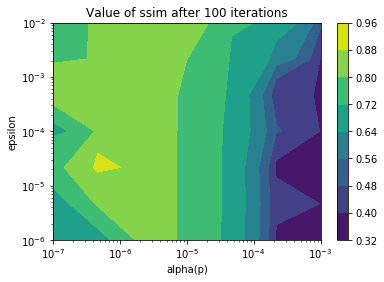

In [112]:
X,Y = np.meshgrid(alphas,eps)
const_to_test = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

plt.contourf(X,Y,ssims)
plt.title("Value of ssim after 100 iterations")
plt.xlabel("alpha(p)")
plt.ylabel("epsilon")
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
#plt.savefig("Comparisons/db8/Condat/ssims.png")
plt.show()

In [107]:
print(eps[np.argmax(ssims)//n],alphas[np.argmax(ssims)%n])
print(np.amax(ssims))

2.1544346900318833e-05 4.641588833612778e-07
0.8991215238617976


# Grid search over $\sigma$ and $\tau$